# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.299893        0.188541  0.068037  0.218933  0.100735   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         1.5    0.274398        0.158853  0.093482  0.179006  0.157845   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         0.5   0.200543  0.009250  0.039268  0.049773  0.000986  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         1.5   0.209860  0.005463  0.034856  0.051042  0.004139  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  546287.047997  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         0.5      286614.273964  
         1.0      398139.231561  
         1.5      457478.291179  
         2.0      494315.467226

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


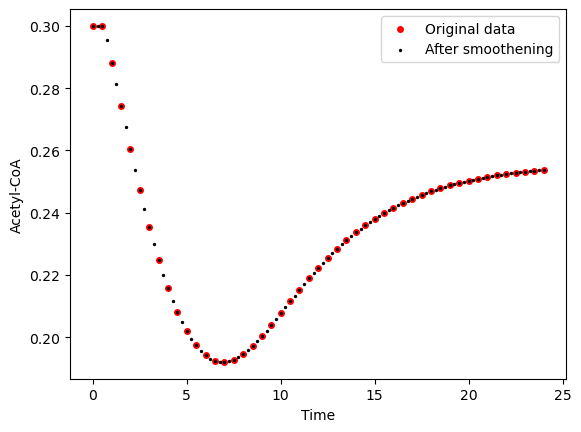

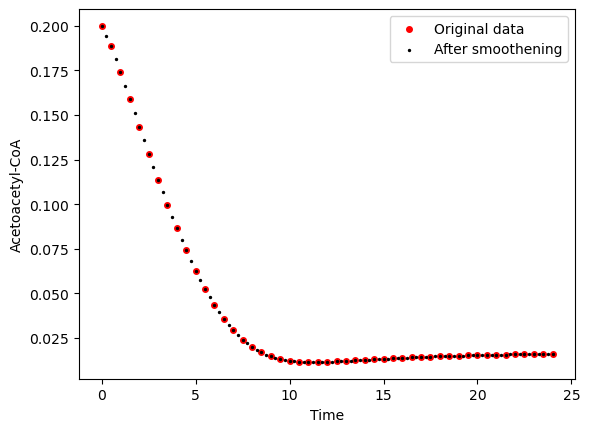

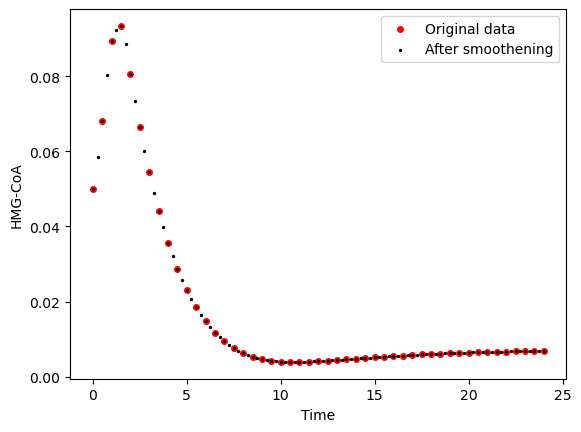

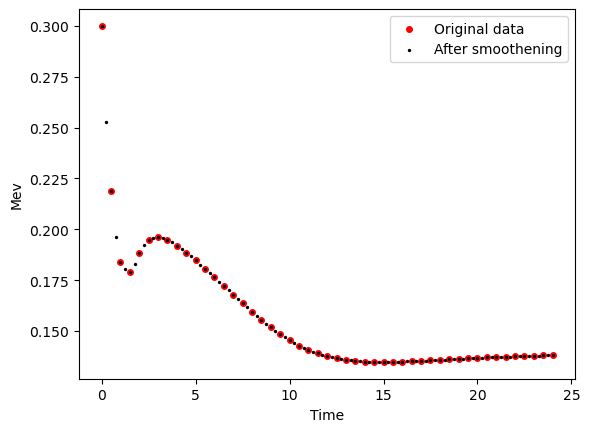

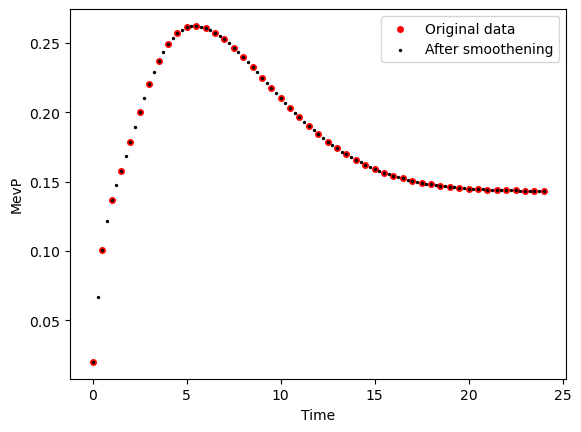

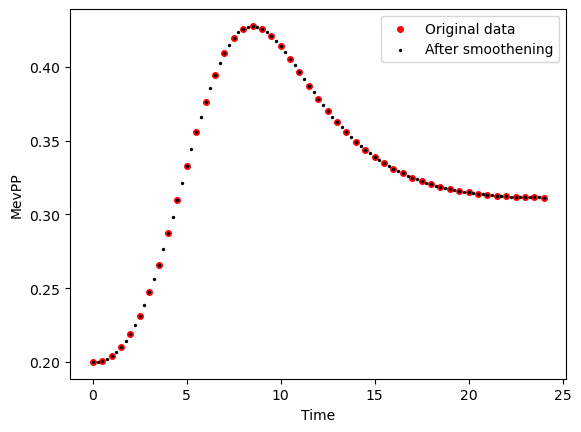

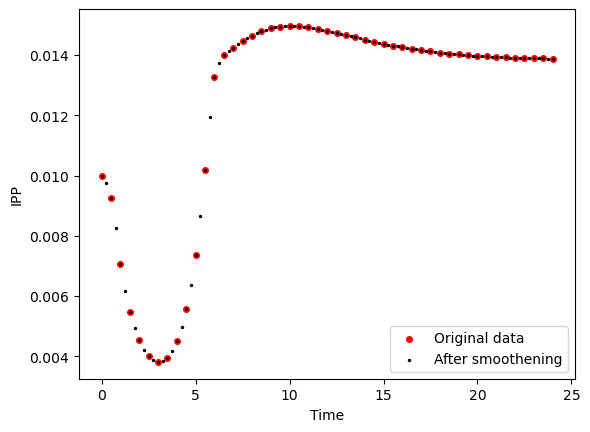

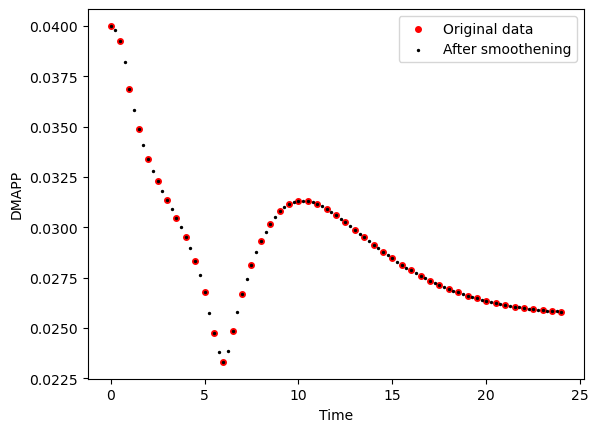

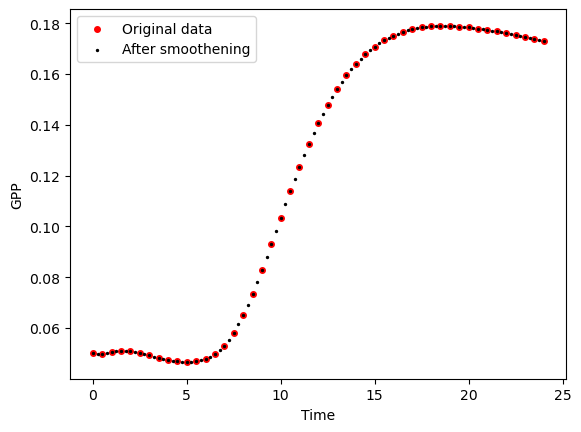

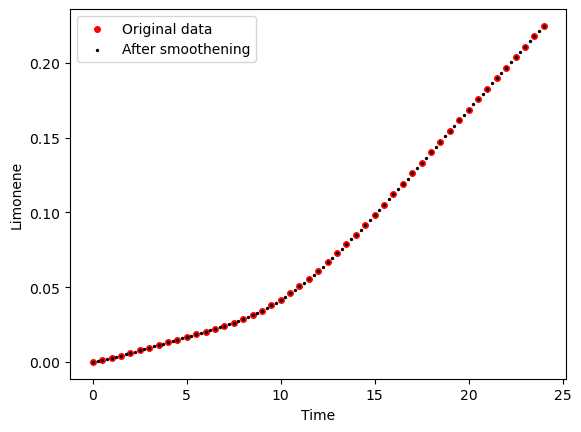

Strain Strain 2


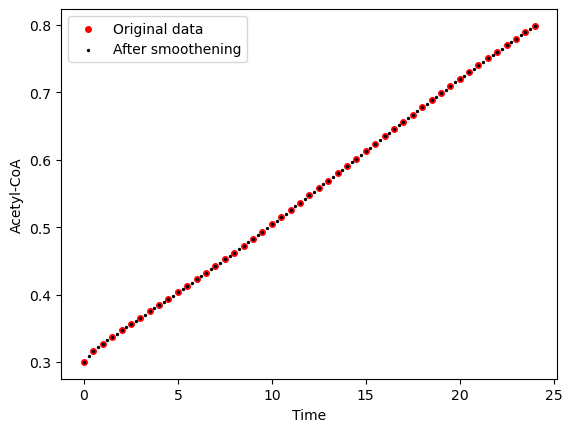

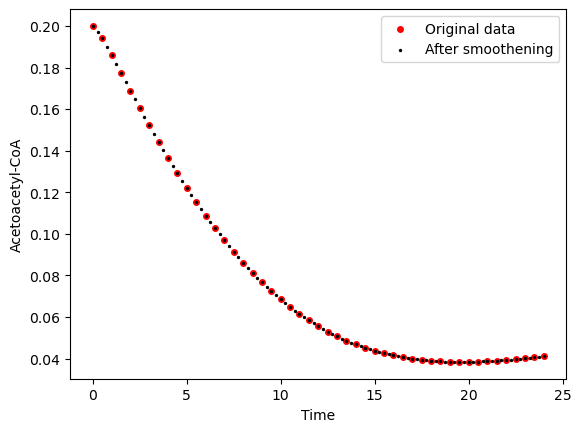

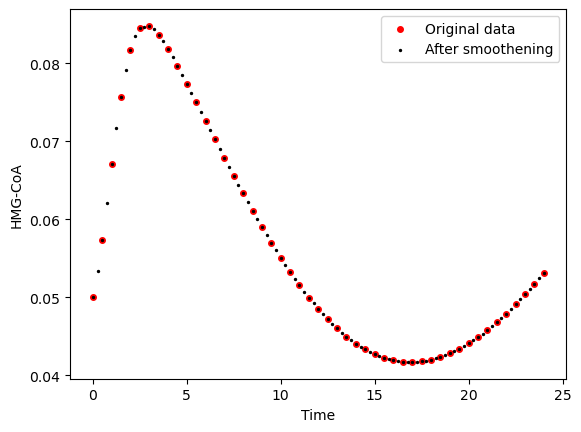

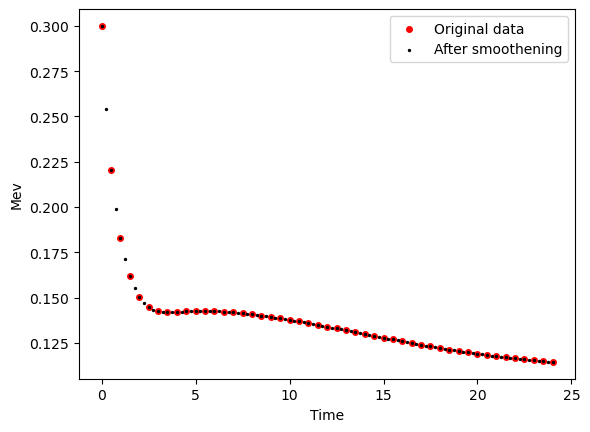

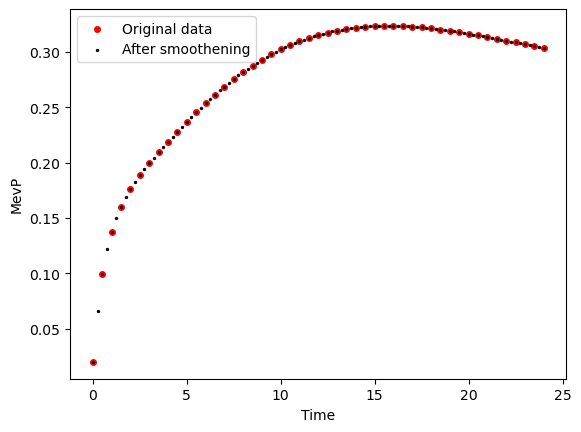

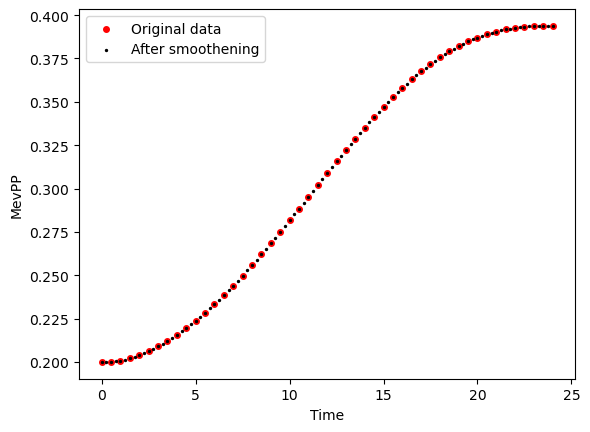

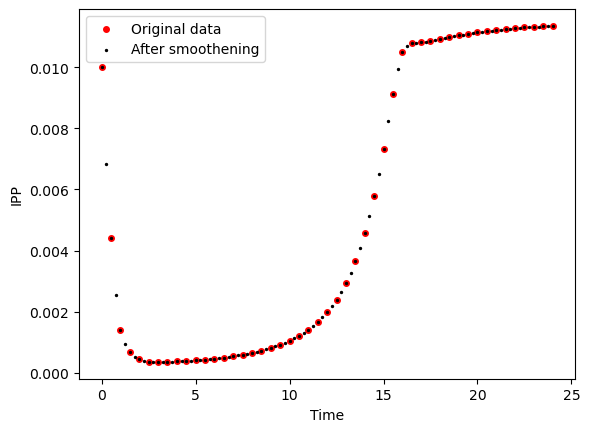

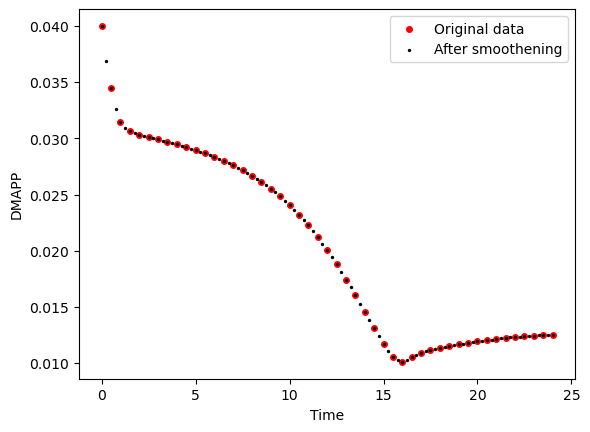

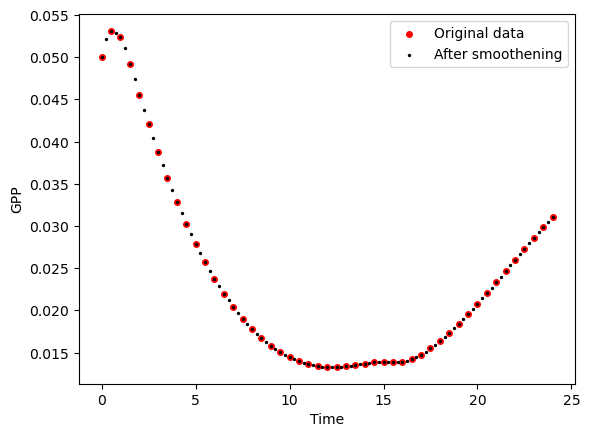

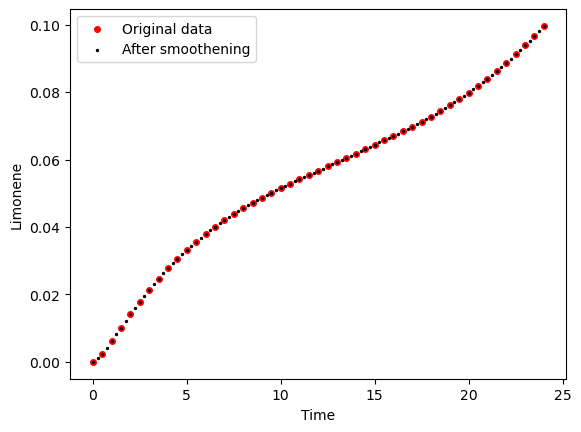

Strain Strain 3


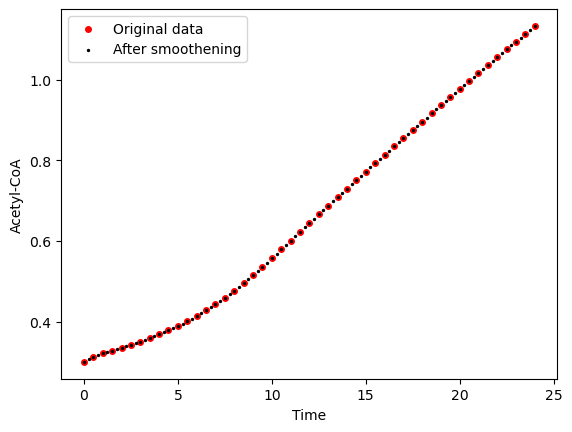

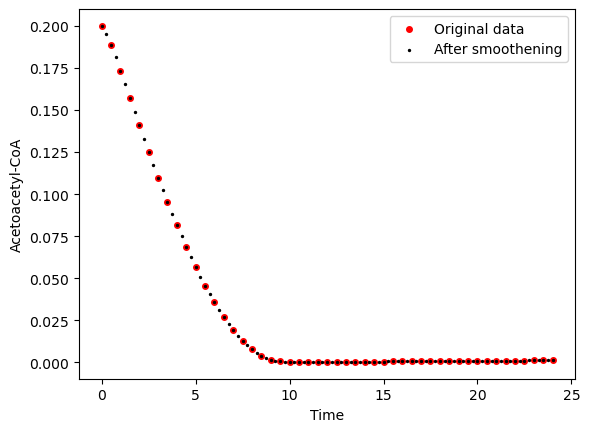

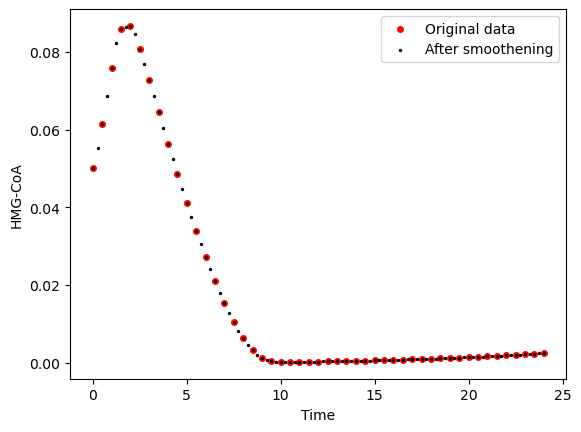

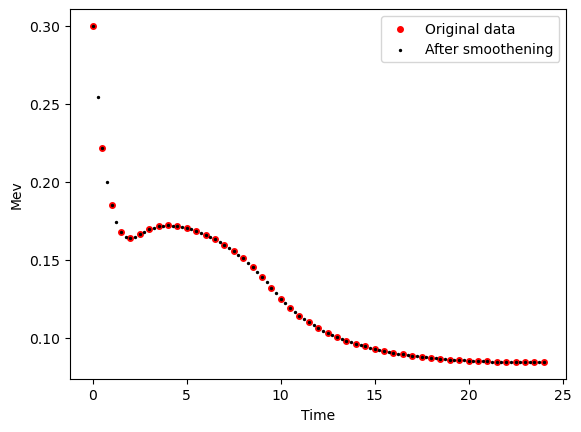

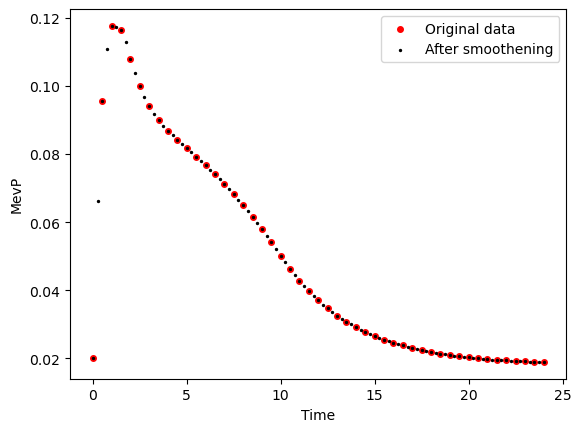

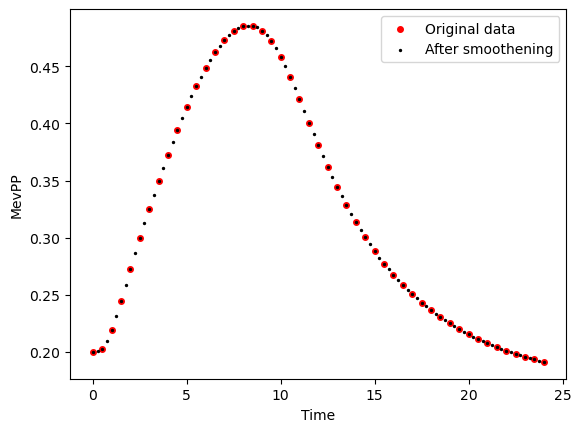

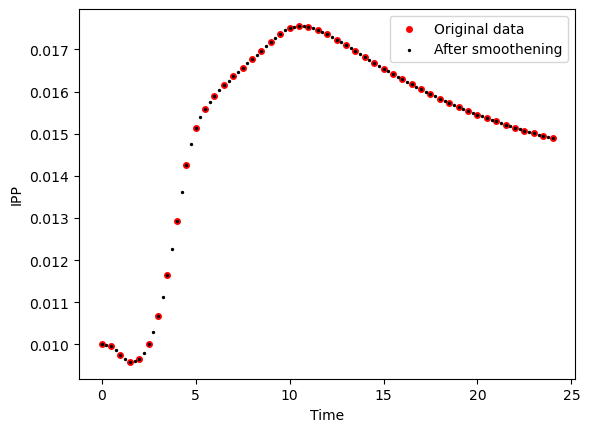

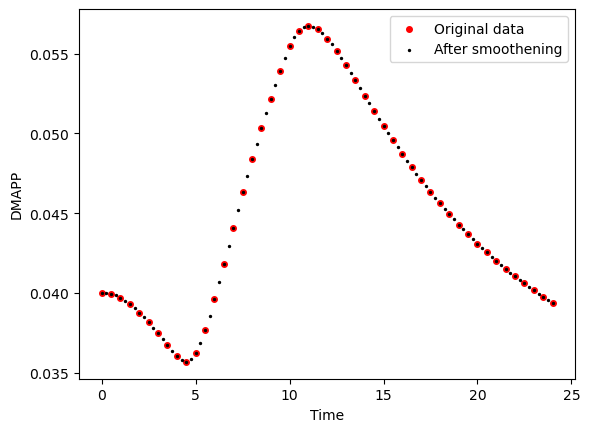

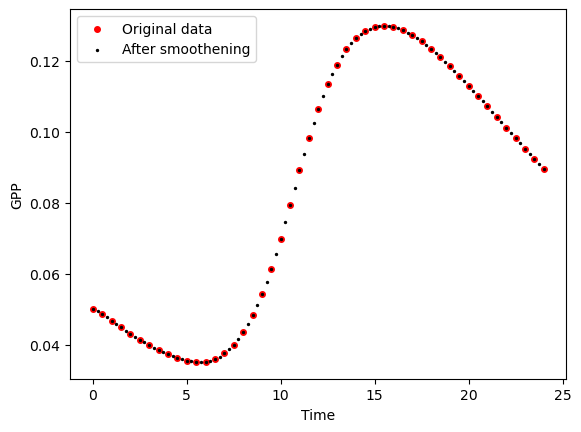

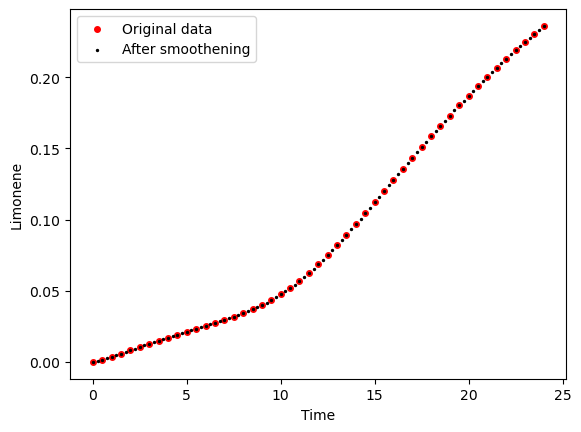

Strain WT


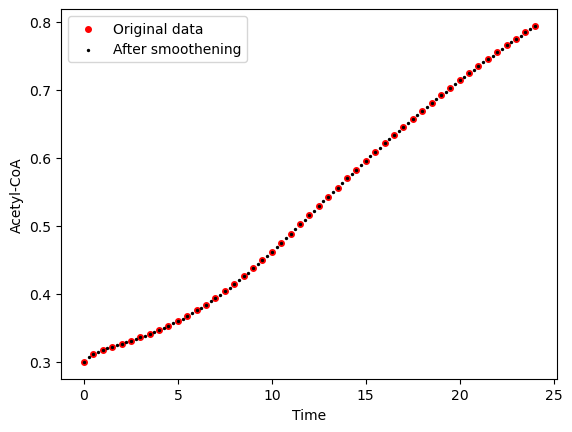

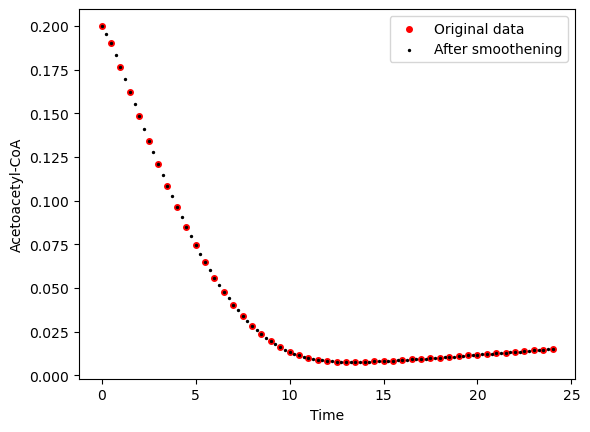

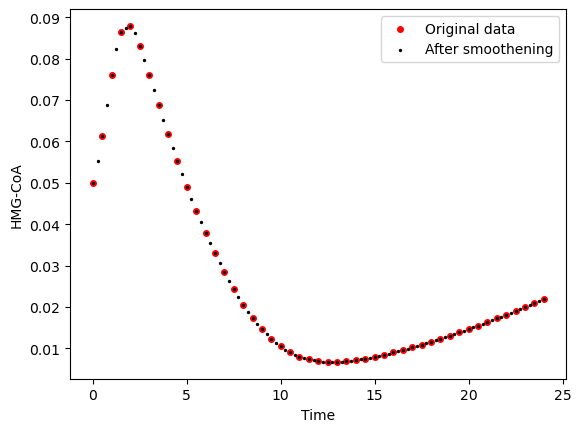

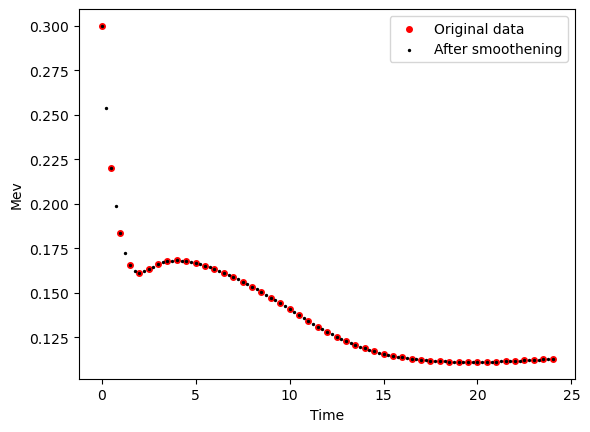

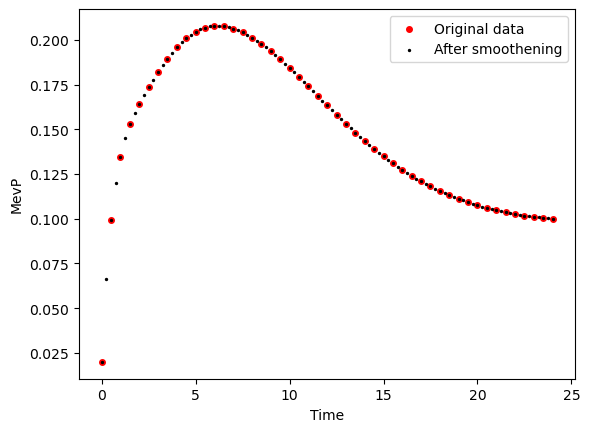

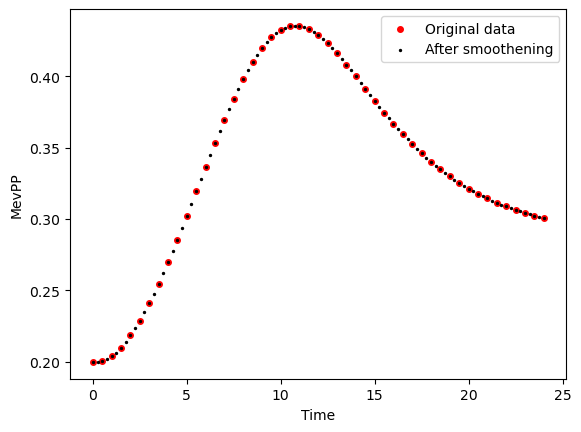

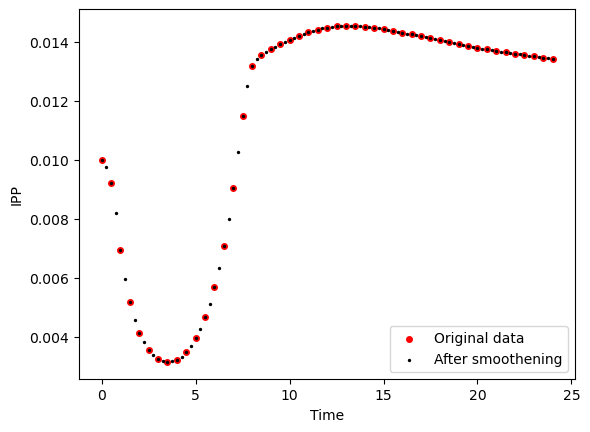

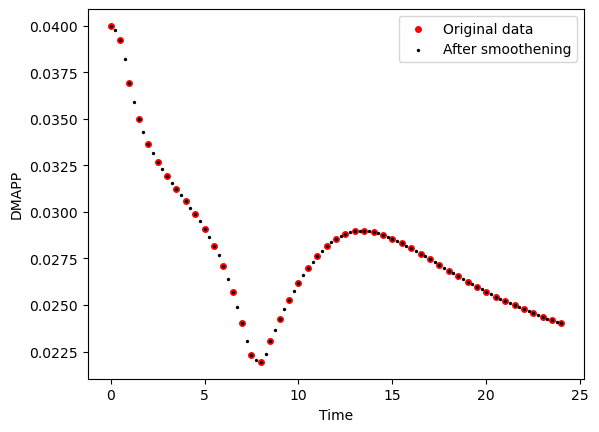

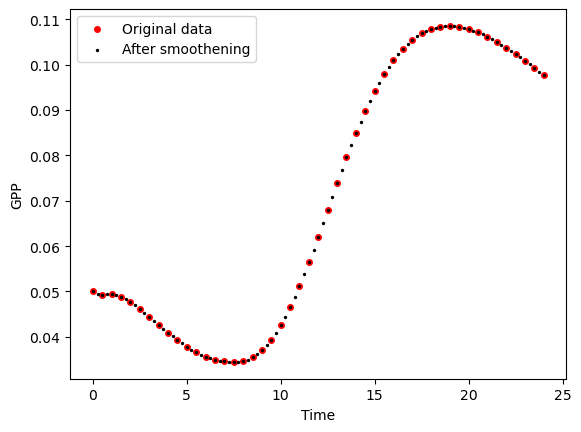

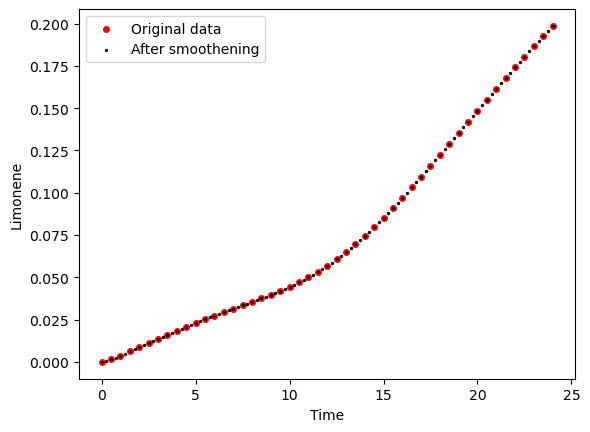

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


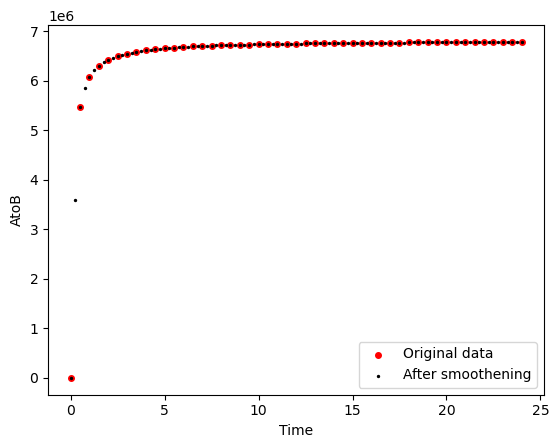

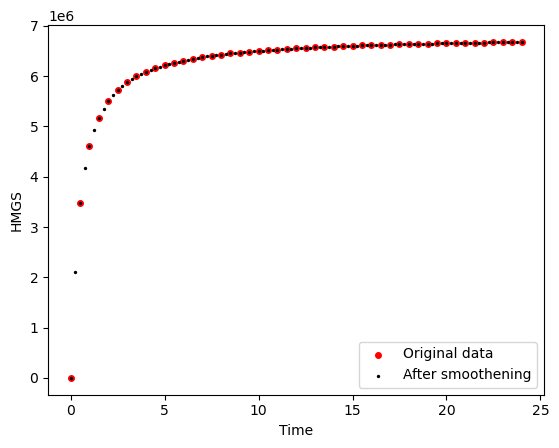

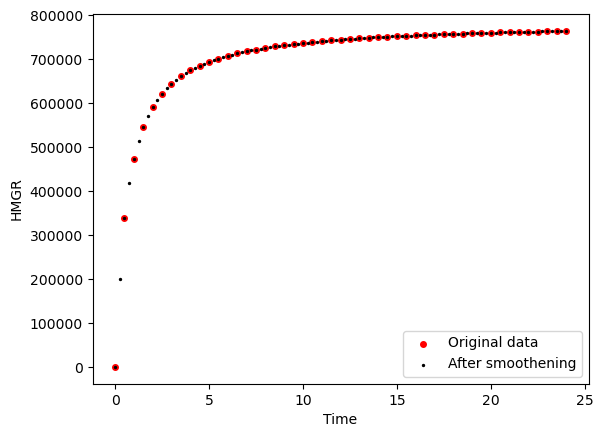

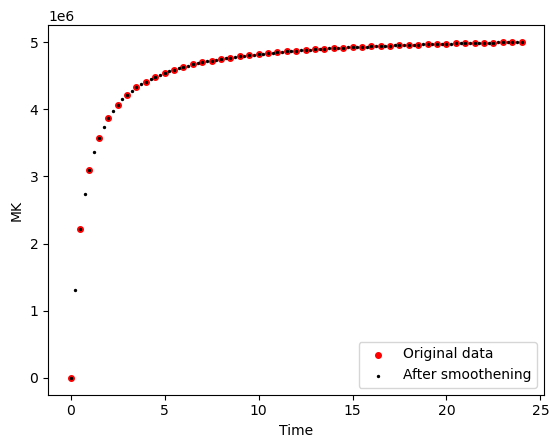

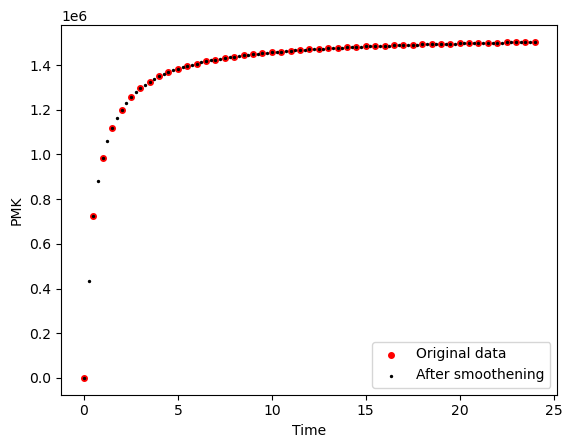

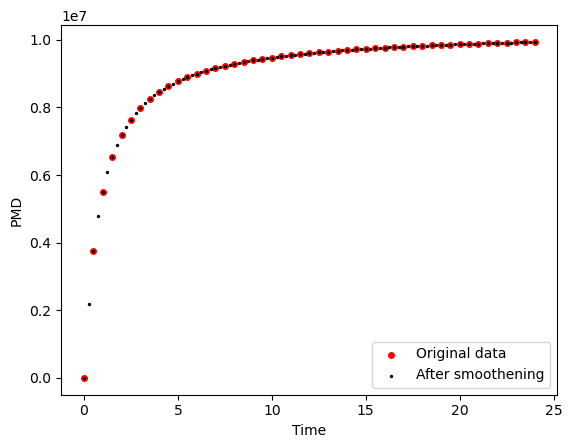

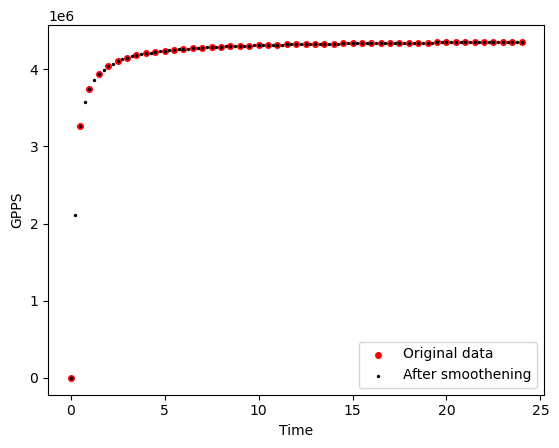

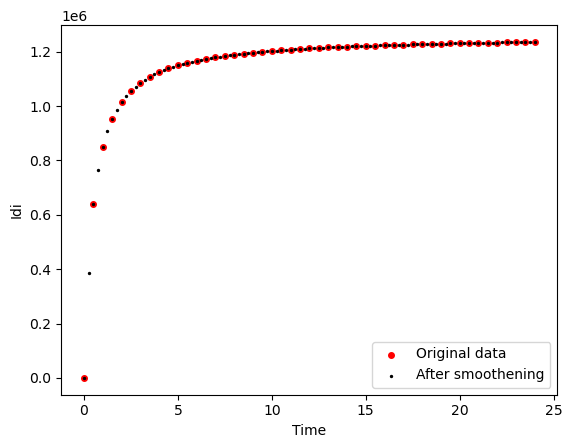

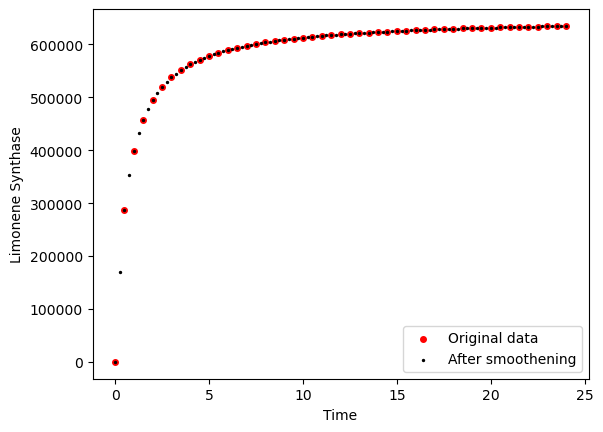

Strain Strain 2


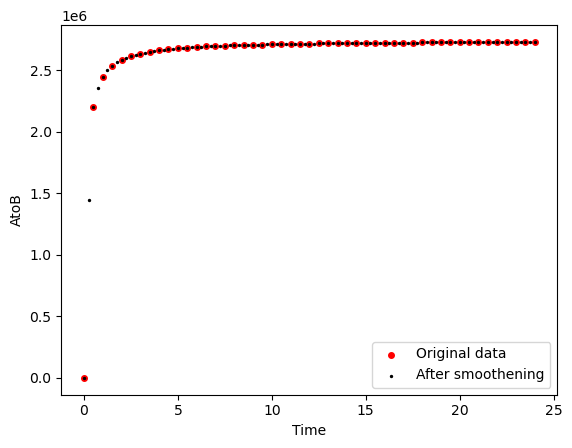

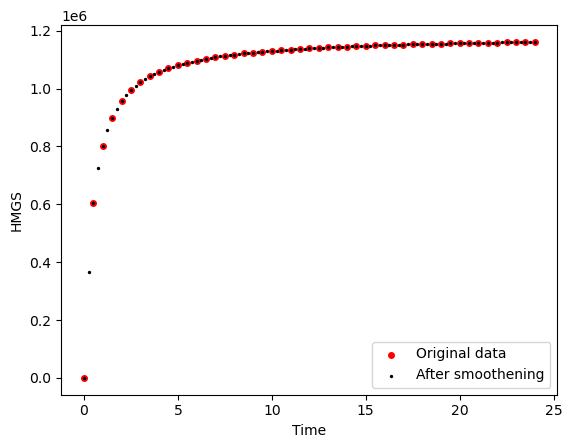

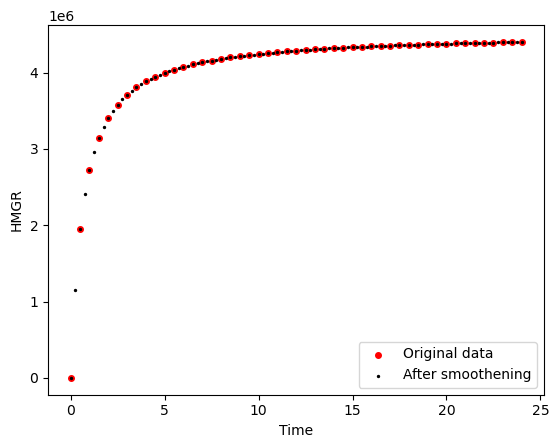

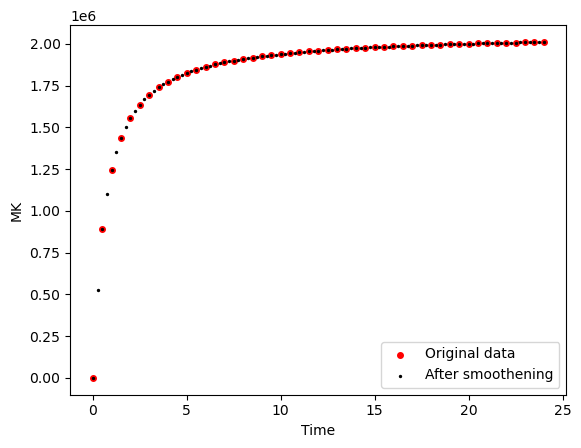

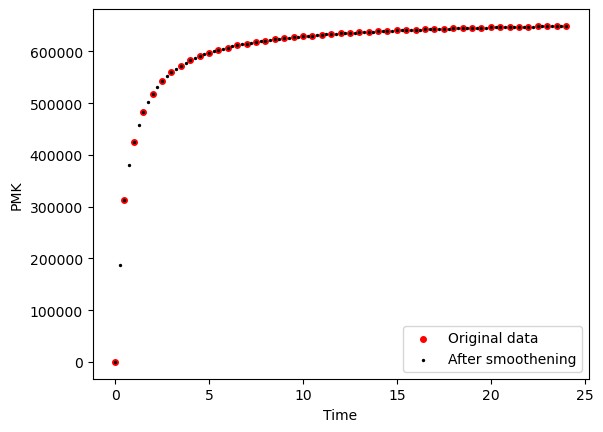

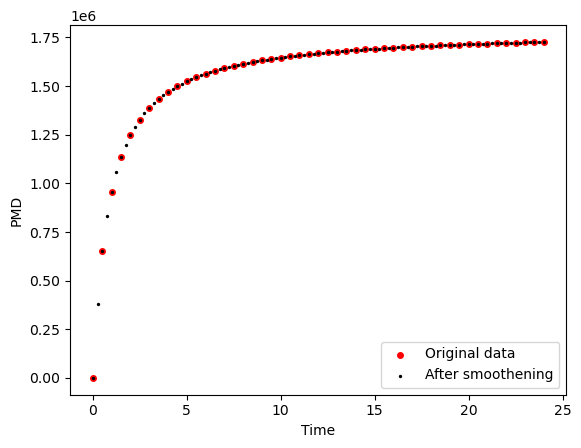

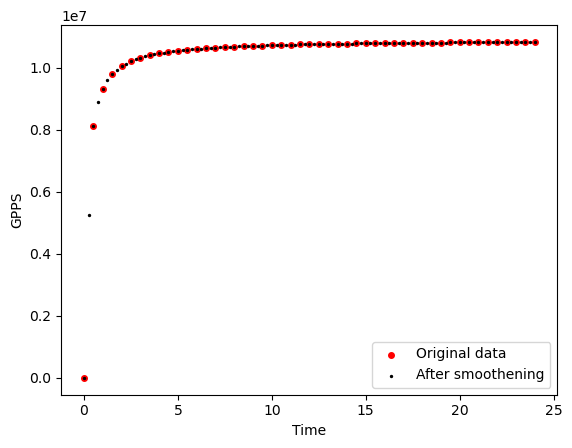

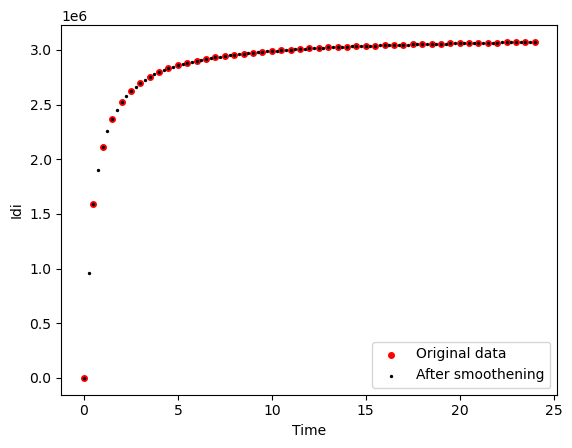

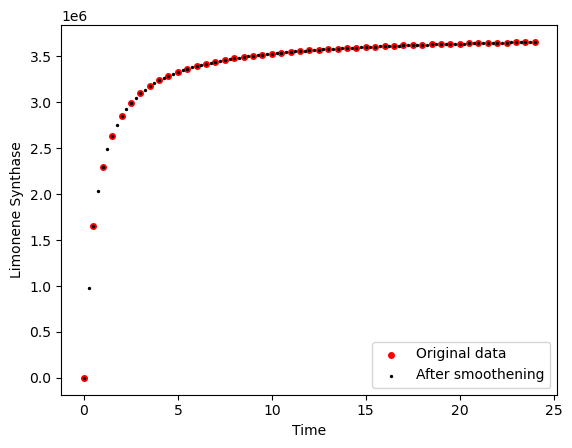

Strain Strain 3


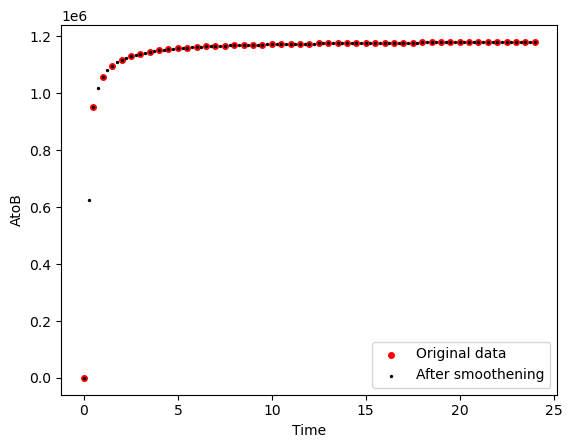

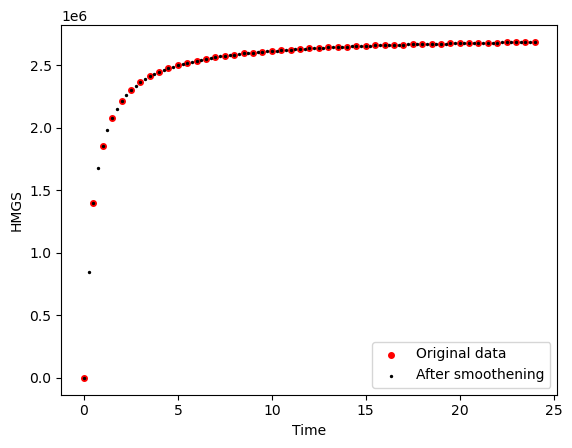

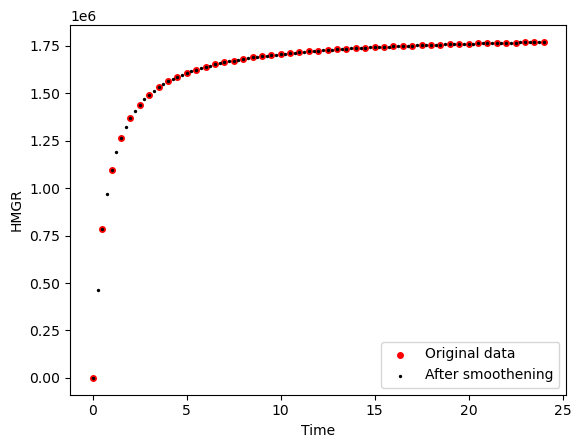

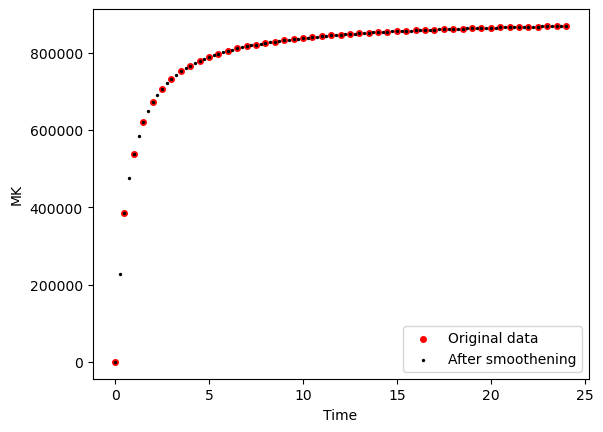

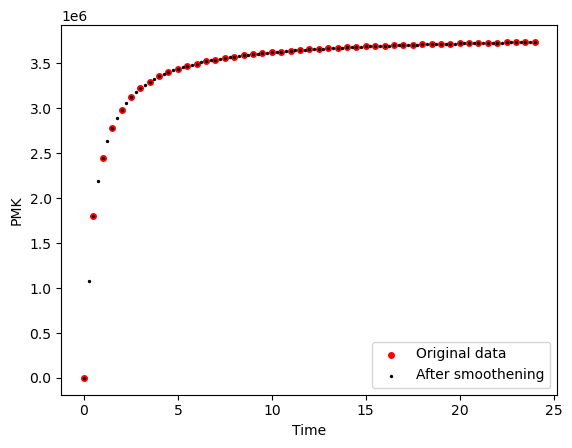

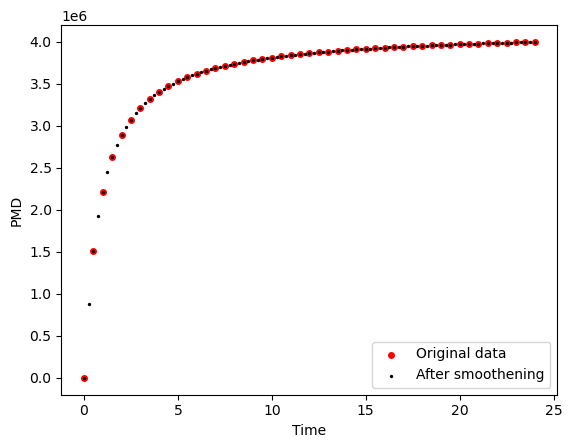

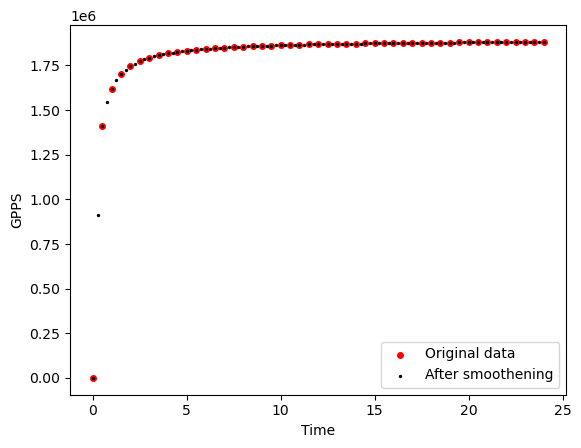

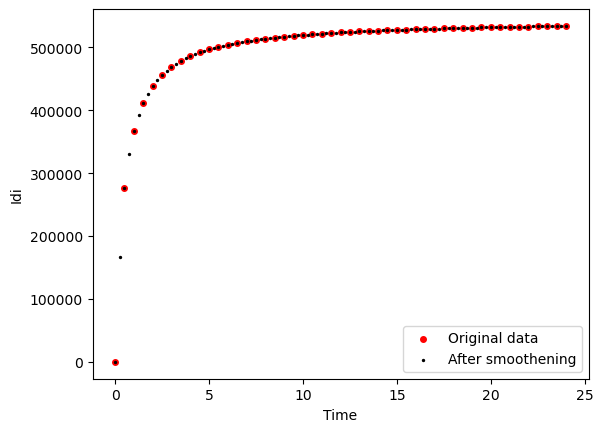

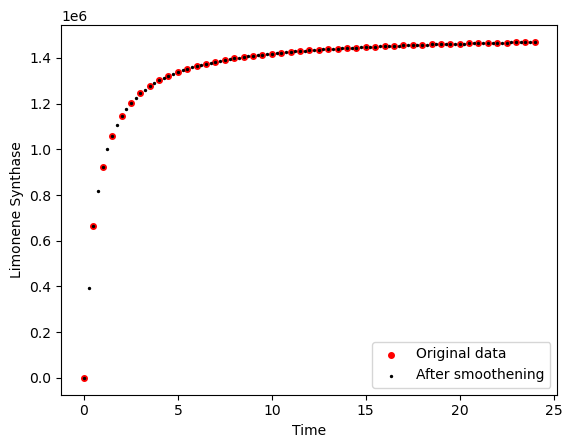

Strain WT


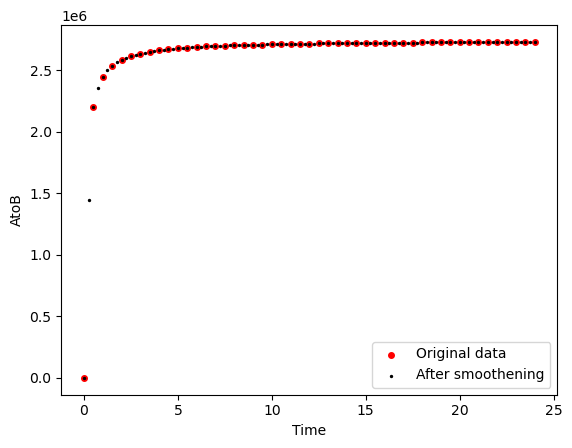

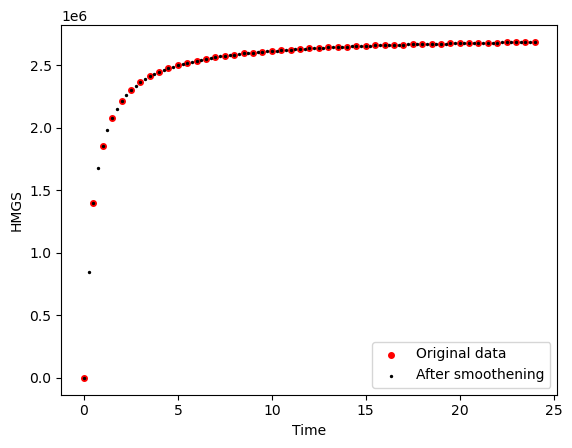

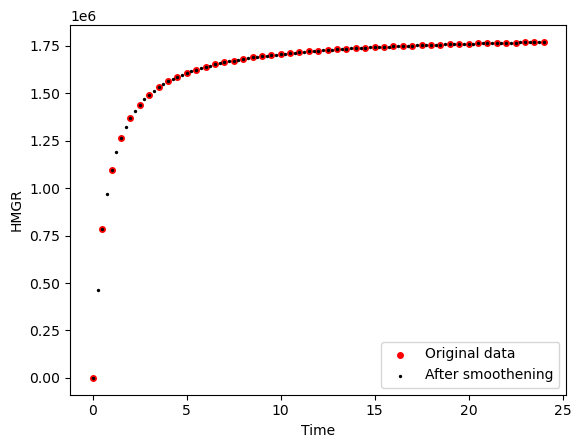

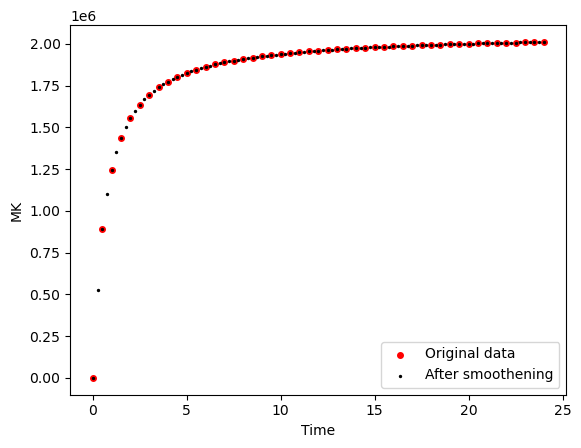

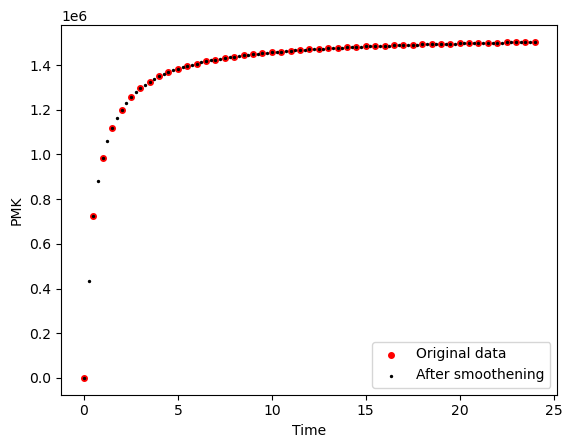

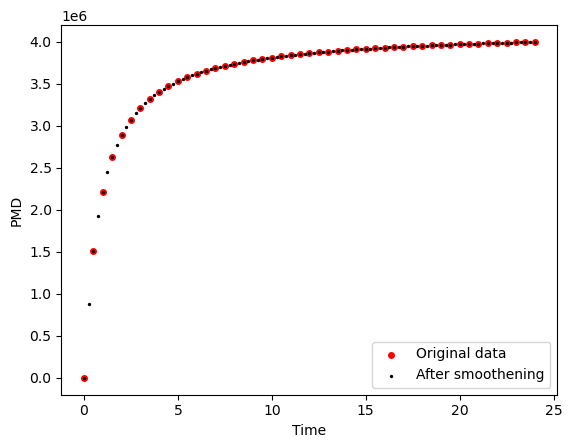

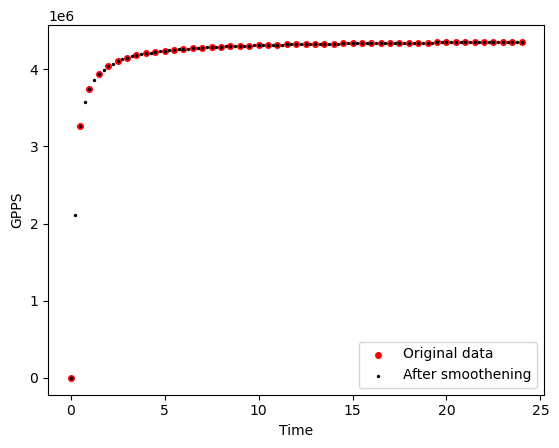

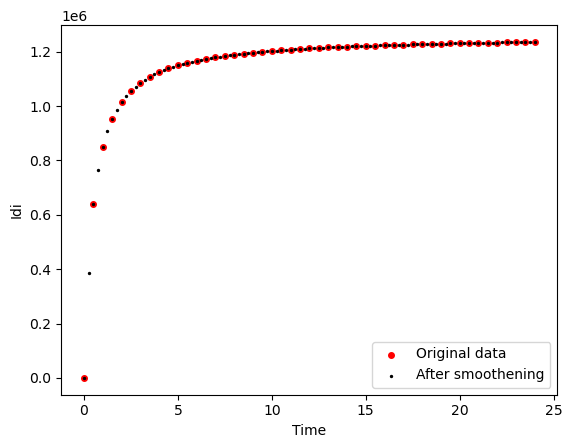

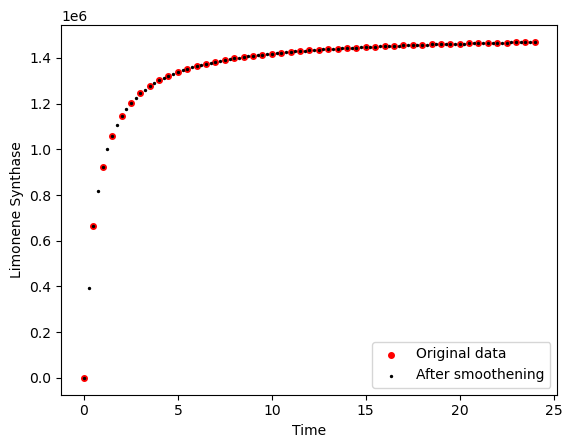

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.299973        0.194624  0.058602  0.252554  0.067099   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.295598        0.181565  0.080420  0.196453  0.121374   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021362  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200156  0.009761  0.039774  0.049802  0.000437  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201722  0.008244  0.038213  0.050161  0.001679  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098490  0.195635  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.013690       -0.018904  0.027176 -0.222785  0.222886   
         0.25    -0.001145       -0.023161  0.039481 -0.161460  0.157755   
         0.50    -0.012890       -0.026471  0.043928 -0.109410  0.106960   
         0.75    -0.021545       -0.028834  0.040518 -0.066636  0.070502   
         1.00    -0.028784       -0.030249  0.027513 -0.032895  0.049786   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001354   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000590 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000607 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000621 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001006  0.000783  0.000992 -0.002212  0.001339  
         0.25   0.001066 -0.001721 -0.001670 -0.000263  0.002004  
         0.50   0.003438 -0.003397 -0.003536  0.001029  0.002540  
         0.75   0.006111 -0.004247 -0.004605  0.001664  0.002949  
         1.00   0.009363 -0.004243 -0.004909  0.001653  0.003235  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003143  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003202  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

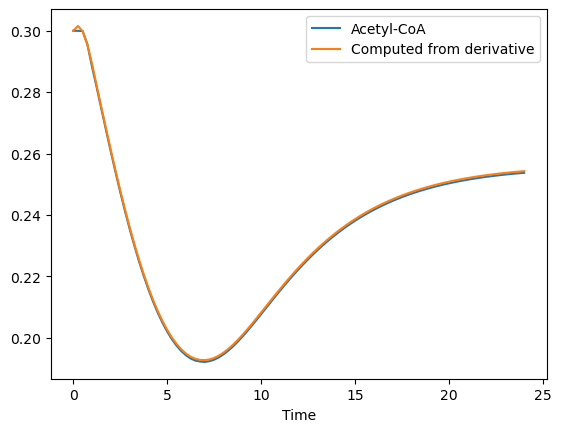

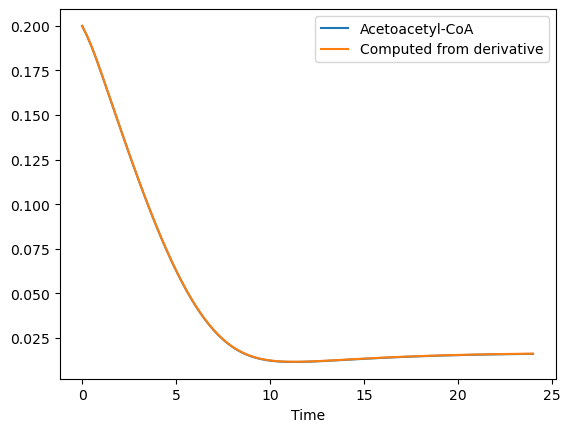

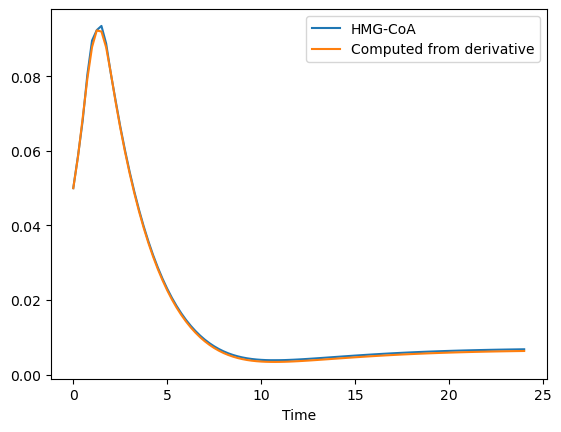

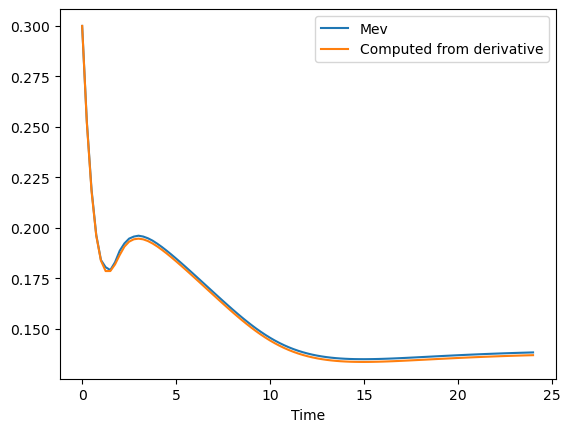

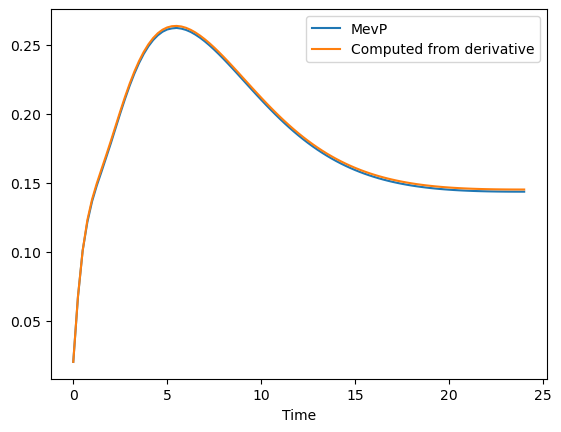

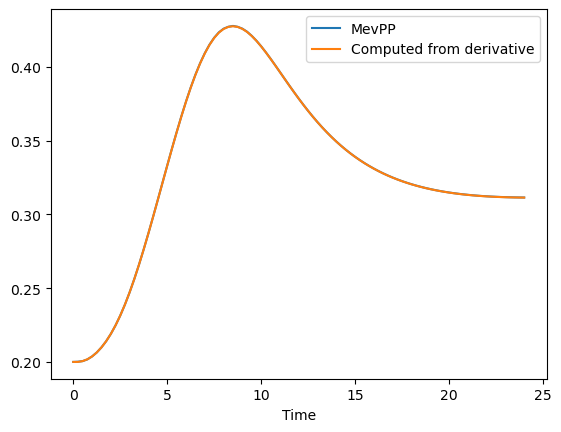

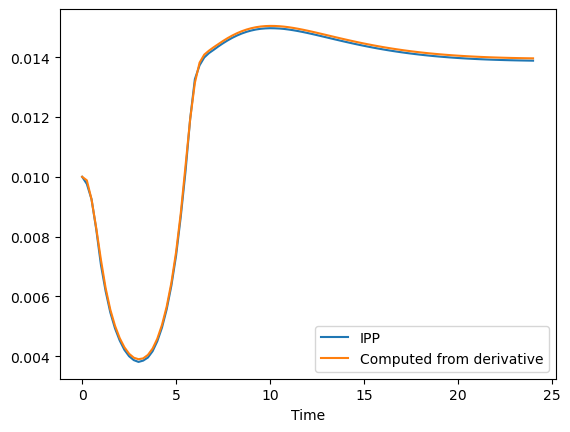

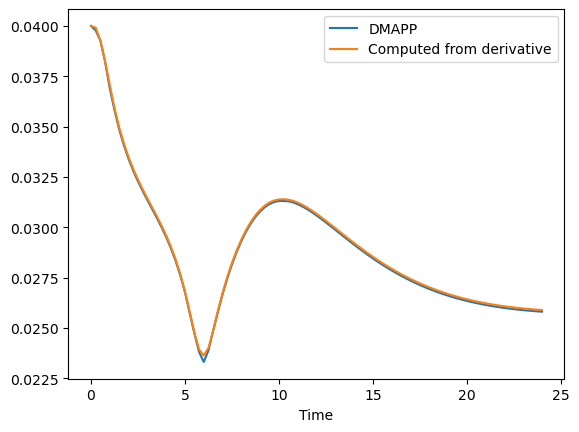

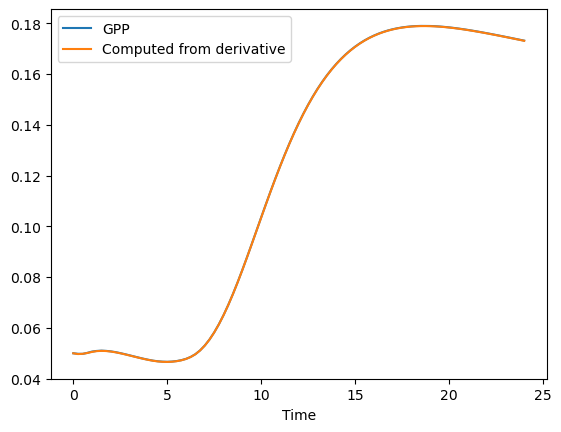

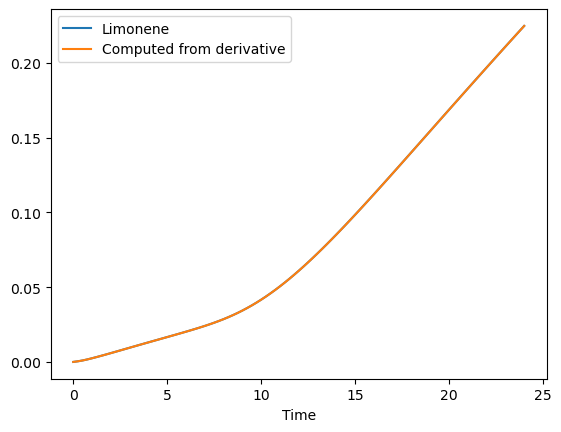

'Time profile from derivative vs. actual profile for Strain 2'

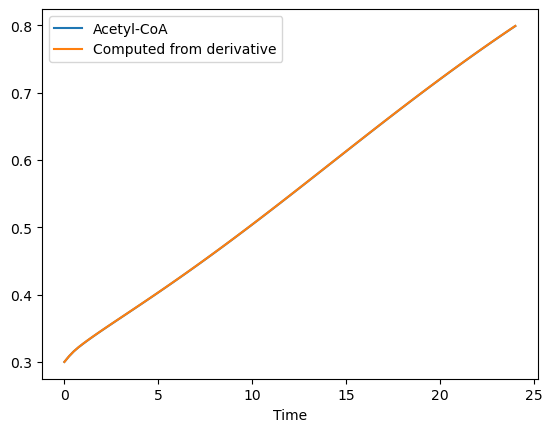

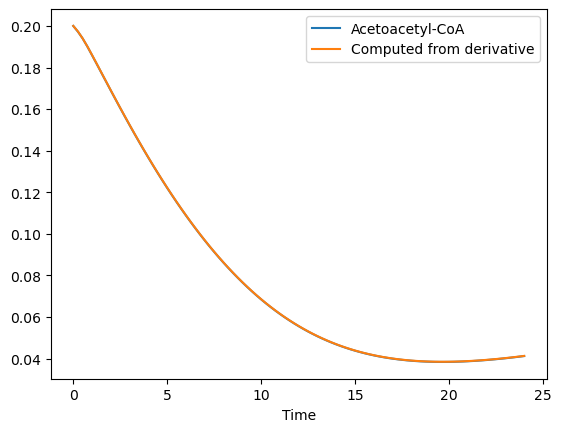

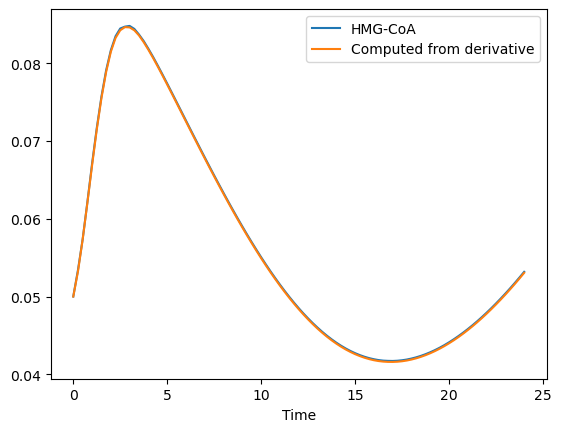

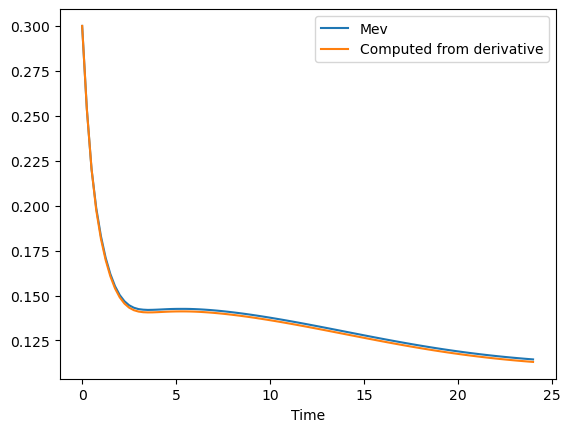

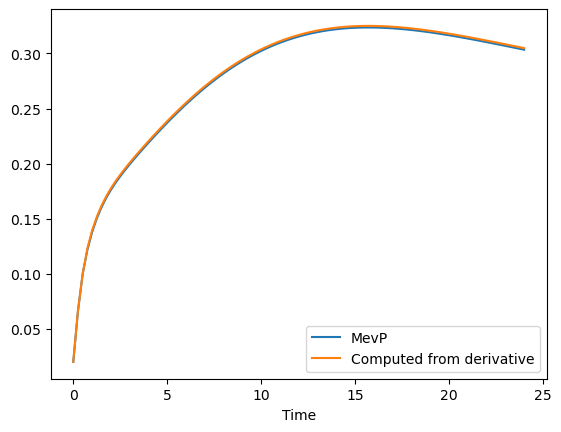

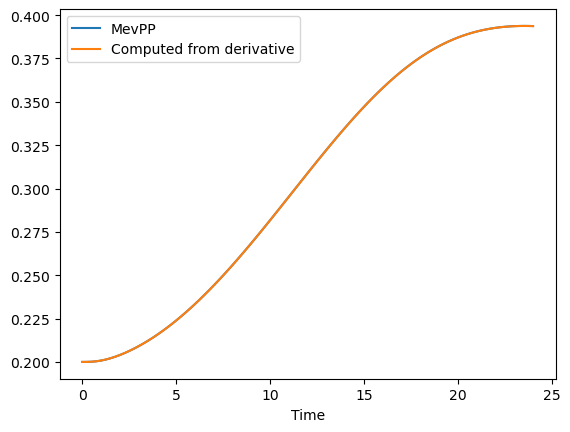

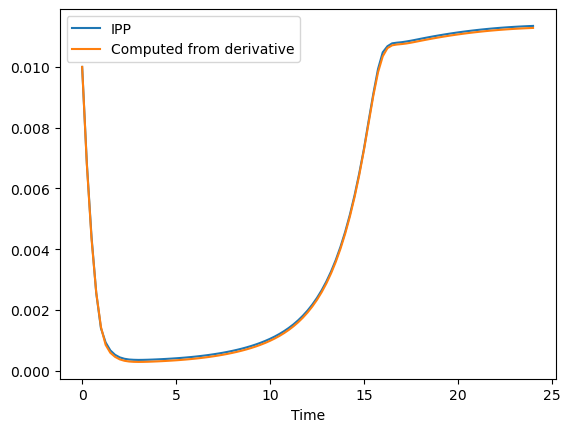

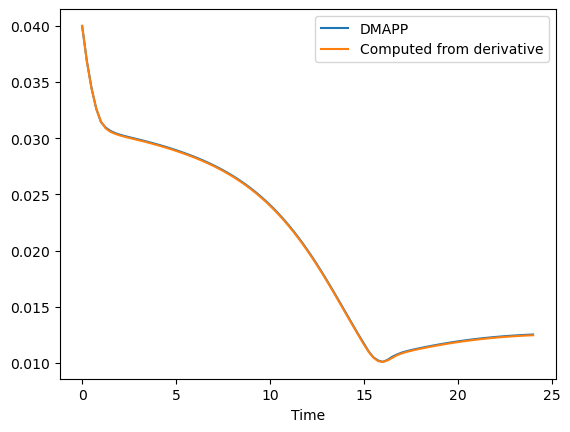

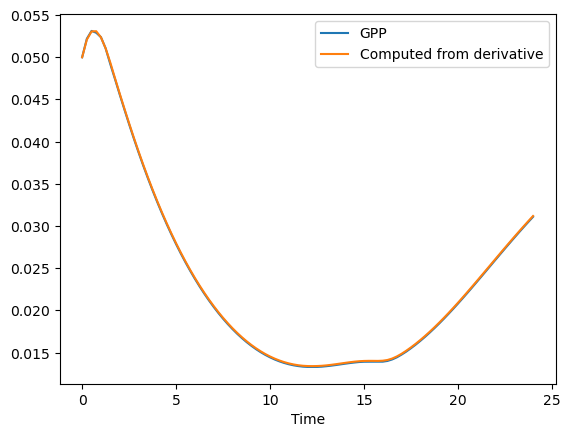

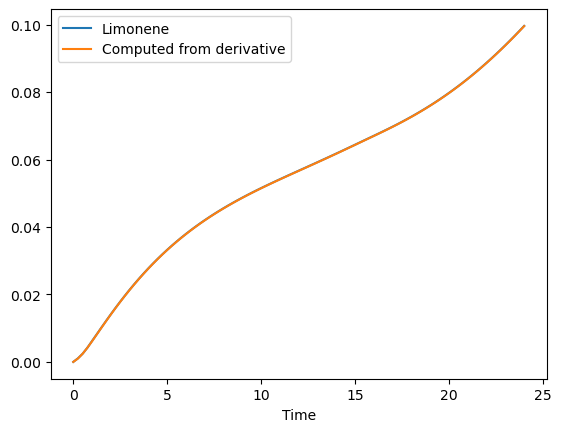

'Time profile from derivative vs. actual profile for Strain 3'

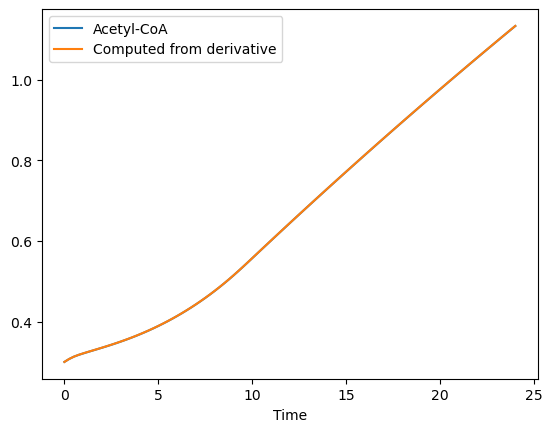

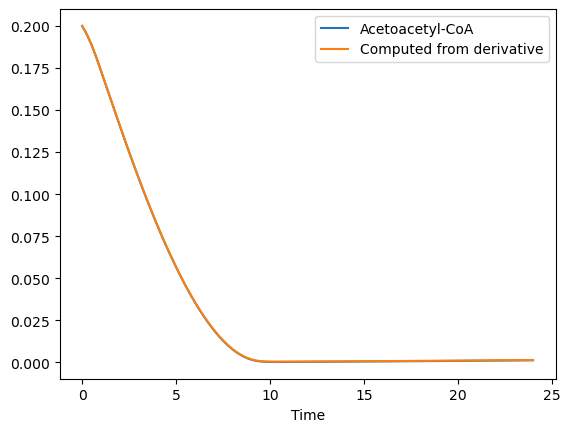

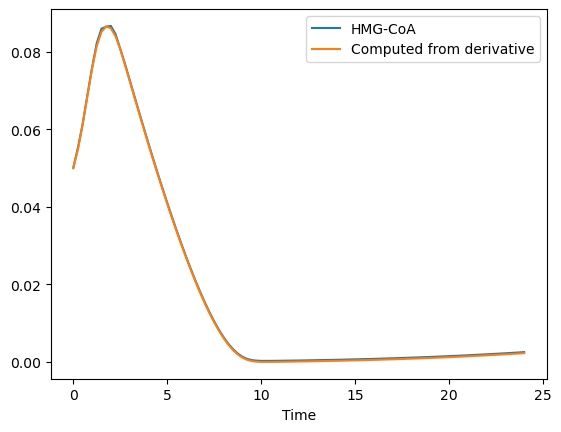

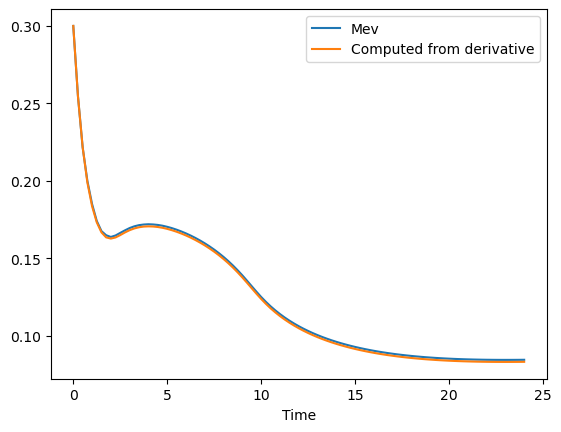

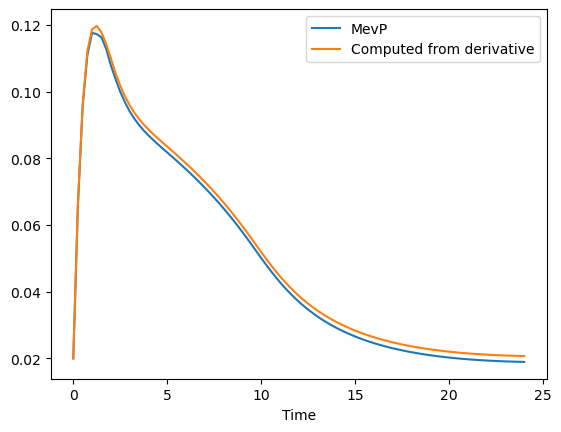

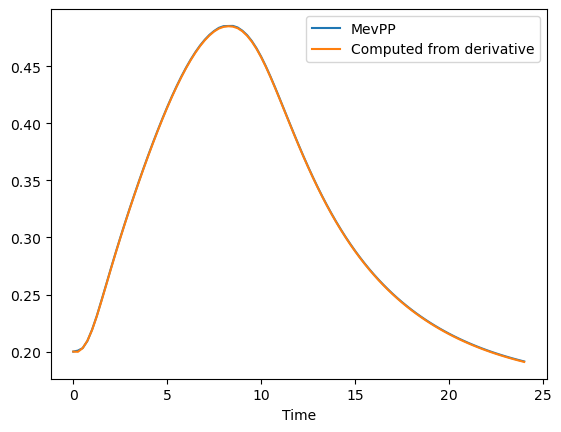

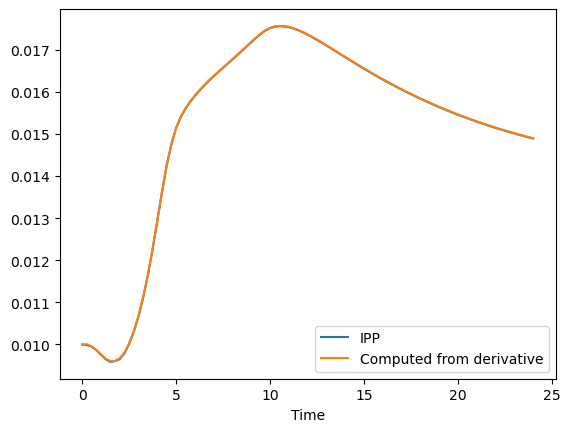

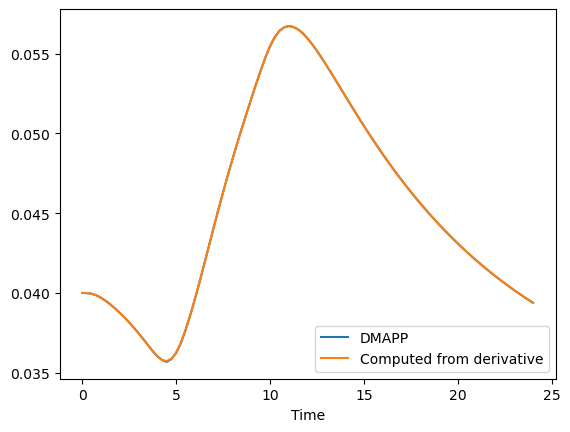

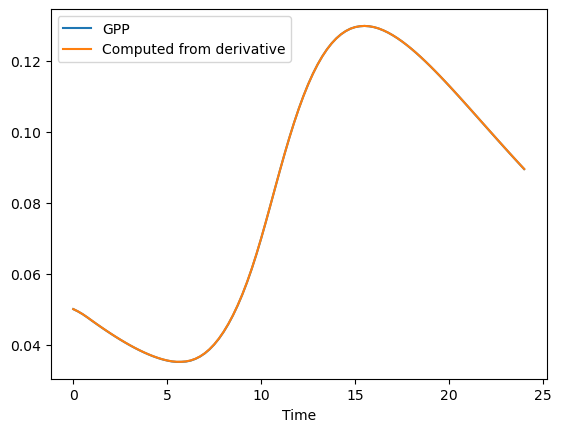

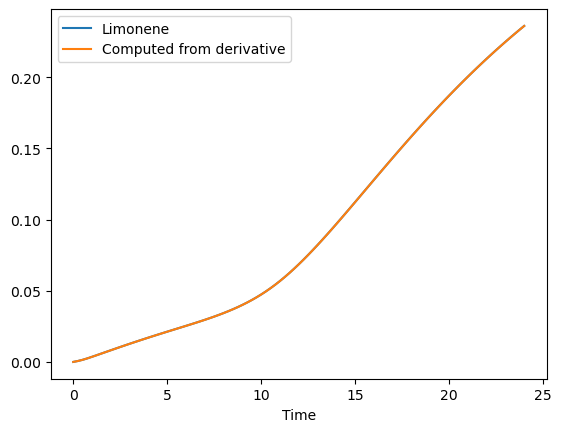

'Time profile from derivative vs. actual profile for WT'

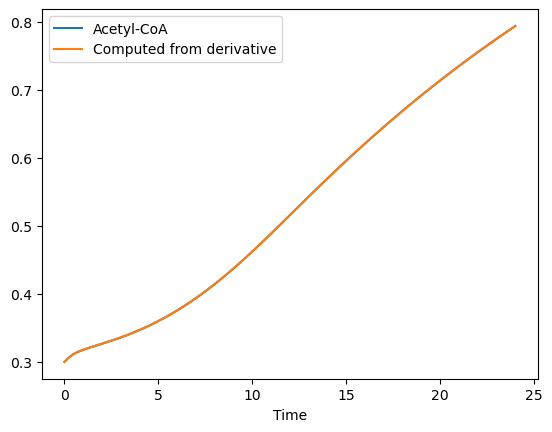

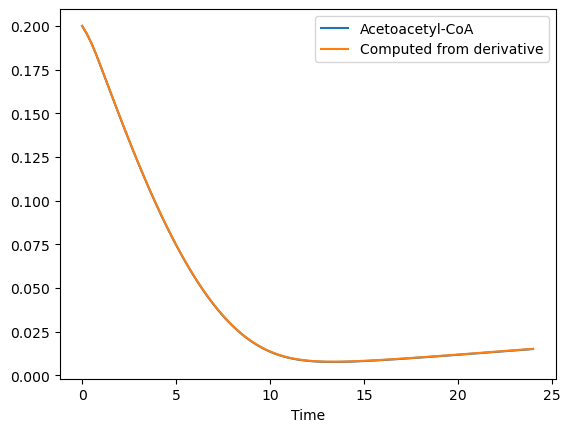

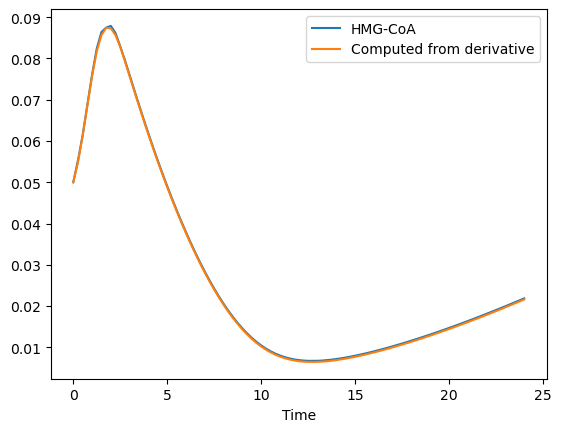

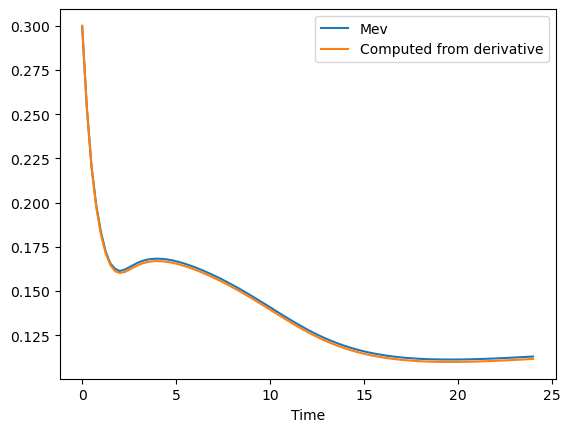

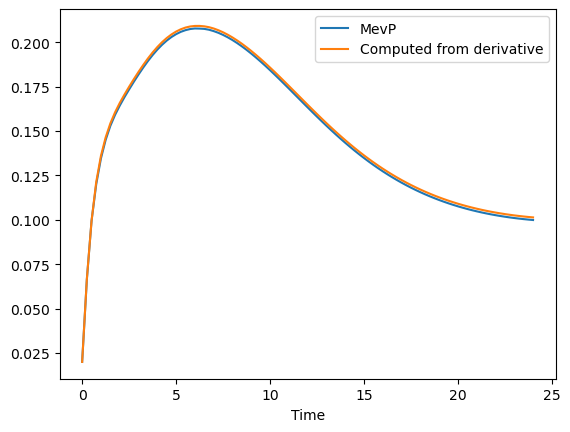

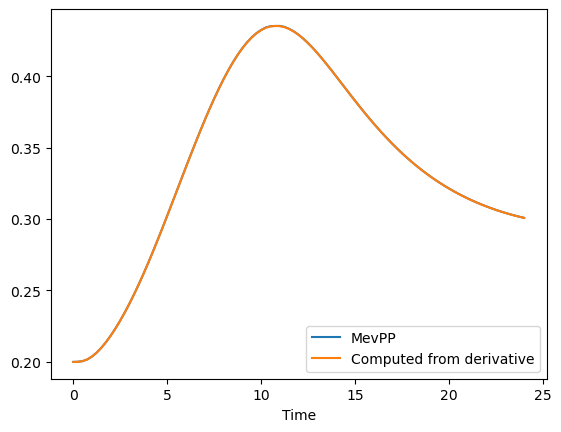

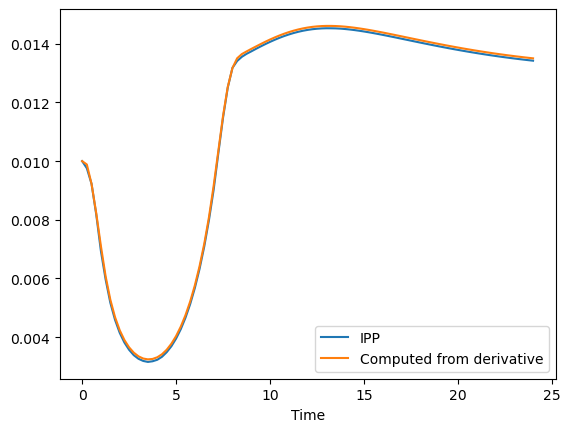

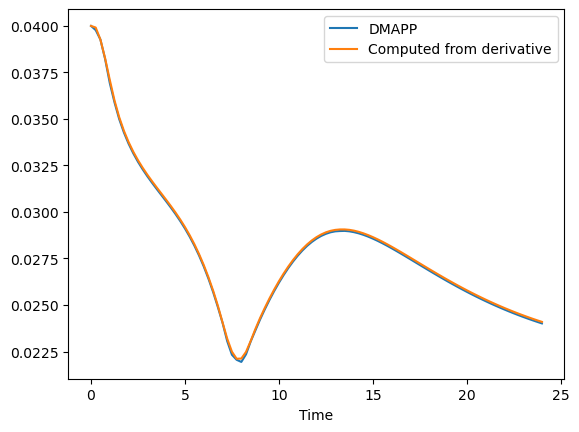

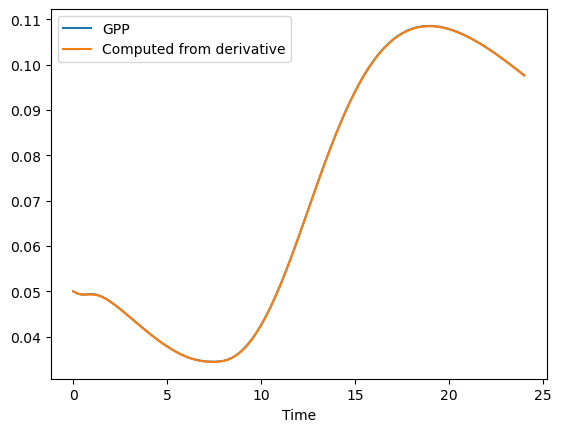

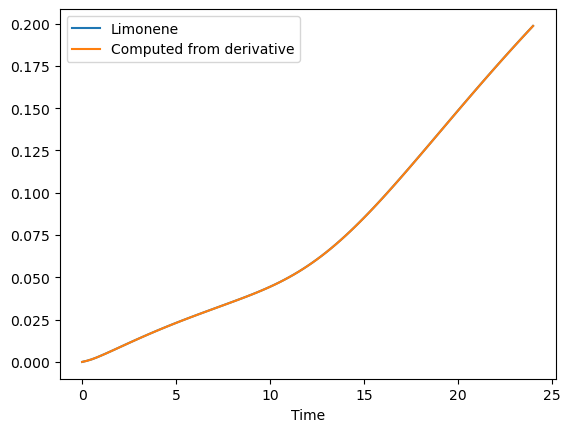

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   3.589052e+06  2.111237e+06  2.008718e+05  1.311689e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.865920e+06  4.166035e+06  4.191051e+05  2.738184e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.336546e+05  2.178306e+06  2.110608e+06  3.875298e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.801888e+05  4.773919e+06  3.574431e+06  7.666082e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.700158e+05   0.299973        0.194624  0.058602   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.527646e+05   0.295598        0.181565  0.080420   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021362   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.252554  0.067099  0.200156  0.009761  0.039774  0.049802   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.196453  0.121374  0.201722  0.008244  0.038213  0.050161   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.013690       -0.018904  0.027176 -0.222785  0.222886   
         0.25    -0.001145       -0.023161  0.039481 -0.161460  0.157755   
         0.50    -0.012890       -0.026471  0.043928 -0.109410  0.106960   
         0.75    -0.021545       -0.028834  0.040518 -0.066636  0.070502   
         1.00    -0.028784       -0.030249  0.027513 -0.032895  0.049786   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001354   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000590 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000607 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000621 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001006  0.000783  0.000992 -0.002212  0.001339  
         0.25   0.001066 -0.001721 -0.001670 -0.000263  0.002004  
         0.50   0.003438 -0.003397 -0.003536  0.001029  0.002540  
         0.75   0.006111 -0.004247 -0.004605  0.001664  0.002949  
         1.00   0.009363 -0.004243 -0.004909  0.001653  0.003235  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003143  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003202  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003034 -0.000069 -0.000325 -0.003295  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 8.155547E+191 | 9.187803E+116
     2 |       74 | 1.684196E+115 |  4.076032E+83
     3 |      138 |  6.911167E+90 |  4.797560E+70
     4 |      202 |  1.465578E+80 |  1.063039E+60
     5 |      266 |  3.187528E+73 |  5.647599E+53
     6 |      330 |  3.153672E+65 |  8.118881E+48
     7 |      394 |  1.917685E+64 |  1.272598E+48
     8 |      458 |  4.718572E+57 |  1.287234E+42
     9 |      522 |  2.718078E+54 |  9.581548E+41
    10 |      586 |  1.109311E+55 |  9.581548E+41
    11 |      650 |  3.747810E+49 |  3.107421E+39
    12 |      714 |  1.624731E+46 |  7.145792E+36
    13 |      778 |  1.278075E+43 |  1.307630E+33
    14 |      842 |  4.268666E+40 |  1.294198E+30
    15 |      906 |  2.964326E+37 |  4.571917E+28
    16 |      970 |  2.102016E+33 |  1.083588E+22
    17 |     1034 |  7.728548E+31 |  1.083588E+22
    18 |     1098 |  7.225906E+32 |  4.231883E+21
    19 |     1162 |  3.405

   162 |    10314 |  2.399629E+01 |  1.989934E+01
   163 |    10378 |  2.366053E+01 |  1.989934E+01
   164 |    10442 |  2.335339E+01 |  1.989934E+01
   165 |    10506 |  2.272270E+01 |  1.989934E+01
   166 |    10570 |  2.276996E+01 |  1.989934E+01
   167 |    10634 |  2.270184E+01 |  1.989934E+01
   168 |    10698 |  2.233640E+01 |  1.989934E+01
   169 |    10762 |  2.287078E+01 |  1.989934E+01
   170 |    10826 |  2.254226E+01 |  1.989934E+01
   171 |    10890 |  2.236424E+01 |  1.989934E+01
   172 |    10954 |  2.242600E+01 |  1.989934E+01
   173 |    11018 |  2.224017E+01 |  1.989934E+01
   174 |    11082 |  2.218877E+01 |  1.989934E+01
   175 |    11146 |  2.196073E+01 |  1.989934E+01
   176 |    11210 |  2.204637E+01 |  1.989934E+01
   177 |    11274 |  2.203238E+01 |  1.989934E+01
   178 |    11338 |  2.191353E+01 |  1.989934E+01
   179 |    11402 |  2.239364E+01 |  1.989934E+01
   180 |    11466 |  2.215505E+01 |  1.989934E+01
   181 |    11530 |  2.207468E+01 |  1.989934E+01


   326 |    20810 |  1.575830E+01 |  1.421922E+01
   327 |    20874 |  1.544094E+01 |  1.421922E+01
   328 |    20938 |  1.550068E+01 |  1.421922E+01
   329 |    21002 |  1.545988E+01 |  1.421922E+01
   330 |    21066 |  1.551226E+01 |  1.421922E+01
   331 |    21130 |  1.535286E+01 |  1.421922E+01
   332 |    21194 |  1.543608E+01 |  1.421922E+01
   333 |    21258 |  1.525380E+01 |  1.377339E+01
   334 |    21322 |  1.483927E+01 |  1.377339E+01
   335 |    21386 |  1.461335E+01 |  1.377339E+01
   336 |    21450 |  1.462237E+01 |  1.377339E+01
   337 |    21514 |  1.454224E+01 |  1.377339E+01
   338 |    21578 |  1.440756E+01 |  1.371589E+01
   339 |    21642 |  1.476454E+01 |  1.371589E+01
   340 |    21706 |  1.442160E+01 |  1.371589E+01
   341 |    21770 |  1.462647E+01 |  1.371589E+01
   342 |    21834 |  1.451080E+01 |  1.371589E+01
   343 |    21898 |  1.476596E+01 |  1.371589E+01
   344 |    21962 |  1.458649E+01 |  1.371589E+01
   345 |    22026 |  1.423362E+01 |  1.371589E+01


   490 |    31306 |  1.244829E+01 |  1.075226E+01
   491 |    31370 |  1.246962E+01 |  1.075226E+01
   492 |    31434 |  1.243989E+01 |  1.075226E+01
   493 |    31498 |  1.238918E+01 |  1.075226E+01
   494 |    31562 |  1.223254E+01 |  1.075226E+01
   495 |    31626 |  1.230318E+01 |  1.075226E+01
   496 |    31690 |  1.250970E+01 |  1.075226E+01
   497 |    31754 |  1.235845E+01 |  1.075226E+01
   498 |    31818 |  1.224324E+01 |  1.075226E+01
   499 |    31882 |  1.231809E+01 |  1.075226E+01
   500 |    31946 |  1.228468E+01 |  1.075226E+01
   501 |    32010 |  1.227122E+01 |  1.075226E+01
   502 |    32074 |  1.221167E+01 |  1.075226E+01
   503 |    32138 |  1.236963E+01 |  1.075226E+01
   504 |    32202 |  1.222572E+01 |  1.075226E+01
   505 |    32266 |  1.246396E+01 |  1.075226E+01
   506 |    32330 |  1.205995E+01 |  1.075226E+01
   507 |    32394 |  1.238334E+01 |  1.075226E+01
   508 |    32458 |  1.267545E+01 |  1.075226E+01
   509 |    32522 |  1.236707E+01 |  1.075226E+01


   654 |    41802 |  9.3041491737 |  8.9421896427
   655 |    41866 |  9.3233631196 |  8.9421896427
   656 |    41930 |  9.2977831170 |  8.9421896427
   657 |    41994 |  9.2259767064 |  8.9421896427
   658 |    42058 |  9.3384648960 |  8.9421896427
   659 |    42122 |  9.3785951355 |  8.9421896427
   660 |    42186 |  9.3733951302 |  8.9033798743
   661 |    42250 |  9.4352961003 |  8.9033798743
   662 |    42314 |  9.4193065364 |  8.9033798743
   663 |    42378 |  9.3421780211 |  8.9033798743
   664 |    42442 |  9.2665854703 |  8.9033798743
   665 |    42506 |  9.2173242586 |  8.9033798743
   666 |    42570 |  9.2974051402 |  8.9033798743
   667 |    42634 |  9.2672898541 |  8.9033798743
   668 |    42698 |  9.2588873716 |  8.9033798743
   669 |    42762 |  9.2247619541 |  8.8353439672
   670 |    42826 |  9.2500793849 |  8.8353439672
   671 |    42890 |  9.2120354793 |  8.8353439672
   672 |    42954 |  9.2281009450 |  8.8353439672
   673 |    43018 |  9.1613073763 |  8.8353439672


   818 |    52298 |  7.3927040649 |  7.3755588266
   819 |    52362 |  7.3900331698 |  7.3709423057
   820 |    52426 |  7.3898195560 |  7.3709423057
   821 |    52490 |  7.3879238066 |  7.3709423057
   822 |    52554 |  7.3781006354 |  7.3588473365
   823 |    52618 |  7.3734889816 |  7.3588473365
   824 |    52682 |  7.3695470679 |  7.3588473365
   825 |    52746 |  7.3669429876 |  7.3575541556
   826 |    52810 |  7.3637323583 |  7.3466528567
   827 |    52874 |  7.3621343186 |  7.3458567362
   828 |    52938 |  7.3711407365 |  7.3458567362
   829 |    53002 |  7.3677492028 |  7.3458567362
   830 |    53066 |  7.3616999087 |  7.3404364298
   831 |    53130 |  7.3585453103 |  7.3404364298
   832 |    53194 |  7.3538082297 |  7.3404364298
   833 |    53258 |  7.3514151493 |  7.3404364298
   834 |    53322 |  7.3492628536 |  7.3404364298
   835 |    53386 |  7.3501332167 |  7.3404364298
   836 |    53450 |  7.3483314829 |  7.3404364298
   837 |    53514 |  7.3465359200 |  7.3404364298


   982 |    62794 |  7.1301249357 |  7.1285626143
   983 |    62858 |  7.1288090597 |  7.1270380394
   984 |    62922 |  7.1276679661 |  7.1259028621
   985 |    62986 |  7.1260108515 |  7.1246939956
   986 |    63050 |  7.1246888815 |  7.1225273325
   987 |    63114 |  7.1229443392 |  7.1200429787
   988 |    63178 |  7.1205827918 |  7.1168484777
   989 |    63242 |  7.1183916612 |  7.1157601074
   990 |    63306 |  7.1164167093 |  7.1143662097
   991 |    63370 |  7.1128928594 |  7.1103368450
   992 |    63434 |  7.1113550026 |  7.1078804133
   993 |    63498 |  7.1090740161 |  7.1067730039
   994 |    63562 |  7.1074169341 |  7.1063114425
   995 |    63626 |  7.1066210588 |  7.1034134846
   996 |    63690 |  7.1044420020 |  7.1012123342
   997 |    63754 |  7.1023469803 |  7.1005644244
   998 |    63818 |  7.1001602860 |  7.0962054026
   999 |    63882 |  7.0963791617 |  7.0913488112
  1000 |    63946 |  7.0925881289 |  7.0886841601
  1001 |    64010 |  7.0898567537 |  7.0879929192


  1146 |    73290 |  6.2582451417 |  6.2470488534
  1147 |    73354 |  6.2405981820 |  6.2327986051
  1148 |    73418 |  6.2288647572 |  6.2127264687
  1149 |    73482 |  6.2173184194 |  6.2021939711
  1150 |    73546 |  6.2001149127 |  6.1756643875
  1151 |    73610 |  6.1808406384 |  6.1720458816
  1152 |    73674 |  6.1712662747 |  6.1650436536
  1153 |    73738 |  6.1651181605 |  6.1577291844
  1154 |    73802 |  6.1572494925 |  6.1437541402
  1155 |    73866 |  6.1462248516 |  6.1334037603
  1156 |    73930 |  6.1390542271 |  6.1214349141
  1157 |    73994 |  6.1277575168 |  6.0984517798
  1158 |    74058 |  6.1079200435 |  6.0719200056
  1159 |    74122 |  6.0766994412 |  6.0551665245
  1160 |    74186 |  6.0600366799 |  6.0456525064
  1161 |    74250 |  6.0532122752 |  6.0302664371
  1162 |    74314 |  6.0444615037 |  6.0302664371
  1163 |    74378 |  6.0341337423 |  6.0085898092
  1164 |    74442 |  6.0210724964 |  5.9874959025
  1165 |    74506 |  6.0031242421 |  5.9718953064


  1310 |    83786 |  5.1361862243 |  5.1181457827
  1311 |    83850 |  5.1346803038 |  5.1181457827
  1312 |    83914 |  5.1308802373 |  5.1181457827
  1313 |    83978 |  5.1237722236 |  5.1002111263
  1314 |    84042 |  5.1144997126 |  5.0987393732
  1315 |    84106 |  5.1096419834 |  5.0987393732
  1316 |    84170 |  5.1102100729 |  5.0987393732
  1317 |    84234 |  5.1132271313 |  5.0987393732
  1318 |    84298 |  5.1116839846 |  5.0987393732
  1319 |    84362 |  5.1126833086 |  5.0987393732
  1320 |    84426 |  5.1047008438 |  5.0918259009
  1321 |    84490 |  5.1036728644 |  5.0918259009
  1322 |    84554 |  5.1084157168 |  5.0918259009
  1323 |    84618 |  5.1037581991 |  5.0884090147
  1324 |    84682 |  5.1032517203 |  5.0884090147
  1325 |    84746 |  5.1033476694 |  5.0884090147
  1326 |    84810 |  5.1003167695 |  5.0884090147
  1327 |    84874 |  5.0968802688 |  5.0847936224
  1328 |    84938 |  5.0935116074 |  5.0847586726
  1329 |    85002 |  5.0948624238 |  5.0847586726


  1474 |    94282 |  4.8092309679 |  4.8080313215
  1475 |    94346 |  4.8096294131 |  4.8059687203
  1476 |    94410 |  4.8085669885 |  4.8059687203
  1477 |    94474 |  4.8076890921 |  4.8059687203
  1478 |    94538 |  4.8078666799 |  4.8054150527
  1479 |    94602 |  4.8070672309 |  4.8035359043
  1480 |    94666 |  4.8045901266 |  4.8035359043
  1481 |    94730 |  4.8038851715 |  4.8028758678
  1482 |    94794 |  4.8029245076 |  4.8017956013
  1483 |    94858 |  4.8023731019 |  4.8013997833
  1484 |    94922 |  4.8021155252 |  4.8013997833
  1485 |    94986 |  4.8017349959 |  4.8000953969
  1486 |    95050 |  4.8012136717 |  4.8000953969
  1487 |    95114 |  4.8005547490 |  4.7998893626
  1488 |    95178 |  4.8002729156 |  4.7996426766
  1489 |    95242 |  4.8000265155 |  4.7995435227
  1490 |    95306 |  4.7999664674 |  4.7991184956
  1491 |    95370 |  4.7989457613 |  4.7983342422
  1492 |    95434 |  4.7987643323 |  4.7977231258
  1493 |    95498 |  4.7982246187 |  4.7969842993


  1638 |   104778 |  4.7693854338 |  4.7689435326
  1639 |   104842 |  4.7692543967 |  4.7689435326
  1640 |   104906 |  4.7692185132 |  4.7689435326
  1641 |   104970 |  4.7690476867 |  4.7684587839
  1642 |   105034 |  4.7687588684 |  4.7682075699
  1643 |   105098 |  4.7685495164 |  4.7682075699
  1644 |   105162 |  4.7683437239 |  4.7680522116
  1645 |   105226 |  4.7681669680 |  4.7678919782
  1646 |   105290 |  4.7679541907 |  4.7676641296
  1647 |   105354 |  4.7675517430 |  4.7671637192
  1648 |   105418 |  4.7674548011 |  4.7671637192
  1649 |   105482 |  4.7668506726 |  4.7660758557
  1650 |   105546 |  4.7660948612 |  4.7654117823
  1651 |   105610 |  4.7656715285 |  4.7652596701
  1652 |   105674 |  4.7653417645 |  4.7644906262
  1653 |   105738 |  4.7647801428 |  4.7644906262
  1654 |   105802 |  4.7644101334 |  4.7638065834
  1655 |   105866 |  4.7640182487 |  4.7637347979
  1656 |   105930 |  4.7636088071 |  4.7631580495
  1657 |   105994 |  4.7633637051 |  4.7631580495


  1802 |   115274 |  4.7104327085 |  4.7097878793
  1803 |   115338 |  4.7101053152 |  4.7087379838
  1804 |   115402 |  4.7091669806 |  4.7087379838
  1805 |   115466 |  4.7088097516 |  4.7082102378
  1806 |   115530 |  4.7083306068 |  4.7078222496
  1807 |   115594 |  4.7081831250 |  4.7078222496
  1808 |   115658 |  4.7081374126 |  4.7076827837
  1809 |   115722 |  4.7078871927 |  4.7076827837
  1810 |   115786 |  4.7077952780 |  4.7075101970
  1811 |   115850 |  4.7074829334 |  4.7070860259
  1812 |   115914 |  4.7072545609 |  4.7068763802
  1813 |   115978 |  4.7070774659 |  4.7066314109
  1814 |   116042 |  4.7068929382 |  4.7066314109
  1815 |   116106 |  4.7067780551 |  4.7064295315
  1816 |   116170 |  4.7064745618 |  4.7061362732
  1817 |   116234 |  4.7062445971 |  4.7059519773
  1818 |   116298 |  4.7059939437 |  4.7055592747
  1819 |   116362 |  4.7058893084 |  4.7055333966
  1820 |   116426 |  4.7055839311 |  4.7052111742
  1821 |   116490 |  4.7053224879 |  4.7051477974


  1966 |   125770 |  4.6818680995 |  4.6814609455
  1967 |   125834 |  4.6818413486 |  4.6814609455
  1968 |   125898 |  4.6816597628 |  4.6813845817
  1969 |   125962 |  4.6815407635 |  4.6812926164
  1970 |   126026 |  4.6814847316 |  4.6812926164
  1971 |   126090 |  4.6813885246 |  4.6810868710
  1972 |   126154 |  4.6813218639 |  4.6809990262
  1973 |   126218 |  4.6812130414 |  4.6809575790
  1974 |   126282 |  4.6811992473 |  4.6809575790
  1975 |   126346 |  4.6810954579 |  4.6807861650
  1976 |   126410 |  4.6809677606 |  4.6805096911
  1977 |   126474 |  4.6807987061 |  4.6804927544
  1978 |   126538 |  4.6808110779 |  4.6804927544
  1979 |   126602 |  4.6807666392 |  4.6804927544
  1980 |   126666 |  4.6807986689 |  4.6804927544
  1981 |   126730 |  4.6806301340 |  4.6803889577
  1982 |   126794 |  4.6805424818 |  4.6800990424
  1983 |   126858 |  4.6803128587 |  4.6800990424
  1984 |   126922 |  4.6802418661 |  4.6800054050
  1985 |   126986 |  4.6802993956 |  4.6800054050


  2130 |   136266 |  4.6646322862 |  4.6643664579
  2131 |   136330 |  4.6645367879 |  4.6642029536
  2132 |   136394 |  4.6642976280 |  4.6638825605
  2133 |   136458 |  4.6640850459 |  4.6634147396
  2134 |   136522 |  4.6638480992 |  4.6633996727
  2135 |   136586 |  4.6637059961 |  4.6633996727
  2136 |   136650 |  4.6631643277 |  4.6626322686
  2137 |   136714 |  4.6628908192 |  4.6624561278
  2138 |   136778 |  4.6624162950 |  4.6617594755
  2139 |   136842 |  4.6624500038 |  4.6617594755
  2140 |   136906 |  4.6624798118 |  4.6617594755
  2141 |   136970 |  4.6621631800 |  4.6616718094
  2142 |   137034 |  4.6619142253 |  4.6613232515
  2143 |   137098 |  4.6617073038 |  4.6613232515
  2144 |   137162 |  4.6612728951 |  4.6605620560
  2145 |   137226 |  4.6609108497 |  4.6604323420
  2146 |   137290 |  4.6608910983 |  4.6604323420
  2147 |   137354 |  4.6607498947 |  4.6604115603
  2148 |   137418 |  4.6606539137 |  4.6602699097
  2149 |   137482 |  4.6605194132 |  4.6598652978


  2294 |   146762 |  4.6066835319 |  4.6047581202
  2295 |   146826 |  4.6066765071 |  4.6047581202
  2296 |   146890 |  4.6063843129 |  4.6047581202
  2297 |   146954 |  4.6050027948 |  4.6028129444
  2298 |   147018 |  4.6040912169 |  4.6022059626
  2299 |   147082 |  4.6032879887 |  4.6019408659
  2300 |   147146 |  4.6031062567 |  4.6018083888
  2301 |   147210 |  4.6025263184 |  4.6008114288
  2302 |   147274 |  4.6018763666 |  4.6006693029
  2303 |   147338 |  4.6015845200 |  4.6006693029
  2304 |   147402 |  4.6013121360 |  4.6005306880
  2305 |   147466 |  4.6005566575 |  4.5989278802
  2306 |   147530 |  4.5998885841 |  4.5984152889
  2307 |   147594 |  4.5996196861 |  4.5980808294
  2308 |   147658 |  4.5993462925 |  4.5980808294
  2309 |   147722 |  4.5995048605 |  4.5980808294
  2310 |   147786 |  4.5993475445 |  4.5980808294
  2311 |   147850 |  4.5987905361 |  4.5969043458
  2312 |   147914 |  4.5983718859 |  4.5969043458
  2313 |   147978 |  4.5979231885 |  4.5969043458


  2458 |   157258 |  4.5658610882 |  4.5652836463
  2459 |   157322 |  4.5657484676 |  4.5649060928
  2460 |   157386 |  4.5654540054 |  4.5646765796
  2461 |   157450 |  4.5653002239 |  4.5642814048
  2462 |   157514 |  4.5645005754 |  4.5633929827
  2463 |   157578 |  4.5636647674 |  4.5633411636
  2464 |   157642 |  4.5634621726 |  4.5625299724
  2465 |   157706 |  4.5627641857 |  4.5620935542
  2466 |   157770 |  4.5620481008 |  4.5613184269
  2467 |   157834 |  4.5616393102 |  4.5611300492
  2468 |   157898 |  4.5611793397 |  4.5605926831
  2469 |   157962 |  4.5609828850 |  4.5605926831
  2470 |   158026 |  4.5607063047 |  4.5598810779
  2471 |   158090 |  4.5604026576 |  4.5597654880
  2472 |   158154 |  4.5601558731 |  4.5597654880
  2473 |   158218 |  4.5596402282 |  4.5590877685
  2474 |   158282 |  4.5595800512 |  4.5590877685
  2475 |   158346 |  4.5593054670 |  4.5586716521
  2476 |   158410 |  4.5589528606 |  4.5585370700
  2477 |   158474 |  4.5588945116 |  4.5584878574


  2622 |   167754 |  4.4503402617 |  4.4480591264
  2623 |   167818 |  4.4493252189 |  4.4471484170
  2624 |   167882 |  4.4490769949 |  4.4471476378
  2625 |   167946 |  4.4483082329 |  4.4466580765
  2626 |   168010 |  4.4491609505 |  4.4422159728
  2627 |   168074 |  4.4461813217 |  4.4422159728
  2628 |   168138 |  4.4451091614 |  4.4422159728
  2629 |   168202 |  4.4449796044 |  4.4401160052
  2630 |   168266 |  4.4442638580 |  4.4401160052
  2631 |   168330 |  4.4435340723 |  4.4401160052
  2632 |   168394 |  4.4421970679 |  4.4400271825
  2633 |   168458 |  4.4413543503 |  4.4387852101
  2634 |   168522 |  4.4399265008 |  4.4373076911
  2635 |   168586 |  4.4402549903 |  4.4373076911
  2636 |   168650 |  4.4388659518 |  4.4343476911
  2637 |   168714 |  4.4389455641 |  4.4339346491
  2638 |   168778 |  4.4377973363 |  4.4339346491
  2639 |   168842 |  4.4374245174 |  4.4339346491
  2640 |   168906 |  4.4363587008 |  4.4332010169
  2641 |   168970 |  4.4353681587 |  4.4324503072


  2786 |   178250 |  4.3344887532 |  4.3325515629
  2787 |   178314 |  4.3343575785 |  4.3325515629
  2788 |   178378 |  4.3342252193 |  4.3325515629
  2789 |   178442 |  4.3340710742 |  4.3320178641
  2790 |   178506 |  4.3336481135 |  4.3319264986
  2791 |   178570 |  4.3338524511 |  4.3319264986
  2792 |   178634 |  4.3339661523 |  4.3319264986
  2793 |   178698 |  4.3327280256 |  4.3316329754
  2794 |   178762 |  4.3320304789 |  4.3313111477
  2795 |   178826 |  4.3317846528 |  4.3296110101
  2796 |   178890 |  4.3315709978 |  4.3296110101
  2797 |   178954 |  4.3312956108 |  4.3296110101
  2798 |   179018 |  4.3312671641 |  4.3296110101
  2799 |   179082 |  4.3315218392 |  4.3296110101
  2800 |   179146 |  4.3313137839 |  4.3296110101
  2801 |   179210 |  4.3314139617 |  4.3296110101
  2802 |   179274 |  4.3309393917 |  4.3296110101
  2803 |   179338 |  4.3305492080 |  4.3296110101
  2804 |   179402 |  4.3299887906 |  4.3294594742
  2805 |   179466 |  4.3304249168 |  4.3294594742


  2950 |   188746 |  4.3138437377 |  4.3127548024
  2951 |   188810 |  4.3131976248 |  4.3124413851
  2952 |   188874 |  4.3131956021 |  4.3121803223
  2953 |   188938 |  4.3123310587 |  4.3115337269
  2954 |   189002 |  4.3121764214 |  4.3115337269
  2955 |   189066 |  4.3117840956 |  4.3111713380
  2956 |   189130 |  4.3116826407 |  4.3111713380
  2957 |   189194 |  4.3113584852 |  4.3107440045
  2958 |   189258 |  4.3111975660 |  4.3103619638
  2959 |   189322 |  4.3109420170 |  4.3100401184
  2960 |   189386 |  4.3102358172 |  4.3094887995
  2961 |   189450 |  4.3099548563 |  4.3092873646
  2962 |   189514 |  4.3097952222 |  4.3092577752
  2963 |   189578 |  4.3092314971 |  4.3087039768
  2964 |   189642 |  4.3087377363 |  4.3079800688
  2965 |   189706 |  4.3084231097 |  4.3075161381
  2966 |   189770 |  4.3079241898 |  4.3061290259
  2967 |   189834 |  4.3066251124 |  4.3055846610
  2968 |   189898 |  4.3058521327 |  4.3050442997
  2969 |   189962 |  4.3053396730 |  4.3048010199


  3114 |   199242 |  4.2899589094 |  4.2893861980
  3115 |   199306 |  4.2897733025 |  4.2893861980
  3116 |   199370 |  4.2894230603 |  4.2890676452
  3117 |   199434 |  4.2892179058 |  4.2888106294
  3118 |   199498 |  4.2889917244 |  4.2884586801
  3119 |   199562 |  4.2889502321 |  4.2884586801
  3120 |   199626 |  4.2887283033 |  4.2884586801
  3121 |   199690 |  4.2884783919 |  4.2878058913
  3122 |   199754 |  4.2881681927 |  4.2875299030
  3123 |   199818 |  4.2879915757 |  4.2875299030
  3124 |   199882 |  4.2876246328 |  4.2867178225
  3125 |   199946 |  4.2872783421 |  4.2867178225
  3126 |   200010 |  4.2868341954 |  4.2861581027
  3127 |   200074 |  4.2864566415 |  4.2860489770
  3128 |   200138 |  4.2861098235 |  4.2857134586
  3129 |   200202 |  4.2858349989 |  4.2853673240
  3130 |   200266 |  4.2854712097 |  4.2852106847
  3131 |   200330 |  4.2851901145 |  4.2849865195
  3132 |   200394 |  4.2851353242 |  4.2847874552
  3133 |   200458 |  4.2850725808 |  4.2846002782


  3278 |   209738 |  4.2438598280 |  4.2430094014
  3279 |   209802 |  4.2432921417 |  4.2428488050
  3280 |   209866 |  4.2428880100 |  4.2422482439
  3281 |   209930 |  4.2426717472 |  4.2418355676
  3282 |   209994 |  4.2424368999 |  4.2418355676
  3283 |   210058 |  4.2419678011 |  4.2414919590
  3284 |   210122 |  4.2417527828 |  4.2411873385
  3285 |   210186 |  4.2412010720 |  4.2405417376
  3286 |   210250 |  4.2407473906 |  4.2399793017
  3287 |   210314 |  4.2402048358 |  4.2390100579
  3288 |   210378 |  4.2395973863 |  4.2390100579
  3289 |   210442 |  4.2394173404 |  4.2386118069
  3290 |   210506 |  4.2388498660 |  4.2380706217
  3291 |   210570 |  4.2383697772 |  4.2380530517
  3292 |   210634 |  4.2379177488 |  4.2375541683
  3293 |   210698 |  4.2375568810 |  4.2372456190
  3294 |   210762 |  4.2367520911 |  4.2363411321
  3295 |   210826 |  4.2361066586 |  4.2356533937
  3296 |   210890 |  4.2358159180 |  4.2349017041
  3297 |   210954 |  4.2350380232 |  4.2333409812


  3442 |   220234 |  4.1872878663 |  4.1862556314
  3443 |   220298 |  4.1866348547 |  4.1862556314
  3444 |   220362 |  4.1861985410 |  4.1856591034
  3445 |   220426 |  4.1857362177 |  4.1841084952
  3446 |   220490 |  4.1846844986 |  4.1839745870
  3447 |   220554 |  4.1843743655 |  4.1839745870
  3448 |   220618 |  4.1839960639 |  4.1833841361
  3449 |   220682 |  4.1836076849 |  4.1830735378
  3450 |   220746 |  4.1834067973 |  4.1829486127
  3451 |   220810 |  4.1831466142 |  4.1825898350
  3452 |   220874 |  4.1830747877 |  4.1825823556
  3453 |   220938 |  4.1827694484 |  4.1819990743
  3454 |   221002 |  4.1825678807 |  4.1819990743
  3455 |   221066 |  4.1823833676 |  4.1819990743
  3456 |   221130 |  4.1822517387 |  4.1817776659
  3457 |   221194 |  4.1821427451 |  4.1805586341
  3458 |   221258 |  4.1812401916 |  4.1805586341
  3459 |   221322 |  4.1813123318 |  4.1805586341
  3460 |   221386 |  4.1807856067 |  4.1804745720
  3461 |   221450 |  4.1808793869 |  4.1799990028


  3606 |   230730 |  4.1528710167 |  4.1524022518
  3607 |   230794 |  4.1530308331 |  4.1524022518
  3608 |   230858 |  4.1527868746 |  4.1524022518
  3609 |   230922 |  4.1526911830 |  4.1523645336
  3610 |   230986 |  4.1524677198 |  4.1521404183
  3611 |   231050 |  4.1521242723 |  4.1519466140
  3612 |   231114 |  4.1520608969 |  4.1518599835
  3613 |   231178 |  4.1519092106 |  4.1517441469
  3614 |   231242 |  4.1517349047 |  4.1514721894
  3615 |   231306 |  4.1516148470 |  4.1513043016
  3616 |   231370 |  4.1515505871 |  4.1513043016
  3617 |   231434 |  4.1513896277 |  4.1512348190
  3618 |   231498 |  4.1512713155 |  4.1509918002
  3619 |   231562 |  4.1512630305 |  4.1509918002
  3620 |   231626 |  4.1511889543 |  4.1509762212
  3621 |   231690 |  4.1510703580 |  4.1509235612
  3622 |   231754 |  4.1510088211 |  4.1507104878
  3623 |   231818 |  4.1508116626 |  4.1506507350
  3624 |   231882 |  4.1506576561 |  4.1505423978
  3625 |   231946 |  4.1505412951 |  4.1502825762


  3770 |   241226 |  4.1380115961 |  4.1378885609
  3771 |   241290 |  4.1379347762 |  4.1378271105
  3772 |   241354 |  4.1378720591 |  4.1377737665
  3773 |   241418 |  4.1378306744 |  4.1377737665
  3774 |   241482 |  4.1377804388 |  4.1377332815
  3775 |   241546 |  4.1377235999 |  4.1376189062
  3776 |   241610 |  4.1377142036 |  4.1376189062
  3777 |   241674 |  4.1376619285 |  4.1375754914
  3778 |   241738 |  4.1375960722 |  4.1375115202
  3779 |   241802 |  4.1375252954 |  4.1374204827
  3780 |   241866 |  4.1374739823 |  4.1373401873
  3781 |   241930 |  4.1374242134 |  4.1373401873
  3782 |   241994 |  4.1373656299 |  4.1373206088
  3783 |   242058 |  4.1373945802 |  4.1372071151
  3784 |   242122 |  4.1372987624 |  4.1371498637
  3785 |   242186 |  4.1372204436 |  4.1371459216
  3786 |   242250 |  4.1371993736 |  4.1371133216
  3787 |   242314 |  4.1371874302 |  4.1369257390
  3788 |   242378 |  4.1370765074 |  4.1367711252
  3789 |   242442 |  4.1369324854 |  4.1366893797


  3934 |   251722 |  4.1271561038 |  4.1271049687
  3935 |   251786 |  4.1271280241 |  4.1270973583
  3936 |   251850 |  4.1271096331 |  4.1270922612
  3937 |   251914 |  4.1270785386 |  4.1270423241
  3938 |   251978 |  4.1270467018 |  4.1270144314
  3939 |   252042 |  4.1269964768 |  4.1269583593
  3940 |   252106 |  4.1269656541 |  4.1269046314
  3941 |   252170 |  4.1269120884 |  4.1268698705
  3942 |   252234 |  4.1268881010 |  4.1268409306
  3943 |   252298 |  4.1268559423 |  4.1268264330
  3944 |   252362 |  4.1268071679 |  4.1267769848
  3945 |   252426 |  4.1267736477 |  4.1267392591
  3946 |   252490 |  4.1267411795 |  4.1267066498
  3947 |   252554 |  4.1267062602 |  4.1266325474
  3948 |   252618 |  4.1266795730 |  4.1266325474
  3949 |   252682 |  4.1266671456 |  4.1266286315
  3950 |   252746 |  4.1266353444 |  4.1266087137
  3951 |   252810 |  4.1266134348 |  4.1265778975
  3952 |   252874 |  4.1265645719 |  4.1265111748
  3953 |   252938 |  4.1265264661 |  4.1264759832


  4098 |   262218 |  4.1163729078 |  4.1162455273
  4099 |   262282 |  4.1162723547 |  4.1162060158
  4100 |   262346 |  4.1162033038 |  4.1160677967
  4101 |   262410 |  4.1161377876 |  4.1160471307
  4102 |   262474 |  4.1160871909 |  4.1158975006
  4103 |   262538 |  4.1160047560 |  4.1158965185
  4104 |   262602 |  4.1159505022 |  4.1158315104
  4105 |   262666 |  4.1158910136 |  4.1157840694
  4106 |   262730 |  4.1158614741 |  4.1157165051
  4107 |   262794 |  4.1157550605 |  4.1156378953
  4108 |   262858 |  4.1157110466 |  4.1155755603
  4109 |   262922 |  4.1156470887 |  4.1155703325
  4110 |   262986 |  4.1155923395 |  4.1155114613
  4111 |   263050 |  4.1155377974 |  4.1154167640
  4112 |   263114 |  4.1154141061 |  4.1153041926
  4113 |   263178 |  4.1153516946 |  4.1151821107
  4114 |   263242 |  4.1151777764 |  4.1148985840
  4115 |   263306 |  4.1150286587 |  4.1148686609
  4116 |   263370 |  4.1149195675 |  4.1147860765
  4117 |   263434 |  4.1148373557 |  4.1147620342


  4262 |   272714 |  4.0981815969 |  4.0979717801
  4263 |   272778 |  4.0981243166 |  4.0979524984
  4264 |   272842 |  4.0981223656 |  4.0979524984
  4265 |   272906 |  4.0981202283 |  4.0979524984
  4266 |   272970 |  4.0980540058 |  4.0977711566
  4267 |   273034 |  4.0979426071 |  4.0976659462
  4268 |   273098 |  4.0978103304 |  4.0975924143
  4269 |   273162 |  4.0977092368 |  4.0975335208
  4270 |   273226 |  4.0976123525 |  4.0974350430
  4271 |   273290 |  4.0975341546 |  4.0973281716
  4272 |   273354 |  4.0974761368 |  4.0973281716
  4273 |   273418 |  4.0973873369 |  4.0972085068
  4274 |   273482 |  4.0973537374 |  4.0970678321
  4275 |   273546 |  4.0970995135 |  4.0967391205
  4276 |   273610 |  4.0970002589 |  4.0966425823
  4277 |   273674 |  4.0968185511 |  4.0965667683
  4278 |   273738 |  4.0966148939 |  4.0962851449
  4279 |   273802 |  4.0964881393 |  4.0961760645
  4280 |   273866 |  4.0963293076 |  4.0960480326
  4281 |   273930 |  4.0961391597 |  4.0960012827


  4426 |   283210 |  4.0848251331 |  4.0847042510
  4427 |   283274 |  4.0848876305 |  4.0846185334
  4428 |   283338 |  4.0848082418 |  4.0846185334
  4429 |   283402 |  4.0848101948 |  4.0842278631
  4430 |   283466 |  4.0846438839 |  4.0842278631
  4431 |   283530 |  4.0845188789 |  4.0842278631
  4432 |   283594 |  4.0844403714 |  4.0839572884
  4433 |   283658 |  4.0842244512 |  4.0839572884
  4434 |   283722 |  4.0840787291 |  4.0837142680
  4435 |   283786 |  4.0841159902 |  4.0837142680
  4436 |   283850 |  4.0840760475 |  4.0837142680
  4437 |   283914 |  4.0840142557 |  4.0836383332
  4438 |   283978 |  4.0839744888 |  4.0836383332
  4439 |   284042 |  4.0839493252 |  4.0836296512
  4440 |   284106 |  4.0837532652 |  4.0836002622
  4441 |   284170 |  4.0836958529 |  4.0831683696
  4442 |   284234 |  4.0834775765 |  4.0831683696
  4443 |   284298 |  4.0835873871 |  4.0831683696
  4444 |   284362 |  4.0835576948 |  4.0831683696
  4445 |   284426 |  4.0835008390 |  4.0831683696


  4590 |   293706 |  4.0753220204 |  4.0751926879
  4591 |   293770 |  4.0752253354 |  4.0750416045
  4592 |   293834 |  4.0751295721 |  4.0749160512
  4593 |   293898 |  4.0749810794 |  4.0748961138
  4594 |   293962 |  4.0749528522 |  4.0748386909
  4595 |   294026 |  4.0748910988 |  4.0747812887
  4596 |   294090 |  4.0748588434 |  4.0747803221
  4597 |   294154 |  4.0748311510 |  4.0745612772
  4598 |   294218 |  4.0747152709 |  4.0745612772
  4599 |   294282 |  4.0746604451 |  4.0745612772
  4600 |   294346 |  4.0746887848 |  4.0745612772
  4601 |   294410 |  4.0746773152 |  4.0745222508
  4602 |   294474 |  4.0746337989 |  4.0745222508
  4603 |   294538 |  4.0746529748 |  4.0745222508
  4604 |   294602 |  4.0745763020 |  4.0744491983
  4605 |   294666 |  4.0745325957 |  4.0744491983
  4606 |   294730 |  4.0744738857 |  4.0743956697
  4607 |   294794 |  4.0744757743 |  4.0743819694
  4608 |   294858 |  4.0744048307 |  4.0743574049
  4609 |   294922 |  4.0743507513 |  4.0742751282


  4754 |   304202 |  4.0653287585 |  4.0652511091
  4755 |   304266 |  4.0652264376 |  4.0651946698
  4756 |   304330 |  4.0652161232 |  4.0651071004
  4757 |   304394 |  4.0651702696 |  4.0650443671
  4758 |   304458 |  4.0651190981 |  4.0649534051
  4759 |   304522 |  4.0650372689 |  4.0649534051
  4760 |   304586 |  4.0649944599 |  4.0649191624
  4761 |   304650 |  4.0649132803 |  4.0648411584
  4762 |   304714 |  4.0648195852 |  4.0646500638
  4763 |   304778 |  4.0647890509 |  4.0646500638
  4764 |   304842 |  4.0647474920 |  4.0645112891
  4765 |   304906 |  4.0646357699 |  4.0645112891
  4766 |   304970 |  4.0645656921 |  4.0644811682
  4767 |   305034 |  4.0645320510 |  4.0644811682
  4768 |   305098 |  4.0644830152 |  4.0644051924
  4769 |   305162 |  4.0644149737 |  4.0642836491
  4770 |   305226 |  4.0643296381 |  4.0640663385
  4771 |   305290 |  4.0642552573 |  4.0640663385
  4772 |   305354 |  4.0640861532 |  4.0639587179
  4773 |   305418 |  4.0640239361 |  4.0638507934


  4918 |   314698 |  4.0508057762 |  4.0505268937
  4919 |   314762 |  4.0507620963 |  4.0505268937
  4920 |   314826 |  4.0507312014 |  4.0504432103
  4921 |   314890 |  4.0506205017 |  4.0503985788
  4922 |   314954 |  4.0506291870 |  4.0503985788
  4923 |   315018 |  4.0505694927 |  4.0503985788
  4924 |   315082 |  4.0504994170 |  4.0503592334
  4925 |   315146 |  4.0505254480 |  4.0502893437
  4926 |   315210 |  4.0504396930 |  4.0502893437
  4927 |   315274 |  4.0503811502 |  4.0501935082
  4928 |   315338 |  4.0502594632 |  4.0501338235
  4929 |   315402 |  4.0501691808 |  4.0499831146
  4930 |   315466 |  4.0501215539 |  4.0499437404
  4931 |   315530 |  4.0500976574 |  4.0499437404
  4932 |   315594 |  4.0501642798 |  4.0499437404
  4933 |   315658 |  4.0501102768 |  4.0499221359
  4934 |   315722 |  4.0500814676 |  4.0498976496
  4935 |   315786 |  4.0499952801 |  4.0498976496
  4936 |   315850 |  4.0498974082 |  4.0497071072
  4937 |   315914 |  4.0498135233 |  4.0496907012


  5082 |   325194 |  4.0447628850 |  4.0447274619
  5083 |   325258 |  4.0447451266 |  4.0446817014
  5084 |   325322 |  4.0447097312 |  4.0446746866
  5085 |   325386 |  4.0446725663 |  4.0446292402
  5086 |   325450 |  4.0446481844 |  4.0446103064
  5087 |   325514 |  4.0446315130 |  4.0446062521
  5088 |   325578 |  4.0446208499 |  4.0445950312
  5089 |   325642 |  4.0446047650 |  4.0445714861
  5090 |   325706 |  4.0445782576 |  4.0445501647
  5091 |   325770 |  4.0445678964 |  4.0445498432
  5092 |   325834 |  4.0445672129 |  4.0445471888
  5093 |   325898 |  4.0445556898 |  4.0445395275
  5094 |   325962 |  4.0445435657 |  4.0445116246
  5095 |   326026 |  4.0445036072 |  4.0444803029
  5096 |   326090 |  4.0444839802 |  4.0444361914
  5097 |   326154 |  4.0444312065 |  4.0444099169
  5098 |   326218 |  4.0444107737 |  4.0443788624
  5099 |   326282 |  4.0444033262 |  4.0443643690
  5100 |   326346 |  4.0443884638 |  4.0443622030
  5101 |   326410 |  4.0443654651 |  4.0443000379


  5246 |   335690 |  4.0380059490 |  4.0378786188
  5247 |   335754 |  4.0379200839 |  4.0378254685
  5248 |   335818 |  4.0378410733 |  4.0377895937
  5249 |   335882 |  4.0378016720 |  4.0377503890
  5250 |   335946 |  4.0377483718 |  4.0376378093
  5251 |   336010 |  4.0376850164 |  4.0375502168
  5252 |   336074 |  4.0376492421 |  4.0375203891
  5253 |   336138 |  4.0375768969 |  4.0374170163
  5254 |   336202 |  4.0375460570 |  4.0374170163
  5255 |   336266 |  4.0374358583 |  4.0372600101
  5256 |   336330 |  4.0372966841 |  4.0372378307
  5257 |   336394 |  4.0372543827 |  4.0371451005
  5258 |   336458 |  4.0371684873 |  4.0370597757
  5259 |   336522 |  4.0371127147 |  4.0370550803
  5260 |   336586 |  4.0370324938 |  4.0369449953
  5261 |   336650 |  4.0369882243 |  4.0367324437
  5262 |   336714 |  4.0368389174 |  4.0367324437
  5263 |   336778 |  4.0367347606 |  4.0365613373
  5264 |   336842 |  4.0366661696 |  4.0365383597
  5265 |   336906 |  4.0365440436 |  4.0362558524


  5410 |   346186 |  4.0212125458 |  4.0209512903
  5411 |   346250 |  4.0212341800 |  4.0209158595
  5412 |   346314 |  4.0212434977 |  4.0209110585
  5413 |   346378 |  4.0209831795 |  4.0205031779
  5414 |   346442 |  4.0210081921 |  4.0205031779
  5415 |   346506 |  4.0210085431 |  4.0204536731
  5416 |   346570 |  4.0207532096 |  4.0203773864
  5417 |   346634 |  4.0206493108 |  4.0203258363
  5418 |   346698 |  4.0204510765 |  4.0201254853
  5419 |   346762 |  4.0204362775 |  4.0200564643
  5420 |   346826 |  4.0202602561 |  4.0199944605
  5421 |   346890 |  4.0202922486 |  4.0197998661
  5422 |   346954 |  4.0200755044 |  4.0196401646
  5423 |   347018 |  4.0198680274 |  4.0196401646
  5424 |   347082 |  4.0197320095 |  4.0194156194
  5425 |   347146 |  4.0195759543 |  4.0190915352
  5426 |   347210 |  4.0194960051 |  4.0189831632
  5427 |   347274 |  4.0194110701 |  4.0189831632
  5428 |   347338 |  4.0192040419 |  4.0187090627
  5429 |   347402 |  4.0191284353 |  4.0187090627


  5574 |   356682 |  4.0065077372 |  4.0061960401
  5575 |   356746 |  4.0064869654 |  4.0061339702
  5576 |   356810 |  4.0064188902 |  4.0061339702
  5577 |   356874 |  4.0062407584 |  4.0061004608
  5578 |   356938 |  4.0062781133 |  4.0061004608
  5579 |   357002 |  4.0063326124 |  4.0061004608
  5580 |   357066 |  4.0061673249 |  4.0060459145
  5581 |   357130 |  4.0063104676 |  4.0060459145
  5582 |   357194 |  4.0063515901 |  4.0060459145
  5583 |   357258 |  4.0062798829 |  4.0060459145
  5584 |   357322 |  4.0062458545 |  4.0060459145
  5585 |   357386 |  4.0062317388 |  4.0059476948
  5586 |   357450 |  4.0060851584 |  4.0059476948
  5587 |   357514 |  4.0060491957 |  4.0058651043
  5588 |   357578 |  4.0059527583 |  4.0056376624
  5589 |   357642 |  4.0058544604 |  4.0056376624
  5590 |   357706 |  4.0058128880 |  4.0056376624
  5591 |   357770 |  4.0058573452 |  4.0056376624
  5592 |   357834 |  4.0057908052 |  4.0056376624
  5593 |   357898 |  4.0058129525 |  4.0056376624


  5738 |   367178 |  3.9981610501 |  3.9979892339
  5739 |   367242 |  3.9980855006 |  3.9979892339
  5740 |   367306 |  3.9981542936 |  3.9979892339
  5741 |   367370 |  3.9981519440 |  3.9978945773
  5742 |   367434 |  3.9980304242 |  3.9976990944
  5743 |   367498 |  3.9979094968 |  3.9976990944
  5744 |   367562 |  3.9978277176 |  3.9976918311
  5745 |   367626 |  3.9977989607 |  3.9975240650
  5746 |   367690 |  3.9977544390 |  3.9975240650
  5747 |   367754 |  3.9976747965 |  3.9975101825
  5748 |   367818 |  3.9976180644 |  3.9974749626
  5749 |   367882 |  3.9975625111 |  3.9974582185
  5750 |   367946 |  3.9974341063 |  3.9973223024
  5751 |   368010 |  3.9974219050 |  3.9972992694
  5752 |   368074 |  3.9973714202 |  3.9972957927
  5753 |   368138 |  3.9972489937 |  3.9971186287
  5754 |   368202 |  3.9972108110 |  3.9970449167
  5755 |   368266 |  3.9971323874 |  3.9969964369
  5756 |   368330 |  3.9970868483 |  3.9969964369
  5757 |   368394 |  3.9970321325 |  3.9969183550


  5902 |   377674 |  3.9843897106 |  3.9841825980
  5903 |   377738 |  3.9843124088 |  3.9840256485
  5904 |   377802 |  3.9841668634 |  3.9839878952
  5905 |   377866 |  3.9840785907 |  3.9838447301
  5906 |   377930 |  3.9839881348 |  3.9838447301
  5907 |   377994 |  3.9838868505 |  3.9837242642
  5908 |   378058 |  3.9837981332 |  3.9836809744
  5909 |   378122 |  3.9837088411 |  3.9833754038
  5910 |   378186 |  3.9835358434 |  3.9832224321
  5911 |   378250 |  3.9834838026 |  3.9832224321
  5912 |   378314 |  3.9833977514 |  3.9832048946
  5913 |   378378 |  3.9833080034 |  3.9831095302
  5914 |   378442 |  3.9831839511 |  3.9828623219
  5915 |   378506 |  3.9829923565 |  3.9827601314
  5916 |   378570 |  3.9828753649 |  3.9826661236
  5917 |   378634 |  3.9827220524 |  3.9825979091
  5918 |   378698 |  3.9825771532 |  3.9821950124
  5919 |   378762 |  3.9824299883 |  3.9821950124
  5920 |   378826 |  3.9823617536 |  3.9821950124
  5921 |   378890 |  3.9822886066 |  3.9821594544


  6066 |   388170 |  3.9746658902 |  3.9745114753
  6067 |   388234 |  3.9746581666 |  3.9745114753
  6068 |   388298 |  3.9745944156 |  3.9744037950
  6069 |   388362 |  3.9744936345 |  3.9742739987
  6070 |   388426 |  3.9744723867 |  3.9742739987
  6071 |   388490 |  3.9744351266 |  3.9741271212
  6072 |   388554 |  3.9743559430 |  3.9741271212
  6073 |   388618 |  3.9743265836 |  3.9741271212
  6074 |   388682 |  3.9742550101 |  3.9740610757
  6075 |   388746 |  3.9741551245 |  3.9739163571
  6076 |   388810 |  3.9740584073 |  3.9738763966
  6077 |   388874 |  3.9740135733 |  3.9738496314
  6078 |   388938 |  3.9739412539 |  3.9738496314
  6079 |   389002 |  3.9739511177 |  3.9738496314
  6080 |   389066 |  3.9739039060 |  3.9738496314
  6081 |   389130 |  3.9738717394 |  3.9738084509
  6082 |   389194 |  3.9738866668 |  3.9738084509
  6083 |   389258 |  3.9738323884 |  3.9737654223
  6084 |   389322 |  3.9738633592 |  3.9737654223
  6085 |   389386 |  3.9738396990 |  3.9736677691


  6230 |   398666 |  3.9697563657 |  3.9697357803
  6231 |   398730 |  3.9697504488 |  3.9697247119
  6232 |   398794 |  3.9697389860 |  3.9697242844
  6233 |   398858 |  3.9697276687 |  3.9697029738
  6234 |   398922 |  3.9697232745 |  3.9696981742
  6235 |   398986 |  3.9697031843 |  3.9696822706
  6236 |   399050 |  3.9696833935 |  3.9696377763
  6237 |   399114 |  3.9696672408 |  3.9696188429
  6238 |   399178 |  3.9696467376 |  3.9696044071
  6239 |   399242 |  3.9696345867 |  3.9696044071
  6240 |   399306 |  3.9696191561 |  3.9695926745
  6241 |   399370 |  3.9696070399 |  3.9695723592
  6242 |   399434 |  3.9695892170 |  3.9695571584
  6243 |   399498 |  3.9695768113 |  3.9695458010
  6244 |   399562 |  3.9695593071 |  3.9695217322
  6245 |   399626 |  3.9695457019 |  3.9695216757
  6246 |   399690 |  3.9695376429 |  3.9695107629
  6247 |   399754 |  3.9695278190 |  3.9695023485
  6248 |   399818 |  3.9695182489 |  3.9694927249
  6249 |   399882 |  3.9694979392 |  3.9694734992


  6394 |   409162 |  3.9632004490 |  3.9631601015
  6395 |   409226 |  3.9631310513 |  3.9630579545
  6396 |   409290 |  3.9631170702 |  3.9630579545
  6397 |   409354 |  3.9631099016 |  3.9630549928
  6398 |   409418 |  3.9630627611 |  3.9630112058
  6399 |   409482 |  3.9630289856 |  3.9629692572
  6400 |   409546 |  3.9630118182 |  3.9629581646
  6401 |   409610 |  3.9629767603 |  3.9629304900
  6402 |   409674 |  3.9629521218 |  3.9629013393
  6403 |   409738 |  3.9629291932 |  3.9628971143
  6404 |   409802 |  3.9629000454 |  3.9628177401
  6405 |   409866 |  3.9628574971 |  3.9627961150
  6406 |   409930 |  3.9628253204 |  3.9627961150
  6407 |   409994 |  3.9627962495 |  3.9627534376
  6408 |   410058 |  3.9627841123 |  3.9627405153
  6409 |   410122 |  3.9627453010 |  3.9627158246
  6410 |   410186 |  3.9627404271 |  3.9627103274
  6411 |   410250 |  3.9627403789 |  3.9627103274
  6412 |   410314 |  3.9627251206 |  3.9627008263
  6413 |   410378 |  3.9626911098 |  3.9626406357


  6558 |   419658 |  3.9569518327 |  3.9568303840
  6559 |   419722 |  3.9569011809 |  3.9567673709
  6560 |   419786 |  3.9568553183 |  3.9567072811
  6561 |   419850 |  3.9567723600 |  3.9566853861
  6562 |   419914 |  3.9567531758 |  3.9566681072
  6563 |   419978 |  3.9567129078 |  3.9566019532
  6564 |   420042 |  3.9566151103 |  3.9564514109
  6565 |   420106 |  3.9565510802 |  3.9564514109
  6566 |   420170 |  3.9564830799 |  3.9563330116
  6567 |   420234 |  3.9563723070 |  3.9561182685
  6568 |   420298 |  3.9562683091 |  3.9560980701
  6569 |   420362 |  3.9561207701 |  3.9560534045
  6570 |   420426 |  3.9560669079 |  3.9559708283
  6571 |   420490 |  3.9559809296 |  3.9558636033
  6572 |   420554 |  3.9559054712 |  3.9558023090
  6573 |   420618 |  3.9557874354 |  3.9556243950
  6574 |   420682 |  3.9556889188 |  3.9556003988
  6575 |   420746 |  3.9556042816 |  3.9555044876
  6576 |   420810 |  3.9555262493 |  3.9554398558
  6577 |   420874 |  3.9554589396 |  3.9553685960


  6722 |   430154 |  3.9462949627 |  3.9461200532
  6723 |   430218 |  3.9462359542 |  3.9461200532
  6724 |   430282 |  3.9461957078 |  3.9461193840
  6725 |   430346 |  3.9461666425 |  3.9460901689
  6726 |   430410 |  3.9460822635 |  3.9459374586
  6727 |   430474 |  3.9460248959 |  3.9459374586
  6728 |   430538 |  3.9459904298 |  3.9459064194
  6729 |   430602 |  3.9459491307 |  3.9458846751
  6730 |   430666 |  3.9458919709 |  3.9458048576
  6731 |   430730 |  3.9458522785 |  3.9457775950
  6732 |   430794 |  3.9457384368 |  3.9456798917
  6733 |   430858 |  3.9457143446 |  3.9456435341
  6734 |   430922 |  3.9457044554 |  3.9456238136
  6735 |   430986 |  3.9457103316 |  3.9456238136
  6736 |   431050 |  3.9456611545 |  3.9456156703
  6737 |   431114 |  3.9456472160 |  3.9455722348
  6738 |   431178 |  3.9456111765 |  3.9455718945
  6739 |   431242 |  3.9455737821 |  3.9454994577
  6740 |   431306 |  3.9455532790 |  3.9454438674
  6741 |   431370 |  3.9454943436 |  3.9453978742


  6886 |   440650 |  3.9393351573 |  3.9392675087
  6887 |   440714 |  3.9393200617 |  3.9392572106
  6888 |   440778 |  3.9393028258 |  3.9392572106
  6889 |   440842 |  3.9392872454 |  3.9392566939
  6890 |   440906 |  3.9392758807 |  3.9392457656
  6891 |   440970 |  3.9392648648 |  3.9391969130
  6892 |   441034 |  3.9392163892 |  3.9391816532
  6893 |   441098 |  3.9392114892 |  3.9390658673
  6894 |   441162 |  3.9391364931 |  3.9390658673
  6895 |   441226 |  3.9391067600 |  3.9390277042
  6896 |   441290 |  3.9390564174 |  3.9389738062
  6897 |   441354 |  3.9390473666 |  3.9389738062
  6898 |   441418 |  3.9389658438 |  3.9388998141
  6899 |   441482 |  3.9389631802 |  3.9388998141
  6900 |   441546 |  3.9388901632 |  3.9388288197
  6901 |   441610 |  3.9388505663 |  3.9387901437
  6902 |   441674 |  3.9388226756 |  3.9387842554
  6903 |   441738 |  3.9387930697 |  3.9387717631
  6904 |   441802 |  3.9387834781 |  3.9387649773
  6905 |   441866 |  3.9387916312 |  3.9387475386


  7050 |   451146 |  3.9341435583 |  3.9340890751
  7051 |   451210 |  3.9341251079 |  3.9340840988
  7052 |   451274 |  3.9341013446 |  3.9340492461
  7053 |   451338 |  3.9341073329 |  3.9340401907
  7054 |   451402 |  3.9340817441 |  3.9340087290
  7055 |   451466 |  3.9340842708 |  3.9340087290
  7056 |   451530 |  3.9340684278 |  3.9340007680
  7057 |   451594 |  3.9340889762 |  3.9340007680
  7058 |   451658 |  3.9340927064 |  3.9340007680
  7059 |   451722 |  3.9340556700 |  3.9340007680
  7060 |   451786 |  3.9340281451 |  3.9338831230
  7061 |   451850 |  3.9339597421 |  3.9338831230
  7062 |   451914 |  3.9338861357 |  3.9338242827
  7063 |   451978 |  3.9338507958 |  3.9337858899
  7064 |   452042 |  3.9338473902 |  3.9337483163
  7065 |   452106 |  3.9338208583 |  3.9337327738
  7066 |   452170 |  3.9338116957 |  3.9337327738
  7067 |   452234 |  3.9337926046 |  3.9336840601
  7068 |   452298 |  3.9337528931 |  3.9336840601
  7069 |   452362 |  3.9337393485 |  3.9336840601


  7214 |   461642 |  3.9270601801 |  3.9268633577
  7215 |   461706 |  3.9270030342 |  3.9268633577
  7216 |   461770 |  3.9269866769 |  3.9268167817
  7217 |   461834 |  3.9268694442 |  3.9267068823
  7218 |   461898 |  3.9267671021 |  3.9266010528
  7219 |   461962 |  3.9267276432 |  3.9265305866
  7220 |   462026 |  3.9266105950 |  3.9263178097
  7221 |   462090 |  3.9264797653 |  3.9263178097
  7222 |   462154 |  3.9264753607 |  3.9263178097
  7223 |   462218 |  3.9264559714 |  3.9263178097
  7224 |   462282 |  3.9264053795 |  3.9263178097
  7225 |   462346 |  3.9263503705 |  3.9261932540
  7226 |   462410 |  3.9263780734 |  3.9261932540
  7227 |   462474 |  3.9263246215 |  3.9260721783
  7228 |   462538 |  3.9262023249 |  3.9260721783
  7229 |   462602 |  3.9260880397 |  3.9259031470
  7230 |   462666 |  3.9260077160 |  3.9258924382
  7231 |   462730 |  3.9259203183 |  3.9257690747
  7232 |   462794 |  3.9258800759 |  3.9257690747
  7233 |   462858 |  3.9257956097 |  3.9256595239


  7378 |   472138 |  3.9164996529 |  3.9164282151
  7379 |   472202 |  3.9164432910 |  3.9162878617
  7380 |   472266 |  3.9164081336 |  3.9162554677
  7381 |   472330 |  3.9163135505 |  3.9162423683
  7382 |   472394 |  3.9162946960 |  3.9162423683
  7383 |   472458 |  3.9162295665 |  3.9160799018
  7384 |   472522 |  3.9161991828 |  3.9159969859
  7385 |   472586 |  3.9161675129 |  3.9159969859
  7386 |   472650 |  3.9160592150 |  3.9159969859
  7387 |   472714 |  3.9159817617 |  3.9158538774
  7388 |   472778 |  3.9159029142 |  3.9157807937
  7389 |   472842 |  3.9158196872 |  3.9157033258
  7390 |   472906 |  3.9157686424 |  3.9156558877
  7391 |   472970 |  3.9157117449 |  3.9156331157
  7392 |   473034 |  3.9156643284 |  3.9155950748
  7393 |   473098 |  3.9156406094 |  3.9154638662
  7394 |   473162 |  3.9155894620 |  3.9154638662
  7395 |   473226 |  3.9155468117 |  3.9154214962
  7396 |   473290 |  3.9153869311 |  3.9152093108
  7397 |   473354 |  3.9153454623 |  3.9151795034


  7542 |   482634 |  3.9028834458 |  3.9025133312
  7543 |   482698 |  3.9027289286 |  3.9025133312
  7544 |   482762 |  3.9026894755 |  3.9025004317
  7545 |   482826 |  3.9025031212 |  3.9023371198
  7546 |   482890 |  3.9024346470 |  3.9022019188
  7547 |   482954 |  3.9022805570 |  3.9021368567
  7548 |   483018 |  3.9022577673 |  3.9021368567
  7549 |   483082 |  3.9022563912 |  3.9019904645
  7550 |   483146 |  3.9020896380 |  3.9017696985
  7551 |   483210 |  3.9018917568 |  3.9017241202
  7552 |   483274 |  3.9018611022 |  3.9017241202
  7553 |   483338 |  3.9017307568 |  3.9015588445
  7554 |   483402 |  3.9017078757 |  3.9015588445
  7555 |   483466 |  3.9016452864 |  3.9015346180
  7556 |   483530 |  3.9015118124 |  3.9014734189
  7557 |   483594 |  3.9015264841 |  3.9014734189
  7558 |   483658 |  3.9015281115 |  3.9014453512
  7559 |   483722 |  3.9014118613 |  3.9012601827
  7560 |   483786 |  3.9013936347 |  3.9012601827
  7561 |   483850 |  3.9013383146 |  3.9011872764


  7706 |   493130 |  3.8935199531 |  3.8934236001
  7707 |   493194 |  3.8934936393 |  3.8934236001
  7708 |   493258 |  3.8934024634 |  3.8932142738
  7709 |   493322 |  3.8933024275 |  3.8931070866
  7710 |   493386 |  3.8933000616 |  3.8931070866
  7711 |   493450 |  3.8933172640 |  3.8931070866
  7712 |   493514 |  3.8931681762 |  3.8930851273
  7713 |   493578 |  3.8931989388 |  3.8930436461
  7714 |   493642 |  3.8930973472 |  3.8930436461
  7715 |   493706 |  3.8930630649 |  3.8928875249
  7716 |   493770 |  3.8929635830 |  3.8928699302
  7717 |   493834 |  3.8928714363 |  3.8927450652
  7718 |   493898 |  3.8927632466 |  3.8925655107
  7719 |   493962 |  3.8927106878 |  3.8925477404
  7720 |   494026 |  3.8926270199 |  3.8925011571
  7721 |   494090 |  3.8925586726 |  3.8924256046
  7722 |   494154 |  3.8925309568 |  3.8923225228
  7723 |   494218 |  3.8924482935 |  3.8922262670
  7724 |   494282 |  3.8923759747 |  3.8921910963
  7725 |   494346 |  3.8923931751 |  3.8921910963


  7870 |   503626 |  3.8830488388 |  3.8829837287
  7871 |   503690 |  3.8829778166 |  3.8828790701
  7872 |   503754 |  3.8828965733 |  3.8828185752
  7873 |   503818 |  3.8828856412 |  3.8828185752
  7874 |   503882 |  3.8828595569 |  3.8827706548
  7875 |   503946 |  3.8828330406 |  3.8827706548
  7876 |   504010 |  3.8828214059 |  3.8827184807
  7877 |   504074 |  3.8827683014 |  3.8826681235
  7878 |   504138 |  3.8827176760 |  3.8826260081
  7879 |   504202 |  3.8827098316 |  3.8826238796
  7880 |   504266 |  3.8826401700 |  3.8825762250
  7881 |   504330 |  3.8826243400 |  3.8825392659
  7882 |   504394 |  3.8825564388 |  3.8825072843
  7883 |   504458 |  3.8825532188 |  3.8824734942
  7884 |   504522 |  3.8825001861 |  3.8823779390
  7885 |   504586 |  3.8824612615 |  3.8822394048
  7886 |   504650 |  3.8823167879 |  3.8822276474
  7887 |   504714 |  3.8822639956 |  3.8821575094
  7888 |   504778 |  3.8822029424 |  3.8820781598
  7889 |   504842 |  3.8821647241 |  3.8820781598


  8034 |   514122 |  3.8766127913 |  3.8762972957
  8035 |   514186 |  3.8764616513 |  3.8762780463
  8036 |   514250 |  3.8763498828 |  3.8761874901
  8037 |   514314 |  3.8763595932 |  3.8761344161
  8038 |   514378 |  3.8763894444 |  3.8761344161
  8039 |   514442 |  3.8764702607 |  3.8761344161
  8040 |   514506 |  3.8764044077 |  3.8761344161
  8041 |   514570 |  3.8763912266 |  3.8761344161
  8042 |   514634 |  3.8763219679 |  3.8760331607
  8043 |   514698 |  3.8761573229 |  3.8758747687
  8044 |   514762 |  3.8760829315 |  3.8758521059
  8045 |   514826 |  3.8760110001 |  3.8758521059
  8046 |   514890 |  3.8759822739 |  3.8758521059
  8047 |   514954 |  3.8758747576 |  3.8757942295
  8048 |   515018 |  3.8758366476 |  3.8756242930
  8049 |   515082 |  3.8757956264 |  3.8756176565
  8050 |   515146 |  3.8758124200 |  3.8756176565
  8051 |   515210 |  3.8757613066 |  3.8756176565
  8052 |   515274 |  3.8757823333 |  3.8754458272
  8053 |   515338 |  3.8758154051 |  3.8754458272


  8198 |   524618 |  3.8667527336 |  3.8666203155
  8199 |   524682 |  3.8667528152 |  3.8666127016
  8200 |   524746 |  3.8667070862 |  3.8665915230
  8201 |   524810 |  3.8667108753 |  3.8665915230
  8202 |   524874 |  3.8666443586 |  3.8664721267
  8203 |   524938 |  3.8665948108 |  3.8664588581
  8204 |   525002 |  3.8665597572 |  3.8664170330
  8205 |   525066 |  3.8664996765 |  3.8663442329
  8206 |   525130 |  3.8665525701 |  3.8663442329
  8207 |   525194 |  3.8665575066 |  3.8663442329
  8208 |   525258 |  3.8665230321 |  3.8663442329
  8209 |   525322 |  3.8665436040 |  3.8663442329
  8210 |   525386 |  3.8664901696 |  3.8663442329
  8211 |   525450 |  3.8665224178 |  3.8663442329
  8212 |   525514 |  3.8664842763 |  3.8662709135
  8213 |   525578 |  3.8663944861 |  3.8662063698
  8214 |   525642 |  3.8663296603 |  3.8660812459
  8215 |   525706 |  3.8662644256 |  3.8660812459
  8216 |   525770 |  3.8662585160 |  3.8660812459
  8217 |   525834 |  3.8661814668 |  3.8659481083


  8362 |   535114 |  3.8623047580 |  3.8621882828
  8363 |   535178 |  3.8622354202 |  3.8621774434
  8364 |   535242 |  3.8622099545 |  3.8621619634
  8365 |   535306 |  3.8621788261 |  3.8621397612
  8366 |   535370 |  3.8621668820 |  3.8621153746
  8367 |   535434 |  3.8621522365 |  3.8620914266
  8368 |   535498 |  3.8621250737 |  3.8620673839
  8369 |   535562 |  3.8621177899 |  3.8620474355
  8370 |   535626 |  3.8620741421 |  3.8620419837
  8371 |   535690 |  3.8620448101 |  3.8619807527
  8372 |   535754 |  3.8620169763 |  3.8619748808
  8373 |   535818 |  3.8620051249 |  3.8619501518
  8374 |   535882 |  3.8619532916 |  3.8618974340
  8375 |   535946 |  3.8619418516 |  3.8618974340
  8376 |   536010 |  3.8619310063 |  3.8618842468
  8377 |   536074 |  3.8618980116 |  3.8618289098
  8378 |   536138 |  3.8618753182 |  3.8618289098
  8379 |   536202 |  3.8618821553 |  3.8618289098
  8380 |   536266 |  3.8618342851 |  3.8618183706
  8381 |   536330 |  3.8618400882 |  3.8618040870


  8526 |   545610 |  3.8581971676 |  3.8581659993
  8527 |   545674 |  3.8581734314 |  3.8580695629
  8528 |   545738 |  3.8581138628 |  3.8580688618
  8529 |   545802 |  3.8580687617 |  3.8580285123
  8530 |   545866 |  3.8580307247 |  3.8579482912
  8531 |   545930 |  3.8579787884 |  3.8579138524
  8532 |   545994 |  3.8579262687 |  3.8578604785
  8533 |   546058 |  3.8578679612 |  3.8577646393
  8534 |   546122 |  3.8578283413 |  3.8577646393
  8535 |   546186 |  3.8578152981 |  3.8577646393
  8536 |   546250 |  3.8578129042 |  3.8577424374
  8537 |   546314 |  3.8577637406 |  3.8577325137
  8538 |   546378 |  3.8577457990 |  3.8577231559
  8539 |   546442 |  3.8577468756 |  3.8577210697
  8540 |   546506 |  3.8577309889 |  3.8576913678
  8541 |   546570 |  3.8576884086 |  3.8576271810
  8542 |   546634 |  3.8576733074 |  3.8576271810
  8543 |   546698 |  3.8576697907 |  3.8575768449
  8544 |   546762 |  3.8576273038 |  3.8575768449
  8545 |   546826 |  3.8575972544 |  3.8575427306


  8690 |   556106 |  3.8521209883 |  3.8520779769
  8691 |   556170 |  3.8520324976 |  3.8519465867
  8692 |   556234 |  3.8520006497 |  3.8519261351
  8693 |   556298 |  3.8519740955 |  3.8518892529
  8694 |   556362 |  3.8519083349 |  3.8518793933
  8695 |   556426 |  3.8518648245 |  3.8517624815
  8696 |   556490 |  3.8518516523 |  3.8517560171
  8697 |   556554 |  3.8517934210 |  3.8516822634
  8698 |   556618 |  3.8517374431 |  3.8516569688
  8699 |   556682 |  3.8516995799 |  3.8516207810
  8700 |   556746 |  3.8516671282 |  3.8515908794
  8701 |   556810 |  3.8516198205 |  3.8515258040
  8702 |   556874 |  3.8515498268 |  3.8515005460
  8703 |   556938 |  3.8515355542 |  3.8515005460
  8704 |   557002 |  3.8515399556 |  3.8514977752
  8705 |   557066 |  3.8515200661 |  3.8514921005
  8706 |   557130 |  3.8515121718 |  3.8514334627
  8707 |   557194 |  3.8514949013 |  3.8514334627
  8708 |   557258 |  3.8514759840 |  3.8514313385
  8709 |   557322 |  3.8514411527 |  3.8514031183


  8854 |   566602 |  3.8411490407 |  3.8409897781
  8855 |   566666 |  3.8410600067 |  3.8408851669
  8856 |   566730 |  3.8408599655 |  3.8406477124
  8857 |   566794 |  3.8407352530 |  3.8405646602
  8858 |   566858 |  3.8406585089 |  3.8403606494
  8859 |   566922 |  3.8405156510 |  3.8403246299
  8860 |   566986 |  3.8404292242 |  3.8403246299
  8861 |   567050 |  3.8404188218 |  3.8402425712
  8862 |   567114 |  3.8403128507 |  3.8401206700
  8863 |   567178 |  3.8402475450 |  3.8401206700
  8864 |   567242 |  3.8402136290 |  3.8400626077
  8865 |   567306 |  3.8401104200 |  3.8399581551
  8866 |   567370 |  3.8399955598 |  3.8398908250
  8867 |   567434 |  3.8399293790 |  3.8397865906
  8868 |   567498 |  3.8398943240 |  3.8397865906
  8869 |   567562 |  3.8399201965 |  3.8397865906
  8870 |   567626 |  3.8398975416 |  3.8397780148
  8871 |   567690 |  3.8398159509 |  3.8397146242
  8872 |   567754 |  3.8397984063 |  3.8396868925
  8873 |   567818 |  3.8397493531 |  3.8394502089


  9018 |   577098 |  3.8289600904 |  3.8289029881
  9019 |   577162 |  3.8289207939 |  3.8288867779
  9020 |   577226 |  3.8289118463 |  3.8288867779
  9021 |   577290 |  3.8288921512 |  3.8288595259
  9022 |   577354 |  3.8288733309 |  3.8288408716
  9023 |   577418 |  3.8288354702 |  3.8287759874
  9024 |   577482 |  3.8287929740 |  3.8287238268
  9025 |   577546 |  3.8287561492 |  3.8286874415
  9026 |   577610 |  3.8287222715 |  3.8286661620
  9027 |   577674 |  3.8286780686 |  3.8286021176
  9028 |   577738 |  3.8286255160 |  3.8285750500
  9029 |   577802 |  3.8286023008 |  3.8285472596
  9030 |   577866 |  3.8285605314 |  3.8285372777
  9031 |   577930 |  3.8285606977 |  3.8285189674
  9032 |   577994 |  3.8285446509 |  3.8284717244
  9033 |   578058 |  3.8284985255 |  3.8284269727
  9034 |   578122 |  3.8284401138 |  3.8283694733
  9035 |   578186 |  3.8283764796 |  3.8282501794
  9036 |   578250 |  3.8283292548 |  3.8282501794
  9037 |   578314 |  3.8282816223 |  3.8282458818


  9182 |   587594 |  3.8182233453 |  3.8180579998
  9183 |   587658 |  3.8181380640 |  3.8180579998
  9184 |   587722 |  3.8180423679 |  3.8178631511
  9185 |   587786 |  3.8179737418 |  3.8178631511
  9186 |   587850 |  3.8179905618 |  3.8178631511
  9187 |   587914 |  3.8179447543 |  3.8178631511
  9188 |   587978 |  3.8178810336 |  3.8178159504
  9189 |   588042 |  3.8178264102 |  3.8177777564
  9190 |   588106 |  3.8177691760 |  3.8177343311
  9191 |   588170 |  3.8177355009 |  3.8176871850
  9192 |   588234 |  3.8177289283 |  3.8176522517
  9193 |   588298 |  3.8176362109 |  3.8175306144
  9194 |   588362 |  3.8176139140 |  3.8174870868
  9195 |   588426 |  3.8175649877 |  3.8174567451
  9196 |   588490 |  3.8174786051 |  3.8173623583
  9197 |   588554 |  3.8174123397 |  3.8173208957
  9198 |   588618 |  3.8173784476 |  3.8172678264
  9199 |   588682 |  3.8173393574 |  3.8172288013
  9200 |   588746 |  3.8172939231 |  3.8171466491
  9201 |   588810 |  3.8172190380 |  3.8169734934


  9346 |   598090 |  3.8123873369 |  3.8122800034
  9347 |   598154 |  3.8123391917 |  3.8122514120
  9348 |   598218 |  3.8122780409 |  3.8122236102
  9349 |   598282 |  3.8122041459 |  3.8121310586
  9350 |   598346 |  3.8121755279 |  3.8120969692
  9351 |   598410 |  3.8121785660 |  3.8120969692
  9352 |   598474 |  3.8120948422 |  3.8120425704
  9353 |   598538 |  3.8120203135 |  3.8119748751
  9354 |   598602 |  3.8120106872 |  3.8119734408
  9355 |   598666 |  3.8119567615 |  3.8119137921
  9356 |   598730 |  3.8119289440 |  3.8118529642
  9357 |   598794 |  3.8118950415 |  3.8118004858
  9358 |   598858 |  3.8118400863 |  3.8116737996
  9359 |   598922 |  3.8117676404 |  3.8116336532
  9360 |   598986 |  3.8116850255 |  3.8116194642
  9361 |   599050 |  3.8116510089 |  3.8115982010
  9362 |   599114 |  3.8115702744 |  3.8114790409
  9363 |   599178 |  3.8115107263 |  3.8113866209
  9364 |   599242 |  3.8114486597 |  3.8113005186
  9365 |   599306 |  3.8113801781 |  3.8112254305


  9510 |   608586 |  3.8061410739 |  3.8060887354
  9511 |   608650 |  3.8061019354 |  3.8059238946
  9512 |   608714 |  3.8060518020 |  3.8059238946
  9513 |   608778 |  3.8059857485 |  3.8058407350
  9514 |   608842 |  3.8058796708 |  3.8057908969
  9515 |   608906 |  3.8058337094 |  3.8057414731
  9516 |   608970 |  3.8058062784 |  3.8057414731
  9517 |   609034 |  3.8057719571 |  3.8056886304
  9518 |   609098 |  3.8057172121 |  3.8056788916
  9519 |   609162 |  3.8056915670 |  3.8055373399
  9520 |   609226 |  3.8056293725 |  3.8055179129
  9521 |   609290 |  3.8055602891 |  3.8054724269
  9522 |   609354 |  3.8054954001 |  3.8054303831
  9523 |   609418 |  3.8054509930 |  3.8053297968
  9524 |   609482 |  3.8053576784 |  3.8052824142
  9525 |   609546 |  3.8053115670 |  3.8052163646
  9526 |   609610 |  3.8052701804 |  3.8052126550
  9527 |   609674 |  3.8052375484 |  3.8051700538
  9528 |   609738 |  3.8051779252 |  3.8050938585
  9529 |   609802 |  3.8051354814 |  3.8050204940


  9674 |   619082 |  3.7982857347 |  3.7982461765
  9675 |   619146 |  3.7982670704 |  3.7982299538
  9676 |   619210 |  3.7982522624 |  3.7982299538
  9677 |   619274 |  3.7982271378 |  3.7982001810
  9678 |   619338 |  3.7982137381 |  3.7981430835
  9679 |   619402 |  3.7981779057 |  3.7981180635
  9680 |   619466 |  3.7981527338 |  3.7980898939
  9681 |   619530 |  3.7981172874 |  3.7980727058
  9682 |   619594 |  3.7980900033 |  3.7980352382
  9683 |   619658 |  3.7980702531 |  3.7980321726
  9684 |   619722 |  3.7980784292 |  3.7980304680
  9685 |   619786 |  3.7980451070 |  3.7979226108
  9686 |   619850 |  3.7979889785 |  3.7979226108
  9687 |   619914 |  3.7979590962 |  3.7978983676
  9688 |   619978 |  3.7979143761 |  3.7978212258
  9689 |   620042 |  3.7978457553 |  3.7977470746
  9690 |   620106 |  3.7977500276 |  3.7976706814
  9691 |   620170 |  3.7977129018 |  3.7976195546
  9692 |   620234 |  3.7976735245 |  3.7976195546
  9693 |   620298 |  3.7976593864 |  3.7976018142


  9838 |   629578 |  3.7901143535 |  3.7900618516
  9839 |   629642 |  3.7900940031 |  3.7900532098
  9840 |   629706 |  3.7900987387 |  3.7900532098
  9841 |   629770 |  3.7900766428 |  3.7900114650
  9842 |   629834 |  3.7900443235 |  3.7899541043
  9843 |   629898 |  3.7900244437 |  3.7899475364
  9844 |   629962 |  3.7899519689 |  3.7898491453
  9845 |   630026 |  3.7898886905 |  3.7897978416
  9846 |   630090 |  3.7898437664 |  3.7897978416
  9847 |   630154 |  3.7898276329 |  3.7897829775
  9848 |   630218 |  3.7898210011 |  3.7897480388
  9849 |   630282 |  3.7898123964 |  3.7897480388
  9850 |   630346 |  3.7897876520 |  3.7896865172
  9851 |   630410 |  3.7897500405 |  3.7896838149
  9852 |   630474 |  3.7897087068 |  3.7895660747
  9853 |   630538 |  3.7896756387 |  3.7895660747
  9854 |   630602 |  3.7896686402 |  3.7895660747
  9855 |   630666 |  3.7896406797 |  3.7895660747
  9856 |   630730 |  3.7896086865 |  3.7895258658
  9857 |   630794 |  3.7895367762 |  3.7894235293


 10002 |   640074 |  3.7844942695 |  3.7844125839
 10003 |   640138 |  3.7844422878 |  3.7844125839
 10004 |   640202 |  3.7844321750 |  3.7842997672
 10005 |   640266 |  3.7844023819 |  3.7842997672
 10006 |   640330 |  3.7843251938 |  3.7842674441
 10007 |   640394 |  3.7842781225 |  3.7842251319
 10008 |   640458 |  3.7842359333 |  3.7841649380
 10009 |   640522 |  3.7842255534 |  3.7841649380
 10010 |   640586 |  3.7842131095 |  3.7841306650
 10011 |   640650 |  3.7841986440 |  3.7841306650
 10012 |   640714 |  3.7841661534 |  3.7841105265
 10013 |   640778 |  3.7841169235 |  3.7840090745
 10014 |   640842 |  3.7840958913 |  3.7839636172
 10015 |   640906 |  3.7840511611 |  3.7839444704
 10016 |   640970 |  3.7839806783 |  3.7839238214
 10017 |   641034 |  3.7839123840 |  3.7838643039
 10018 |   641098 |  3.7839046865 |  3.7838232578
 10019 |   641162 |  3.7838273411 |  3.7837429997
 10020 |   641226 |  3.7837868538 |  3.7836071610
 10021 |   641290 |  3.7837219544 |  3.7835640652


 10166 |   650570 |  3.7802450561 |  3.7802066722
 10167 |   650634 |  3.7801972146 |  3.7801423491
 10168 |   650698 |  3.7801654070 |  3.7800896176
 10169 |   650762 |  3.7800986092 |  3.7799853974
 10170 |   650826 |  3.7800223490 |  3.7799579974
 10171 |   650890 |  3.7799431658 |  3.7798657730
 10172 |   650954 |  3.7798948792 |  3.7798315826
 10173 |   651018 |  3.7798460942 |  3.7797472699
 10174 |   651082 |  3.7798080211 |  3.7797472699
 10175 |   651146 |  3.7797306771 |  3.7796522288
 10176 |   651210 |  3.7796687824 |  3.7796066436
 10177 |   651274 |  3.7796046018 |  3.7795589398
 10178 |   651338 |  3.7795297019 |  3.7794119529
 10179 |   651402 |  3.7794481248 |  3.7794119529
 10180 |   651466 |  3.7793812532 |  3.7793390327
 10181 |   651530 |  3.7793203039 |  3.7792580090
 10182 |   651594 |  3.7792464503 |  3.7791953521
 10183 |   651658 |  3.7791663298 |  3.7790648323
 10184 |   651722 |  3.7791108389 |  3.7790039590
 10185 |   651786 |  3.7790323874 |  3.7789423854


 10330 |   661066 |  3.7742369487 |  3.7742026511
 10331 |   661130 |  3.7742235391 |  3.7741894114
 10332 |   661194 |  3.7742086053 |  3.7741768690
 10333 |   661258 |  3.7741994301 |  3.7741684172
 10334 |   661322 |  3.7741954924 |  3.7741684172
 10335 |   661386 |  3.7741807376 |  3.7741617882
 10336 |   661450 |  3.7741609480 |  3.7741227253
 10337 |   661514 |  3.7741539979 |  3.7741193954
 10338 |   661578 |  3.7741308142 |  3.7740562444
 10339 |   661642 |  3.7740837670 |  3.7740497433
 10340 |   661706 |  3.7740787642 |  3.7740369607
 10341 |   661770 |  3.7740521834 |  3.7740336167
 10342 |   661834 |  3.7740522040 |  3.7740203015
 10343 |   661898 |  3.7740421545 |  3.7740032618
 10344 |   661962 |  3.7740353588 |  3.7740032618
 10345 |   662026 |  3.7740239888 |  3.7739678624
 10346 |   662090 |  3.7739939588 |  3.7739657738
 10347 |   662154 |  3.7739819694 |  3.7739186797
 10348 |   662218 |  3.7739526983 |  3.7739186797
 10349 |   662282 |  3.7739319926 |  3.7738881781


 10494 |   671562 |  3.7689406477 |  3.7688914492
 10495 |   671626 |  3.7689224621 |  3.7688914492
 10496 |   671690 |  3.7688971343 |  3.7688523589
 10497 |   671754 |  3.7688844807 |  3.7688311558
 10498 |   671818 |  3.7688352414 |  3.7687319237
 10499 |   671882 |  3.7687949141 |  3.7686527673
 10500 |   671946 |  3.7687150880 |  3.7686242512
 10501 |   672010 |  3.7686383584 |  3.7685892481
 10502 |   672074 |  3.7686248058 |  3.7685892481
 10503 |   672138 |  3.7686339060 |  3.7685772709
 10504 |   672202 |  3.7686289665 |  3.7685772709
 10505 |   672266 |  3.7686219623 |  3.7685605980
 10506 |   672330 |  3.7685936741 |  3.7685560400
 10507 |   672394 |  3.7685527647 |  3.7684908419
 10508 |   672458 |  3.7684448499 |  3.7683631963
 10509 |   672522 |  3.7683608874 |  3.7682788997
 10510 |   672586 |  3.7682873959 |  3.7682518439
 10511 |   672650 |  3.7682700358 |  3.7681715006
 10512 |   672714 |  3.7682110918 |  3.7681274289
 10513 |   672778 |  3.7681900054 |  3.7681168521


 10658 |   682058 |  3.7652632814 |  3.7652295006
 10659 |   682122 |  3.7652573380 |  3.7652287877
 10660 |   682186 |  3.7652441225 |  3.7651997043
 10661 |   682250 |  3.7652200544 |  3.7651762215
 10662 |   682314 |  3.7652332143 |  3.7651762215
 10663 |   682378 |  3.7652241599 |  3.7651762215
 10664 |   682442 |  3.7651911714 |  3.7651537838
 10665 |   682506 |  3.7651596682 |  3.7651163619
 10666 |   682570 |  3.7651300640 |  3.7650914537
 10667 |   682634 |  3.7650858204 |  3.7649956173
 10668 |   682698 |  3.7650429317 |  3.7649581401
 10669 |   682762 |  3.7649986762 |  3.7649356611
 10670 |   682826 |  3.7649645107 |  3.7649262921
 10671 |   682890 |  3.7649185401 |  3.7648629759
 10672 |   682954 |  3.7648984692 |  3.7648530118
 10673 |   683018 |  3.7648814676 |  3.7648525751
 10674 |   683082 |  3.7648625191 |  3.7648146174
 10675 |   683146 |  3.7648732680 |  3.7648131441
 10676 |   683210 |  3.7648639638 |  3.7648131441
 10677 |   683274 |  3.7648497950 |  3.7647838210


 10822 |   692554 |  3.7620087952 |  3.7619497404
 10823 |   692618 |  3.7619704254 |  3.7619385817
 10824 |   692682 |  3.7619602580 |  3.7619071994
 10825 |   692746 |  3.7619375476 |  3.7619071994
 10826 |   692810 |  3.7619155120 |  3.7618786212
 10827 |   692874 |  3.7618927097 |  3.7618549057
 10828 |   692938 |  3.7618828223 |  3.7618507445
 10829 |   693002 |  3.7618608723 |  3.7618112611
 10830 |   693066 |  3.7618550962 |  3.7618112611
 10831 |   693130 |  3.7618223470 |  3.7617851971
 10832 |   693194 |  3.7617969058 |  3.7617586195
 10833 |   693258 |  3.7617894770 |  3.7617534406
 10834 |   693322 |  3.7617926859 |  3.7617534406
 10835 |   693386 |  3.7617832221 |  3.7617314848
 10836 |   693450 |  3.7617549425 |  3.7617141967
 10837 |   693514 |  3.7617247670 |  3.7616897387
 10838 |   693578 |  3.7617117452 |  3.7616897387
 10839 |   693642 |  3.7617064869 |  3.7616812752
 10840 |   693706 |  3.7617042067 |  3.7616629237
 10841 |   693770 |  3.7616910635 |  3.7616629237


 10986 |   703050 |  3.7597332589 |  3.7597108219
 10987 |   703114 |  3.7597196727 |  3.7596982095
 10988 |   703178 |  3.7597159222 |  3.7596972039
 10989 |   703242 |  3.7597045574 |  3.7596839560
 10990 |   703306 |  3.7596968662 |  3.7596719175
 10991 |   703370 |  3.7596881932 |  3.7596685778
 10992 |   703434 |  3.7596798935 |  3.7596555025
 10993 |   703498 |  3.7596783242 |  3.7596555025
 10994 |   703562 |  3.7596682571 |  3.7596353204
 10995 |   703626 |  3.7596539627 |  3.7596353204
 10996 |   703690 |  3.7596469397 |  3.7596275780
 10997 |   703754 |  3.7596320291 |  3.7596117471
 10998 |   703818 |  3.7596214021 |  3.7596008124
 10999 |   703882 |  3.7596085834 |  3.7595729036
 11000 |   703946 |  3.7595854776 |  3.7595609119
 11001 |   704010 |  3.7595801640 |  3.7595609119
 11002 |   704074 |  3.7595779873 |  3.7595609119
 11003 |   704138 |  3.7595540432 |  3.7595299207
 11004 |   704202 |  3.7595331510 |  3.7595148485
 11005 |   704266 |  3.7595223001 |  3.7595023690


 11150 |   713546 |  3.7578637973 |  3.7578481712
 11151 |   713610 |  3.7578643987 |  3.7578480918
 11152 |   713674 |  3.7578556874 |  3.7578375094
 11153 |   713738 |  3.7578473377 |  3.7578357161
 11154 |   713802 |  3.7578406216 |  3.7578145326
 11155 |   713866 |  3.7578312030 |  3.7578055733
 11156 |   713930 |  3.7578167625 |  3.7578025240
 11157 |   713994 |  3.7578117722 |  3.7577961164
 11158 |   714058 |  3.7578016556 |  3.7577872108
 11159 |   714122 |  3.7577959228 |  3.7577841845
 11160 |   714186 |  3.7577896219 |  3.7577821887
 11161 |   714250 |  3.7577923743 |  3.7577688983
 11162 |   714314 |  3.7577871872 |  3.7577507673
 11163 |   714378 |  3.7577769703 |  3.7577507673
 11164 |   714442 |  3.7577762378 |  3.7577507673
 11165 |   714506 |  3.7577708121 |  3.7577438617
 11166 |   714570 |  3.7577528363 |  3.7577388711
 11167 |   714634 |  3.7577509990 |  3.7577304651
 11168 |   714698 |  3.7577400058 |  3.7577196464
 11169 |   714762 |  3.7577260420 |  3.7577073269


 11314 |   724042 |  3.7567655042 |  3.7567240776
 11315 |   724106 |  3.7567510575 |  3.7567240776
 11316 |   724170 |  3.7567402835 |  3.7567218618
 11317 |   724234 |  3.7567413908 |  3.7567138847
 11318 |   724298 |  3.7567233496 |  3.7567063177
 11319 |   724362 |  3.7567157793 |  3.7566760289
 11320 |   724426 |  3.7567028760 |  3.7566760289
 11321 |   724490 |  3.7566934035 |  3.7566683221
 11322 |   724554 |  3.7566755398 |  3.7566346945
 11323 |   724618 |  3.7566521698 |  3.7566308848
 11324 |   724682 |  3.7566489204 |  3.7566308848
 11325 |   724746 |  3.7566375896 |  3.7566110438
 11326 |   724810 |  3.7566269857 |  3.7566110438
 11327 |   724874 |  3.7566118670 |  3.7565903118
 11328 |   724938 |  3.7565972636 |  3.7565847046
 11329 |   725002 |  3.7565831238 |  3.7565719496
 11330 |   725066 |  3.7565745879 |  3.7565524123
 11331 |   725130 |  3.7565558108 |  3.7565281069
 11332 |   725194 |  3.7565443837 |  3.7565281069
 11333 |   725258 |  3.7565332978 |  3.7565186337


 11478 |   734538 |  3.7554713644 |  3.7554609925
 11479 |   734602 |  3.7554710042 |  3.7554609925
 11480 |   734666 |  3.7554670795 |  3.7554561366
 11481 |   734730 |  3.7554554008 |  3.7554451259
 11482 |   734794 |  3.7554505939 |  3.7554352989
 11483 |   734858 |  3.7554417604 |  3.7554326503
 11484 |   734922 |  3.7554335012 |  3.7554149225
 11485 |   734986 |  3.7554204648 |  3.7554125141
 11486 |   735050 |  3.7554130555 |  3.7554053401
 11487 |   735114 |  3.7554088878 |  3.7554041919
 11488 |   735178 |  3.7554039850 |  3.7553987114
 11489 |   735242 |  3.7553974813 |  3.7553882215
 11490 |   735306 |  3.7553932701 |  3.7553847975
 11491 |   735370 |  3.7553878422 |  3.7553836537
 11492 |   735434 |  3.7553873112 |  3.7553799341
 11493 |   735498 |  3.7553767697 |  3.7553551000
 11494 |   735562 |  3.7553648436 |  3.7553451064
 11495 |   735626 |  3.7553481835 |  3.7553324111
 11496 |   735690 |  3.7553351046 |  3.7553075070
 11497 |   735754 |  3.7553242543 |  3.7553075070


 11642 |   745034 |  3.7533854208 |  3.7533560864
 11643 |   745098 |  3.7533623294 |  3.7533125569
 11644 |   745162 |  3.7533634897 |  3.7533125569
 11645 |   745226 |  3.7533619552 |  3.7533125569
 11646 |   745290 |  3.7533543884 |  3.7533125569
 11647 |   745354 |  3.7533394602 |  3.7533054861
 11648 |   745418 |  3.7533218979 |  3.7532904635
 11649 |   745482 |  3.7532989697 |  3.7532478724
 11650 |   745546 |  3.7532665942 |  3.7532445143
 11651 |   745610 |  3.7532397228 |  3.7532050437
 11652 |   745674 |  3.7532087935 |  3.7531591791
 11653 |   745738 |  3.7531860828 |  3.7531499580
 11654 |   745802 |  3.7531760006 |  3.7531472767
 11655 |   745866 |  3.7531687182 |  3.7531403855
 11656 |   745930 |  3.7531563796 |  3.7531311970
 11657 |   745994 |  3.7531249262 |  3.7530926691
 11658 |   746058 |  3.7531073287 |  3.7530926691
 11659 |   746122 |  3.7531054185 |  3.7530860521
 11660 |   746186 |  3.7531078017 |  3.7530789434
 11661 |   746250 |  3.7531044838 |  3.7530789434


 11806 |   755530 |  3.7517202864 |  3.7517043484
 11807 |   755594 |  3.7517168305 |  3.7517043484
 11808 |   755658 |  3.7517077319 |  3.7516914985
 11809 |   755722 |  3.7517008018 |  3.7516800201
 11810 |   755786 |  3.7516966458 |  3.7516800201
 11811 |   755850 |  3.7516963681 |  3.7516800201
 11812 |   755914 |  3.7516874059 |  3.7516660937
 11813 |   755978 |  3.7516790086 |  3.7516502300
 11814 |   756042 |  3.7516700411 |  3.7516472242
 11815 |   756106 |  3.7516645134 |  3.7516350454
 11816 |   756170 |  3.7516410731 |  3.7516174897
 11817 |   756234 |  3.7516319123 |  3.7516135341
 11818 |   756298 |  3.7516291126 |  3.7516037335
 11819 |   756362 |  3.7516295064 |  3.7516037335
 11820 |   756426 |  3.7516212387 |  3.7516037309
 11821 |   756490 |  3.7516229531 |  3.7516022127
 11822 |   756554 |  3.7516185750 |  3.7515922702
 11823 |   756618 |  3.7515974672 |  3.7515737618
 11824 |   756682 |  3.7515835375 |  3.7515662556
 11825 |   756746 |  3.7515847562 |  3.7515662556


 11970 |   766026 |  3.7498988169 |  3.7498401083
 11971 |   766090 |  3.7498518114 |  3.7498153660
 11972 |   766154 |  3.7498258833 |  3.7498003830
 11973 |   766218 |  3.7498079101 |  3.7497696090
 11974 |   766282 |  3.7497834663 |  3.7497486968
 11975 |   766346 |  3.7497683474 |  3.7497319250
 11976 |   766410 |  3.7497511774 |  3.7497319250
 11977 |   766474 |  3.7497339432 |  3.7497037067
 11978 |   766538 |  3.7496990730 |  3.7496665271
 11979 |   766602 |  3.7496839150 |  3.7496400420
 11980 |   766666 |  3.7496444883 |  3.7495811264
 11981 |   766730 |  3.7496084066 |  3.7495762516
 11982 |   766794 |  3.7495610378 |  3.7494813132
 11983 |   766858 |  3.7495245886 |  3.7494805852
 11984 |   766922 |  3.7494948485 |  3.7494282267
 11985 |   766986 |  3.7494534016 |  3.7494186304
 11986 |   767050 |  3.7494278826 |  3.7493888058
 11987 |   767114 |  3.7494085702 |  3.7493837406
 11988 |   767178 |  3.7493950147 |  3.7493516937
 11989 |   767242 |  3.7493577425 |  3.7493278455


 12134 |   776522 |  3.7445756047 |  3.7445388720
 12135 |   776586 |  3.7445549751 |  3.7444974835
 12136 |   776650 |  3.7445461701 |  3.7444974835
 12137 |   776714 |  3.7445201889 |  3.7444827896
 12138 |   776778 |  3.7445053147 |  3.7444756721
 12139 |   776842 |  3.7444738691 |  3.7444277027
 12140 |   776906 |  3.7444262617 |  3.7443832233
 12141 |   776970 |  3.7443827877 |  3.7443363689
 12142 |   777034 |  3.7443620600 |  3.7443292798
 12143 |   777098 |  3.7443265589 |  3.7442765699
 12144 |   777162 |  3.7442853298 |  3.7442422855
 12145 |   777226 |  3.7442728389 |  3.7442422855
 12146 |   777290 |  3.7442430364 |  3.7441842147
 12147 |   777354 |  3.7442081370 |  3.7441575442
 12148 |   777418 |  3.7441877305 |  3.7441298679
 12149 |   777482 |  3.7441386589 |  3.7440853529
 12150 |   777546 |  3.7441107580 |  3.7440508950
 12151 |   777610 |  3.7440709084 |  3.7440294811
 12152 |   777674 |  3.7440435619 |  3.7440036441
 12153 |   777738 |  3.7440288174 |  3.7439686892


 12298 |   787018 |  3.7397720663 |  3.7397434733
 12299 |   787082 |  3.7397396518 |  3.7396517696
 12300 |   787146 |  3.7396717532 |  3.7396151121
 12301 |   787210 |  3.7396206068 |  3.7395844692
 12302 |   787274 |  3.7395721381 |  3.7395010287
 12303 |   787338 |  3.7395609713 |  3.7394847943
 12304 |   787402 |  3.7395211265 |  3.7394315415
 12305 |   787466 |  3.7394691403 |  3.7394001372
 12306 |   787530 |  3.7394180433 |  3.7393632661
 12307 |   787594 |  3.7393513964 |  3.7392918080
 12308 |   787658 |  3.7393213901 |  3.7392824375
 12309 |   787722 |  3.7392893417 |  3.7392478688
 12310 |   787786 |  3.7392877317 |  3.7392478688
 12311 |   787850 |  3.7392669556 |  3.7392383034
 12312 |   787914 |  3.7392525676 |  3.7392204114
 12313 |   787978 |  3.7392289062 |  3.7391923237
 12314 |   788042 |  3.7391990190 |  3.7391584691
 12315 |   788106 |  3.7391645727 |  3.7391081360
 12316 |   788170 |  3.7391422063 |  3.7390991319
 12317 |   788234 |  3.7391353729 |  3.7390708772


 12462 |   797514 |  3.7364227845 |  3.7363806911
 12463 |   797578 |  3.7364034499 |  3.7363806911
 12464 |   797642 |  3.7363805610 |  3.7363319832
 12465 |   797706 |  3.7363439935 |  3.7363216221
 12466 |   797770 |  3.7363278184 |  3.7363091032
 12467 |   797834 |  3.7362994916 |  3.7362834203
 12468 |   797898 |  3.7362830535 |  3.7362552584
 12469 |   797962 |  3.7362693348 |  3.7362397113
 12470 |   798026 |  3.7362631114 |  3.7362272206
 12471 |   798090 |  3.7362575219 |  3.7362272206
 12472 |   798154 |  3.7362355493 |  3.7362055940
 12473 |   798218 |  3.7362284312 |  3.7361618354
 12474 |   798282 |  3.7361788997 |  3.7361361251
 12475 |   798346 |  3.7361555477 |  3.7361339118
 12476 |   798410 |  3.7361309571 |  3.7361157771
 12477 |   798474 |  3.7361196656 |  3.7361036496
 12478 |   798538 |  3.7361133583 |  3.7360896411
 12479 |   798602 |  3.7361004233 |  3.7360715299
 12480 |   798666 |  3.7360816099 |  3.7360400199
 12481 |   798730 |  3.7360631735 |  3.7360400199


 12626 |   808010 |  3.7343508149 |  3.7343370004
 12627 |   808074 |  3.7343357561 |  3.7343231455
 12628 |   808138 |  3.7343238509 |  3.7343039197
 12629 |   808202 |  3.7343079933 |  3.7342865418
 12630 |   808266 |  3.7342980731 |  3.7342806566
 12631 |   808330 |  3.7342955027 |  3.7342806566
 12632 |   808394 |  3.7342859917 |  3.7342772243
 12633 |   808458 |  3.7342910849 |  3.7342772243
 12634 |   808522 |  3.7342787931 |  3.7342617735
 12635 |   808586 |  3.7342659040 |  3.7342526553
 12636 |   808650 |  3.7342555099 |  3.7342410507
 12637 |   808714 |  3.7342403887 |  3.7342207169
 12638 |   808778 |  3.7342278092 |  3.7342148676
 12639 |   808842 |  3.7342192595 |  3.7341925217
 12640 |   808906 |  3.7342034673 |  3.7341857862
 12641 |   808970 |  3.7341954199 |  3.7341857862
 12642 |   809034 |  3.7341819504 |  3.7341586081
 12643 |   809098 |  3.7341737645 |  3.7341480028
 12644 |   809162 |  3.7341569697 |  3.7341264990
 12645 |   809226 |  3.7341378861 |  3.7341216894


 12790 |   818506 |  3.7322448376 |  3.7322304395
 12791 |   818570 |  3.7322325580 |  3.7322156646
 12792 |   818634 |  3.7322217178 |  3.7322081289
 12793 |   818698 |  3.7322161915 |  3.7322081289
 12794 |   818762 |  3.7322127492 |  3.7322008033
 12795 |   818826 |  3.7322027720 |  3.7321896623
 12796 |   818890 |  3.7321957052 |  3.7321782041
 12797 |   818954 |  3.7321798419 |  3.7321528216
 12798 |   819018 |  3.7321648397 |  3.7321494543
 12799 |   819082 |  3.7321551859 |  3.7321351263
 12800 |   819146 |  3.7321399639 |  3.7321272847
 12801 |   819210 |  3.7321280164 |  3.7321116063
 12802 |   819274 |  3.7321145853 |  3.7321015149
 12803 |   819338 |  3.7321046986 |  3.7320944170
 12804 |   819402 |  3.7320897419 |  3.7320718755
 12805 |   819466 |  3.7320799346 |  3.7320592113
 12806 |   819530 |  3.7320776329 |  3.7320592113
 12807 |   819594 |  3.7320648806 |  3.7320494477
 12808 |   819658 |  3.7320547283 |  3.7320391099
 12809 |   819722 |  3.7320377523 |  3.7320122654


 12954 |   829002 |  3.7295361751 |  3.7294396948
 12955 |   829066 |  3.7295005854 |  3.7294396948
 12956 |   829130 |  3.7294419492 |  3.7293991856
 12957 |   829194 |  3.7294202175 |  3.7293869312
 12958 |   829258 |  3.7293956731 |  3.7293438165
 12959 |   829322 |  3.7293718008 |  3.7293005295
 12960 |   829386 |  3.7293457227 |  3.7293005295
 12961 |   829450 |  3.7293340950 |  3.7292869989
 12962 |   829514 |  3.7293024958 |  3.7292792800
 12963 |   829578 |  3.7292722106 |  3.7292444855
 12964 |   829642 |  3.7292443033 |  3.7291587248
 12965 |   829706 |  3.7292154327 |  3.7291587248
 12966 |   829770 |  3.7291790320 |  3.7291163160
 12967 |   829834 |  3.7291487801 |  3.7291163160
 12968 |   829898 |  3.7291286885 |  3.7290798863
 12969 |   829962 |  3.7290973473 |  3.7290318237
 12970 |   830026 |  3.7290333561 |  3.7289285650
 12971 |   830090 |  3.7290073394 |  3.7289285650
 12972 |   830154 |  3.7289721076 |  3.7289122215
 12973 |   830218 |  3.7289701257 |  3.7289122215


 13118 |   839498 |  3.7260418593 |  3.7260099596
 13119 |   839562 |  3.7260227957 |  3.7260024076
 13120 |   839626 |  3.7260045677 |  3.7259935762
 13121 |   839690 |  3.7259761988 |  3.7259576079
 13122 |   839754 |  3.7259611835 |  3.7259311577
 13123 |   839818 |  3.7259328863 |  3.7258951194
 13124 |   839882 |  3.7259126684 |  3.7258865827
 13125 |   839946 |  3.7258920608 |  3.7258359939
 13126 |   840010 |  3.7258423593 |  3.7257986397
 13127 |   840074 |  3.7257903764 |  3.7257697156
 13128 |   840138 |  3.7257856764 |  3.7257683276
 13129 |   840202 |  3.7257721840 |  3.7257371451
 13130 |   840266 |  3.7257517372 |  3.7257239634
 13131 |   840330 |  3.7257326139 |  3.7256823270
 13132 |   840394 |  3.7257054335 |  3.7256823270
 13133 |   840458 |  3.7256902870 |  3.7256288639
 13134 |   840522 |  3.7256977247 |  3.7256288639
 13135 |   840586 |  3.7256652032 |  3.7256248645
 13136 |   840650 |  3.7256559814 |  3.7256236658
 13137 |   840714 |  3.7256330905 |  3.7255948284


 13282 |   849994 |  3.7228581877 |  3.7228393240
 13283 |   850058 |  3.7228414320 |  3.7228207428
 13284 |   850122 |  3.7228200025 |  3.7228043729
 13285 |   850186 |  3.7227932223 |  3.7227770812
 13286 |   850250 |  3.7227890692 |  3.7227441773
 13287 |   850314 |  3.7227645146 |  3.7227376256
 13288 |   850378 |  3.7227467876 |  3.7227115627
 13289 |   850442 |  3.7227216186 |  3.7226958120
 13290 |   850506 |  3.7226978631 |  3.7226535951
 13291 |   850570 |  3.7226812501 |  3.7226535951
 13292 |   850634 |  3.7226679998 |  3.7226440398
 13293 |   850698 |  3.7226466682 |  3.7226316043
 13294 |   850762 |  3.7226361995 |  3.7226081686
 13295 |   850826 |  3.7226160828 |  3.7225972101
 13296 |   850890 |  3.7226057115 |  3.7225926498
 13297 |   850954 |  3.7226003024 |  3.7225717359
 13298 |   851018 |  3.7225871869 |  3.7225653331
 13299 |   851082 |  3.7225713290 |  3.7225480254
 13300 |   851146 |  3.7225429122 |  3.7225076464
 13301 |   851210 |  3.7225072999 |  3.7224515349


 13446 |   860490 |  3.7192118470 |  3.7191344793
 13447 |   860554 |  3.7191609866 |  3.7190921044
 13448 |   860618 |  3.7191236002 |  3.7190874439
 13449 |   860682 |  3.7191325951 |  3.7190874439
 13450 |   860746 |  3.7191231124 |  3.7190854427
 13451 |   860810 |  3.7190905052 |  3.7190354775
 13452 |   860874 |  3.7190426686 |  3.7190167981
 13453 |   860938 |  3.7190344914 |  3.7189667997
 13454 |   861002 |  3.7190229853 |  3.7189490287
 13455 |   861066 |  3.7189821674 |  3.7189143631
 13456 |   861130 |  3.7189570675 |  3.7189143631
 13457 |   861194 |  3.7189401078 |  3.7188956987
 13458 |   861258 |  3.7189214978 |  3.7188823333
 13459 |   861322 |  3.7189152154 |  3.7188535254
 13460 |   861386 |  3.7188939524 |  3.7188358214
 13461 |   861450 |  3.7188591493 |  3.7188162664
 13462 |   861514 |  3.7188323390 |  3.7188083592
 13463 |   861578 |  3.7188400186 |  3.7187984068
 13464 |   861642 |  3.7188380209 |  3.7187984068
 13465 |   861706 |  3.7188338855 |  3.7187758542


 13610 |   870986 |  3.7169477030 |  3.7169279967
 13611 |   871050 |  3.7169463341 |  3.7169279967
 13612 |   871114 |  3.7169342022 |  3.7169239721
 13613 |   871178 |  3.7169253583 |  3.7169153215
 13614 |   871242 |  3.7169190747 |  3.7169114882
 13615 |   871306 |  3.7169146561 |  3.7169037890
 13616 |   871370 |  3.7169049874 |  3.7168940364
 13617 |   871434 |  3.7168970887 |  3.7168897496
 13618 |   871498 |  3.7168949933 |  3.7168875335
 13619 |   871562 |  3.7168832131 |  3.7168656202
 13620 |   871626 |  3.7168744695 |  3.7168633697
 13621 |   871690 |  3.7168720332 |  3.7168615044
 13622 |   871754 |  3.7168650548 |  3.7168573091
 13623 |   871818 |  3.7168633748 |  3.7168523465
 13624 |   871882 |  3.7168568748 |  3.7168504925
 13625 |   871946 |  3.7168546443 |  3.7168403782
 13626 |   872010 |  3.7168495321 |  3.7168290031
 13627 |   872074 |  3.7168356942 |  3.7168159467
 13628 |   872138 |  3.7168236904 |  3.7168108489
 13629 |   872202 |  3.7168099156 |  3.7167894498


 13774 |   881482 |  3.7149798663 |  3.7149184967
 13775 |   881546 |  3.7149188675 |  3.7148310321
 13776 |   881610 |  3.7148749851 |  3.7148310321
 13777 |   881674 |  3.7148249954 |  3.7147563020
 13778 |   881738 |  3.7147923583 |  3.7147439465
 13779 |   881802 |  3.7147727033 |  3.7147439465
 13780 |   881866 |  3.7147367954 |  3.7146956510
 13781 |   881930 |  3.7147175410 |  3.7146430509
 13782 |   881994 |  3.7146927541 |  3.7146235117
 13783 |   882058 |  3.7146452779 |  3.7146105319
 13784 |   882122 |  3.7146041746 |  3.7145780071
 13785 |   882186 |  3.7145746040 |  3.7145243290
 13786 |   882250 |  3.7145228910 |  3.7144778010
 13787 |   882314 |  3.7144671362 |  3.7144231999
 13788 |   882378 |  3.7144198039 |  3.7144029165
 13789 |   882442 |  3.7143779295 |  3.7143092571
 13790 |   882506 |  3.7143245415 |  3.7142813102
 13791 |   882570 |  3.7143163829 |  3.7142610937
 13792 |   882634 |  3.7142755087 |  3.7142112770
 13793 |   882698 |  3.7142649667 |  3.7142112770


 13938 |   891978 |  3.7110391297 |  3.7110248732
 13939 |   892042 |  3.7110397813 |  3.7110248732
 13940 |   892106 |  3.7110327318 |  3.7110163296
 13941 |   892170 |  3.7110260222 |  3.7110085636
 13942 |   892234 |  3.7110143555 |  3.7109953313
 13943 |   892298 |  3.7110111752 |  3.7109894786
 13944 |   892362 |  3.7109852031 |  3.7109629629
 13945 |   892426 |  3.7109697068 |  3.7109343754
 13946 |   892490 |  3.7109574847 |  3.7109334650
 13947 |   892554 |  3.7109467149 |  3.7109250949
 13948 |   892618 |  3.7109327645 |  3.7109118930
 13949 |   892682 |  3.7109235873 |  3.7109073682
 13950 |   892746 |  3.7109103431 |  3.7108933713
 13951 |   892810 |  3.7109019323 |  3.7108637235
 13952 |   892874 |  3.7108805277 |  3.7108619770
 13953 |   892938 |  3.7108744900 |  3.7108431757
 13954 |   893002 |  3.7108645139 |  3.7108347977
 13955 |   893066 |  3.7108460699 |  3.7108236338
 13956 |   893130 |  3.7108424414 |  3.7107971423
 13957 |   893194 |  3.7108361670 |  3.7107971423


 14102 |   902474 |  3.7091457330 |  3.7091052437
 14103 |   902538 |  3.7091289415 |  3.7091052437
 14104 |   902602 |  3.7091030415 |  3.7090376536
 14105 |   902666 |  3.7090863713 |  3.7090376536
 14106 |   902730 |  3.7090742571 |  3.7090376536
 14107 |   902794 |  3.7090451583 |  3.7090121963
 14108 |   902858 |  3.7090194203 |  3.7089981184
 14109 |   902922 |  3.7090126824 |  3.7089972657
 14110 |   902986 |  3.7089867421 |  3.7089718293
 14111 |   903050 |  3.7089988546 |  3.7089641769
 14112 |   903114 |  3.7089779640 |  3.7089330774
 14113 |   903178 |  3.7089724000 |  3.7089330774
 14114 |   903242 |  3.7089539728 |  3.7089330774
 14115 |   903306 |  3.7089502215 |  3.7089187695
 14116 |   903370 |  3.7089303315 |  3.7088934231
 14117 |   903434 |  3.7089137038 |  3.7088828586
 14118 |   903498 |  3.7088965463 |  3.7088610007
 14119 |   903562 |  3.7088878589 |  3.7088610007
 14120 |   903626 |  3.7088968595 |  3.7088610007
 14121 |   903690 |  3.7088908873 |  3.7088610007


 14266 |   912970 |  3.7075685197 |  3.7075582368
 14267 |   913034 |  3.7075605914 |  3.7075554129
 14268 |   913098 |  3.7075536293 |  3.7075462607
 14269 |   913162 |  3.7075452234 |  3.7075370017
 14270 |   913226 |  3.7075370415 |  3.7075274045
 14271 |   913290 |  3.7075277263 |  3.7075125315
 14272 |   913354 |  3.7075205216 |  3.7075098201
 14273 |   913418 |  3.7075109385 |  3.7074977528
 14274 |   913482 |  3.7074990775 |  3.7074888256
 14275 |   913546 |  3.7074907132 |  3.7074818765
 14276 |   913610 |  3.7074787341 |  3.7074674163
 14277 |   913674 |  3.7074729807 |  3.7074555778
 14278 |   913738 |  3.7074679929 |  3.7074549748
 14279 |   913802 |  3.7074612178 |  3.7074549748
 14280 |   913866 |  3.7074514154 |  3.7074426524
 14281 |   913930 |  3.7074479159 |  3.7074426524
 14282 |   913994 |  3.7074392839 |  3.7074211932
 14283 |   914058 |  3.7074318443 |  3.7074183136
 14284 |   914122 |  3.7074273063 |  3.7074119873
 14285 |   914186 |  3.7074221482 |  3.7074119873


 14430 |   923466 |  3.7057455301 |  3.7057194888
 14431 |   923530 |  3.7057302477 |  3.7057103935
 14432 |   923594 |  3.7057251528 |  3.7057043121
 14433 |   923658 |  3.7057198519 |  3.7057013477
 14434 |   923722 |  3.7057223318 |  3.7056934414
 14435 |   923786 |  3.7057049456 |  3.7056925576
 14436 |   923850 |  3.7056981778 |  3.7056811695
 14437 |   923914 |  3.7056902241 |  3.7056666870
 14438 |   923978 |  3.7056813886 |  3.7056564251
 14439 |   924042 |  3.7056667151 |  3.7056298312
 14440 |   924106 |  3.7056585101 |  3.7056298312
 14441 |   924170 |  3.7056363662 |  3.7056167178
 14442 |   924234 |  3.7056268551 |  3.7056167178
 14443 |   924298 |  3.7056168280 |  3.7056024933
 14444 |   924362 |  3.7056094575 |  3.7055881977
 14445 |   924426 |  3.7056058779 |  3.7055881977
 14446 |   924490 |  3.7055969279 |  3.7055771592
 14447 |   924554 |  3.7055750512 |  3.7055424647
 14448 |   924618 |  3.7055482588 |  3.7055316897
 14449 |   924682 |  3.7055472559 |  3.7055047666


 14594 |   933962 |  3.7034745909 |  3.7034619012
 14595 |   934026 |  3.7034667676 |  3.7034550581
 14596 |   934090 |  3.7034606689 |  3.7034521797
 14597 |   934154 |  3.7034541283 |  3.7034415200
 14598 |   934218 |  3.7034499446 |  3.7034415200
 14599 |   934282 |  3.7034388515 |  3.7034311248
 14600 |   934346 |  3.7034344221 |  3.7034242391
 14601 |   934410 |  3.7034304305 |  3.7034099884
 14602 |   934474 |  3.7034166032 |  3.7034063105
 14603 |   934538 |  3.7034102282 |  3.7033997640
 14604 |   934602 |  3.7034000248 |  3.7033821959
 14605 |   934666 |  3.7033887908 |  3.7033711864
 14606 |   934730 |  3.7033830064 |  3.7033711864
 14607 |   934794 |  3.7033663294 |  3.7033610215
 14608 |   934858 |  3.7033684659 |  3.7033537509
 14609 |   934922 |  3.7033608879 |  3.7033469526
 14610 |   934986 |  3.7033573133 |  3.7033469526
 14611 |   935050 |  3.7033440048 |  3.7033311675
 14612 |   935114 |  3.7033341556 |  3.7033090642
 14613 |   935178 |  3.7033273636 |  3.7033090642


 14758 |   944458 |  3.7023824458 |  3.7023648147
 14759 |   944522 |  3.7023695321 |  3.7023493904
 14760 |   944586 |  3.7023524620 |  3.7023263796
 14761 |   944650 |  3.7023424704 |  3.7023263796
 14762 |   944714 |  3.7023269516 |  3.7023112186
 14763 |   944778 |  3.7023266620 |  3.7023069119
 14764 |   944842 |  3.7023162590 |  3.7022826763
 14765 |   944906 |  3.7022991637 |  3.7022799685
 14766 |   944970 |  3.7022892838 |  3.7022722839
 14767 |   945034 |  3.7022798337 |  3.7022635045
 14768 |   945098 |  3.7022711128 |  3.7022515082
 14769 |   945162 |  3.7022583205 |  3.7022498427
 14770 |   945226 |  3.7022379824 |  3.7022185472
 14771 |   945290 |  3.7022287147 |  3.7022185472
 14772 |   945354 |  3.7022227490 |  3.7022153339
 14773 |   945418 |  3.7022156530 |  3.7021836449
 14774 |   945482 |  3.7022048533 |  3.7021836449
 14775 |   945546 |  3.7021954415 |  3.7021802117
 14776 |   945610 |  3.7021695663 |  3.7021247547
 14777 |   945674 |  3.7021438247 |  3.7021247547


 14922 |   954954 |  3.6990878908 |  3.6990202429
 14923 |   955018 |  3.6990432551 |  3.6990064425
 14924 |   955082 |  3.6990303103 |  3.6990015491
 14925 |   955146 |  3.6990098171 |  3.6989693606
 14926 |   955210 |  3.6989882494 |  3.6989479701
 14927 |   955274 |  3.6989727419 |  3.6989479701
 14928 |   955338 |  3.6989502993 |  3.6989077330
 14929 |   955402 |  3.6989168939 |  3.6988689285
 14930 |   955466 |  3.6988794961 |  3.6988486470
 14931 |   955530 |  3.6988614902 |  3.6988399605
 14932 |   955594 |  3.6988417631 |  3.6987860855
 14933 |   955658 |  3.6988248798 |  3.6987860855
 14934 |   955722 |  3.6988015666 |  3.6987724797
 14935 |   955786 |  3.6987879513 |  3.6987596770
 14936 |   955850 |  3.6987716101 |  3.6987493437
 14937 |   955914 |  3.6987635705 |  3.6987493437
 14938 |   955978 |  3.6987456243 |  3.6987332873
 14939 |   956042 |  3.6987391353 |  3.6987221267
 14940 |   956106 |  3.6987316384 |  3.6987200285
 14941 |   956170 |  3.6987199899 |  3.6987095444


 15086 |   965450 |  3.6974684245 |  3.6974533763
 15087 |   965514 |  3.6974629611 |  3.6974485168
 15088 |   965578 |  3.6974572722 |  3.6974485168
 15089 |   965642 |  3.6974497852 |  3.6974372006
 15090 |   965706 |  3.6974472292 |  3.6974339585
 15091 |   965770 |  3.6974433806 |  3.6974318263
 15092 |   965834 |  3.6974344116 |  3.6974275833
 15093 |   965898 |  3.6974299356 |  3.6974238784
 15094 |   965962 |  3.6974213265 |  3.6974142122
 15095 |   966026 |  3.6974151012 |  3.6973827302
 15096 |   966090 |  3.6974004424 |  3.6973827302
 15097 |   966154 |  3.6973939360 |  3.6973827302
 15098 |   966218 |  3.6973902571 |  3.6973808394
 15099 |   966282 |  3.6973822840 |  3.6973690825
 15100 |   966346 |  3.6973715137 |  3.6973579172
 15101 |   966410 |  3.6973646646 |  3.6973518062
 15102 |   966474 |  3.6973586497 |  3.6973514016
 15103 |   966538 |  3.6973518414 |  3.6973412692
 15104 |   966602 |  3.6973483331 |  3.6973363129
 15105 |   966666 |  3.6973407399 |  3.6973045824


 15250 |   975946 |  3.6961446333 |  3.6961243792
 15251 |   976010 |  3.6961343057 |  3.6961091931
 15252 |   976074 |  3.6961128287 |  3.6961030104
 15253 |   976138 |  3.6961072720 |  3.6960961698
 15254 |   976202 |  3.6961028228 |  3.6960951102
 15255 |   976266 |  3.6960952453 |  3.6960849323
 15256 |   976330 |  3.6960849611 |  3.6960745792
 15257 |   976394 |  3.6960806582 |  3.6960637452
 15258 |   976458 |  3.6960732082 |  3.6960540972
 15259 |   976522 |  3.6960683728 |  3.6960527028
 15260 |   976586 |  3.6960589528 |  3.6960389222
 15261 |   976650 |  3.6960472374 |  3.6960389222
 15262 |   976714 |  3.6960354107 |  3.6960251681
 15263 |   976778 |  3.6960287182 |  3.6960160410
 15264 |   976842 |  3.6960222865 |  3.6960160410
 15265 |   976906 |  3.6960113406 |  3.6959979200
 15266 |   976970 |  3.6959984857 |  3.6959876171
 15267 |   977034 |  3.6959902892 |  3.6959787838
 15268 |   977098 |  3.6959840254 |  3.6959730158
 15269 |   977162 |  3.6959701379 |  3.6959560463


 15414 |   986442 |  3.6939154314 |  3.6938684653
 15415 |   986506 |  3.6938897303 |  3.6938435554
 15416 |   986570 |  3.6938853990 |  3.6938435554
 15417 |   986634 |  3.6938709518 |  3.6938435554
 15418 |   986698 |  3.6938720164 |  3.6938435554
 15419 |   986762 |  3.6938724188 |  3.6938435554
 15420 |   986826 |  3.6938771616 |  3.6938349434
 15421 |   986890 |  3.6938796374 |  3.6938349434
 15422 |   986954 |  3.6938491738 |  3.6938095549
 15423 |   987018 |  3.6938348892 |  3.6938084428
 15424 |   987082 |  3.6938436185 |  3.6937884660
 15425 |   987146 |  3.6938248847 |  3.6937884660
 15426 |   987210 |  3.6938068806 |  3.6937778662
 15427 |   987274 |  3.6937960948 |  3.6937778662
 15428 |   987338 |  3.6937872271 |  3.6937696440
 15429 |   987402 |  3.6937888328 |  3.6937696440
 15430 |   987466 |  3.6937762259 |  3.6937492784
 15431 |   987530 |  3.6937656029 |  3.6937477201
 15432 |   987594 |  3.6937575450 |  3.6937402233
 15433 |   987658 |  3.6937513416 |  3.6937321105


 15578 |   996938 |  3.6928621208 |  3.6928447935
 15579 |   997002 |  3.6928558958 |  3.6928447935
 15580 |   997066 |  3.6928526288 |  3.6928446796
 15581 |   997130 |  3.6928448670 |  3.6928364900
 15582 |   997194 |  3.6928385365 |  3.6928296991
 15583 |   997258 |  3.6928345509 |  3.6928212784
 15584 |   997322 |  3.6928264516 |  3.6928170875
 15585 |   997386 |  3.6928236406 |  3.6928095753
 15586 |   997450 |  3.6928225146 |  3.6928095753
 15587 |   997514 |  3.6928255395 |  3.6928095753
 15588 |   997578 |  3.6928235268 |  3.6928059394
 15589 |   997642 |  3.6928192619 |  3.6927970391
 15590 |   997706 |  3.6928083173 |  3.6927965269
 15591 |   997770 |  3.6928042663 |  3.6927915192
 15592 |   997834 |  3.6928001534 |  3.6927862413
 15593 |   997898 |  3.6927981541 |  3.6927849138
 15594 |   997962 |  3.6927979135 |  3.6927849138
 15595 |   998026 |  3.6927933705 |  3.6927792412
 15596 |   998090 |  3.6927903240 |  3.6927792412
 15597 |   998154 |  3.6927837482 |  3.6927731456


 15742 |  1007434 |  3.6913840103 |  3.6913692863
 15743 |  1007498 |  3.6913809250 |  3.6913609693
 15744 |  1007562 |  3.6913684955 |  3.6913608602
 15745 |  1007626 |  3.6913642954 |  3.6913570995
 15746 |  1007690 |  3.6913499060 |  3.6913341951
 15747 |  1007754 |  3.6913442938 |  3.6913275429
 15748 |  1007818 |  3.6913355490 |  3.6913275429
 15749 |  1007882 |  3.6913305271 |  3.6913166795
 15750 |  1007946 |  3.6913187517 |  3.6913065896
 15751 |  1008010 |  3.6913065733 |  3.6912840183
 15752 |  1008074 |  3.6913032696 |  3.6912809425
 15753 |  1008138 |  3.6912953446 |  3.6912792126
 15754 |  1008202 |  3.6912812470 |  3.6912612137
 15755 |  1008266 |  3.6912742815 |  3.6912490757
 15756 |  1008330 |  3.6912570671 |  3.6912442177
 15757 |  1008394 |  3.6912461145 |  3.6912199308
 15758 |  1008458 |  3.6912347772 |  3.6912162148
 15759 |  1008522 |  3.6912256575 |  3.6912040084
 15760 |  1008586 |  3.6912126555 |  3.6911946428
 15761 |  1008650 |  3.6912077862 |  3.6911887391


 15906 |  1017930 |  3.6876456927 |  3.6875698402
 15907 |  1017994 |  3.6876089400 |  3.6874841226
 15908 |  1018058 |  3.6875554048 |  3.6874775722
 15909 |  1018122 |  3.6875193018 |  3.6873589117
 15910 |  1018186 |  3.6874883487 |  3.6873589117
 15911 |  1018250 |  3.6874002998 |  3.6873366727
 15912 |  1018314 |  3.6873731509 |  3.6872317530
 15913 |  1018378 |  3.6873616798 |  3.6872317530
 15914 |  1018442 |  3.6873414583 |  3.6871987577
 15915 |  1018506 |  3.6873358541 |  3.6871792050
 15916 |  1018570 |  3.6872544599 |  3.6871614733
 15917 |  1018634 |  3.6872041525 |  3.6871321023
 15918 |  1018698 |  3.6871487163 |  3.6870687486
 15919 |  1018762 |  3.6871477417 |  3.6869724905
 15920 |  1018826 |  3.6871429628 |  3.6869724905
 15921 |  1018890 |  3.6871609177 |  3.6869724905
 15922 |  1018954 |  3.6871903852 |  3.6869724905
 15923 |  1019018 |  3.6871761216 |  3.6869724905
 15924 |  1019082 |  3.6871952035 |  3.6869724905
 15925 |  1019146 |  3.6871591765 |  3.6869724905


 16070 |  1028426 |  3.6844161490 |  3.6843750767
 16071 |  1028490 |  3.6844061092 |  3.6843626002
 16072 |  1028554 |  3.6844012356 |  3.6843626002
 16073 |  1028618 |  3.6843989421 |  3.6843626002
 16074 |  1028682 |  3.6843837302 |  3.6843480984
 16075 |  1028746 |  3.6843734849 |  3.6843218250
 16076 |  1028810 |  3.6843489045 |  3.6842966279
 16077 |  1028874 |  3.6843061826 |  3.6842485209
 16078 |  1028938 |  3.6842750792 |  3.6842074313
 16079 |  1029002 |  3.6842461593 |  3.6842074313
 16080 |  1029066 |  3.6842296423 |  3.6842074313
 16081 |  1029130 |  3.6842223684 |  3.6841915710
 16082 |  1029194 |  3.6842150212 |  3.6841915710
 16083 |  1029258 |  3.6841945914 |  3.6841547372
 16084 |  1029322 |  3.6841760455 |  3.6841167655
 16085 |  1029386 |  3.6841677102 |  3.6841167655
 16086 |  1029450 |  3.6841378124 |  3.6841101510
 16087 |  1029514 |  3.6841214582 |  3.6840522897
 16088 |  1029578 |  3.6840890456 |  3.6840522897
 16089 |  1029642 |  3.6840789253 |  3.6840522897


 16234 |  1038922 |  3.6825420795 |  3.6825353320
 16235 |  1038986 |  3.6825333351 |  3.6825248878
 16236 |  1039050 |  3.6825278544 |  3.6825204290
 16237 |  1039114 |  3.6825253862 |  3.6825130613
 16238 |  1039178 |  3.6825243246 |  3.6825090297
 16239 |  1039242 |  3.6825150420 |  3.6824785931
 16240 |  1039306 |  3.6825103509 |  3.6824785931
 16241 |  1039370 |  3.6825051408 |  3.6824785931
 16242 |  1039434 |  3.6824946643 |  3.6824765269
 16243 |  1039498 |  3.6824849556 |  3.6824649050
 16244 |  1039562 |  3.6824796536 |  3.6824644518
 16245 |  1039626 |  3.6824738292 |  3.6824576140
 16246 |  1039690 |  3.6824611599 |  3.6824481533
 16247 |  1039754 |  3.6824536860 |  3.6824433274
 16248 |  1039818 |  3.6824393989 |  3.6824259560
 16249 |  1039882 |  3.6824292518 |  3.6824188426
 16250 |  1039946 |  3.6824174054 |  3.6823902890
 16251 |  1040010 |  3.6824055392 |  3.6823902890
 16252 |  1040074 |  3.6824030461 |  3.6823831207
 16253 |  1040138 |  3.6823907323 |  3.6823776102


 16398 |  1049418 |  3.6805940047 |  3.6805875739
 16399 |  1049482 |  3.6805833330 |  3.6805742605
 16400 |  1049546 |  3.6805815433 |  3.6805703322
 16401 |  1049610 |  3.6805707671 |  3.6805582212
 16402 |  1049674 |  3.6805616507 |  3.6805408988
 16403 |  1049738 |  3.6805449988 |  3.6805386398
 16404 |  1049802 |  3.6805392053 |  3.6805347980
 16405 |  1049866 |  3.6805367449 |  3.6805297544
 16406 |  1049930 |  3.6805322935 |  3.6805237905
 16407 |  1049994 |  3.6805238120 |  3.6805089960
 16408 |  1050058 |  3.6805157678 |  3.6805062942
 16409 |  1050122 |  3.6805060962 |  3.6804956923
 16410 |  1050186 |  3.6805011608 |  3.6804886051
 16411 |  1050250 |  3.6804960995 |  3.6804873345
 16412 |  1050314 |  3.6804883236 |  3.6804697082
 16413 |  1050378 |  3.6804800720 |  3.6804697082
 16414 |  1050442 |  3.6804765148 |  3.6804697082
 16415 |  1050506 |  3.6804734791 |  3.6804692751
 16416 |  1050570 |  3.6804720229 |  3.6804619508
 16417 |  1050634 |  3.6804622336 |  3.6804490344


 16562 |  1059914 |  3.6794799971 |  3.6794634475
 16563 |  1059978 |  3.6794654937 |  3.6794589068
 16564 |  1060042 |  3.6794592202 |  3.6794262149
 16565 |  1060106 |  3.6794503361 |  3.6794262149
 16566 |  1060170 |  3.6794421087 |  3.6794262149
 16567 |  1060234 |  3.6794295904 |  3.6794088026
 16568 |  1060298 |  3.6794138772 |  3.6793917629
 16569 |  1060362 |  3.6793924043 |  3.6793861195
 16570 |  1060426 |  3.6793845909 |  3.6793671374
 16571 |  1060490 |  3.6793789342 |  3.6793356477
 16572 |  1060554 |  3.6793515213 |  3.6793260272
 16573 |  1060618 |  3.6793422706 |  3.6793213515
 16574 |  1060682 |  3.6793359498 |  3.6793182941
 16575 |  1060746 |  3.6793192015 |  3.6792898891
 16576 |  1060810 |  3.6793115609 |  3.6792762594
 16577 |  1060874 |  3.6793044274 |  3.6792460131
 16578 |  1060938 |  3.6792750118 |  3.6792235294
 16579 |  1061002 |  3.6792666842 |  3.6792235294
 16580 |  1061066 |  3.6792686986 |  3.6792235294
 16581 |  1061130 |  3.6792556920 |  3.6792029330


 16726 |  1070410 |  3.6776769257 |  3.6776454021
 16727 |  1070474 |  3.6776596249 |  3.6776390652
 16728 |  1070538 |  3.6776485210 |  3.6776325998
 16729 |  1070602 |  3.6776368106 |  3.6776167373
 16730 |  1070666 |  3.6776217807 |  3.6776019844
 16731 |  1070730 |  3.6776042957 |  3.6775950867
 16732 |  1070794 |  3.6775945141 |  3.6775789708
 16733 |  1070858 |  3.6775892582 |  3.6775789708
 16734 |  1070922 |  3.6775870967 |  3.6775789708
 16735 |  1070986 |  3.6775800565 |  3.6775703814
 16736 |  1071050 |  3.6775745018 |  3.6775647954
 16737 |  1071114 |  3.6775682652 |  3.6775639040
 16738 |  1071178 |  3.6775605737 |  3.6775529428
 16739 |  1071242 |  3.6775577805 |  3.6775438503
 16740 |  1071306 |  3.6775486691 |  3.6775433002
 16741 |  1071370 |  3.6775440415 |  3.6775375830
 16742 |  1071434 |  3.6775378285 |  3.6775261770
 16743 |  1071498 |  3.6775309661 |  3.6775228553
 16744 |  1071562 |  3.6775272240 |  3.6775200070
 16745 |  1071626 |  3.6775215663 |  3.6775091627


 16890 |  1080906 |  3.6767957736 |  3.6767851082
 16891 |  1080970 |  3.6767921833 |  3.6767851082
 16892 |  1081034 |  3.6767900558 |  3.6767851082
 16893 |  1081098 |  3.6767866874 |  3.6767825992
 16894 |  1081162 |  3.6767867209 |  3.6767756632
 16895 |  1081226 |  3.6767832157 |  3.6767756632
 16896 |  1081290 |  3.6767781479 |  3.6767705599
 16897 |  1081354 |  3.6767731369 |  3.6767685668
 16898 |  1081418 |  3.6767705147 |  3.6767682847
 16899 |  1081482 |  3.6767709928 |  3.6767653697
 16900 |  1081546 |  3.6767716520 |  3.6767653697
 16901 |  1081610 |  3.6767714426 |  3.6767653697
 16902 |  1081674 |  3.6767674782 |  3.6767608123
 16903 |  1081738 |  3.6767655628 |  3.6767608123
 16904 |  1081802 |  3.6767625261 |  3.6767553339
 16905 |  1081866 |  3.6767598965 |  3.6767553339
 16906 |  1081930 |  3.6767585870 |  3.6767544008
 16907 |  1081994 |  3.6767538942 |  3.6767474873
 16908 |  1082058 |  3.6767511680 |  3.6767474873
 16909 |  1082122 |  3.6767485962 |  3.6767433369


 17054 |  1091402 |  3.6762129677 |  3.6762015503
 17055 |  1091466 |  3.6762064065 |  3.6761995779
 17056 |  1091530 |  3.6762012973 |  3.6761932412
 17057 |  1091594 |  3.6761982761 |  3.6761871453
 17058 |  1091658 |  3.6761900056 |  3.6761839104
 17059 |  1091722 |  3.6761845486 |  3.6761763653
 17060 |  1091786 |  3.6761809254 |  3.6761763653
 17061 |  1091850 |  3.6761761831 |  3.6761684695
 17062 |  1091914 |  3.6761704634 |  3.6761537980
 17063 |  1091978 |  3.6761596872 |  3.6761524190
 17064 |  1092042 |  3.6761549010 |  3.6761492966
 17065 |  1092106 |  3.6761482692 |  3.6761426858
 17066 |  1092170 |  3.6761435467 |  3.6761395843
 17067 |  1092234 |  3.6761408094 |  3.6761385751
 17068 |  1092298 |  3.6761382498 |  3.6761355635
 17069 |  1092362 |  3.6761325704 |  3.6761207780
 17070 |  1092426 |  3.6761260975 |  3.6761167612
 17071 |  1092490 |  3.6761176506 |  3.6761098901
 17072 |  1092554 |  3.6761144776 |  3.6761072024
 17073 |  1092618 |  3.6761085196 |  3.6761010438


 17218 |  1101898 |  3.6753489273 |  3.6753443116
 17219 |  1101962 |  3.6753477470 |  3.6753442727
 17220 |  1102026 |  3.6753448548 |  3.6753386797
 17221 |  1102090 |  3.6753408459 |  3.6753385315
 17222 |  1102154 |  3.6753397259 |  3.6753368527
 17223 |  1102218 |  3.6753369928 |  3.6753344757
 17224 |  1102282 |  3.6753351004 |  3.6753315562
 17225 |  1102346 |  3.6753342203 |  3.6753279240
 17226 |  1102410 |  3.6753317560 |  3.6753249067
 17227 |  1102474 |  3.6753305705 |  3.6753239667
 17228 |  1102538 |  3.6753275002 |  3.6753207489
 17229 |  1102602 |  3.6753280039 |  3.6753207489
 17230 |  1102666 |  3.6753277432 |  3.6753156629
 17231 |  1102730 |  3.6753199326 |  3.6753144393
 17232 |  1102794 |  3.6753194861 |  3.6753144393
 17233 |  1102858 |  3.6753176110 |  3.6753144393
 17234 |  1102922 |  3.6753159235 |  3.6753055642
 17235 |  1102986 |  3.6753121290 |  3.6752995771
 17236 |  1103050 |  3.6753079800 |  3.6752995771
 17237 |  1103114 |  3.6753043500 |  3.6752956818


 17382 |  1112394 |  3.6749945736 |  3.6749906671
 17383 |  1112458 |  3.6749940834 |  3.6749893225
 17384 |  1112522 |  3.6749927098 |  3.6749880380
 17385 |  1112586 |  3.6749903882 |  3.6749860022
 17386 |  1112650 |  3.6749875690 |  3.6749823071
 17387 |  1112714 |  3.6749863811 |  3.6749815611
 17388 |  1112778 |  3.6749845289 |  3.6749809344
 17389 |  1112842 |  3.6749821476 |  3.6749781504
 17390 |  1112906 |  3.6749815917 |  3.6749781504
 17391 |  1112970 |  3.6749803048 |  3.6749722126
 17392 |  1113034 |  3.6749777587 |  3.6749722126
 17393 |  1113098 |  3.6749752475 |  3.6749694989
 17394 |  1113162 |  3.6749732484 |  3.6749694989
 17395 |  1113226 |  3.6749700546 |  3.6749643209
 17396 |  1113290 |  3.6749664354 |  3.6749643209
 17397 |  1113354 |  3.6749646919 |  3.6749614632
 17398 |  1113418 |  3.6749606878 |  3.6749530710
 17399 |  1113482 |  3.6749571626 |  3.6749528788
 17400 |  1113546 |  3.6749541704 |  3.6749520353
 17401 |  1113610 |  3.6749527806 |  3.6749488845


 17546 |  1122890 |  3.6741903599 |  3.6741749035
 17547 |  1122954 |  3.6741819490 |  3.6741694372
 17548 |  1123018 |  3.6741844959 |  3.6741694372
 17549 |  1123082 |  3.6741807551 |  3.6741694372
 17550 |  1123146 |  3.6741750241 |  3.6741694372
 17551 |  1123210 |  3.6741713669 |  3.6741585160
 17552 |  1123274 |  3.6741649432 |  3.6741581188
 17553 |  1123338 |  3.6741613721 |  3.6741433932
 17554 |  1123402 |  3.6741488133 |  3.6741413455
 17555 |  1123466 |  3.6741414743 |  3.6741289660
 17556 |  1123530 |  3.6741368866 |  3.6741278260
 17557 |  1123594 |  3.6741371480 |  3.6741278260
 17558 |  1123658 |  3.6741341832 |  3.6741278260
 17559 |  1123722 |  3.6741328656 |  3.6741240594
 17560 |  1123786 |  3.6741325409 |  3.6741203756
 17561 |  1123850 |  3.6741222548 |  3.6741143043
 17562 |  1123914 |  3.6741155296 |  3.6741053395
 17563 |  1123978 |  3.6741138625 |  3.6741053395
 17564 |  1124042 |  3.6741091876 |  3.6740936242
 17565 |  1124106 |  3.6740999852 |  3.6740936242


 17710 |  1133386 |  3.6733204122 |  3.6733084370
 17711 |  1133450 |  3.6733143789 |  3.6733008977
 17712 |  1133514 |  3.6733064831 |  3.6732973453
 17713 |  1133578 |  3.6733004676 |  3.6732877974
 17714 |  1133642 |  3.6732915926 |  3.6732857059
 17715 |  1133706 |  3.6732892787 |  3.6732855924
 17716 |  1133770 |  3.6732844725 |  3.6732765897
 17717 |  1133834 |  3.6732842447 |  3.6732728705
 17718 |  1133898 |  3.6732795611 |  3.6732709879
 17719 |  1133962 |  3.6732767213 |  3.6732671262
 17720 |  1134026 |  3.6732734291 |  3.6732671262
 17721 |  1134090 |  3.6732700795 |  3.6732638413
 17722 |  1134154 |  3.6732701298 |  3.6732638413
 17723 |  1134218 |  3.6732672880 |  3.6732601511
 17724 |  1134282 |  3.6732639114 |  3.6732569099
 17725 |  1134346 |  3.6732587210 |  3.6732529553
 17726 |  1134410 |  3.6732577141 |  3.6732443496
 17727 |  1134474 |  3.6732472159 |  3.6732381613
 17728 |  1134538 |  3.6732459122 |  3.6732381613
 17729 |  1134602 |  3.6732478231 |  3.6732381613


 17874 |  1143882 |  3.6727191652 |  3.6727140474
 17875 |  1143946 |  3.6727173085 |  3.6727140474
 17876 |  1144010 |  3.6727148225 |  3.6727125066
 17877 |  1144074 |  3.6727121348 |  3.6727072178
 17878 |  1144138 |  3.6727082794 |  3.6727034954
 17879 |  1144202 |  3.6727018479 |  3.6726978872
 17880 |  1144266 |  3.6726992577 |  3.6726944946
 17881 |  1144330 |  3.6726970023 |  3.6726918596
 17882 |  1144394 |  3.6726956211 |  3.6726906785
 17883 |  1144458 |  3.6726924159 |  3.6726885935
 17884 |  1144522 |  3.6726907890 |  3.6726870765
 17885 |  1144586 |  3.6726900472 |  3.6726846242
 17886 |  1144650 |  3.6726880001 |  3.6726840674
 17887 |  1144714 |  3.6726856356 |  3.6726824443
 17888 |  1144778 |  3.6726830446 |  3.6726802548
 17889 |  1144842 |  3.6726800215 |  3.6726761685
 17890 |  1144906 |  3.6726770298 |  3.6726741708
 17891 |  1144970 |  3.6726735719 |  3.6726656431
 17892 |  1145034 |  3.6726702117 |  3.6726656431
 17893 |  1145098 |  3.6726696440 |  3.6726653941


 18038 |  1154378 |  3.6719906982 |  3.6719829141
 18039 |  1154442 |  3.6719859512 |  3.6719820672
 18040 |  1154506 |  3.6719826761 |  3.6719796489
 18041 |  1154570 |  3.6719793534 |  3.6719716999
 18042 |  1154634 |  3.6719761796 |  3.6719716999
 18043 |  1154698 |  3.6719711474 |  3.6719545576
 18044 |  1154762 |  3.6719627612 |  3.6719545576
 18045 |  1154826 |  3.6719566162 |  3.6719507755
 18046 |  1154890 |  3.6719539948 |  3.6719426109
 18047 |  1154954 |  3.6719512476 |  3.6719412224
 18048 |  1155018 |  3.6719507879 |  3.6719412224
 18049 |  1155082 |  3.6719447880 |  3.6719376277
 18050 |  1155146 |  3.6719372407 |  3.6719314658
 18051 |  1155210 |  3.6719340495 |  3.6719225734
 18052 |  1155274 |  3.6719288506 |  3.6719225734
 18053 |  1155338 |  3.6719218260 |  3.6719164619
 18054 |  1155402 |  3.6719210194 |  3.6719157729
 18055 |  1155466 |  3.6719182488 |  3.6719056706
 18056 |  1155530 |  3.6719124449 |  3.6719056706
 18057 |  1155594 |  3.6719088963 |  3.6718944667


 18202 |  1164874 |  3.6711741581 |  3.6711663231
 18203 |  1164938 |  3.6711723461 |  3.6711608843
 18204 |  1165002 |  3.6711706583 |  3.6711608843
 18205 |  1165066 |  3.6711684344 |  3.6711566375
 18206 |  1165130 |  3.6711728736 |  3.6711538118
 18207 |  1165194 |  3.6711695330 |  3.6711521586
 18208 |  1165258 |  3.6711603760 |  3.6711384797
 18209 |  1165322 |  3.6711550056 |  3.6711384797
 18210 |  1165386 |  3.6711486425 |  3.6711332902
 18211 |  1165450 |  3.6711465298 |  3.6711332902
 18212 |  1165514 |  3.6711312505 |  3.6711005063
 18213 |  1165578 |  3.6711284275 |  3.6711005063
 18214 |  1165642 |  3.6711212808 |  3.6711005063
 18215 |  1165706 |  3.6711096486 |  3.6710806055
 18216 |  1165770 |  3.6710866476 |  3.6710679842
 18217 |  1165834 |  3.6710748219 |  3.6710490389
 18218 |  1165898 |  3.6710673145 |  3.6710490389
 18219 |  1165962 |  3.6710595868 |  3.6710393571
 18220 |  1166026 |  3.6710396964 |  3.6710200568
 18221 |  1166090 |  3.6710368376 |  3.6710200568


 18366 |  1175370 |  3.6701310251 |  3.6701230889
 18367 |  1175434 |  3.6701308412 |  3.6701230889
 18368 |  1175498 |  3.6701274844 |  3.6701218038
 18369 |  1175562 |  3.6701281119 |  3.6701199917
 18370 |  1175626 |  3.6701223848 |  3.6701085528
 18371 |  1175690 |  3.6701209341 |  3.6701085528
 18372 |  1175754 |  3.6701175612 |  3.6701085528
 18373 |  1175818 |  3.6701128110 |  3.6701028467
 18374 |  1175882 |  3.6701062745 |  3.6700960966
 18375 |  1175946 |  3.6701006970 |  3.6700930974
 18376 |  1176010 |  3.6700950499 |  3.6700823569
 18377 |  1176074 |  3.6700917394 |  3.6700823569
 18378 |  1176138 |  3.6700863730 |  3.6700823569
 18379 |  1176202 |  3.6700854816 |  3.6700795133
 18380 |  1176266 |  3.6700835590 |  3.6700710331
 18381 |  1176330 |  3.6700800522 |  3.6700649397
 18382 |  1176394 |  3.6700705633 |  3.6700543624
 18383 |  1176458 |  3.6700647703 |  3.6700515088
 18384 |  1176522 |  3.6700541585 |  3.6700409533
 18385 |  1176586 |  3.6700495633 |  3.6700385402


 18530 |  1185866 |  3.6689926291 |  3.6689636597
 18531 |  1185930 |  3.6689771608 |  3.6689572994
 18532 |  1185994 |  3.6689734420 |  3.6689572994
 18533 |  1186058 |  3.6689642884 |  3.6689408722
 18534 |  1186122 |  3.6689565235 |  3.6689408722
 18535 |  1186186 |  3.6689502733 |  3.6689341971
 18536 |  1186250 |  3.6689363730 |  3.6689277762
 18537 |  1186314 |  3.6689342862 |  3.6689195849
 18538 |  1186378 |  3.6689220169 |  3.6689084587
 18539 |  1186442 |  3.6689168384 |  3.6689035364
 18540 |  1186506 |  3.6689070822 |  3.6688970973
 18541 |  1186570 |  3.6688988996 |  3.6688757878
 18542 |  1186634 |  3.6688889800 |  3.6688757878
 18543 |  1186698 |  3.6688782752 |  3.6688692659
 18544 |  1186762 |  3.6688733540 |  3.6688565065
 18545 |  1186826 |  3.6688680921 |  3.6688536409
 18546 |  1186890 |  3.6688635301 |  3.6688528821
 18547 |  1186954 |  3.6688529486 |  3.6688304319
 18548 |  1187018 |  3.6688413061 |  3.6688251048
 18549 |  1187082 |  3.6688328618 |  3.6688168949


 18694 |  1196362 |  3.6678496188 |  3.6678392495
 18695 |  1196426 |  3.6678478742 |  3.6678312927
 18696 |  1196490 |  3.6678403092 |  3.6678312927
 18697 |  1196554 |  3.6678335527 |  3.6678199004
 18698 |  1196618 |  3.6678221628 |  3.6678047377
 18699 |  1196682 |  3.6678149141 |  3.6678047377
 18700 |  1196746 |  3.6678056370 |  3.6677936010
 18701 |  1196810 |  3.6677991459 |  3.6677934083
 18702 |  1196874 |  3.6677936810 |  3.6677834435
 18703 |  1196938 |  3.6677875811 |  3.6677766091
 18704 |  1197002 |  3.6677862567 |  3.6677745132
 18705 |  1197066 |  3.6677829404 |  3.6677717881
 18706 |  1197130 |  3.6677728516 |  3.6677634106
 18707 |  1197194 |  3.6677676190 |  3.6677551339
 18708 |  1197258 |  3.6677617473 |  3.6677469862
 18709 |  1197322 |  3.6677534720 |  3.6677417418
 18710 |  1197386 |  3.6677509365 |  3.6677347947
 18711 |  1197450 |  3.6677440377 |  3.6677347947
 18712 |  1197514 |  3.6677360746 |  3.6677269513
 18713 |  1197578 |  3.6677331926 |  3.6677227247


 18858 |  1206858 |  3.6669940986 |  3.6669882553
 18859 |  1206922 |  3.6669899285 |  3.6669818544
 18860 |  1206986 |  3.6669846136 |  3.6669750622
 18861 |  1207050 |  3.6669783903 |  3.6669749620
 18862 |  1207114 |  3.6669740030 |  3.6669644667
 18863 |  1207178 |  3.6669700210 |  3.6669629686
 18864 |  1207242 |  3.6669693902 |  3.6669616627
 18865 |  1207306 |  3.6669627476 |  3.6669564492
 18866 |  1207370 |  3.6669613495 |  3.6669554730
 18867 |  1207434 |  3.6669564068 |  3.6669436222
 18868 |  1207498 |  3.6669550791 |  3.6669436222
 18869 |  1207562 |  3.6669493936 |  3.6669395699
 18870 |  1207626 |  3.6669443013 |  3.6669361659
 18871 |  1207690 |  3.6669408634 |  3.6669348402
 18872 |  1207754 |  3.6669378593 |  3.6669320532
 18873 |  1207818 |  3.6669347222 |  3.6669306247
 18874 |  1207882 |  3.6669345233 |  3.6669257066
 18875 |  1207946 |  3.6669301413 |  3.6669196453
 18876 |  1208010 |  3.6669269690 |  3.6669136438
 18877 |  1208074 |  3.6669195225 |  3.6669136438


 19022 |  1217354 |  3.6662892804 |  3.6662840049
 19023 |  1217418 |  3.6662847680 |  3.6662807010
 19024 |  1217482 |  3.6662790166 |  3.6662713124
 19025 |  1217546 |  3.6662771554 |  3.6662713124
 19026 |  1217610 |  3.6662729932 |  3.6662694605
 19027 |  1217674 |  3.6662679778 |  3.6662616007
 19028 |  1217738 |  3.6662620737 |  3.6662568940
 19029 |  1217802 |  3.6662573854 |  3.6662531832
 19030 |  1217866 |  3.6662538006 |  3.6662477340
 19031 |  1217930 |  3.6662502333 |  3.6662477340
 19032 |  1217994 |  3.6662471161 |  3.6662434540
 19033 |  1218058 |  3.6662450253 |  3.6662415040
 19034 |  1218122 |  3.6662414392 |  3.6662352963
 19035 |  1218186 |  3.6662385877 |  3.6662352963
 19036 |  1218250 |  3.6662363324 |  3.6662297169
 19037 |  1218314 |  3.6662334692 |  3.6662269678
 19038 |  1218378 |  3.6662296455 |  3.6662247662
 19039 |  1218442 |  3.6662268194 |  3.6662214080
 19040 |  1218506 |  3.6662243316 |  3.6662166232
 19041 |  1218570 |  3.6662206594 |  3.6662152298


 19186 |  1227850 |  3.6652071510 |  3.6651938878
 19187 |  1227914 |  3.6652002052 |  3.6651829718
 19188 |  1227978 |  3.6651859153 |  3.6651751219
 19189 |  1228042 |  3.6651789013 |  3.6651689372
 19190 |  1228106 |  3.6651742073 |  3.6651637938
 19191 |  1228170 |  3.6651680071 |  3.6651624484
 19192 |  1228234 |  3.6651640179 |  3.6651571522
 19193 |  1228298 |  3.6651575243 |  3.6651371197
 19194 |  1228362 |  3.6651492058 |  3.6651337317
 19195 |  1228426 |  3.6651424189 |  3.6651314274
 19196 |  1228490 |  3.6651342513 |  3.6651218728
 19197 |  1228554 |  3.6651260278 |  3.6651123959
 19198 |  1228618 |  3.6651183346 |  3.6651093685
 19199 |  1228682 |  3.6651165778 |  3.6651084729
 19200 |  1228746 |  3.6651131103 |  3.6651075511
 19201 |  1228810 |  3.6651082716 |  3.6650976853
 19202 |  1228874 |  3.6651056985 |  3.6650974011
 19203 |  1228938 |  3.6651022391 |  3.6650959544
 19204 |  1229002 |  3.6650977546 |  3.6650915037
 19205 |  1229066 |  3.6650912423 |  3.6650774316


 19350 |  1238346 |  3.6644034456 |  3.6643924609
 19351 |  1238410 |  3.6643998214 |  3.6643922262
 19352 |  1238474 |  3.6643948845 |  3.6643922262
 19353 |  1238538 |  3.6643867974 |  3.6643742278
 19354 |  1238602 |  3.6643806139 |  3.6643738997
 19355 |  1238666 |  3.6643772559 |  3.6643735282
 19356 |  1238730 |  3.6643724686 |  3.6643647836
 19357 |  1238794 |  3.6643657175 |  3.6643535363
 19358 |  1238858 |  3.6643599698 |  3.6643510286
 19359 |  1238922 |  3.6643550433 |  3.6643479645
 19360 |  1238986 |  3.6643502318 |  3.6643342953
 19361 |  1239050 |  3.6643384885 |  3.6643270873
 19362 |  1239114 |  3.6643325354 |  3.6643270873
 19363 |  1239178 |  3.6643303697 |  3.6643244725
 19364 |  1239242 |  3.6643233818 |  3.6643163841
 19365 |  1239306 |  3.6643155901 |  3.6643083035
 19366 |  1239370 |  3.6643095297 |  3.6643017412
 19367 |  1239434 |  3.6643040569 |  3.6642888838
 19368 |  1239498 |  3.6642964460 |  3.6642888838
 19369 |  1239562 |  3.6642927699 |  3.6642862040


 19514 |  1248842 |  3.6632822714 |  3.6632671225
 19515 |  1248906 |  3.6632790432 |  3.6632671225
 19516 |  1248970 |  3.6632772749 |  3.6632555128
 19517 |  1249034 |  3.6632732511 |  3.6632555128
 19518 |  1249098 |  3.6632665219 |  3.6632448220
 19519 |  1249162 |  3.6632558892 |  3.6632396651
 19520 |  1249226 |  3.6632495061 |  3.6632314852
 19521 |  1249290 |  3.6632413959 |  3.6632290656
 19522 |  1249354 |  3.6632414557 |  3.6632290656
 19523 |  1249418 |  3.6632439537 |  3.6632216154
 19524 |  1249482 |  3.6632294077 |  3.6631933874
 19525 |  1249546 |  3.6632128109 |  3.6631933874
 19526 |  1249610 |  3.6632087741 |  3.6631933874
 19527 |  1249674 |  3.6632052790 |  3.6631933874
 19528 |  1249738 |  3.6631975347 |  3.6631871850
 19529 |  1249802 |  3.6631950376 |  3.6631743017
 19530 |  1249866 |  3.6631927937 |  3.6631743017
 19531 |  1249930 |  3.6631845865 |  3.6631661313
 19532 |  1249994 |  3.6631842587 |  3.6631652362
 19533 |  1250058 |  3.6631756248 |  3.6631614048


 19678 |  1259338 |  3.6621426273 |  3.6621254431
 19679 |  1259402 |  3.6621239561 |  3.6621032029
 19680 |  1259466 |  3.6621043078 |  3.6620852732
 19681 |  1259530 |  3.6620925074 |  3.6620709527
 19682 |  1259594 |  3.6620784989 |  3.6620507406
 19683 |  1259658 |  3.6620533414 |  3.6620460129
 19684 |  1259722 |  3.6620463232 |  3.6620338979
 19685 |  1259786 |  3.6620462563 |  3.6620194464
 19686 |  1259850 |  3.6620414190 |  3.6620184492
 19687 |  1259914 |  3.6620343963 |  3.6620041794
 19688 |  1259978 |  3.6620150047 |  3.6619960719
 19689 |  1260042 |  3.6620047419 |  3.6619886138
 19690 |  1260106 |  3.6619970444 |  3.6619814419
 19691 |  1260170 |  3.6620006904 |  3.6619814419
 19692 |  1260234 |  3.6619888725 |  3.6619599896
 19693 |  1260298 |  3.6619856549 |  3.6619599896
 19694 |  1260362 |  3.6619794060 |  3.6619569888
 19695 |  1260426 |  3.6619760438 |  3.6619569888
 19696 |  1260490 |  3.6619679230 |  3.6619529925
 19697 |  1260554 |  3.6619581672 |  3.6619340300


 19842 |  1269834 |  3.6609545857 |  3.6609141424
 19843 |  1269898 |  3.6609264888 |  3.6609081003
 19844 |  1269962 |  3.6609174002 |  3.6608917254
 19845 |  1270026 |  3.6609049514 |  3.6608583715
 19846 |  1270090 |  3.6608800600 |  3.6608395587
 19847 |  1270154 |  3.6608556738 |  3.6608209726
 19848 |  1270218 |  3.6608365137 |  3.6608028385
 19849 |  1270282 |  3.6608089477 |  3.6607939989
 19850 |  1270346 |  3.6607906746 |  3.6607666632
 19851 |  1270410 |  3.6607703446 |  3.6607484425
 19852 |  1270474 |  3.6607528492 |  3.6607407782
 19853 |  1270538 |  3.6607420621 |  3.6607265738
 19854 |  1270602 |  3.6607394794 |  3.6607243796
 19855 |  1270666 |  3.6607275322 |  3.6607088967
 19856 |  1270730 |  3.6607146548 |  3.6606910038
 19857 |  1270794 |  3.6607044756 |  3.6606910038
 19858 |  1270858 |  3.6606862302 |  3.6606688653
 19859 |  1270922 |  3.6606639613 |  3.6606245031
 19860 |  1270986 |  3.6606396955 |  3.6606212938
 19861 |  1271050 |  3.6606326663 |  3.6606018562


 20006 |  1280330 |  3.6598695956 |  3.6598581436
 20007 |  1280394 |  3.6598643579 |  3.6598535072
 20008 |  1280458 |  3.6598627972 |  3.6598535072
 20009 |  1280522 |  3.6598594465 |  3.6598523262
 20010 |  1280586 |  3.6598565259 |  3.6598465682
 20011 |  1280650 |  3.6598565613 |  3.6598451884
 20012 |  1280714 |  3.6598483447 |  3.6598422525
 20013 |  1280778 |  3.6598488768 |  3.6598396885
 20014 |  1280842 |  3.6598456288 |  3.6598396885
 20015 |  1280906 |  3.6598426250 |  3.6598334514
 20016 |  1280970 |  3.6598406952 |  3.6598334514
 20017 |  1281034 |  3.6598389954 |  3.6598334514
 20018 |  1281098 |  3.6598378328 |  3.6598328041
 20019 |  1281162 |  3.6598362360 |  3.6598328041
 20020 |  1281226 |  3.6598351083 |  3.6598326358
 20021 |  1281290 |  3.6598343564 |  3.6598306246
 20022 |  1281354 |  3.6598326545 |  3.6598233774
 20023 |  1281418 |  3.6598293637 |  3.6598205530
 20024 |  1281482 |  3.6598243519 |  3.6598191352
 20025 |  1281546 |  3.6598217275 |  3.6598176019


 20170 |  1290826 |  3.6593257248 |  3.6593225246
 20171 |  1290890 |  3.6593234357 |  3.6593168331
 20172 |  1290954 |  3.6593190461 |  3.6593160915
 20173 |  1291018 |  3.6593177290 |  3.6593141916
 20174 |  1291082 |  3.6593167658 |  3.6593131974
 20175 |  1291146 |  3.6593135275 |  3.6593082386
 20176 |  1291210 |  3.6593114435 |  3.6593082386
 20177 |  1291274 |  3.6593118000 |  3.6593076256
 20178 |  1291338 |  3.6593086365 |  3.6593042277
 20179 |  1291402 |  3.6593084845 |  3.6593042277
 20180 |  1291466 |  3.6593066539 |  3.6593000666
 20181 |  1291530 |  3.6593035916 |  3.6592977394
 20182 |  1291594 |  3.6593018501 |  3.6592977394
 20183 |  1291658 |  3.6592996613 |  3.6592977077
 20184 |  1291722 |  3.6592988055 |  3.6592957159
 20185 |  1291786 |  3.6592967224 |  3.6592930614
 20186 |  1291850 |  3.6592936094 |  3.6592874541
 20187 |  1291914 |  3.6592893863 |  3.6592822802
 20188 |  1291978 |  3.6592843980 |  3.6592802132
 20189 |  1292042 |  3.6592836180 |  3.6592783394


 20334 |  1301322 |  3.6586197865 |  3.6586126000
 20335 |  1301386 |  3.6586127753 |  3.6585968772
 20336 |  1301450 |  3.6586041243 |  3.6585968772
 20337 |  1301514 |  3.6585993217 |  3.6585903140
 20338 |  1301578 |  3.6585914646 |  3.6585824251
 20339 |  1301642 |  3.6585884500 |  3.6585755418
 20340 |  1301706 |  3.6585862810 |  3.6585755418
 20341 |  1301770 |  3.6585823134 |  3.6585755418
 20342 |  1301834 |  3.6585780407 |  3.6585678682
 20343 |  1301898 |  3.6585736850 |  3.6585676214
 20344 |  1301962 |  3.6585720882 |  3.6585573142
 20345 |  1302026 |  3.6585660160 |  3.6585549907
 20346 |  1302090 |  3.6585608834 |  3.6585533625
 20347 |  1302154 |  3.6585606583 |  3.6585513290
 20348 |  1302218 |  3.6585557811 |  3.6585506919
 20349 |  1302282 |  3.6585517656 |  3.6585459360
 20350 |  1302346 |  3.6585502271 |  3.6585331556
 20351 |  1302410 |  3.6585402292 |  3.6585267626
 20352 |  1302474 |  3.6585312500 |  3.6585256975
 20353 |  1302538 |  3.6585240025 |  3.6585193206


 20498 |  1311818 |  3.6578313081 |  3.6578158157
 20499 |  1311882 |  3.6578326605 |  3.6578158157
 20500 |  1311946 |  3.6578233208 |  3.6577926432
 20501 |  1312010 |  3.6578099957 |  3.6577926432
 20502 |  1312074 |  3.6577969391 |  3.6577747789
 20503 |  1312138 |  3.6577842321 |  3.6577659435
 20504 |  1312202 |  3.6577716391 |  3.6577524244
 20505 |  1312266 |  3.6577561930 |  3.6577306385
 20506 |  1312330 |  3.6577446641 |  3.6577218827
 20507 |  1312394 |  3.6577344924 |  3.6577117907
 20508 |  1312458 |  3.6577281907 |  3.6577117907
 20509 |  1312522 |  3.6577296870 |  3.6577117907
 20510 |  1312586 |  3.6577224446 |  3.6577103246
 20511 |  1312650 |  3.6577102346 |  3.6576786071
 20512 |  1312714 |  3.6577004886 |  3.6576640167
 20513 |  1312778 |  3.6576920206 |  3.6576640167
 20514 |  1312842 |  3.6576891230 |  3.6576489416
 20515 |  1312906 |  3.6576746655 |  3.6576489416
 20516 |  1312970 |  3.6576687739 |  3.6576489416
 20517 |  1313034 |  3.6576552256 |  3.6576251339


 20662 |  1322314 |  3.6567694270 |  3.6567601646
 20663 |  1322378 |  3.6567647263 |  3.6567533009
 20664 |  1322442 |  3.6567601132 |  3.6567533009
 20665 |  1322506 |  3.6567556001 |  3.6567488476
 20666 |  1322570 |  3.6567540677 |  3.6567469634
 20667 |  1322634 |  3.6567530368 |  3.6567443059
 20668 |  1322698 |  3.6567527330 |  3.6567441620
 20669 |  1322762 |  3.6567471550 |  3.6567343325
 20670 |  1322826 |  3.6567448827 |  3.6567343325
 20671 |  1322890 |  3.6567415725 |  3.6567323537
 20672 |  1322954 |  3.6567391933 |  3.6567289053
 20673 |  1323018 |  3.6567361303 |  3.6567289053
 20674 |  1323082 |  3.6567319164 |  3.6567242052
 20675 |  1323146 |  3.6567264302 |  3.6567195447
 20676 |  1323210 |  3.6567252412 |  3.6567195447
 20677 |  1323274 |  3.6567209385 |  3.6567092738
 20678 |  1323338 |  3.6567146850 |  3.6567035082
 20679 |  1323402 |  3.6567078790 |  3.6567025932
 20680 |  1323466 |  3.6567044323 |  3.6566968896
 20681 |  1323530 |  3.6566997621 |  3.6566957628


 20826 |  1332810 |  3.6558002064 |  3.6557600843
 20827 |  1332874 |  3.6557740079 |  3.6557577328
 20828 |  1332938 |  3.6557592722 |  3.6557331326
 20829 |  1333002 |  3.6557437195 |  3.6557072356
 20830 |  1333066 |  3.6557374811 |  3.6556996915
 20831 |  1333130 |  3.6557396719 |  3.6556996915
 20832 |  1333194 |  3.6557296262 |  3.6556996915
 20833 |  1333258 |  3.6557130441 |  3.6556620809
 20834 |  1333322 |  3.6556950204 |  3.6556602619
 20835 |  1333386 |  3.6556834843 |  3.6556602619
 20836 |  1333450 |  3.6556815316 |  3.6556479803
 20837 |  1333514 |  3.6556714389 |  3.6556479803
 20838 |  1333578 |  3.6556579407 |  3.6556180833
 20839 |  1333642 |  3.6556561749 |  3.6556180833
 20840 |  1333706 |  3.6556446765 |  3.6556180833
 20841 |  1333770 |  3.6556423744 |  3.6556180833
 20842 |  1333834 |  3.6556418348 |  3.6556180833
 20843 |  1333898 |  3.6556323961 |  3.6556180833
 20844 |  1333962 |  3.6556221160 |  3.6556027738
 20845 |  1334026 |  3.6556189573 |  3.6556027738


 20990 |  1343306 |  3.6548265354 |  3.6547985270
 20991 |  1343370 |  3.6548156244 |  3.6547985270
 20992 |  1343434 |  3.6548171447 |  3.6547985270
 20993 |  1343498 |  3.6547893204 |  3.6547570824
 20994 |  1343562 |  3.6547752059 |  3.6547431686
 20995 |  1343626 |  3.6547785540 |  3.6547431686
 20996 |  1343690 |  3.6547623544 |  3.6547304873
 20997 |  1343754 |  3.6547622847 |  3.6547298131
 20998 |  1343818 |  3.6547463145 |  3.6547183171
 20999 |  1343882 |  3.6547346345 |  3.6547130664
 21000 |  1343946 |  3.6547289834 |  3.6547097570
 21001 |  1344010 |  3.6547296540 |  3.6547097570
 21002 |  1344074 |  3.6547240536 |  3.6546938088
 21003 |  1344138 |  3.6547110442 |  3.6546938088
 21004 |  1344202 |  3.6546938504 |  3.6546538575
 21005 |  1344266 |  3.6546832267 |  3.6546538575
 21006 |  1344330 |  3.6546865378 |  3.6546538575
 21007 |  1344394 |  3.6546841435 |  3.6546538575
 21008 |  1344458 |  3.6546872602 |  3.6546538575
 21009 |  1344522 |  3.6546812614 |  3.6546513924


 21154 |  1353802 |  3.6537833521 |  3.6537689347
 21155 |  1353866 |  3.6537682234 |  3.6537448656
 21156 |  1353930 |  3.6537628054 |  3.6537448656
 21157 |  1353994 |  3.6537617518 |  3.6537448656
 21158 |  1354058 |  3.6537502347 |  3.6537196896
 21159 |  1354122 |  3.6537391697 |  3.6537107255
 21160 |  1354186 |  3.6537367896 |  3.6537107255
 21161 |  1354250 |  3.6537309922 |  3.6537107255
 21162 |  1354314 |  3.6537279441 |  3.6536952295
 21163 |  1354378 |  3.6537144758 |  3.6536900729
 21164 |  1354442 |  3.6537072193 |  3.6536859724
 21165 |  1354506 |  3.6536923327 |  3.6536667278
 21166 |  1354570 |  3.6536803338 |  3.6536614853
 21167 |  1354634 |  3.6536757760 |  3.6536574824
 21168 |  1354698 |  3.6536687878 |  3.6536420577
 21169 |  1354762 |  3.6536580977 |  3.6536420577
 21170 |  1354826 |  3.6536557635 |  3.6536420577
 21171 |  1354890 |  3.6536552823 |  3.6536371997
 21172 |  1354954 |  3.6536495621 |  3.6536371997
 21173 |  1355018 |  3.6536497768 |  3.6536371997


 21318 |  1364298 |  3.6529107489 |  3.6529050287
 21319 |  1364362 |  3.6529078857 |  3.6529028971
 21320 |  1364426 |  3.6529044410 |  3.6528979271
 21321 |  1364490 |  3.6529049850 |  3.6528948859
 21322 |  1364554 |  3.6528998073 |  3.6528883467
 21323 |  1364618 |  3.6528973405 |  3.6528855854
 21324 |  1364682 |  3.6528860075 |  3.6528756232
 21325 |  1364746 |  3.6528860658 |  3.6528756232
 21326 |  1364810 |  3.6528866863 |  3.6528756232
 21327 |  1364874 |  3.6528817592 |  3.6528693560
 21328 |  1364938 |  3.6528775949 |  3.6528693560
 21329 |  1365002 |  3.6528704948 |  3.6528597770
 21330 |  1365066 |  3.6528668325 |  3.6528554318
 21331 |  1365130 |  3.6528593458 |  3.6528479162
 21332 |  1365194 |  3.6528512981 |  3.6528479162
 21333 |  1365258 |  3.6528516545 |  3.6528451336
 21334 |  1365322 |  3.6528484812 |  3.6528406401
 21335 |  1365386 |  3.6528498697 |  3.6528406401
 21336 |  1365450 |  3.6528445739 |  3.6528358480
 21337 |  1365514 |  3.6528386858 |  3.6528281174


 21482 |  1374794 |  3.6524459607 |  3.6524337319
 21483 |  1374858 |  3.6524350030 |  3.6524196654
 21484 |  1374922 |  3.6524324978 |  3.6524196654
 21485 |  1374986 |  3.6524275212 |  3.6524114008
 21486 |  1375050 |  3.6524203339 |  3.6524114008
 21487 |  1375114 |  3.6524201181 |  3.6524114008
 21488 |  1375178 |  3.6524191070 |  3.6524099619
 21489 |  1375242 |  3.6524159020 |  3.6524099619
 21490 |  1375306 |  3.6524129318 |  3.6524043139
 21491 |  1375370 |  3.6524125576 |  3.6524000549
 21492 |  1375434 |  3.6524067449 |  3.6524000549
 21493 |  1375498 |  3.6524058087 |  3.6524000549
 21494 |  1375562 |  3.6524039160 |  3.6523988638
 21495 |  1375626 |  3.6524039235 |  3.6523945452
 21496 |  1375690 |  3.6523999999 |  3.6523930458
 21497 |  1375754 |  3.6523979677 |  3.6523895006
 21498 |  1375818 |  3.6523968718 |  3.6523891094
 21499 |  1375882 |  3.6523919274 |  3.6523838646
 21500 |  1375946 |  3.6523874172 |  3.6523825581
 21501 |  1376010 |  3.6523878592 |  3.6523812915


 21646 |  1385290 |  3.6520477319 |  3.6520403896
 21647 |  1385354 |  3.6520439342 |  3.6520372838
 21648 |  1385418 |  3.6520373181 |  3.6520314808
 21649 |  1385482 |  3.6520368209 |  3.6520314808
 21650 |  1385546 |  3.6520327991 |  3.6520274662
 21651 |  1385610 |  3.6520315267 |  3.6520252473
 21652 |  1385674 |  3.6520293268 |  3.6520216994
 21653 |  1385738 |  3.6520255362 |  3.6520186868
 21654 |  1385802 |  3.6520231890 |  3.6520151421
 21655 |  1385866 |  3.6520199276 |  3.6520132996
 21656 |  1385930 |  3.6520131842 |  3.6520058603
 21657 |  1385994 |  3.6520122519 |  3.6520058603
 21658 |  1386058 |  3.6520074081 |  3.6520021897
 21659 |  1386122 |  3.6520045954 |  3.6520008290
 21660 |  1386186 |  3.6520015397 |  3.6519963545
 21661 |  1386250 |  3.6519980568 |  3.6519952476
 21662 |  1386314 |  3.6519970596 |  3.6519932344
 21663 |  1386378 |  3.6519957061 |  3.6519932344
 21664 |  1386442 |  3.6519960453 |  3.6519917575
 21665 |  1386506 |  3.6519945736 |  3.6519909331


 21810 |  1395786 |  3.6516135947 |  3.6516093549
 21811 |  1395850 |  3.6516109266 |  3.6516074942
 21812 |  1395914 |  3.6516087124 |  3.6516044031
 21813 |  1395978 |  3.6516073398 |  3.6516007570
 21814 |  1396042 |  3.6516043424 |  3.6515971686
 21815 |  1396106 |  3.6515999277 |  3.6515950813
 21816 |  1396170 |  3.6515955569 |  3.6515917258
 21817 |  1396234 |  3.6515941855 |  3.6515917258
 21818 |  1396298 |  3.6515915216 |  3.6515897639
 21819 |  1396362 |  3.6515890415 |  3.6515848854
 21820 |  1396426 |  3.6515869329 |  3.6515831989
 21821 |  1396490 |  3.6515855704 |  3.6515831989
 21822 |  1396554 |  3.6515827417 |  3.6515796846
 21823 |  1396618 |  3.6515813804 |  3.6515764610
 21824 |  1396682 |  3.6515801727 |  3.6515764610
 21825 |  1396746 |  3.6515783271 |  3.6515743216
 21826 |  1396810 |  3.6515749408 |  3.6515705280
 21827 |  1396874 |  3.6515725359 |  3.6515704169
 21828 |  1396938 |  3.6515720746 |  3.6515671298
 21829 |  1397002 |  3.6515701512 |  3.6515646552


 21974 |  1406282 |  3.6513034267 |  3.6512983411
 21975 |  1406346 |  3.6513013590 |  3.6512974834
 21976 |  1406410 |  3.6512996149 |  3.6512942978
 21977 |  1406474 |  3.6512978772 |  3.6512909745
 21978 |  1406538 |  3.6512959035 |  3.6512909236
 21979 |  1406602 |  3.6512941651 |  3.6512909236
 21980 |  1406666 |  3.6512935359 |  3.6512897898
 21981 |  1406730 |  3.6512929080 |  3.6512881918
 21982 |  1406794 |  3.6512905919 |  3.6512847575
 21983 |  1406858 |  3.6512906454 |  3.6512847575
 21984 |  1406922 |  3.6512876836 |  3.6512816590
 21985 |  1406986 |  3.6512867616 |  3.6512786221
 21986 |  1407050 |  3.6512825567 |  3.6512786221
 21987 |  1407114 |  3.6512828635 |  3.6512786221
 21988 |  1407178 |  3.6512813805 |  3.6512759044
 21989 |  1407242 |  3.6512798870 |  3.6512759044
 21990 |  1407306 |  3.6512787662 |  3.6512759044
 21991 |  1407370 |  3.6512766395 |  3.6512705302
 21992 |  1407434 |  3.6512738603 |  3.6512705302
 21993 |  1407498 |  3.6512721307 |  3.6512698306


 22138 |  1416778 |  3.6508942083 |  3.6508874635
 22139 |  1416842 |  3.6508891068 |  3.6508826272
 22140 |  1416906 |  3.6508841831 |  3.6508756489
 22141 |  1416970 |  3.6508814850 |  3.6508756489
 22142 |  1417034 |  3.6508841837 |  3.6508735829
 22143 |  1417098 |  3.6508801363 |  3.6508685495
 22144 |  1417162 |  3.6508750995 |  3.6508671855
 22145 |  1417226 |  3.6508721129 |  3.6508664979
 22146 |  1417290 |  3.6508664179 |  3.6508596924
 22147 |  1417354 |  3.6508684878 |  3.6508596924
 22148 |  1417418 |  3.6508674779 |  3.6508563577
 22149 |  1417482 |  3.6508638471 |  3.6508563577
 22150 |  1417546 |  3.6508617943 |  3.6508548155
 22151 |  1417610 |  3.6508608322 |  3.6508548155
 22152 |  1417674 |  3.6508595971 |  3.6508538921
 22153 |  1417738 |  3.6508556319 |  3.6508489770
 22154 |  1417802 |  3.6508540747 |  3.6508460091
 22155 |  1417866 |  3.6508481429 |  3.6508366313
 22156 |  1417930 |  3.6508388309 |  3.6508324744
 22157 |  1417994 |  3.6508343782 |  3.6508264937


 22302 |  1427274 |  3.6502509234 |  3.6502398632
 22303 |  1427338 |  3.6502472333 |  3.6502393203
 22304 |  1427402 |  3.6502452847 |  3.6502393203
 22305 |  1427466 |  3.6502441086 |  3.6502359656
 22306 |  1427530 |  3.6502399052 |  3.6502256068
 22307 |  1427594 |  3.6502318703 |  3.6502232855
 22308 |  1427658 |  3.6502288690 |  3.6502210142
 22309 |  1427722 |  3.6502307832 |  3.6502188804
 22310 |  1427786 |  3.6502318826 |  3.6502188804
 22311 |  1427850 |  3.6502303470 |  3.6502144808
 22312 |  1427914 |  3.6502273668 |  3.6502144808
 22313 |  1427978 |  3.6502263169 |  3.6502144808
 22314 |  1428042 |  3.6502185985 |  3.6502118182
 22315 |  1428106 |  3.6502144966 |  3.6502026925
 22316 |  1428170 |  3.6502049072 |  3.6501975606
 22317 |  1428234 |  3.6501999268 |  3.6501838683
 22318 |  1428298 |  3.6501945576 |  3.6501838683
 22319 |  1428362 |  3.6501822349 |  3.6501711933
 22320 |  1428426 |  3.6501759140 |  3.6501674705
 22321 |  1428490 |  3.6501721393 |  3.6501499398


 22466 |  1437770 |  3.6494896171 |  3.6494815394
 22467 |  1437834 |  3.6494876660 |  3.6494765601
 22468 |  1437898 |  3.6494860811 |  3.6494744564
 22469 |  1437962 |  3.6494835728 |  3.6494634970
 22470 |  1438026 |  3.6494780290 |  3.6494634970
 22471 |  1438090 |  3.6494711683 |  3.6494621928
 22472 |  1438154 |  3.6494680455 |  3.6494604436
 22473 |  1438218 |  3.6494555466 |  3.6494365125
 22474 |  1438282 |  3.6494442766 |  3.6494362775
 22475 |  1438346 |  3.6494385740 |  3.6494099792
 22476 |  1438410 |  3.6494301667 |  3.6494023712
 22477 |  1438474 |  3.6494177619 |  3.6493941814
 22478 |  1438538 |  3.6494066761 |  3.6493767022
 22479 |  1438602 |  3.6493890597 |  3.6493709830
 22480 |  1438666 |  3.6493836597 |  3.6493709830
 22481 |  1438730 |  3.6493839206 |  3.6493707472
 22482 |  1438794 |  3.6493766108 |  3.6493687104
 22483 |  1438858 |  3.6493725832 |  3.6493589039
 22484 |  1438922 |  3.6493689847 |  3.6493554833
 22485 |  1438986 |  3.6493635681 |  3.6493446961


 22630 |  1448266 |  3.6487659616 |  3.6487544210
 22631 |  1448330 |  3.6487606239 |  3.6487513100
 22632 |  1448394 |  3.6487529174 |  3.6487450817
 22633 |  1448458 |  3.6487459187 |  3.6487317609
 22634 |  1448522 |  3.6487427465 |  3.6487317609
 22635 |  1448586 |  3.6487369405 |  3.6487253960
 22636 |  1448650 |  3.6487279648 |  3.6487134552
 22637 |  1448714 |  3.6487184864 |  3.6487079252
 22638 |  1448778 |  3.6487110065 |  3.6487068684
 22639 |  1448842 |  3.6487103943 |  3.6486925381
 22640 |  1448906 |  3.6487099984 |  3.6486925381
 22641 |  1448970 |  3.6487046740 |  3.6486925381
 22642 |  1449034 |  3.6486961299 |  3.6486811332
 22643 |  1449098 |  3.6486896406 |  3.6486740298
 22644 |  1449162 |  3.6486781921 |  3.6486627279
 22645 |  1449226 |  3.6486691138 |  3.6486561530
 22646 |  1449290 |  3.6486645652 |  3.6486538539
 22647 |  1449354 |  3.6486580882 |  3.6486527500
 22648 |  1449418 |  3.6486538710 |  3.6486475501
 22649 |  1449482 |  3.6486478018 |  3.6486427872


 22794 |  1458762 |  3.6477911387 |  3.6477822444
 22795 |  1458826 |  3.6477869210 |  3.6477822444
 22796 |  1458890 |  3.6477795064 |  3.6477649681
 22797 |  1458954 |  3.6477708633 |  3.6477648223
 22798 |  1459018 |  3.6477691424 |  3.6477626587
 22799 |  1459082 |  3.6477636448 |  3.6477563000
 22800 |  1459146 |  3.6477595736 |  3.6477505736
 22801 |  1459210 |  3.6477540883 |  3.6477483851
 22802 |  1459274 |  3.6477490293 |  3.6477427731
 22803 |  1459338 |  3.6477466269 |  3.6477370817
 22804 |  1459402 |  3.6477405422 |  3.6477354944
 22805 |  1459466 |  3.6477396936 |  3.6477345727
 22806 |  1459530 |  3.6477377019 |  3.6477288927
 22807 |  1459594 |  3.6477308615 |  3.6477237192
 22808 |  1459658 |  3.6477313699 |  3.6477237192
 22809 |  1459722 |  3.6477282920 |  3.6477163232
 22810 |  1459786 |  3.6477201778 |  3.6477100874
 22811 |  1459850 |  3.6477165015 |  3.6477100874
 22812 |  1459914 |  3.6477143957 |  3.6477095115
 22813 |  1459978 |  3.6477073145 |  3.6476995544


 22958 |  1469258 |  3.6472959259 |  3.6472884687
 22959 |  1469322 |  3.6472930850 |  3.6472842045
 22960 |  1469386 |  3.6472883840 |  3.6472805445
 22961 |  1469450 |  3.6472833655 |  3.6472780137
 22962 |  1469514 |  3.6472830990 |  3.6472752070
 22963 |  1469578 |  3.6472797157 |  3.6472686690
 22964 |  1469642 |  3.6472761256 |  3.6472686690
 22965 |  1469706 |  3.6472726321 |  3.6472663593
 22966 |  1469770 |  3.6472718210 |  3.6472663593
 22967 |  1469834 |  3.6472672961 |  3.6472624576
 22968 |  1469898 |  3.6472623766 |  3.6472575870
 22969 |  1469962 |  3.6472582099 |  3.6472520516
 22970 |  1470026 |  3.6472536012 |  3.6472430917
 22971 |  1470090 |  3.6472506503 |  3.6472430917
 22972 |  1470154 |  3.6472448778 |  3.6472372090
 22973 |  1470218 |  3.6472422404 |  3.6472338195
 22974 |  1470282 |  3.6472397561 |  3.6472338195
 22975 |  1470346 |  3.6472336173 |  3.6472256912
 22976 |  1470410 |  3.6472274082 |  3.6472091131
 22977 |  1470474 |  3.6472235738 |  3.6472091131


 23122 |  1479754 |  3.6464887713 |  3.6464761995
 23123 |  1479818 |  3.6464861029 |  3.6464723525
 23124 |  1479882 |  3.6464830961 |  3.6464723525
 23125 |  1479946 |  3.6464806354 |  3.6464723525
 23126 |  1480010 |  3.6464790013 |  3.6464719150
 23127 |  1480074 |  3.6464753927 |  3.6464612394
 23128 |  1480138 |  3.6464680723 |  3.6464592285
 23129 |  1480202 |  3.6464637321 |  3.6464442446
 23130 |  1480266 |  3.6464502657 |  3.6464208729
 23131 |  1480330 |  3.6464433058 |  3.6464208729
 23132 |  1480394 |  3.6464364746 |  3.6464208729
 23133 |  1480458 |  3.6464271745 |  3.6464151691
 23134 |  1480522 |  3.6464113287 |  3.6463765591
 23135 |  1480586 |  3.6463817481 |  3.6463722295
 23136 |  1480650 |  3.6463761354 |  3.6463662346
 23137 |  1480714 |  3.6463690137 |  3.6463593636
 23138 |  1480778 |  3.6463607663 |  3.6463466180
 23139 |  1480842 |  3.6463539227 |  3.6463435474
 23140 |  1480906 |  3.6463513930 |  3.6463414026
 23141 |  1480970 |  3.6463499861 |  3.6463410736


 23286 |  1490250 |  3.6457149042 |  3.6457104039
 23287 |  1490314 |  3.6457117020 |  3.6457099976
 23288 |  1490378 |  3.6457084731 |  3.6457005969
 23289 |  1490442 |  3.6457061795 |  3.6456946430
 23290 |  1490506 |  3.6457033734 |  3.6456946430
 23291 |  1490570 |  3.6457001524 |  3.6456856809
 23292 |  1490634 |  3.6456901884 |  3.6456744836
 23293 |  1490698 |  3.6456799530 |  3.6456694106
 23294 |  1490762 |  3.6456751802 |  3.6456694106
 23295 |  1490826 |  3.6456713656 |  3.6456648192
 23296 |  1490890 |  3.6456668535 |  3.6456604656
 23297 |  1490954 |  3.6456641304 |  3.6456591007
 23298 |  1491018 |  3.6456597100 |  3.6456557837
 23299 |  1491082 |  3.6456560394 |  3.6456532283
 23300 |  1491146 |  3.6456552199 |  3.6456532093
 23301 |  1491210 |  3.6456535060 |  3.6456507699
 23302 |  1491274 |  3.6456487416 |  3.6456434858
 23303 |  1491338 |  3.6456433700 |  3.6456386767
 23304 |  1491402 |  3.6456390949 |  3.6456255798
 23305 |  1491466 |  3.6456303943 |  3.6456255798


 23450 |  1500746 |  3.6448725213 |  3.6448653821
 23451 |  1500810 |  3.6448669874 |  3.6448568173
 23452 |  1500874 |  3.6448642506 |  3.6448568173
 23453 |  1500938 |  3.6448604811 |  3.6448530815
 23454 |  1501002 |  3.6448579166 |  3.6448498390
 23455 |  1501066 |  3.6448570103 |  3.6448437360
 23456 |  1501130 |  3.6448479045 |  3.6448326618
 23457 |  1501194 |  3.6448384832 |  3.6448311423
 23458 |  1501258 |  3.6448351278 |  3.6448149554
 23459 |  1501322 |  3.6448218201 |  3.6448149554
 23460 |  1501386 |  3.6448112762 |  3.6447961794
 23461 |  1501450 |  3.6447994028 |  3.6447867436
 23462 |  1501514 |  3.6447890084 |  3.6447772637
 23463 |  1501578 |  3.6447862087 |  3.6447734800
 23464 |  1501642 |  3.6447799167 |  3.6447734800
 23465 |  1501706 |  3.6447796058 |  3.6447734800
 23466 |  1501770 |  3.6447752353 |  3.6447654240
 23467 |  1501834 |  3.6447688612 |  3.6447537755
 23468 |  1501898 |  3.6447609959 |  3.6447496108
 23469 |  1501962 |  3.6447536622 |  3.6447468057


 23614 |  1511242 |  3.6431400605 |  3.6430726501
 23615 |  1511306 |  3.6431074162 |  3.6430395552
 23616 |  1511370 |  3.6430567297 |  3.6430228495
 23617 |  1511434 |  3.6430315226 |  3.6430149854
 23618 |  1511498 |  3.6430306895 |  3.6430019295
 23619 |  1511562 |  3.6430131926 |  3.6429963276
 23620 |  1511626 |  3.6429899624 |  3.6429707597
 23621 |  1511690 |  3.6429755110 |  3.6429636753
 23622 |  1511754 |  3.6429609444 |  3.6429470081
 23623 |  1511818 |  3.6429507894 |  3.6429282838
 23624 |  1511882 |  3.6429388055 |  3.6429050559
 23625 |  1511946 |  3.6429163337 |  3.6428920680
 23626 |  1512010 |  3.6428932169 |  3.6428765475
 23627 |  1512074 |  3.6428939460 |  3.6428765475
 23628 |  1512138 |  3.6428835832 |  3.6428637273
 23629 |  1512202 |  3.6428711686 |  3.6428303224
 23630 |  1512266 |  3.6428484788 |  3.6428303224
 23631 |  1512330 |  3.6428324224 |  3.6428061190
 23632 |  1512394 |  3.6428221109 |  3.6428035091
 23633 |  1512458 |  3.6428019207 |  3.6427656306


 23778 |  1521738 |  3.6405183329 |  3.6405063104
 23779 |  1521802 |  3.6405109793 |  3.6405006370
 23780 |  1521866 |  3.6405039028 |  3.6404950286
 23781 |  1521930 |  3.6405012499 |  3.6404927299
 23782 |  1521994 |  3.6404994899 |  3.6404924177
 23783 |  1522058 |  3.6404923320 |  3.6404810570
 23784 |  1522122 |  3.6404947048 |  3.6404810570
 23785 |  1522186 |  3.6404832946 |  3.6404586051
 23786 |  1522250 |  3.6404815281 |  3.6404586051
 23787 |  1522314 |  3.6404742133 |  3.6404586051
 23788 |  1522378 |  3.6404703985 |  3.6404586051
 23789 |  1522442 |  3.6404652206 |  3.6404482511
 23790 |  1522506 |  3.6404530013 |  3.6404436042
 23791 |  1522570 |  3.6404465955 |  3.6404335469
 23792 |  1522634 |  3.6404456036 |  3.6404335469
 23793 |  1522698 |  3.6404408050 |  3.6404269279
 23794 |  1522762 |  3.6404368044 |  3.6404243165
 23795 |  1522826 |  3.6404393694 |  3.6404243165
 23796 |  1522890 |  3.6404357827 |  3.6404243165
 23797 |  1522954 |  3.6404333289 |  3.6404202897


 23942 |  1532234 |  3.6395802046 |  3.6395518658
 23943 |  1532298 |  3.6395577139 |  3.6395258804
 23944 |  1532362 |  3.6395418928 |  3.6395258804
 23945 |  1532426 |  3.6395404962 |  3.6395181890
 23946 |  1532490 |  3.6395410197 |  3.6395181890
 23947 |  1532554 |  3.6395383933 |  3.6395181890
 23948 |  1532618 |  3.6395307121 |  3.6395181890
 23949 |  1532682 |  3.6395207398 |  3.6394977418
 23950 |  1532746 |  3.6395109363 |  3.6394967198
 23951 |  1532810 |  3.6394867767 |  3.6394570310
 23952 |  1532874 |  3.6394725686 |  3.6394523455
 23953 |  1532938 |  3.6394570060 |  3.6394428718
 23954 |  1533002 |  3.6394542626 |  3.6394404605
 23955 |  1533066 |  3.6394493415 |  3.6394322645
 23956 |  1533130 |  3.6394391690 |  3.6394184212
 23957 |  1533194 |  3.6394320881 |  3.6394091646
 23958 |  1533258 |  3.6394300754 |  3.6394091646
 23959 |  1533322 |  3.6394280604 |  3.6394091646
 23960 |  1533386 |  3.6394246160 |  3.6394084907
 23961 |  1533450 |  3.6394134311 |  3.6393996186


 24106 |  1542730 |  3.6376494435 |  3.6376209404
 24107 |  1542794 |  3.6376309320 |  3.6376091151
 24108 |  1542858 |  3.6376177758 |  3.6376076028
 24109 |  1542922 |  3.6376100002 |  3.6376052277
 24110 |  1542986 |  3.6376037791 |  3.6376007695
 24111 |  1543050 |  3.6375972472 |  3.6375872231
 24112 |  1543114 |  3.6375905802 |  3.6375843310
 24113 |  1543178 |  3.6375906670 |  3.6375764669
 24114 |  1543242 |  3.6375852655 |  3.6375748808
 24115 |  1543306 |  3.6375752406 |  3.6375609770
 24116 |  1543370 |  3.6375737476 |  3.6375609770
 24117 |  1543434 |  3.6375639855 |  3.6375562601
 24118 |  1543498 |  3.6375609971 |  3.6375484927
 24119 |  1543562 |  3.6375542749 |  3.6375479112
 24120 |  1543626 |  3.6375462118 |  3.6375319148
 24121 |  1543690 |  3.6375378316 |  3.6375250193
 24122 |  1543754 |  3.6375319362 |  3.6375226367
 24123 |  1543818 |  3.6375247595 |  3.6375148226
 24124 |  1543882 |  3.6375186346 |  3.6375140367
 24125 |  1543946 |  3.6375148667 |  3.6375087698


 24270 |  1553226 |  3.6367523453 |  3.6367356404
 24271 |  1553290 |  3.6367405043 |  3.6367226597
 24272 |  1553354 |  3.6367395811 |  3.6367157591
 24273 |  1553418 |  3.6367278066 |  3.6367157591
 24274 |  1553482 |  3.6367264998 |  3.6367152447
 24275 |  1553546 |  3.6367154301 |  3.6367024249
 24276 |  1553610 |  3.6367077180 |  3.6367019623
 24277 |  1553674 |  3.6366983140 |  3.6366847851
 24278 |  1553738 |  3.6366891438 |  3.6366628720
 24279 |  1553802 |  3.6366687870 |  3.6366579428
 24280 |  1553866 |  3.6366621531 |  3.6366459986
 24281 |  1553930 |  3.6366554063 |  3.6366242419
 24282 |  1553994 |  3.6366381058 |  3.6366082613
 24283 |  1554058 |  3.6366214734 |  3.6366082613
 24284 |  1554122 |  3.6366100115 |  3.6365919645
 24285 |  1554186 |  3.6365950930 |  3.6365702513
 24286 |  1554250 |  3.6365938900 |  3.6365702513
 24287 |  1554314 |  3.6365769222 |  3.6365483625
 24288 |  1554378 |  3.6365545782 |  3.6365234906
 24289 |  1554442 |  3.6365354678 |  3.6365118932


 24434 |  1563722 |  3.6339190968 |  3.6338749446
 24435 |  1563786 |  3.6339027197 |  3.6338733526
 24436 |  1563850 |  3.6338933182 |  3.6338705645
 24437 |  1563914 |  3.6338944634 |  3.6338569189
 24438 |  1563978 |  3.6338868100 |  3.6338569189
 24439 |  1564042 |  3.6338830657 |  3.6338569189
 24440 |  1564106 |  3.6338686107 |  3.6338429635
 24441 |  1564170 |  3.6338631209 |  3.6338429635
 24442 |  1564234 |  3.6338645606 |  3.6338429635
 24443 |  1564298 |  3.6338683620 |  3.6338429635
 24444 |  1564362 |  3.6338619686 |  3.6338251403
 24445 |  1564426 |  3.6338479414 |  3.6338203650
 24446 |  1564490 |  3.6338390856 |  3.6337916248
 24447 |  1564554 |  3.6338306106 |  3.6337916248
 24448 |  1564618 |  3.6338258795 |  3.6337916248
 24449 |  1564682 |  3.6338289879 |  3.6337916248
 24450 |  1564746 |  3.6338179584 |  3.6337916248
 24451 |  1564810 |  3.6338242501 |  3.6337916248
 24452 |  1564874 |  3.6338119176 |  3.6337795400
 24453 |  1564938 |  3.6338013293 |  3.6337795400


 24598 |  1574218 |  3.6325880737 |  3.6325509288
 24599 |  1574282 |  3.6325504772 |  3.6325317175
 24600 |  1574346 |  3.6325223785 |  3.6325054299
 24601 |  1574410 |  3.6325120191 |  3.6325038703
 24602 |  1574474 |  3.6324997406 |  3.6324647899
 24603 |  1574538 |  3.6324503823 |  3.6324003866
 24604 |  1574602 |  3.6324336940 |  3.6323775661
 24605 |  1574666 |  3.6324039544 |  3.6323775661
 24606 |  1574730 |  3.6323793034 |  3.6323568382
 24607 |  1574794 |  3.6323518324 |  3.6323001123
 24608 |  1574858 |  3.6323088049 |  3.6322569463
 24609 |  1574922 |  3.6322952941 |  3.6322531421
 24610 |  1574986 |  3.6322742799 |  3.6322328796
 24611 |  1575050 |  3.6322297209 |  3.6321834977
 24612 |  1575114 |  3.6322110030 |  3.6321752894
 24613 |  1575178 |  3.6321874904 |  3.6321571308
 24614 |  1575242 |  3.6321787765 |  3.6321537306
 24615 |  1575306 |  3.6321542751 |  3.6321395864
 24616 |  1575370 |  3.6321436064 |  3.6321260639
 24617 |  1575434 |  3.6321350121 |  3.6321151995


 24762 |  1584714 |  3.6269880003 |  3.6269408100
 24763 |  1584778 |  3.6269831722 |  3.6268985256
 24764 |  1584842 |  3.6269754975 |  3.6268985256
 24765 |  1584906 |  3.6269305735 |  3.6268600696
 24766 |  1584970 |  3.6269046504 |  3.6268400932
 24767 |  1585034 |  3.6268901505 |  3.6268292881
 24768 |  1585098 |  3.6268692411 |  3.6267896275
 24769 |  1585162 |  3.6268317712 |  3.6267376005
 24770 |  1585226 |  3.6267682866 |  3.6266950158
 24771 |  1585290 |  3.6267151921 |  3.6265927958
 24772 |  1585354 |  3.6266492494 |  3.6265927958
 24773 |  1585418 |  3.6266594166 |  3.6265927958
 24774 |  1585482 |  3.6266357467 |  3.6265583661
 24775 |  1585546 |  3.6265890748 |  3.6265548327
 24776 |  1585610 |  3.6265831024 |  3.6265315279
 24777 |  1585674 |  3.6265736303 |  3.6265023975
 24778 |  1585738 |  3.6265589654 |  3.6264547058
 24779 |  1585802 |  3.6264442901 |  3.6263608084
 24780 |  1585866 |  3.6263984334 |  3.6263155105
 24781 |  1585930 |  3.6263431208 |  3.6262273724


 24926 |  1595210 |  3.6218411900 |  3.6218239369
 24927 |  1595274 |  3.6218228274 |  3.6217928336
 24928 |  1595338 |  3.6218040874 |  3.6217784735
 24929 |  1595402 |  3.6217878687 |  3.6217517113
 24930 |  1595466 |  3.6217589387 |  3.6217167773
 24931 |  1595530 |  3.6217277093 |  3.6217012187
 24932 |  1595594 |  3.6217086619 |  3.6216712366
 24933 |  1595658 |  3.6217002596 |  3.6216712366
 24934 |  1595722 |  3.6216862047 |  3.6216647874
 24935 |  1595786 |  3.6216620125 |  3.6216329511
 24936 |  1595850 |  3.6216512056 |  3.6216264386
 24937 |  1595914 |  3.6216444078 |  3.6216129859
 24938 |  1595978 |  3.6216341036 |  3.6216099756
 24939 |  1596042 |  3.6216282176 |  3.6215984621
 24940 |  1596106 |  3.6216248360 |  3.6215984621
 24941 |  1596170 |  3.6215961824 |  3.6215607894
 24942 |  1596234 |  3.6215845126 |  3.6215606388
 24943 |  1596298 |  3.6215866561 |  3.6215542690
 24944 |  1596362 |  3.6215689868 |  3.6215358560
 24945 |  1596426 |  3.6215554844 |  3.6215286654


 25090 |  1605706 |  3.6025953765 |  3.6017439299
 25091 |  1605770 |  3.6022091398 |  3.6017439299
 25092 |  1605834 |  3.6020700605 |  3.6015925975
 25093 |  1605898 |  3.6019041559 |  3.6015925975
 25094 |  1605962 |  3.6018636956 |  3.6014829205
 25095 |  1606026 |  3.6017105472 |  3.6013923678
 25096 |  1606090 |  3.6016385146 |  3.6012936619
 25097 |  1606154 |  3.6015974229 |  3.6012246825
 25098 |  1606218 |  3.6016408428 |  3.6012246825
 25099 |  1606282 |  3.6016914249 |  3.6012246825
 25100 |  1606346 |  3.6015822900 |  3.6012047876
 25101 |  1606410 |  3.6014716573 |  3.6010693991
 25102 |  1606474 |  3.6014397433 |  3.6009478641
 25103 |  1606538 |  3.6011610801 |  3.6007748240
 25104 |  1606602 |  3.6010876416 |  3.6003318279
 25105 |  1606666 |  3.6007848821 |  3.6003318279
 25106 |  1606730 |  3.6006108261 |  3.6001576717
 25107 |  1606794 |  3.6006410739 |  3.6001576717
 25108 |  1606858 |  3.6004365788 |  3.6000785526
 25109 |  1606922 |  3.6005445865 |  3.6000785526


 25254 |  1616202 |  3.5891772961 |  3.5890717588
 25255 |  1616266 |  3.5891617580 |  3.5890717588
 25256 |  1616330 |  3.5891236578 |  3.5889898868
 25257 |  1616394 |  3.5890518501 |  3.5889292357
 25258 |  1616458 |  3.5890290681 |  3.5889292357
 25259 |  1616522 |  3.5889720400 |  3.5889091609
 25260 |  1616586 |  3.5889535753 |  3.5888838727
 25261 |  1616650 |  3.5889045369 |  3.5888074435
 25262 |  1616714 |  3.5888895336 |  3.5888074435
 25263 |  1616778 |  3.5888445916 |  3.5888065671
 25264 |  1616842 |  3.5888335451 |  3.5887764375
 25265 |  1616906 |  3.5888384094 |  3.5887764375
 25266 |  1616970 |  3.5888353277 |  3.5887764375
 25267 |  1617034 |  3.5888067236 |  3.5887657154
 25268 |  1617098 |  3.5888175325 |  3.5887020947
 25269 |  1617162 |  3.5887758931 |  3.5887020947
 25270 |  1617226 |  3.5887690349 |  3.5887020947
 25271 |  1617290 |  3.5887384925 |  3.5887020947
 25272 |  1617354 |  3.5887264621 |  3.5886850887
 25273 |  1617418 |  3.5887360827 |  3.5886850887


 25418 |  1626698 |  3.5601535854 |  3.5598103862
 25419 |  1626762 |  3.5600352304 |  3.5595409017
 25420 |  1626826 |  3.5594435030 |  3.5578250354
 25421 |  1626890 |  3.5586011711 |  3.5578250354
 25422 |  1626954 |  3.5581675500 |  3.5575990961
 25423 |  1627018 |  3.5578498639 |  3.5572961978
 25424 |  1627082 |  3.5574828825 |  3.5567428886
 25425 |  1627146 |  3.5568307742 |  3.5563726740
 25426 |  1627210 |  3.5565370372 |  3.5556561666
 25427 |  1627274 |  3.5561102052 |  3.5556561666
 25428 |  1627338 |  3.5559140997 |  3.5548170661
 25429 |  1627402 |  3.5554863105 |  3.5548170661
 25430 |  1627466 |  3.5551443434 |  3.5546428886
 25431 |  1627530 |  3.5548103022 |  3.5535214287
 25432 |  1627594 |  3.5545864881 |  3.5535214287
 25433 |  1627658 |  3.5542095421 |  3.5533451006
 25434 |  1627722 |  3.5540620209 |  3.5533451006
 25435 |  1627786 |  3.5536707222 |  3.5529904033
 25436 |  1627850 |  3.5534678622 |  3.5526545344
 25437 |  1627914 |  3.5534151580 |  3.5520046471


 25582 |  1637194 |  3.3338677137 |  3.3294078912
 25583 |  1637258 |  3.3312416802 |  3.3279387176
 25584 |  1637322 |  3.3282986064 |  3.3249443629
 25585 |  1637386 |  3.3266773570 |  3.3242493328
 25586 |  1637450 |  3.3254561633 |  3.3234832757
 25587 |  1637514 |  3.3221880433 |  3.3180201649
 25588 |  1637578 |  3.3212481148 |  3.3180201649
 25589 |  1637642 |  3.3206470757 |  3.3173271999
 25590 |  1637706 |  3.3179838258 |  3.3155365677
 25591 |  1637770 |  3.3160275844 |  3.3113922547
 25592 |  1637834 |  3.3161604260 |  3.3113922547
 25593 |  1637898 |  3.3150076966 |  3.3089018228
 25594 |  1637962 |  3.3121544989 |  3.3076127165
 25595 |  1638026 |  3.3108675760 |  3.3036902730
 25596 |  1638090 |  3.3076158737 |  3.3035347059
 25597 |  1638154 |  3.3064963759 |  3.3027660622
 25598 |  1638218 |  3.3050418692 |  3.2954966242
 25599 |  1638282 |  3.3012350821 |  3.2954966242
 25600 |  1638346 |  3.2961523204 |  3.2924750313
 25601 |  1638410 |  3.2948747020 |  3.2902608077


 25746 |  1647690 |  1.8708585733 |  1.8611845891
 25747 |  1647754 |  1.8657026709 |  1.8592958954
 25748 |  1647818 |  1.8628696712 |  1.8568320207
 25749 |  1647882 |  1.8606957431 |  1.8496089311
 25750 |  1647946 |  1.8612683616 |  1.8496089311
 25751 |  1648010 |  1.8617112600 |  1.8496089311
 25752 |  1648074 |  1.8583131419 |  1.8496089311
 25753 |  1648138 |  1.8589191332 |  1.8489595485
 25754 |  1648202 |  1.8504821230 |  1.8435617329
 25755 |  1648266 |  1.8496667536 |  1.8435617329
 25756 |  1648330 |  1.8512223260 |  1.8435617329
 25757 |  1648394 |  1.8483537896 |  1.8435617329
 25758 |  1648458 |  1.8442256295 |  1.8398847479
 25759 |  1648522 |  1.8431920037 |  1.8345195218
 25760 |  1648586 |  1.8419240219 |  1.8336996983
 25761 |  1648650 |  1.8401351078 |  1.8313969820
 25762 |  1648714 |  1.8375272508 |  1.8308479510
 25763 |  1648778 |  1.8367539580 |  1.8308479510
 25764 |  1648842 |  1.8370232574 |  1.8256332106
 25765 |  1648906 |  1.8396085117 |  1.8256332106


 25910 |  1658186 |  1.5890775373 |  1.5841916560
 25911 |  1658250 |  1.5875667818 |  1.5838476375
 25912 |  1658314 |  1.5860046317 |  1.5828000484
 25913 |  1658378 |  1.5851634423 |  1.5826246089
 25914 |  1658442 |  1.5847813888 |  1.5813438024
 25915 |  1658506 |  1.5827554685 |  1.5797907202
 25916 |  1658570 |  1.5832382281 |  1.5787681361
 25917 |  1658634 |  1.5815425878 |  1.5787681361
 25918 |  1658698 |  1.5802110747 |  1.5758922947
 25919 |  1658762 |  1.5775007216 |  1.5735525351
 25920 |  1658826 |  1.5777027418 |  1.5735525351
 25921 |  1658890 |  1.5764073282 |  1.5731068498
 25922 |  1658954 |  1.5781867519 |  1.5731068498
 25923 |  1659018 |  1.5749118357 |  1.5731068498
 25924 |  1659082 |  1.5735007146 |  1.5705116701
 25925 |  1659146 |  1.5741094321 |  1.5694734765
 25926 |  1659210 |  1.5712356276 |  1.5652417756
 25927 |  1659274 |  1.5715022276 |  1.5652417756
 25928 |  1659338 |  1.5716994851 |  1.5652417756
 25929 |  1659402 |  1.5715482505 |  1.5651543788


 26074 |  1668682 |  1.3957472951 |  1.3948578082
 26075 |  1668746 |  1.3949608087 |  1.3937017106
 26076 |  1668810 |  1.3945354276 |  1.3937017106
 26077 |  1668874 |  1.3939815205 |  1.3927329608
 26078 |  1668938 |  1.3937825383 |  1.3927329608
 26079 |  1669002 |  1.3929151667 |  1.3918254334
 26080 |  1669066 |  1.3928638294 |  1.3918254334
 26081 |  1669130 |  1.3925958739 |  1.3903863085
 26082 |  1669194 |  1.3911190190 |  1.3900329279
 26083 |  1669258 |  1.3899222445 |  1.3889013768
 26084 |  1669322 |  1.3891366952 |  1.3875728456
 26085 |  1669386 |  1.3877200318 |  1.3866727115
 26086 |  1669450 |  1.3870716348 |  1.3850809946
 26087 |  1669514 |  1.3861158789 |  1.3848839127
 26088 |  1669578 |  1.3849140098 |  1.3843113161
 26089 |  1669642 |  1.3848874721 |  1.3837249016
 26090 |  1669706 |  1.3842424655 |  1.3832953015
 26091 |  1669770 |  1.3840643510 |  1.3832953015
 26092 |  1669834 |  1.3841091992 |  1.3832601039
 26093 |  1669898 |  1.3834676485 |  1.3824615046


 26238 |  1679178 |  1.2393890262 |  1.2382889865
 26239 |  1679242 |  1.2402663382 |  1.2378941989
 26240 |  1679306 |  1.2388488926 |  1.2378941989
 26241 |  1679370 |  1.2374778740 |  1.2365832436
 26242 |  1679434 |  1.2362957577 |  1.2317385168
 26243 |  1679498 |  1.2339261667 |  1.2285827389
 26244 |  1679562 |  1.2305888749 |  1.2235271511
 26245 |  1679626 |  1.2263140678 |  1.2222236231
 26246 |  1679690 |  1.2247378371 |  1.2187860095
 26247 |  1679754 |  1.2237266495 |  1.2187860095
 26248 |  1679818 |  1.2211394391 |  1.2130235667
 26249 |  1679882 |  1.2184815783 |  1.2130235667
 26250 |  1679946 |  1.2170520816 |  1.2130235667
 26251 |  1680010 |  1.2143571268 |  1.2111193639
 26252 |  1680074 |  1.2119367103 |  1.2079478410
 26253 |  1680138 |  1.2084580222 |  1.2023255462
 26254 |  1680202 |  1.2070719584 |  1.2023255462
 26255 |  1680266 |  1.2025023126 |  1.1989785572
 26256 |  1680330 |  1.2011117143 |  1.1934322584
 26257 |  1680394 |  1.1985432052 |  1.1934322584


 26402 |  1689674 |  1.0084968324 |  1.0068551336
 26403 |  1689738 |  1.0076200347 |  1.0048371583
 26404 |  1689802 |  1.0069781967 |  1.0048371583
 26405 |  1689866 |  1.0041578250 |  1.0022326447
 26406 |  1689930 |  1.0027803411 |  0.9998472790
 26407 |  1689994 |  1.0010105549 |  0.9988045121
 26408 |  1690058 |  1.0003018469 |  0.9970985697
 26409 |  1690122 |  0.9989664203 |  0.9969609092
 26410 |  1690186 |  0.9975569563 |  0.9958079331
 26411 |  1690250 |  0.9965490396 |  0.9938936711
 26412 |  1690314 |  0.9968695463 |  0.9938936711
 26413 |  1690378 |  0.9943738272 |  0.9911251200
 26414 |  1690442 |  0.9929076231 |  0.9877913974
 26415 |  1690506 |  0.9902748951 |  0.9870858843
 26416 |  1690570 |  0.9881972936 |  0.9848532250
 26417 |  1690634 |  0.9858543463 |  0.9831945871
 26418 |  1690698 |  0.9848855683 |  0.9824186757
 26419 |  1690762 |  0.9849469202 |  0.9824186757
 26420 |  1690826 |  0.9846534213 |  0.9794191464
 26421 |  1690890 |  0.9848860452 |  0.9794191464


 26566 |  1700170 |  0.9296751367 |  0.9294478396
 26567 |  1700234 |  0.9294952746 |  0.9293294698
 26568 |  1700298 |  0.9293439317 |  0.9289642469
 26569 |  1700362 |  0.9290798396 |  0.9286374712
 26570 |  1700426 |  0.9288580770 |  0.9286204328
 26571 |  1700490 |  0.9287487906 |  0.9285821877
 26572 |  1700554 |  0.9288161959 |  0.9285821877
 26573 |  1700618 |  0.9287754018 |  0.9285821877
 26574 |  1700682 |  0.9286373643 |  0.9284726214
 26575 |  1700746 |  0.9285387230 |  0.9280057204
 26576 |  1700810 |  0.9282717563 |  0.9277638241
 26577 |  1700874 |  0.9280649352 |  0.9277638241
 26578 |  1700938 |  0.9278934087 |  0.9275863673
 26579 |  1701002 |  0.9277968296 |  0.9275023288
 26580 |  1701066 |  0.9276293080 |  0.9273333649
 26581 |  1701130 |  0.9275217760 |  0.9273333649
 26582 |  1701194 |  0.9273931619 |  0.9272344964
 26583 |  1701258 |  0.9272904021 |  0.9270007363
 26584 |  1701322 |  0.9272471660 |  0.9270007363
 26585 |  1701386 |  0.9272889303 |  0.9270007363


 26730 |  1710666 |  0.9106885451 |  0.9100535755
 26731 |  1710730 |  0.9104277838 |  0.9099358483
 26732 |  1710794 |  0.9101240194 |  0.9098625404
 26733 |  1710858 |  0.9098345443 |  0.9095857531
 26734 |  1710922 |  0.9097496740 |  0.9094944847
 26735 |  1710986 |  0.9096146652 |  0.9094248345
 26736 |  1711050 |  0.9095116800 |  0.9091746633
 26737 |  1711114 |  0.9092386336 |  0.9091207411
 26738 |  1711178 |  0.9092858935 |  0.9091207411
 26739 |  1711242 |  0.9091773723 |  0.9090912393
 26740 |  1711306 |  0.9090615948 |  0.9088254463
 26741 |  1711370 |  0.9089402401 |  0.9086380578
 26742 |  1711434 |  0.9087777979 |  0.9085682940
 26743 |  1711498 |  0.9086024479 |  0.9083928696
 26744 |  1711562 |  0.9084464198 |  0.9082695617
 26745 |  1711626 |  0.9083554623 |  0.9081495416
 26746 |  1711690 |  0.9082285618 |  0.9080471818
 26747 |  1711754 |  0.9081046589 |  0.9079717407
 26748 |  1711818 |  0.9079251268 |  0.9077699331
 26749 |  1711882 |  0.9078236861 |  0.9076381778


 26894 |  1721162 |  0.8729473340 |  0.8727305077
 26895 |  1721226 |  0.8727401372 |  0.8725512237
 26896 |  1721290 |  0.8726972043 |  0.8722235158
 26897 |  1721354 |  0.8725130583 |  0.8722235158
 26898 |  1721418 |  0.8725079473 |  0.8721307096
 26899 |  1721482 |  0.8724696071 |  0.8721307096
 26900 |  1721546 |  0.8725599585 |  0.8721288793
 26901 |  1721610 |  0.8722853845 |  0.8718863886
 26902 |  1721674 |  0.8718858113 |  0.8711952425
 26903 |  1721738 |  0.8717226915 |  0.8708944495
 26904 |  1721802 |  0.8713708088 |  0.8708944495
 26905 |  1721866 |  0.8711116916 |  0.8703790534
 26906 |  1721930 |  0.8709620684 |  0.8703790534
 26907 |  1721994 |  0.8705894233 |  0.8699024635
 26908 |  1722058 |  0.8701298023 |  0.8698241130
 26909 |  1722122 |  0.8700057177 |  0.8696151521
 26910 |  1722186 |  0.8701129273 |  0.8696151521
 26911 |  1722250 |  0.8701009363 |  0.8695438097
 26912 |  1722314 |  0.8698009057 |  0.8694536669
 26913 |  1722378 |  0.8697722470 |  0.8689297379


 27058 |  1731658 |  0.8538663875 |  0.8537898895
 27059 |  1731722 |  0.8538405594 |  0.8536967626
 27060 |  1731786 |  0.8537295160 |  0.8535827291
 27061 |  1731850 |  0.8536388298 |  0.8535070461
 27062 |  1731914 |  0.8535478779 |  0.8533879510
 27063 |  1731978 |  0.8535141323 |  0.8533854901
 27064 |  1732042 |  0.8533896888 |  0.8532791466
 27065 |  1732106 |  0.8533200070 |  0.8531761962
 27066 |  1732170 |  0.8532610283 |  0.8530771012
 27067 |  1732234 |  0.8531892057 |  0.8530771012
 27068 |  1732298 |  0.8531720507 |  0.8529751501
 27069 |  1732362 |  0.8530428429 |  0.8529634708
 27070 |  1732426 |  0.8530073105 |  0.8527613393
 27071 |  1732490 |  0.8529348106 |  0.8526752828
 27072 |  1732554 |  0.8528154907 |  0.8526325661
 27073 |  1732618 |  0.8526768052 |  0.8525579673
 27074 |  1732682 |  0.8526551585 |  0.8525579673
 27075 |  1732746 |  0.8525975680 |  0.8525259159
 27076 |  1732810 |  0.8525285332 |  0.8524186866
 27077 |  1732874 |  0.8524889695 |  0.8523019891


 27222 |  1742154 |  0.8419554852 |  0.8418591855
 27223 |  1742218 |  0.8419432460 |  0.8418591855
 27224 |  1742282 |  0.8419389335 |  0.8418591855
 27225 |  1742346 |  0.8419266326 |  0.8418591855
 27226 |  1742410 |  0.8418864762 |  0.8417336938
 27227 |  1742474 |  0.8418451672 |  0.8417174702
 27228 |  1742538 |  0.8417938490 |  0.8416163306
 27229 |  1742602 |  0.8416818050 |  0.8415534464
 27230 |  1742666 |  0.8415754110 |  0.8414195734
 27231 |  1742730 |  0.8415361017 |  0.8413738441
 27232 |  1742794 |  0.8415800671 |  0.8413512336
 27233 |  1742858 |  0.8415672536 |  0.8413512336
 27234 |  1742922 |  0.8415619785 |  0.8412829494
 27235 |  1742986 |  0.8414005673 |  0.8412635147
 27236 |  1743050 |  0.8414396939 |  0.8412635147
 27237 |  1743114 |  0.8413591763 |  0.8412319252
 27238 |  1743178 |  0.8413325909 |  0.8412319252
 27239 |  1743242 |  0.8413788584 |  0.8412319252
 27240 |  1743306 |  0.8413244688 |  0.8412098701
 27241 |  1743370 |  0.8413434673 |  0.8412098701


 27386 |  1752650 |  0.8359785681 |  0.8356469355
 27387 |  1752714 |  0.8358265512 |  0.8355724033
 27388 |  1752778 |  0.8356021557 |  0.8354819382
 27389 |  1752842 |  0.8354344979 |  0.8352652239
 27390 |  1752906 |  0.8352480804 |  0.8349442545
 27391 |  1752970 |  0.8350794683 |  0.8349442545
 27392 |  1753034 |  0.8349092916 |  0.8347489346
 27393 |  1753098 |  0.8348380258 |  0.8347359240
 27394 |  1753162 |  0.8346758968 |  0.8345497345
 27395 |  1753226 |  0.8344915182 |  0.8340164614
 27396 |  1753290 |  0.8342309154 |  0.8338880717
 27397 |  1753354 |  0.8339594809 |  0.8337668627
 27398 |  1753418 |  0.8338149528 |  0.8336510336
 27399 |  1753482 |  0.8336987672 |  0.8334261119
 27400 |  1753546 |  0.8335717470 |  0.8332724003
 27401 |  1753610 |  0.8333919872 |  0.8330599513
 27402 |  1753674 |  0.8330138536 |  0.8325000006
 27403 |  1753738 |  0.8326614943 |  0.8319693280
 27404 |  1753802 |  0.8322779634 |  0.8319693280
 27405 |  1753866 |  0.8320619431 |  0.8318739310


 27550 |  1763146 |  0.7922971069 |  0.7917886023
 27551 |  1763210 |  0.7922677700 |  0.7916839621
 27552 |  1763274 |  0.7920811292 |  0.7915019876
 27553 |  1763338 |  0.7918951217 |  0.7914659699
 27554 |  1763402 |  0.7917717877 |  0.7914659699
 27555 |  1763466 |  0.7915904325 |  0.7913865692
 27556 |  1763530 |  0.7915177411 |  0.7910675875
 27557 |  1763594 |  0.7913823590 |  0.7910675875
 27558 |  1763658 |  0.7913516212 |  0.7910675875
 27559 |  1763722 |  0.7912314365 |  0.7910675875
 27560 |  1763786 |  0.7911072990 |  0.7908713802
 27561 |  1763850 |  0.7910284679 |  0.7908713802
 27562 |  1763914 |  0.7910010947 |  0.7908477671
 27563 |  1763978 |  0.7908830139 |  0.7906301409
 27564 |  1764042 |  0.7907350104 |  0.7902341535
 27565 |  1764106 |  0.7906264943 |  0.7902341535
 27566 |  1764170 |  0.7905272507 |  0.7902341535
 27567 |  1764234 |  0.7904582434 |  0.7902341535
 27568 |  1764298 |  0.7903870147 |  0.7901011232
 27569 |  1764362 |  0.7904016851 |  0.7899188076


 27714 |  1773642 |  0.7807549642 |  0.7807015650
 27715 |  1773706 |  0.7807409915 |  0.7806473966
 27716 |  1773770 |  0.7806163975 |  0.7804527126
 27717 |  1773834 |  0.7805419662 |  0.7804414794
 27718 |  1773898 |  0.7804486634 |  0.7803585797
 27719 |  1773962 |  0.7803684520 |  0.7802215432
 27720 |  1774026 |  0.7802564602 |  0.7801908295
 27721 |  1774090 |  0.7802157731 |  0.7801736634
 27722 |  1774154 |  0.7801623614 |  0.7800805434
 27723 |  1774218 |  0.7801401468 |  0.7800729427
 27724 |  1774282 |  0.7800483454 |  0.7799738694
 27725 |  1774346 |  0.7799552292 |  0.7798418910
 27726 |  1774410 |  0.7798590213 |  0.7797662354
 27727 |  1774474 |  0.7797632215 |  0.7796163902
 27728 |  1774538 |  0.7796999200 |  0.7796163902
 27729 |  1774602 |  0.7796592236 |  0.7796101526
 27730 |  1774666 |  0.7795856101 |  0.7794249784
 27731 |  1774730 |  0.7794570558 |  0.7794002355
 27732 |  1774794 |  0.7794110974 |  0.7793360991
 27733 |  1774858 |  0.7793407265 |  0.7792374294


 27878 |  1784138 |  0.7581585837 |  0.7579656640
 27879 |  1784202 |  0.7580761931 |  0.7579592984
 27880 |  1784266 |  0.7580362292 |  0.7578267934
 27881 |  1784330 |  0.7579337112 |  0.7578267934
 27882 |  1784394 |  0.7579376390 |  0.7577715409
 27883 |  1784458 |  0.7578206055 |  0.7576410495
 27884 |  1784522 |  0.7576978405 |  0.7574847406
 27885 |  1784586 |  0.7576794271 |  0.7574847406
 27886 |  1784650 |  0.7576077933 |  0.7573851501
 27887 |  1784714 |  0.7575517686 |  0.7573528150
 27888 |  1784778 |  0.7575279598 |  0.7572251684
 27889 |  1784842 |  0.7573870625 |  0.7572251684
 27890 |  1784906 |  0.7574067343 |  0.7572251684
 27891 |  1784970 |  0.7573237354 |  0.7568478152
 27892 |  1785034 |  0.7571367109 |  0.7568478152
 27893 |  1785098 |  0.7570192362 |  0.7567028011
 27894 |  1785162 |  0.7569211205 |  0.7566527997
 27895 |  1785226 |  0.7567959158 |  0.7564076552
 27896 |  1785290 |  0.7566107934 |  0.7564076552
 27897 |  1785354 |  0.7565258114 |  0.7564076552


 28042 |  1794634 |  0.7460851342 |  0.7458545094
 28043 |  1794698 |  0.7460379651 |  0.7458545094
 28044 |  1794762 |  0.7459686913 |  0.7457655410
 28045 |  1794826 |  0.7459143134 |  0.7457416055
 28046 |  1794890 |  0.7458628966 |  0.7457416055
 28047 |  1794954 |  0.7458568059 |  0.7457309349
 28048 |  1795018 |  0.7457881666 |  0.7455890807
 28049 |  1795082 |  0.7456237526 |  0.7454126046
 28050 |  1795146 |  0.7455576004 |  0.7454126046
 28051 |  1795210 |  0.7454662408 |  0.7453418632
 28052 |  1795274 |  0.7454150383 |  0.7452595933
 28053 |  1795338 |  0.7452760260 |  0.7451511685
 28054 |  1795402 |  0.7452299862 |  0.7449889014
 28055 |  1795466 |  0.7451498480 |  0.7449889014
 28056 |  1795530 |  0.7451444425 |  0.7449761238
 28057 |  1795594 |  0.7450834355 |  0.7448759416
 28058 |  1795658 |  0.7449665464 |  0.7448601856
 28059 |  1795722 |  0.7448877466 |  0.7447943812
 28060 |  1795786 |  0.7448800495 |  0.7447602168
 28061 |  1795850 |  0.7449025697 |  0.7447602168


 28206 |  1805130 |  0.7394506737 |  0.7393984057
 28207 |  1805194 |  0.7394290036 |  0.7393984057
 28208 |  1805258 |  0.7394181933 |  0.7393743751
 28209 |  1805322 |  0.7393958884 |  0.7393428515
 28210 |  1805386 |  0.7393720672 |  0.7393065353
 28211 |  1805450 |  0.7393408815 |  0.7393065353
 28212 |  1805514 |  0.7393251145 |  0.7392792352
 28213 |  1805578 |  0.7392820203 |  0.7392478892
 28214 |  1805642 |  0.7392643441 |  0.7392071056
 28215 |  1805706 |  0.7392527614 |  0.7392071056
 28216 |  1805770 |  0.7392207939 |  0.7391821272
 28217 |  1805834 |  0.7392186091 |  0.7391784514
 28218 |  1805898 |  0.7392179399 |  0.7391740974
 28219 |  1805962 |  0.7391765533 |  0.7391468873
 28220 |  1806026 |  0.7391504242 |  0.7391126117
 28221 |  1806090 |  0.7391268439 |  0.7390899066
 28222 |  1806154 |  0.7390755443 |  0.7390201491
 28223 |  1806218 |  0.7390737411 |  0.7390201491
 28224 |  1806282 |  0.7390199081 |  0.7389421402
 28225 |  1806346 |  0.7389605528 |  0.7388981040


 28370 |  1815626 |  0.7343910803 |  0.7343228140
 28371 |  1815690 |  0.7343746873 |  0.7343115999
 28372 |  1815754 |  0.7343543309 |  0.7343080265
 28373 |  1815818 |  0.7343315181 |  0.7342434616
 28374 |  1815882 |  0.7343308849 |  0.7342434616
 28375 |  1815946 |  0.7343013482 |  0.7342054433
 28376 |  1816010 |  0.7342725120 |  0.7342054433
 28377 |  1816074 |  0.7342705364 |  0.7342054433
 28378 |  1816138 |  0.7342500735 |  0.7341989784
 28379 |  1816202 |  0.7342253806 |  0.7341369583
 28380 |  1816266 |  0.7341687227 |  0.7341102048
 28381 |  1816330 |  0.7341173230 |  0.7339748552
 28382 |  1816394 |  0.7340889115 |  0.7339744882
 28383 |  1816458 |  0.7341012243 |  0.7339744882
 28384 |  1816522 |  0.7340757865 |  0.7339744882
 28385 |  1816586 |  0.7340346725 |  0.7339694921
 28386 |  1816650 |  0.7340085831 |  0.7339694921
 28387 |  1816714 |  0.7339814520 |  0.7339510475
 28388 |  1816778 |  0.7339524148 |  0.7338936837
 28389 |  1816842 |  0.7339519645 |  0.7338936837


 28534 |  1826122 |  0.7301877723 |  0.7300757057
 28535 |  1826186 |  0.7300936661 |  0.7300200862
 28536 |  1826250 |  0.7300537360 |  0.7299800018
 28537 |  1826314 |  0.7300383403 |  0.7299697766
 28538 |  1826378 |  0.7299957537 |  0.7299512157
 28539 |  1826442 |  0.7299419145 |  0.7298614985
 28540 |  1826506 |  0.7298893803 |  0.7298013571
 28541 |  1826570 |  0.7298387218 |  0.7297244348
 28542 |  1826634 |  0.7298013695 |  0.7297244348
 28543 |  1826698 |  0.7297411784 |  0.7296654269
 28544 |  1826762 |  0.7296635783 |  0.7295967178
 28545 |  1826826 |  0.7296034916 |  0.7295458816
 28546 |  1826890 |  0.7295585003 |  0.7294841774
 28547 |  1826954 |  0.7295318922 |  0.7294599411
 28548 |  1827018 |  0.7294440367 |  0.7293818806
 28549 |  1827082 |  0.7293437798 |  0.7292797378
 28550 |  1827146 |  0.7293103567 |  0.7292477468
 28551 |  1827210 |  0.7292711676 |  0.7292134034
 28552 |  1827274 |  0.7291862251 |  0.7290805010
 28553 |  1827338 |  0.7291140845 |  0.7289901094


 28698 |  1836618 |  0.7223329204 |  0.7222441531
 28699 |  1836682 |  0.7223088282 |  0.7222441531
 28700 |  1836746 |  0.7222673850 |  0.7222220797
 28701 |  1836810 |  0.7222519193 |  0.7221862445
 28702 |  1836874 |  0.7221814312 |  0.7220899150
 28703 |  1836938 |  0.7221489172 |  0.7220541220
 28704 |  1837002 |  0.7220781466 |  0.7220220982
 28705 |  1837066 |  0.7220567397 |  0.7220173971
 28706 |  1837130 |  0.7220244812 |  0.7219953841
 28707 |  1837194 |  0.7220002661 |  0.7218866645
 28708 |  1837258 |  0.7219426942 |  0.7218689573
 28709 |  1837322 |  0.7219033593 |  0.7218489020
 28710 |  1837386 |  0.7218803478 |  0.7218196053
 28711 |  1837450 |  0.7218555141 |  0.7218035631
 28712 |  1837514 |  0.7218027185 |  0.7217705512
 28713 |  1837578 |  0.7217730744 |  0.7217495463
 28714 |  1837642 |  0.7217860750 |  0.7217251816
 28715 |  1837706 |  0.7217579336 |  0.7217156233
 28716 |  1837770 |  0.7217542766 |  0.7217156233
 28717 |  1837834 |  0.7217156425 |  0.7216873862


 28862 |  1847114 |  0.7156671825 |  0.7155226516
 28863 |  1847178 |  0.7155765772 |  0.7154292391
 28864 |  1847242 |  0.7154636436 |  0.7152272246
 28865 |  1847306 |  0.7153403575 |  0.7151897172
 28866 |  1847370 |  0.7152386268 |  0.7151791043
 28867 |  1847434 |  0.7151200552 |  0.7148902188
 28868 |  1847498 |  0.7150019453 |  0.7148804548
 28869 |  1847562 |  0.7148800494 |  0.7145681018
 28870 |  1847626 |  0.7146048649 |  0.7142741677
 28871 |  1847690 |  0.7144081982 |  0.7142741677
 28872 |  1847754 |  0.7143212663 |  0.7142367035
 28873 |  1847818 |  0.7142863046 |  0.7142202842
 28874 |  1847882 |  0.7141790531 |  0.7139577199
 28875 |  1847946 |  0.7140366348 |  0.7138365352
 28876 |  1848010 |  0.7138616187 |  0.7136203872
 28877 |  1848074 |  0.7137536962 |  0.7135069352
 28878 |  1848138 |  0.7136633087 |  0.7134914476
 28879 |  1848202 |  0.7135578488 |  0.7133773038
 28880 |  1848266 |  0.7134778030 |  0.7132457042
 28881 |  1848330 |  0.7133226566 |  0.7131690542


 29026 |  1857610 |  0.6907613820 |  0.6906416844
 29027 |  1857674 |  0.6907438599 |  0.6906416844
 29028 |  1857738 |  0.6907341811 |  0.6906166540
 29029 |  1857802 |  0.6906361377 |  0.6904751916
 29030 |  1857866 |  0.6905551935 |  0.6904608132
 29031 |  1857930 |  0.6905332334 |  0.6904608132
 29032 |  1857994 |  0.6905136921 |  0.6903421224
 29033 |  1858058 |  0.6904062442 |  0.6902952427
 29034 |  1858122 |  0.6904208763 |  0.6902579624
 29035 |  1858186 |  0.6903269027 |  0.6901881503
 29036 |  1858250 |  0.6902549205 |  0.6901173193
 29037 |  1858314 |  0.6901529839 |  0.6900317581
 29038 |  1858378 |  0.6901494877 |  0.6900299956
 29039 |  1858442 |  0.6900935578 |  0.6897558770
 29040 |  1858506 |  0.6898637085 |  0.6894632894
 29041 |  1858570 |  0.6896612503 |  0.6893713108
 29042 |  1858634 |  0.6895613136 |  0.6891511022
 29043 |  1858698 |  0.6894302906 |  0.6891403383
 29044 |  1858762 |  0.6893854471 |  0.6891403383
 29045 |  1858826 |  0.6892890105 |  0.6890313167


 29190 |  1868106 |  0.6798682518 |  0.6797225092
 29191 |  1868170 |  0.6797540681 |  0.6796622744
 29192 |  1868234 |  0.6796891846 |  0.6795824846
 29193 |  1868298 |  0.6796403448 |  0.6795531051
 29194 |  1868362 |  0.6795743221 |  0.6795442419
 29195 |  1868426 |  0.6795481303 |  0.6794396442
 29196 |  1868490 |  0.6794590168 |  0.6793574353
 29197 |  1868554 |  0.6794620068 |  0.6793476615
 29198 |  1868618 |  0.6794743848 |  0.6793476615
 29199 |  1868682 |  0.6794478297 |  0.6791918408
 29200 |  1868746 |  0.6792856197 |  0.6790448179
 29201 |  1868810 |  0.6791595833 |  0.6790448179
 29202 |  1868874 |  0.6790579989 |  0.6789512033
 29203 |  1868938 |  0.6789705161 |  0.6788877501
 29204 |  1869002 |  0.6788728016 |  0.6787270051
 29205 |  1869066 |  0.6788256639 |  0.6786707291
 29206 |  1869130 |  0.6787793995 |  0.6786561182
 29207 |  1869194 |  0.6787194610 |  0.6785787707
 29208 |  1869258 |  0.6786805970 |  0.6785787707
 29209 |  1869322 |  0.6786571964 |  0.6784594240


 29354 |  1878602 |  0.6702002146 |  0.6700329066
 29355 |  1878666 |  0.6700917168 |  0.6699420634
 29356 |  1878730 |  0.6699955799 |  0.6699087868
 29357 |  1878794 |  0.6699861563 |  0.6699042047
 29358 |  1878858 |  0.6700693498 |  0.6699042047
 29359 |  1878922 |  0.6699962353 |  0.6698472497
 29360 |  1878986 |  0.6699761735 |  0.6698472497
 29361 |  1879050 |  0.6698622476 |  0.6697931130
 29362 |  1879114 |  0.6698425040 |  0.6697485243
 29363 |  1879178 |  0.6697958461 |  0.6696707757
 29364 |  1879242 |  0.6697816244 |  0.6696707757
 29365 |  1879306 |  0.6697833933 |  0.6696281430
 29366 |  1879370 |  0.6697528783 |  0.6696281430
 29367 |  1879434 |  0.6698018868 |  0.6696281430
 29368 |  1879498 |  0.6696760254 |  0.6695277180
 29369 |  1879562 |  0.6695933125 |  0.6693912045
 29370 |  1879626 |  0.6695070159 |  0.6693697586
 29371 |  1879690 |  0.6694389832 |  0.6693605184
 29372 |  1879754 |  0.6693702804 |  0.6692419879
 29373 |  1879818 |  0.6693409903 |  0.6692419879


 29518 |  1889098 |  0.6657019511 |  0.6656722725
 29519 |  1889162 |  0.6656892540 |  0.6656455846
 29520 |  1889226 |  0.6656794779 |  0.6656455846
 29521 |  1889290 |  0.6656785328 |  0.6656450314
 29522 |  1889354 |  0.6656547892 |  0.6655703292
 29523 |  1889418 |  0.6656146229 |  0.6655283159
 29524 |  1889482 |  0.6655881228 |  0.6655283159
 29525 |  1889546 |  0.6655775068 |  0.6655283159
 29526 |  1889610 |  0.6655822469 |  0.6655283159
 29527 |  1889674 |  0.6655632659 |  0.6654963745
 29528 |  1889738 |  0.6655510953 |  0.6654963745
 29529 |  1889802 |  0.6655418197 |  0.6654937124
 29530 |  1889866 |  0.6654933339 |  0.6653955735
 29531 |  1889930 |  0.6654728235 |  0.6653955735
 29532 |  1889994 |  0.6654436574 |  0.6653422137
 29533 |  1890058 |  0.6654344252 |  0.6653422137
 29534 |  1890122 |  0.6654484335 |  0.6653422137
 29535 |  1890186 |  0.6654262567 |  0.6653422137
 29536 |  1890250 |  0.6654062167 |  0.6653422137
 29537 |  1890314 |  0.6654071990 |  0.6652928092


 29682 |  1899594 |  0.6611725090 |  0.6611337940
 29683 |  1899658 |  0.6611599105 |  0.6611215279
 29684 |  1899722 |  0.6611321173 |  0.6611084306
 29685 |  1899786 |  0.6611036127 |  0.6610723590
 29686 |  1899850 |  0.6611022219 |  0.6610555725
 29687 |  1899914 |  0.6610843737 |  0.6610477884
 29688 |  1899978 |  0.6610626762 |  0.6610140761
 29689 |  1900042 |  0.6610349111 |  0.6610043151
 29690 |  1900106 |  0.6610172985 |  0.6609953918
 29691 |  1900170 |  0.6609995955 |  0.6609676098
 29692 |  1900234 |  0.6609924079 |  0.6609588666
 29693 |  1900298 |  0.6609789732 |  0.6609525467
 29694 |  1900362 |  0.6609810772 |  0.6609525467
 29695 |  1900426 |  0.6609559422 |  0.6609335849
 29696 |  1900490 |  0.6609498913 |  0.6609230442
 29697 |  1900554 |  0.6609577024 |  0.6609230442
 29698 |  1900618 |  0.6609326231 |  0.6609083356
 29699 |  1900682 |  0.6609327857 |  0.6609022876
 29700 |  1900746 |  0.6609130753 |  0.6608905977
 29701 |  1900810 |  0.6609062786 |  0.6608839481


 29846 |  1910090 |  0.6577378112 |  0.6576535352
 29847 |  1910154 |  0.6577505663 |  0.6576535352
 29848 |  1910218 |  0.6577172449 |  0.6576528955
 29849 |  1910282 |  0.6576728506 |  0.6575708278
 29850 |  1910346 |  0.6576399656 |  0.6575708278
 29851 |  1910410 |  0.6575878460 |  0.6575235395
 29852 |  1910474 |  0.6575582041 |  0.6575105922
 29853 |  1910538 |  0.6575558288 |  0.6574948432
 29854 |  1910602 |  0.6575117221 |  0.6574841975
 29855 |  1910666 |  0.6574828954 |  0.6574468551
 29856 |  1910730 |  0.6574715866 |  0.6574132128
 29857 |  1910794 |  0.6574492245 |  0.6574075412
 29858 |  1910858 |  0.6574221352 |  0.6573783996
 29859 |  1910922 |  0.6573860964 |  0.6573383479
 29860 |  1910986 |  0.6573490814 |  0.6572871648
 29861 |  1911050 |  0.6573040394 |  0.6572182727
 29862 |  1911114 |  0.6572726505 |  0.6572182727
 29863 |  1911178 |  0.6572327023 |  0.6571780999
 29864 |  1911242 |  0.6572061872 |  0.6571496235
 29865 |  1911306 |  0.6571998821 |  0.6571496235


 30010 |  1920586 |  0.6497623433 |  0.6497050838
 30011 |  1920650 |  0.6497131737 |  0.6496514665
 30012 |  1920714 |  0.6496703179 |  0.6495680366
 30013 |  1920778 |  0.6496359850 |  0.6495680366
 30014 |  1920842 |  0.6495863343 |  0.6495511856
 30015 |  1920906 |  0.6495772318 |  0.6495078929
 30016 |  1920970 |  0.6495288904 |  0.6494643258
 30017 |  1921034 |  0.6494802644 |  0.6494225448
 30018 |  1921098 |  0.6493954118 |  0.6493117482
 30019 |  1921162 |  0.6493829839 |  0.6493117482
 30020 |  1921226 |  0.6493226126 |  0.6492604149
 30021 |  1921290 |  0.6492872601 |  0.6492254824
 30022 |  1921354 |  0.6492191955 |  0.6491676956
 30023 |  1921418 |  0.6491971764 |  0.6491513513
 30024 |  1921482 |  0.6491271262 |  0.6490550984
 30025 |  1921546 |  0.6491019301 |  0.6490503677
 30026 |  1921610 |  0.6490416772 |  0.6489231000
 30027 |  1921674 |  0.6489939274 |  0.6489231000
 30028 |  1921738 |  0.6489711460 |  0.6488474274
 30029 |  1921802 |  0.6489648691 |  0.6488474274


 30174 |  1931082 |  0.6290280442 |  0.6285992578
 30175 |  1931146 |  0.6286957649 |  0.6285202820
 30176 |  1931210 |  0.6287333016 |  0.6284480444
 30177 |  1931274 |  0.6285066096 |  0.6280510871
 30178 |  1931338 |  0.6282789029 |  0.6276694218
 30179 |  1931402 |  0.6278170398 |  0.6274491684
 30180 |  1931466 |  0.6276485701 |  0.6274491684
 30181 |  1931530 |  0.6274704925 |  0.6270359384
 30182 |  1931594 |  0.6270669880 |  0.6266946084
 30183 |  1931658 |  0.6269310990 |  0.6265235127
 30184 |  1931722 |  0.6267283302 |  0.6265235127
 30185 |  1931786 |  0.6266603189 |  0.6264236102
 30186 |  1931850 |  0.6266163456 |  0.6263951262
 30187 |  1931914 |  0.6265125722 |  0.6260203323
 30188 |  1931978 |  0.6264179422 |  0.6260203323
 30189 |  1932042 |  0.6264415663 |  0.6260203323
 30190 |  1932106 |  0.6263558674 |  0.6257437541
 30191 |  1932170 |  0.6259028548 |  0.6255995940
 30192 |  1932234 |  0.6257265467 |  0.6253627902
 30193 |  1932298 |  0.6254584488 |  0.6251982987


 30338 |  1941578 |  0.6048897619 |  0.6045669880
 30339 |  1941642 |  0.6047573329 |  0.6045669880
 30340 |  1941706 |  0.6046989096 |  0.6044149888
 30341 |  1941770 |  0.6045471398 |  0.6042737938
 30342 |  1941834 |  0.6043844069 |  0.6041341603
 30343 |  1941898 |  0.6043188053 |  0.6041341603
 30344 |  1941962 |  0.6041937887 |  0.6040270041
 30345 |  1942026 |  0.6041278900 |  0.6039731854
 30346 |  1942090 |  0.6041337269 |  0.6038775686
 30347 |  1942154 |  0.6040383384 |  0.6037604499
 30348 |  1942218 |  0.6038641103 |  0.6036773446
 30349 |  1942282 |  0.6037506947 |  0.6034795741
 30350 |  1942346 |  0.6035976728 |  0.6034795741
 30351 |  1942410 |  0.6035535334 |  0.6034003031
 30352 |  1942474 |  0.6034551347 |  0.6033814694
 30353 |  1942538 |  0.6033435109 |  0.6031502056
 30354 |  1942602 |  0.6032681611 |  0.6030040004
 30355 |  1942666 |  0.6031845147 |  0.6030040004
 30356 |  1942730 |  0.6031033412 |  0.6029759567
 30357 |  1942794 |  0.6030494381 |  0.6027624931


 30502 |  1952074 |  0.5615395831 |  0.5580214199
 30503 |  1952138 |  0.5608605248 |  0.5580214199
 30504 |  1952202 |  0.5602398113 |  0.5571186907
 30505 |  1952266 |  0.5594069320 |  0.5571186907
 30506 |  1952330 |  0.5586460494 |  0.5560722156
 30507 |  1952394 |  0.5575342433 |  0.5553710580
 30508 |  1952458 |  0.5570351484 |  0.5553710580
 30509 |  1952522 |  0.5565902498 |  0.5543808004
 30510 |  1952586 |  0.5550210915 |  0.5536005334
 30511 |  1952650 |  0.5545960806 |  0.5521935178
 30512 |  1952714 |  0.5538954627 |  0.5517070165
 30513 |  1952778 |  0.5528656410 |  0.5511784289
 30514 |  1952842 |  0.5528845955 |  0.5511784289
 30515 |  1952906 |  0.5526928827 |  0.5503712338
 30516 |  1952970 |  0.5522265937 |  0.5503712338
 30517 |  1953034 |  0.5523578250 |  0.5503712338
 30518 |  1953098 |  0.5514193480 |  0.5487468267
 30519 |  1953162 |  0.5504259340 |  0.5478920934
 30520 |  1953226 |  0.5502604408 |  0.5478920934
 30521 |  1953290 |  0.5501504482 |  0.5468639473


 30666 |  1962570 |  0.5171650943 |  0.5169065258
 30667 |  1962634 |  0.5171827035 |  0.5169065258
 30668 |  1962698 |  0.5169984569 |  0.5165576876
 30669 |  1962762 |  0.5169104752 |  0.5165576876
 30670 |  1962826 |  0.5168390868 |  0.5163625606
 30671 |  1962890 |  0.5167063542 |  0.5163625606
 30672 |  1962954 |  0.5165939452 |  0.5163625606
 30673 |  1963018 |  0.5164973034 |  0.5163443792
 30674 |  1963082 |  0.5164880997 |  0.5162446628
 30675 |  1963146 |  0.5164197504 |  0.5162446628
 30676 |  1963210 |  0.5163715037 |  0.5162446628
 30677 |  1963274 |  0.5163877706 |  0.5161452709
 30678 |  1963338 |  0.5162854280 |  0.5160640611
 30679 |  1963402 |  0.5161913601 |  0.5157832554
 30680 |  1963466 |  0.5161467167 |  0.5157832554
 30681 |  1963530 |  0.5159034453 |  0.5156177563
 30682 |  1963594 |  0.5157699827 |  0.5156114032
 30683 |  1963658 |  0.5159164427 |  0.5156114032
 30684 |  1963722 |  0.5158122309 |  0.5155336974
 30685 |  1963786 |  0.5157561424 |  0.5155336974


 30830 |  1973066 |  0.4971678656 |  0.4968618243
 30831 |  1973130 |  0.4971112689 |  0.4965358617
 30832 |  1973194 |  0.4968569630 |  0.4965358617
 30833 |  1973258 |  0.4968408289 |  0.4963829993
 30834 |  1973322 |  0.4968620277 |  0.4963829993
 30835 |  1973386 |  0.4965352128 |  0.4960093471
 30836 |  1973450 |  0.4961184280 |  0.4955892230
 30837 |  1973514 |  0.4958176173 |  0.4955229034
 30838 |  1973578 |  0.4954580891 |  0.4948044608
 30839 |  1973642 |  0.4954439232 |  0.4948044608
 30840 |  1973706 |  0.4953782929 |  0.4948044608
 30841 |  1973770 |  0.4952802341 |  0.4946224116
 30842 |  1973834 |  0.4952915528 |  0.4946224116
 30843 |  1973898 |  0.4952098763 |  0.4946224116
 30844 |  1973962 |  0.4950152593 |  0.4946025285
 30845 |  1974026 |  0.4948339698 |  0.4943684287
 30846 |  1974090 |  0.4944591098 |  0.4939861806
 30847 |  1974154 |  0.4946297542 |  0.4939861806
 30848 |  1974218 |  0.4945785296 |  0.4939861806
 30849 |  1974282 |  0.4942325225 |  0.4936221866


 30994 |  1983562 |  0.4704058205 |  0.4702091472
 30995 |  1983626 |  0.4702170516 |  0.4700217414
 30996 |  1983690 |  0.4700759866 |  0.4699380360
 30997 |  1983754 |  0.4699148337 |  0.4697281497
 30998 |  1983818 |  0.4696901309 |  0.4695261552
 30999 |  1983882 |  0.4694097242 |  0.4691412584
 31000 |  1983946 |  0.4692233064 |  0.4689975075
 31001 |  1984010 |  0.4690461477 |  0.4688568736
 31002 |  1984074 |  0.4689769208 |  0.4688568736
 31003 |  1984138 |  0.4688980960 |  0.4687769774
 31004 |  1984202 |  0.4687647876 |  0.4685618315
 31005 |  1984266 |  0.4686285706 |  0.4683878454
 31006 |  1984330 |  0.4685237526 |  0.4683878454
 31007 |  1984394 |  0.4684259320 |  0.4683214607
 31008 |  1984458 |  0.4684194194 |  0.4682628559
 31009 |  1984522 |  0.4682814371 |  0.4682175999
 31010 |  1984586 |  0.4682029707 |  0.4680586672
 31011 |  1984650 |  0.4681557107 |  0.4680538904
 31012 |  1984714 |  0.4680146098 |  0.4677726470
 31013 |  1984778 |  0.4678004385 |  0.4674507395


 31158 |  1994058 |  0.4569759195 |  0.4567894379
 31159 |  1994122 |  0.4568622091 |  0.4567605498
 31160 |  1994186 |  0.4567596271 |  0.4565527350
 31161 |  1994250 |  0.4567192934 |  0.4565527350
 31162 |  1994314 |  0.4566165021 |  0.4563966280
 31163 |  1994378 |  0.4564961049 |  0.4562032002
 31164 |  1994442 |  0.4562992340 |  0.4560033926
 31165 |  1994506 |  0.4560886316 |  0.4559436563
 31166 |  1994570 |  0.4559626565 |  0.4558813840
 31167 |  1994634 |  0.4558984185 |  0.4558064510
 31168 |  1994698 |  0.4558645361 |  0.4556509439
 31169 |  1994762 |  0.4557307469 |  0.4555823891
 31170 |  1994826 |  0.4556875781 |  0.4555823891
 31171 |  1994890 |  0.4556197315 |  0.4555236015
 31172 |  1994954 |  0.4555997939 |  0.4555126580
 31173 |  1995018 |  0.4555746349 |  0.4555012466
 31174 |  1995082 |  0.4555192128 |  0.4554192746
 31175 |  1995146 |  0.4554276602 |  0.4553633362
 31176 |  1995210 |  0.4554336909 |  0.4553633362
 31177 |  1995274 |  0.4553282571 |  0.4552393069


 31322 |  2004554 |  0.4417495658 |  0.4415297475
 31323 |  2004618 |  0.4416904629 |  0.4413456879
 31324 |  2004682 |  0.4415175001 |  0.4412250922
 31325 |  2004746 |  0.4413561267 |  0.4411034008
 31326 |  2004810 |  0.4411807120 |  0.4409122488
 31327 |  2004874 |  0.4410039791 |  0.4406640082
 31328 |  2004938 |  0.4408588604 |  0.4404248641
 31329 |  2005002 |  0.4407389317 |  0.4404248641
 31330 |  2005066 |  0.4405588052 |  0.4402801931
 31331 |  2005130 |  0.4404307021 |  0.4401382840
 31332 |  2005194 |  0.4404878313 |  0.4401382840
 31333 |  2005258 |  0.4401609369 |  0.4396830487
 31334 |  2005322 |  0.4400465115 |  0.4396830487
 31335 |  2005386 |  0.4398397275 |  0.4396574144
 31336 |  2005450 |  0.4395610508 |  0.4391162909
 31337 |  2005514 |  0.4393907687 |  0.4391162909
 31338 |  2005578 |  0.4391426355 |  0.4389090920
 31339 |  2005642 |  0.4389494608 |  0.4386167362
 31340 |  2005706 |  0.4386877276 |  0.4385234774
 31341 |  2005770 |  0.4385384560 |  0.4382535452


 31486 |  2015050 |  0.4250087550 |  0.4249090123
 31487 |  2015114 |  0.4249474602 |  0.4248359103
 31488 |  2015178 |  0.4249023132 |  0.4248359103
 31489 |  2015242 |  0.4248980626 |  0.4248359103
 31490 |  2015306 |  0.4248722803 |  0.4246249487
 31491 |  2015370 |  0.4247883207 |  0.4246249487
 31492 |  2015434 |  0.4248370694 |  0.4245863035
 31493 |  2015498 |  0.4246701844 |  0.4245516943
 31494 |  2015562 |  0.4245728434 |  0.4243646725
 31495 |  2015626 |  0.4244400610 |  0.4243255870
 31496 |  2015690 |  0.4243912230 |  0.4241879813
 31497 |  2015754 |  0.4243102678 |  0.4241724211
 31498 |  2015818 |  0.4242406750 |  0.4241234820
 31499 |  2015882 |  0.4241243042 |  0.4240137136
 31500 |  2015946 |  0.4240967365 |  0.4240034523
 31501 |  2016010 |  0.4240234776 |  0.4239385798
 31502 |  2016074 |  0.4239622513 |  0.4238565265
 31503 |  2016138 |  0.4238903298 |  0.4236887630
 31504 |  2016202 |  0.4238477132 |  0.4236887630
 31505 |  2016266 |  0.4238344254 |  0.4235994259


 31650 |  2025546 |  0.4144817408 |  0.4144260758
 31651 |  2025610 |  0.4144420105 |  0.4143201512
 31652 |  2025674 |  0.4144027383 |  0.4143117159
 31653 |  2025738 |  0.4143414915 |  0.4142029812
 31654 |  2025802 |  0.4143001387 |  0.4142029812
 31655 |  2025866 |  0.4142408163 |  0.4141335636
 31656 |  2025930 |  0.4141444209 |  0.4140063960
 31657 |  2025994 |  0.4141050608 |  0.4139149703
 31658 |  2026058 |  0.4140135742 |  0.4138255776
 31659 |  2026122 |  0.4139498898 |  0.4137883751
 31660 |  2026186 |  0.4139260668 |  0.4137883751
 31661 |  2026250 |  0.4138508465 |  0.4135999540
 31662 |  2026314 |  0.4137402124 |  0.4135443327
 31663 |  2026378 |  0.4136389620 |  0.4134203274
 31664 |  2026442 |  0.4135286473 |  0.4133721233
 31665 |  2026506 |  0.4135517703 |  0.4133721233
 31666 |  2026570 |  0.4134647589 |  0.4132411806
 31667 |  2026634 |  0.4134435883 |  0.4132411806
 31668 |  2026698 |  0.4133444209 |  0.4131787552
 31669 |  2026762 |  0.4132252330 |  0.4131001515


 31814 |  2036042 |  0.4030567302 |  0.4029533372
 31815 |  2036106 |  0.4029687624 |  0.4028344046
 31816 |  2036170 |  0.4029090889 |  0.4027548951
 31817 |  2036234 |  0.4028377163 |  0.4027204535
 31818 |  2036298 |  0.4027883998 |  0.4026587362
 31819 |  2036362 |  0.4027210539 |  0.4026514757
 31820 |  2036426 |  0.4026766595 |  0.4025942087
 31821 |  2036490 |  0.4026517321 |  0.4025803112
 31822 |  2036554 |  0.4027017182 |  0.4025803112
 31823 |  2036618 |  0.4026917444 |  0.4025803112
 31824 |  2036682 |  0.4026507529 |  0.4025056961
 31825 |  2036746 |  0.4025643688 |  0.4024457532
 31826 |  2036810 |  0.4024575308 |  0.4023266343
 31827 |  2036874 |  0.4024291047 |  0.4023266343
 31828 |  2036938 |  0.4023913381 |  0.4023266343
 31829 |  2037002 |  0.4023591232 |  0.4021633007
 31830 |  2037066 |  0.4022941833 |  0.4021633007
 31831 |  2037130 |  0.4022860320 |  0.4021633007
 31832 |  2037194 |  0.4022027977 |  0.4021276199
 31833 |  2037258 |  0.4022388323 |  0.4021276199


 31978 |  2046538 |  0.3995330248 |  0.3995092092
 31979 |  2046602 |  0.3995290451 |  0.3994758965
 31980 |  2046666 |  0.3995065220 |  0.3994758965
 31981 |  2046730 |  0.3994904593 |  0.3994651310
 31982 |  2046794 |  0.3994792251 |  0.3994589673
 31983 |  2046858 |  0.3994675486 |  0.3994343693
 31984 |  2046922 |  0.3994519136 |  0.3994241953
 31985 |  2046986 |  0.3994378321 |  0.3994203667
 31986 |  2047050 |  0.3994297572 |  0.3994121944
 31987 |  2047114 |  0.3994201309 |  0.3994050721
 31988 |  2047178 |  0.3994107891 |  0.3994047634
 31989 |  2047242 |  0.3994011874 |  0.3993813219
 31990 |  2047306 |  0.3993864836 |  0.3993467133
 31991 |  2047370 |  0.3993673265 |  0.3993467133
 31992 |  2047434 |  0.3993677690 |  0.3993394791
 31993 |  2047498 |  0.3993487838 |  0.3993245231
 31994 |  2047562 |  0.3993379185 |  0.3993156666
 31995 |  2047626 |  0.3993141743 |  0.3993018594
 31996 |  2047690 |  0.3992993185 |  0.3992823028
 31997 |  2047754 |  0.3992844039 |  0.3992563409


 32142 |  2057034 |  0.3939354932 |  0.3938808151
 32143 |  2057098 |  0.3939213111 |  0.3938656003
 32144 |  2057162 |  0.3938826225 |  0.3938229274
 32145 |  2057226 |  0.3938898069 |  0.3938225742
 32146 |  2057290 |  0.3938027472 |  0.3937233524
 32147 |  2057354 |  0.3937417101 |  0.3937031561
 32148 |  2057418 |  0.3937200759 |  0.3936513466
 32149 |  2057482 |  0.3937279885 |  0.3936513466
 32150 |  2057546 |  0.3937233904 |  0.3936513466
 32151 |  2057610 |  0.3936867236 |  0.3934497032
 32152 |  2057674 |  0.3936263722 |  0.3934497032
 32153 |  2057738 |  0.3935408040 |  0.3934489076
 32154 |  2057802 |  0.3935293252 |  0.3933744022
 32155 |  2057866 |  0.3934775931 |  0.3933744022
 32156 |  2057930 |  0.3934485085 |  0.3933708885
 32157 |  2057994 |  0.3934120738 |  0.3933447229
 32158 |  2058058 |  0.3933530827 |  0.3932430482
 32159 |  2058122 |  0.3933459610 |  0.3932430482
 32160 |  2058186 |  0.3932826280 |  0.3931630010
 32161 |  2058250 |  0.3931760671 |  0.3930735161


 32306 |  2067530 |  0.3840928463 |  0.3838436787
 32307 |  2067594 |  0.3839482574 |  0.3837369749
 32308 |  2067658 |  0.3838531867 |  0.3835054512
 32309 |  2067722 |  0.3837384101 |  0.3834003950
 32310 |  2067786 |  0.3833967438 |  0.3830893693
 32311 |  2067850 |  0.3832130663 |  0.3824926130
 32312 |  2067914 |  0.3828849531 |  0.3824926130
 32313 |  2067978 |  0.3826653422 |  0.3823879445
 32314 |  2068042 |  0.3824311476 |  0.3819361443
 32315 |  2068106 |  0.3822140788 |  0.3819361443
 32316 |  2068170 |  0.3820525075 |  0.3817622986
 32317 |  2068234 |  0.3821128256 |  0.3817622986
 32318 |  2068298 |  0.3818955744 |  0.3815843123
 32319 |  2068362 |  0.3817556704 |  0.3815843123
 32320 |  2068426 |  0.3817253853 |  0.3815843123
 32321 |  2068490 |  0.3816296004 |  0.3813889309
 32322 |  2068554 |  0.3815068892 |  0.3812837866
 32323 |  2068618 |  0.3814274976 |  0.3812816440
 32324 |  2068682 |  0.3813501796 |  0.3812414304
 32325 |  2068746 |  0.3812829893 |  0.3811518543


 32470 |  2078026 |  0.3731188882 |  0.3729407166
 32471 |  2078090 |  0.3729802622 |  0.3729048282
 32472 |  2078154 |  0.3730069964 |  0.3729048282
 32473 |  2078218 |  0.3729995510 |  0.3728736960
 32474 |  2078282 |  0.3728765094 |  0.3726389386
 32475 |  2078346 |  0.3728056315 |  0.3725908905
 32476 |  2078410 |  0.3727165090 |  0.3725463079
 32477 |  2078474 |  0.3726119348 |  0.3725348686
 32478 |  2078538 |  0.3725725590 |  0.3723210559
 32479 |  2078602 |  0.3723695583 |  0.3722523683
 32480 |  2078666 |  0.3723551977 |  0.3722523683
 32481 |  2078730 |  0.3722900263 |  0.3721730506
 32482 |  2078794 |  0.3722224582 |  0.3721144176
 32483 |  2078858 |  0.3721543089 |  0.3720319459
 32484 |  2078922 |  0.3721120164 |  0.3720319459
 32485 |  2078986 |  0.3721232855 |  0.3719412797
 32486 |  2079050 |  0.3720523157 |  0.3719412797
 32487 |  2079114 |  0.3720675725 |  0.3718898271
 32488 |  2079178 |  0.3720053780 |  0.3718244461
 32489 |  2079242 |  0.3719117039 |  0.3716842624


 32634 |  2088522 |  0.3652496136 |  0.3651446640
 32635 |  2088586 |  0.3652098241 |  0.3651268428
 32636 |  2088650 |  0.3651649766 |  0.3650783750
 32637 |  2088714 |  0.3651569928 |  0.3650783750
 32638 |  2088778 |  0.3651312637 |  0.3650783750
 32639 |  2088842 |  0.3651060742 |  0.3650341256
 32640 |  2088906 |  0.3650550296 |  0.3650110024
 32641 |  2088970 |  0.3650061030 |  0.3649423344
 32642 |  2089034 |  0.3650242515 |  0.3649032326
 32643 |  2089098 |  0.3650111729 |  0.3649032326
 32644 |  2089162 |  0.3650058157 |  0.3649002797
 32645 |  2089226 |  0.3649217515 |  0.3648415227
 32646 |  2089290 |  0.3649241743 |  0.3648415227
 32647 |  2089354 |  0.3648840059 |  0.3648202398
 32648 |  2089418 |  0.3648832084 |  0.3647085209
 32649 |  2089482 |  0.3648562760 |  0.3647085209
 32650 |  2089546 |  0.3648132068 |  0.3647085209
 32651 |  2089610 |  0.3647857433 |  0.3647067684
 32652 |  2089674 |  0.3648131561 |  0.3647067684
 32653 |  2089738 |  0.3648078323 |  0.3647023007


 32798 |  2099018 |  0.3603185467 |  0.3602892429
 32799 |  2099082 |  0.3602915578 |  0.3602486858
 32800 |  2099146 |  0.3602522087 |  0.3602023050
 32801 |  2099210 |  0.3602393690 |  0.3601922574
 32802 |  2099274 |  0.3602427376 |  0.3601922574
 32803 |  2099338 |  0.3602036741 |  0.3601397425
 32804 |  2099402 |  0.3601694912 |  0.3601371887
 32805 |  2099466 |  0.3601128280 |  0.3600282730
 32806 |  2099530 |  0.3600644781 |  0.3599547648
 32807 |  2099594 |  0.3599968923 |  0.3599315845
 32808 |  2099658 |  0.3599436199 |  0.3598783463
 32809 |  2099722 |  0.3599227598 |  0.3598602540
 32810 |  2099786 |  0.3598986280 |  0.3597871280
 32811 |  2099850 |  0.3598368960 |  0.3597664956
 32812 |  2099914 |  0.3597713963 |  0.3597048067
 32813 |  2099978 |  0.3597127269 |  0.3595833621
 32814 |  2100042 |  0.3596411345 |  0.3595417052
 32815 |  2100106 |  0.3596244853 |  0.3595145844
 32816 |  2100170 |  0.3595768556 |  0.3595048686
 32817 |  2100234 |  0.3595583932 |  0.3594452012


 32962 |  2109514 |  0.3530891993 |  0.3530299649
 32963 |  2109578 |  0.3530458089 |  0.3529297639
 32964 |  2109642 |  0.3530360121 |  0.3528929115
 32965 |  2109706 |  0.3529687373 |  0.3528095524
 32966 |  2109770 |  0.3529150421 |  0.3528077489
 32967 |  2109834 |  0.3528543518 |  0.3527724485
 32968 |  2109898 |  0.3528274315 |  0.3527418500
 32969 |  2109962 |  0.3528116535 |  0.3527073393
 32970 |  2110026 |  0.3527773604 |  0.3526434325
 32971 |  2110090 |  0.3526700828 |  0.3525916598
 32972 |  2110154 |  0.3526375691 |  0.3525916598
 32973 |  2110218 |  0.3526279884 |  0.3525625149
 32974 |  2110282 |  0.3525957526 |  0.3525534093
 32975 |  2110346 |  0.3525913200 |  0.3525434403
 32976 |  2110410 |  0.3525863715 |  0.3525190130
 32977 |  2110474 |  0.3525555928 |  0.3524853808
 32978 |  2110538 |  0.3525159312 |  0.3524755433
 32979 |  2110602 |  0.3525186667 |  0.3524521095
 32980 |  2110666 |  0.3525190968 |  0.3524310652
 32981 |  2110730 |  0.3525016567 |  0.3524307537


 33126 |  2120010 |  0.3491886793 |  0.3491362371
 33127 |  2120074 |  0.3491684034 |  0.3491077999
 33128 |  2120138 |  0.3491568221 |  0.3491077999
 33129 |  2120202 |  0.3491237815 |  0.3490492813
 33130 |  2120266 |  0.3490799322 |  0.3490479612
 33131 |  2120330 |  0.3490829557 |  0.3490479612
 33132 |  2120394 |  0.3490824813 |  0.3490479612
 33133 |  2120458 |  0.3490503853 |  0.3490139817
 33134 |  2120522 |  0.3490341147 |  0.3490126722
 33135 |  2120586 |  0.3490236241 |  0.3489947656
 33136 |  2120650 |  0.3490016639 |  0.3489795691
 33137 |  2120714 |  0.3489931132 |  0.3489791999
 33138 |  2120778 |  0.3489785476 |  0.3489487607
 33139 |  2120842 |  0.3489577798 |  0.3488956774
 33140 |  2120906 |  0.3489248417 |  0.3488956774
 33141 |  2120970 |  0.3489061386 |  0.3488710086
 33142 |  2121034 |  0.3488982768 |  0.3488710086
 33143 |  2121098 |  0.3488904938 |  0.3488466463
 33144 |  2121162 |  0.3488708399 |  0.3488274740
 33145 |  2121226 |  0.3488546861 |  0.3488274740


 33290 |  2130506 |  0.3449826151 |  0.3447929290
 33291 |  2130570 |  0.3448609583 |  0.3447233255
 33292 |  2130634 |  0.3447966173 |  0.3445929576
 33293 |  2130698 |  0.3446127796 |  0.3444965585
 33294 |  2130762 |  0.3445576764 |  0.3444204263
 33295 |  2130826 |  0.3445740553 |  0.3444204263
 33296 |  2130890 |  0.3445497303 |  0.3443930469
 33297 |  2130954 |  0.3444369784 |  0.3443240781
 33298 |  2131018 |  0.3443031060 |  0.3441856830
 33299 |  2131082 |  0.3442932419 |  0.3441406167
 33300 |  2131146 |  0.3442332554 |  0.3440241885
 33301 |  2131210 |  0.3441451207 |  0.3440045906
 33302 |  2131274 |  0.3440404529 |  0.3435731193
 33303 |  2131338 |  0.3438380711 |  0.3435553860
 33304 |  2131402 |  0.3435946177 |  0.3434431783
 33305 |  2131466 |  0.3435511615 |  0.3433578291
 33306 |  2131530 |  0.3434288156 |  0.3432804147
 33307 |  2131594 |  0.3433542217 |  0.3430094414
 33308 |  2131658 |  0.3431696551 |  0.3429854716
 33309 |  2131722 |  0.3430409324 |  0.3428962737


 33454 |  2141002 |  0.3351623423 |  0.3350344215
 33455 |  2141066 |  0.3351561049 |  0.3350344215
 33456 |  2141130 |  0.3351721713 |  0.3350344215
 33457 |  2141194 |  0.3351756461 |  0.3350344215
 33458 |  2141258 |  0.3351351088 |  0.3350344215
 33459 |  2141322 |  0.3351432364 |  0.3350344215
 33460 |  2141386 |  0.3351147772 |  0.3350294460
 33461 |  2141450 |  0.3350938922 |  0.3350252316
 33462 |  2141514 |  0.3351359135 |  0.3350252316
 33463 |  2141578 |  0.3351249860 |  0.3350252316
 33464 |  2141642 |  0.3350973841 |  0.3349897148
 33465 |  2141706 |  0.3350357493 |  0.3349481799
 33466 |  2141770 |  0.3349611626 |  0.3348745240
 33467 |  2141834 |  0.3349387013 |  0.3348497420
 33468 |  2141898 |  0.3348657395 |  0.3347952210
 33469 |  2141962 |  0.3348633034 |  0.3347952210
 33470 |  2142026 |  0.3348714832 |  0.3347952210
 33471 |  2142090 |  0.3348420901 |  0.3347898088
 33472 |  2142154 |  0.3348334331 |  0.3347898088
 33473 |  2142218 |  0.3348345678 |  0.3347693898


 33618 |  2151498 |  0.3334022716 |  0.3333925559
 33619 |  2151562 |  0.3333952287 |  0.3333812552
 33620 |  2151626 |  0.3333830700 |  0.3333639001
 33621 |  2151690 |  0.3333747795 |  0.3333609727
 33622 |  2151754 |  0.3333640642 |  0.3333568731
 33623 |  2151818 |  0.3333564645 |  0.3333515611
 33624 |  2151882 |  0.3333570805 |  0.3333477499
 33625 |  2151946 |  0.3333512499 |  0.3333361804
 33626 |  2152010 |  0.3333436578 |  0.3333335637
 33627 |  2152074 |  0.3333369938 |  0.3333260765
 33628 |  2152138 |  0.3333304058 |  0.3333205599
 33629 |  2152202 |  0.3333238667 |  0.3333122231
 33630 |  2152266 |  0.3333153826 |  0.3333089570
 33631 |  2152330 |  0.3333104910 |  0.3333073568
 33632 |  2152394 |  0.3333083284 |  0.3333039920
 33633 |  2152458 |  0.3333080496 |  0.3333039920
 33634 |  2152522 |  0.3333045073 |  0.3332949686
 33635 |  2152586 |  0.3333019095 |  0.3332949686
 33636 |  2152650 |  0.3333019085 |  0.3332949686
 33637 |  2152714 |  0.3332985941 |  0.3332873701


 33782 |  2161994 |  0.3317404124 |  0.3316835071
 33783 |  2162058 |  0.3316741315 |  0.3316434902
 33784 |  2162122 |  0.3316348844 |  0.3315843644
 33785 |  2162186 |  0.3315909705 |  0.3315586557
 33786 |  2162250 |  0.3315471155 |  0.3314643243
 33787 |  2162314 |  0.3314765443 |  0.3313731126
 33788 |  2162378 |  0.3313987716 |  0.3313495887
 33789 |  2162442 |  0.3313642125 |  0.3313174059
 33790 |  2162506 |  0.3313501099 |  0.3312758189
 33791 |  2162570 |  0.3313013659 |  0.3312329669
 33792 |  2162634 |  0.3312394791 |  0.3311882219
 33793 |  2162698 |  0.3312270065 |  0.3311734428
 33794 |  2162762 |  0.3312219335 |  0.3311734428
 33795 |  2162826 |  0.3311782686 |  0.3311287560
 33796 |  2162890 |  0.3311326432 |  0.3310229242
 33797 |  2162954 |  0.3310737204 |  0.3309827407
 33798 |  2163018 |  0.3309996261 |  0.3309599134
 33799 |  2163082 |  0.3309628320 |  0.3308988061
 33800 |  2163146 |  0.3309332391 |  0.3308813287
 33801 |  2163210 |  0.3309042957 |  0.3308443181


 33946 |  2172490 |  0.3287582375 |  0.3287363413
 33947 |  2172554 |  0.3287428668 |  0.3287287059
 33948 |  2172618 |  0.3287359910 |  0.3287137275
 33949 |  2172682 |  0.3287365338 |  0.3287088130
 33950 |  2172746 |  0.3287029667 |  0.3286805816
 33951 |  2172810 |  0.3287019030 |  0.3286724567
 33952 |  2172874 |  0.3286939745 |  0.3286580159
 33953 |  2172938 |  0.3286859386 |  0.3286463345
 33954 |  2173002 |  0.3286647605 |  0.3286318993
 33955 |  2173066 |  0.3286563851 |  0.3286304153
 33956 |  2173130 |  0.3286441189 |  0.3286304153
 33957 |  2173194 |  0.3286249096 |  0.3285872678
 33958 |  2173258 |  0.3286062556 |  0.3285503387
 33959 |  2173322 |  0.3285910432 |  0.3285503387
 33960 |  2173386 |  0.3285773418 |  0.3285503387
 33961 |  2173450 |  0.3285542067 |  0.3285401843
 33962 |  2173514 |  0.3285441749 |  0.3285036294
 33963 |  2173578 |  0.3285219901 |  0.3285024223
 33964 |  2173642 |  0.3285050293 |  0.3284820237
 33965 |  2173706 |  0.3284929576 |  0.3284648405


 34110 |  2182986 |  0.3239852454 |  0.3238322374
 34111 |  2183050 |  0.3239141787 |  0.3238322374
 34112 |  2183114 |  0.3238744981 |  0.3237846476
 34113 |  2183178 |  0.3238687362 |  0.3237846476
 34114 |  2183242 |  0.3238355801 |  0.3237846476
 34115 |  2183306 |  0.3238563334 |  0.3237846476
 34116 |  2183370 |  0.3238803682 |  0.3237846476
 34117 |  2183434 |  0.3238528360 |  0.3237846476
 34118 |  2183498 |  0.3238230954 |  0.3237846476
 34119 |  2183562 |  0.3237872287 |  0.3237600019
 34120 |  2183626 |  0.3237616754 |  0.3236919340
 34121 |  2183690 |  0.3237200261 |  0.3236641317
 34122 |  2183754 |  0.3236729421 |  0.3236010054
 34123 |  2183818 |  0.3236283545 |  0.3235532900
 34124 |  2183882 |  0.3236145577 |  0.3235532900
 34125 |  2183946 |  0.3235823380 |  0.3234939238
 34126 |  2184010 |  0.3235295050 |  0.3234725510
 34127 |  2184074 |  0.3234970167 |  0.3234555216
 34128 |  2184138 |  0.3234635184 |  0.3234234051
 34129 |  2184202 |  0.3234379539 |  0.3233748468


 34274 |  2193482 |  0.3197613584 |  0.3197196980
 34275 |  2193546 |  0.3197360081 |  0.3196944360
 34276 |  2193610 |  0.3197189593 |  0.3196705263
 34277 |  2193674 |  0.3197105390 |  0.3196705263
 34278 |  2193738 |  0.3197090082 |  0.3196705263
 34279 |  2193802 |  0.3196965953 |  0.3196676140
 34280 |  2193866 |  0.3196865603 |  0.3196617006
 34281 |  2193930 |  0.3196860227 |  0.3196527643
 34282 |  2193994 |  0.3196865319 |  0.3196527643
 34283 |  2194058 |  0.3196686934 |  0.3196410403
 34284 |  2194122 |  0.3196521382 |  0.3196312312
 34285 |  2194186 |  0.3196464404 |  0.3196099226
 34286 |  2194250 |  0.3196293842 |  0.3196099226
 34287 |  2194314 |  0.3196237453 |  0.3195862803
 34288 |  2194378 |  0.3196072628 |  0.3195832557
 34289 |  2194442 |  0.3195874624 |  0.3195648244
 34290 |  2194506 |  0.3195748138 |  0.3195566625
 34291 |  2194570 |  0.3195573730 |  0.3195141423
 34292 |  2194634 |  0.3195401694 |  0.3195141423
 34293 |  2194698 |  0.3195480881 |  0.3195141423


 34438 |  2203978 |  0.3142147313 |  0.3141385758
 34439 |  2204042 |  0.3141939269 |  0.3141385758
 34440 |  2204106 |  0.3141359318 |  0.3140710712
 34441 |  2204170 |  0.3140825029 |  0.3140343130
 34442 |  2204234 |  0.3140405549 |  0.3140011377
 34443 |  2204298 |  0.3139820557 |  0.3139232514
 34444 |  2204362 |  0.3139506245 |  0.3139232514
 34445 |  2204426 |  0.3139147496 |  0.3138855080
 34446 |  2204490 |  0.3138835149 |  0.3138455371
 34447 |  2204554 |  0.3138364641 |  0.3138100780
 34448 |  2204618 |  0.3137996334 |  0.3137719428
 34449 |  2204682 |  0.3137466306 |  0.3136939488
 34450 |  2204746 |  0.3137228591 |  0.3136939488
 34451 |  2204810 |  0.3136665961 |  0.3136276370
 34452 |  2204874 |  0.3136320726 |  0.3136054638
 34453 |  2204938 |  0.3136179983 |  0.3135876312
 34454 |  2205002 |  0.3135895656 |  0.3135221321
 34455 |  2205066 |  0.3135561264 |  0.3135161492
 34456 |  2205130 |  0.3135144197 |  0.3134838712
 34457 |  2205194 |  0.3134782557 |  0.3134477329


 34602 |  2214474 |  0.3098297166 |  0.3097685619
 34603 |  2214538 |  0.3097955374 |  0.3096872617
 34604 |  2214602 |  0.3097665943 |  0.3096872617
 34605 |  2214666 |  0.3097504921 |  0.3096503640
 34606 |  2214730 |  0.3096913757 |  0.3096411196
 34607 |  2214794 |  0.3096590819 |  0.3096202104
 34608 |  2214858 |  0.3096587846 |  0.3096168768
 34609 |  2214922 |  0.3096225660 |  0.3095691019
 34610 |  2214986 |  0.3095898032 |  0.3095561016
 34611 |  2215050 |  0.3095664827 |  0.3095546565
 34612 |  2215114 |  0.3095650637 |  0.3095145049
 34613 |  2215178 |  0.3095489308 |  0.3095120856
 34614 |  2215242 |  0.3095313398 |  0.3094858818
 34615 |  2215306 |  0.3095133601 |  0.3094858818
 34616 |  2215370 |  0.3095017123 |  0.3094428202
 34617 |  2215434 |  0.3094666818 |  0.3094359328
 34618 |  2215498 |  0.3094500374 |  0.3094320508
 34619 |  2215562 |  0.3094353903 |  0.3093972564
 34620 |  2215626 |  0.3094175302 |  0.3093972564
 34621 |  2215690 |  0.3094026653 |  0.3093786746


 34766 |  2224970 |  0.3070614622 |  0.3070251538
 34767 |  2225034 |  0.3070528180 |  0.3069868026
 34768 |  2225098 |  0.3070392116 |  0.3069868026
 34769 |  2225162 |  0.3070379678 |  0.3069868026
 34770 |  2225226 |  0.3070402334 |  0.3069868026
 34771 |  2225290 |  0.3070232304 |  0.3069868026
 34772 |  2225354 |  0.3070028439 |  0.3069575377
 34773 |  2225418 |  0.3069708518 |  0.3069251663
 34774 |  2225482 |  0.3069636113 |  0.3069251663
 34775 |  2225546 |  0.3069580169 |  0.3069251663
 34776 |  2225610 |  0.3069425537 |  0.3068944351
 34777 |  2225674 |  0.3069109895 |  0.3068733085
 34778 |  2225738 |  0.3069053525 |  0.3068733085
 34779 |  2225802 |  0.3068952354 |  0.3068449212
 34780 |  2225866 |  0.3068839317 |  0.3068278166
 34781 |  2225930 |  0.3068616778 |  0.3067967082
 34782 |  2225994 |  0.3068410582 |  0.3067572047
 34783 |  2226058 |  0.3068068273 |  0.3067572047
 34784 |  2226122 |  0.3067627775 |  0.3067149576
 34785 |  2226186 |  0.3067363418 |  0.3067077826


 34930 |  2235466 |  0.3026521687 |  0.3025588330
 34931 |  2235530 |  0.3025792771 |  0.3025043976
 34932 |  2235594 |  0.3025287120 |  0.3024866282
 34933 |  2235658 |  0.3025075800 |  0.3024511884
 34934 |  2235722 |  0.3024532780 |  0.3023809804
 34935 |  2235786 |  0.3024136083 |  0.3023368708
 34936 |  2235850 |  0.3023689503 |  0.3022556269
 34937 |  2235914 |  0.3023084026 |  0.3022459727
 34938 |  2235978 |  0.3022938222 |  0.3022415108
 34939 |  2236042 |  0.3022621809 |  0.3021631284
 34940 |  2236106 |  0.3022296243 |  0.3021631284
 34941 |  2236170 |  0.3022055194 |  0.3021631284
 34942 |  2236234 |  0.3021534011 |  0.3020875605
 34943 |  2236298 |  0.3020848029 |  0.3019846698
 34944 |  2236362 |  0.3020449372 |  0.3019095585
 34945 |  2236426 |  0.3019805565 |  0.3018372597
 34946 |  2236490 |  0.3018979149 |  0.3018289759
 34947 |  2236554 |  0.3018297331 |  0.3017254109
 34948 |  2236618 |  0.3017787511 |  0.3016955170
 34949 |  2236682 |  0.3017259327 |  0.3016587364


 35094 |  2245962 |  0.2967984855 |  0.2967838092
 35095 |  2246026 |  0.2967919923 |  0.2967802707
 35096 |  2246090 |  0.2967901119 |  0.2967795820
 35097 |  2246154 |  0.2967569605 |  0.2967393664
 35098 |  2246218 |  0.2967392187 |  0.2967052056
 35099 |  2246282 |  0.2967227640 |  0.2967046996
 35100 |  2246346 |  0.2967124425 |  0.2966774872
 35101 |  2246410 |  0.2967011053 |  0.2966685252
 35102 |  2246474 |  0.2966957808 |  0.2966685252
 35103 |  2246538 |  0.2966888574 |  0.2966661667
 35104 |  2246602 |  0.2966732460 |  0.2966500748
 35105 |  2246666 |  0.2966695925 |  0.2966500748
 35106 |  2246730 |  0.2966692133 |  0.2966437280
 35107 |  2246794 |  0.2966557836 |  0.2966437280
 35108 |  2246858 |  0.2966557257 |  0.2966407943
 35109 |  2246922 |  0.2966418030 |  0.2966235194
 35110 |  2246986 |  0.2966416737 |  0.2966183713
 35111 |  2247050 |  0.2966405940 |  0.2966183713
 35112 |  2247114 |  0.2966250777 |  0.2966040788
 35113 |  2247178 |  0.2966130724 |  0.2965965307


 35258 |  2256458 |  0.2929212803 |  0.2927819038
 35259 |  2256522 |  0.2928706341 |  0.2927767656
 35260 |  2256586 |  0.2928168673 |  0.2927310202
 35261 |  2256650 |  0.2927648978 |  0.2927002222
 35262 |  2256714 |  0.2926880391 |  0.2926175256
 35263 |  2256778 |  0.2926464469 |  0.2925342625
 35264 |  2256842 |  0.2926089580 |  0.2924663713
 35265 |  2256906 |  0.2925312820 |  0.2924639691
 35266 |  2256970 |  0.2925521136 |  0.2924639691
 35267 |  2257034 |  0.2925318912 |  0.2924639691
 35268 |  2257098 |  0.2924949844 |  0.2924320153
 35269 |  2257162 |  0.2924507531 |  0.2924252985
 35270 |  2257226 |  0.2924121282 |  0.2923167389
 35271 |  2257290 |  0.2923790134 |  0.2923167389
 35272 |  2257354 |  0.2923410943 |  0.2923099038
 35273 |  2257418 |  0.2922933137 |  0.2922455636
 35274 |  2257482 |  0.2922584125 |  0.2922098740
 35275 |  2257546 |  0.2922418215 |  0.2922098740
 35276 |  2257610 |  0.2922250490 |  0.2921978593
 35277 |  2257674 |  0.2922325740 |  0.2921978593


 35422 |  2266954 |  0.2892751283 |  0.2892030366
 35423 |  2267018 |  0.2892671983 |  0.2891848999
 35424 |  2267082 |  0.2892298373 |  0.2891712550
 35425 |  2267146 |  0.2892258726 |  0.2891712550
 35426 |  2267210 |  0.2892049292 |  0.2891689768
 35427 |  2267274 |  0.2892175186 |  0.2891527371
 35428 |  2267338 |  0.2892008826 |  0.2891481488
 35429 |  2267402 |  0.2892030612 |  0.2891481488
 35430 |  2267466 |  0.2891856445 |  0.2891151459
 35431 |  2267530 |  0.2891746798 |  0.2891151459
 35432 |  2267594 |  0.2891488340 |  0.2891069947
 35433 |  2267658 |  0.2891409087 |  0.2890950438
 35434 |  2267722 |  0.2891430407 |  0.2890774081
 35435 |  2267786 |  0.2891155190 |  0.2890736966
 35436 |  2267850 |  0.2890973230 |  0.2890736966
 35437 |  2267914 |  0.2890837200 |  0.2890558753
 35438 |  2267978 |  0.2890714309 |  0.2890557495
 35439 |  2268042 |  0.2890579584 |  0.2890265912
 35440 |  2268106 |  0.2890484886 |  0.2890265912
 35441 |  2268170 |  0.2890345082 |  0.2889768268


 35586 |  2277450 |  0.2872933223 |  0.2872811307
 35587 |  2277514 |  0.2872902013 |  0.2872811307
 35588 |  2277578 |  0.2872847308 |  0.2872729359
 35589 |  2277642 |  0.2872808952 |  0.2872616246
 35590 |  2277706 |  0.2872758416 |  0.2872522571
 35591 |  2277770 |  0.2872701662 |  0.2872522571
 35592 |  2277834 |  0.2872626296 |  0.2872442960
 35593 |  2277898 |  0.2872634349 |  0.2872442960
 35594 |  2277962 |  0.2872588448 |  0.2872442960
 35595 |  2278026 |  0.2872564495 |  0.2872442960
 35596 |  2278090 |  0.2872468616 |  0.2872332337
 35597 |  2278154 |  0.2872491837 |  0.2872332337
 35598 |  2278218 |  0.2872447247 |  0.2872332337
 35599 |  2278282 |  0.2872395311 |  0.2872301355
 35600 |  2278346 |  0.2872298716 |  0.2872060890
 35601 |  2278410 |  0.2872276998 |  0.2872022550
 35602 |  2278474 |  0.2872157979 |  0.2872017247
 35603 |  2278538 |  0.2872083153 |  0.2871875052
 35604 |  2278602 |  0.2872013727 |  0.2871875052
 35605 |  2278666 |  0.2871865835 |  0.2871694207


 35750 |  2287946 |  0.2856746028 |  0.2856638003
 35751 |  2288010 |  0.2856643216 |  0.2856473031
 35752 |  2288074 |  0.2856515145 |  0.2856324033
 35753 |  2288138 |  0.2856429439 |  0.2856295373
 35754 |  2288202 |  0.2856285272 |  0.2856133027
 35755 |  2288266 |  0.2856140810 |  0.2855915828
 35756 |  2288330 |  0.2855981417 |  0.2855865697
 35757 |  2288394 |  0.2855878151 |  0.2855772188
 35758 |  2288458 |  0.2855852994 |  0.2855722101
 35759 |  2288522 |  0.2855727944 |  0.2855361506
 35760 |  2288586 |  0.2855488188 |  0.2855361506
 35761 |  2288650 |  0.2855315494 |  0.2855086441
 35762 |  2288714 |  0.2855199585 |  0.2854884008
 35763 |  2288778 |  0.2855076759 |  0.2854884008
 35764 |  2288842 |  0.2854985645 |  0.2854725475
 35765 |  2288906 |  0.2854864862 |  0.2854725475
 35766 |  2288970 |  0.2854910795 |  0.2854725475
 35767 |  2289034 |  0.2854844258 |  0.2854538544
 35768 |  2289098 |  0.2854704856 |  0.2854430799
 35769 |  2289162 |  0.2854415105 |  0.2854099700


 35914 |  2298442 |  0.2836557640 |  0.2836339194
 35915 |  2298506 |  0.2836451667 |  0.2836244775
 35916 |  2298570 |  0.2836340324 |  0.2836155923
 35917 |  2298634 |  0.2836177432 |  0.2836012596
 35918 |  2298698 |  0.2836066916 |  0.2835938366
 35919 |  2298762 |  0.2835910116 |  0.2835699292
 35920 |  2298826 |  0.2835857338 |  0.2835583003
 35921 |  2298890 |  0.2835633128 |  0.2835505983
 35922 |  2298954 |  0.2835510669 |  0.2835319724
 35923 |  2299018 |  0.2835386105 |  0.2835192216
 35924 |  2299082 |  0.2835284554 |  0.2834960651
 35925 |  2299146 |  0.2835021253 |  0.2834835480
 35926 |  2299210 |  0.2834877950 |  0.2834740522
 35927 |  2299274 |  0.2834932672 |  0.2834740522
 35928 |  2299338 |  0.2834777230 |  0.2834600732
 35929 |  2299402 |  0.2834691392 |  0.2834592408
 35930 |  2299466 |  0.2834630134 |  0.2834495557
 35931 |  2299530 |  0.2834553201 |  0.2834313642
 35932 |  2299594 |  0.2834453506 |  0.2834002362
 35933 |  2299658 |  0.2834307912 |  0.2833858570


 36078 |  2308938 |  0.2816966883 |  0.2816706698
 36079 |  2309002 |  0.2816789805 |  0.2816542010
 36080 |  2309066 |  0.2816612459 |  0.2816361252
 36081 |  2309130 |  0.2816598454 |  0.2816315648
 36082 |  2309194 |  0.2816434782 |  0.2816162096
 36083 |  2309258 |  0.2816238875 |  0.2816104724
 36084 |  2309322 |  0.2816075547 |  0.2815919432
 36085 |  2309386 |  0.2816077197 |  0.2815889438
 36086 |  2309450 |  0.2815923221 |  0.2815693678
 36087 |  2309514 |  0.2815764630 |  0.2815543817
 36088 |  2309578 |  0.2815701598 |  0.2815328550
 36089 |  2309642 |  0.2815376822 |  0.2815111713
 36090 |  2309706 |  0.2815307649 |  0.2814851469
 36091 |  2309770 |  0.2815117876 |  0.2814849793
 36092 |  2309834 |  0.2814949572 |  0.2814430860
 36093 |  2309898 |  0.2814615040 |  0.2814348005
 36094 |  2309962 |  0.2814680896 |  0.2814348005
 36095 |  2310026 |  0.2814520126 |  0.2814215021
 36096 |  2310090 |  0.2814330607 |  0.2813772295
 36097 |  2310154 |  0.2814116788 |  0.2813772295


 36242 |  2319434 |  0.2782883129 |  0.2782085012
 36243 |  2319498 |  0.2782478223 |  0.2782072000
 36244 |  2319562 |  0.2782226175 |  0.2781724530
 36245 |  2319626 |  0.2781924875 |  0.2781595356
 36246 |  2319690 |  0.2781796314 |  0.2781341109
 36247 |  2319754 |  0.2781181138 |  0.2780576128
 36248 |  2319818 |  0.2780895318 |  0.2780175080
 36249 |  2319882 |  0.2780400217 |  0.2779905663
 36250 |  2319946 |  0.2780137769 |  0.2779505168
 36251 |  2320010 |  0.2779990868 |  0.2779008192
 36252 |  2320074 |  0.2779806976 |  0.2778778858
 36253 |  2320138 |  0.2779683884 |  0.2778778858
 36254 |  2320202 |  0.2779487957 |  0.2778778858
 36255 |  2320266 |  0.2779229903 |  0.2778422727
 36256 |  2320330 |  0.2778964315 |  0.2778422727
 36257 |  2320394 |  0.2778670132 |  0.2778207277
 36258 |  2320458 |  0.2778702696 |  0.2778197891
 36259 |  2320522 |  0.2778325416 |  0.2777759643
 36260 |  2320586 |  0.2777892074 |  0.2777491773
 36261 |  2320650 |  0.2777436056 |  0.2776766902


 36406 |  2329930 |  0.2733982848 |  0.2733644277
 36407 |  2329994 |  0.2733919932 |  0.2733644277
 36408 |  2330058 |  0.2733825535 |  0.2733517508
 36409 |  2330122 |  0.2733675079 |  0.2733324223
 36410 |  2330186 |  0.2733494016 |  0.2732986428
 36411 |  2330250 |  0.2733171952 |  0.2732850328
 36412 |  2330314 |  0.2733043893 |  0.2732660672
 36413 |  2330378 |  0.2732989768 |  0.2732577560
 36414 |  2330442 |  0.2732981008 |  0.2732577560
 36415 |  2330506 |  0.2732892510 |  0.2732453715
 36416 |  2330570 |  0.2732850470 |  0.2732453715
 36417 |  2330634 |  0.2732361456 |  0.2731893573
 36418 |  2330698 |  0.2732197076 |  0.2731893573
 36419 |  2330762 |  0.2732156859 |  0.2731860832
 36420 |  2330826 |  0.2732032144 |  0.2731680998
 36421 |  2330890 |  0.2731909020 |  0.2731670335
 36422 |  2330954 |  0.2731878086 |  0.2731258965
 36423 |  2331018 |  0.2731707322 |  0.2731258965
 36424 |  2331082 |  0.2731844820 |  0.2731258965
 36425 |  2331146 |  0.2731700595 |  0.2731258965


 36570 |  2340426 |  0.2714716935 |  0.2714568071
 36571 |  2340490 |  0.2714761087 |  0.2714410197
 36572 |  2340554 |  0.2714701416 |  0.2714410197
 36573 |  2340618 |  0.2714611010 |  0.2714379178
 36574 |  2340682 |  0.2714508990 |  0.2714285785
 36575 |  2340746 |  0.2714480366 |  0.2714285785
 36576 |  2340810 |  0.2714514228 |  0.2714207776
 36577 |  2340874 |  0.2714474122 |  0.2714207776
 36578 |  2340938 |  0.2714354720 |  0.2714207776
 36579 |  2341002 |  0.2714329656 |  0.2714093498
 36580 |  2341066 |  0.2714361595 |  0.2714093498
 36581 |  2341130 |  0.2714254818 |  0.2713916216
 36582 |  2341194 |  0.2714150437 |  0.2713904271
 36583 |  2341258 |  0.2714036602 |  0.2713904271
 36584 |  2341322 |  0.2714023674 |  0.2713904271
 36585 |  2341386 |  0.2713939014 |  0.2713779106
 36586 |  2341450 |  0.2713890276 |  0.2713660374
 36587 |  2341514 |  0.2713801240 |  0.2713660374
 36588 |  2341578 |  0.2713846081 |  0.2713646080
 36589 |  2341642 |  0.2713859414 |  0.2713573473


 36734 |  2350922 |  0.2706435038 |  0.2706367652
 36735 |  2350986 |  0.2706373189 |  0.2706263032
 36736 |  2351050 |  0.2706327596 |  0.2706257003
 36737 |  2351114 |  0.2706302025 |  0.2706206642
 36738 |  2351178 |  0.2706250795 |  0.2706191057
 36739 |  2351242 |  0.2706217919 |  0.2706120151
 36740 |  2351306 |  0.2706198498 |  0.2706120151
 36741 |  2351370 |  0.2706183674 |  0.2706120151
 36742 |  2351434 |  0.2706152924 |  0.2706077335
 36743 |  2351498 |  0.2706155935 |  0.2706068222
 36744 |  2351562 |  0.2706103682 |  0.2706028395
 36745 |  2351626 |  0.2706073814 |  0.2706028395
 36746 |  2351690 |  0.2706091826 |  0.2705945548
 36747 |  2351754 |  0.2706046025 |  0.2705933248
 36748 |  2351818 |  0.2705992185 |  0.2705933248
 36749 |  2351882 |  0.2705981354 |  0.2705889809
 36750 |  2351946 |  0.2705956639 |  0.2705889809
 36751 |  2352010 |  0.2705939270 |  0.2705884255
 36752 |  2352074 |  0.2705906613 |  0.2705846095
 36753 |  2352138 |  0.2705879541 |  0.2705827976


 36898 |  2361418 |  0.2699496936 |  0.2699353983
 36899 |  2361482 |  0.2699461434 |  0.2699353983
 36900 |  2361546 |  0.2699393913 |  0.2699294013
 36901 |  2361610 |  0.2699357713 |  0.2699243493
 36902 |  2361674 |  0.2699305431 |  0.2699180715
 36903 |  2361738 |  0.2699258078 |  0.2699107883
 36904 |  2361802 |  0.2699226267 |  0.2699107883
 36905 |  2361866 |  0.2699229077 |  0.2699107883
 36906 |  2361930 |  0.2699170392 |  0.2699009801
 36907 |  2361994 |  0.2699101623 |  0.2699001844
 36908 |  2362058 |  0.2699066350 |  0.2699001844
 36909 |  2362122 |  0.2698983035 |  0.2698800148
 36910 |  2362186 |  0.2698952971 |  0.2698800148
 36911 |  2362250 |  0.2698944161 |  0.2698800148
 36912 |  2362314 |  0.2698905690 |  0.2698765591
 36913 |  2362378 |  0.2698877945 |  0.2698740457
 36914 |  2362442 |  0.2698847592 |  0.2698740457
 36915 |  2362506 |  0.2698798777 |  0.2698664301
 36916 |  2362570 |  0.2698694904 |  0.2698556664
 36917 |  2362634 |  0.2698635105 |  0.2698525147


 37062 |  2371914 |  0.2689605845 |  0.2689279036
 37063 |  2371978 |  0.2689404927 |  0.2689260077
 37064 |  2372042 |  0.2689349439 |  0.2688917911
 37065 |  2372106 |  0.2689167457 |  0.2688776939
 37066 |  2372170 |  0.2688902837 |  0.2688671880
 37067 |  2372234 |  0.2688601850 |  0.2688404426
 37068 |  2372298 |  0.2688391348 |  0.2688204266
 37069 |  2372362 |  0.2688246311 |  0.2687936739
 37070 |  2372426 |  0.2688072397 |  0.2687750916
 37071 |  2372490 |  0.2687917414 |  0.2687750916
 37072 |  2372554 |  0.2687837936 |  0.2687555215
 37073 |  2372618 |  0.2687620604 |  0.2687325605
 37074 |  2372682 |  0.2687480643 |  0.2687308633
 37075 |  2372746 |  0.2687440332 |  0.2687308034
 37076 |  2372810 |  0.2687239450 |  0.2687124979
 37077 |  2372874 |  0.2687150481 |  0.2686973520
 37078 |  2372938 |  0.2686981905 |  0.2686827311
 37079 |  2373002 |  0.2686842398 |  0.2686716575
 37080 |  2373066 |  0.2686799043 |  0.2686381446
 37081 |  2373130 |  0.2686598911 |  0.2686381446


 37226 |  2382410 |  0.2671984111 |  0.2671551792
 37227 |  2382474 |  0.2671924863 |  0.2671481446
 37228 |  2382538 |  0.2671588058 |  0.2671049390
 37229 |  2382602 |  0.2671110259 |  0.2670171303
 37230 |  2382666 |  0.2670668546 |  0.2670171303
 37231 |  2382730 |  0.2670494629 |  0.2670065670
 37232 |  2382794 |  0.2670440923 |  0.2670065670
 37233 |  2382858 |  0.2670045395 |  0.2669095188
 37234 |  2382922 |  0.2669790638 |  0.2669095188
 37235 |  2382986 |  0.2669302507 |  0.2668666333
 37236 |  2383050 |  0.2668888850 |  0.2668491889
 37237 |  2383114 |  0.2668876561 |  0.2668343032
 37238 |  2383178 |  0.2668600642 |  0.2667735000
 37239 |  2383242 |  0.2668116512 |  0.2667398885
 37240 |  2383306 |  0.2667832810 |  0.2666836482
 37241 |  2383370 |  0.2667449266 |  0.2666668666
 37242 |  2383434 |  0.2667030754 |  0.2666554380
 37243 |  2383498 |  0.2666827910 |  0.2666112769
 37244 |  2383562 |  0.2666798895 |  0.2666112769
 37245 |  2383626 |  0.2666774910 |  0.2665985215


 37390 |  2392906 |  0.2646735377 |  0.2646569977
 37391 |  2392970 |  0.2646679271 |  0.2646508720
 37392 |  2393034 |  0.2646560865 |  0.2646366605
 37393 |  2393098 |  0.2646447602 |  0.2646307920
 37394 |  2393162 |  0.2646374432 |  0.2646219449
 37395 |  2393226 |  0.2646298247 |  0.2646179160
 37396 |  2393290 |  0.2646295124 |  0.2646138810
 37397 |  2393354 |  0.2646235692 |  0.2646099276
 37398 |  2393418 |  0.2646132257 |  0.2646042249
 37399 |  2393482 |  0.2646080645 |  0.2645977495
 37400 |  2393546 |  0.2646046366 |  0.2645903689
 37401 |  2393610 |  0.2645958930 |  0.2645833767
 37402 |  2393674 |  0.2645906320 |  0.2645684860
 37403 |  2393738 |  0.2645796353 |  0.2645684860
 37404 |  2393802 |  0.2645773930 |  0.2645677701
 37405 |  2393866 |  0.2645670314 |  0.2645595774
 37406 |  2393930 |  0.2645561767 |  0.2645365748
 37407 |  2393994 |  0.2645449399 |  0.2645337666
 37408 |  2394058 |  0.2645428339 |  0.2645337666
 37409 |  2394122 |  0.2645437249 |  0.2645337666


 37554 |  2403402 |  0.2634807404 |  0.2634739309
 37555 |  2403466 |  0.2634796744 |  0.2634693939
 37556 |  2403530 |  0.2634761661 |  0.2634693939
 37557 |  2403594 |  0.2634737332 |  0.2634666472
 37558 |  2403658 |  0.2634675221 |  0.2634608356
 37559 |  2403722 |  0.2634638018 |  0.2634584206
 37560 |  2403786 |  0.2634604148 |  0.2634558455
 37561 |  2403850 |  0.2634553714 |  0.2634495160
 37562 |  2403914 |  0.2634508744 |  0.2634399336
 37563 |  2403978 |  0.2634448855 |  0.2634347618
 37564 |  2404042 |  0.2634363156 |  0.2634279532
 37565 |  2404106 |  0.2634341372 |  0.2634224139
 37566 |  2404170 |  0.2634343464 |  0.2634178924
 37567 |  2404234 |  0.2634270616 |  0.2634147681
 37568 |  2404298 |  0.2634240652 |  0.2634144815
 37569 |  2404362 |  0.2634157530 |  0.2634060103
 37570 |  2404426 |  0.2634115232 |  0.2634034726
 37571 |  2404490 |  0.2634124713 |  0.2634034726
 37572 |  2404554 |  0.2633990191 |  0.2633878619
 37573 |  2404618 |  0.2633952980 |  0.2633860530


 37718 |  2413898 |  0.2625268495 |  0.2625182103
 37719 |  2413962 |  0.2625184101 |  0.2625054772
 37720 |  2414026 |  0.2625099241 |  0.2625020594
 37721 |  2414090 |  0.2625025045 |  0.2624826028
 37722 |  2414154 |  0.2624966420 |  0.2624826028
 37723 |  2414218 |  0.2624874689 |  0.2624603554
 37724 |  2414282 |  0.2624715340 |  0.2624514511
 37725 |  2414346 |  0.2624568546 |  0.2624418407
 37726 |  2414410 |  0.2624522012 |  0.2624418407
 37727 |  2414474 |  0.2624442261 |  0.2624290559
 37728 |  2414538 |  0.2624363587 |  0.2624263681
 37729 |  2414602 |  0.2624321890 |  0.2624263681
 37730 |  2414666 |  0.2624343930 |  0.2624259155
 37731 |  2414730 |  0.2624260515 |  0.2624116247
 37732 |  2414794 |  0.2624231888 |  0.2624113349
 37733 |  2414858 |  0.2624139145 |  0.2624053201
 37734 |  2414922 |  0.2624086567 |  0.2623942155
 37735 |  2414986 |  0.2624006376 |  0.2623906677
 37736 |  2415050 |  0.2623932922 |  0.2623776663
 37737 |  2415114 |  0.2623864057 |  0.2623637533


 37882 |  2424394 |  0.2599140382 |  0.2598585733
 37883 |  2424458 |  0.2599050538 |  0.2598248648
 37884 |  2424522 |  0.2598891901 |  0.2597660870
 37885 |  2424586 |  0.2598335642 |  0.2597395495
 37886 |  2424650 |  0.2598043428 |  0.2596869169
 37887 |  2424714 |  0.2597871615 |  0.2596869169
 37888 |  2424778 |  0.2598100881 |  0.2596869169
 37889 |  2424842 |  0.2597629490 |  0.2596869169
 37890 |  2424906 |  0.2597484367 |  0.2596597297
 37891 |  2424970 |  0.2597222318 |  0.2596597297
 37892 |  2425034 |  0.2597230936 |  0.2596597297
 37893 |  2425098 |  0.2597304463 |  0.2596597297
 37894 |  2425162 |  0.2597135940 |  0.2596321029
 37895 |  2425226 |  0.2596475921 |  0.2595624680
 37896 |  2425290 |  0.2596163383 |  0.2595396189
 37897 |  2425354 |  0.2596600768 |  0.2595132282
 37898 |  2425418 |  0.2596582776 |  0.2595088058
 37899 |  2425482 |  0.2596235970 |  0.2595088058
 37900 |  2425546 |  0.2595674725 |  0.2594333539
 37901 |  2425610 |  0.2595813278 |  0.2594333539


 38046 |  2434890 |  0.2573774697 |  0.2573611350
 38047 |  2434954 |  0.2573706315 |  0.2573604095
 38048 |  2435018 |  0.2573680564 |  0.2573604095
 38049 |  2435082 |  0.2573567947 |  0.2573309173
 38050 |  2435146 |  0.2573359897 |  0.2573273059
 38051 |  2435210 |  0.2573311902 |  0.2573173481
 38052 |  2435274 |  0.2573206180 |  0.2573112680
 38053 |  2435338 |  0.2573027440 |  0.2572945546
 38054 |  2435402 |  0.2572971538 |  0.2572896174
 38055 |  2435466 |  0.2572947081 |  0.2572895837
 38056 |  2435530 |  0.2572973179 |  0.2572878882
 38057 |  2435594 |  0.2572930438 |  0.2572774249
 38058 |  2435658 |  0.2572817671 |  0.2572568864
 38059 |  2435722 |  0.2572673840 |  0.2572543747
 38060 |  2435786 |  0.2572500372 |  0.2572299013
 38061 |  2435850 |  0.2572406839 |  0.2572287500
 38062 |  2435914 |  0.2572287965 |  0.2571965146
 38063 |  2435978 |  0.2572081141 |  0.2571922700
 38064 |  2436042 |  0.2571990165 |  0.2571901090
 38065 |  2436106 |  0.2571790825 |  0.2571575194


 38210 |  2445386 |  0.2565421046 |  0.2565375345
 38211 |  2445450 |  0.2565383126 |  0.2565324391
 38212 |  2445514 |  0.2565361118 |  0.2565318215
 38213 |  2445578 |  0.2565358010 |  0.2565318215
 38214 |  2445642 |  0.2565328143 |  0.2565262486
 38215 |  2445706 |  0.2565277795 |  0.2565229091
 38216 |  2445770 |  0.2565244170 |  0.2565198471
 38217 |  2445834 |  0.2565224810 |  0.2565151907
 38218 |  2445898 |  0.2565164613 |  0.2565086467
 38219 |  2445962 |  0.2565137284 |  0.2565086467
 38220 |  2446026 |  0.2565089560 |  0.2565050972
 38221 |  2446090 |  0.2565051574 |  0.2565000949
 38222 |  2446154 |  0.2564988717 |  0.2564962060
 38223 |  2446218 |  0.2564959624 |  0.2564912516
 38224 |  2446282 |  0.2564895106 |  0.2564849804
 38225 |  2446346 |  0.2564853044 |  0.2564794694
 38226 |  2446410 |  0.2564764639 |  0.2564705392
 38227 |  2446474 |  0.2564743734 |  0.2564705392
 38228 |  2446538 |  0.2564696394 |  0.2564556928
 38229 |  2446602 |  0.2564578258 |  0.2564505467


 38374 |  2455882 |  0.2546708742 |  0.2546614035
 38375 |  2455946 |  0.2546711550 |  0.2546538019
 38376 |  2456010 |  0.2546652462 |  0.2546486718
 38377 |  2456074 |  0.2546520157 |  0.2546405066
 38378 |  2456138 |  0.2546453115 |  0.2546113030
 38379 |  2456202 |  0.2546250765 |  0.2546015717
 38380 |  2456266 |  0.2546017981 |  0.2545860097
 38381 |  2456330 |  0.2545839477 |  0.2545715848
 38382 |  2456394 |  0.2545737895 |  0.2545487429
 38383 |  2456458 |  0.2545616761 |  0.2545430853
 38384 |  2456522 |  0.2545505404 |  0.2545415551
 38385 |  2456586 |  0.2545471299 |  0.2545415551
 38386 |  2456650 |  0.2545409930 |  0.2545351180
 38387 |  2456714 |  0.2545349390 |  0.2545257421
 38388 |  2456778 |  0.2545301185 |  0.2545251892
 38389 |  2456842 |  0.2545227013 |  0.2545112212
 38390 |  2456906 |  0.2545170361 |  0.2545018041
 38391 |  2456970 |  0.2545093103 |  0.2545010016
 38392 |  2457034 |  0.2544962046 |  0.2544777857
 38393 |  2457098 |  0.2544836137 |  0.2544695836


 38538 |  2466378 |  0.2530072334 |  0.2529540523
 38539 |  2466442 |  0.2529570341 |  0.2529293015
 38540 |  2466506 |  0.2529526863 |  0.2529172555
 38541 |  2466570 |  0.2529589263 |  0.2529017533
 38542 |  2466634 |  0.2529333295 |  0.2529017533
 38543 |  2466698 |  0.2529147631 |  0.2528848026
 38544 |  2466762 |  0.2528912167 |  0.2528700391
 38545 |  2466826 |  0.2528901420 |  0.2528506061
 38546 |  2466890 |  0.2528818088 |  0.2528307165
 38547 |  2466954 |  0.2528657611 |  0.2528307165
 38548 |  2467018 |  0.2528602969 |  0.2527914966
 38549 |  2467082 |  0.2528440613 |  0.2527914966
 38550 |  2467146 |  0.2528380365 |  0.2527914966
 38551 |  2467210 |  0.2528057420 |  0.2527832722
 38552 |  2467274 |  0.2527839076 |  0.2527577085
 38553 |  2467338 |  0.2527827761 |  0.2527418158
 38554 |  2467402 |  0.2527631640 |  0.2527185764
 38555 |  2467466 |  0.2527522823 |  0.2527126105
 38556 |  2467530 |  0.2527472603 |  0.2527095860
 38557 |  2467594 |  0.2527269493 |  0.2527049565


 38702 |  2476874 |  0.2515231422 |  0.2514723739
 38703 |  2476938 |  0.2515005708 |  0.2514498099
 38704 |  2477002 |  0.2514902192 |  0.2514498099
 38705 |  2477066 |  0.2514760021 |  0.2514498099
 38706 |  2477130 |  0.2514804639 |  0.2514295931
 38707 |  2477194 |  0.2514610507 |  0.2514295931
 38708 |  2477258 |  0.2514549300 |  0.2514232974
 38709 |  2477322 |  0.2514463913 |  0.2514116559
 38710 |  2477386 |  0.2514367492 |  0.2514116559
 38711 |  2477450 |  0.2514316713 |  0.2514015729
 38712 |  2477514 |  0.2514339772 |  0.2513981869
 38713 |  2477578 |  0.2514369710 |  0.2513981869
 38714 |  2477642 |  0.2514352785 |  0.2513950796
 38715 |  2477706 |  0.2514333204 |  0.2513950796
 38716 |  2477770 |  0.2514212604 |  0.2513950796
 38717 |  2477834 |  0.2514172399 |  0.2513932161
 38718 |  2477898 |  0.2514086617 |  0.2513827617
 38719 |  2477962 |  0.2514019517 |  0.2513725112
 38720 |  2478026 |  0.2513835934 |  0.2513417065
 38721 |  2478090 |  0.2513736723 |  0.2513417065


 38866 |  2487370 |  0.2503964493 |  0.2503613189
 38867 |  2487434 |  0.2503873625 |  0.2503613189
 38868 |  2487498 |  0.2503746841 |  0.2503518235
 38869 |  2487562 |  0.2503778148 |  0.2503518235
 38870 |  2487626 |  0.2503728164 |  0.2503518235
 38871 |  2487690 |  0.2503665679 |  0.2503180145
 38872 |  2487754 |  0.2503513031 |  0.2503180145
 38873 |  2487818 |  0.2503303755 |  0.2503165612
 38874 |  2487882 |  0.2503303037 |  0.2503077530
 38875 |  2487946 |  0.2503146682 |  0.2502992132
 38876 |  2488010 |  0.2503071491 |  0.2502992132
 38877 |  2488074 |  0.2502992525 |  0.2502910521
 38878 |  2488138 |  0.2502910593 |  0.2502739182
 38879 |  2488202 |  0.2502817065 |  0.2502685568
 38880 |  2488266 |  0.2502754432 |  0.2502679410
 38881 |  2488330 |  0.2502679155 |  0.2502586708
 38882 |  2488394 |  0.2502613707 |  0.2502517972
 38883 |  2488458 |  0.2502626886 |  0.2502517972
 38884 |  2488522 |  0.2502566837 |  0.2502466728
 38885 |  2488586 |  0.2502518604 |  0.2502447819


 39030 |  2497866 |  0.2476996107 |  0.2476423119
 39031 |  2497930 |  0.2477069249 |  0.2476423119
 39032 |  2497994 |  0.2477188645 |  0.2476423119
 39033 |  2498058 |  0.2476911739 |  0.2476053322
 39034 |  2498122 |  0.2476579326 |  0.2475771266
 39035 |  2498186 |  0.2476219320 |  0.2475771266
 39036 |  2498250 |  0.2476075374 |  0.2475537845
 39037 |  2498314 |  0.2475702499 |  0.2474759449
 39038 |  2498378 |  0.2475608650 |  0.2474759449
 39039 |  2498442 |  0.2475565721 |  0.2474629157
 39040 |  2498506 |  0.2475486427 |  0.2474629157
 39041 |  2498570 |  0.2475257220 |  0.2474629157
 39042 |  2498634 |  0.2475258947 |  0.2474629157
 39043 |  2498698 |  0.2475331314 |  0.2474629157
 39044 |  2498762 |  0.2475444968 |  0.2474629157
 39045 |  2498826 |  0.2474731676 |  0.2474164726
 39046 |  2498890 |  0.2474720611 |  0.2473268622
 39047 |  2498954 |  0.2474571535 |  0.2473268622
 39048 |  2499018 |  0.2474090244 |  0.2473115346
 39049 |  2499082 |  0.2473777383 |  0.2473115346


 39194 |  2508362 |  0.2456552176 |  0.2456304018
 39195 |  2508426 |  0.2456530204 |  0.2456304018
 39196 |  2508490 |  0.2456451094 |  0.2456304018
 39197 |  2508554 |  0.2456283567 |  0.2456139800
 39198 |  2508618 |  0.2456227602 |  0.2456139355
 39199 |  2508682 |  0.2456157346 |  0.2455988618
 39200 |  2508746 |  0.2456115470 |  0.2455988618
 39201 |  2508810 |  0.2456072843 |  0.2455988618
 39202 |  2508874 |  0.2455960468 |  0.2455849894
 39203 |  2508938 |  0.2455907657 |  0.2455785273
 39204 |  2509002 |  0.2455854717 |  0.2455728062
 39205 |  2509066 |  0.2455812347 |  0.2455728062
 39206 |  2509130 |  0.2455750838 |  0.2455709735
 39207 |  2509194 |  0.2455639162 |  0.2455566331
 39208 |  2509258 |  0.2455588593 |  0.2455364424
 39209 |  2509322 |  0.2455463626 |  0.2455361566
 39210 |  2509386 |  0.2455424779 |  0.2455248625
 39211 |  2509450 |  0.2455317333 |  0.2455155147
 39212 |  2509514 |  0.2455284327 |  0.2455141970
 39213 |  2509578 |  0.2455112743 |  0.2455010413


 39358 |  2518858 |  0.2443423035 |  0.2443336432
 39359 |  2518922 |  0.2443411811 |  0.2443291327
 39360 |  2518986 |  0.2443340234 |  0.2443265091
 39361 |  2519050 |  0.2443326689 |  0.2443163395
 39362 |  2519114 |  0.2443271624 |  0.2443163395
 39363 |  2519178 |  0.2443210404 |  0.2443105179
 39364 |  2519242 |  0.2443215250 |  0.2443084787
 39365 |  2519306 |  0.2443159205 |  0.2443052102
 39366 |  2519370 |  0.2443131871 |  0.2443052102
 39367 |  2519434 |  0.2443136899 |  0.2443052102
 39368 |  2519498 |  0.2443109097 |  0.2443015515
 39369 |  2519562 |  0.2443077229 |  0.2442892901
 39370 |  2519626 |  0.2443035228 |  0.2442888748
 39371 |  2519690 |  0.2442967893 |  0.2442888748
 39372 |  2519754 |  0.2442939292 |  0.2442829304
 39373 |  2519818 |  0.2442898647 |  0.2442792861
 39374 |  2519882 |  0.2442867031 |  0.2442792861
 39375 |  2519946 |  0.2442831582 |  0.2442756839
 39376 |  2520010 |  0.2442829013 |  0.2442734818
 39377 |  2520074 |  0.2442728034 |  0.2442626101


 39522 |  2529354 |  0.2435087743 |  0.2434844311
 39523 |  2529418 |  0.2435024873 |  0.2434844311
 39524 |  2529482 |  0.2434943304 |  0.2434829281
 39525 |  2529546 |  0.2434899852 |  0.2434825225
 39526 |  2529610 |  0.2434841190 |  0.2434789330
 39527 |  2529674 |  0.2434780421 |  0.2434620718
 39528 |  2529738 |  0.2434719066 |  0.2434560572
 39529 |  2529802 |  0.2434701074 |  0.2434560572
 39530 |  2529866 |  0.2434632277 |  0.2434496492
 39531 |  2529930 |  0.2434588502 |  0.2434408243
 39532 |  2529994 |  0.2434491661 |  0.2434381756
 39533 |  2530058 |  0.2434442572 |  0.2434359378
 39534 |  2530122 |  0.2434451433 |  0.2434359378
 39535 |  2530186 |  0.2434403466 |  0.2434337290
 39536 |  2530250 |  0.2434389285 |  0.2434182850
 39537 |  2530314 |  0.2434275487 |  0.2434147472
 39538 |  2530378 |  0.2434175640 |  0.2434093345
 39539 |  2530442 |  0.2434122829 |  0.2434026493
 39540 |  2530506 |  0.2434111777 |  0.2434021406
 39541 |  2530570 |  0.2434042503 |  0.2433938540


 39686 |  2539850 |  0.2425139040 |  0.2424930023
 39687 |  2539914 |  0.2425121026 |  0.2424907403
 39688 |  2539978 |  0.2424921613 |  0.2424704810
 39689 |  2540042 |  0.2424769849 |  0.2424675971
 39690 |  2540106 |  0.2424788601 |  0.2424607738
 39691 |  2540170 |  0.2424732244 |  0.2424527190
 39692 |  2540234 |  0.2424626389 |  0.2424435802
 39693 |  2540298 |  0.2424544741 |  0.2424378428
 39694 |  2540362 |  0.2424453093 |  0.2424342851
 39695 |  2540426 |  0.2424230199 |  0.2424070598
 39696 |  2540490 |  0.2424184297 |  0.2423974128
 39697 |  2540554 |  0.2424122710 |  0.2423971915
 39698 |  2540618 |  0.2424070829 |  0.2423893217
 39699 |  2540682 |  0.2424031093 |  0.2423879378
 39700 |  2540746 |  0.2423944497 |  0.2423714998
 39701 |  2540810 |  0.2423848032 |  0.2423699991
 39702 |  2540874 |  0.2423682869 |  0.2423572397
 39703 |  2540938 |  0.2423591066 |  0.2423500241
 39704 |  2541002 |  0.2423567838 |  0.2423423683
 39705 |  2541066 |  0.2423423482 |  0.2423148482


 39850 |  2550346 |  0.2414460632 |  0.2414362037
 39851 |  2550410 |  0.2414468693 |  0.2414352670
 39852 |  2550474 |  0.2414421167 |  0.2414352670
 39853 |  2550538 |  0.2414435103 |  0.2414352670
 39854 |  2550602 |  0.2414435175 |  0.2414317793
 39855 |  2550666 |  0.2414463873 |  0.2414317793
 39856 |  2550730 |  0.2414464962 |  0.2414317793
 39857 |  2550794 |  0.2414470158 |  0.2414317793
 39858 |  2550858 |  0.2414412525 |  0.2414317793
 39859 |  2550922 |  0.2414363398 |  0.2414239962
 39860 |  2550986 |  0.2414321378 |  0.2414212322
 39861 |  2551050 |  0.2414277879 |  0.2414206325
 39862 |  2551114 |  0.2414256343 |  0.2414169504
 39863 |  2551178 |  0.2414201020 |  0.2414133595
 39864 |  2551242 |  0.2414205392 |  0.2414133595
 39865 |  2551306 |  0.2414200248 |  0.2414133595
 39866 |  2551370 |  0.2414181467 |  0.2414104539
 39867 |  2551434 |  0.2414149603 |  0.2414089128
 39868 |  2551498 |  0.2414139243 |  0.2414089128
 39869 |  2551562 |  0.2414127600 |  0.2414004008


 40014 |  2560842 |  0.2407386393 |  0.2407326549
 40015 |  2560906 |  0.2407354929 |  0.2407316328
 40016 |  2560970 |  0.2407328451 |  0.2407279776
 40017 |  2561034 |  0.2407323552 |  0.2407279776
 40018 |  2561098 |  0.2407308260 |  0.2407271542
 40019 |  2561162 |  0.2407283359 |  0.2407252300
 40020 |  2561226 |  0.2407281854 |  0.2407233099
 40021 |  2561290 |  0.2407263819 |  0.2407226666
 40022 |  2561354 |  0.2407257612 |  0.2407226666
 40023 |  2561418 |  0.2407246705 |  0.2407222577
 40024 |  2561482 |  0.2407236698 |  0.2407222577
 40025 |  2561546 |  0.2407220876 |  0.2407201599
 40026 |  2561610 |  0.2407216880 |  0.2407197747
 40027 |  2561674 |  0.2407221375 |  0.2407185608
 40028 |  2561738 |  0.2407199405 |  0.2407150398
 40029 |  2561802 |  0.2407173519 |  0.2407140143
 40030 |  2561866 |  0.2407168216 |  0.2407140143
 40031 |  2561930 |  0.2407154659 |  0.2407124051
 40032 |  2561994 |  0.2407122440 |  0.2407060167
 40033 |  2562058 |  0.2407091403 |  0.2407028215


 40178 |  2571338 |  0.2401933096 |  0.2401831351
 40179 |  2571402 |  0.2401866943 |  0.2401799414
 40180 |  2571466 |  0.2401806617 |  0.2401683829
 40181 |  2571530 |  0.2401741371 |  0.2401683829
 40182 |  2571594 |  0.2401722631 |  0.2401652363
 40183 |  2571658 |  0.2401704678 |  0.2401629099
 40184 |  2571722 |  0.2401666216 |  0.2401568285
 40185 |  2571786 |  0.2401636714 |  0.2401501754
 40186 |  2571850 |  0.2401559425 |  0.2401479514
 40187 |  2571914 |  0.2401526561 |  0.2401399460
 40188 |  2571978 |  0.2401467844 |  0.2401399460
 40189 |  2572042 |  0.2401412354 |  0.2401237029
 40190 |  2572106 |  0.2401376616 |  0.2401236540
 40191 |  2572170 |  0.2401345119 |  0.2401236540
 40192 |  2572234 |  0.2401264023 |  0.2401150440
 40193 |  2572298 |  0.2401238974 |  0.2401071524
 40194 |  2572362 |  0.2401156341 |  0.2401071524
 40195 |  2572426 |  0.2401139820 |  0.2401062193
 40196 |  2572490 |  0.2401132703 |  0.2401062193
 40197 |  2572554 |  0.2401052607 |  0.2400856154


 40342 |  2581834 |  0.2396742031 |  0.2396661956
 40343 |  2581898 |  0.2396726912 |  0.2396650852
 40344 |  2581962 |  0.2396672462 |  0.2396594040
 40345 |  2582026 |  0.2396629179 |  0.2396594040
 40346 |  2582090 |  0.2396593156 |  0.2396534804
 40347 |  2582154 |  0.2396565558 |  0.2396486603
 40348 |  2582218 |  0.2396520586 |  0.2396485300
 40349 |  2582282 |  0.2396520271 |  0.2396451622
 40350 |  2582346 |  0.2396500867 |  0.2396446032
 40351 |  2582410 |  0.2396455640 |  0.2396388029
 40352 |  2582474 |  0.2396429046 |  0.2396383581
 40353 |  2582538 |  0.2396390197 |  0.2396349591
 40354 |  2582602 |  0.2396348471 |  0.2396319661
 40355 |  2582666 |  0.2396360641 |  0.2396319661
 40356 |  2582730 |  0.2396325462 |  0.2396299561
 40357 |  2582794 |  0.2396284059 |  0.2396248048
 40358 |  2582858 |  0.2396276622 |  0.2396246153
 40359 |  2582922 |  0.2396253268 |  0.2396210911
 40360 |  2582986 |  0.2396227777 |  0.2396208284
 40361 |  2583050 |  0.2396204678 |  0.2396167050


 40506 |  2592330 |  0.2386157436 |  0.2385254195
 40507 |  2592394 |  0.2385922014 |  0.2385254195
 40508 |  2592458 |  0.2385437118 |  0.2385087753
 40509 |  2592522 |  0.2385129455 |  0.2384935508
 40510 |  2592586 |  0.2384884895 |  0.2384542644
 40511 |  2592650 |  0.2384701535 |  0.2384337148
 40512 |  2592714 |  0.2384454520 |  0.2384337148
 40513 |  2592778 |  0.2384363014 |  0.2384238340
 40514 |  2592842 |  0.2384316129 |  0.2384000951
 40515 |  2592906 |  0.2383993465 |  0.2383599801
 40516 |  2592970 |  0.2383865683 |  0.2383599801
 40517 |  2593034 |  0.2383686721 |  0.2383582989
 40518 |  2593098 |  0.2383488707 |  0.2383228400
 40519 |  2593162 |  0.2383340080 |  0.2383047095
 40520 |  2593226 |  0.2383111811 |  0.2382873235
 40521 |  2593290 |  0.2383034587 |  0.2382866049
 40522 |  2593354 |  0.2382770070 |  0.2382342863
 40523 |  2593418 |  0.2382469136 |  0.2382342863
 40524 |  2593482 |  0.2382281617 |  0.2382178629
 40525 |  2593546 |  0.2382254419 |  0.2381803334


 40670 |  2602826 |  0.2362555216 |  0.2362416725
 40671 |  2602890 |  0.2362563570 |  0.2362414216
 40672 |  2602954 |  0.2362604395 |  0.2362392618
 40673 |  2603018 |  0.2362374954 |  0.2362196897
 40674 |  2603082 |  0.2362429617 |  0.2362196897
 40675 |  2603146 |  0.2362399998 |  0.2362196897
 40676 |  2603210 |  0.2362386047 |  0.2362108249
 40677 |  2603274 |  0.2362272666 |  0.2362007054
 40678 |  2603338 |  0.2362097696 |  0.2361842003
 40679 |  2603402 |  0.2361956689 |  0.2361759543
 40680 |  2603466 |  0.2361816032 |  0.2361556707
 40681 |  2603530 |  0.2361789746 |  0.2361556707
 40682 |  2603594 |  0.2361778013 |  0.2361543185
 40683 |  2603658 |  0.2361740406 |  0.2361543185
 40684 |  2603722 |  0.2361708550 |  0.2361543185
 40685 |  2603786 |  0.2361634955 |  0.2361443106
 40686 |  2603850 |  0.2361667516 |  0.2361443106
 40687 |  2603914 |  0.2361730405 |  0.2361443106
 40688 |  2603978 |  0.2361604519 |  0.2361333693
 40689 |  2604042 |  0.2361482276 |  0.2361251176


 40834 |  2613322 |  0.2354374965 |  0.2354360443
 40835 |  2613386 |  0.2354352856 |  0.2354315361
 40836 |  2613450 |  0.2354324006 |  0.2354293292
 40837 |  2613514 |  0.2354294523 |  0.2354273120
 40838 |  2613578 |  0.2354278560 |  0.2354244002
 40839 |  2613642 |  0.2354253897 |  0.2354214638
 40840 |  2613706 |  0.2354248525 |  0.2354204418
 40841 |  2613770 |  0.2354236253 |  0.2354184760
 40842 |  2613834 |  0.2354208007 |  0.2354175152
 40843 |  2613898 |  0.2354166833 |  0.2354079280
 40844 |  2613962 |  0.2354127763 |  0.2354038949
 40845 |  2614026 |  0.2354092288 |  0.2354038949
 40846 |  2614090 |  0.2354045076 |  0.2354008730
 40847 |  2614154 |  0.2354023923 |  0.2353987707
 40848 |  2614218 |  0.2353999480 |  0.2353975118
 40849 |  2614282 |  0.2353948626 |  0.2353918541
 40850 |  2614346 |  0.2353941081 |  0.2353912941
 40851 |  2614410 |  0.2353938089 |  0.2353887423
 40852 |  2614474 |  0.2353918015 |  0.2353887423
 40853 |  2614538 |  0.2353897974 |  0.2353770691


 40998 |  2623818 |  0.2347312811 |  0.2347259908
 40999 |  2623882 |  0.2347280586 |  0.2347168468
 41000 |  2623946 |  0.2347159575 |  0.2347106863
 41001 |  2624010 |  0.2347093947 |  0.2346976119
 41002 |  2624074 |  0.2347011065 |  0.2346956654
 41003 |  2624138 |  0.2346894950 |  0.2346829996
 41004 |  2624202 |  0.2346818638 |  0.2346735783
 41005 |  2624266 |  0.2346719458 |  0.2346609556
 41006 |  2624330 |  0.2346667085 |  0.2346550405
 41007 |  2624394 |  0.2346546084 |  0.2346437914
 41008 |  2624458 |  0.2346439186 |  0.2346366880
 41009 |  2624522 |  0.2346408808 |  0.2346366880
 41010 |  2624586 |  0.2346357973 |  0.2346292389
 41011 |  2624650 |  0.2346314356 |  0.2346197243
 41012 |  2624714 |  0.2346249884 |  0.2346143602
 41013 |  2624778 |  0.2346185071 |  0.2346123226
 41014 |  2624842 |  0.2346147690 |  0.2346073066
 41015 |  2624906 |  0.2346108497 |  0.2345995297
 41016 |  2624970 |  0.2346062128 |  0.2345995297
 41017 |  2625034 |  0.2346023494 |  0.2345962952


 41162 |  2634314 |  0.2338984689 |  0.2338866516
 41163 |  2634378 |  0.2338953418 |  0.2338855930
 41164 |  2634442 |  0.2338905039 |  0.2338776352
 41165 |  2634506 |  0.2338834165 |  0.2338712089
 41166 |  2634570 |  0.2338806749 |  0.2338705319
 41167 |  2634634 |  0.2338663444 |  0.2338441165
 41168 |  2634698 |  0.2338558185 |  0.2338422686
 41169 |  2634762 |  0.2338440410 |  0.2338305363
 41170 |  2634826 |  0.2338289651 |  0.2338178601
 41171 |  2634890 |  0.2338235434 |  0.2338154060
 41172 |  2634954 |  0.2338183284 |  0.2338128099
 41173 |  2635018 |  0.2338091445 |  0.2338031932
 41174 |  2635082 |  0.2338100415 |  0.2338031932
 41175 |  2635146 |  0.2338086401 |  0.2338017224
 41176 |  2635210 |  0.2338072949 |  0.2337929861
 41177 |  2635274 |  0.2338009673 |  0.2337869352
 41178 |  2635338 |  0.2337992990 |  0.2337827155
 41179 |  2635402 |  0.2337882934 |  0.2337754397
 41180 |  2635466 |  0.2337789729 |  0.2337644801
 41181 |  2635530 |  0.2337711336 |  0.2337587211


 41326 |  2644810 |  0.2329757941 |  0.2329540959
 41327 |  2644874 |  0.2329689897 |  0.2329528050
 41328 |  2644938 |  0.2329582788 |  0.2329489234
 41329 |  2645002 |  0.2329530023 |  0.2329355064
 41330 |  2645066 |  0.2329465523 |  0.2329290706
 41331 |  2645130 |  0.2329448500 |  0.2329290706
 41332 |  2645194 |  0.2329414229 |  0.2329290706
 41333 |  2645258 |  0.2329318497 |  0.2329201329
 41334 |  2645322 |  0.2329301151 |  0.2329201329
 41335 |  2645386 |  0.2329252688 |  0.2329178477
 41336 |  2645450 |  0.2329240989 |  0.2329178477
 41337 |  2645514 |  0.2329239202 |  0.2329178477
 41338 |  2645578 |  0.2329174736 |  0.2329100184
 41339 |  2645642 |  0.2329116989 |  0.2329047196
 41340 |  2645706 |  0.2329104874 |  0.2329047196
 41341 |  2645770 |  0.2329047249 |  0.2328945142
 41342 |  2645834 |  0.2329013068 |  0.2328929307
 41343 |  2645898 |  0.2328953113 |  0.2328890400
 41344 |  2645962 |  0.2328979626 |  0.2328890400
 41345 |  2646026 |  0.2328968073 |  0.2328838232


 41490 |  2655306 |  0.2322155396 |  0.2321997843
 41491 |  2655370 |  0.2322021662 |  0.2321922936
 41492 |  2655434 |  0.2321996530 |  0.2321922936
 41493 |  2655498 |  0.2321906090 |  0.2321748242
 41494 |  2655562 |  0.2321813196 |  0.2321745675
 41495 |  2655626 |  0.2321817782 |  0.2321742693
 41496 |  2655690 |  0.2321785318 |  0.2321731423
 41497 |  2655754 |  0.2321752007 |  0.2321608223
 41498 |  2655818 |  0.2321641838 |  0.2321548515
 41499 |  2655882 |  0.2321594654 |  0.2321513275
 41500 |  2655946 |  0.2321567056 |  0.2321500724
 41501 |  2656010 |  0.2321465137 |  0.2321379908
 41502 |  2656074 |  0.2321384648 |  0.2321164096
 41503 |  2656138 |  0.2321322365 |  0.2321164096
 41504 |  2656202 |  0.2321266071 |  0.2321106531
 41505 |  2656266 |  0.2321229918 |  0.2321062297
 41506 |  2656330 |  0.2321195023 |  0.2321062297
 41507 |  2656394 |  0.2321177139 |  0.2321013165
 41508 |  2656458 |  0.2321144911 |  0.2321013165
 41509 |  2656522 |  0.2321126637 |  0.2320984816


 41654 |  2665802 |  0.2311464075 |  0.2311383156
 41655 |  2665866 |  0.2311456270 |  0.2311364218
 41656 |  2665930 |  0.2311417357 |  0.2311361848
 41657 |  2665994 |  0.2311397116 |  0.2311307311
 41658 |  2666058 |  0.2311309075 |  0.2311194367
 41659 |  2666122 |  0.2311260927 |  0.2311194367
 41660 |  2666186 |  0.2311261551 |  0.2311167983
 41661 |  2666250 |  0.2311205434 |  0.2311117790
 41662 |  2666314 |  0.2311150786 |  0.2311083662
 41663 |  2666378 |  0.2311105463 |  0.2310960560
 41664 |  2666442 |  0.2311058731 |  0.2310960560
 41665 |  2666506 |  0.2311024573 |  0.2310960560
 41666 |  2666570 |  0.2310920238 |  0.2310727273
 41667 |  2666634 |  0.2310811957 |  0.2310630392
 41668 |  2666698 |  0.2310652213 |  0.2310511563
 41669 |  2666762 |  0.2310563990 |  0.2310493921
 41670 |  2666826 |  0.2310493688 |  0.2310426987
 41671 |  2666890 |  0.2310442806 |  0.2310399352
 41672 |  2666954 |  0.2310388521 |  0.2310275159
 41673 |  2667018 |  0.2310278052 |  0.2310132037


 41818 |  2676298 |  0.2301881763 |  0.2301801077
 41819 |  2676362 |  0.2301844161 |  0.2301763594
 41820 |  2676426 |  0.2301800221 |  0.2301677157
 41821 |  2676490 |  0.2301764538 |  0.2301677157
 41822 |  2676554 |  0.2301728114 |  0.2301655292
 41823 |  2676618 |  0.2301713240 |  0.2301655292
 41824 |  2676682 |  0.2301734151 |  0.2301608582
 41825 |  2676746 |  0.2301691008 |  0.2301587674
 41826 |  2676810 |  0.2301703752 |  0.2301587674
 41827 |  2676874 |  0.2301670083 |  0.2301515781
 41828 |  2676938 |  0.2301563920 |  0.2301393419
 41829 |  2677002 |  0.2301473200 |  0.2301393419
 41830 |  2677066 |  0.2301428654 |  0.2301393419
 41831 |  2677130 |  0.2301429685 |  0.2301347847
 41832 |  2677194 |  0.2301352297 |  0.2301253987
 41833 |  2677258 |  0.2301323932 |  0.2301253987
 41834 |  2677322 |  0.2301304200 |  0.2301219533
 41835 |  2677386 |  0.2301263553 |  0.2301186695
 41836 |  2677450 |  0.2301258506 |  0.2301186695
 41837 |  2677514 |  0.2301214196 |  0.2301127621


 41982 |  2686794 |  0.2296348932 |  0.2296326130
 41983 |  2686858 |  0.2296320580 |  0.2296278739
 41984 |  2686922 |  0.2296292127 |  0.2296238539
 41985 |  2686986 |  0.2296264744 |  0.2296230543
 41986 |  2687050 |  0.2296240448 |  0.2296215004
 41987 |  2687114 |  0.2296227910 |  0.2296188206
 41988 |  2687178 |  0.2296210951 |  0.2296169491
 41989 |  2687242 |  0.2296212303 |  0.2296153876
 41990 |  2687306 |  0.2296204448 |  0.2296153876
 41991 |  2687370 |  0.2296201153 |  0.2296153876
 41992 |  2687434 |  0.2296182935 |  0.2296150255
 41993 |  2687498 |  0.2296169380 |  0.2296140909
 41994 |  2687562 |  0.2296161421 |  0.2296136170
 41995 |  2687626 |  0.2296137467 |  0.2296113226
 41996 |  2687690 |  0.2296111652 |  0.2296093930
 41997 |  2687754 |  0.2296099611 |  0.2296048180
 41998 |  2687818 |  0.2296064341 |  0.2296021466
 41999 |  2687882 |  0.2296042487 |  0.2295982257
 42000 |  2687946 |  0.2296020500 |  0.2295971557
 42001 |  2688010 |  0.2296018482 |  0.2295971557


 42146 |  2697290 |  0.2292881567 |  0.2292794823
 42147 |  2697354 |  0.2292881771 |  0.2292794823
 42148 |  2697418 |  0.2292857411 |  0.2292794823
 42149 |  2697482 |  0.2292840712 |  0.2292794823
 42150 |  2697546 |  0.2292826163 |  0.2292776371
 42151 |  2697610 |  0.2292814592 |  0.2292776371
 42152 |  2697674 |  0.2292791840 |  0.2292735147
 42153 |  2697738 |  0.2292772078 |  0.2292731200
 42154 |  2697802 |  0.2292760089 |  0.2292718813
 42155 |  2697866 |  0.2292739681 |  0.2292698541
 42156 |  2697930 |  0.2292711098 |  0.2292644847
 42157 |  2697994 |  0.2292699523 |  0.2292644847
 42158 |  2698058 |  0.2292692525 |  0.2292609597
 42159 |  2698122 |  0.2292648899 |  0.2292561264
 42160 |  2698186 |  0.2292597640 |  0.2292528328
 42161 |  2698250 |  0.2292549936 |  0.2292505672
 42162 |  2698314 |  0.2292525541 |  0.2292478053
 42163 |  2698378 |  0.2292433656 |  0.2292326028
 42164 |  2698442 |  0.2292381255 |  0.2292262545
 42165 |  2698506 |  0.2292345854 |  0.2292262256


 42310 |  2707786 |  0.2287011886 |  0.2286923418
 42311 |  2707850 |  0.2286960099 |  0.2286893015
 42312 |  2707914 |  0.2286969012 |  0.2286818231
 42313 |  2707978 |  0.2286925633 |  0.2286818231
 42314 |  2708042 |  0.2286876889 |  0.2286818231
 42315 |  2708106 |  0.2286814125 |  0.2286737220
 42316 |  2708170 |  0.2286744430 |  0.2286659150
 42317 |  2708234 |  0.2286684169 |  0.2286591099
 42318 |  2708298 |  0.2286650265 |  0.2286549370
 42319 |  2708362 |  0.2286612203 |  0.2286548479
 42320 |  2708426 |  0.2286566510 |  0.2286439127
 42321 |  2708490 |  0.2286477718 |  0.2286332885
 42322 |  2708554 |  0.2286441287 |  0.2286307923
 42323 |  2708618 |  0.2286364713 |  0.2286269065
 42324 |  2708682 |  0.2286307721 |  0.2286222958
 42325 |  2708746 |  0.2286256742 |  0.2286132563
 42326 |  2708810 |  0.2286169659 |  0.2286010487
 42327 |  2708874 |  0.2286110053 |  0.2286010487
 42328 |  2708938 |  0.2286081692 |  0.2286010487
 42329 |  2709002 |  0.2286046506 |  0.2285987370


 42474 |  2718282 |  0.2280673436 |  0.2280612669
 42475 |  2718346 |  0.2280654540 |  0.2280575535
 42476 |  2718410 |  0.2280627972 |  0.2280561446
 42477 |  2718474 |  0.2280599596 |  0.2280554673
 42478 |  2718538 |  0.2280563575 |  0.2280457148
 42479 |  2718602 |  0.2280523694 |  0.2280443229
 42480 |  2718666 |  0.2280508869 |  0.2280437037
 42481 |  2718730 |  0.2280487231 |  0.2280393488
 42482 |  2718794 |  0.2280459899 |  0.2280393488
 42483 |  2718858 |  0.2280450142 |  0.2280366583
 42484 |  2718922 |  0.2280439758 |  0.2280364219
 42485 |  2718986 |  0.2280434479 |  0.2280361540
 42486 |  2719050 |  0.2280436951 |  0.2280297417
 42487 |  2719114 |  0.2280416904 |  0.2280297417
 42488 |  2719178 |  0.2280463279 |  0.2280296849
 42489 |  2719242 |  0.2280464143 |  0.2280296849
 42490 |  2719306 |  0.2280471980 |  0.2280276653
 42491 |  2719370 |  0.2280412846 |  0.2280276653
 42492 |  2719434 |  0.2280384688 |  0.2280276653
 42493 |  2719498 |  0.2280408383 |  0.2280260178


 42638 |  2728778 |  0.2275943653 |  0.2275868650
 42639 |  2728842 |  0.2275916200 |  0.2275765831
 42640 |  2728906 |  0.2275897306 |  0.2275765831
 42641 |  2728970 |  0.2275846709 |  0.2275765831
 42642 |  2729034 |  0.2275821081 |  0.2275717512
 42643 |  2729098 |  0.2275713963 |  0.2275670097
 42644 |  2729162 |  0.2275694714 |  0.2275649155
 42645 |  2729226 |  0.2275641762 |  0.2275596497
 42646 |  2729290 |  0.2275572432 |  0.2275512488
 42647 |  2729354 |  0.2275592549 |  0.2275508097
 42648 |  2729418 |  0.2275549042 |  0.2275476309
 42649 |  2729482 |  0.2275533570 |  0.2275476309
 42650 |  2729546 |  0.2275527229 |  0.2275476309
 42651 |  2729610 |  0.2275513338 |  0.2275445939
 42652 |  2729674 |  0.2275491891 |  0.2275401812
 42653 |  2729738 |  0.2275455227 |  0.2275344994
 42654 |  2729802 |  0.2275406454 |  0.2275280849
 42655 |  2729866 |  0.2275372292 |  0.2275277822
 42656 |  2729930 |  0.2275284594 |  0.2275169455
 42657 |  2729994 |  0.2275224205 |  0.2275169455


 42802 |  2739274 |  0.2272100149 |  0.2272072544
 42803 |  2739338 |  0.2272070124 |  0.2272040247
 42804 |  2739402 |  0.2272038615 |  0.2272018631
 42805 |  2739466 |  0.2272036321 |  0.2272018631
 42806 |  2739530 |  0.2272026670 |  0.2271993954
 42807 |  2739594 |  0.2272010418 |  0.2271989099
 42808 |  2739658 |  0.2271992781 |  0.2271963117
 42809 |  2739722 |  0.2271973878 |  0.2271947600
 42810 |  2739786 |  0.2271968494 |  0.2271934960
 42811 |  2739850 |  0.2271946299 |  0.2271898503
 42812 |  2739914 |  0.2271919680 |  0.2271897750
 42813 |  2739978 |  0.2271907619 |  0.2271878142
 42814 |  2740042 |  0.2271895028 |  0.2271872926
 42815 |  2740106 |  0.2271882917 |  0.2271852675
 42816 |  2740170 |  0.2271868856 |  0.2271841019
 42817 |  2740234 |  0.2271862578 |  0.2271836888
 42818 |  2740298 |  0.2271852812 |  0.2271831593
 42819 |  2740362 |  0.2271839830 |  0.2271797501
 42820 |  2740426 |  0.2271822850 |  0.2271752784
 42821 |  2740490 |  0.2271801858 |  0.2271752784


 42966 |  2749770 |  0.2268937414 |  0.2268843653
 42967 |  2749834 |  0.2268899682 |  0.2268843653
 42968 |  2749898 |  0.2268899157 |  0.2268843653
 42969 |  2749962 |  0.2268867264 |  0.2268817653
 42970 |  2750026 |  0.2268855404 |  0.2268817653
 42971 |  2750090 |  0.2268823636 |  0.2268779138
 42972 |  2750154 |  0.2268815327 |  0.2268779138
 42973 |  2750218 |  0.2268798780 |  0.2268779138
 42974 |  2750282 |  0.2268768942 |  0.2268732835
 42975 |  2750346 |  0.2268760074 |  0.2268732835
 42976 |  2750410 |  0.2268740743 |  0.2268673952
 42977 |  2750474 |  0.2268712158 |  0.2268673952
 42978 |  2750538 |  0.2268697066 |  0.2268673952
 42979 |  2750602 |  0.2268682994 |  0.2268649962
 42980 |  2750666 |  0.2268665365 |  0.2268644635
 42981 |  2750730 |  0.2268651515 |  0.2268610995
 42982 |  2750794 |  0.2268608377 |  0.2268550251
 42983 |  2750858 |  0.2268564924 |  0.2268534354
 42984 |  2750922 |  0.2268546897 |  0.2268532479
 42985 |  2750986 |  0.2268533137 |  0.2268514878


 43130 |  2760266 |  0.2261890250 |  0.2261800167
 43131 |  2760330 |  0.2261860887 |  0.2261730799
 43132 |  2760394 |  0.2261805056 |  0.2261723016
 43133 |  2760458 |  0.2261733494 |  0.2261584381
 43134 |  2760522 |  0.2261703149 |  0.2261536460
 43135 |  2760586 |  0.2261671375 |  0.2261536460
 43136 |  2760650 |  0.2261622616 |  0.2261443876
 43137 |  2760714 |  0.2261541942 |  0.2261382836
 43138 |  2760778 |  0.2261419567 |  0.2261185989
 43139 |  2760842 |  0.2261339476 |  0.2261131777
 43140 |  2760906 |  0.2261220803 |  0.2261131777
 43141 |  2760970 |  0.2261200390 |  0.2261110763
 43142 |  2761034 |  0.2261125692 |  0.2261083612
 43143 |  2761098 |  0.2261135263 |  0.2261053186
 43144 |  2761162 |  0.2261069660 |  0.2260954834
 43145 |  2761226 |  0.2261046893 |  0.2260943763
 43146 |  2761290 |  0.2261011682 |  0.2260912580
 43147 |  2761354 |  0.2260934454 |  0.2260800027
 43148 |  2761418 |  0.2260890864 |  0.2260800027
 43149 |  2761482 |  0.2260822781 |  0.2260724972


 43294 |  2770762 |  0.2255186933 |  0.2255134978
 43295 |  2770826 |  0.2255176119 |  0.2255095890
 43296 |  2770890 |  0.2255169925 |  0.2255095890
 43297 |  2770954 |  0.2255082496 |  0.2254945012
 43298 |  2771018 |  0.2255033615 |  0.2254926622
 43299 |  2771082 |  0.2255004651 |  0.2254926622
 43300 |  2771146 |  0.2254988873 |  0.2254911061
 43301 |  2771210 |  0.2254974853 |  0.2254911061
 43302 |  2771274 |  0.2254951353 |  0.2254824195
 43303 |  2771338 |  0.2254895601 |  0.2254810865
 43304 |  2771402 |  0.2254860011 |  0.2254653217
 43305 |  2771466 |  0.2254782877 |  0.2254653217
 43306 |  2771530 |  0.2254738219 |  0.2254653217
 43307 |  2771594 |  0.2254725171 |  0.2254653217
 43308 |  2771658 |  0.2254705812 |  0.2254651582
 43309 |  2771722 |  0.2254684357 |  0.2254631851
 43310 |  2771786 |  0.2254679238 |  0.2254557828
 43311 |  2771850 |  0.2254595915 |  0.2254544290
 43312 |  2771914 |  0.2254586755 |  0.2254498937
 43313 |  2771978 |  0.2254560068 |  0.2254495916


 43458 |  2781258 |  0.2245242039 |  0.2245160068
 43459 |  2781322 |  0.2245208037 |  0.2245104670
 43460 |  2781386 |  0.2245112170 |  0.2245038765
 43461 |  2781450 |  0.2245033710 |  0.2244980787
 43462 |  2781514 |  0.2244986670 |  0.2244916988
 43463 |  2781578 |  0.2244961593 |  0.2244907631
 43464 |  2781642 |  0.2244961304 |  0.2244884258
 43465 |  2781706 |  0.2244922951 |  0.2244882440
 43466 |  2781770 |  0.2244886001 |  0.2244801533
 43467 |  2781834 |  0.2244848398 |  0.2244801533
 43468 |  2781898 |  0.2244859365 |  0.2244757184
 43469 |  2781962 |  0.2244828644 |  0.2244757184
 43470 |  2782026 |  0.2244798759 |  0.2244757184
 43471 |  2782090 |  0.2244760379 |  0.2244710779
 43472 |  2782154 |  0.2244768539 |  0.2244699153
 43473 |  2782218 |  0.2244727013 |  0.2244670049
 43474 |  2782282 |  0.2244684845 |  0.2244532067
 43475 |  2782346 |  0.2244587371 |  0.2244506199
 43476 |  2782410 |  0.2244529579 |  0.2244468923
 43477 |  2782474 |  0.2244510331 |  0.2244468923


 43622 |  2791754 |  0.2240597778 |  0.2240554579
 43623 |  2791818 |  0.2240558424 |  0.2240527012
 43624 |  2791882 |  0.2240542416 |  0.2240505994
 43625 |  2791946 |  0.2240508307 |  0.2240426704
 43626 |  2792010 |  0.2240477582 |  0.2240426704
 43627 |  2792074 |  0.2240446877 |  0.2240414740
 43628 |  2792138 |  0.2240353602 |  0.2240316979
 43629 |  2792202 |  0.2240288985 |  0.2240231664
 43630 |  2792266 |  0.2240254358 |  0.2240207521
 43631 |  2792330 |  0.2240220821 |  0.2240172815
 43632 |  2792394 |  0.2240195125 |  0.2240125828
 43633 |  2792458 |  0.2240136937 |  0.2240077542
 43634 |  2792522 |  0.2240076212 |  0.2240046913
 43635 |  2792586 |  0.2240029809 |  0.2239992599
 43636 |  2792650 |  0.2240017282 |  0.2239987727
 43637 |  2792714 |  0.2239976867 |  0.2239927368
 43638 |  2792778 |  0.2239951374 |  0.2239918443
 43639 |  2792842 |  0.2239921299 |  0.2239868096
 43640 |  2792906 |  0.2239900494 |  0.2239868096
 43641 |  2792970 |  0.2239869102 |  0.2239825297


 43786 |  2802250 |  0.2235647586 |  0.2235616430
 43787 |  2802314 |  0.2235643902 |  0.2235568099
 43788 |  2802378 |  0.2235605725 |  0.2235494154
 43789 |  2802442 |  0.2235608677 |  0.2235494154
 43790 |  2802506 |  0.2235586215 |  0.2235494154
 43791 |  2802570 |  0.2235560866 |  0.2235490909
 43792 |  2802634 |  0.2235533600 |  0.2235490909
 43793 |  2802698 |  0.2235457398 |  0.2235306752
 43794 |  2802762 |  0.2235343635 |  0.2235296828
 43795 |  2802826 |  0.2235343953 |  0.2235273874
 43796 |  2802890 |  0.2235213601 |  0.2235000563
 43797 |  2802954 |  0.2235111197 |  0.2235000563
 43798 |  2803018 |  0.2234986329 |  0.2234831203
 43799 |  2803082 |  0.2234928970 |  0.2234824344
 43800 |  2803146 |  0.2234854848 |  0.2234646747
 43801 |  2803210 |  0.2234749651 |  0.2234635790
 43802 |  2803274 |  0.2234618314 |  0.2234498128
 43803 |  2803338 |  0.2234478967 |  0.2234303309
 43804 |  2803402 |  0.2234344072 |  0.2234185442
 43805 |  2803466 |  0.2234220731 |  0.2234054481


 43950 |  2812746 |  0.2227286128 |  0.2227238662
 43951 |  2812810 |  0.2227263961 |  0.2227223118
 43952 |  2812874 |  0.2227255163 |  0.2227216897
 43953 |  2812938 |  0.2227244679 |  0.2227216897
 43954 |  2813002 |  0.2227219838 |  0.2227162455
 43955 |  2813066 |  0.2227204495 |  0.2227162455
 43956 |  2813130 |  0.2227189375 |  0.2227162455
 43957 |  2813194 |  0.2227167755 |  0.2227093784
 43958 |  2813258 |  0.2227123274 |  0.2227093784
 43959 |  2813322 |  0.2227100129 |  0.2227063713
 43960 |  2813386 |  0.2227077400 |  0.2227040505
 43961 |  2813450 |  0.2227055918 |  0.2227036244
 43962 |  2813514 |  0.2227053047 |  0.2227012734
 43963 |  2813578 |  0.2227034942 |  0.2226997267
 43964 |  2813642 |  0.2227011341 |  0.2226993087
 43965 |  2813706 |  0.2226993378 |  0.2226986178
 43966 |  2813770 |  0.2226988408 |  0.2226961701
 43967 |  2813834 |  0.2226973294 |  0.2226958763
 43968 |  2813898 |  0.2226958424 |  0.2226920770
 43969 |  2813962 |  0.2226928711 |  0.2226907741


 44114 |  2823242 |  0.2221723787 |  0.2221629553
 44115 |  2823306 |  0.2221649550 |  0.2221571393
 44116 |  2823370 |  0.2221562495 |  0.2221468610
 44117 |  2823434 |  0.2221520093 |  0.2221444792
 44118 |  2823498 |  0.2221504877 |  0.2221444792
 44119 |  2823562 |  0.2221498116 |  0.2221425779
 44120 |  2823626 |  0.2221447060 |  0.2221347655
 44121 |  2823690 |  0.2221396475 |  0.2221306222
 44122 |  2823754 |  0.2221342329 |  0.2221255182
 44123 |  2823818 |  0.2221323404 |  0.2221195060
 44124 |  2823882 |  0.2221280576 |  0.2221195060
 44125 |  2823946 |  0.2221263050 |  0.2221195060
 44126 |  2824010 |  0.2221271522 |  0.2221190501
 44127 |  2824074 |  0.2221217543 |  0.2221190501
 44128 |  2824138 |  0.2221219497 |  0.2221181734
 44129 |  2824202 |  0.2221179613 |  0.2221113289
 44130 |  2824266 |  0.2221157846 |  0.2221113289
 44131 |  2824330 |  0.2221122293 |  0.2221048547
 44132 |  2824394 |  0.2221099300 |  0.2221048547
 44133 |  2824458 |  0.2221072942 |  0.2221010094


 44278 |  2833738 |  0.2216514753 |  0.2216459234
 44279 |  2833802 |  0.2216479287 |  0.2216414099
 44280 |  2833866 |  0.2216453390 |  0.2216356424
 44281 |  2833930 |  0.2216385566 |  0.2216302344
 44282 |  2833994 |  0.2216322063 |  0.2216270552
 44283 |  2834058 |  0.2216286040 |  0.2216255241
 44284 |  2834122 |  0.2216246187 |  0.2216199707
 44285 |  2834186 |  0.2216210043 |  0.2216157133
 44286 |  2834250 |  0.2216172433 |  0.2216117058
 44287 |  2834314 |  0.2216122388 |  0.2216062793
 44288 |  2834378 |  0.2216073045 |  0.2216054284
 44289 |  2834442 |  0.2216014475 |  0.2215946662
 44290 |  2834506 |  0.2215965917 |  0.2215895424
 44291 |  2834570 |  0.2215907558 |  0.2215829974
 44292 |  2834634 |  0.2215814229 |  0.2215711122
 44293 |  2834698 |  0.2215768576 |  0.2215711122
 44294 |  2834762 |  0.2215728498 |  0.2215651145
 44295 |  2834826 |  0.2215687862 |  0.2215597608
 44296 |  2834890 |  0.2215674937 |  0.2215597608
 44297 |  2834954 |  0.2215596613 |  0.2215423056


 44442 |  2844234 |  0.2205982552 |  0.2205844008
 44443 |  2844298 |  0.2206023812 |  0.2205844008
 44444 |  2844362 |  0.2205989907 |  0.2205844008
 44445 |  2844426 |  0.2205925958 |  0.2205796982
 44446 |  2844490 |  0.2205882494 |  0.2205743424
 44447 |  2844554 |  0.2205728511 |  0.2205489610
 44448 |  2844618 |  0.2205627984 |  0.2205464738
 44449 |  2844682 |  0.2205601361 |  0.2205464738
 44450 |  2844746 |  0.2205537291 |  0.2205424086
 44451 |  2844810 |  0.2205460725 |  0.2205360780
 44452 |  2844874 |  0.2205392388 |  0.2205265498
 44453 |  2844938 |  0.2205318028 |  0.2205226884
 44454 |  2845002 |  0.2205271389 |  0.2205109682
 44455 |  2845066 |  0.2205225294 |  0.2205062008
 44456 |  2845130 |  0.2205082062 |  0.2204938187
 44457 |  2845194 |  0.2205023726 |  0.2204920670
 44458 |  2845258 |  0.2204956620 |  0.2204782842
 44459 |  2845322 |  0.2204907769 |  0.2204782842
 44460 |  2845386 |  0.2204877361 |  0.2204740450
 44461 |  2845450 |  0.2204856823 |  0.2204740450


 44606 |  2854730 |  0.2199726861 |  0.2199675310
 44607 |  2854794 |  0.2199680068 |  0.2199644827
 44608 |  2854858 |  0.2199669885 |  0.2199621291
 44609 |  2854922 |  0.2199633508 |  0.2199600145
 44610 |  2854986 |  0.2199589927 |  0.2199557381
 44611 |  2855050 |  0.2199561678 |  0.2199525109
 44612 |  2855114 |  0.2199539428 |  0.2199436849
 44613 |  2855178 |  0.2199500555 |  0.2199386197
 44614 |  2855242 |  0.2199473835 |  0.2199386197
 44615 |  2855306 |  0.2199444416 |  0.2199386197
 44616 |  2855370 |  0.2199412510 |  0.2199339321
 44617 |  2855434 |  0.2199365071 |  0.2199274437
 44618 |  2855498 |  0.2199305266 |  0.2199243430
 44619 |  2855562 |  0.2199248930 |  0.2199208117
 44620 |  2855626 |  0.2199240983 |  0.2199198177
 44621 |  2855690 |  0.2199227989 |  0.2199170299
 44622 |  2855754 |  0.2199185771 |  0.2199138454
 44623 |  2855818 |  0.2199159162 |  0.2199138454
 44624 |  2855882 |  0.2199134523 |  0.2199091336
 44625 |  2855946 |  0.2199123561 |  0.2199091336


 44770 |  2865226 |  0.2192245216 |  0.2192096679
 44771 |  2865290 |  0.2192107192 |  0.2191883468
 44772 |  2865354 |  0.2192034368 |  0.2191876258
 44773 |  2865418 |  0.2191988736 |  0.2191876258
 44774 |  2865482 |  0.2191948944 |  0.2191859134
 44775 |  2865546 |  0.2191908421 |  0.2191708573
 44776 |  2865610 |  0.2191796031 |  0.2191650268
 44777 |  2865674 |  0.2191807098 |  0.2191647080
 44778 |  2865738 |  0.2191652900 |  0.2191509713
 44779 |  2865802 |  0.2191537767 |  0.2191409682
 44780 |  2865866 |  0.2191506743 |  0.2191377715
 44781 |  2865930 |  0.2191446809 |  0.2191183369
 44782 |  2865994 |  0.2191341898 |  0.2191183369
 44783 |  2866058 |  0.2191341133 |  0.2191183369
 44784 |  2866122 |  0.2191340197 |  0.2191183369
 44785 |  2866186 |  0.2191223312 |  0.2190964521
 44786 |  2866250 |  0.2191126897 |  0.2190930818
 44787 |  2866314 |  0.2191071344 |  0.2190868828
 44788 |  2866378 |  0.2191087265 |  0.2190868828
 44789 |  2866442 |  0.2191061619 |  0.2190808395


 44934 |  2875722 |  0.2181437787 |  0.2180910241
 44935 |  2875786 |  0.2181208434 |  0.2180910241
 44936 |  2875850 |  0.2180977598 |  0.2180725179
 44937 |  2875914 |  0.2180916665 |  0.2180592555
 44938 |  2875978 |  0.2180803919 |  0.2180167835
 44939 |  2876042 |  0.2180504303 |  0.2180167835
 44940 |  2876106 |  0.2180309144 |  0.2180101566
 44941 |  2876170 |  0.2180201868 |  0.2180019610
 44942 |  2876234 |  0.2180185288 |  0.2179991871
 44943 |  2876298 |  0.2180124395 |  0.2179890325
 44944 |  2876362 |  0.2180093769 |  0.2179890325
 44945 |  2876426 |  0.2180056438 |  0.2179611928
 44946 |  2876490 |  0.2179862487 |  0.2179309326
 44947 |  2876554 |  0.2179667032 |  0.2179282195
 44948 |  2876618 |  0.2179610765 |  0.2179282195
 44949 |  2876682 |  0.2179495799 |  0.2179006308
 44950 |  2876746 |  0.2179411196 |  0.2179006308
 44951 |  2876810 |  0.2179073565 |  0.2178471352
 44952 |  2876874 |  0.2178738978 |  0.2178356818
 44953 |  2876938 |  0.2178409871 |  0.2177867352


 45098 |  2886218 |  0.2170443445 |  0.2170236063
 45099 |  2886282 |  0.2170354466 |  0.2170159316
 45100 |  2886346 |  0.2170240298 |  0.2170120115
 45101 |  2886410 |  0.2170211997 |  0.2170120115
 45102 |  2886474 |  0.2170152294 |  0.2170030113
 45103 |  2886538 |  0.2170013950 |  0.2169888822
 45104 |  2886602 |  0.2169978626 |  0.2169847199
 45105 |  2886666 |  0.2169973976 |  0.2169778397
 45106 |  2886730 |  0.2169892716 |  0.2169701887
 45107 |  2886794 |  0.2169907572 |  0.2169701887
 45108 |  2886858 |  0.2169883474 |  0.2169694906
 45109 |  2886922 |  0.2169817380 |  0.2169516711
 45110 |  2886986 |  0.2169746165 |  0.2169516711
 45111 |  2887050 |  0.2169706673 |  0.2169498488
 45112 |  2887114 |  0.2169665002 |  0.2169391052
 45113 |  2887178 |  0.2169583452 |  0.2169391052
 45114 |  2887242 |  0.2169473596 |  0.2169322811
 45115 |  2887306 |  0.2169405927 |  0.2169276044
 45116 |  2887370 |  0.2169417230 |  0.2169276044
 45117 |  2887434 |  0.2169356175 |  0.2169232372


 45262 |  2896714 |  0.2163759221 |  0.2163708983
 45263 |  2896778 |  0.2163709728 |  0.2163635293
 45264 |  2896842 |  0.2163673211 |  0.2163617304
 45265 |  2896906 |  0.2163605127 |  0.2163512603
 45266 |  2896970 |  0.2163551125 |  0.2163462074
 45267 |  2897034 |  0.2163505133 |  0.2163459307
 45268 |  2897098 |  0.2163460587 |  0.2163411026
 45269 |  2897162 |  0.2163426900 |  0.2163394223
 45270 |  2897226 |  0.2163402166 |  0.2163349040
 45271 |  2897290 |  0.2163369319 |  0.2163313452
 45272 |  2897354 |  0.2163349316 |  0.2163276320
 45273 |  2897418 |  0.2163315272 |  0.2163243894
 45274 |  2897482 |  0.2163259375 |  0.2163229612
 45275 |  2897546 |  0.2163235282 |  0.2163187211
 45276 |  2897610 |  0.2163208058 |  0.2163150099
 45277 |  2897674 |  0.2163161910 |  0.2163120659
 45278 |  2897738 |  0.2163138856 |  0.2163115221
 45279 |  2897802 |  0.2163124633 |  0.2163059656
 45280 |  2897866 |  0.2163076109 |  0.2163041432
 45281 |  2897930 |  0.2163051380 |  0.2163024865


 45426 |  2907210 |  0.2159874199 |  0.2159815391
 45427 |  2907274 |  0.2159859524 |  0.2159815391
 45428 |  2907338 |  0.2159855251 |  0.2159791594
 45429 |  2907402 |  0.2159830643 |  0.2159791594
 45430 |  2907466 |  0.2159782333 |  0.2159736968
 45431 |  2907530 |  0.2159756884 |  0.2159731944
 45432 |  2907594 |  0.2159736675 |  0.2159690765
 45433 |  2907658 |  0.2159728413 |  0.2159690765
 45434 |  2907722 |  0.2159724369 |  0.2159678730
 45435 |  2907786 |  0.2159710888 |  0.2159576320
 45436 |  2907850 |  0.2159666121 |  0.2159576320
 45437 |  2907914 |  0.2159673153 |  0.2159576320
 45438 |  2907978 |  0.2159637685 |  0.2159530680
 45439 |  2908042 |  0.2159605524 |  0.2159530680
 45440 |  2908106 |  0.2159607424 |  0.2159530680
 45441 |  2908170 |  0.2159600069 |  0.2159482991
 45442 |  2908234 |  0.2159583718 |  0.2159482991
 45443 |  2908298 |  0.2159543600 |  0.2159482991
 45444 |  2908362 |  0.2159493238 |  0.2159379882
 45445 |  2908426 |  0.2159429108 |  0.2159362475


 45590 |  2917706 |  0.2156362621 |  0.2156303739
 45591 |  2917770 |  0.2156337687 |  0.2156299376
 45592 |  2917834 |  0.2156296374 |  0.2156232127
 45593 |  2917898 |  0.2156275583 |  0.2156226442
 45594 |  2917962 |  0.2156251142 |  0.2156208898
 45595 |  2918026 |  0.2156221446 |  0.2156190730
 45596 |  2918090 |  0.2156186875 |  0.2156120424
 45597 |  2918154 |  0.2156157693 |  0.2156107505
 45598 |  2918218 |  0.2156122875 |  0.2156093282
 45599 |  2918282 |  0.2156105391 |  0.2156080913
 45600 |  2918346 |  0.2156086829 |  0.2156047662
 45601 |  2918410 |  0.2156074699 |  0.2156047662
 45602 |  2918474 |  0.2156059845 |  0.2156029088
 45603 |  2918538 |  0.2156035508 |  0.2155989622
 45604 |  2918602 |  0.2156023713 |  0.2155989622
 45605 |  2918666 |  0.2155970328 |  0.2155932260
 45606 |  2918730 |  0.2155946697 |  0.2155897221
 45607 |  2918794 |  0.2155952507 |  0.2155897221
 45608 |  2918858 |  0.2155918781 |  0.2155884158
 45609 |  2918922 |  0.2155900935 |  0.2155856614


 45754 |  2928202 |  0.2151194036 |  0.2151144667
 45755 |  2928266 |  0.2151173534 |  0.2151144667
 45756 |  2928330 |  0.2151165215 |  0.2151132990
 45757 |  2928394 |  0.2151157062 |  0.2151132990
 45758 |  2928458 |  0.2151160452 |  0.2151128395
 45759 |  2928522 |  0.2151138554 |  0.2151112154
 45760 |  2928586 |  0.2151140742 |  0.2151112154
 45761 |  2928650 |  0.2151122361 |  0.2151073176
 45762 |  2928714 |  0.2151119064 |  0.2151073176
 45763 |  2928778 |  0.2151119752 |  0.2151058701
 45764 |  2928842 |  0.2151123108 |  0.2151058701
 45765 |  2928906 |  0.2151124159 |  0.2151058701
 45766 |  2928970 |  0.2151109687 |  0.2151057643
 45767 |  2929034 |  0.2151088075 |  0.2151056506
 45768 |  2929098 |  0.2151081830 |  0.2151045444
 45769 |  2929162 |  0.2151083921 |  0.2151045444
 45770 |  2929226 |  0.2151069411 |  0.2151045444
 45771 |  2929290 |  0.2151054999 |  0.2151017975
 45772 |  2929354 |  0.2151047237 |  0.2151017975
 45773 |  2929418 |  0.2151034166 |  0.2151010879


 45918 |  2938698 |  0.2148681104 |  0.2148654104
 45919 |  2938762 |  0.2148668355 |  0.2148654104
 45920 |  2938826 |  0.2148672984 |  0.2148654104
 45921 |  2938890 |  0.2148655662 |  0.2148633820
 45922 |  2938954 |  0.2148648150 |  0.2148629730
 45923 |  2939018 |  0.2148635797 |  0.2148618667
 45924 |  2939082 |  0.2148630247 |  0.2148606520
 45925 |  2939146 |  0.2148627307 |  0.2148606520
 45926 |  2939210 |  0.2148628932 |  0.2148600793
 45927 |  2939274 |  0.2148626539 |  0.2148600793
 45928 |  2939338 |  0.2148629606 |  0.2148600793
 45929 |  2939402 |  0.2148622938 |  0.2148597261
 45930 |  2939466 |  0.2148616275 |  0.2148595106
 45931 |  2939530 |  0.2148620266 |  0.2148576923
 45932 |  2939594 |  0.2148622017 |  0.2148576923
 45933 |  2939658 |  0.2148623894 |  0.2148576923
 45934 |  2939722 |  0.2148614661 |  0.2148576923
 45935 |  2939786 |  0.2148606167 |  0.2148576923
 45936 |  2939850 |  0.2148592451 |  0.2148572235
 45937 |  2939914 |  0.2148586305 |  0.2148545543


 46082 |  2949194 |  0.2146867425 |  0.2146861361
 46083 |  2949258 |  0.2146862430 |  0.2146851671
 46084 |  2949322 |  0.2146850196 |  0.2146843406
 46085 |  2949386 |  0.2146847862 |  0.2146830520
 46086 |  2949450 |  0.2146841331 |  0.2146826410
 46087 |  2949514 |  0.2146829686 |  0.2146804245
 46088 |  2949578 |  0.2146818565 |  0.2146803175
 46089 |  2949642 |  0.2146802020 |  0.2146787847
 46090 |  2949706 |  0.2146789070 |  0.2146767543
 46091 |  2949770 |  0.2146781769 |  0.2146755782
 46092 |  2949834 |  0.2146768430 |  0.2146749968
 46093 |  2949898 |  0.2146758821 |  0.2146745613
 46094 |  2949962 |  0.2146748894 |  0.2146736454
 46095 |  2950026 |  0.2146737596 |  0.2146724990
 46096 |  2950090 |  0.2146733718 |  0.2146722713
 46097 |  2950154 |  0.2146730488 |  0.2146722713
 46098 |  2950218 |  0.2146729278 |  0.2146716309
 46099 |  2950282 |  0.2146725750 |  0.2146712064
 46100 |  2950346 |  0.2146725488 |  0.2146712064
 46101 |  2950410 |  0.2146713969 |  0.2146707714


 46246 |  2959690 |  0.2143945744 |  0.2143842100
 46247 |  2959754 |  0.2143889145 |  0.2143827725
 46248 |  2959818 |  0.2143867990 |  0.2143823211
 46249 |  2959882 |  0.2143830567 |  0.2143790402
 46250 |  2959946 |  0.2143817229 |  0.2143785977
 46251 |  2960010 |  0.2143803919 |  0.2143752648
 46252 |  2960074 |  0.2143784863 |  0.2143750533
 46253 |  2960138 |  0.2143774453 |  0.2143743834
 46254 |  2960202 |  0.2143751968 |  0.2143734952
 46255 |  2960266 |  0.2143733576 |  0.2143692883
 46256 |  2960330 |  0.2143706576 |  0.2143633664
 46257 |  2960394 |  0.2143679698 |  0.2143633664
 46258 |  2960458 |  0.2143659924 |  0.2143633664
 46259 |  2960522 |  0.2143645413 |  0.2143627234
 46260 |  2960586 |  0.2143626681 |  0.2143597470
 46261 |  2960650 |  0.2143619874 |  0.2143597470
 46262 |  2960714 |  0.2143612405 |  0.2143566030
 46263 |  2960778 |  0.2143580160 |  0.2143535012
 46264 |  2960842 |  0.2143548129 |  0.2143519049
 46265 |  2960906 |  0.2143538604 |  0.2143499813


 46410 |  2970186 |  0.2140930864 |  0.2140870129
 46411 |  2970250 |  0.2140883141 |  0.2140824929
 46412 |  2970314 |  0.2140861293 |  0.2140818503
 46413 |  2970378 |  0.2140822655 |  0.2140717562
 46414 |  2970442 |  0.2140752033 |  0.2140708379
 46415 |  2970506 |  0.2140707855 |  0.2140667688
 46416 |  2970570 |  0.2140691246 |  0.2140627220
 46417 |  2970634 |  0.2140626297 |  0.2140562102
 46418 |  2970698 |  0.2140602769 |  0.2140562102
 46419 |  2970762 |  0.2140574176 |  0.2140510120
 46420 |  2970826 |  0.2140545030 |  0.2140464040
 46421 |  2970890 |  0.2140504282 |  0.2140450369
 46422 |  2970954 |  0.2140484329 |  0.2140384285
 46423 |  2971018 |  0.2140459170 |  0.2140384285
 46424 |  2971082 |  0.2140434271 |  0.2140357884
 46425 |  2971146 |  0.2140367311 |  0.2140277187
 46426 |  2971210 |  0.2140347716 |  0.2140277187
 46427 |  2971274 |  0.2140322935 |  0.2140173308
 46428 |  2971338 |  0.2140275030 |  0.2140157925
 46429 |  2971402 |  0.2140181481 |  0.2140126062


 46574 |  2980682 |  0.2136565016 |  0.2136512664
 46575 |  2980746 |  0.2136519209 |  0.2136460625
 46576 |  2980810 |  0.2136495284 |  0.2136418159
 46577 |  2980874 |  0.2136440391 |  0.2136400316
 46578 |  2980938 |  0.2136393497 |  0.2136298656
 46579 |  2981002 |  0.2136339754 |  0.2136293483
 46580 |  2981066 |  0.2136296591 |  0.2136236737
 46581 |  2981130 |  0.2136245048 |  0.2136203656
 46582 |  2981194 |  0.2136191204 |  0.2136138727
 46583 |  2981258 |  0.2136149269 |  0.2136095970
 46584 |  2981322 |  0.2136122056 |  0.2136092624
 46585 |  2981386 |  0.2136096064 |  0.2136064910
 46586 |  2981450 |  0.2136049809 |  0.2135987771
 46587 |  2981514 |  0.2136002251 |  0.2135937485
 46588 |  2981578 |  0.2135952130 |  0.2135916172
 46589 |  2981642 |  0.2135907098 |  0.2135826036
 46590 |  2981706 |  0.2135868146 |  0.2135826036
 46591 |  2981770 |  0.2135855930 |  0.2135792549
 46592 |  2981834 |  0.2135818312 |  0.2135770697
 46593 |  2981898 |  0.2135771103 |  0.2135680029


 46738 |  2991178 |  0.2129625197 |  0.2129494053
 46739 |  2991242 |  0.2129585685 |  0.2129494053
 46740 |  2991306 |  0.2129587156 |  0.2129494053
 46741 |  2991370 |  0.2129526798 |  0.2129440214
 46742 |  2991434 |  0.2129445274 |  0.2129301238
 46743 |  2991498 |  0.2129387629 |  0.2129131555
 46744 |  2991562 |  0.2129304880 |  0.2129131555
 46745 |  2991626 |  0.2129265062 |  0.2129131555
 46746 |  2991690 |  0.2129232593 |  0.2129131555
 46747 |  2991754 |  0.2129209050 |  0.2129131555
 46748 |  2991818 |  0.2129169303 |  0.2129088822
 46749 |  2991882 |  0.2129152324 |  0.2129053991
 46750 |  2991946 |  0.2129123729 |  0.2128974986
 46751 |  2992010 |  0.2129077756 |  0.2128974986
 46752 |  2992074 |  0.2129043389 |  0.2128972997
 46753 |  2992138 |  0.2129006547 |  0.2128942668
 46754 |  2992202 |  0.2129010480 |  0.2128942668
 46755 |  2992266 |  0.2128975874 |  0.2128933340
 46756 |  2992330 |  0.2128964772 |  0.2128896606
 46757 |  2992394 |  0.2128947041 |  0.2128895164


 46902 |  3001674 |  0.2125847771 |  0.2125829678
 46903 |  3001738 |  0.2125838078 |  0.2125821501
 46904 |  3001802 |  0.2125826595 |  0.2125778976
 46905 |  3001866 |  0.2125808604 |  0.2125778976
 46906 |  3001930 |  0.2125787999 |  0.2125767631
 46907 |  3001994 |  0.2125763551 |  0.2125739835
 46908 |  3002058 |  0.2125749901 |  0.2125721731
 46909 |  3002122 |  0.2125742232 |  0.2125714695
 46910 |  3002186 |  0.2125723375 |  0.2125708814
 46911 |  3002250 |  0.2125717071 |  0.2125687118
 46912 |  3002314 |  0.2125694928 |  0.2125669783
 46913 |  3002378 |  0.2125677738 |  0.2125655845
 46914 |  3002442 |  0.2125659695 |  0.2125643418
 46915 |  3002506 |  0.2125646651 |  0.2125626303
 46916 |  3002570 |  0.2125635013 |  0.2125570789
 46917 |  3002634 |  0.2125601885 |  0.2125570789
 46918 |  3002698 |  0.2125580287 |  0.2125534169
 46919 |  3002762 |  0.2125565178 |  0.2125534169
 46920 |  3002826 |  0.2125557613 |  0.2125534169
 46921 |  3002890 |  0.2125547813 |  0.2125530731


 47066 |  3012170 |  0.2123534586 |  0.2123503891
 47067 |  3012234 |  0.2123518378 |  0.2123485266
 47068 |  3012298 |  0.2123500456 |  0.2123466974
 47069 |  3012362 |  0.2123447216 |  0.2123415666
 47070 |  3012426 |  0.2123415698 |  0.2123345077
 47071 |  3012490 |  0.2123363607 |  0.2123327300
 47072 |  3012554 |  0.2123357840 |  0.2123327300
 47073 |  3012618 |  0.2123351078 |  0.2123255433
 47074 |  3012682 |  0.2123315984 |  0.2123255433
 47075 |  3012746 |  0.2123297108 |  0.2123242414
 47076 |  3012810 |  0.2123270378 |  0.2123236973
 47077 |  3012874 |  0.2123246437 |  0.2123167574
 47078 |  3012938 |  0.2123214270 |  0.2123146559
 47079 |  3013002 |  0.2123187235 |  0.2123138321
 47080 |  3013066 |  0.2123155710 |  0.2123132641
 47081 |  3013130 |  0.2123116423 |  0.2123086012
 47082 |  3013194 |  0.2123096855 |  0.2123069488
 47083 |  3013258 |  0.2123067770 |  0.2123041719
 47084 |  3013322 |  0.2123035688 |  0.2122953697
 47085 |  3013386 |  0.2123000254 |  0.2122949999


 47230 |  3022666 |  0.2119059016 |  0.2118999225
 47231 |  3022730 |  0.2119037158 |  0.2118982998
 47232 |  3022794 |  0.2118993900 |  0.2118978669
 47233 |  3022858 |  0.2118978701 |  0.2118946649
 47234 |  3022922 |  0.2118969538 |  0.2118946649
 47235 |  3022986 |  0.2118946190 |  0.2118905029
 47236 |  3023050 |  0.2118920450 |  0.2118890944
 47237 |  3023114 |  0.2118904431 |  0.2118852940
 47238 |  3023178 |  0.2118868359 |  0.2118833142
 47239 |  3023242 |  0.2118860229 |  0.2118817936
 47240 |  3023306 |  0.2118850780 |  0.2118817936
 47241 |  3023370 |  0.2118838459 |  0.2118798305
 47242 |  3023434 |  0.2118817872 |  0.2118797457
 47243 |  3023498 |  0.2118807218 |  0.2118777284
 47244 |  3023562 |  0.2118782386 |  0.2118766167
 47245 |  3023626 |  0.2118755486 |  0.2118732863
 47246 |  3023690 |  0.2118739710 |  0.2118708073
 47247 |  3023754 |  0.2118734951 |  0.2118708073
 47248 |  3023818 |  0.2118709986 |  0.2118672106
 47249 |  3023882 |  0.2118720827 |  0.2118672106


 47394 |  3033162 |  0.2116441692 |  0.2116425510
 47395 |  3033226 |  0.2116433873 |  0.2116411702
 47396 |  3033290 |  0.2116419683 |  0.2116380265
 47397 |  3033354 |  0.2116396271 |  0.2116364084
 47398 |  3033418 |  0.2116393652 |  0.2116364084
 47399 |  3033482 |  0.2116400657 |  0.2116364084
 47400 |  3033546 |  0.2116400839 |  0.2116364084
 47401 |  3033610 |  0.2116391300 |  0.2116364084
 47402 |  3033674 |  0.2116372384 |  0.2116321306
 47403 |  3033738 |  0.2116356102 |  0.2116319043
 47404 |  3033802 |  0.2116345219 |  0.2116319043
 47405 |  3033866 |  0.2116335266 |  0.2116319043
 47406 |  3033930 |  0.2116327368 |  0.2116300719
 47407 |  3033994 |  0.2116324896 |  0.2116300719
 47408 |  3034058 |  0.2116309362 |  0.2116297073
 47409 |  3034122 |  0.2116320017 |  0.2116297073
 47410 |  3034186 |  0.2116308322 |  0.2116296278
 47411 |  3034250 |  0.2116301890 |  0.2116291755
 47412 |  3034314 |  0.2116292770 |  0.2116272815
 47413 |  3034378 |  0.2116277762 |  0.2116260245


 47558 |  3043658 |  0.2112997966 |  0.2112945573
 47559 |  3043722 |  0.2112965018 |  0.2112901073
 47560 |  3043786 |  0.2112922988 |  0.2112884060
 47561 |  3043850 |  0.2112912981 |  0.2112859979
 47562 |  3043914 |  0.2112874860 |  0.2112836629
 47563 |  3043978 |  0.2112855295 |  0.2112830218
 47564 |  3044042 |  0.2112874494 |  0.2112830218
 47565 |  3044106 |  0.2112848774 |  0.2112810941
 47566 |  3044170 |  0.2112808698 |  0.2112773487
 47567 |  3044234 |  0.2112773849 |  0.2112741786
 47568 |  3044298 |  0.2112757934 |  0.2112700715
 47569 |  3044362 |  0.2112725247 |  0.2112681228
 47570 |  3044426 |  0.2112677225 |  0.2112647997
 47571 |  3044490 |  0.2112667301 |  0.2112647997
 47572 |  3044554 |  0.2112663703 |  0.2112615647
 47573 |  3044618 |  0.2112642439 |  0.2112609311
 47574 |  3044682 |  0.2112616427 |  0.2112557166
 47575 |  3044746 |  0.2112615836 |  0.2112557166
 47576 |  3044810 |  0.2112610795 |  0.2112557166
 47577 |  3044874 |  0.2112608366 |  0.2112557166


 47722 |  3054154 |  0.2109184952 |  0.2109156632
 47723 |  3054218 |  0.2109174207 |  0.2109135556
 47724 |  3054282 |  0.2109134530 |  0.2109081362
 47725 |  3054346 |  0.2109103285 |  0.2109070556
 47726 |  3054410 |  0.2109087345 |  0.2109063441
 47727 |  3054474 |  0.2109076361 |  0.2109041882
 47728 |  3054538 |  0.2109041413 |  0.2109000734
 47729 |  3054602 |  0.2109008549 |  0.2108973438
 47730 |  3054666 |  0.2108996750 |  0.2108927665
 47731 |  3054730 |  0.2108977800 |  0.2108897609
 47732 |  3054794 |  0.2108958022 |  0.2108897609
 47733 |  3054858 |  0.2108932509 |  0.2108848211
 47734 |  3054922 |  0.2108893595 |  0.2108826223
 47735 |  3054986 |  0.2108848592 |  0.2108794604
 47736 |  3055050 |  0.2108833242 |  0.2108740416
 47737 |  3055114 |  0.2108808718 |  0.2108731801
 47738 |  3055178 |  0.2108775364 |  0.2108731801
 47739 |  3055242 |  0.2108766866 |  0.2108722380
 47740 |  3055306 |  0.2108757115 |  0.2108712487
 47741 |  3055370 |  0.2108728011 |  0.2108571540


 47886 |  3064650 |  0.2105448751 |  0.2105395432
 47887 |  3064714 |  0.2105428040 |  0.2105390386
 47888 |  3064778 |  0.2105401332 |  0.2105343720
 47889 |  3064842 |  0.2105345974 |  0.2105276192
 47890 |  3064906 |  0.2105318028 |  0.2105276192
 47891 |  3064970 |  0.2105304693 |  0.2105252186
 47892 |  3065034 |  0.2105275973 |  0.2105238086
 47893 |  3065098 |  0.2105271691 |  0.2105238086
 47894 |  3065162 |  0.2105274097 |  0.2105203542
 47895 |  3065226 |  0.2105236556 |  0.2105201075
 47896 |  3065290 |  0.2105208919 |  0.2105121241
 47897 |  3065354 |  0.2105141142 |  0.2105100013
 47898 |  3065418 |  0.2105103000 |  0.2105048270
 47899 |  3065482 |  0.2105091485 |  0.2105025195
 47900 |  3065546 |  0.2105052469 |  0.2104988146
 47901 |  3065610 |  0.2104995157 |  0.2104929427
 47902 |  3065674 |  0.2104962694 |  0.2104924575
 47903 |  3065738 |  0.2104944263 |  0.2104916567
 47904 |  3065802 |  0.2104902719 |  0.2104864105
 47905 |  3065866 |  0.2104881258 |  0.2104855490


 48050 |  3075146 |  0.2102516323 |  0.2102494575
 48051 |  3075210 |  0.2102503057 |  0.2102476809
 48052 |  3075274 |  0.2102473623 |  0.2102429251
 48053 |  3075338 |  0.2102469875 |  0.2102429251
 48054 |  3075402 |  0.2102453845 |  0.2102427767
 48055 |  3075466 |  0.2102434635 |  0.2102380663
 48056 |  3075530 |  0.2102387546 |  0.2102317772
 48057 |  3075594 |  0.2102349611 |  0.2102317772
 48058 |  3075658 |  0.2102331176 |  0.2102291778
 48059 |  3075722 |  0.2102293810 |  0.2102221341
 48060 |  3075786 |  0.2102302035 |  0.2102221341
 48061 |  3075850 |  0.2102307327 |  0.2102221341
 48062 |  3075914 |  0.2102276298 |  0.2102221341
 48063 |  3075978 |  0.2102253712 |  0.2102207625
 48064 |  3076042 |  0.2102225732 |  0.2102183984
 48065 |  3076106 |  0.2102201043 |  0.2102135784
 48066 |  3076170 |  0.2102171724 |  0.2102135784
 48067 |  3076234 |  0.2102173267 |  0.2102127166
 48068 |  3076298 |  0.2102144133 |  0.2102085206
 48069 |  3076362 |  0.2102104538 |  0.2102034668


 48214 |  3085642 |  0.2098968771 |  0.2098947851
 48215 |  3085706 |  0.2098949675 |  0.2098921298
 48216 |  3085770 |  0.2098903555 |  0.2098860144
 48217 |  3085834 |  0.2098875089 |  0.2098819247
 48218 |  3085898 |  0.2098847882 |  0.2098819247
 48219 |  3085962 |  0.2098836316 |  0.2098814416
 48220 |  3086026 |  0.2098820657 |  0.2098798780
 48221 |  3086090 |  0.2098808037 |  0.2098766071
 48222 |  3086154 |  0.2098770057 |  0.2098745364
 48223 |  3086218 |  0.2098755671 |  0.2098733429
 48224 |  3086282 |  0.2098740552 |  0.2098701746
 48225 |  3086346 |  0.2098719297 |  0.2098700411
 48226 |  3086410 |  0.2098710958 |  0.2098690186
 48227 |  3086474 |  0.2098688182 |  0.2098667315
 48228 |  3086538 |  0.2098666572 |  0.2098641385
 48229 |  3086602 |  0.2098647524 |  0.2098625904
 48230 |  3086666 |  0.2098640388 |  0.2098611833
 48231 |  3086730 |  0.2098630227 |  0.2098607039
 48232 |  3086794 |  0.2098605169 |  0.2098586142
 48233 |  3086858 |  0.2098595612 |  0.2098580340


 48378 |  3096138 |  0.2096612981 |  0.2096560043
 48379 |  3096202 |  0.2096590025 |  0.2096554915
 48380 |  3096266 |  0.2096567753 |  0.2096536763
 48381 |  3096330 |  0.2096549130 |  0.2096504358
 48382 |  3096394 |  0.2096520352 |  0.2096489948
 48383 |  3096458 |  0.2096516071 |  0.2096489948
 48384 |  3096522 |  0.2096495040 |  0.2096459635
 48385 |  3096586 |  0.2096474278 |  0.2096428947
 48386 |  3096650 |  0.2096449502 |  0.2096428947
 48387 |  3096714 |  0.2096447184 |  0.2096421918
 48388 |  3096778 |  0.2096439708 |  0.2096394758
 48389 |  3096842 |  0.2096427995 |  0.2096356740
 48390 |  3096906 |  0.2096405480 |  0.2096329821
 48391 |  3096970 |  0.2096358908 |  0.2096329821
 48392 |  3097034 |  0.2096357572 |  0.2096329821
 48393 |  3097098 |  0.2096350343 |  0.2096308627
 48394 |  3097162 |  0.2096330647 |  0.2096284561
 48395 |  3097226 |  0.2096307123 |  0.2096265567
 48396 |  3097290 |  0.2096308207 |  0.2096265567
 48397 |  3097354 |  0.2096289990 |  0.2096258324


 48542 |  3106634 |  0.2092700061 |  0.2092626411
 48543 |  3106698 |  0.2092679949 |  0.2092608923
 48544 |  3106762 |  0.2092614066 |  0.2092570951
 48545 |  3106826 |  0.2092596857 |  0.2092517941
 48546 |  3106890 |  0.2092579947 |  0.2092517941
 48547 |  3106954 |  0.2092517696 |  0.2092436192
 48548 |  3107018 |  0.2092445487 |  0.2092377485
 48549 |  3107082 |  0.2092403738 |  0.2092364755
 48550 |  3107146 |  0.2092367869 |  0.2092314596
 48551 |  3107210 |  0.2092338408 |  0.2092239199
 48552 |  3107274 |  0.2092265042 |  0.2092180223
 48553 |  3107338 |  0.2092204528 |  0.2092133954
 48554 |  3107402 |  0.2092160386 |  0.2092062128
 48555 |  3107466 |  0.2092124389 |  0.2092031051
 48556 |  3107530 |  0.2092041578 |  0.2091950786
 48557 |  3107594 |  0.2091998347 |  0.2091941166
 48558 |  3107658 |  0.2091968495 |  0.2091931152
 48559 |  3107722 |  0.2091957916 |  0.2091860514
 48560 |  3107786 |  0.2091946869 |  0.2091827442
 48561 |  3107850 |  0.2091866192 |  0.2091817211


 48706 |  3117130 |  0.2088648770 |  0.2088603143
 48707 |  3117194 |  0.2088639526 |  0.2088598451
 48708 |  3117258 |  0.2088643832 |  0.2088598451
 48709 |  3117322 |  0.2088648505 |  0.2088596973
 48710 |  3117386 |  0.2088630817 |  0.2088585905
 48711 |  3117450 |  0.2088623449 |  0.2088585905
 48712 |  3117514 |  0.2088615029 |  0.2088585905
 48713 |  3117578 |  0.2088629079 |  0.2088585905
 48714 |  3117642 |  0.2088621357 |  0.2088584161
 48715 |  3117706 |  0.2088611692 |  0.2088575028
 48716 |  3117770 |  0.2088601295 |  0.2088575028
 48717 |  3117834 |  0.2088586126 |  0.2088573918
 48718 |  3117898 |  0.2088579240 |  0.2088516284
 48719 |  3117962 |  0.2088573937 |  0.2088516284
 48720 |  3118026 |  0.2088566375 |  0.2088516284
 48721 |  3118090 |  0.2088572126 |  0.2088516284
 48722 |  3118154 |  0.2088555522 |  0.2088516284
 48723 |  3118218 |  0.2088561386 |  0.2088516284
 48724 |  3118282 |  0.2088547537 |  0.2088510078
 48725 |  3118346 |  0.2088528965 |  0.2088481708


 48870 |  3127626 |  0.2086574939 |  0.2086532944
 48871 |  3127690 |  0.2086559015 |  0.2086520368
 48872 |  3127754 |  0.2086548436 |  0.2086507112
 48873 |  3127818 |  0.2086519332 |  0.2086442395
 48874 |  3127882 |  0.2086506584 |  0.2086442395
 48875 |  3127946 |  0.2086506959 |  0.2086442395
 48876 |  3128010 |  0.2086473271 |  0.2086442395
 48877 |  3128074 |  0.2086463158 |  0.2086422539
 48878 |  3128138 |  0.2086459748 |  0.2086415602
 48879 |  3128202 |  0.2086431445 |  0.2086397934
 48880 |  3128266 |  0.2086421272 |  0.2086376720
 48881 |  3128330 |  0.2086417165 |  0.2086375672
 48882 |  3128394 |  0.2086417508 |  0.2086375672
 48883 |  3128458 |  0.2086405909 |  0.2086374618
 48884 |  3128522 |  0.2086399535 |  0.2086372228
 48885 |  3128586 |  0.2086414411 |  0.2086372228
 48886 |  3128650 |  0.2086415180 |  0.2086365304
 48887 |  3128714 |  0.2086356863 |  0.2086309503
 48888 |  3128778 |  0.2086328407 |  0.2086298661
 48889 |  3128842 |  0.2086312815 |  0.2086291225


 49034 |  3138122 |  0.2083924760 |  0.2083890973
 49035 |  3138186 |  0.2083901206 |  0.2083882805
 49036 |  3138250 |  0.2083893531 |  0.2083867600
 49037 |  3138314 |  0.2083885144 |  0.2083867600
 49038 |  3138378 |  0.2083874501 |  0.2083845486
 49039 |  3138442 |  0.2083860780 |  0.2083834047
 49040 |  3138506 |  0.2083834458 |  0.2083810062
 49041 |  3138570 |  0.2083810908 |  0.2083777523
 49042 |  3138634 |  0.2083803726 |  0.2083770760
 49043 |  3138698 |  0.2083781915 |  0.2083714144
 49044 |  3138762 |  0.2083743422 |  0.2083702546
 49045 |  3138826 |  0.2083722004 |  0.2083682690
 49046 |  3138890 |  0.2083691376 |  0.2083677095
 49047 |  3138954 |  0.2083704319 |  0.2083653228
 49048 |  3139018 |  0.2083692460 |  0.2083653228
 49049 |  3139082 |  0.2083681508 |  0.2083653228
 49050 |  3139146 |  0.2083678035 |  0.2083628996
 49051 |  3139210 |  0.2083661151 |  0.2083628996
 49052 |  3139274 |  0.2083658359 |  0.2083619689
 49053 |  3139338 |  0.2083628738 |  0.2083570180


 49198 |  3148618 |  0.2081615566 |  0.2081575642
 49199 |  3148682 |  0.2081594595 |  0.2081562925
 49200 |  3148746 |  0.2081596992 |  0.2081555542
 49201 |  3148810 |  0.2081581228 |  0.2081534878
 49202 |  3148874 |  0.2081555514 |  0.2081527223
 49203 |  3148938 |  0.2081549392 |  0.2081522464
 49204 |  3149002 |  0.2081538154 |  0.2081520737
 49205 |  3149066 |  0.2081537165 |  0.2081509498
 49206 |  3149130 |  0.2081514177 |  0.2081483917
 49207 |  3149194 |  0.2081507764 |  0.2081483821
 49208 |  3149258 |  0.2081495011 |  0.2081452827
 49209 |  3149322 |  0.2081493476 |  0.2081452827
 49210 |  3149386 |  0.2081476605 |  0.2081452827
 49211 |  3149450 |  0.2081482763 |  0.2081438036
 49212 |  3149514 |  0.2081452782 |  0.2081414745
 49213 |  3149578 |  0.2081440014 |  0.2081405365
 49214 |  3149642 |  0.2081417176 |  0.2081391904
 49215 |  3149706 |  0.2081418020 |  0.2081389235
 49216 |  3149770 |  0.2081416621 |  0.2081389235
 49217 |  3149834 |  0.2081403936 |  0.2081373814


 49362 |  3159114 |  0.2077928437 |  0.2077848142
 49363 |  3159178 |  0.2077907238 |  0.2077848142
 49364 |  3159242 |  0.2077859101 |  0.2077806497
 49365 |  3159306 |  0.2077828817 |  0.2077797270
 49366 |  3159370 |  0.2077789739 |  0.2077728198
 49367 |  3159434 |  0.2077749651 |  0.2077725141
 49368 |  3159498 |  0.2077724232 |  0.2077700016
 49369 |  3159562 |  0.2077689230 |  0.2077635033
 49370 |  3159626 |  0.2077679885 |  0.2077635033
 49371 |  3159690 |  0.2077675218 |  0.2077611784
 49372 |  3159754 |  0.2077620016 |  0.2077594323
 49373 |  3159818 |  0.2077592442 |  0.2077500209
 49374 |  3159882 |  0.2077543584 |  0.2077490761
 49375 |  3159946 |  0.2077485861 |  0.2077455029
 49376 |  3160010 |  0.2077461758 |  0.2077441674
 49377 |  3160074 |  0.2077447037 |  0.2077374799
 49378 |  3160138 |  0.2077424734 |  0.2077374799
 49379 |  3160202 |  0.2077380552 |  0.2077358179
 49380 |  3160266 |  0.2077333834 |  0.2077287127
 49381 |  3160330 |  0.2077309715 |  0.2077280527


 49526 |  3169610 |  0.2073403593 |  0.2073331659
 49527 |  3169674 |  0.2073371318 |  0.2073331367
 49528 |  3169738 |  0.2073314994 |  0.2073278051
 49529 |  3169802 |  0.2073285045 |  0.2073253707
 49530 |  3169866 |  0.2073269616 |  0.2073216073
 49531 |  3169930 |  0.2073244485 |  0.2073205149
 49532 |  3169994 |  0.2073216534 |  0.2073149207
 49533 |  3170058 |  0.2073190870 |  0.2073149207
 49534 |  3170122 |  0.2073126448 |  0.2073099620
 49535 |  3170186 |  0.2073109911 |  0.2073084171
 49536 |  3170250 |  0.2073084912 |  0.2073016719
 49537 |  3170314 |  0.2073065003 |  0.2073016719
 49538 |  3170378 |  0.2073051260 |  0.2073014831
 49539 |  3170442 |  0.2073035862 |  0.2072985592
 49540 |  3170506 |  0.2073012061 |  0.2072969102
 49541 |  3170570 |  0.2072981231 |  0.2072941186
 49542 |  3170634 |  0.2072935444 |  0.2072877612
 49543 |  3170698 |  0.2072897695 |  0.2072864285
 49544 |  3170762 |  0.2072879531 |  0.2072813002
 49545 |  3170826 |  0.2072847208 |  0.2072813002


 49690 |  3180106 |  0.2068001382 |  0.2067957463
 49691 |  3180170 |  0.2067975902 |  0.2067929343
 49692 |  3180234 |  0.2067952324 |  0.2067929343
 49693 |  3180298 |  0.2067929245 |  0.2067896390
 49694 |  3180362 |  0.2067923001 |  0.2067896390
 49695 |  3180426 |  0.2067894145 |  0.2067864576
 49696 |  3180490 |  0.2067867173 |  0.2067842786
 49697 |  3180554 |  0.2067858480 |  0.2067837879
 49698 |  3180618 |  0.2067838779 |  0.2067801812
 49699 |  3180682 |  0.2067830148 |  0.2067801538
 49700 |  3180746 |  0.2067820072 |  0.2067794943
 49701 |  3180810 |  0.2067809387 |  0.2067765158
 49702 |  3180874 |  0.2067781978 |  0.2067738461
 49703 |  3180938 |  0.2067778553 |  0.2067738461
 49704 |  3181002 |  0.2067758755 |  0.2067728690
 49705 |  3181066 |  0.2067741604 |  0.2067718410
 49706 |  3181130 |  0.2067722724 |  0.2067683973
 49707 |  3181194 |  0.2067699984 |  0.2067632927
 49708 |  3181258 |  0.2067638293 |  0.2067572864
 49709 |  3181322 |  0.2067653566 |  0.2067572864


 49854 |  3190602 |  0.2064076384 |  0.2064049936
 49855 |  3190666 |  0.2064053244 |  0.2064003440
 49856 |  3190730 |  0.2064023344 |  0.2063966324
 49857 |  3190794 |  0.2063999126 |  0.2063966324
 49858 |  3190858 |  0.2063962109 |  0.2063940388
 49859 |  3190922 |  0.2063939708 |  0.2063895203
 49860 |  3190986 |  0.2063923176 |  0.2063875695
 49861 |  3191050 |  0.2063887101 |  0.2063840085
 49862 |  3191114 |  0.2063865442 |  0.2063840085
 49863 |  3191178 |  0.2063847449 |  0.2063820696
 49864 |  3191242 |  0.2063835628 |  0.2063797963
 49865 |  3191306 |  0.2063811886 |  0.2063786023
 49866 |  3191370 |  0.2063789984 |  0.2063762253
 49867 |  3191434 |  0.2063763400 |  0.2063744291
 49868 |  3191498 |  0.2063741384 |  0.2063696368
 49869 |  3191562 |  0.2063720289 |  0.2063694314
 49870 |  3191626 |  0.2063709678 |  0.2063663025
 49871 |  3191690 |  0.2063716786 |  0.2063663025
 49872 |  3191754 |  0.2063694580 |  0.2063621931
 49873 |  3191818 |  0.2063686042 |  0.2063621931


 50018 |  3201098 |  0.2060618815 |  0.2060593745
 50019 |  3201162 |  0.2060607380 |  0.2060585151
 50020 |  3201226 |  0.2060590978 |  0.2060571224
 50021 |  3201290 |  0.2060570981 |  0.2060542637
 50022 |  3201354 |  0.2060546436 |  0.2060513062
 50023 |  3201418 |  0.2060526418 |  0.2060496158
 50024 |  3201482 |  0.2060519008 |  0.2060496158
 50025 |  3201546 |  0.2060497342 |  0.2060474497
 50026 |  3201610 |  0.2060466937 |  0.2060440565
 50027 |  3201674 |  0.2060448966 |  0.2060420332
 50028 |  3201738 |  0.2060437337 |  0.2060410116
 50029 |  3201802 |  0.2060425165 |  0.2060398077
 50030 |  3201866 |  0.2060396491 |  0.2060347863
 50031 |  3201930 |  0.2060384662 |  0.2060346740
 50032 |  3201994 |  0.2060352218 |  0.2060335338
 50033 |  3202058 |  0.2060345558 |  0.2060322919
 50034 |  3202122 |  0.2060335033 |  0.2060320962
 50035 |  3202186 |  0.2060329027 |  0.2060314303
 50036 |  3202250 |  0.2060306840 |  0.2060267331
 50037 |  3202314 |  0.2060283813 |  0.2060267331


 50182 |  3211594 |  0.2057411439 |  0.2057365389
 50183 |  3211658 |  0.2057383220 |  0.2057319703
 50184 |  3211722 |  0.2057356548 |  0.2057313550
 50185 |  3211786 |  0.2057346344 |  0.2057302026
 50186 |  3211850 |  0.2057327840 |  0.2057302026
 50187 |  3211914 |  0.2057307400 |  0.2057289693
 50188 |  3211978 |  0.2057288552 |  0.2057263165
 50189 |  3212042 |  0.2057281864 |  0.2057222636
 50190 |  3212106 |  0.2057251576 |  0.2057210121
 50191 |  3212170 |  0.2057253255 |  0.2057210121
 50192 |  3212234 |  0.2057248092 |  0.2057197189
 50193 |  3212298 |  0.2057233670 |  0.2057197189
 50194 |  3212362 |  0.2057218866 |  0.2057196127
 50195 |  3212426 |  0.2057202521 |  0.2057179522
 50196 |  3212490 |  0.2057187362 |  0.2057158636
 50197 |  3212554 |  0.2057175713 |  0.2057143702
 50198 |  3212618 |  0.2057169201 |  0.2057118373
 50199 |  3212682 |  0.2057124648 |  0.2057076416
 50200 |  3212746 |  0.2057111521 |  0.2057040086
 50201 |  3212810 |  0.2057088051 |  0.2057040086


 50346 |  3222090 |  0.2052414103 |  0.2052386908
 50347 |  3222154 |  0.2052405180 |  0.2052383124
 50348 |  3222218 |  0.2052379863 |  0.2052356851
 50349 |  3222282 |  0.2052374232 |  0.2052350432
 50350 |  3222346 |  0.2052362988 |  0.2052345374
 50351 |  3222410 |  0.2052362147 |  0.2052345374
 50352 |  3222474 |  0.2052343906 |  0.2052294142
 50353 |  3222538 |  0.2052315441 |  0.2052293264
 50354 |  3222602 |  0.2052294910 |  0.2052263714
 50355 |  3222666 |  0.2052278052 |  0.2052244345
 50356 |  3222730 |  0.2052256983 |  0.2052232543
 50357 |  3222794 |  0.2052239543 |  0.2052224851
 50358 |  3222858 |  0.2052223056 |  0.2052196809
 50359 |  3222922 |  0.2052218809 |  0.2052196809
 50360 |  3222986 |  0.2052194524 |  0.2052160953
 50361 |  3223050 |  0.2052170162 |  0.2052126423
 50362 |  3223114 |  0.2052144750 |  0.2052099904
 50363 |  3223178 |  0.2052129921 |  0.2052099228
 50364 |  3223242 |  0.2052109045 |  0.2052080706
 50365 |  3223306 |  0.2052111076 |  0.2052080706


 50510 |  3232586 |  0.2047720093 |  0.2047675017
 50511 |  3232650 |  0.2047686436 |  0.2047652595
 50512 |  3232714 |  0.2047648386 |  0.2047602678
 50513 |  3232778 |  0.2047630919 |  0.2047583420
 50514 |  3232842 |  0.2047614837 |  0.2047576959
 50515 |  3232906 |  0.2047584366 |  0.2047527384
 50516 |  3232970 |  0.2047554274 |  0.2047526133
 50517 |  3233034 |  0.2047547289 |  0.2047481175
 50518 |  3233098 |  0.2047518097 |  0.2047415975
 50519 |  3233162 |  0.2047474039 |  0.2047411444
 50520 |  3233226 |  0.2047432750 |  0.2047376958
 50521 |  3233290 |  0.2047438356 |  0.2047376958
 50522 |  3233354 |  0.2047440413 |  0.2047376958
 50523 |  3233418 |  0.2047418334 |  0.2047376958
 50524 |  3233482 |  0.2047404299 |  0.2047369276
 50525 |  3233546 |  0.2047373453 |  0.2047326779
 50526 |  3233610 |  0.2047350441 |  0.2047293689
 50527 |  3233674 |  0.2047329347 |  0.2047177266
 50528 |  3233738 |  0.2047279146 |  0.2047172469
 50529 |  3233802 |  0.2047274623 |  0.2047172469


 50674 |  3243082 |  0.2043687701 |  0.2043623163
 50675 |  3243146 |  0.2043641806 |  0.2043591647
 50676 |  3243210 |  0.2043604288 |  0.2043541922
 50677 |  3243274 |  0.2043587910 |  0.2043512033
 50678 |  3243338 |  0.2043537745 |  0.2043492242
 50679 |  3243402 |  0.2043525884 |  0.2043424650
 50680 |  3243466 |  0.2043515046 |  0.2043423378
 50681 |  3243530 |  0.2043481539 |  0.2043372690
 50682 |  3243594 |  0.2043458618 |  0.2043372690
 50683 |  3243658 |  0.2043423670 |  0.2043372690
 50684 |  3243722 |  0.2043412324 |  0.2043339866
 50685 |  3243786 |  0.2043375521 |  0.2043291869
 50686 |  3243850 |  0.2043365789 |  0.2043264521
 50687 |  3243914 |  0.2043314485 |  0.2043206462
 50688 |  3243978 |  0.2043251417 |  0.2043151316
 50689 |  3244042 |  0.2043219837 |  0.2043151316
 50690 |  3244106 |  0.2043189997 |  0.2043144363
 50691 |  3244170 |  0.2043157290 |  0.2043112588
 50692 |  3244234 |  0.2043182518 |  0.2043062359
 50693 |  3244298 |  0.2043145376 |  0.2043043863


 50838 |  3253578 |  0.2040399703 |  0.2040354778
 50839 |  3253642 |  0.2040396378 |  0.2040354778
 50840 |  3253706 |  0.2040403445 |  0.2040354778
 50841 |  3253770 |  0.2040398748 |  0.2040354778
 50842 |  3253834 |  0.2040400350 |  0.2040354778
 50843 |  3253898 |  0.2040393347 |  0.2040354778
 50844 |  3253962 |  0.2040380983 |  0.2040329857
 50845 |  3254026 |  0.2040406674 |  0.2040329857
 50846 |  3254090 |  0.2040416198 |  0.2040329857
 50847 |  3254154 |  0.2040377479 |  0.2040301452
 50848 |  3254218 |  0.2040370281 |  0.2040277346
 50849 |  3254282 |  0.2040370585 |  0.2040277346
 50850 |  3254346 |  0.2040388290 |  0.2040277346
 50851 |  3254410 |  0.2040410378 |  0.2040252808
 50852 |  3254474 |  0.2040414321 |  0.2040252808
 50853 |  3254538 |  0.2040411611 |  0.2040252808
 50854 |  3254602 |  0.2040416733 |  0.2040252808
 50855 |  3254666 |  0.2040393929 |  0.2040252808
 50856 |  3254730 |  0.2040325360 |  0.2040235446
 50857 |  3254794 |  0.2040292393 |  0.2040156780


 51002 |  3264074 |  0.2038058493 |  0.2038050800
 51003 |  3264138 |  0.2038053182 |  0.2038048018
 51004 |  3264202 |  0.2038050849 |  0.2038038702
 51005 |  3264266 |  0.2038041783 |  0.2038032287
 51006 |  3264330 |  0.2038040068 |  0.2038029540
 51007 |  3264394 |  0.2038031214 |  0.2038016334
 51008 |  3264458 |  0.2038022088 |  0.2038010149
 51009 |  3264522 |  0.2038012718 |  0.2038000063
 51010 |  3264586 |  0.2038000416 |  0.2037989519
 51011 |  3264650 |  0.2037989801 |  0.2037977637
 51012 |  3264714 |  0.2037987494 |  0.2037977637
 51013 |  3264778 |  0.2037979117 |  0.2037972616
 51014 |  3264842 |  0.2037973639 |  0.2037963718
 51015 |  3264906 |  0.2037967162 |  0.2037958475
 51016 |  3264970 |  0.2037959747 |  0.2037951112
 51017 |  3265034 |  0.2037949971 |  0.2037939589
 51018 |  3265098 |  0.2037940584 |  0.2037922884
 51019 |  3265162 |  0.2037930495 |  0.2037918915
 51020 |  3265226 |  0.2037926281 |  0.2037918656
 51021 |  3265290 |  0.2037917243 |  0.2037904625


 51166 |  3274570 |  0.2035520038 |  0.2035491581
 51167 |  3274634 |  0.2035513854 |  0.2035491509
 51168 |  3274698 |  0.2035492673 |  0.2035436515
 51169 |  3274762 |  0.2035462040 |  0.2035436515
 51170 |  3274826 |  0.2035446686 |  0.2035434394
 51171 |  3274890 |  0.2035435037 |  0.2035402190
 51172 |  3274954 |  0.2035419678 |  0.2035397394
 51173 |  3275018 |  0.2035387552 |  0.2035327591
 51174 |  3275082 |  0.2035370669 |  0.2035327591
 51175 |  3275146 |  0.2035353032 |  0.2035324310
 51176 |  3275210 |  0.2035334596 |  0.2035311231
 51177 |  3275274 |  0.2035317897 |  0.2035292231
 51178 |  3275338 |  0.2035307049 |  0.2035279084
 51179 |  3275402 |  0.2035300515 |  0.2035276555
 51180 |  3275466 |  0.2035278306 |  0.2035261963
 51181 |  3275530 |  0.2035261448 |  0.2035238660
 51182 |  3275594 |  0.2035243006 |  0.2035210757
 51183 |  3275658 |  0.2035220140 |  0.2035179762
 51184 |  3275722 |  0.2035201782 |  0.2035173501
 51185 |  3275786 |  0.2035186700 |  0.2035156876


 51330 |  3285066 |  0.2032796826 |  0.2032776363
 51331 |  3285130 |  0.2032780697 |  0.2032755324
 51332 |  3285194 |  0.2032774146 |  0.2032755058
 51333 |  3285258 |  0.2032765482 |  0.2032743983
 51334 |  3285322 |  0.2032755553 |  0.2032743983
 51335 |  3285386 |  0.2032748298 |  0.2032740032
 51336 |  3285450 |  0.2032732482 |  0.2032720836
 51337 |  3285514 |  0.2032722014 |  0.2032710453
 51338 |  3285578 |  0.2032708316 |  0.2032688248
 51339 |  3285642 |  0.2032695256 |  0.2032681495
 51340 |  3285706 |  0.2032678981 |  0.2032659199
 51341 |  3285770 |  0.2032672043 |  0.2032659199
 51342 |  3285834 |  0.2032663550 |  0.2032636707
 51343 |  3285898 |  0.2032651778 |  0.2032636707
 51344 |  3285962 |  0.2032647053 |  0.2032627450
 51345 |  3286026 |  0.2032645425 |  0.2032627450
 51346 |  3286090 |  0.2032639915 |  0.2032624039
 51347 |  3286154 |  0.2032614621 |  0.2032579061
 51348 |  3286218 |  0.2032593662 |  0.2032571903
 51349 |  3286282 |  0.2032568881 |  0.2032536457


 51494 |  3295562 |  0.2030566819 |  0.2030542818
 51495 |  3295626 |  0.2030546417 |  0.2030519314
 51496 |  3295690 |  0.2030528948 |  0.2030510095
 51497 |  3295754 |  0.2030527046 |  0.2030509165
 51498 |  3295818 |  0.2030520773 |  0.2030502898
 51499 |  3295882 |  0.2030511849 |  0.2030493306
 51500 |  3295946 |  0.2030496220 |  0.2030475656
 51501 |  3296010 |  0.2030482890 |  0.2030458999
 51502 |  3296074 |  0.2030466964 |  0.2030444404
 51503 |  3296138 |  0.2030461529 |  0.2030444404
 51504 |  3296202 |  0.2030455331 |  0.2030436903
 51505 |  3296266 |  0.2030451156 |  0.2030419411
 51506 |  3296330 |  0.2030438450 |  0.2030412334
 51507 |  3296394 |  0.2030431113 |  0.2030404304
 51508 |  3296458 |  0.2030421325 |  0.2030404304
 51509 |  3296522 |  0.2030413455 |  0.2030390202
 51510 |  3296586 |  0.2030398036 |  0.2030376637
 51511 |  3296650 |  0.2030395302 |  0.2030376637
 51512 |  3296714 |  0.2030390258 |  0.2030374365
 51513 |  3296778 |  0.2030382584 |  0.2030353534


 51658 |  3306058 |  0.2028665313 |  0.2028606209
 51659 |  3306122 |  0.2028641014 |  0.2028606209
 51660 |  3306186 |  0.2028639722 |  0.2028606209
 51661 |  3306250 |  0.2028627575 |  0.2028603451
 51662 |  3306314 |  0.2028628783 |  0.2028603451
 51663 |  3306378 |  0.2028630992 |  0.2028603451
 51664 |  3306442 |  0.2028626745 |  0.2028594104
 51665 |  3306506 |  0.2028596050 |  0.2028559769
 51666 |  3306570 |  0.2028578422 |  0.2028559533
 51667 |  3306634 |  0.2028565414 |  0.2028498322
 51668 |  3306698 |  0.2028543957 |  0.2028486066
 51669 |  3306762 |  0.2028515486 |  0.2028481797
 51670 |  3306826 |  0.2028487461 |  0.2028434278
 51671 |  3306890 |  0.2028477654 |  0.2028434278
 51672 |  3306954 |  0.2028469257 |  0.2028434278
 51673 |  3307018 |  0.2028463797 |  0.2028434278
 51674 |  3307082 |  0.2028451205 |  0.2028400477
 51675 |  3307146 |  0.2028432111 |  0.2028400477
 51676 |  3307210 |  0.2028414099 |  0.2028389918
 51677 |  3307274 |  0.2028390725 |  0.2028366217


 51822 |  3316554 |  0.2026557780 |  0.2026519676
 51823 |  3316618 |  0.2026572562 |  0.2026519676
 51824 |  3316682 |  0.2026526413 |  0.2026476424
 51825 |  3316746 |  0.2026480666 |  0.2026397611
 51826 |  3316810 |  0.2026466020 |  0.2026384352
 51827 |  3316874 |  0.2026440541 |  0.2026371188
 51828 |  3316938 |  0.2026426308 |  0.2026363613
 51829 |  3317002 |  0.2026400180 |  0.2026358517
 51830 |  3317066 |  0.2026385740 |  0.2026354925
 51831 |  3317130 |  0.2026355990 |  0.2026304168
 51832 |  3317194 |  0.2026352298 |  0.2026285648
 51833 |  3317258 |  0.2026351107 |  0.2026285648
 51834 |  3317322 |  0.2026355117 |  0.2026285648
 51835 |  3317386 |  0.2026345806 |  0.2026273231
 51836 |  3317450 |  0.2026304337 |  0.2026251837
 51837 |  3317514 |  0.2026313283 |  0.2026251837
 51838 |  3317578 |  0.2026260000 |  0.2026218216
 51839 |  3317642 |  0.2026254361 |  0.2026201900
 51840 |  3317706 |  0.2026243108 |  0.2026201627
 51841 |  3317770 |  0.2026232694 |  0.2026201627


 51986 |  3327050 |  0.2023080930 |  0.2023037617
 51987 |  3327114 |  0.2023050520 |  0.2023009935
 51988 |  3327178 |  0.2023049497 |  0.2022974192
 51989 |  3327242 |  0.2022998053 |  0.2022931099
 51990 |  3327306 |  0.2022981429 |  0.2022931099
 51991 |  3327370 |  0.2022975513 |  0.2022928503
 51992 |  3327434 |  0.2022966611 |  0.2022833618
 51993 |  3327498 |  0.2022941169 |  0.2022817035
 51994 |  3327562 |  0.2022902605 |  0.2022809793
 51995 |  3327626 |  0.2022891600 |  0.2022796111
 51996 |  3327690 |  0.2022850065 |  0.2022796111
 51997 |  3327754 |  0.2022845952 |  0.2022796111
 51998 |  3327818 |  0.2022845798 |  0.2022788731
 51999 |  3327882 |  0.2022830101 |  0.2022756790
 52000 |  3327946 |  0.2022814149 |  0.2022756790
 52001 |  3328010 |  0.2022775605 |  0.2022738876
 52002 |  3328074 |  0.2022754041 |  0.2022696907
 52003 |  3328138 |  0.2022742285 |  0.2022696907
 52004 |  3328202 |  0.2022713113 |  0.2022681522
 52005 |  3328266 |  0.2022714490 |  0.2022676908


 52150 |  3337546 |  0.2020530928 |  0.2020513983
 52151 |  3337610 |  0.2020508378 |  0.2020485130
 52152 |  3337674 |  0.2020497499 |  0.2020467035
 52153 |  3337738 |  0.2020482845 |  0.2020430080
 52154 |  3337802 |  0.2020454810 |  0.2020429506
 52155 |  3337866 |  0.2020430460 |  0.2020383337
 52156 |  3337930 |  0.2020412541 |  0.2020383337
 52157 |  3337994 |  0.2020381541 |  0.2020333273
 52158 |  3338058 |  0.2020348318 |  0.2020318095
 52159 |  3338122 |  0.2020343328 |  0.2020318095
 52160 |  3338186 |  0.2020334745 |  0.2020317824
 52161 |  3338250 |  0.2020315936 |  0.2020284002
 52162 |  3338314 |  0.2020293193 |  0.2020252833
 52163 |  3338378 |  0.2020273836 |  0.2020250261
 52164 |  3338442 |  0.2020250131 |  0.2020208286
 52165 |  3338506 |  0.2020242951 |  0.2020202203
 52166 |  3338570 |  0.2020216867 |  0.2020124923
 52167 |  3338634 |  0.2020164227 |  0.2020111188
 52168 |  3338698 |  0.2020139968 |  0.2020092299
 52169 |  3338762 |  0.2020115496 |  0.2020077715


 52314 |  3348042 |  0.2018353490 |  0.2018342085
 52315 |  3348106 |  0.2018349154 |  0.2018342085
 52316 |  3348170 |  0.2018352241 |  0.2018342085
 52317 |  3348234 |  0.2018353243 |  0.2018342085
 52318 |  3348298 |  0.2018347369 |  0.2018337469
 52319 |  3348362 |  0.2018340646 |  0.2018333181
 52320 |  3348426 |  0.2018337956 |  0.2018333181
 52321 |  3348490 |  0.2018328301 |  0.2018319208
 52322 |  3348554 |  0.2018323805 |  0.2018314893
 52323 |  3348618 |  0.2018322441 |  0.2018304383
 52324 |  3348682 |  0.2018306292 |  0.2018294487
 52325 |  3348746 |  0.2018293101 |  0.2018283222
 52326 |  3348810 |  0.2018282906 |  0.2018266081
 52327 |  3348874 |  0.2018266654 |  0.2018248760
 52328 |  3348938 |  0.2018258961 |  0.2018248760
 52329 |  3349002 |  0.2018254458 |  0.2018243354
 52330 |  3349066 |  0.2018248771 |  0.2018229802
 52331 |  3349130 |  0.2018247964 |  0.2018229802
 52332 |  3349194 |  0.2018231552 |  0.2018202784
 52333 |  3349258 |  0.2018231042 |  0.2018196859


 52478 |  3358538 |  0.2017299999 |  0.2017294799
 52479 |  3358602 |  0.2017299291 |  0.2017291013
 52480 |  3358666 |  0.2017294960 |  0.2017291013
 52481 |  3358730 |  0.2017291384 |  0.2017284059
 52482 |  3358794 |  0.2017281309 |  0.2017272248
 52483 |  3358858 |  0.2017274413 |  0.2017267795
 52484 |  3358922 |  0.2017270994 |  0.2017265498
 52485 |  3358986 |  0.2017267500 |  0.2017261868
 52486 |  3359050 |  0.2017260827 |  0.2017256226
 52487 |  3359114 |  0.2017257076 |  0.2017253799
 52488 |  3359178 |  0.2017254096 |  0.2017251449
 52489 |  3359242 |  0.2017251765 |  0.2017244793
 52490 |  3359306 |  0.2017246791 |  0.2017231993
 52491 |  3359370 |  0.2017239249 |  0.2017229525
 52492 |  3359434 |  0.2017231334 |  0.2017220389
 52493 |  3359498 |  0.2017225066 |  0.2017216677
 52494 |  3359562 |  0.2017218337 |  0.2017208540
 52495 |  3359626 |  0.2017214617 |  0.2017199682
 52496 |  3359690 |  0.2017207834 |  0.2017197264
 52497 |  3359754 |  0.2017199981 |  0.2017196290


 52642 |  3369034 |  0.2015600912 |  0.2015549033
 52643 |  3369098 |  0.2015578223 |  0.2015549033
 52644 |  3369162 |  0.2015562123 |  0.2015540424
 52645 |  3369226 |  0.2015547367 |  0.2015528512
 52646 |  3369290 |  0.2015536794 |  0.2015499290
 52647 |  3369354 |  0.2015512118 |  0.2015486865
 52648 |  3369418 |  0.2015497493 |  0.2015455021
 52649 |  3369482 |  0.2015476985 |  0.2015450562
 52650 |  3369546 |  0.2015457927 |  0.2015440762
 52651 |  3369610 |  0.2015442243 |  0.2015412339
 52652 |  3369674 |  0.2015409532 |  0.2015361295
 52653 |  3369738 |  0.2015383853 |  0.2015342075
 52654 |  3369802 |  0.2015355037 |  0.2015342075
 52655 |  3369866 |  0.2015344363 |  0.2015319350
 52656 |  3369930 |  0.2015337080 |  0.2015309553
 52657 |  3369994 |  0.2015323581 |  0.2015286765
 52658 |  3370058 |  0.2015311412 |  0.2015270868
 52659 |  3370122 |  0.2015275195 |  0.2015239370
 52660 |  3370186 |  0.2015256337 |  0.2015239370
 52661 |  3370250 |  0.2015252865 |  0.2015211118


 52806 |  3379530 |  0.2013840600 |  0.2013824872
 52807 |  3379594 |  0.2013828684 |  0.2013810974
 52808 |  3379658 |  0.2013804946 |  0.2013788126
 52809 |  3379722 |  0.2013792930 |  0.2013756905
 52810 |  3379786 |  0.2013781387 |  0.2013751927
 52811 |  3379850 |  0.2013762105 |  0.2013737410
 52812 |  3379914 |  0.2013749235 |  0.2013733907
 52813 |  3379978 |  0.2013728748 |  0.2013704696
 52814 |  3380042 |  0.2013719341 |  0.2013697839
 52815 |  3380106 |  0.2013700630 |  0.2013672318
 52816 |  3380170 |  0.2013675917 |  0.2013635591
 52817 |  3380234 |  0.2013660267 |  0.2013621143
 52818 |  3380298 |  0.2013635024 |  0.2013601801
 52819 |  3380362 |  0.2013620887 |  0.2013598614
 52820 |  3380426 |  0.2013598565 |  0.2013582954
 52821 |  3380490 |  0.2013596959 |  0.2013578893
 52822 |  3380554 |  0.2013580534 |  0.2013560551
 52823 |  3380618 |  0.2013560058 |  0.2013537875
 52824 |  3380682 |  0.2013550515 |  0.2013533856
 52825 |  3380746 |  0.2013538313 |  0.2013503388


 52970 |  3390026 |  0.2011342101 |  0.2011313284
 52971 |  3390090 |  0.2011319154 |  0.2011302454
 52972 |  3390154 |  0.2011303981 |  0.2011284846
 52973 |  3390218 |  0.2011294340 |  0.2011261680
 52974 |  3390282 |  0.2011284327 |  0.2011261680
 52975 |  3390346 |  0.2011272288 |  0.2011258149
 52976 |  3390410 |  0.2011255692 |  0.2011236600
 52977 |  3390474 |  0.2011246261 |  0.2011226951
 52978 |  3390538 |  0.2011238007 |  0.2011225932
 52979 |  3390602 |  0.2011234859 |  0.2011223431
 52980 |  3390666 |  0.2011224691 |  0.2011196745
 52981 |  3390730 |  0.2011203487 |  0.2011160153
 52982 |  3390794 |  0.2011184137 |  0.2011159899
 52983 |  3390858 |  0.2011171747 |  0.2011146632
 52984 |  3390922 |  0.2011140814 |  0.2011085641
 52985 |  3390986 |  0.2011120859 |  0.2011085641
 52986 |  3391050 |  0.2011109059 |  0.2011079032
 52987 |  3391114 |  0.2011086611 |  0.2011061504
 52988 |  3391178 |  0.2011082820 |  0.2011061504
 52989 |  3391242 |  0.2011065543 |  0.2011033532


 53134 |  3400522 |  0.2008490503 |  0.2008456616
 53135 |  3400586 |  0.2008481617 |  0.2008456616
 53136 |  3400650 |  0.2008478411 |  0.2008456616
 53137 |  3400714 |  0.2008479719 |  0.2008448788
 53138 |  3400778 |  0.2008463350 |  0.2008448788
 53139 |  3400842 |  0.2008448972 |  0.2008404782
 53140 |  3400906 |  0.2008420688 |  0.2008404782
 53141 |  3400970 |  0.2008414030 |  0.2008384245
 53142 |  3401034 |  0.2008406030 |  0.2008384245
 53143 |  3401098 |  0.2008406142 |  0.2008384245
 53144 |  3401162 |  0.2008401835 |  0.2008381803
 53145 |  3401226 |  0.2008381653 |  0.2008367028
 53146 |  3401290 |  0.2008381414 |  0.2008367028
 53147 |  3401354 |  0.2008374259 |  0.2008356885
 53148 |  3401418 |  0.2008362818 |  0.2008344332
 53149 |  3401482 |  0.2008351987 |  0.2008340382
 53150 |  3401546 |  0.2008339499 |  0.2008318044
 53151 |  3401610 |  0.2008325503 |  0.2008304214
 53152 |  3401674 |  0.2008322177 |  0.2008304214
 53153 |  3401738 |  0.2008309652 |  0.2008284234


 53298 |  3411018 |  0.2006621884 |  0.2006583810
 53299 |  3411082 |  0.2006600691 |  0.2006555793
 53300 |  3411146 |  0.2006589387 |  0.2006555793
 53301 |  3411210 |  0.2006565095 |  0.2006519566
 53302 |  3411274 |  0.2006548389 |  0.2006519566
 53303 |  3411338 |  0.2006538814 |  0.2006519566
 53304 |  3411402 |  0.2006526161 |  0.2006506915
 53305 |  3411466 |  0.2006519261 |  0.2006498536
 53306 |  3411530 |  0.2006502025 |  0.2006487074
 53307 |  3411594 |  0.2006493071 |  0.2006483610
 53308 |  3411658 |  0.2006483652 |  0.2006463639
 53309 |  3411722 |  0.2006480744 |  0.2006463639
 53310 |  3411786 |  0.2006466099 |  0.2006448985
 53311 |  3411850 |  0.2006457986 |  0.2006440152
 53312 |  3411914 |  0.2006451861 |  0.2006434239
 53313 |  3411978 |  0.2006443524 |  0.2006421119
 53314 |  3412042 |  0.2006425069 |  0.2006409952
 53315 |  3412106 |  0.2006415827 |  0.2006392375
 53316 |  3412170 |  0.2006402896 |  0.2006386881
 53317 |  3412234 |  0.2006395819 |  0.2006380018


 53462 |  3421514 |  0.2004964490 |  0.2004943955
 53463 |  3421578 |  0.2004950828 |  0.2004939546
 53464 |  3421642 |  0.2004946375 |  0.2004935512
 53465 |  3421706 |  0.2004928290 |  0.2004912795
 53466 |  3421770 |  0.2004918573 |  0.2004899243
 53467 |  3421834 |  0.2004902786 |  0.2004882130
 53468 |  3421898 |  0.2004886066 |  0.2004868128
 53469 |  3421962 |  0.2004869630 |  0.2004857869
 53470 |  3422026 |  0.2004872181 |  0.2004857869
 53471 |  3422090 |  0.2004865570 |  0.2004851394
 53472 |  3422154 |  0.2004864040 |  0.2004848804
 53473 |  3422218 |  0.2004854868 |  0.2004835739
 53474 |  3422282 |  0.2004839935 |  0.2004823696
 53475 |  3422346 |  0.2004828393 |  0.2004817685
 53476 |  3422410 |  0.2004814427 |  0.2004794599
 53477 |  3422474 |  0.2004803518 |  0.2004767230
 53478 |  3422538 |  0.2004785825 |  0.2004767230
 53479 |  3422602 |  0.2004781071 |  0.2004755160
 53480 |  3422666 |  0.2004764529 |  0.2004742746
 53481 |  3422730 |  0.2004757024 |  0.2004736476


 53626 |  3432010 |  0.2002756275 |  0.2002741989
 53627 |  3432074 |  0.2002749943 |  0.2002739567
 53628 |  3432138 |  0.2002743009 |  0.2002734374
 53629 |  3432202 |  0.2002744506 |  0.2002734374
 53630 |  3432266 |  0.2002740925 |  0.2002725130
 53631 |  3432330 |  0.2002732276 |  0.2002725130
 53632 |  3432394 |  0.2002724936 |  0.2002716129
 53633 |  3432458 |  0.2002719633 |  0.2002711500
 53634 |  3432522 |  0.2002705704 |  0.2002682689
 53635 |  3432586 |  0.2002693816 |  0.2002677131
 53636 |  3432650 |  0.2002678847 |  0.2002661860
 53637 |  3432714 |  0.2002672691 |  0.2002661860
 53638 |  3432778 |  0.2002662966 |  0.2002653671
 53639 |  3432842 |  0.2002660055 |  0.2002644887
 53640 |  3432906 |  0.2002650221 |  0.2002633519
 53641 |  3432970 |  0.2002644755 |  0.2002633519
 53642 |  3433034 |  0.2002633966 |  0.2002630465
 53643 |  3433098 |  0.2002623827 |  0.2002603067
 53644 |  3433162 |  0.2002609885 |  0.2002600439
 53645 |  3433226 |  0.2002594390 |  0.2002581290


 53790 |  3442506 |  0.2000065533 |  0.2000017164
 53791 |  3442570 |  0.2000055958 |  0.1999987316
 53792 |  3442634 |  0.2000034007 |  0.1999987316
 53793 |  3442698 |  0.2000013605 |  0.1999973984
 53794 |  3442762 |  0.1999996938 |  0.1999952976
 53795 |  3442826 |  0.1999965404 |  0.1999873640
 53796 |  3442890 |  0.1999914892 |  0.1999873640
 53797 |  3442954 |  0.1999917616 |  0.1999873640
 53798 |  3443018 |  0.1999888358 |  0.1999858950
 53799 |  3443082 |  0.1999889907 |  0.1999857164
 53800 |  3443146 |  0.1999893312 |  0.1999842728
 53801 |  3443210 |  0.1999858538 |  0.1999825972
 53802 |  3443274 |  0.1999842609 |  0.1999813288
 53803 |  3443338 |  0.1999820472 |  0.1999782200
 53804 |  3443402 |  0.1999843769 |  0.1999782200
 53805 |  3443466 |  0.1999834231 |  0.1999781826
 53806 |  3443530 |  0.1999837170 |  0.1999781826
 53807 |  3443594 |  0.1999835797 |  0.1999781826
 53808 |  3443658 |  0.1999803441 |  0.1999762314
 53809 |  3443722 |  0.1999783107 |  0.1999722832


 53954 |  3453002 |  0.1996430546 |  0.1996353698
 53955 |  3453066 |  0.1996432331 |  0.1996353698
 53956 |  3453130 |  0.1996414025 |  0.1996329178
 53957 |  3453194 |  0.1996400075 |  0.1996204363
 53958 |  3453258 |  0.1996347621 |  0.1996204363
 53959 |  3453322 |  0.1996361284 |  0.1996204363
 53960 |  3453386 |  0.1996341544 |  0.1996165778
 53961 |  3453450 |  0.1996276923 |  0.1996141364
 53962 |  3453514 |  0.1996210661 |  0.1996136442
 53963 |  3453578 |  0.1996183906 |  0.1996100092
 53964 |  3453642 |  0.1996176800 |  0.1996073750
 53965 |  3453706 |  0.1996146225 |  0.1996012716
 53966 |  3453770 |  0.1996086328 |  0.1995997268
 53967 |  3453834 |  0.1996050039 |  0.1995904129
 53968 |  3453898 |  0.1995999853 |  0.1995904129
 53969 |  3453962 |  0.1995962215 |  0.1995880209
 53970 |  3454026 |  0.1995888240 |  0.1995843865
 53971 |  3454090 |  0.1995873212 |  0.1995818837
 53972 |  3454154 |  0.1995858083 |  0.1995818184
 53973 |  3454218 |  0.1995831202 |  0.1995754749


 54118 |  3463498 |  0.1994033147 |  0.1993982471
 54119 |  3463562 |  0.1994022018 |  0.1993978480
 54120 |  3463626 |  0.1994006275 |  0.1993978480
 54121 |  3463690 |  0.1993987671 |  0.1993950112
 54122 |  3463754 |  0.1993965287 |  0.1993922558
 54123 |  3463818 |  0.1993942997 |  0.1993922302
 54124 |  3463882 |  0.1993914047 |  0.1993869086
 54125 |  3463946 |  0.1993882941 |  0.1993853337
 54126 |  3464010 |  0.1993874341 |  0.1993853337
 54127 |  3464074 |  0.1993855691 |  0.1993833458
 54128 |  3464138 |  0.1993830699 |  0.1993803523
 54129 |  3464202 |  0.1993800834 |  0.1993772603
 54130 |  3464266 |  0.1993784440 |  0.1993755296
 54131 |  3464330 |  0.1993763429 |  0.1993722606
 54132 |  3464394 |  0.1993754019 |  0.1993722606
 54133 |  3464458 |  0.1993719569 |  0.1993692680
 54134 |  3464522 |  0.1993699197 |  0.1993665443
 54135 |  3464586 |  0.1993667419 |  0.1993634352
 54136 |  3464650 |  0.1993646935 |  0.1993591946
 54137 |  3464714 |  0.1993616544 |  0.1993572443


 54282 |  3473994 |  0.1992118459 |  0.1992073224
 54283 |  3474058 |  0.1992116113 |  0.1992073224
 54284 |  3474122 |  0.1992097674 |  0.1992073224
 54285 |  3474186 |  0.1992097116 |  0.1992073224
 54286 |  3474250 |  0.1992072300 |  0.1992033885
 54287 |  3474314 |  0.1992058383 |  0.1992022638
 54288 |  3474378 |  0.1992047121 |  0.1992016370
 54289 |  3474442 |  0.1992050825 |  0.1992016370
 54290 |  3474506 |  0.1992041577 |  0.1992015654
 54291 |  3474570 |  0.1992040904 |  0.1992015654
 54292 |  3474634 |  0.1992025542 |  0.1992005671
 54293 |  3474698 |  0.1992017297 |  0.1991993236
 54294 |  3474762 |  0.1992010938 |  0.1991987836
 54295 |  3474826 |  0.1991997588 |  0.1991983666
 54296 |  3474890 |  0.1991986158 |  0.1991969026
 54297 |  3474954 |  0.1991973349 |  0.1991930820
 54298 |  3475018 |  0.1991955596 |  0.1991930820
 54299 |  3475082 |  0.1991949492 |  0.1991930820
 54300 |  3475146 |  0.1991937142 |  0.1991923904
 54301 |  3475210 |  0.1991935020 |  0.1991910179


 54446 |  3484490 |  0.1990434592 |  0.1990413773
 54447 |  3484554 |  0.1990422288 |  0.1990393165
 54448 |  3484618 |  0.1990414208 |  0.1990393165
 54449 |  3484682 |  0.1990410772 |  0.1990380951
 54450 |  3484746 |  0.1990396749 |  0.1990379935
 54451 |  3484810 |  0.1990387771 |  0.1990367205
 54452 |  3484874 |  0.1990375209 |  0.1990350072
 54453 |  3484938 |  0.1990364497 |  0.1990337074
 54454 |  3485002 |  0.1990347467 |  0.1990321139
 54455 |  3485066 |  0.1990337360 |  0.1990321139
 54456 |  3485130 |  0.1990330958 |  0.1990314423
 54457 |  3485194 |  0.1990327966 |  0.1990309677
 54458 |  3485258 |  0.1990309740 |  0.1990283088
 54459 |  3485322 |  0.1990296849 |  0.1990280384
 54460 |  3485386 |  0.1990283553 |  0.1990265017
 54461 |  3485450 |  0.1990269805 |  0.1990246459
 54462 |  3485514 |  0.1990253148 |  0.1990240667
 54463 |  3485578 |  0.1990243434 |  0.1990230279
 54464 |  3485642 |  0.1990237006 |  0.1990223261
 54465 |  3485706 |  0.1990224533 |  0.1990211251


 54610 |  3494986 |  0.1988056875 |  0.1988040374
 54611 |  3495050 |  0.1988048281 |  0.1988028236
 54612 |  3495114 |  0.1988038021 |  0.1988012628
 54613 |  3495178 |  0.1988020939 |  0.1988001084
 54614 |  3495242 |  0.1988005488 |  0.1987983118
 54615 |  3495306 |  0.1987993570 |  0.1987977548
 54616 |  3495370 |  0.1987988306 |  0.1987961915
 54617 |  3495434 |  0.1987982351 |  0.1987954433
 54618 |  3495498 |  0.1987978692 |  0.1987949838
 54619 |  3495562 |  0.1987972748 |  0.1987922428
 54620 |  3495626 |  0.1987965693 |  0.1987919785
 54621 |  3495690 |  0.1987938970 |  0.1987893496
 54622 |  3495754 |  0.1987916057 |  0.1987881284
 54623 |  3495818 |  0.1987887450 |  0.1987823234
 54624 |  3495882 |  0.1987868383 |  0.1987797473
 54625 |  3495946 |  0.1987832362 |  0.1987797473
 54626 |  3496010 |  0.1987820702 |  0.1987790430
 54627 |  3496074 |  0.1987795128 |  0.1987753823
 54628 |  3496138 |  0.1987778959 |  0.1987746835
 54629 |  3496202 |  0.1987769824 |  0.1987746835


 54774 |  3505482 |  0.1986381110 |  0.1986373432
 54775 |  3505546 |  0.1986374402 |  0.1986368225
 54776 |  3505610 |  0.1986370729 |  0.1986364664
 54777 |  3505674 |  0.1986365074 |  0.1986361026
 54778 |  3505738 |  0.1986360619 |  0.1986355181
 54779 |  3505802 |  0.1986357503 |  0.1986351144
 54780 |  3505866 |  0.1986353165 |  0.1986344424
 54781 |  3505930 |  0.1986349164 |  0.1986343546
 54782 |  3505994 |  0.1986345732 |  0.1986341941
 54783 |  3506058 |  0.1986342260 |  0.1986336156
 54784 |  3506122 |  0.1986338274 |  0.1986329755
 54785 |  3506186 |  0.1986335079 |  0.1986329755
 54786 |  3506250 |  0.1986331412 |  0.1986324664
 54787 |  3506314 |  0.1986325401 |  0.1986319769
 54788 |  3506378 |  0.1986320093 |  0.1986312894
 54789 |  3506442 |  0.1986316512 |  0.1986309303
 54790 |  3506506 |  0.1986312132 |  0.1986307800
 54791 |  3506570 |  0.1986308882 |  0.1986304786
 54792 |  3506634 |  0.1986303403 |  0.1986296297
 54793 |  3506698 |  0.1986300112 |  0.1986296297


 54938 |  3515978 |  0.1983932188 |  0.1983900354
 54939 |  3516042 |  0.1983905677 |  0.1983864880
 54940 |  3516106 |  0.1983874024 |  0.1983794366
 54941 |  3516170 |  0.1983824000 |  0.1983726198
 54942 |  3516234 |  0.1983755904 |  0.1983675004
 54943 |  3516298 |  0.1983720101 |  0.1983643383
 54944 |  3516362 |  0.1983657126 |  0.1983596409
 54945 |  3516426 |  0.1983621048 |  0.1983522116
 54946 |  3516490 |  0.1983582622 |  0.1983487959
 54947 |  3516554 |  0.1983550739 |  0.1983487959
 54948 |  3516618 |  0.1983528848 |  0.1983459214
 54949 |  3516682 |  0.1983511847 |  0.1983443767
 54950 |  3516746 |  0.1983488935 |  0.1983443767
 54951 |  3516810 |  0.1983484744 |  0.1983443767
 54952 |  3516874 |  0.1983463894 |  0.1983397585
 54953 |  3516938 |  0.1983424321 |  0.1983368400
 54954 |  3517002 |  0.1983382345 |  0.1983343132
 54955 |  3517066 |  0.1983360166 |  0.1983314252
 54956 |  3517130 |  0.1983350414 |  0.1983314252
 54957 |  3517194 |  0.1983349384 |  0.1983314252


 55102 |  3526474 |  0.1981763375 |  0.1981746713
 55103 |  3526538 |  0.1981753916 |  0.1981741873
 55104 |  3526602 |  0.1981751624 |  0.1981739760
 55105 |  3526666 |  0.1981745962 |  0.1981739760
 55106 |  3526730 |  0.1981743286 |  0.1981734633
 55107 |  3526794 |  0.1981737287 |  0.1981731234
 55108 |  3526858 |  0.1981736299 |  0.1981717020
 55109 |  3526922 |  0.1981726807 |  0.1981717020
 55110 |  3526986 |  0.1981718372 |  0.1981712145
 55111 |  3527050 |  0.1981720032 |  0.1981710417
 55112 |  3527114 |  0.1981722090 |  0.1981701109
 55113 |  3527178 |  0.1981713677 |  0.1981693066
 55114 |  3527242 |  0.1981704932 |  0.1981692310
 55115 |  3527306 |  0.1981696252 |  0.1981681576
 55116 |  3527370 |  0.1981687026 |  0.1981675951
 55117 |  3527434 |  0.1981683960 |  0.1981669204
 55118 |  3527498 |  0.1981681093 |  0.1981669204
 55119 |  3527562 |  0.1981670972 |  0.1981659259
 55120 |  3527626 |  0.1981660034 |  0.1981651426
 55121 |  3527690 |  0.1981655735 |  0.1981643005


 55266 |  3536970 |  0.1980359971 |  0.1980336408
 55267 |  3537034 |  0.1980355614 |  0.1980336408
 55268 |  3537098 |  0.1980347010 |  0.1980324197
 55269 |  3537162 |  0.1980338070 |  0.1980314636
 55270 |  3537226 |  0.1980320128 |  0.1980299670
 55271 |  3537290 |  0.1980304541 |  0.1980280980
 55272 |  3537354 |  0.1980294604 |  0.1980280980
 55273 |  3537418 |  0.1980283079 |  0.1980270929
 55274 |  3537482 |  0.1980286329 |  0.1980270929
 55275 |  3537546 |  0.1980280210 |  0.1980254552
 55276 |  3537610 |  0.1980277511 |  0.1980254552
 55277 |  3537674 |  0.1980266972 |  0.1980250898
 55278 |  3537738 |  0.1980256235 |  0.1980238726
 55279 |  3537802 |  0.1980244579 |  0.1980217600
 55280 |  3537866 |  0.1980229315 |  0.1980216345
 55281 |  3537930 |  0.1980219858 |  0.1980201726
 55282 |  3537994 |  0.1980208467 |  0.1980195903
 55283 |  3538058 |  0.1980200580 |  0.1980186536
 55284 |  3538122 |  0.1980186758 |  0.1980164938
 55285 |  3538186 |  0.1980171748 |  0.1980157085


 55430 |  3547466 |  0.1978545577 |  0.1978526182
 55431 |  3547530 |  0.1978546500 |  0.1978516289
 55432 |  3547594 |  0.1978532260 |  0.1978510921
 55433 |  3547658 |  0.1978534868 |  0.1978510921
 55434 |  3547722 |  0.1978529641 |  0.1978510921
 55435 |  3547786 |  0.1978538691 |  0.1978510921
 55436 |  3547850 |  0.1978530557 |  0.1978496337
 55437 |  3547914 |  0.1978511238 |  0.1978484277
 55438 |  3547978 |  0.1978497937 |  0.1978469631
 55439 |  3548042 |  0.1978481256 |  0.1978440270
 55440 |  3548106 |  0.1978455878 |  0.1978425246
 55441 |  3548170 |  0.1978450266 |  0.1978424316
 55442 |  3548234 |  0.1978442197 |  0.1978413553
 55443 |  3548298 |  0.1978437581 |  0.1978413553
 55444 |  3548362 |  0.1978427430 |  0.1978413553
 55445 |  3548426 |  0.1978413480 |  0.1978361517
 55446 |  3548490 |  0.1978399773 |  0.1978361517
 55447 |  3548554 |  0.1978381711 |  0.1978344852
 55448 |  3548618 |  0.1978369102 |  0.1978344852
 55449 |  3548682 |  0.1978355754 |  0.1978319343


 55594 |  3557962 |  0.1975983108 |  0.1975943369
 55595 |  3558026 |  0.1975964424 |  0.1975910430
 55596 |  3558090 |  0.1975959749 |  0.1975910430
 55597 |  3558154 |  0.1975947307 |  0.1975854842
 55598 |  3558218 |  0.1975893730 |  0.1975854842
 55599 |  3558282 |  0.1975876466 |  0.1975854842
 55600 |  3558346 |  0.1975838488 |  0.1975811063
 55601 |  3558410 |  0.1975828521 |  0.1975803926
 55602 |  3558474 |  0.1975810929 |  0.1975782399
 55603 |  3558538 |  0.1975792791 |  0.1975766951
 55604 |  3558602 |  0.1975773520 |  0.1975732288
 55605 |  3558666 |  0.1975758255 |  0.1975732288
 55606 |  3558730 |  0.1975750550 |  0.1975721623
 55607 |  3558794 |  0.1975736699 |  0.1975712181
 55608 |  3558858 |  0.1975723006 |  0.1975696259
 55609 |  3558922 |  0.1975710491 |  0.1975685626
 55610 |  3558986 |  0.1975690215 |  0.1975655615
 55611 |  3559050 |  0.1975680048 |  0.1975650057
 55612 |  3559114 |  0.1975673650 |  0.1975650057
 55613 |  3559178 |  0.1975646959 |  0.1975585874


 55758 |  3568458 |  0.1972461684 |  0.1972440023
 55759 |  3568522 |  0.1972446175 |  0.1972397868
 55760 |  3568586 |  0.1972431138 |  0.1972395891
 55761 |  3568650 |  0.1972428495 |  0.1972395891
 55762 |  3568714 |  0.1972409481 |  0.1972375651
 55763 |  3568778 |  0.1972387733 |  0.1972344738
 55764 |  3568842 |  0.1972373828 |  0.1972338935
 55765 |  3568906 |  0.1972349615 |  0.1972330032
 55766 |  3568970 |  0.1972325826 |  0.1972305827
 55767 |  3569034 |  0.1972308084 |  0.1972267346
 55768 |  3569098 |  0.1972279309 |  0.1972250326
 55769 |  3569162 |  0.1972257884 |  0.1972233239
 55770 |  3569226 |  0.1972254283 |  0.1972220813
 55771 |  3569290 |  0.1972239674 |  0.1972220705
 55772 |  3569354 |  0.1972227680 |  0.1972189154
 55773 |  3569418 |  0.1972239030 |  0.1972189154
 55774 |  3569482 |  0.1972224342 |  0.1972176049
 55775 |  3569546 |  0.1972187742 |  0.1972155689
 55776 |  3569610 |  0.1972171539 |  0.1972124548
 55777 |  3569674 |  0.1972134170 |  0.1972087048


 55922 |  3578954 |  0.1969766414 |  0.1969717267
 55923 |  3579018 |  0.1969731492 |  0.1969679158
 55924 |  3579082 |  0.1969697508 |  0.1969642075
 55925 |  3579146 |  0.1969662851 |  0.1969642075
 55926 |  3579210 |  0.1969661156 |  0.1969585723
 55927 |  3579274 |  0.1969643229 |  0.1969585723
 55928 |  3579338 |  0.1969601161 |  0.1969551294
 55929 |  3579402 |  0.1969560480 |  0.1969514862
 55930 |  3579466 |  0.1969521672 |  0.1969496199
 55931 |  3579530 |  0.1969495943 |  0.1969459367
 55932 |  3579594 |  0.1969482802 |  0.1969459367
 55933 |  3579658 |  0.1969482224 |  0.1969437177
 55934 |  3579722 |  0.1969494950 |  0.1969437177
 55935 |  3579786 |  0.1969469779 |  0.1969409517
 55936 |  3579850 |  0.1969438023 |  0.1969399866
 55937 |  3579914 |  0.1969418591 |  0.1969375461
 55938 |  3579978 |  0.1969403816 |  0.1969369654
 55939 |  3580042 |  0.1969392923 |  0.1969368099
 55940 |  3580106 |  0.1969371880 |  0.1969328755
 55941 |  3580170 |  0.1969339033 |  0.1969284850


 56086 |  3589450 |  0.1967160112 |  0.1967128748
 56087 |  3589514 |  0.1967163269 |  0.1967128748
 56088 |  3589578 |  0.1967148597 |  0.1967118050
 56089 |  3589642 |  0.1967136883 |  0.1967114822
 56090 |  3589706 |  0.1967146109 |  0.1967114822
 56091 |  3589770 |  0.1967130216 |  0.1967097702
 56092 |  3589834 |  0.1967122459 |  0.1967097702
 56093 |  3589898 |  0.1967093356 |  0.1967070550
 56094 |  3589962 |  0.1967063448 |  0.1967041199
 56095 |  3590026 |  0.1967047789 |  0.1967027433
 56096 |  3590090 |  0.1967027776 |  0.1967004740
 56097 |  3590154 |  0.1967009424 |  0.1966985134
 56098 |  3590218 |  0.1966987760 |  0.1966963861
 56099 |  3590282 |  0.1966973645 |  0.1966963545
 56100 |  3590346 |  0.1966967694 |  0.1966949793
 56101 |  3590410 |  0.1966955049 |  0.1966942354
 56102 |  3590474 |  0.1966944286 |  0.1966920902
 56103 |  3590538 |  0.1966929061 |  0.1966913496
 56104 |  3590602 |  0.1966922659 |  0.1966905798
 56105 |  3590666 |  0.1966915146 |  0.1966902682


 56250 |  3599946 |  0.1965397349 |  0.1965364587
 56251 |  3600010 |  0.1965387374 |  0.1965364587
 56252 |  3600074 |  0.1965375331 |  0.1965335986
 56253 |  3600138 |  0.1965363025 |  0.1965335986
 56254 |  3600202 |  0.1965351065 |  0.1965328218
 56255 |  3600266 |  0.1965331407 |  0.1965311855
 56256 |  3600330 |  0.1965320410 |  0.1965302750
 56257 |  3600394 |  0.1965305716 |  0.1965292443
 56258 |  3600458 |  0.1965295158 |  0.1965269932
 56259 |  3600522 |  0.1965284530 |  0.1965266385
 56260 |  3600586 |  0.1965269893 |  0.1965256451
 56261 |  3600650 |  0.1965244743 |  0.1965215397
 56262 |  3600714 |  0.1965220712 |  0.1965202587
 56263 |  3600778 |  0.1965209257 |  0.1965186769
 56264 |  3600842 |  0.1965189813 |  0.1965158255
 56265 |  3600906 |  0.1965182508 |  0.1965158255
 56266 |  3600970 |  0.1965181791 |  0.1965158255
 56267 |  3601034 |  0.1965170829 |  0.1965156780
 56268 |  3601098 |  0.1965163316 |  0.1965132171
 56269 |  3601162 |  0.1965144372 |  0.1965116373


 56414 |  3610442 |  0.1963743125 |  0.1963735178
 56415 |  3610506 |  0.1963735999 |  0.1963729962
 56416 |  3610570 |  0.1963728877 |  0.1963716009
 56417 |  3610634 |  0.1963719452 |  0.1963704629
 56418 |  3610698 |  0.1963706411 |  0.1963692522
 56419 |  3610762 |  0.1963699171 |  0.1963691291
 56420 |  3610826 |  0.1963689183 |  0.1963682832
 56421 |  3610890 |  0.1963686021 |  0.1963680926
 56422 |  3610954 |  0.1963679491 |  0.1963667609
 56423 |  3611018 |  0.1963670457 |  0.1963660374
 56424 |  3611082 |  0.1963661773 |  0.1963653397
 56425 |  3611146 |  0.1963651754 |  0.1963641036
 56426 |  3611210 |  0.1963641527 |  0.1963637063
 56427 |  3611274 |  0.1963636446 |  0.1963624914
 56428 |  3611338 |  0.1963631744 |  0.1963623958
 56429 |  3611402 |  0.1963629023 |  0.1963619103
 56430 |  3611466 |  0.1963628597 |  0.1963619103
 56431 |  3611530 |  0.1963630057 |  0.1963616528
 56432 |  3611594 |  0.1963628430 |  0.1963616528
 56433 |  3611658 |  0.1963618580 |  0.1963611493


 56578 |  3620938 |  0.1962237735 |  0.1962213191
 56579 |  3621002 |  0.1962223511 |  0.1962202852
 56580 |  3621066 |  0.1962219015 |  0.1962198033
 56581 |  3621130 |  0.1962203697 |  0.1962167630
 56582 |  3621194 |  0.1962195961 |  0.1962167630
 56583 |  3621258 |  0.1962184864 |  0.1962148454
 56584 |  3621322 |  0.1962171752 |  0.1962148454
 56585 |  3621386 |  0.1962162399 |  0.1962148454
 56586 |  3621450 |  0.1962159900 |  0.1962143201
 56587 |  3621514 |  0.1962148112 |  0.1962124839
 56588 |  3621578 |  0.1962144089 |  0.1962119887
 56589 |  3621642 |  0.1962141338 |  0.1962119887
 56590 |  3621706 |  0.1962128152 |  0.1962109220
 56591 |  3621770 |  0.1962122112 |  0.1962092402
 56592 |  3621834 |  0.1962120702 |  0.1962085925
 56593 |  3621898 |  0.1962118721 |  0.1962085925
 56594 |  3621962 |  0.1962105066 |  0.1962075862
 56595 |  3622026 |  0.1962087374 |  0.1962059797
 56596 |  3622090 |  0.1962081151 |  0.1962056974
 56597 |  3622154 |  0.1962057997 |  0.1962024816


 56742 |  3631434 |  0.1960701219 |  0.1960684881
 56743 |  3631498 |  0.1960691270 |  0.1960671649
 56744 |  3631562 |  0.1960685778 |  0.1960671649
 56745 |  3631626 |  0.1960670531 |  0.1960653754
 56746 |  3631690 |  0.1960659083 |  0.1960633080
 56747 |  3631754 |  0.1960648365 |  0.1960632819
 56748 |  3631818 |  0.1960646220 |  0.1960632819
 56749 |  3631882 |  0.1960642445 |  0.1960624278
 56750 |  3631946 |  0.1960620025 |  0.1960604203
 56751 |  3632010 |  0.1960604542 |  0.1960590532
 56752 |  3632074 |  0.1960584035 |  0.1960565065
 56753 |  3632138 |  0.1960564308 |  0.1960548451
 56754 |  3632202 |  0.1960558297 |  0.1960543872
 56755 |  3632266 |  0.1960542280 |  0.1960533663
 56756 |  3632330 |  0.1960530856 |  0.1960519946
 56757 |  3632394 |  0.1960525747 |  0.1960504819
 56758 |  3632458 |  0.1960508395 |  0.1960493190
 56759 |  3632522 |  0.1960503958 |  0.1960485924
 56760 |  3632586 |  0.1960495924 |  0.1960460779
 56761 |  3632650 |  0.1960485280 |  0.1960460779


 56906 |  3641930 |  0.1957928353 |  0.1957859929
 56907 |  3641994 |  0.1957928327 |  0.1957859929
 56908 |  3642058 |  0.1957893597 |  0.1957833359
 56909 |  3642122 |  0.1957851030 |  0.1957808131
 56910 |  3642186 |  0.1957841361 |  0.1957808131
 56911 |  3642250 |  0.1957829378 |  0.1957756238
 56912 |  3642314 |  0.1957808602 |  0.1957740350
 56913 |  3642378 |  0.1957772245 |  0.1957740350
 56914 |  3642442 |  0.1957742948 |  0.1957632708
 56915 |  3642506 |  0.1957697018 |  0.1957602231
 56916 |  3642570 |  0.1957631816 |  0.1957561761
 56917 |  3642634 |  0.1957579509 |  0.1957526082
 56918 |  3642698 |  0.1957587073 |  0.1957483662
 56919 |  3642762 |  0.1957548393 |  0.1957483662
 56920 |  3642826 |  0.1957484822 |  0.1957415536
 56921 |  3642890 |  0.1957434555 |  0.1957369776
 56922 |  3642954 |  0.1957408173 |  0.1957361707
 56923 |  3643018 |  0.1957398004 |  0.1957340060
 56924 |  3643082 |  0.1957386997 |  0.1957337299
 56925 |  3643146 |  0.1957369336 |  0.1957323581


 57070 |  3652426 |  0.1955459511 |  0.1955414566
 57071 |  3652490 |  0.1955443266 |  0.1955412163
 57072 |  3652554 |  0.1955431876 |  0.1955412163
 57073 |  3652618 |  0.1955417147 |  0.1955392776
 57074 |  3652682 |  0.1955408762 |  0.1955392776
 57075 |  3652746 |  0.1955401332 |  0.1955381332
 57076 |  3652810 |  0.1955388983 |  0.1955359189
 57077 |  3652874 |  0.1955382976 |  0.1955359189
 57078 |  3652938 |  0.1955379545 |  0.1955343291
 57079 |  3653002 |  0.1955380249 |  0.1955343291
 57080 |  3653066 |  0.1955366278 |  0.1955343291
 57081 |  3653130 |  0.1955361154 |  0.1955343291
 57082 |  3653194 |  0.1955349824 |  0.1955334611
 57083 |  3653258 |  0.1955348390 |  0.1955330843
 57084 |  3653322 |  0.1955348107 |  0.1955324296
 57085 |  3653386 |  0.1955342552 |  0.1955313608
 57086 |  3653450 |  0.1955342586 |  0.1955313608
 57087 |  3653514 |  0.1955333859 |  0.1955287417
 57088 |  3653578 |  0.1955306132 |  0.1955266004
 57089 |  3653642 |  0.1955284519 |  0.1955259745


 57234 |  3662922 |  0.1953968751 |  0.1953942196
 57235 |  3662986 |  0.1953958128 |  0.1953939923
 57236 |  3663050 |  0.1953951853 |  0.1953939046
 57237 |  3663114 |  0.1953950295 |  0.1953934641
 57238 |  3663178 |  0.1953942418 |  0.1953922378
 57239 |  3663242 |  0.1953939614 |  0.1953922378
 57240 |  3663306 |  0.1953935742 |  0.1953916716
 57241 |  3663370 |  0.1953932662 |  0.1953908400
 57242 |  3663434 |  0.1953921104 |  0.1953908400
 57243 |  3663498 |  0.1953918793 |  0.1953906009
 57244 |  3663562 |  0.1953913435 |  0.1953900594
 57245 |  3663626 |  0.1953911262 |  0.1953898327
 57246 |  3663690 |  0.1953907135 |  0.1953898327
 57247 |  3663754 |  0.1953904780 |  0.1953894713
 57248 |  3663818 |  0.1953900940 |  0.1953894713
 57249 |  3663882 |  0.1953896088 |  0.1953887955
 57250 |  3663946 |  0.1953887638 |  0.1953879889
 57251 |  3664010 |  0.1953884928 |  0.1953879889
 57252 |  3664074 |  0.1953883339 |  0.1953874985
 57253 |  3664138 |  0.1953885213 |  0.1953874374


 57398 |  3673418 |  0.1953233269 |  0.1953221005
 57399 |  3673482 |  0.1953226318 |  0.1953214818
 57400 |  3673546 |  0.1953217467 |  0.1953210302
 57401 |  3673610 |  0.1953212717 |  0.1953204068
 57402 |  3673674 |  0.1953206461 |  0.1953193953
 57403 |  3673738 |  0.1953198166 |  0.1953193425
 57404 |  3673802 |  0.1953197174 |  0.1953191135
 57405 |  3673866 |  0.1953193019 |  0.1953187382
 57406 |  3673930 |  0.1953189426 |  0.1953176426
 57407 |  3673994 |  0.1953179818 |  0.1953168893
 57408 |  3674058 |  0.1953175348 |  0.1953157102
 57409 |  3674122 |  0.1953156810 |  0.1953150033
 57410 |  3674186 |  0.1953142203 |  0.1953132813
 57411 |  3674250 |  0.1953130775 |  0.1953116697
 57412 |  3674314 |  0.1953120320 |  0.1953098703
 57413 |  3674378 |  0.1953102290 |  0.1953068426
 57414 |  3674442 |  0.1953081565 |  0.1953065130
 57415 |  3674506 |  0.1953074188 |  0.1953050621
 57416 |  3674570 |  0.1953068804 |  0.1953035617
 57417 |  3674634 |  0.1953051059 |  0.1953031193


 57562 |  3683914 |  0.1952113380 |  0.1952105840
 57563 |  3683978 |  0.1952109864 |  0.1952102600
 57564 |  3684042 |  0.1952107688 |  0.1952102600
 57565 |  3684106 |  0.1952105299 |  0.1952102600
 57566 |  3684170 |  0.1952103474 |  0.1952091113
 57567 |  3684234 |  0.1952097099 |  0.1952087930
 57568 |  3684298 |  0.1952091098 |  0.1952085760
 57569 |  3684362 |  0.1952087001 |  0.1952083164
 57570 |  3684426 |  0.1952085773 |  0.1952083164
 57571 |  3684490 |  0.1952082901 |  0.1952078831
 57572 |  3684554 |  0.1952080807 |  0.1952078831
 57573 |  3684618 |  0.1952077769 |  0.1952074292
 57574 |  3684682 |  0.1952075378 |  0.1952071621
 57575 |  3684746 |  0.1952072600 |  0.1952067711
 57576 |  3684810 |  0.1952068355 |  0.1952061894
 57577 |  3684874 |  0.1952063452 |  0.1952058062
 57578 |  3684938 |  0.1952060733 |  0.1952051632
 57579 |  3685002 |  0.1952057082 |  0.1952046648
 57580 |  3685066 |  0.1952050189 |  0.1952041030
 57581 |  3685130 |  0.1952043226 |  0.1952037567


 57726 |  3694410 |  0.1951437085 |  0.1951418298
 57727 |  3694474 |  0.1951420954 |  0.1951410736
 57728 |  3694538 |  0.1951412880 |  0.1951408346
 57729 |  3694602 |  0.1951407517 |  0.1951399536
 57730 |  3694666 |  0.1951399253 |  0.1951390144
 57731 |  3694730 |  0.1951394568 |  0.1951385165
 57732 |  3694794 |  0.1951392146 |  0.1951378458
 57733 |  3694858 |  0.1951382350 |  0.1951377481
 57734 |  3694922 |  0.1951373179 |  0.1951367915
 57735 |  3694986 |  0.1951369902 |  0.1951365376
 57736 |  3695050 |  0.1951365806 |  0.1951354844
 57737 |  3695114 |  0.1951359903 |  0.1951353233
 57738 |  3695178 |  0.1951352784 |  0.1951346383
 57739 |  3695242 |  0.1951344983 |  0.1951334612
 57740 |  3695306 |  0.1951335493 |  0.1951321772
 57741 |  3695370 |  0.1951328069 |  0.1951321520
 57742 |  3695434 |  0.1951319089 |  0.1951311127
 57743 |  3695498 |  0.1951315866 |  0.1951310313
 57744 |  3695562 |  0.1951306968 |  0.1951298729
 57745 |  3695626 |  0.1951299269 |  0.1951287891


 57890 |  3704906 |  0.1950302401 |  0.1950295656
 57891 |  3704970 |  0.1950297728 |  0.1950281403
 57892 |  3705034 |  0.1950284912 |  0.1950270064
 57893 |  3705098 |  0.1950268450 |  0.1950256687
 57894 |  3705162 |  0.1950252184 |  0.1950228241
 57895 |  3705226 |  0.1950242259 |  0.1950228241
 57896 |  3705290 |  0.1950220070 |  0.1950207120
 57897 |  3705354 |  0.1950208144 |  0.1950183228
 57898 |  3705418 |  0.1950197194 |  0.1950179623
 57899 |  3705482 |  0.1950185062 |  0.1950162895
 57900 |  3705546 |  0.1950167636 |  0.1950155963
 57901 |  3705610 |  0.1950160729 |  0.1950139806
 57902 |  3705674 |  0.1950140109 |  0.1950129562
 57903 |  3705738 |  0.1950133193 |  0.1950121860
 57904 |  3705802 |  0.1950122934 |  0.1950095999
 57905 |  3705866 |  0.1950113330 |  0.1950095999
 57906 |  3705930 |  0.1950088502 |  0.1950072781
 57907 |  3705994 |  0.1950079049 |  0.1950068085
 57908 |  3706058 |  0.1950080926 |  0.1950068085
 57909 |  3706122 |  0.1950074888 |  0.1950062784


 58054 |  3715402 |  0.1949049610 |  0.1949013363
 58055 |  3715466 |  0.1949033812 |  0.1949013168
 58056 |  3715530 |  0.1949019110 |  0.1949009119
 58057 |  3715594 |  0.1949019789 |  0.1948998229
 58058 |  3715658 |  0.1949017476 |  0.1948975573
 58059 |  3715722 |  0.1948995181 |  0.1948915603
 58060 |  3715786 |  0.1948959615 |  0.1948904920
 58061 |  3715850 |  0.1948926249 |  0.1948900422
 58062 |  3715914 |  0.1948911745 |  0.1948900422
 58063 |  3715978 |  0.1948893684 |  0.1948857173
 58064 |  3716042 |  0.1948873317 |  0.1948847963
 58065 |  3716106 |  0.1948871786 |  0.1948847963
 58066 |  3716170 |  0.1948856851 |  0.1948834540
 58067 |  3716234 |  0.1948845566 |  0.1948831408
 58068 |  3716298 |  0.1948836954 |  0.1948813825
 58069 |  3716362 |  0.1948832332 |  0.1948808405
 58070 |  3716426 |  0.1948817407 |  0.1948799286
 58071 |  3716490 |  0.1948820191 |  0.1948799286
 58072 |  3716554 |  0.1948817322 |  0.1948795428
 58073 |  3716618 |  0.1948804857 |  0.1948783001


 58218 |  3725898 |  0.1947092816 |  0.1947074357
 58219 |  3725962 |  0.1947073056 |  0.1947032954
 58220 |  3726026 |  0.1947066016 |  0.1947032954
 58221 |  3726090 |  0.1947057666 |  0.1947032954
 58222 |  3726154 |  0.1947044421 |  0.1947023782
 58223 |  3726218 |  0.1947039228 |  0.1947016734
 58224 |  3726282 |  0.1947014737 |  0.1946992234
 58225 |  3726346 |  0.1947001517 |  0.1946974208
 58226 |  3726410 |  0.1946980938 |  0.1946965614
 58227 |  3726474 |  0.1946969646 |  0.1946949540
 58228 |  3726538 |  0.1946966798 |  0.1946939038
 58229 |  3726602 |  0.1946959346 |  0.1946939038
 58230 |  3726666 |  0.1946952222 |  0.1946930521
 58231 |  3726730 |  0.1946940282 |  0.1946921461
 58232 |  3726794 |  0.1946943396 |  0.1946911069
 58233 |  3726858 |  0.1946940631 |  0.1946911069
 58234 |  3726922 |  0.1946935728 |  0.1946909677
 58235 |  3726986 |  0.1946928089 |  0.1946901523
 58236 |  3727050 |  0.1946914642 |  0.1946882499
 58237 |  3727114 |  0.1946911939 |  0.1946882499


 58382 |  3736394 |  0.1945979085 |  0.1945965497
 58383 |  3736458 |  0.1945979773 |  0.1945954788
 58384 |  3736522 |  0.1945972768 |  0.1945954788
 58385 |  3736586 |  0.1945962700 |  0.1945952326
 58386 |  3736650 |  0.1945958364 |  0.1945950028
 58387 |  3736714 |  0.1945960883 |  0.1945947169
 58388 |  3736778 |  0.1945959506 |  0.1945943730
 58389 |  3736842 |  0.1945956108 |  0.1945939343
 58390 |  3736906 |  0.1945948323 |  0.1945938833
 58391 |  3736970 |  0.1945940373 |  0.1945916232
 58392 |  3737034 |  0.1945930503 |  0.1945916232
 58393 |  3737098 |  0.1945925659 |  0.1945915973
 58394 |  3737162 |  0.1945919212 |  0.1945898744
 58395 |  3737226 |  0.1945913496 |  0.1945887537
 58396 |  3737290 |  0.1945905898 |  0.1945887537
 58397 |  3737354 |  0.1945890665 |  0.1945864446
 58398 |  3737418 |  0.1945888324 |  0.1945864446
 58399 |  3737482 |  0.1945880233 |  0.1945864446
 58400 |  3737546 |  0.1945867691 |  0.1945847015
 58401 |  3737610 |  0.1945863685 |  0.1945847015


 58546 |  3746890 |  0.1943844139 |  0.1943811275
 58547 |  3746954 |  0.1943816627 |  0.1943802608
 58548 |  3747018 |  0.1943796561 |  0.1943774748
 58549 |  3747082 |  0.1943777988 |  0.1943753795
 58550 |  3747146 |  0.1943754692 |  0.1943737284
 58551 |  3747210 |  0.1943733174 |  0.1943698586
 58552 |  3747274 |  0.1943714059 |  0.1943694402
 58553 |  3747338 |  0.1943678108 |  0.1943630204
 58554 |  3747402 |  0.1943655277 |  0.1943618047
 58555 |  3747466 |  0.1943636822 |  0.1943610789
 58556 |  3747530 |  0.1943633254 |  0.1943610789
 58557 |  3747594 |  0.1943623218 |  0.1943579104
 58558 |  3747658 |  0.1943589520 |  0.1943535234
 58559 |  3747722 |  0.1943553616 |  0.1943488628
 58560 |  3747786 |  0.1943523722 |  0.1943466869
 58561 |  3747850 |  0.1943489326 |  0.1943440653
 58562 |  3747914 |  0.1943443097 |  0.1943374043
 58563 |  3747978 |  0.1943415532 |  0.1943347097
 58564 |  3748042 |  0.1943356289 |  0.1943289861
 58565 |  3748106 |  0.1943307775 |  0.1943235998


 58710 |  3757386 |  0.1940597923 |  0.1940571407
 58711 |  3757450 |  0.1940581951 |  0.1940544022
 58712 |  3757514 |  0.1940559228 |  0.1940522674
 58713 |  3757578 |  0.1940543553 |  0.1940478628
 58714 |  3757642 |  0.1940524806 |  0.1940478628
 58715 |  3757706 |  0.1940495505 |  0.1940459809
 58716 |  3757770 |  0.1940491294 |  0.1940412440
 58717 |  3757834 |  0.1940460839 |  0.1940412440
 58718 |  3757898 |  0.1940440219 |  0.1940378883
 58719 |  3757962 |  0.1940415115 |  0.1940369463
 58720 |  3758026 |  0.1940410264 |  0.1940358906
 58721 |  3758090 |  0.1940401052 |  0.1940326086
 58722 |  3758154 |  0.1940362704 |  0.1940283665
 58723 |  3758218 |  0.1940327368 |  0.1940276500
 58724 |  3758282 |  0.1940311157 |  0.1940264954
 58725 |  3758346 |  0.1940311408 |  0.1940264954
 58726 |  3758410 |  0.1940301914 |  0.1940254621
 58727 |  3758474 |  0.1940300496 |  0.1940247805
 58728 |  3758538 |  0.1940285521 |  0.1940247805
 58729 |  3758602 |  0.1940274241 |  0.1940224189


 58874 |  3767882 |  0.1937626978 |  0.1937603146
 58875 |  3767946 |  0.1937619421 |  0.1937603146
 58876 |  3768010 |  0.1937615259 |  0.1937588921
 58877 |  3768074 |  0.1937600276 |  0.1937581411
 58878 |  3768138 |  0.1937587622 |  0.1937551737
 58879 |  3768202 |  0.1937572136 |  0.1937551737
 58880 |  3768266 |  0.1937552012 |  0.1937541130
 58881 |  3768330 |  0.1937540934 |  0.1937518869
 58882 |  3768394 |  0.1937529603 |  0.1937502725
 58883 |  3768458 |  0.1937508813 |  0.1937486849
 58884 |  3768522 |  0.1937498542 |  0.1937482096
 58885 |  3768586 |  0.1937496737 |  0.1937482096
 58886 |  3768650 |  0.1937483709 |  0.1937466745
 58887 |  3768714 |  0.1937466630 |  0.1937441685
 58888 |  3768778 |  0.1937455315 |  0.1937434393
 58889 |  3768842 |  0.1937445880 |  0.1937434393
 58890 |  3768906 |  0.1937436788 |  0.1937406211
 58891 |  3768970 |  0.1937436173 |  0.1937406211
 58892 |  3769034 |  0.1937421897 |  0.1937406211
 58893 |  3769098 |  0.1937405442 |  0.1937390444


 59038 |  3778378 |  0.1936399511 |  0.1936378594
 59039 |  3778442 |  0.1936388065 |  0.1936372145
 59040 |  3778506 |  0.1936371725 |  0.1936310771
 59041 |  3778570 |  0.1936336877 |  0.1936310771
 59042 |  3778634 |  0.1936307233 |  0.1936276080
 59043 |  3778698 |  0.1936289540 |  0.1936276080
 59044 |  3778762 |  0.1936285218 |  0.1936276080
 59045 |  3778826 |  0.1936286457 |  0.1936276080
 59046 |  3778890 |  0.1936284212 |  0.1936267884
 59047 |  3778954 |  0.1936268243 |  0.1936253047
 59048 |  3779018 |  0.1936253491 |  0.1936243277
 59049 |  3779082 |  0.1936242997 |  0.1936223975
 59050 |  3779146 |  0.1936238778 |  0.1936223975
 59051 |  3779210 |  0.1936237793 |  0.1936223975
 59052 |  3779274 |  0.1936233068 |  0.1936206787
 59053 |  3779338 |  0.1936216142 |  0.1936201498
 59054 |  3779402 |  0.1936212384 |  0.1936194120
 59055 |  3779466 |  0.1936204537 |  0.1936187846
 59056 |  3779530 |  0.1936197731 |  0.1936172922
 59057 |  3779594 |  0.1936193192 |  0.1936172922


 59202 |  3788874 |  0.1934903109 |  0.1934890089
 59203 |  3788938 |  0.1934912596 |  0.1934890089
 59204 |  3789002 |  0.1934901562 |  0.1934877454
 59205 |  3789066 |  0.1934886266 |  0.1934868608
 59206 |  3789130 |  0.1934885830 |  0.1934860464
 59207 |  3789194 |  0.1934869070 |  0.1934840093
 59208 |  3789258 |  0.1934861771 |  0.1934840093
 59209 |  3789322 |  0.1934860398 |  0.1934840093
 59210 |  3789386 |  0.1934852086 |  0.1934840093
 59211 |  3789450 |  0.1934838083 |  0.1934817977
 59212 |  3789514 |  0.1934839667 |  0.1934798953
 59213 |  3789578 |  0.1934816886 |  0.1934796817
 59214 |  3789642 |  0.1934807426 |  0.1934789526
 59215 |  3789706 |  0.1934793890 |  0.1934767861
 59216 |  3789770 |  0.1934784734 |  0.1934752450
 59217 |  3789834 |  0.1934760368 |  0.1934742701
 59218 |  3789898 |  0.1934746752 |  0.1934736748
 59219 |  3789962 |  0.1934735066 |  0.1934719936
 59220 |  3790026 |  0.1934725652 |  0.1934703344
 59221 |  3790090 |  0.1934717098 |  0.1934693509


 59366 |  3799370 |  0.1933153252 |  0.1933114823
 59367 |  3799434 |  0.1933144881 |  0.1933114823
 59368 |  3799498 |  0.1933140106 |  0.1933104509
 59369 |  3799562 |  0.1933119512 |  0.1933094641
 59370 |  3799626 |  0.1933113666 |  0.1933092447
 59371 |  3799690 |  0.1933114726 |  0.1933091923
 59372 |  3799754 |  0.1933107314 |  0.1933077266
 59373 |  3799818 |  0.1933099682 |  0.1933077266
 59374 |  3799882 |  0.1933090673 |  0.1933054753
 59375 |  3799946 |  0.1933077789 |  0.1933048021
 59376 |  3800010 |  0.1933079586 |  0.1933048021
 59377 |  3800074 |  0.1933080504 |  0.1933042184
 59378 |  3800138 |  0.1933069540 |  0.1933024737
 59379 |  3800202 |  0.1933068013 |  0.1933024737
 59380 |  3800266 |  0.1933055881 |  0.1933019073
 59381 |  3800330 |  0.1933050267 |  0.1933019073
 59382 |  3800394 |  0.1933045473 |  0.1933019073
 59383 |  3800458 |  0.1933043683 |  0.1932978534
 59384 |  3800522 |  0.1933025611 |  0.1932978534
 59385 |  3800586 |  0.1933014963 |  0.1932978534


 59530 |  3809866 |  0.1931226638 |  0.1931144584
 59531 |  3809930 |  0.1931209066 |  0.1931138483
 59532 |  3809994 |  0.1931174401 |  0.1931138483
 59533 |  3810058 |  0.1931162404 |  0.1931112711
 59534 |  3810122 |  0.1931143575 |  0.1931112711
 59535 |  3810186 |  0.1931120064 |  0.1931058927
 59536 |  3810250 |  0.1931097993 |  0.1931058927
 59537 |  3810314 |  0.1931085863 |  0.1931056249
 59538 |  3810378 |  0.1931055723 |  0.1931039949
 59539 |  3810442 |  0.1931045750 |  0.1931019031
 59540 |  3810506 |  0.1931049433 |  0.1931019031
 59541 |  3810570 |  0.1931014638 |  0.1930969903
 59542 |  3810634 |  0.1931014835 |  0.1930969903
 59543 |  3810698 |  0.1931017732 |  0.1930969903
 59544 |  3810762 |  0.1930964087 |  0.1930898445
 59545 |  3810826 |  0.1930938278 |  0.1930890269
 59546 |  3810890 |  0.1930918472 |  0.1930881301
 59547 |  3810954 |  0.1930917602 |  0.1930869634
 59548 |  3811018 |  0.1930909517 |  0.1930869634
 59549 |  3811082 |  0.1930895684 |  0.1930859542


 59694 |  3820362 |  0.1928046326 |  0.1928017965
 59695 |  3820426 |  0.1928027868 |  0.1927997985
 59696 |  3820490 |  0.1928004771 |  0.1927960621
 59697 |  3820554 |  0.1927970175 |  0.1927944871
 59698 |  3820618 |  0.1927957782 |  0.1927925343
 59699 |  3820682 |  0.1927939344 |  0.1927913149
 59700 |  3820746 |  0.1927925771 |  0.1927909736
 59701 |  3820810 |  0.1927907652 |  0.1927878749
 59702 |  3820874 |  0.1927882230 |  0.1927834887
 59703 |  3820938 |  0.1927849547 |  0.1927820866
 59704 |  3821002 |  0.1927818197 |  0.1927794814
 59705 |  3821066 |  0.1927796401 |  0.1927772492
 59706 |  3821130 |  0.1927763387 |  0.1927742815
 59707 |  3821194 |  0.1927738251 |  0.1927682791
 59708 |  3821258 |  0.1927708017 |  0.1927682791
 59709 |  3821322 |  0.1927684055 |  0.1927653250
 59710 |  3821386 |  0.1927669374 |  0.1927653250
 59711 |  3821450 |  0.1927663377 |  0.1927647088
 59712 |  3821514 |  0.1927649223 |  0.1927625516
 59713 |  3821578 |  0.1927636969 |  0.1927618394


 59858 |  3830858 |  0.1924701169 |  0.1924657114
 59859 |  3830922 |  0.1924667647 |  0.1924647310
 59860 |  3830986 |  0.1924654267 |  0.1924626818
 59861 |  3831050 |  0.1924647687 |  0.1924626818
 59862 |  3831114 |  0.1924634542 |  0.1924618381
 59863 |  3831178 |  0.1924624992 |  0.1924599185
 59864 |  3831242 |  0.1924616555 |  0.1924580786
 59865 |  3831306 |  0.1924601472 |  0.1924560880
 59866 |  3831370 |  0.1924588890 |  0.1924560880
 59867 |  3831434 |  0.1924577592 |  0.1924560880
 59868 |  3831498 |  0.1924556729 |  0.1924538526
 59869 |  3831562 |  0.1924552887 |  0.1924538526
 59870 |  3831626 |  0.1924552732 |  0.1924533175
 59871 |  3831690 |  0.1924546888 |  0.1924524248
 59872 |  3831754 |  0.1924549193 |  0.1924523170
 59873 |  3831818 |  0.1924530058 |  0.1924512694
 59874 |  3831882 |  0.1924526376 |  0.1924512694
 59875 |  3831946 |  0.1924515284 |  0.1924506767
 59876 |  3832010 |  0.1924508708 |  0.1924496007
 59877 |  3832074 |  0.1924508293 |  0.1924496007


 60022 |  3841354 |  0.1923592429 |  0.1923576853
 60023 |  3841418 |  0.1923590934 |  0.1923576853
 60024 |  3841482 |  0.1923586335 |  0.1923576853
 60025 |  3841546 |  0.1923581090 |  0.1923564796
 60026 |  3841610 |  0.1923575478 |  0.1923564289
 60027 |  3841674 |  0.1923573430 |  0.1923564289
 60028 |  3841738 |  0.1923570161 |  0.1923562626
 60029 |  3841802 |  0.1923559184 |  0.1923552163
 60030 |  3841866 |  0.1923556503 |  0.1923551392
 60031 |  3841930 |  0.1923553175 |  0.1923541534
 60032 |  3841994 |  0.1923544767 |  0.1923537069
 60033 |  3842058 |  0.1923539555 |  0.1923528220
 60034 |  3842122 |  0.1923529013 |  0.1923521243
 60035 |  3842186 |  0.1923521128 |  0.1923514141
 60036 |  3842250 |  0.1923515875 |  0.1923507821
 60037 |  3842314 |  0.1923513979 |  0.1923505924
 60038 |  3842378 |  0.1923510175 |  0.1923496853
 60039 |  3842442 |  0.1923505885 |  0.1923494461
 60040 |  3842506 |  0.1923503011 |  0.1923494461
 60041 |  3842570 |  0.1923504623 |  0.1923494461


 60186 |  3851850 |  0.1922871415 |  0.1922862219
 60187 |  3851914 |  0.1922867752 |  0.1922856394
 60188 |  3851978 |  0.1922858196 |  0.1922835448
 60189 |  3852042 |  0.1922850622 |  0.1922835448
 60190 |  3852106 |  0.1922843882 |  0.1922833283
 60191 |  3852170 |  0.1922841008 |  0.1922828978
 60192 |  3852234 |  0.1922833554 |  0.1922825201
 60193 |  3852298 |  0.1922830483 |  0.1922824810
 60194 |  3852362 |  0.1922826799 |  0.1922817645
 60195 |  3852426 |  0.1922824467 |  0.1922803012
 60196 |  3852490 |  0.1922812654 |  0.1922792822
 60197 |  3852554 |  0.1922801021 |  0.1922792822
 60198 |  3852618 |  0.1922796499 |  0.1922780004
 60199 |  3852682 |  0.1922790045 |  0.1922780004
 60200 |  3852746 |  0.1922786258 |  0.1922774579
 60201 |  3852810 |  0.1922779909 |  0.1922768195
 60202 |  3852874 |  0.1922770677 |  0.1922756147
 60203 |  3852938 |  0.1922768861 |  0.1922755605
 60204 |  3853002 |  0.1922762347 |  0.1922745865
 60205 |  3853066 |  0.1922760656 |  0.1922745865


 60350 |  3862346 |  0.1921025067 |  0.1920981240
 60351 |  3862410 |  0.1921011598 |  0.1920981240
 60352 |  3862474 |  0.1920991627 |  0.1920980587
 60353 |  3862538 |  0.1920980901 |  0.1920960270
 60354 |  3862602 |  0.1920961173 |  0.1920929431
 60355 |  3862666 |  0.1920937304 |  0.1920895078
 60356 |  3862730 |  0.1920907947 |  0.1920890558
 60357 |  3862794 |  0.1920889818 |  0.1920838750
 60358 |  3862858 |  0.1920870647 |  0.1920828162
 60359 |  3862922 |  0.1920843100 |  0.1920800699
 60360 |  3862986 |  0.1920813568 |  0.1920772978
 60361 |  3863050 |  0.1920799872 |  0.1920754863
 60362 |  3863114 |  0.1920755041 |  0.1920696493
 60363 |  3863178 |  0.1920727601 |  0.1920692717
 60364 |  3863242 |  0.1920716277 |  0.1920691576
 60365 |  3863306 |  0.1920698940 |  0.1920632136
 60366 |  3863370 |  0.1920682835 |  0.1920612191
 60367 |  3863434 |  0.1920653125 |  0.1920611308
 60368 |  3863498 |  0.1920626701 |  0.1920594311
 60369 |  3863562 |  0.1920616296 |  0.1920586954


 60514 |  3872842 |  0.1919143215 |  0.1919124887
 60515 |  3872906 |  0.1919130508 |  0.1919108415
 60516 |  3872970 |  0.1919118707 |  0.1919108415
 60517 |  3873034 |  0.1919114150 |  0.1919100672
 60518 |  3873098 |  0.1919105891 |  0.1919096758
 60519 |  3873162 |  0.1919108613 |  0.1919096758
 60520 |  3873226 |  0.1919098398 |  0.1919088534
 60521 |  3873290 |  0.1919094782 |  0.1919082604
 60522 |  3873354 |  0.1919089694 |  0.1919074833
 60523 |  3873418 |  0.1919077369 |  0.1919066891
 60524 |  3873482 |  0.1919072788 |  0.1919065927
 60525 |  3873546 |  0.1919073608 |  0.1919065927
 60526 |  3873610 |  0.1919071213 |  0.1919059800
 60527 |  3873674 |  0.1919063206 |  0.1919051803
 60528 |  3873738 |  0.1919053761 |  0.1919045076
 60529 |  3873802 |  0.1919051979 |  0.1919044414
 60530 |  3873866 |  0.1919044933 |  0.1919034715
 60531 |  3873930 |  0.1919042771 |  0.1919025786
 60532 |  3873994 |  0.1919037228 |  0.1919024722
 60533 |  3874058 |  0.1919028339 |  0.1919011157


 60678 |  3883338 |  0.1918342945 |  0.1918334832
 60679 |  3883402 |  0.1918339381 |  0.1918330236
 60680 |  3883466 |  0.1918336982 |  0.1918330236
 60681 |  3883530 |  0.1918336774 |  0.1918326469
 60682 |  3883594 |  0.1918331528 |  0.1918320745
 60683 |  3883658 |  0.1918325417 |  0.1918310429
 60684 |  3883722 |  0.1918322846 |  0.1918310429
 60685 |  3883786 |  0.1918316103 |  0.1918302289
 60686 |  3883850 |  0.1918310158 |  0.1918296919
 60687 |  3883914 |  0.1918302478 |  0.1918289654
 60688 |  3883978 |  0.1918297537 |  0.1918281594
 60689 |  3884042 |  0.1918288204 |  0.1918280808
 60690 |  3884106 |  0.1918282948 |  0.1918267523
 60691 |  3884170 |  0.1918278105 |  0.1918267523
 60692 |  3884234 |  0.1918271414 |  0.1918263123
 60693 |  3884298 |  0.1918267273 |  0.1918258273
 60694 |  3884362 |  0.1918264911 |  0.1918258273
 60695 |  3884426 |  0.1918262537 |  0.1918255803
 60696 |  3884490 |  0.1918257754 |  0.1918249325
 60697 |  3884554 |  0.1918254649 |  0.1918245825


 60842 |  3893834 |  0.1916954897 |  0.1916941101
 60843 |  3893898 |  0.1916944786 |  0.1916930863
 60844 |  3893962 |  0.1916932717 |  0.1916924043
 60845 |  3894026 |  0.1916926955 |  0.1916909933
 60846 |  3894090 |  0.1916915085 |  0.1916906594
 60847 |  3894154 |  0.1916908931 |  0.1916902110
 60848 |  3894218 |  0.1916905781 |  0.1916895160
 60849 |  3894282 |  0.1916900268 |  0.1916886798
 60850 |  3894346 |  0.1916889464 |  0.1916882776
 60851 |  3894410 |  0.1916876862 |  0.1916866720
 60852 |  3894474 |  0.1916873089 |  0.1916864483
 60853 |  3894538 |  0.1916872192 |  0.1916859462
 60854 |  3894602 |  0.1916863959 |  0.1916852475
 60855 |  3894666 |  0.1916856252 |  0.1916839336
 60856 |  3894730 |  0.1916845401 |  0.1916828754
 60857 |  3894794 |  0.1916834706 |  0.1916821028
 60858 |  3894858 |  0.1916825868 |  0.1916798950
 60859 |  3894922 |  0.1916814380 |  0.1916798808
 60860 |  3894986 |  0.1916813824 |  0.1916789588
 60861 |  3895050 |  0.1916805497 |  0.1916789588


 61006 |  3904330 |  0.1915629076 |  0.1915616226
 61007 |  3904394 |  0.1915618452 |  0.1915607800
 61008 |  3904458 |  0.1915618606 |  0.1915607800
 61009 |  3904522 |  0.1915616082 |  0.1915601833
 61010 |  3904586 |  0.1915605095 |  0.1915594873
 61011 |  3904650 |  0.1915597282 |  0.1915582334
 61012 |  3904714 |  0.1915588432 |  0.1915569270
 61013 |  3904778 |  0.1915584538 |  0.1915569270
 61014 |  3904842 |  0.1915584302 |  0.1915569270
 61015 |  3904906 |  0.1915578715 |  0.1915569270
 61016 |  3904970 |  0.1915575726 |  0.1915559396
 61017 |  3905034 |  0.1915567996 |  0.1915558466
 61018 |  3905098 |  0.1915562474 |  0.1915552213
 61019 |  3905162 |  0.1915554685 |  0.1915544028
 61020 |  3905226 |  0.1915551950 |  0.1915542353
 61021 |  3905290 |  0.1915544227 |  0.1915528495
 61022 |  3905354 |  0.1915540557 |  0.1915528495
 61023 |  3905418 |  0.1915534727 |  0.1915524101
 61024 |  3905482 |  0.1915528953 |  0.1915517051
 61025 |  3905546 |  0.1915522229 |  0.1915508761


 61170 |  3914826 |  0.1914652761 |  0.1914642009
 61171 |  3914890 |  0.1914644437 |  0.1914639914
 61172 |  3914954 |  0.1914642793 |  0.1914634731
 61173 |  3915018 |  0.1914640833 |  0.1914632878
 61174 |  3915082 |  0.1914641670 |  0.1914632878
 61175 |  3915146 |  0.1914634738 |  0.1914623677
 61176 |  3915210 |  0.1914631118 |  0.1914619158
 61177 |  3915274 |  0.1914629305 |  0.1914619158
 61178 |  3915338 |  0.1914624129 |  0.1914615479
 61179 |  3915402 |  0.1914618804 |  0.1914609258
 61180 |  3915466 |  0.1914618476 |  0.1914606514
 61181 |  3915530 |  0.1914614048 |  0.1914601929
 61182 |  3915594 |  0.1914607601 |  0.1914592014
 61183 |  3915658 |  0.1914600140 |  0.1914587740
 61184 |  3915722 |  0.1914598426 |  0.1914587740
 61185 |  3915786 |  0.1914591492 |  0.1914577890
 61186 |  3915850 |  0.1914590297 |  0.1914577890
 61187 |  3915914 |  0.1914586867 |  0.1914577890
 61188 |  3915978 |  0.1914581417 |  0.1914572117
 61189 |  3916042 |  0.1914574998 |  0.1914566836


 61334 |  3925322 |  0.1913670733 |  0.1913659664
 61335 |  3925386 |  0.1913661776 |  0.1913652577
 61336 |  3925450 |  0.1913653966 |  0.1913643221
 61337 |  3925514 |  0.1913647256 |  0.1913630344
 61338 |  3925578 |  0.1913644868 |  0.1913630344
 61339 |  3925642 |  0.1913640438 |  0.1913610125
 61340 |  3925706 |  0.1913623565 |  0.1913601449
 61341 |  3925770 |  0.1913608466 |  0.1913595614
 61342 |  3925834 |  0.1913601653 |  0.1913584917
 61343 |  3925898 |  0.1913593330 |  0.1913583324
 61344 |  3925962 |  0.1913585907 |  0.1913575040
 61345 |  3926026 |  0.1913585649 |  0.1913571492
 61346 |  3926090 |  0.1913576192 |  0.1913561623
 61347 |  3926154 |  0.1913571035 |  0.1913545834
 61348 |  3926218 |  0.1913562647 |  0.1913545834
 61349 |  3926282 |  0.1913555215 |  0.1913536025
 61350 |  3926346 |  0.1913543013 |  0.1913511583
 61351 |  3926410 |  0.1913532512 |  0.1913511275
 61352 |  3926474 |  0.1913517532 |  0.1913482226
 61353 |  3926538 |  0.1913502417 |  0.1913482226


 61498 |  3935818 |  0.1912513023 |  0.1912499856
 61499 |  3935882 |  0.1912509674 |  0.1912499856
 61500 |  3935946 |  0.1912504492 |  0.1912497130
 61501 |  3936010 |  0.1912497252 |  0.1912479177
 61502 |  3936074 |  0.1912488326 |  0.1912475124
 61503 |  3936138 |  0.1912471076 |  0.1912453935
 61504 |  3936202 |  0.1912460340 |  0.1912447517
 61505 |  3936266 |  0.1912449267 |  0.1912441047
 61506 |  3936330 |  0.1912441850 |  0.1912436927
 61507 |  3936394 |  0.1912438615 |  0.1912427344
 61508 |  3936458 |  0.1912434544 |  0.1912427344
 61509 |  3936522 |  0.1912434718 |  0.1912424525
 61510 |  3936586 |  0.1912429340 |  0.1912423607
 61511 |  3936650 |  0.1912417247 |  0.1912409248
 61512 |  3936714 |  0.1912416388 |  0.1912407206
 61513 |  3936778 |  0.1912409265 |  0.1912398656
 61514 |  3936842 |  0.1912398476 |  0.1912391131
 61515 |  3936906 |  0.1912390703 |  0.1912383986
 61516 |  3936970 |  0.1912384042 |  0.1912377280
 61517 |  3937034 |  0.1912379492 |  0.1912374346


 61662 |  3946314 |  0.1911332097 |  0.1911308154
 61663 |  3946378 |  0.1911317684 |  0.1911307153
 61664 |  3946442 |  0.1911320888 |  0.1911307153
 61665 |  3946506 |  0.1911305759 |  0.1911294357
 61666 |  3946570 |  0.1911305326 |  0.1911288901
 61667 |  3946634 |  0.1911296201 |  0.1911277842
 61668 |  3946698 |  0.1911297091 |  0.1911277842
 61669 |  3946762 |  0.1911294622 |  0.1911271569
 61670 |  3946826 |  0.1911295608 |  0.1911271569
 61671 |  3946890 |  0.1911282003 |  0.1911271569
 61672 |  3946954 |  0.1911280297 |  0.1911271569
 61673 |  3947018 |  0.1911282419 |  0.1911268511
 61674 |  3947082 |  0.1911270180 |  0.1911250298
 61675 |  3947146 |  0.1911264111 |  0.1911250298
 61676 |  3947210 |  0.1911254886 |  0.1911242491
 61677 |  3947274 |  0.1911242010 |  0.1911229064
 61678 |  3947338 |  0.1911239870 |  0.1911227492
 61679 |  3947402 |  0.1911232433 |  0.1911220987
 61680 |  3947466 |  0.1911225478 |  0.1911207918
 61681 |  3947530 |  0.1911215377 |  0.1911197763


 61826 |  3956810 |  0.1910268642 |  0.1910217946
 61827 |  3956874 |  0.1910259226 |  0.1910217946
 61828 |  3956938 |  0.1910248697 |  0.1910212574
 61829 |  3957002 |  0.1910255712 |  0.1910212574
 61830 |  3957066 |  0.1910247514 |  0.1910212574
 61831 |  3957130 |  0.1910252797 |  0.1910212574
 61832 |  3957194 |  0.1910260085 |  0.1910196595
 61833 |  3957258 |  0.1910236783 |  0.1910196595
 61834 |  3957322 |  0.1910218068 |  0.1910167072
 61835 |  3957386 |  0.1910204204 |  0.1910165629
 61836 |  3957450 |  0.1910191729 |  0.1910150335
 61837 |  3957514 |  0.1910168895 |  0.1910137137
 61838 |  3957578 |  0.1910144099 |  0.1910125236
 61839 |  3957642 |  0.1910139759 |  0.1910125236
 61840 |  3957706 |  0.1910124163 |  0.1910096261
 61841 |  3957770 |  0.1910116967 |  0.1910096261
 61842 |  3957834 |  0.1910109421 |  0.1910096261
 61843 |  3957898 |  0.1910099974 |  0.1910092650
 61844 |  3957962 |  0.1910090434 |  0.1910054702
 61845 |  3958026 |  0.1910073954 |  0.1910048955


 61990 |  3967306 |  0.1907827503 |  0.1907803944
 61991 |  3967370 |  0.1907826192 |  0.1907803944
 61992 |  3967434 |  0.1907814597 |  0.1907773538
 61993 |  3967498 |  0.1907780157 |  0.1907709731
 61994 |  3967562 |  0.1907731232 |  0.1907700381
 61995 |  3967626 |  0.1907713098 |  0.1907694958
 61996 |  3967690 |  0.1907706964 |  0.1907656822
 61997 |  3967754 |  0.1907685530 |  0.1907656822
 61998 |  3967818 |  0.1907663291 |  0.1907609437
 61999 |  3967882 |  0.1907626279 |  0.1907592811
 62000 |  3967946 |  0.1907611159 |  0.1907572966
 62001 |  3968010 |  0.1907587542 |  0.1907557342
 62002 |  3968074 |  0.1907571905 |  0.1907541354
 62003 |  3968138 |  0.1907541781 |  0.1907529962
 62004 |  3968202 |  0.1907556675 |  0.1907515986
 62005 |  3968266 |  0.1907543156 |  0.1907515986
 62006 |  3968330 |  0.1907528680 |  0.1907487009
 62007 |  3968394 |  0.1907496813 |  0.1907456807
 62008 |  3968458 |  0.1907469423 |  0.1907436354
 62009 |  3968522 |  0.1907454215 |  0.1907421669


 62154 |  3977802 |  0.1906291221 |  0.1906273450
 62155 |  3977866 |  0.1906287452 |  0.1906263754
 62156 |  3977930 |  0.1906291815 |  0.1906263754
 62157 |  3977994 |  0.1906283155 |  0.1906263754
 62158 |  3978058 |  0.1906279203 |  0.1906263754
 62159 |  3978122 |  0.1906282779 |  0.1906261905
 62160 |  3978186 |  0.1906272995 |  0.1906242841
 62161 |  3978250 |  0.1906261963 |  0.1906234671
 62162 |  3978314 |  0.1906254162 |  0.1906234671
 62163 |  3978378 |  0.1906258945 |  0.1906234671
 62164 |  3978442 |  0.1906250058 |  0.1906226451
 62165 |  3978506 |  0.1906253826 |  0.1906226451
 62166 |  3978570 |  0.1906245841 |  0.1906219841
 62167 |  3978634 |  0.1906237631 |  0.1906216886
 62168 |  3978698 |  0.1906246301 |  0.1906216886
 62169 |  3978762 |  0.1906241406 |  0.1906216886
 62170 |  3978826 |  0.1906232064 |  0.1906204751
 62171 |  3978890 |  0.1906216106 |  0.1906196571
 62172 |  3978954 |  0.1906214714 |  0.1906189925
 62173 |  3979018 |  0.1906206946 |  0.1906168843


 62318 |  3988298 |  0.1904290286 |  0.1904273117
 62319 |  3988362 |  0.1904290930 |  0.1904273117
 62320 |  3988426 |  0.1904285771 |  0.1904254528
 62321 |  3988490 |  0.1904260242 |  0.1904214466
 62322 |  3988554 |  0.1904264238 |  0.1904214466
 62323 |  3988618 |  0.1904250922 |  0.1904214466
 62324 |  3988682 |  0.1904256170 |  0.1904214466
 62325 |  3988746 |  0.1904230384 |  0.1904206088
 62326 |  3988810 |  0.1904234612 |  0.1904153980
 62327 |  3988874 |  0.1904226390 |  0.1904153980
 62328 |  3988938 |  0.1904225531 |  0.1904153980
 62329 |  3989002 |  0.1904220450 |  0.1904137352
 62330 |  3989066 |  0.1904194026 |  0.1904127367
 62331 |  3989130 |  0.1904163851 |  0.1904123438
 62332 |  3989194 |  0.1904171011 |  0.1904123438
 62333 |  3989258 |  0.1904167488 |  0.1904110373
 62334 |  3989322 |  0.1904163526 |  0.1904106015
 62335 |  3989386 |  0.1904174191 |  0.1904106015
 62336 |  3989450 |  0.1904204587 |  0.1904106015
 62337 |  3989514 |  0.1904204559 |  0.1904106015


 62482 |  3998794 |  0.1903280133 |  0.1903257242
 62483 |  3998858 |  0.1903274443 |  0.1903253445
 62484 |  3998922 |  0.1903270907 |  0.1903253445
 62485 |  3998986 |  0.1903270016 |  0.1903253445
 62486 |  3999050 |  0.1903265168 |  0.1903249337
 62487 |  3999114 |  0.1903259448 |  0.1903249337
 62488 |  3999178 |  0.1903254543 |  0.1903244850
 62489 |  3999242 |  0.1903247662 |  0.1903238672
 62490 |  3999306 |  0.1903248630 |  0.1903238672
 62491 |  3999370 |  0.1903241942 |  0.1903231361
 62492 |  3999434 |  0.1903242342 |  0.1903231361
 62493 |  3999498 |  0.1903247588 |  0.1903230940
 62494 |  3999562 |  0.1903246016 |  0.1903230940
 62495 |  3999626 |  0.1903237245 |  0.1903228236
 62496 |  3999690 |  0.1903234318 |  0.1903220601
 62497 |  3999754 |  0.1903231292 |  0.1903219942
 62498 |  3999818 |  0.1903229912 |  0.1903219942
 62499 |  3999882 |  0.1903227489 |  0.1903218417
 62500 |  3999946 |  0.1903223856 |  0.1903218417
 62501 |  4000010 |  0.1903219585 |  0.1903208488


 62646 |  4009290 |  0.1902207464 |  0.1902191671
 62647 |  4009354 |  0.1902192025 |  0.1902170962
 62648 |  4009418 |  0.1902184726 |  0.1902170962
 62649 |  4009482 |  0.1902161587 |  0.1902149036
 62650 |  4009546 |  0.1902149295 |  0.1902133592
 62651 |  4009610 |  0.1902143598 |  0.1902107109
 62652 |  4009674 |  0.1902138151 |  0.1902107109
 62653 |  4009738 |  0.1902132937 |  0.1902107109
 62654 |  4009802 |  0.1902118823 |  0.1902107109
 62655 |  4009866 |  0.1902129123 |  0.1902107109
 62656 |  4009930 |  0.1902118771 |  0.1902087715
 62657 |  4009994 |  0.1902111580 |  0.1902077020
 62658 |  4010058 |  0.1902092501 |  0.1902074919
 62659 |  4010122 |  0.1902081393 |  0.1902067462
 62660 |  4010186 |  0.1902055319 |  0.1902017613
 62661 |  4010250 |  0.1902038952 |  0.1902006302
 62662 |  4010314 |  0.1902024541 |  0.1902000323
 62663 |  4010378 |  0.1902017383 |  0.1901990360
 62664 |  4010442 |  0.1902026990 |  0.1901989556
 62665 |  4010506 |  0.1902016236 |  0.1901989556


 62810 |  4019786 |  0.1899927713 |  0.1899904592
 62811 |  4019850 |  0.1899910936 |  0.1899866253
 62812 |  4019914 |  0.1899890085 |  0.1899866253
 62813 |  4019978 |  0.1899888158 |  0.1899866253
 62814 |  4020042 |  0.1899883888 |  0.1899861072
 62815 |  4020106 |  0.1899872754 |  0.1899851607
 62816 |  4020170 |  0.1899862382 |  0.1899840385
 62817 |  4020234 |  0.1899850696 |  0.1899830676
 62818 |  4020298 |  0.1899844332 |  0.1899820837
 62819 |  4020362 |  0.1899844020 |  0.1899818984
 62820 |  4020426 |  0.1899840302 |  0.1899798799
 62821 |  4020490 |  0.1899828142 |  0.1899797055
 62822 |  4020554 |  0.1899801257 |  0.1899752202
 62823 |  4020618 |  0.1899768159 |  0.1899733534
 62824 |  4020682 |  0.1899745521 |  0.1899728345
 62825 |  4020746 |  0.1899740136 |  0.1899703957
 62826 |  4020810 |  0.1899723810 |  0.1899687927
 62827 |  4020874 |  0.1899707008 |  0.1899680172
 62828 |  4020938 |  0.1899692743 |  0.1899678118
 62829 |  4021002 |  0.1899685080 |  0.1899671710


 62974 |  4030282 |  0.1898686161 |  0.1898660937
 62975 |  4030346 |  0.1898683443 |  0.1898658681
 62976 |  4030410 |  0.1898665290 |  0.1898627391
 62977 |  4030474 |  0.1898645685 |  0.1898620489
 62978 |  4030538 |  0.1898629056 |  0.1898584415
 62979 |  4030602 |  0.1898608609 |  0.1898584415
 62980 |  4030666 |  0.1898599927 |  0.1898576597
 62981 |  4030730 |  0.1898601237 |  0.1898574541
 62982 |  4030794 |  0.1898586516 |  0.1898571044
 62983 |  4030858 |  0.1898575369 |  0.1898551787
 62984 |  4030922 |  0.1898556368 |  0.1898510275
 62985 |  4030986 |  0.1898547005 |  0.1898501887
 62986 |  4031050 |  0.1898533237 |  0.1898500675
 62987 |  4031114 |  0.1898503004 |  0.1898470452
 62988 |  4031178 |  0.1898487553 |  0.1898470046
 62989 |  4031242 |  0.1898472159 |  0.1898457980
 62990 |  4031306 |  0.1898452070 |  0.1898401484
 62991 |  4031370 |  0.1898423748 |  0.1898401484
 62992 |  4031434 |  0.1898419394 |  0.1898396215
 62993 |  4031498 |  0.1898396916 |  0.1898369815


 63138 |  4040778 |  0.1896195144 |  0.1896173976
 63139 |  4040842 |  0.1896166268 |  0.1896144666
 63140 |  4040906 |  0.1896157101 |  0.1896136207
 63141 |  4040970 |  0.1896146941 |  0.1896114939
 63142 |  4041034 |  0.1896123347 |  0.1896099656
 63143 |  4041098 |  0.1896103319 |  0.1896078641
 63144 |  4041162 |  0.1896080428 |  0.1896047510
 63145 |  4041226 |  0.1896069599 |  0.1896047510
 63146 |  4041290 |  0.1896062437 |  0.1896023979
 63147 |  4041354 |  0.1896046436 |  0.1896023979
 63148 |  4041418 |  0.1896035683 |  0.1896012525
 63149 |  4041482 |  0.1896025760 |  0.1895989884
 63150 |  4041546 |  0.1896006447 |  0.1895988841
 63151 |  4041610 |  0.1896000577 |  0.1895988841
 63152 |  4041674 |  0.1895994863 |  0.1895979247
 63153 |  4041738 |  0.1895991856 |  0.1895979247
 63154 |  4041802 |  0.1895985285 |  0.1895972405
 63155 |  4041866 |  0.1895978982 |  0.1895969151
 63156 |  4041930 |  0.1895976471 |  0.1895966043
 63157 |  4041994 |  0.1895972794 |  0.1895958282


 63302 |  4051274 |  0.1895067694 |  0.1895044309
 63303 |  4051338 |  0.1895067769 |  0.1895028872
 63304 |  4051402 |  0.1895056368 |  0.1895025496
 63305 |  4051466 |  0.1895047659 |  0.1895025496
 63306 |  4051530 |  0.1895049484 |  0.1895025496
 63307 |  4051594 |  0.1895053024 |  0.1895025496
 63308 |  4051658 |  0.1895056346 |  0.1895025496
 63309 |  4051722 |  0.1895053447 |  0.1895025496
 63310 |  4051786 |  0.1895035260 |  0.1895025496
 63311 |  4051850 |  0.1895029095 |  0.1895009132
 63312 |  4051914 |  0.1895022668 |  0.1895001805
 63313 |  4051978 |  0.1895017854 |  0.1895000714
 63314 |  4052042 |  0.1895011410 |  0.1894990796
 63315 |  4052106 |  0.1895001596 |  0.1894990796
 63316 |  4052170 |  0.1894990222 |  0.1894977585
 63317 |  4052234 |  0.1894990172 |  0.1894977585
 63318 |  4052298 |  0.1894983759 |  0.1894976572
 63319 |  4052362 |  0.1894983281 |  0.1894958151
 63320 |  4052426 |  0.1894980705 |  0.1894958151
 63321 |  4052490 |  0.1894969914 |  0.1894942577


 63466 |  4061770 |  0.1893971337 |  0.1893955929
 63467 |  4061834 |  0.1893961821 |  0.1893951021
 63468 |  4061898 |  0.1893954876 |  0.1893935484
 63469 |  4061962 |  0.1893940422 |  0.1893929648
 63470 |  4062026 |  0.1893939309 |  0.1893921632
 63471 |  4062090 |  0.1893930950 |  0.1893904087
 63472 |  4062154 |  0.1893918785 |  0.1893904087
 63473 |  4062218 |  0.1893913129 |  0.1893892311
 63474 |  4062282 |  0.1893909199 |  0.1893878294
 63475 |  4062346 |  0.1893892714 |  0.1893871149
 63476 |  4062410 |  0.1893879828 |  0.1893865409
 63477 |  4062474 |  0.1893872304 |  0.1893864267
 63478 |  4062538 |  0.1893862868 |  0.1893841271
 63479 |  4062602 |  0.1893857347 |  0.1893841271
 63480 |  4062666 |  0.1893851157 |  0.1893838282
 63481 |  4062730 |  0.1893844976 |  0.1893836628
 63482 |  4062794 |  0.1893848274 |  0.1893834990
 63483 |  4062858 |  0.1893845050 |  0.1893826398
 63484 |  4062922 |  0.1893839009 |  0.1893814798
 63485 |  4062986 |  0.1893838979 |  0.1893814798


 63630 |  4072266 |  0.1892731617 |  0.1892691322
 63631 |  4072330 |  0.1892733503 |  0.1892691322
 63632 |  4072394 |  0.1892736822 |  0.1892691322
 63633 |  4072458 |  0.1892735321 |  0.1892691322
 63634 |  4072522 |  0.1892727558 |  0.1892691322
 63635 |  4072586 |  0.1892723335 |  0.1892691322
 63636 |  4072650 |  0.1892712124 |  0.1892686349
 63637 |  4072714 |  0.1892702699 |  0.1892679224
 63638 |  4072778 |  0.1892694376 |  0.1892675298
 63639 |  4072842 |  0.1892682657 |  0.1892664812
 63640 |  4072906 |  0.1892670602 |  0.1892650877
 63641 |  4072970 |  0.1892658231 |  0.1892643900
 63642 |  4073034 |  0.1892652570 |  0.1892643900
 63643 |  4073098 |  0.1892643686 |  0.1892616656
 63644 |  4073162 |  0.1892632701 |  0.1892609434
 63645 |  4073226 |  0.1892631711 |  0.1892603295
 63646 |  4073290 |  0.1892624927 |  0.1892603295
 63647 |  4073354 |  0.1892597020 |  0.1892578681
 63648 |  4073418 |  0.1892584376 |  0.1892564753
 63649 |  4073482 |  0.1892571188 |  0.1892560676


 63794 |  4082762 |  0.1891836537 |  0.1891830020
 63795 |  4082826 |  0.1891832173 |  0.1891828833
 63796 |  4082890 |  0.1891829399 |  0.1891823218
 63797 |  4082954 |  0.1891827829 |  0.1891822042
 63798 |  4083018 |  0.1891821816 |  0.1891815711
 63799 |  4083082 |  0.1891818669 |  0.1891811325
 63800 |  4083146 |  0.1891813741 |  0.1891808000
 63801 |  4083210 |  0.1891809407 |  0.1891804455
 63802 |  4083274 |  0.1891802308 |  0.1891790775
 63803 |  4083338 |  0.1891795636 |  0.1891772448
 63804 |  4083402 |  0.1891781069 |  0.1891761479
 63805 |  4083466 |  0.1891774055 |  0.1891761479
 63806 |  4083530 |  0.1891765187 |  0.1891757373
 63807 |  4083594 |  0.1891757441 |  0.1891741149
 63808 |  4083658 |  0.1891749241 |  0.1891741149
 63809 |  4083722 |  0.1891738413 |  0.1891728941
 63810 |  4083786 |  0.1891732795 |  0.1891717257
 63811 |  4083850 |  0.1891726981 |  0.1891717257
 63812 |  4083914 |  0.1891719065 |  0.1891708822
 63813 |  4083978 |  0.1891715092 |  0.1891705096


 63958 |  4093258 |  0.1890852193 |  0.1890845051
 63959 |  4093322 |  0.1890853256 |  0.1890844080
 63960 |  4093386 |  0.1890847981 |  0.1890841632
 63961 |  4093450 |  0.1890846936 |  0.1890837952
 63962 |  4093514 |  0.1890843603 |  0.1890833557
 63963 |  4093578 |  0.1890834306 |  0.1890830717
 63964 |  4093642 |  0.1890831955 |  0.1890828471
 63965 |  4093706 |  0.1890829279 |  0.1890822104
 63966 |  4093770 |  0.1890825260 |  0.1890817197
 63967 |  4093834 |  0.1890822894 |  0.1890812678
 63968 |  4093898 |  0.1890817776 |  0.1890810372
 63969 |  4093962 |  0.1890816225 |  0.1890809533
 63970 |  4094026 |  0.1890812013 |  0.1890805899
 63971 |  4094090 |  0.1890808103 |  0.1890801038
 63972 |  4094154 |  0.1890803094 |  0.1890794646
 63973 |  4094218 |  0.1890798961 |  0.1890791566
 63974 |  4094282 |  0.1890795001 |  0.1890790407
 63975 |  4094346 |  0.1890791935 |  0.1890783497
 63976 |  4094410 |  0.1890784294 |  0.1890780579
 63977 |  4094474 |  0.1890786208 |  0.1890780579


 64122 |  4103754 |  0.1890210572 |  0.1890204164
 64123 |  4103818 |  0.1890205710 |  0.1890199493
 64124 |  4103882 |  0.1890202687 |  0.1890197965
 64125 |  4103946 |  0.1890198905 |  0.1890189075
 64126 |  4104010 |  0.1890195146 |  0.1890188603
 64127 |  4104074 |  0.1890193871 |  0.1890181499
 64128 |  4104138 |  0.1890187014 |  0.1890176534
 64129 |  4104202 |  0.1890179909 |  0.1890176534
 64130 |  4104266 |  0.1890177401 |  0.1890171862
 64131 |  4104330 |  0.1890170989 |  0.1890165212
 64132 |  4104394 |  0.1890167884 |  0.1890162610
 64133 |  4104458 |  0.1890164685 |  0.1890157626
 64134 |  4104522 |  0.1890160556 |  0.1890156447
 64135 |  4104586 |  0.1890157947 |  0.1890149342
 64136 |  4104650 |  0.1890152378 |  0.1890146691
 64137 |  4104714 |  0.1890144322 |  0.1890138496
 64138 |  4104778 |  0.1890140683 |  0.1890130417
 64139 |  4104842 |  0.1890135867 |  0.1890125638
 64140 |  4104906 |  0.1890128371 |  0.1890123415
 64141 |  4104970 |  0.1890121022 |  0.1890105071


 64286 |  4114250 |  0.1889254823 |  0.1889231401
 64287 |  4114314 |  0.1889245815 |  0.1889225569
 64288 |  4114378 |  0.1889241944 |  0.1889225569
 64289 |  4114442 |  0.1889230768 |  0.1889213399
 64290 |  4114506 |  0.1889217491 |  0.1889202199
 64291 |  4114570 |  0.1889210523 |  0.1889200764
 64292 |  4114634 |  0.1889212383 |  0.1889198801
 64293 |  4114698 |  0.1889205768 |  0.1889187591
 64294 |  4114762 |  0.1889194203 |  0.1889174553
 64295 |  4114826 |  0.1889184558 |  0.1889174553
 64296 |  4114890 |  0.1889182411 |  0.1889174553
 64297 |  4114954 |  0.1889176372 |  0.1889171281
 64298 |  4115018 |  0.1889175769 |  0.1889170217
 64299 |  4115082 |  0.1889173769 |  0.1889170217
 64300 |  4115146 |  0.1889171715 |  0.1889168856
 64301 |  4115210 |  0.1889169315 |  0.1889162361
 64302 |  4115274 |  0.1889165289 |  0.1889147856
 64303 |  4115338 |  0.1889156118 |  0.1889136804
 64304 |  4115402 |  0.1889147401 |  0.1889136804
 64305 |  4115466 |  0.1889142175 |  0.1889132215


 64450 |  4124746 |  0.1888326116 |  0.1888322420
 64451 |  4124810 |  0.1888322739 |  0.1888312112
 64452 |  4124874 |  0.1888315903 |  0.1888309552
 64453 |  4124938 |  0.1888313941 |  0.1888309324
 64454 |  4125002 |  0.1888312955 |  0.1888306258
 64455 |  4125066 |  0.1888309499 |  0.1888304230
 64456 |  4125130 |  0.1888306601 |  0.1888297345
 64457 |  4125194 |  0.1888301994 |  0.1888295894
 64458 |  4125258 |  0.1888300537 |  0.1888295894
 64459 |  4125322 |  0.1888298628 |  0.1888289297
 64460 |  4125386 |  0.1888293989 |  0.1888289297
 64461 |  4125450 |  0.1888290989 |  0.1888286761
 64462 |  4125514 |  0.1888288259 |  0.1888282092
 64463 |  4125578 |  0.1888288982 |  0.1888282092
 64464 |  4125642 |  0.1888287107 |  0.1888280189
 64465 |  4125706 |  0.1888286823 |  0.1888279830
 64466 |  4125770 |  0.1888284414 |  0.1888279247
 64467 |  4125834 |  0.1888281874 |  0.1888274386
 64468 |  4125898 |  0.1888279493 |  0.1888271977
 64469 |  4125962 |  0.1888276462 |  0.1888271977


 64614 |  4135242 |  0.1886979623 |  0.1886945135
 64615 |  4135306 |  0.1886960217 |  0.1886933151
 64616 |  4135370 |  0.1886947052 |  0.1886892384
 64617 |  4135434 |  0.1886921713 |  0.1886892384
 64618 |  4135498 |  0.1886893823 |  0.1886858990
 64619 |  4135562 |  0.1886876228 |  0.1886841195
 64620 |  4135626 |  0.1886850477 |  0.1886828763
 64621 |  4135690 |  0.1886835738 |  0.1886777098
 64622 |  4135754 |  0.1886795336 |  0.1886756356
 64623 |  4135818 |  0.1886788753 |  0.1886744142
 64624 |  4135882 |  0.1886758876 |  0.1886712093
 64625 |  4135946 |  0.1886729563 |  0.1886686684
 64626 |  4136010 |  0.1886716847 |  0.1886685466
 64627 |  4136074 |  0.1886686468 |  0.1886655683
 64628 |  4136138 |  0.1886670569 |  0.1886645219
 64629 |  4136202 |  0.1886641884 |  0.1886615609
 64630 |  4136266 |  0.1886619739 |  0.1886585667
 64631 |  4136330 |  0.1886604385 |  0.1886577550
 64632 |  4136394 |  0.1886593902 |  0.1886542006
 64633 |  4136458 |  0.1886577319 |  0.1886517918


 64778 |  4145738 |  0.1884582505 |  0.1884557641
 64779 |  4145802 |  0.1884582393 |  0.1884541720
 64780 |  4145866 |  0.1884565482 |  0.1884541720
 64781 |  4145930 |  0.1884557447 |  0.1884523786
 64782 |  4145994 |  0.1884535389 |  0.1884495837
 64783 |  4146058 |  0.1884521129 |  0.1884495837
 64784 |  4146122 |  0.1884521695 |  0.1884495837
 64785 |  4146186 |  0.1884526824 |  0.1884495837
 64786 |  4146250 |  0.1884514750 |  0.1884487768
 64787 |  4146314 |  0.1884504759 |  0.1884484494
 64788 |  4146378 |  0.1884500273 |  0.1884484494
 64789 |  4146442 |  0.1884492310 |  0.1884474312
 64790 |  4146506 |  0.1884481040 |  0.1884469494
 64791 |  4146570 |  0.1884474510 |  0.1884463994
 64792 |  4146634 |  0.1884468955 |  0.1884453859
 64793 |  4146698 |  0.1884465388 |  0.1884453859
 64794 |  4146762 |  0.1884464962 |  0.1884452859
 64795 |  4146826 |  0.1884460704 |  0.1884449070
 64796 |  4146890 |  0.1884459418 |  0.1884441708
 64797 |  4146954 |  0.1884452884 |  0.1884435524


 64942 |  4156234 |  0.1882923213 |  0.1882876838
 64943 |  4156298 |  0.1882907267 |  0.1882876838
 64944 |  4156362 |  0.1882900427 |  0.1882837122
 64945 |  4156426 |  0.1882874892 |  0.1882837122
 64946 |  4156490 |  0.1882855796 |  0.1882830041
 64947 |  4156554 |  0.1882827983 |  0.1882801649
 64948 |  4156618 |  0.1882806771 |  0.1882786571
 64949 |  4156682 |  0.1882794711 |  0.1882749669
 64950 |  4156746 |  0.1882782796 |  0.1882749669
 64951 |  4156810 |  0.1882761522 |  0.1882717600
 64952 |  4156874 |  0.1882745934 |  0.1882702423
 64953 |  4156938 |  0.1882720770 |  0.1882699104
 64954 |  4157002 |  0.1882709333 |  0.1882687087
 64955 |  4157066 |  0.1882696529 |  0.1882674367
 64956 |  4157130 |  0.1882679937 |  0.1882654570
 64957 |  4157194 |  0.1882673396 |  0.1882653434
 64958 |  4157258 |  0.1882668452 |  0.1882638665
 64959 |  4157322 |  0.1882650549 |  0.1882615500
 64960 |  4157386 |  0.1882641703 |  0.1882615500
 64961 |  4157450 |  0.1882646548 |  0.1882615500


 65106 |  4166730 |  0.1881679142 |  0.1881671892
 65107 |  4166794 |  0.1881672767 |  0.1881666623
 65108 |  4166858 |  0.1881671389 |  0.1881665803
 65109 |  4166922 |  0.1881668989 |  0.1881663007
 65110 |  4166986 |  0.1881665744 |  0.1881660105
 65111 |  4167050 |  0.1881661823 |  0.1881658070
 65112 |  4167114 |  0.1881659936 |  0.1881652891
 65113 |  4167178 |  0.1881659584 |  0.1881650116
 65114 |  4167242 |  0.1881656407 |  0.1881650116
 65115 |  4167306 |  0.1881655081 |  0.1881644486
 65116 |  4167370 |  0.1881648833 |  0.1881644486
 65117 |  4167434 |  0.1881645503 |  0.1881641001
 65118 |  4167498 |  0.1881641325 |  0.1881633463
 65119 |  4167562 |  0.1881637598 |  0.1881633463
 65120 |  4167626 |  0.1881633662 |  0.1881627329
 65121 |  4167690 |  0.1881631219 |  0.1881624258
 65122 |  4167754 |  0.1881629401 |  0.1881622350
 65123 |  4167818 |  0.1881626230 |  0.1881619560
 65124 |  4167882 |  0.1881624060 |  0.1881618809
 65125 |  4167946 |  0.1881617109 |  0.1881611906


 65270 |  4177226 |  0.1880848305 |  0.1880838194
 65271 |  4177290 |  0.1880844911 |  0.1880827585
 65272 |  4177354 |  0.1880831878 |  0.1880810201
 65273 |  4177418 |  0.1880821250 |  0.1880796930
 65274 |  4177482 |  0.1880809622 |  0.1880794344
 65275 |  4177546 |  0.1880801307 |  0.1880769736
 65276 |  4177610 |  0.1880786909 |  0.1880764039
 65277 |  4177674 |  0.1880774637 |  0.1880764039
 65278 |  4177738 |  0.1880767736 |  0.1880749944
 65279 |  4177802 |  0.1880761280 |  0.1880749944
 65280 |  4177866 |  0.1880760765 |  0.1880745891
 65281 |  4177930 |  0.1880746777 |  0.1880739386
 65282 |  4177994 |  0.1880739274 |  0.1880734231
 65283 |  4178058 |  0.1880731106 |  0.1880717166
 65284 |  4178122 |  0.1880722585 |  0.1880714512
 65285 |  4178186 |  0.1880715186 |  0.1880705721
 65286 |  4178250 |  0.1880706994 |  0.1880687666
 65287 |  4178314 |  0.1880695824 |  0.1880687087
 65288 |  4178378 |  0.1880684173 |  0.1880678131
 65289 |  4178442 |  0.1880681485 |  0.1880673041


 65434 |  4187722 |  0.1879188271 |  0.1879170590
 65435 |  4187786 |  0.1879179091 |  0.1879170590
 65436 |  4187850 |  0.1879179538 |  0.1879153857
 65437 |  4187914 |  0.1879172249 |  0.1879153857
 65438 |  4187978 |  0.1879161908 |  0.1879146232
 65439 |  4188042 |  0.1879157272 |  0.1879141127
 65440 |  4188106 |  0.1879144953 |  0.1879131547
 65441 |  4188170 |  0.1879146705 |  0.1879126218
 65442 |  4188234 |  0.1879141671 |  0.1879126218
 65443 |  4188298 |  0.1879124851 |  0.1879086975
 65444 |  4188362 |  0.1879109967 |  0.1879086975
 65445 |  4188426 |  0.1879102664 |  0.1879082605
 65446 |  4188490 |  0.1879100969 |  0.1879074936
 65447 |  4188554 |  0.1879091592 |  0.1879074936
 65448 |  4188618 |  0.1879089055 |  0.1879072762
 65449 |  4188682 |  0.1879078427 |  0.1879065403
 65450 |  4188746 |  0.1879073576 |  0.1879059722
 65451 |  4188810 |  0.1879065870 |  0.1879058358
 65452 |  4188874 |  0.1879059959 |  0.1879052529
 65453 |  4188938 |  0.1879056073 |  0.1879044625


 65598 |  4198218 |  0.1878102647 |  0.1878086127
 65599 |  4198282 |  0.1878103175 |  0.1878086127
 65600 |  4198346 |  0.1878093121 |  0.1878079255
 65601 |  4198410 |  0.1878081325 |  0.1878048102
 65602 |  4198474 |  0.1878070812 |  0.1878048102
 65603 |  4198538 |  0.1878058653 |  0.1878048102
 65604 |  4198602 |  0.1878056180 |  0.1878046887
 65605 |  4198666 |  0.1878036923 |  0.1878019833
 65606 |  4198730 |  0.1878038334 |  0.1878019833
 65607 |  4198794 |  0.1878030879 |  0.1878003733
 65608 |  4198858 |  0.1878017881 |  0.1878003733
 65609 |  4198922 |  0.1877999908 |  0.1877962390
 65610 |  4198986 |  0.1877990288 |  0.1877962390
 65611 |  4199050 |  0.1877989509 |  0.1877962390
 65612 |  4199114 |  0.1877976787 |  0.1877962390
 65613 |  4199178 |  0.1877967755 |  0.1877949377
 65614 |  4199242 |  0.1877970874 |  0.1877949377
 65615 |  4199306 |  0.1877965611 |  0.1877949377
 65616 |  4199370 |  0.1877959293 |  0.1877937042
 65617 |  4199434 |  0.1877951741 |  0.1877928279


 65762 |  4208714 |  0.1877048958 |  0.1877024579
 65763 |  4208778 |  0.1877037720 |  0.1877005979
 65764 |  4208842 |  0.1877040568 |  0.1877005979
 65765 |  4208906 |  0.1877028466 |  0.1877005979
 65766 |  4208970 |  0.1877018981 |  0.1877005979
 65767 |  4209034 |  0.1877022436 |  0.1877005979
 65768 |  4209098 |  0.1877015744 |  0.1876989935
 65769 |  4209162 |  0.1877015086 |  0.1876987050
 65770 |  4209226 |  0.1877002951 |  0.1876977235
 65771 |  4209290 |  0.1876989095 |  0.1876961642
 65772 |  4209354 |  0.1876976413 |  0.1876961110
 65773 |  4209418 |  0.1876968518 |  0.1876954147
 65774 |  4209482 |  0.1876964474 |  0.1876953860
 65775 |  4209546 |  0.1876957606 |  0.1876949665
 65776 |  4209610 |  0.1876950282 |  0.1876933292
 65777 |  4209674 |  0.1876945837 |  0.1876927881
 65778 |  4209738 |  0.1876937858 |  0.1876907192
 65779 |  4209802 |  0.1876928121 |  0.1876907192
 65780 |  4209866 |  0.1876915358 |  0.1876894555
 65781 |  4209930 |  0.1876906439 |  0.1876893502


 65926 |  4219210 |  0.1875784053 |  0.1875765608
 65927 |  4219274 |  0.1875778317 |  0.1875759217
 65928 |  4219338 |  0.1875779308 |  0.1875759217
 65929 |  4219402 |  0.1875770519 |  0.1875754844
 65930 |  4219466 |  0.1875770830 |  0.1875754844
 65931 |  4219530 |  0.1875767183 |  0.1875754844
 65932 |  4219594 |  0.1875767887 |  0.1875749502
 65933 |  4219658 |  0.1875765563 |  0.1875746777
 65934 |  4219722 |  0.1875760655 |  0.1875743470
 65935 |  4219786 |  0.1875758865 |  0.1875743470
 65936 |  4219850 |  0.1875755276 |  0.1875737127
 65937 |  4219914 |  0.1875749676 |  0.1875732276
 65938 |  4219978 |  0.1875741180 |  0.1875722454
 65939 |  4220042 |  0.1875732943 |  0.1875707245
 65940 |  4220106 |  0.1875718796 |  0.1875683563
 65941 |  4220170 |  0.1875703369 |  0.1875681481
 65942 |  4220234 |  0.1875689179 |  0.1875669639
 65943 |  4220298 |  0.1875675465 |  0.1875650539
 65944 |  4220362 |  0.1875663106 |  0.1875650539
 65945 |  4220426 |  0.1875667769 |  0.1875649537


 66090 |  4229706 |  0.1874996917 |  0.1874988942
 66091 |  4229770 |  0.1874992546 |  0.1874987533
 66092 |  4229834 |  0.1874989349 |  0.1874986303
 66093 |  4229898 |  0.1874990106 |  0.1874986303
 66094 |  4229962 |  0.1874987880 |  0.1874982626
 66095 |  4230026 |  0.1874984553 |  0.1874981314
 66096 |  4230090 |  0.1874982988 |  0.1874980224
 66097 |  4230154 |  0.1874982159 |  0.1874979237
 66098 |  4230218 |  0.1874981029 |  0.1874976129
 66099 |  4230282 |  0.1874979290 |  0.1874974807
 66100 |  4230346 |  0.1874975350 |  0.1874971713
 66101 |  4230410 |  0.1874972912 |  0.1874970926
 66102 |  4230474 |  0.1874969183 |  0.1874966316
 66103 |  4230538 |  0.1874968275 |  0.1874963938
 66104 |  4230602 |  0.1874967066 |  0.1874959326
 66105 |  4230666 |  0.1874961779 |  0.1874956572
 66106 |  4230730 |  0.1874957820 |  0.1874955302
 66107 |  4230794 |  0.1874956647 |  0.1874955302
 66108 |  4230858 |  0.1874954716 |  0.1874951608
 66109 |  4230922 |  0.1874952367 |  0.1874948938


 66254 |  4240202 |  0.1874564517 |  0.1874556085
 66255 |  4240266 |  0.1874560299 |  0.1874556085
 66256 |  4240330 |  0.1874557507 |  0.1874551071
 66257 |  4240394 |  0.1874553694 |  0.1874549759
 66258 |  4240458 |  0.1874551498 |  0.1874546976
 66259 |  4240522 |  0.1874550522 |  0.1874545896
 66260 |  4240586 |  0.1874546988 |  0.1874545896
 66261 |  4240650 |  0.1874543829 |  0.1874542116
 66262 |  4240714 |  0.1874542882 |  0.1874534406
 66263 |  4240778 |  0.1874539763 |  0.1874532831
 66264 |  4240842 |  0.1874536725 |  0.1874529988
 66265 |  4240906 |  0.1874533360 |  0.1874529821
 66266 |  4240970 |  0.1874530933 |  0.1874525941
 66267 |  4241034 |  0.1874526323 |  0.1874521491
 66268 |  4241098 |  0.1874523340 |  0.1874515482
 66269 |  4241162 |  0.1874518578 |  0.1874509927
 66270 |  4241226 |  0.1874516353 |  0.1874509927
 66271 |  4241290 |  0.1874513851 |  0.1874509927
 66272 |  4241354 |  0.1874513992 |  0.1874509849
 66273 |  4241418 |  0.1874513017 |  0.1874508000


 66418 |  4250698 |  0.1873826637 |  0.1873801084
 66419 |  4250762 |  0.1873811543 |  0.1873789673
 66420 |  4250826 |  0.1873800021 |  0.1873777508
 66421 |  4250890 |  0.1873783173 |  0.1873762583
 66422 |  4250954 |  0.1873778035 |  0.1873753592
 66423 |  4251018 |  0.1873771997 |  0.1873741978
 66424 |  4251082 |  0.1873760428 |  0.1873741978
 66425 |  4251146 |  0.1873757250 |  0.1873733819
 66426 |  4251210 |  0.1873754403 |  0.1873733819
 66427 |  4251274 |  0.1873747605 |  0.1873720041
 66428 |  4251338 |  0.1873751162 |  0.1873720041
 66429 |  4251402 |  0.1873750872 |  0.1873720041
 66430 |  4251466 |  0.1873739017 |  0.1873720041
 66431 |  4251530 |  0.1873736727 |  0.1873713887
 66432 |  4251594 |  0.1873720209 |  0.1873703670
 66433 |  4251658 |  0.1873717472 |  0.1873700539
 66434 |  4251722 |  0.1873717404 |  0.1873677764
 66435 |  4251786 |  0.1873703180 |  0.1873660804
 66436 |  4251850 |  0.1873689660 |  0.1873660804
 66437 |  4251914 |  0.1873685095 |  0.1873660804


 66582 |  4261194 |  0.1873171209 |  0.1873166156
 66583 |  4261258 |  0.1873169628 |  0.1873164963
 66584 |  4261322 |  0.1873166465 |  0.1873162576
 66585 |  4261386 |  0.1873162705 |  0.1873156193
 66586 |  4261450 |  0.1873159166 |  0.1873154205
 66587 |  4261514 |  0.1873156406 |  0.1873151812
 66588 |  4261578 |  0.1873152819 |  0.1873148241
 66589 |  4261642 |  0.1873153664 |  0.1873147905
 66590 |  4261706 |  0.1873150768 |  0.1873147591
 66591 |  4261770 |  0.1873149924 |  0.1873143159
 66592 |  4261834 |  0.1873147629 |  0.1873134332
 66593 |  4261898 |  0.1873141511 |  0.1873134332
 66594 |  4261962 |  0.1873140670 |  0.1873133647
 66595 |  4262026 |  0.1873135420 |  0.1873126904
 66596 |  4262090 |  0.1873132155 |  0.1873121215
 66597 |  4262154 |  0.1873128600 |  0.1873121215
 66598 |  4262218 |  0.1873127545 |  0.1873121215
 66599 |  4262282 |  0.1873123150 |  0.1873116776
 66600 |  4262346 |  0.1873121053 |  0.1873116336
 66601 |  4262410 |  0.1873119019 |  0.1873108897


 66746 |  4271690 |  0.1872270328 |  0.1872247667
 66747 |  4271754 |  0.1872246303 |  0.1872223554
 66748 |  4271818 |  0.1872234324 |  0.1872213654
 66749 |  4271882 |  0.1872234792 |  0.1872213654
 66750 |  4271946 |  0.1872227602 |  0.1872213654
 66751 |  4272010 |  0.1872219171 |  0.1872203269
 66752 |  4272074 |  0.1872208568 |  0.1872194722
 66753 |  4272138 |  0.1872201959 |  0.1872181843
 66754 |  4272202 |  0.1872191223 |  0.1872173877
 66755 |  4272266 |  0.1872191444 |  0.1872173877
 66756 |  4272330 |  0.1872190121 |  0.1872173877
 66757 |  4272394 |  0.1872181746 |  0.1872165700
 66758 |  4272458 |  0.1872169620 |  0.1872160288
 66759 |  4272522 |  0.1872163009 |  0.1872150047
 66760 |  4272586 |  0.1872158315 |  0.1872147816
 66761 |  4272650 |  0.1872150953 |  0.1872119289
 66762 |  4272714 |  0.1872135934 |  0.1872118201
 66763 |  4272778 |  0.1872125198 |  0.1872106274
 66764 |  4272842 |  0.1872112241 |  0.1872088426
 66765 |  4272906 |  0.1872100121 |  0.1872084311


 66910 |  4282186 |  0.1871338717 |  0.1871334124
 66911 |  4282250 |  0.1871336567 |  0.1871334015
 66912 |  4282314 |  0.1871334875 |  0.1871332064
 66913 |  4282378 |  0.1871332503 |  0.1871330630
 66914 |  4282442 |  0.1871329650 |  0.1871328051
 66915 |  4282506 |  0.1871326877 |  0.1871324005
 66916 |  4282570 |  0.1871326993 |  0.1871324005
 66917 |  4282634 |  0.1871325368 |  0.1871321712
 66918 |  4282698 |  0.1871322539 |  0.1871314763
 66919 |  4282762 |  0.1871319532 |  0.1871314215
 66920 |  4282826 |  0.1871314880 |  0.1871312308
 66921 |  4282890 |  0.1871312164 |  0.1871307525
 66922 |  4282954 |  0.1871310717 |  0.1871307266
 66923 |  4283018 |  0.1871307545 |  0.1871301459
 66924 |  4283082 |  0.1871304639 |  0.1871296469
 66925 |  4283146 |  0.1871301284 |  0.1871296138
 66926 |  4283210 |  0.1871299247 |  0.1871295558
 66927 |  4283274 |  0.1871295452 |  0.1871290753
 66928 |  4283338 |  0.1871292834 |  0.1871287663
 66929 |  4283402 |  0.1871287462 |  0.1871284802


 67074 |  4292682 |  0.1870692112 |  0.1870687363
 67075 |  4292746 |  0.1870691835 |  0.1870687363
 67076 |  4292810 |  0.1870687213 |  0.1870683516
 67077 |  4292874 |  0.1870683139 |  0.1870680470
 67078 |  4292938 |  0.1870686823 |  0.1870680470
 67079 |  4293002 |  0.1870685812 |  0.1870676891
 67080 |  4293066 |  0.1870682454 |  0.1870673731
 67081 |  4293130 |  0.1870680125 |  0.1870669840
 67082 |  4293194 |  0.1870673610 |  0.1870665730
 67083 |  4293258 |  0.1870668008 |  0.1870663484
 67084 |  4293322 |  0.1870663083 |  0.1870656262
 67085 |  4293386 |  0.1870659935 |  0.1870654325
 67086 |  4293450 |  0.1870655454 |  0.1870644434
 67087 |  4293514 |  0.1870649582 |  0.1870644434
 67088 |  4293578 |  0.1870640887 |  0.1870626351
 67089 |  4293642 |  0.1870636072 |  0.1870626351
 67090 |  4293706 |  0.1870632411 |  0.1870624644
 67091 |  4293770 |  0.1870631121 |  0.1870624644
 67092 |  4293834 |  0.1870628384 |  0.1870623110
 67093 |  4293898 |  0.1870624182 |  0.1870613976


 67238 |  4303178 |  0.1869723564 |  0.1869708332
 67239 |  4303242 |  0.1869719577 |  0.1869705900
 67240 |  4303306 |  0.1869713604 |  0.1869698770
 67241 |  4303370 |  0.1869705198 |  0.1869695078
 67242 |  4303434 |  0.1869693832 |  0.1869682050
 67243 |  4303498 |  0.1869684212 |  0.1869673519
 67244 |  4303562 |  0.1869675654 |  0.1869656218
 67245 |  4303626 |  0.1869665626 |  0.1869656218
 67246 |  4303690 |  0.1869658231 |  0.1869644447
 67247 |  4303754 |  0.1869649727 |  0.1869638114
 67248 |  4303818 |  0.1869646736 |  0.1869638114
 67249 |  4303882 |  0.1869646708 |  0.1869635829
 67250 |  4303946 |  0.1869641080 |  0.1869634893
 67251 |  4304010 |  0.1869635527 |  0.1869619475
 67252 |  4304074 |  0.1869628843 |  0.1869619475
 67253 |  4304138 |  0.1869629440 |  0.1869619475
 67254 |  4304202 |  0.1869620410 |  0.1869607685
 67255 |  4304266 |  0.1869612848 |  0.1869599628
 67256 |  4304330 |  0.1869607403 |  0.1869599628
 67257 |  4304394 |  0.1869606027 |  0.1869590219


 67402 |  4313674 |  0.1869090691 |  0.1869082566
 67403 |  4313738 |  0.1869088361 |  0.1869079953
 67404 |  4313802 |  0.1869083006 |  0.1869076020
 67405 |  4313866 |  0.1869076722 |  0.1869071378
 67406 |  4313930 |  0.1869075336 |  0.1869069533
 67407 |  4313994 |  0.1869071081 |  0.1869062917
 67408 |  4314058 |  0.1869066530 |  0.1869059764
 67409 |  4314122 |  0.1869065383 |  0.1869059764
 67410 |  4314186 |  0.1869064017 |  0.1869057525
 67411 |  4314250 |  0.1869060722 |  0.1869057096
 67412 |  4314314 |  0.1869057678 |  0.1869044028
 67413 |  4314378 |  0.1869052279 |  0.1869044028
 67414 |  4314442 |  0.1869050057 |  0.1869044028
 67415 |  4314506 |  0.1869044363 |  0.1869034260
 67416 |  4314570 |  0.1869035807 |  0.1869027702
 67417 |  4314634 |  0.1869030671 |  0.1869026232
 67418 |  4314698 |  0.1869029358 |  0.1869024686
 67419 |  4314762 |  0.1869029343 |  0.1869021429
 67420 |  4314826 |  0.1869026875 |  0.1869021429
 67421 |  4314890 |  0.1869023493 |  0.1869014173


 67566 |  4324170 |  0.1868187984 |  0.1868179579
 67567 |  4324234 |  0.1868185940 |  0.1868177482
 67568 |  4324298 |  0.1868181649 |  0.1868172167
 67569 |  4324362 |  0.1868177074 |  0.1868170457
 67570 |  4324426 |  0.1868170580 |  0.1868159193
 67571 |  4324490 |  0.1868169202 |  0.1868156071
 67572 |  4324554 |  0.1868167568 |  0.1868154366
 67573 |  4324618 |  0.1868163537 |  0.1868154366
 67574 |  4324682 |  0.1868165031 |  0.1868154366
 67575 |  4324746 |  0.1868165125 |  0.1868154366
 67576 |  4324810 |  0.1868157196 |  0.1868142796
 67577 |  4324874 |  0.1868150704 |  0.1868142796
 67578 |  4324938 |  0.1868148053 |  0.1868142796
 67579 |  4325002 |  0.1868145790 |  0.1868141290
 67580 |  4325066 |  0.1868140061 |  0.1868135833
 67581 |  4325130 |  0.1868139857 |  0.1868130403
 67582 |  4325194 |  0.1868132135 |  0.1868110132
 67583 |  4325258 |  0.1868123951 |  0.1868099552
 67584 |  4325322 |  0.1868113602 |  0.1868095068
 67585 |  4325386 |  0.1868102987 |  0.1868095068


 67730 |  4334666 |  0.1867374916 |  0.1867364010
 67731 |  4334730 |  0.1867364184 |  0.1867355050
 67732 |  4334794 |  0.1867357186 |  0.1867352068
 67733 |  4334858 |  0.1867356494 |  0.1867348194
 67734 |  4334922 |  0.1867346588 |  0.1867336378
 67735 |  4334986 |  0.1867339872 |  0.1867328869
 67736 |  4335050 |  0.1867332129 |  0.1867319770
 67737 |  4335114 |  0.1867321588 |  0.1867305401
 67738 |  4335178 |  0.1867302099 |  0.1867272137
 67739 |  4335242 |  0.1867286432 |  0.1867271109
 67740 |  4335306 |  0.1867264958 |  0.1867243441
 67741 |  4335370 |  0.1867248191 |  0.1867232501
 67742 |  4335434 |  0.1867242780 |  0.1867230251
 67743 |  4335498 |  0.1867238558 |  0.1867227966
 67744 |  4335562 |  0.1867233707 |  0.1867224467
 67745 |  4335626 |  0.1867225069 |  0.1867201966
 67746 |  4335690 |  0.1867212744 |  0.1867201966
 67747 |  4335754 |  0.1867208397 |  0.1867201615
 67748 |  4335818 |  0.1867196922 |  0.1867186843
 67749 |  4335882 |  0.1867187376 |  0.1867177496


 67894 |  4345162 |  0.1866359181 |  0.1866344954
 67895 |  4345226 |  0.1866357102 |  0.1866344954
 67896 |  4345290 |  0.1866353281 |  0.1866340221
 67897 |  4345354 |  0.1866346634 |  0.1866339698
 67898 |  4345418 |  0.1866343128 |  0.1866333388
 67899 |  4345482 |  0.1866336968 |  0.1866333388
 67900 |  4345546 |  0.1866334112 |  0.1866324327
 67901 |  4345610 |  0.1866329983 |  0.1866320361
 67902 |  4345674 |  0.1866324224 |  0.1866319860
 67903 |  4345738 |  0.1866322799 |  0.1866319583
 67904 |  4345802 |  0.1866319902 |  0.1866315153
 67905 |  4345866 |  0.1866315156 |  0.1866298977
 67906 |  4345930 |  0.1866308449 |  0.1866298977
 67907 |  4345994 |  0.1866302383 |  0.1866294570
 67908 |  4346058 |  0.1866298376 |  0.1866294115
 67909 |  4346122 |  0.1866293647 |  0.1866283385
 67910 |  4346186 |  0.1866286631 |  0.1866276211
 67911 |  4346250 |  0.1866279840 |  0.1866272005
 67912 |  4346314 |  0.1866275186 |  0.1866269923
 67913 |  4346378 |  0.1866271197 |  0.1866267407


 68058 |  4355658 |  0.1864781312 |  0.1864765358
 68059 |  4355722 |  0.1864774397 |  0.1864756524
 68060 |  4355786 |  0.1864764323 |  0.1864749322
 68061 |  4355850 |  0.1864759129 |  0.1864744346
 68062 |  4355914 |  0.1864746278 |  0.1864731941
 68063 |  4355978 |  0.1864741522 |  0.1864724088
 68064 |  4356042 |  0.1864735451 |  0.1864720077
 68065 |  4356106 |  0.1864726823 |  0.1864701638
 68066 |  4356170 |  0.1864713324 |  0.1864692451
 68067 |  4356234 |  0.1864703253 |  0.1864692451
 68068 |  4356298 |  0.1864701261 |  0.1864684729
 68069 |  4356362 |  0.1864691516 |  0.1864683367
 68070 |  4356426 |  0.1864683499 |  0.1864675032
 68071 |  4356490 |  0.1864685319 |  0.1864664228
 68072 |  4356554 |  0.1864683751 |  0.1864664228
 68073 |  4356618 |  0.1864682635 |  0.1864648013
 68074 |  4356682 |  0.1864659193 |  0.1864643955
 68075 |  4356746 |  0.1864648295 |  0.1864635891
 68076 |  4356810 |  0.1864631327 |  0.1864612482
 68077 |  4356874 |  0.1864619976 |  0.1864586075


 68222 |  4366154 |  0.1863876802 |  0.1863866390
 68223 |  4366218 |  0.1863870974 |  0.1863864082
 68224 |  4366282 |  0.1863866768 |  0.1863860825
 68225 |  4366346 |  0.1863865979 |  0.1863859697
 68226 |  4366410 |  0.1863862418 |  0.1863855866
 68227 |  4366474 |  0.1863857203 |  0.1863850124
 68228 |  4366538 |  0.1863850707 |  0.1863841447
 68229 |  4366602 |  0.1863849020 |  0.1863841447
 68230 |  4366666 |  0.1863848115 |  0.1863838322
 68231 |  4366730 |  0.1863845745 |  0.1863838322
 68232 |  4366794 |  0.1863841517 |  0.1863826327
 68233 |  4366858 |  0.1863835695 |  0.1863826327
 68234 |  4366922 |  0.1863828370 |  0.1863819068
 68235 |  4366986 |  0.1863821054 |  0.1863809542
 68236 |  4367050 |  0.1863814443 |  0.1863805519
 68237 |  4367114 |  0.1863811542 |  0.1863805519
 68238 |  4367178 |  0.1863807871 |  0.1863797580
 68239 |  4367242 |  0.1863803898 |  0.1863797580
 68240 |  4367306 |  0.1863802929 |  0.1863796083
 68241 |  4367370 |  0.1863796207 |  0.1863788820


 68386 |  4376650 |  0.1863239061 |  0.1863233932
 68387 |  4376714 |  0.1863234375 |  0.1863231881
 68388 |  4376778 |  0.1863226135 |  0.1863216816
 68389 |  4376842 |  0.1863218140 |  0.1863210563
 68390 |  4376906 |  0.1863212584 |  0.1863209072
 68391 |  4376970 |  0.1863209291 |  0.1863204435
 68392 |  4377034 |  0.1863203982 |  0.1863196818
 68393 |  4377098 |  0.1863197271 |  0.1863189056
 68394 |  4377162 |  0.1863192115 |  0.1863182509
 68395 |  4377226 |  0.1863188734 |  0.1863182068
 68396 |  4377290 |  0.1863185899 |  0.1863179913
 68397 |  4377354 |  0.1863184985 |  0.1863179913
 68398 |  4377418 |  0.1863182254 |  0.1863173792
 68399 |  4377482 |  0.1863176679 |  0.1863167601
 68400 |  4377546 |  0.1863170010 |  0.1863161572
 68401 |  4377610 |  0.1863163705 |  0.1863147791
 68402 |  4377674 |  0.1863152080 |  0.1863144297
 68403 |  4377738 |  0.1863150273 |  0.1863144297
 68404 |  4377802 |  0.1863146316 |  0.1863140679
 68405 |  4377866 |  0.1863142835 |  0.1863132610


 68550 |  4387146 |  0.1862543334 |  0.1862540077
 68551 |  4387210 |  0.1862541316 |  0.1862539489
 68552 |  4387274 |  0.1862539770 |  0.1862534542
 68553 |  4387338 |  0.1862538543 |  0.1862534542
 68554 |  4387402 |  0.1862536777 |  0.1862533544
 68555 |  4387466 |  0.1862536983 |  0.1862533544
 68556 |  4387530 |  0.1862535285 |  0.1862533544
 68557 |  4387594 |  0.1862533452 |  0.1862530205
 68558 |  4387658 |  0.1862533586 |  0.1862528322
 68559 |  4387722 |  0.1862530378 |  0.1862524744
 68560 |  4387786 |  0.1862527672 |  0.1862524744
 68561 |  4387850 |  0.1862525866 |  0.1862523769
 68562 |  4387914 |  0.1862523414 |  0.1862521288
 68563 |  4387978 |  0.1862521116 |  0.1862517812
 68564 |  4388042 |  0.1862518233 |  0.1862516759
 68565 |  4388106 |  0.1862516484 |  0.1862514816
 68566 |  4388170 |  0.1862514007 |  0.1862512488
 68567 |  4388234 |  0.1862512652 |  0.1862511347
 68568 |  4388298 |  0.1862510370 |  0.1862506112
 68569 |  4388362 |  0.1862508479 |  0.1862505745


 68714 |  4397642 |  0.1861521058 |  0.1861500960
 68715 |  4397706 |  0.1861510827 |  0.1861500136
 68716 |  4397770 |  0.1861507653 |  0.1861491704
 68717 |  4397834 |  0.1861500255 |  0.1861484166
 68718 |  4397898 |  0.1861495668 |  0.1861482502
 68719 |  4397962 |  0.1861489734 |  0.1861481702
 68720 |  4398026 |  0.1861473985 |  0.1861460697
 68721 |  4398090 |  0.1861461117 |  0.1861452541
 68722 |  4398154 |  0.1861459628 |  0.1861440807
 68723 |  4398218 |  0.1861452890 |  0.1861410316
 68724 |  4398282 |  0.1861439308 |  0.1861410316
 68725 |  4398346 |  0.1861421940 |  0.1861401148
 68726 |  4398410 |  0.1861408983 |  0.1861387112
 68727 |  4398474 |  0.1861396433 |  0.1861382697
 68728 |  4398538 |  0.1861404357 |  0.1861382697
 68729 |  4398602 |  0.1861390204 |  0.1861374045
 68730 |  4398666 |  0.1861389357 |  0.1861374045
 68731 |  4398730 |  0.1861391937 |  0.1861374045
 68732 |  4398794 |  0.1861389911 |  0.1861374045
 68733 |  4398858 |  0.1861377032 |  0.1861363543


 68878 |  4408138 |  0.1860477887 |  0.1860470159
 68879 |  4408202 |  0.1860471619 |  0.1860461180
 68880 |  4408266 |  0.1860466588 |  0.1860457698
 68881 |  4408330 |  0.1860465482 |  0.1860457698
 68882 |  4408394 |  0.1860459206 |  0.1860456592
 68883 |  4408458 |  0.1860458363 |  0.1860450102
 68884 |  4408522 |  0.1860452335 |  0.1860445294
 68885 |  4408586 |  0.1860446139 |  0.1860439610
 68886 |  4408650 |  0.1860446071 |  0.1860437311
 68887 |  4408714 |  0.1860442518 |  0.1860436300
 68888 |  4408778 |  0.1860440749 |  0.1860430029
 68889 |  4408842 |  0.1860436647 |  0.1860430029
 68890 |  4408906 |  0.1860437740 |  0.1860430029
 68891 |  4408970 |  0.1860436202 |  0.1860428014
 68892 |  4409034 |  0.1860431857 |  0.1860423088
 68893 |  4409098 |  0.1860429894 |  0.1860417394
 68894 |  4409162 |  0.1860425435 |  0.1860416990
 68895 |  4409226 |  0.1860418779 |  0.1860404351
 68896 |  4409290 |  0.1860410866 |  0.1860401973
 68897 |  4409354 |  0.1860410407 |  0.1860401973


 69042 |  4418634 |  0.1859806315 |  0.1859797914
 69043 |  4418698 |  0.1859804079 |  0.1859797914
 69044 |  4418762 |  0.1859798482 |  0.1859794015
 69045 |  4418826 |  0.1859794866 |  0.1859785557
 69046 |  4418890 |  0.1859789872 |  0.1859782194
 69047 |  4418954 |  0.1859785346 |  0.1859782194
 69048 |  4419018 |  0.1859785332 |  0.1859776482
 69049 |  4419082 |  0.1859783929 |  0.1859775599
 69050 |  4419146 |  0.1859780310 |  0.1859767737
 69051 |  4419210 |  0.1859776938 |  0.1859767737
 69052 |  4419274 |  0.1859775368 |  0.1859767737
 69053 |  4419338 |  0.1859771903 |  0.1859765562
 69054 |  4419402 |  0.1859771354 |  0.1859762628
 69055 |  4419466 |  0.1859767723 |  0.1859757654
 69056 |  4419530 |  0.1859762316 |  0.1859753671
 69057 |  4419594 |  0.1859756031 |  0.1859751276
 69058 |  4419658 |  0.1859756908 |  0.1859748819
 69059 |  4419722 |  0.1859754175 |  0.1859748819
 69060 |  4419786 |  0.1859751089 |  0.1859745423
 69061 |  4419850 |  0.1859745614 |  0.1859737824


 69206 |  4429130 |  0.1859227264 |  0.1859222999
 69207 |  4429194 |  0.1859224395 |  0.1859219716
 69208 |  4429258 |  0.1859222533 |  0.1859214342
 69209 |  4429322 |  0.1859217042 |  0.1859213673
 69210 |  4429386 |  0.1859214136 |  0.1859211440
 69211 |  4429450 |  0.1859213094 |  0.1859210003
 69212 |  4429514 |  0.1859210154 |  0.1859206701
 69213 |  4429578 |  0.1859207441 |  0.1859203909
 69214 |  4429642 |  0.1859206389 |  0.1859203055
 69215 |  4429706 |  0.1859200608 |  0.1859198547
 69216 |  4429770 |  0.1859200284 |  0.1859194390
 69217 |  4429834 |  0.1859197047 |  0.1859192987
 69218 |  4429898 |  0.1859194669 |  0.1859191331
 69219 |  4429962 |  0.1859193627 |  0.1859189229
 69220 |  4430026 |  0.1859191522 |  0.1859186928
 69221 |  4430090 |  0.1859190668 |  0.1859185787
 69222 |  4430154 |  0.1859184452 |  0.1859176495
 69223 |  4430218 |  0.1859181012 |  0.1859176495
 69224 |  4430282 |  0.1859173180 |  0.1859165219
 69225 |  4430346 |  0.1859166570 |  0.1859161914


 69370 |  4439626 |  0.1858657875 |  0.1858651263
 69371 |  4439690 |  0.1858656076 |  0.1858651263
 69372 |  4439754 |  0.1858653251 |  0.1858649072
 69373 |  4439818 |  0.1858651144 |  0.1858646717
 69374 |  4439882 |  0.1858647566 |  0.1858640342
 69375 |  4439946 |  0.1858639172 |  0.1858629984
 69376 |  4440010 |  0.1858633381 |  0.1858620266
 69377 |  4440074 |  0.1858629519 |  0.1858617023
 69378 |  4440138 |  0.1858622672 |  0.1858611814
 69379 |  4440202 |  0.1858620170 |  0.1858611814
 69380 |  4440266 |  0.1858615987 |  0.1858595653
 69381 |  4440330 |  0.1858610427 |  0.1858595653
 69382 |  4440394 |  0.1858601363 |  0.1858582640
 69383 |  4440458 |  0.1858588362 |  0.1858579071
 69384 |  4440522 |  0.1858579387 |  0.1858562641
 69385 |  4440586 |  0.1858571847 |  0.1858560103
 69386 |  4440650 |  0.1858562388 |  0.1858557646
 69387 |  4440714 |  0.1858558429 |  0.1858552524
 69388 |  4440778 |  0.1858555206 |  0.1858544796
 69389 |  4440842 |  0.1858549143 |  0.1858540791


 69534 |  4450122 |  0.1857735151 |  0.1857727546
 69535 |  4450186 |  0.1857731386 |  0.1857713760
 69536 |  4450250 |  0.1857719070 |  0.1857711467
 69537 |  4450314 |  0.1857713304 |  0.1857706150
 69538 |  4450378 |  0.1857708860 |  0.1857693841
 69539 |  4450442 |  0.1857700165 |  0.1857690890
 69540 |  4450506 |  0.1857695089 |  0.1857690890
 69541 |  4450570 |  0.1857695967 |  0.1857685265
 69542 |  4450634 |  0.1857690985 |  0.1857683757
 69543 |  4450698 |  0.1857689292 |  0.1857683757
 69544 |  4450762 |  0.1857688703 |  0.1857682240
 69545 |  4450826 |  0.1857684146 |  0.1857677327
 69546 |  4450890 |  0.1857680036 |  0.1857669613
 69547 |  4450954 |  0.1857673769 |  0.1857669613
 69548 |  4451018 |  0.1857673995 |  0.1857668827
 69549 |  4451082 |  0.1857674446 |  0.1857667022
 69550 |  4451146 |  0.1857670714 |  0.1857662521
 69551 |  4451210 |  0.1857667874 |  0.1857658389
 69552 |  4451274 |  0.1857665101 |  0.1857656848
 69553 |  4451338 |  0.1857660992 |  0.1857656848


 69698 |  4460618 |  0.1857199024 |  0.1857196055
 69699 |  4460682 |  0.1857195813 |  0.1857192112
 69700 |  4460746 |  0.1857192884 |  0.1857190150
 69701 |  4460810 |  0.1857189713 |  0.1857184181
 69702 |  4460874 |  0.1857186162 |  0.1857184181
 69703 |  4460938 |  0.1857185020 |  0.1857180825
 69704 |  4461002 |  0.1857180925 |  0.1857177321
 69705 |  4461066 |  0.1857177410 |  0.1857173259
 69706 |  4461130 |  0.1857173587 |  0.1857170534
 69707 |  4461194 |  0.1857170704 |  0.1857165200
 69708 |  4461258 |  0.1857167344 |  0.1857163907
 69709 |  4461322 |  0.1857163888 |  0.1857159016
 69710 |  4461386 |  0.1857159873 |  0.1857156745
 69711 |  4461450 |  0.1857157297 |  0.1857153560
 69712 |  4461514 |  0.1857154608 |  0.1857151758
 69713 |  4461578 |  0.1857151541 |  0.1857149962
 69714 |  4461642 |  0.1857149212 |  0.1857143387
 69715 |  4461706 |  0.1857146941 |  0.1857143387
 69716 |  4461770 |  0.1857142923 |  0.1857139255
 69717 |  4461834 |  0.1857139376 |  0.1857137324


 69862 |  4471114 |  0.1856181595 |  0.1856160874
 69863 |  4471178 |  0.1856168524 |  0.1856158766
 69864 |  4471242 |  0.1856167518 |  0.1856146220
 69865 |  4471306 |  0.1856153868 |  0.1856117728
 69866 |  4471370 |  0.1856129167 |  0.1856115006
 69867 |  4471434 |  0.1856126041 |  0.1856109684
 69868 |  4471498 |  0.1856117230 |  0.1856087834
 69869 |  4471562 |  0.1856102503 |  0.1856074627
 69870 |  4471626 |  0.1856093267 |  0.1856072369
 69871 |  4471690 |  0.1856077170 |  0.1856053118
 69872 |  4471754 |  0.1856050823 |  0.1856023822
 69873 |  4471818 |  0.1856043770 |  0.1856007118
 69874 |  4471882 |  0.1856017501 |  0.1855992118
 69875 |  4471946 |  0.1855998486 |  0.1855981020
 69876 |  4472010 |  0.1855986667 |  0.1855973211
 69877 |  4472074 |  0.1855974583 |  0.1855934877
 69878 |  4472138 |  0.1855955980 |  0.1855934877
 69879 |  4472202 |  0.1855934522 |  0.1855911703
 69880 |  4472266 |  0.1855914884 |  0.1855902085
 69881 |  4472330 |  0.1855901694 |  0.1855892506


 70026 |  4481610 |  0.1854328753 |  0.1854307968
 70027 |  4481674 |  0.1854325625 |  0.1854307968
 70028 |  4481738 |  0.1854320061 |  0.1854302475
 70029 |  4481802 |  0.1854314594 |  0.1854300386
 70030 |  4481866 |  0.1854307482 |  0.1854295491
 70031 |  4481930 |  0.1854299562 |  0.1854277022
 70032 |  4481994 |  0.1854295924 |  0.1854277022
 70033 |  4482058 |  0.1854278288 |  0.1854262078
 70034 |  4482122 |  0.1854271874 |  0.1854262078
 70035 |  4482186 |  0.1854268398 |  0.1854255478
 70036 |  4482250 |  0.1854261809 |  0.1854255390
 70037 |  4482314 |  0.1854253880 |  0.1854236415
 70038 |  4482378 |  0.1854245538 |  0.1854217553
 70039 |  4482442 |  0.1854229497 |  0.1854207304
 70040 |  4482506 |  0.1854215962 |  0.1854202847
 70041 |  4482570 |  0.1854212456 |  0.1854201104
 70042 |  4482634 |  0.1854205025 |  0.1854190184
 70043 |  4482698 |  0.1854191937 |  0.1854180839
 70044 |  4482762 |  0.1854179439 |  0.1854155665
 70045 |  4482826 |  0.1854173828 |  0.1854155665


 70190 |  4492106 |  0.1853229986 |  0.1853224449
 70191 |  4492170 |  0.1853227172 |  0.1853218716
 70192 |  4492234 |  0.1853222414 |  0.1853214285
 70193 |  4492298 |  0.1853219667 |  0.1853213711
 70194 |  4492362 |  0.1853216075 |  0.1853209484
 70195 |  4492426 |  0.1853214090 |  0.1853207121
 70196 |  4492490 |  0.1853212422 |  0.1853207121
 70197 |  4492554 |  0.1853211927 |  0.1853199326
 70198 |  4492618 |  0.1853201988 |  0.1853193660
 70199 |  4492682 |  0.1853201149 |  0.1853191293
 70200 |  4492746 |  0.1853194265 |  0.1853186625
 70201 |  4492810 |  0.1853191455 |  0.1853183417
 70202 |  4492874 |  0.1853186775 |  0.1853177312
 70203 |  4492938 |  0.1853180071 |  0.1853170221
 70204 |  4493002 |  0.1853174920 |  0.1853170221
 70205 |  4493066 |  0.1853175483 |  0.1853170221
 70206 |  4493130 |  0.1853173778 |  0.1853164001
 70207 |  4493194 |  0.1853171637 |  0.1853164001
 70208 |  4493258 |  0.1853163247 |  0.1853149949
 70209 |  4493322 |  0.1853157696 |  0.1853149688


 70354 |  4502602 |  0.1852548305 |  0.1852543274
 70355 |  4502666 |  0.1852548321 |  0.1852543274
 70356 |  4502730 |  0.1852542969 |  0.1852537741
 70357 |  4502794 |  0.1852541414 |  0.1852537741
 70358 |  4502858 |  0.1852540314 |  0.1852536594
 70359 |  4502922 |  0.1852537092 |  0.1852529470
 70360 |  4502986 |  0.1852531672 |  0.1852521480
 70361 |  4503050 |  0.1852528417 |  0.1852521480
 70362 |  4503114 |  0.1852525837 |  0.1852518431
 70363 |  4503178 |  0.1852523512 |  0.1852510073
 70364 |  4503242 |  0.1852515474 |  0.1852507978
 70365 |  4503306 |  0.1852511310 |  0.1852503573
 70366 |  4503370 |  0.1852508722 |  0.1852499411
 70367 |  4503434 |  0.1852508094 |  0.1852496405
 70368 |  4503498 |  0.1852503731 |  0.1852491275
 70369 |  4503562 |  0.1852497358 |  0.1852487956
 70370 |  4503626 |  0.1852496663 |  0.1852487956
 70371 |  4503690 |  0.1852496540 |  0.1852487956
 70372 |  4503754 |  0.1852488396 |  0.1852482342
 70373 |  4503818 |  0.1852483325 |  0.1852472422


 70518 |  4513098 |  0.1851707394 |  0.1851697669
 70519 |  4513162 |  0.1851701473 |  0.1851696233
 70520 |  4513226 |  0.1851700304 |  0.1851692106
 70521 |  4513290 |  0.1851698383 |  0.1851692101
 70522 |  4513354 |  0.1851696420 |  0.1851690254
 70523 |  4513418 |  0.1851692400 |  0.1851683356
 70524 |  4513482 |  0.1851688990 |  0.1851681152
 70525 |  4513546 |  0.1851685385 |  0.1851676353
 70526 |  4513610 |  0.1851682511 |  0.1851676353
 70527 |  4513674 |  0.1851679687 |  0.1851676353
 70528 |  4513738 |  0.1851680517 |  0.1851676123
 70529 |  4513802 |  0.1851679339 |  0.1851675598
 70530 |  4513866 |  0.1851675819 |  0.1851668603
 70531 |  4513930 |  0.1851674843 |  0.1851668603
 70532 |  4513994 |  0.1851672537 |  0.1851668107
 70533 |  4514058 |  0.1851668173 |  0.1851661803
 70534 |  4514122 |  0.1851665199 |  0.1851659829
 70535 |  4514186 |  0.1851662993 |  0.1851656762
 70536 |  4514250 |  0.1851661970 |  0.1851655205
 70537 |  4514314 |  0.1851658471 |  0.1851654081


 70682 |  4523594 |  0.1851360495 |  0.1851356348
 70683 |  4523658 |  0.1851359268 |  0.1851356348
 70684 |  4523722 |  0.1851358148 |  0.1851356034
 70685 |  4523786 |  0.1851357936 |  0.1851355757
 70686 |  4523850 |  0.1851357489 |  0.1851355108
 70687 |  4523914 |  0.1851356993 |  0.1851355108
 70688 |  4523978 |  0.1851356605 |  0.1851352742
 70689 |  4524042 |  0.1851354860 |  0.1851348506
 70690 |  4524106 |  0.1851352716 |  0.1851347735
 70691 |  4524170 |  0.1851351106 |  0.1851345702
 70692 |  4524234 |  0.1851347148 |  0.1851342681
 70693 |  4524298 |  0.1851341713 |  0.1851337242
 70694 |  4524362 |  0.1851339976 |  0.1851335334
 70695 |  4524426 |  0.1851338180 |  0.1851335334
 70696 |  4524490 |  0.1851338495 |  0.1851335334
 70697 |  4524554 |  0.1851337782 |  0.1851335131
 70698 |  4524618 |  0.1851337704 |  0.1851335131
 70699 |  4524682 |  0.1851336834 |  0.1851331599
 70700 |  4524746 |  0.1851333898 |  0.1851329683
 70701 |  4524810 |  0.1851331212 |  0.1851327882


 70846 |  4534090 |  0.1851054763 |  0.1851052901
 70847 |  4534154 |  0.1851052881 |  0.1851049665
 70848 |  4534218 |  0.1851050901 |  0.1851049251
 70849 |  4534282 |  0.1851048680 |  0.1851045295
 70850 |  4534346 |  0.1851044857 |  0.1851041388
 70851 |  4534410 |  0.1851042277 |  0.1851039685
 70852 |  4534474 |  0.1851040897 |  0.1851038220
 70853 |  4534538 |  0.1851038997 |  0.1851035510
 70854 |  4534602 |  0.1851038217 |  0.1851035510
 70855 |  4534666 |  0.1851035985 |  0.1851032640
 70856 |  4534730 |  0.1851032592 |  0.1851030307
 70857 |  4534794 |  0.1851031468 |  0.1851027783
 70858 |  4534858 |  0.1851032157 |  0.1851027197
 70859 |  4534922 |  0.1851029186 |  0.1851026330
 70860 |  4534986 |  0.1851027072 |  0.1851022527
 70861 |  4535050 |  0.1851025220 |  0.1851022089
 70862 |  4535114 |  0.1851026462 |  0.1851018541
 70863 |  4535178 |  0.1851020510 |  0.1851011593
 70864 |  4535242 |  0.1851014275 |  0.1851009917
 70865 |  4535306 |  0.1851012222 |  0.1851007002


 71010 |  4544586 |  0.1850320814 |  0.1850308978
 71011 |  4544650 |  0.1850319023 |  0.1850292554
 71012 |  4544714 |  0.1850304611 |  0.1850288356
 71013 |  4544778 |  0.1850299652 |  0.1850288356
 71014 |  4544842 |  0.1850301198 |  0.1850288356
 71015 |  4544906 |  0.1850301941 |  0.1850279466
 71016 |  4544970 |  0.1850299944 |  0.1850279466
 71017 |  4545034 |  0.1850286880 |  0.1850270799
 71018 |  4545098 |  0.1850283929 |  0.1850270799
 71019 |  4545162 |  0.1850277717 |  0.1850268207
 71020 |  4545226 |  0.1850274712 |  0.1850264447
 71021 |  4545290 |  0.1850269666 |  0.1850264447
 71022 |  4545354 |  0.1850267448 |  0.1850252201
 71023 |  4545418 |  0.1850259875 |  0.1850248105
 71024 |  4545482 |  0.1850252361 |  0.1850242489
 71025 |  4545546 |  0.1850253443 |  0.1850239520
 71026 |  4545610 |  0.1850251505 |  0.1850239520
 71027 |  4545674 |  0.1850246926 |  0.1850235398
 71028 |  4545738 |  0.1850245199 |  0.1850235398
 71029 |  4545802 |  0.1850244333 |  0.1850233827


 71174 |  4555082 |  0.1849657077 |  0.1849640782
 71175 |  4555146 |  0.1849649370 |  0.1849633515
 71176 |  4555210 |  0.1849638042 |  0.1849623064
 71177 |  4555274 |  0.1849630247 |  0.1849616737
 71178 |  4555338 |  0.1849626568 |  0.1849616737
 71179 |  4555402 |  0.1849622175 |  0.1849611418
 71180 |  4555466 |  0.1849614511 |  0.1849600643
 71181 |  4555530 |  0.1849606781 |  0.1849592427
 71182 |  4555594 |  0.1849602817 |  0.1849586142
 71183 |  4555658 |  0.1849596932 |  0.1849578163
 71184 |  4555722 |  0.1849588644 |  0.1849578163
 71185 |  4555786 |  0.1849581128 |  0.1849574523
 71186 |  4555850 |  0.1849579600 |  0.1849566201
 71187 |  4555914 |  0.1849575070 |  0.1849562458
 71188 |  4555978 |  0.1849570776 |  0.1849557453
 71189 |  4556042 |  0.1849568109 |  0.1849557453
 71190 |  4556106 |  0.1849562292 |  0.1849555563
 71191 |  4556170 |  0.1849556589 |  0.1849547815
 71192 |  4556234 |  0.1849555739 |  0.1849547815
 71193 |  4556298 |  0.1849552123 |  0.1849540991


 71338 |  4565578 |  0.1849119688 |  0.1849114882
 71339 |  4565642 |  0.1849116008 |  0.1849112130
 71340 |  4565706 |  0.1849113554 |  0.1849110043
 71341 |  4565770 |  0.1849110428 |  0.1849106400
 71342 |  4565834 |  0.1849108170 |  0.1849105152
 71343 |  4565898 |  0.1849103444 |  0.1849098080
 71344 |  4565962 |  0.1849100946 |  0.1849095321
 71345 |  4566026 |  0.1849096153 |  0.1849091254
 71346 |  4566090 |  0.1849092394 |  0.1849087382
 71347 |  4566154 |  0.1849089577 |  0.1849083925
 71348 |  4566218 |  0.1849086298 |  0.1849083283
 71349 |  4566282 |  0.1849084979 |  0.1849080718
 71350 |  4566346 |  0.1849083454 |  0.1849079318
 71351 |  4566410 |  0.1849080449 |  0.1849078865
 71352 |  4566474 |  0.1849078507 |  0.1849075553
 71353 |  4566538 |  0.1849076287 |  0.1849072408
 71354 |  4566602 |  0.1849073701 |  0.1849068489
 71355 |  4566666 |  0.1849071384 |  0.1849067881
 71356 |  4566730 |  0.1849066762 |  0.1849061838
 71357 |  4566794 |  0.1849065659 |  0.1849061522


 71502 |  4576074 |  0.1848536144 |  0.1848530551
 71503 |  4576138 |  0.1848531309 |  0.1848527392
 71504 |  4576202 |  0.1848529956 |  0.1848526085
 71505 |  4576266 |  0.1848528392 |  0.1848524593
 71506 |  4576330 |  0.1848526313 |  0.1848522410
 71507 |  4576394 |  0.1848522170 |  0.1848518049
 71508 |  4576458 |  0.1848522512 |  0.1848509523
 71509 |  4576522 |  0.1848516804 |  0.1848507684
 71510 |  4576586 |  0.1848510624 |  0.1848501654
 71511 |  4576650 |  0.1848506292 |  0.1848493273
 71512 |  4576714 |  0.1848501438 |  0.1848493273
 71513 |  4576778 |  0.1848498382 |  0.1848490535
 71514 |  4576842 |  0.1848496737 |  0.1848487094
 71515 |  4576906 |  0.1848490064 |  0.1848485950
 71516 |  4576970 |  0.1848485844 |  0.1848480159
 71517 |  4577034 |  0.1848480050 |  0.1848475833
 71518 |  4577098 |  0.1848475833 |  0.1848471633
 71519 |  4577162 |  0.1848469710 |  0.1848460088
 71520 |  4577226 |  0.1848465703 |  0.1848458108
 71521 |  4577290 |  0.1848458538 |  0.1848453187


 71666 |  4586570 |  0.1847264637 |  0.1847249762
 71667 |  4586634 |  0.1847261662 |  0.1847249762
 71668 |  4586698 |  0.1847253352 |  0.1847240689
 71669 |  4586762 |  0.1847244999 |  0.1847234675
 71670 |  4586826 |  0.1847236639 |  0.1847219932
 71671 |  4586890 |  0.1847231229 |  0.1847219932
 71672 |  4586954 |  0.1847226848 |  0.1847213041
 71673 |  4587018 |  0.1847224759 |  0.1847210534
 71674 |  4587082 |  0.1847220883 |  0.1847210534
 71675 |  4587146 |  0.1847215274 |  0.1847207672
 71676 |  4587210 |  0.1847217398 |  0.1847207672
 71677 |  4587274 |  0.1847198232 |  0.1847188722
 71678 |  4587338 |  0.1847189281 |  0.1847178432
 71679 |  4587402 |  0.1847180015 |  0.1847163583
 71680 |  4587466 |  0.1847165636 |  0.1847153538
 71681 |  4587530 |  0.1847162955 |  0.1847153538
 71682 |  4587594 |  0.1847153866 |  0.1847147889
 71683 |  4587658 |  0.1847147616 |  0.1847138044
 71684 |  4587722 |  0.1847143689 |  0.1847123107
 71685 |  4587786 |  0.1847134963 |  0.1847123107


 71830 |  4597066 |  0.1846338474 |  0.1846326101
 71831 |  4597130 |  0.1846325075 |  0.1846306038
 71832 |  4597194 |  0.1846302843 |  0.1846276502
 71833 |  4597258 |  0.1846277499 |  0.1846253859
 71834 |  4597322 |  0.1846258808 |  0.1846240569
 71835 |  4597386 |  0.1846237590 |  0.1846196395
 71836 |  4597450 |  0.1846208332 |  0.1846182077
 71837 |  4597514 |  0.1846198753 |  0.1846182077
 71838 |  4597578 |  0.1846186982 |  0.1846158861
 71839 |  4597642 |  0.1846184353 |  0.1846147288
 71840 |  4597706 |  0.1846165793 |  0.1846142533
 71841 |  4597770 |  0.1846150960 |  0.1846138332
 71842 |  4597834 |  0.1846151386 |  0.1846138332
 71843 |  4597898 |  0.1846138291 |  0.1846114887
 71844 |  4597962 |  0.1846128989 |  0.1846107626
 71845 |  4598026 |  0.1846117081 |  0.1846106818
 71846 |  4598090 |  0.1846111811 |  0.1846095859
 71847 |  4598154 |  0.1846090250 |  0.1846072707
 71848 |  4598218 |  0.1846078658 |  0.1846041666
 71849 |  4598282 |  0.1846064594 |  0.1846026482


 71994 |  4607562 |  0.1845296311 |  0.1845288449
 71995 |  4607626 |  0.1845294104 |  0.1845286421
 71996 |  4607690 |  0.1845290929 |  0.1845283889
 71997 |  4607754 |  0.1845288778 |  0.1845281716
 71998 |  4607818 |  0.1845288020 |  0.1845281716
 71999 |  4607882 |  0.1845283366 |  0.1845277615
 72000 |  4607946 |  0.1845281493 |  0.1845277238
 72001 |  4608010 |  0.1845278818 |  0.1845273936
 72002 |  4608074 |  0.1845274719 |  0.1845270053
 72003 |  4608138 |  0.1845274633 |  0.1845270053
 72004 |  4608202 |  0.1845273694 |  0.1845270053
 72005 |  4608266 |  0.1845271320 |  0.1845268091
 72006 |  4608330 |  0.1845270228 |  0.1845264713
 72007 |  4608394 |  0.1845266414 |  0.1845257550
 72008 |  4608458 |  0.1845260473 |  0.1845248722
 72009 |  4608522 |  0.1845257014 |  0.1845248085
 72010 |  4608586 |  0.1845250089 |  0.1845245573
 72011 |  4608650 |  0.1845247339 |  0.1845240020
 72012 |  4608714 |  0.1845240601 |  0.1845229993
 72013 |  4608778 |  0.1845237066 |  0.1845227746


 72158 |  4618058 |  0.1844225311 |  0.1844184061
 72159 |  4618122 |  0.1844204644 |  0.1844179702
 72160 |  4618186 |  0.1844194260 |  0.1844179702
 72161 |  4618250 |  0.1844182936 |  0.1844158143
 72162 |  4618314 |  0.1844179090 |  0.1844122202
 72163 |  4618378 |  0.1844156590 |  0.1844115346
 72164 |  4618442 |  0.1844140266 |  0.1844110481
 72165 |  4618506 |  0.1844104966 |  0.1844040734
 72166 |  4618570 |  0.1844073463 |  0.1844034280
 72167 |  4618634 |  0.1844042213 |  0.1844002728
 72168 |  4618698 |  0.1844007252 |  0.1843988901
 72169 |  4618762 |  0.1843978863 |  0.1843956753
 72170 |  4618826 |  0.1843961964 |  0.1843947704
 72171 |  4618890 |  0.1843940092 |  0.1843890567
 72172 |  4618954 |  0.1843917185 |  0.1843866433
 72173 |  4619018 |  0.1843874924 |  0.1843798873
 72174 |  4619082 |  0.1843848654 |  0.1843798873
 72175 |  4619146 |  0.1843812513 |  0.1843763024
 72176 |  4619210 |  0.1843795566 |  0.1843744736
 72177 |  4619274 |  0.1843767725 |  0.1843734071


 72322 |  4628554 |  0.1842789043 |  0.1842779981
 72323 |  4628618 |  0.1842786747 |  0.1842779646
 72324 |  4628682 |  0.1842784863 |  0.1842777780
 72325 |  4628746 |  0.1842782115 |  0.1842773723
 72326 |  4628810 |  0.1842780229 |  0.1842772822
 72327 |  4628874 |  0.1842777345 |  0.1842769442
 72328 |  4628938 |  0.1842773060 |  0.1842763809
 72329 |  4629002 |  0.1842772236 |  0.1842763809
 72330 |  4629066 |  0.1842771974 |  0.1842762839
 72331 |  4629130 |  0.1842771581 |  0.1842762839
 72332 |  4629194 |  0.1842766619 |  0.1842759588
 72333 |  4629258 |  0.1842765516 |  0.1842759588
 72334 |  4629322 |  0.1842767797 |  0.1842757899
 72335 |  4629386 |  0.1842764341 |  0.1842752440
 72336 |  4629450 |  0.1842765041 |  0.1842752440
 72337 |  4629514 |  0.1842763569 |  0.1842752440
 72338 |  4629578 |  0.1842760070 |  0.1842752440
 72339 |  4629642 |  0.1842758570 |  0.1842751497
 72340 |  4629706 |  0.1842757365 |  0.1842751497
 72341 |  4629770 |  0.1842757421 |  0.1842750135


 72486 |  4639050 |  0.1842438223 |  0.1842436415
 72487 |  4639114 |  0.1842436716 |  0.1842434086
 72488 |  4639178 |  0.1842434932 |  0.1842432940
 72489 |  4639242 |  0.1842433867 |  0.1842430906
 72490 |  4639306 |  0.1842431589 |  0.1842429021
 72491 |  4639370 |  0.1842430143 |  0.1842426734
 72492 |  4639434 |  0.1842427910 |  0.1842422488
 72493 |  4639498 |  0.1842424763 |  0.1842418710
 72494 |  4639562 |  0.1842420956 |  0.1842416380
 72495 |  4639626 |  0.1842417985 |  0.1842414628
 72496 |  4639690 |  0.1842416572 |  0.1842410982
 72497 |  4639754 |  0.1842415002 |  0.1842410048
 72498 |  4639818 |  0.1842411334 |  0.1842408386
 72499 |  4639882 |  0.1842409610 |  0.1842404931
 72500 |  4639946 |  0.1842408495 |  0.1842404931
 72501 |  4640010 |  0.1842406890 |  0.1842404023
 72502 |  4640074 |  0.1842401379 |  0.1842393131
 72503 |  4640138 |  0.1842393995 |  0.1842383515
 72504 |  4640202 |  0.1842390714 |  0.1842383515
 72505 |  4640266 |  0.1842388088 |  0.1842382025


 72650 |  4649546 |  0.1841705630 |  0.1841698883
 72651 |  4649610 |  0.1841704106 |  0.1841696011
 72652 |  4649674 |  0.1841702500 |  0.1841696011
 72653 |  4649738 |  0.1841697438 |  0.1841691073
 72654 |  4649802 |  0.1841684938 |  0.1841671373
 72655 |  4649866 |  0.1841677362 |  0.1841670777
 72656 |  4649930 |  0.1841673770 |  0.1841664474
 72657 |  4649994 |  0.1841669755 |  0.1841660995
 72658 |  4650058 |  0.1841666742 |  0.1841653891
 72659 |  4650122 |  0.1841664004 |  0.1841653891
 72660 |  4650186 |  0.1841660539 |  0.1841653891
 72661 |  4650250 |  0.1841655193 |  0.1841649998
 72662 |  4650314 |  0.1841651942 |  0.1841648462
 72663 |  4650378 |  0.1841646514 |  0.1841639340
 72664 |  4650442 |  0.1841644521 |  0.1841639013
 72665 |  4650506 |  0.1841640611 |  0.1841636319
 72666 |  4650570 |  0.1841636599 |  0.1841632732
 72667 |  4650634 |  0.1841634326 |  0.1841623387
 72668 |  4650698 |  0.1841630738 |  0.1841623387
 72669 |  4650762 |  0.1841627388 |  0.1841619119


 72814 |  4660042 |  0.1841262415 |  0.1841246128
 72815 |  4660106 |  0.1841261545 |  0.1841246128
 72816 |  4660170 |  0.1841258844 |  0.1841246128
 72817 |  4660234 |  0.1841252740 |  0.1841244609
 72818 |  4660298 |  0.1841253843 |  0.1841237568
 72819 |  4660362 |  0.1841252164 |  0.1841237568
 72820 |  4660426 |  0.1841251456 |  0.1841228072
 72821 |  4660490 |  0.1841250020 |  0.1841228072
 72822 |  4660554 |  0.1841247613 |  0.1841228072
 72823 |  4660618 |  0.1841240728 |  0.1841222487
 72824 |  4660682 |  0.1841233336 |  0.1841222487
 72825 |  4660746 |  0.1841231215 |  0.1841219376
 72826 |  4660810 |  0.1841225481 |  0.1841215607
 72827 |  4660874 |  0.1841226458 |  0.1841215607
 72828 |  4660938 |  0.1841224379 |  0.1841212796
 72829 |  4661002 |  0.1841227365 |  0.1841212796
 72830 |  4661066 |  0.1841223740 |  0.1841212796
 72831 |  4661130 |  0.1841222366 |  0.1841207170
 72832 |  4661194 |  0.1841218597 |  0.1841207170
 72833 |  4661258 |  0.1841212336 |  0.1841203637


 72978 |  4670538 |  0.1840574909 |  0.1840534298
 72979 |  4670602 |  0.1840560025 |  0.1840530573
 72980 |  4670666 |  0.1840547929 |  0.1840530573
 72981 |  4670730 |  0.1840541390 |  0.1840528395
 72982 |  4670794 |  0.1840524093 |  0.1840497160
 72983 |  4670858 |  0.1840519887 |  0.1840497160
 72984 |  4670922 |  0.1840501049 |  0.1840472268
 72985 |  4670986 |  0.1840489947 |  0.1840469311
 72986 |  4671050 |  0.1840487241 |  0.1840469311
 72987 |  4671114 |  0.1840477422 |  0.1840464087
 72988 |  4671178 |  0.1840473514 |  0.1840451775
 72989 |  4671242 |  0.1840453658 |  0.1840437998
 72990 |  4671306 |  0.1840438742 |  0.1840417944
 72991 |  4671370 |  0.1840433030 |  0.1840402857
 72992 |  4671434 |  0.1840416597 |  0.1840396188
 72993 |  4671498 |  0.1840399168 |  0.1840362608
 72994 |  4671562 |  0.1840376997 |  0.1840350830
 72995 |  4671626 |  0.1840370370 |  0.1840350830
 72996 |  4671690 |  0.1840355643 |  0.1840327096
 72997 |  4671754 |  0.1840345145 |  0.1840324100


 73142 |  4681034 |  0.1839464536 |  0.1839453599
 73143 |  4681098 |  0.1839464027 |  0.1839453599
 73144 |  4681162 |  0.1839455331 |  0.1839438942
 73145 |  4681226 |  0.1839447370 |  0.1839433772
 73146 |  4681290 |  0.1839431819 |  0.1839413181
 73147 |  4681354 |  0.1839420293 |  0.1839394104
 73148 |  4681418 |  0.1839403538 |  0.1839381074
 73149 |  4681482 |  0.1839393554 |  0.1839366594
 73150 |  4681546 |  0.1839379142 |  0.1839366594
 73151 |  4681610 |  0.1839374166 |  0.1839365362
 73152 |  4681674 |  0.1839368289 |  0.1839361199
 73153 |  4681738 |  0.1839358807 |  0.1839338913
 73154 |  4681802 |  0.1839356073 |  0.1839338119
 73155 |  4681866 |  0.1839349521 |  0.1839330051
 73156 |  4681930 |  0.1839351608 |  0.1839330051
 73157 |  4681994 |  0.1839343374 |  0.1839327686
 73158 |  4682058 |  0.1839327236 |  0.1839300706
 73159 |  4682122 |  0.1839303198 |  0.1839277099
 73160 |  4682186 |  0.1839288473 |  0.1839269218
 73161 |  4682250 |  0.1839272175 |  0.1839263619


 73306 |  4691530 |  0.1838623487 |  0.1838620320
 73307 |  4691594 |  0.1838620731 |  0.1838615713
 73308 |  4691658 |  0.1838618694 |  0.1838603931
 73309 |  4691722 |  0.1838608486 |  0.1838597404
 73310 |  4691786 |  0.1838603858 |  0.1838594895
 73311 |  4691850 |  0.1838597879 |  0.1838591888
 73312 |  4691914 |  0.1838590628 |  0.1838583056
 73313 |  4691978 |  0.1838588802 |  0.1838583056
 73314 |  4692042 |  0.1838584470 |  0.1838577653
 73315 |  4692106 |  0.1838578494 |  0.1838569822
 73316 |  4692170 |  0.1838573252 |  0.1838567163
 73317 |  4692234 |  0.1838564472 |  0.1838554804
 73318 |  4692298 |  0.1838559322 |  0.1838554065
 73319 |  4692362 |  0.1838553659 |  0.1838546539
 73320 |  4692426 |  0.1838546155 |  0.1838536450
 73321 |  4692490 |  0.1838541593 |  0.1838536450
 73322 |  4692554 |  0.1838535612 |  0.1838525148
 73323 |  4692618 |  0.1838532603 |  0.1838524691
 73324 |  4692682 |  0.1838527999 |  0.1838521624
 73325 |  4692746 |  0.1838522942 |  0.1838513837


 73470 |  4702026 |  0.1837466550 |  0.1837449559
 73471 |  4702090 |  0.1837462503 |  0.1837444428
 73472 |  4702154 |  0.1837458112 |  0.1837443296
 73473 |  4702218 |  0.1837454052 |  0.1837437404
 73474 |  4702282 |  0.1837452920 |  0.1837437404
 73475 |  4702346 |  0.1837451567 |  0.1837437404
 73476 |  4702410 |  0.1837444833 |  0.1837437404
 73477 |  4702474 |  0.1837438530 |  0.1837423598
 73478 |  4702538 |  0.1837441799 |  0.1837415872
 73479 |  4702602 |  0.1837429083 |  0.1837408683
 73480 |  4702666 |  0.1837422733 |  0.1837408683
 73481 |  4702730 |  0.1837419935 |  0.1837399336
 73482 |  4702794 |  0.1837416801 |  0.1837397135
 73483 |  4702858 |  0.1837422313 |  0.1837397135
 73484 |  4702922 |  0.1837415291 |  0.1837397135
 73485 |  4702986 |  0.1837417688 |  0.1837397135
 73486 |  4703050 |  0.1837412712 |  0.1837397135
 73487 |  4703114 |  0.1837407134 |  0.1837389941
 73488 |  4703178 |  0.1837393829 |  0.1837376981
 73489 |  4703242 |  0.1837389216 |  0.1837376981


 73634 |  4712522 |  0.1836832336 |  0.1836816226
 73635 |  4712586 |  0.1836825288 |  0.1836816226
 73636 |  4712650 |  0.1836818799 |  0.1836809134
 73637 |  4712714 |  0.1836813432 |  0.1836805668
 73638 |  4712778 |  0.1836812496 |  0.1836805668
 73639 |  4712842 |  0.1836809487 |  0.1836796381
 73640 |  4712906 |  0.1836800293 |  0.1836785558
 73641 |  4712970 |  0.1836798815 |  0.1836785558
 73642 |  4713034 |  0.1836786561 |  0.1836773068
 73643 |  4713098 |  0.1836780724 |  0.1836773068
 73644 |  4713162 |  0.1836771165 |  0.1836756963
 73645 |  4713226 |  0.1836760505 |  0.1836732222
 73646 |  4713290 |  0.1836751816 |  0.1836720994
 73647 |  4713354 |  0.1836741592 |  0.1836720994
 73648 |  4713418 |  0.1836731278 |  0.1836718503
 73649 |  4713482 |  0.1836723950 |  0.1836714992
 73650 |  4713546 |  0.1836719491 |  0.1836701683
 73651 |  4713610 |  0.1836708611 |  0.1836695415
 73652 |  4713674 |  0.1836697478 |  0.1836678077
 73653 |  4713738 |  0.1836691497 |  0.1836678077


 73798 |  4723018 |  0.1835351818 |  0.1835337532
 73799 |  4723082 |  0.1835346344 |  0.1835337532
 73800 |  4723146 |  0.1835344339 |  0.1835330360
 73801 |  4723210 |  0.1835340694 |  0.1835330360
 73802 |  4723274 |  0.1835337306 |  0.1835330360
 73803 |  4723338 |  0.1835336142 |  0.1835326351
 73804 |  4723402 |  0.1835331949 |  0.1835324802
 73805 |  4723466 |  0.1835327697 |  0.1835317388
 73806 |  4723530 |  0.1835324954 |  0.1835317388
 73807 |  4723594 |  0.1835323828 |  0.1835315227
 73808 |  4723658 |  0.1835320746 |  0.1835311860
 73809 |  4723722 |  0.1835313391 |  0.1835308264
 73810 |  4723786 |  0.1835309830 |  0.1835302815
 73811 |  4723850 |  0.1835306702 |  0.1835302815
 73812 |  4723914 |  0.1835302340 |  0.1835295773
 73813 |  4723978 |  0.1835303289 |  0.1835295773
 73814 |  4724042 |  0.1835298352 |  0.1835290966
 73815 |  4724106 |  0.1835296846 |  0.1835285585
 73816 |  4724170 |  0.1835294502 |  0.1835285585
 73817 |  4724234 |  0.1835290614 |  0.1835282678


 73962 |  4733514 |  0.1834827686 |  0.1834822111
 73963 |  4733578 |  0.1834826940 |  0.1834821781
 73964 |  4733642 |  0.1834822824 |  0.1834819183
 73965 |  4733706 |  0.1834818368 |  0.1834815956
 73966 |  4733770 |  0.1834816123 |  0.1834811697
 73967 |  4733834 |  0.1834812080 |  0.1834808729
 73968 |  4733898 |  0.1834810020 |  0.1834805292
 73969 |  4733962 |  0.1834807052 |  0.1834802346
 73970 |  4734026 |  0.1834803086 |  0.1834798493
 73971 |  4734090 |  0.1834800292 |  0.1834795283
 73972 |  4734154 |  0.1834797764 |  0.1834790972
 73973 |  4734218 |  0.1834795364 |  0.1834790972
 73974 |  4734282 |  0.1834791688 |  0.1834785714
 73975 |  4734346 |  0.1834788997 |  0.1834785714
 73976 |  4734410 |  0.1834787444 |  0.1834784098
 73977 |  4734474 |  0.1834784893 |  0.1834776630
 73978 |  4734538 |  0.1834780419 |  0.1834774654
 73979 |  4734602 |  0.1834777010 |  0.1834774654
 73980 |  4734666 |  0.1834774204 |  0.1834770126
 73981 |  4734730 |  0.1834770715 |  0.1834768449


 74126 |  4744010 |  0.1833992484 |  0.1833979114
 74127 |  4744074 |  0.1833988642 |  0.1833970633
 74128 |  4744138 |  0.1833981088 |  0.1833968615
 74129 |  4744202 |  0.1833979658 |  0.1833967944
 74130 |  4744266 |  0.1833973345 |  0.1833961827
 74131 |  4744330 |  0.1833965364 |  0.1833957611
 74132 |  4744394 |  0.1833961010 |  0.1833944273
 74133 |  4744458 |  0.1833959878 |  0.1833941849
 74134 |  4744522 |  0.1833947828 |  0.1833937922
 74135 |  4744586 |  0.1833941733 |  0.1833933631
 74136 |  4744650 |  0.1833937886 |  0.1833927362
 74137 |  4744714 |  0.1833933799 |  0.1833922543
 74138 |  4744778 |  0.1833930877 |  0.1833922543
 74139 |  4744842 |  0.1833923450 |  0.1833910600
 74140 |  4744906 |  0.1833922645 |  0.1833910600
 74141 |  4744970 |  0.1833919268 |  0.1833910600
 74142 |  4745034 |  0.1833915880 |  0.1833902403
 74143 |  4745098 |  0.1833909482 |  0.1833902386
 74144 |  4745162 |  0.1833904231 |  0.1833896500
 74145 |  4745226 |  0.1833904130 |  0.1833896500


 74290 |  4754506 |  0.1833464704 |  0.1833447252
 74291 |  4754570 |  0.1833464865 |  0.1833447252
 74292 |  4754634 |  0.1833460272 |  0.1833447252
 74293 |  4754698 |  0.1833463537 |  0.1833445328
 74294 |  4754762 |  0.1833462663 |  0.1833445328
 74295 |  4754826 |  0.1833454129 |  0.1833431600
 74296 |  4754890 |  0.1833443617 |  0.1833426228
 74297 |  4754954 |  0.1833440915 |  0.1833426228
 74298 |  4755018 |  0.1833435969 |  0.1833416530
 74299 |  4755082 |  0.1833436908 |  0.1833416530
 74300 |  4755146 |  0.1833441915 |  0.1833416530
 74301 |  4755210 |  0.1833442462 |  0.1833416530
 74302 |  4755274 |  0.1833437627 |  0.1833416530
 74303 |  4755338 |  0.1833431975 |  0.1833416530
 74304 |  4755402 |  0.1833429747 |  0.1833416530
 74305 |  4755466 |  0.1833415668 |  0.1833400974
 74306 |  4755530 |  0.1833411576 |  0.1833400927
 74307 |  4755594 |  0.1833408995 |  0.1833397997
 74308 |  4755658 |  0.1833412423 |  0.1833397997
 74309 |  4755722 |  0.1833408215 |  0.1833397043


 74454 |  4765002 |  0.1832979523 |  0.1832975184
 74455 |  4765066 |  0.1832974851 |  0.1832968927
 74456 |  4765130 |  0.1832970572 |  0.1832966162
 74457 |  4765194 |  0.1832968184 |  0.1832963955
 74458 |  4765258 |  0.1832964122 |  0.1832961257
 74459 |  4765322 |  0.1832962362 |  0.1832959919
 74460 |  4765386 |  0.1832961902 |  0.1832958350
 74461 |  4765450 |  0.1832959927 |  0.1832955805
 74462 |  4765514 |  0.1832956900 |  0.1832951319
 74463 |  4765578 |  0.1832955911 |  0.1832950472
 74464 |  4765642 |  0.1832951870 |  0.1832949299
 74465 |  4765706 |  0.1832950390 |  0.1832948095
 74466 |  4765770 |  0.1832949597 |  0.1832945907
 74467 |  4765834 |  0.1832947159 |  0.1832943608
 74468 |  4765898 |  0.1832945131 |  0.1832941352
 74469 |  4765962 |  0.1832943448 |  0.1832941352
 74470 |  4766026 |  0.1832942044 |  0.1832939703
 74471 |  4766090 |  0.1832941117 |  0.1832939284
 74472 |  4766154 |  0.1832941087 |  0.1832939284
 74473 |  4766218 |  0.1832941518 |  0.1832938959


 74618 |  4775498 |  0.1832616409 |  0.1832608139
 74619 |  4775562 |  0.1832609329 |  0.1832597011
 74620 |  4775626 |  0.1832600947 |  0.1832591530
 74621 |  4775690 |  0.1832593638 |  0.1832586699
 74622 |  4775754 |  0.1832589190 |  0.1832579928
 74623 |  4775818 |  0.1832583380 |  0.1832577426
 74624 |  4775882 |  0.1832578752 |  0.1832569426
 74625 |  4775946 |  0.1832574195 |  0.1832567102
 74626 |  4776010 |  0.1832568220 |  0.1832550256
 74627 |  4776074 |  0.1832559933 |  0.1832546269
 74628 |  4776138 |  0.1832551922 |  0.1832539693
 74629 |  4776202 |  0.1832539633 |  0.1832526555
 74630 |  4776266 |  0.1832531866 |  0.1832524424
 74631 |  4776330 |  0.1832529138 |  0.1832523404
 74632 |  4776394 |  0.1832523087 |  0.1832512740
 74633 |  4776458 |  0.1832516591 |  0.1832510449
 74634 |  4776522 |  0.1832514671 |  0.1832507141
 74635 |  4776586 |  0.1832514355 |  0.1832495588
 74636 |  4776650 |  0.1832500898 |  0.1832492259
 74637 |  4776714 |  0.1832496365 |  0.1832489509


 74782 |  4785994 |  0.1831459884 |  0.1831431941
 74783 |  4786058 |  0.1831448634 |  0.1831427832
 74784 |  4786122 |  0.1831444086 |  0.1831427832
 74785 |  4786186 |  0.1831436562 |  0.1831413912
 74786 |  4786250 |  0.1831430628 |  0.1831413912
 74787 |  4786314 |  0.1831429876 |  0.1831413912
 74788 |  4786378 |  0.1831423483 |  0.1831404046
 74789 |  4786442 |  0.1831414289 |  0.1831403677
 74790 |  4786506 |  0.1831408841 |  0.1831393726
 74791 |  4786570 |  0.1831392555 |  0.1831375917
 74792 |  4786634 |  0.1831385587 |  0.1831370047
 74793 |  4786698 |  0.1831383656 |  0.1831368467
 74794 |  4786762 |  0.1831377879 |  0.1831368467
 74795 |  4786826 |  0.1831372724 |  0.1831357726
 74796 |  4786890 |  0.1831367028 |  0.1831350213
 74797 |  4786954 |  0.1831352190 |  0.1831337929
 74798 |  4787018 |  0.1831346279 |  0.1831331718
 74799 |  4787082 |  0.1831339529 |  0.1831331718
 74800 |  4787146 |  0.1831338220 |  0.1831326522
 74801 |  4787210 |  0.1831333374 |  0.1831326522


 74946 |  4796490 |  0.1830497445 |  0.1830491588
 74947 |  4796554 |  0.1830493200 |  0.1830488188
 74948 |  4796618 |  0.1830495010 |  0.1830488188
 74949 |  4796682 |  0.1830490784 |  0.1830485072
 74950 |  4796746 |  0.1830490383 |  0.1830484127
 74951 |  4796810 |  0.1830486863 |  0.1830477862
 74952 |  4796874 |  0.1830481011 |  0.1830476318
 74953 |  4796938 |  0.1830478340 |  0.1830469095
 74954 |  4797002 |  0.1830474590 |  0.1830466659
 74955 |  4797066 |  0.1830470698 |  0.1830465205
 74956 |  4797130 |  0.1830466112 |  0.1830460175
 74957 |  4797194 |  0.1830462817 |  0.1830454290
 74958 |  4797258 |  0.1830458562 |  0.1830450676
 74959 |  4797322 |  0.1830454750 |  0.1830442435
 74960 |  4797386 |  0.1830445401 |  0.1830441051
 74961 |  4797450 |  0.1830443853 |  0.1830435171
 74962 |  4797514 |  0.1830440920 |  0.1830435171
 74963 |  4797578 |  0.1830437889 |  0.1830416932
 74964 |  4797642 |  0.1830433702 |  0.1830416932
 74965 |  4797706 |  0.1830430827 |  0.1830416932


 75110 |  4806986 |  0.1829960803 |  0.1829956320
 75111 |  4807050 |  0.1829957563 |  0.1829952773
 75112 |  4807114 |  0.1829952253 |  0.1829948428
 75113 |  4807178 |  0.1829948238 |  0.1829942344
 75114 |  4807242 |  0.1829943670 |  0.1829939966
 75115 |  4807306 |  0.1829939706 |  0.1829932676
 75116 |  4807370 |  0.1829936231 |  0.1829927689
 75117 |  4807434 |  0.1829934461 |  0.1829927689
 75118 |  4807498 |  0.1829931383 |  0.1829927689
 75119 |  4807562 |  0.1829926910 |  0.1829920635
 75120 |  4807626 |  0.1829922556 |  0.1829918521
 75121 |  4807690 |  0.1829920914 |  0.1829917782
 75122 |  4807754 |  0.1829918005 |  0.1829911419
 75123 |  4807818 |  0.1829915186 |  0.1829908638
 75124 |  4807882 |  0.1829908828 |  0.1829904927
 75125 |  4807946 |  0.1829905252 |  0.1829902464
 75126 |  4808010 |  0.1829902359 |  0.1829895587
 75127 |  4808074 |  0.1829897454 |  0.1829894722
 75128 |  4808138 |  0.1829894574 |  0.1829889540
 75129 |  4808202 |  0.1829890902 |  0.1829882347


 75274 |  4817482 |  0.1829235268 |  0.1829227411
 75275 |  4817546 |  0.1829231736 |  0.1829220462
 75276 |  4817610 |  0.1829226044 |  0.1829218008
 75277 |  4817674 |  0.1829221301 |  0.1829210311
 75278 |  4817738 |  0.1829216280 |  0.1829208120
 75279 |  4817802 |  0.1829214794 |  0.1829206979
 75280 |  4817866 |  0.1829206071 |  0.1829195815
 75281 |  4817930 |  0.1829200285 |  0.1829188975
 75282 |  4817994 |  0.1829195272 |  0.1829184253
 75283 |  4818058 |  0.1829193501 |  0.1829184253
 75284 |  4818122 |  0.1829193599 |  0.1829184253
 75285 |  4818186 |  0.1829192425 |  0.1829176249
 75286 |  4818250 |  0.1829181060 |  0.1829169080
 75287 |  4818314 |  0.1829179931 |  0.1829169080
 75288 |  4818378 |  0.1829176085 |  0.1829167053
 75289 |  4818442 |  0.1829176681 |  0.1829167053
 75290 |  4818506 |  0.1829171577 |  0.1829164435
 75291 |  4818570 |  0.1829162055 |  0.1829154735
 75292 |  4818634 |  0.1829160439 |  0.1829142755
 75293 |  4818698 |  0.1829147317 |  0.1829129291


 75438 |  4827978 |  0.1828159617 |  0.1828148955
 75439 |  4828042 |  0.1828153478 |  0.1828142882
 75440 |  4828106 |  0.1828150616 |  0.1828127647
 75441 |  4828170 |  0.1828142675 |  0.1828127647
 75442 |  4828234 |  0.1828141798 |  0.1828127647
 75443 |  4828298 |  0.1828135322 |  0.1828115867
 75444 |  4828362 |  0.1828127118 |  0.1828115867
 75445 |  4828426 |  0.1828121738 |  0.1828115867
 75446 |  4828490 |  0.1828116411 |  0.1828112280
 75447 |  4828554 |  0.1828117532 |  0.1828108019
 75448 |  4828618 |  0.1828111966 |  0.1828105809
 75449 |  4828682 |  0.1828109224 |  0.1828096073
 75450 |  4828746 |  0.1828105694 |  0.1828095884
 75451 |  4828810 |  0.1828094927 |  0.1828086391
 75452 |  4828874 |  0.1828094365 |  0.1828076053
 75453 |  4828938 |  0.1828087022 |  0.1828074426
 75454 |  4829002 |  0.1828089785 |  0.1828068958
 75455 |  4829066 |  0.1828082725 |  0.1828066637
 75456 |  4829130 |  0.1828071851 |  0.1828055375
 75457 |  4829194 |  0.1828062818 |  0.1828046983


 75602 |  4838474 |  0.1827238560 |  0.1827220515
 75603 |  4838538 |  0.1827212585 |  0.1827187296
 75604 |  4838602 |  0.1827199560 |  0.1827178209
 75605 |  4838666 |  0.1827189815 |  0.1827176127
 75606 |  4838730 |  0.1827182470 |  0.1827163894
 75607 |  4838794 |  0.1827175235 |  0.1827163894
 75608 |  4838858 |  0.1827166390 |  0.1827157516
 75609 |  4838922 |  0.1827154645 |  0.1827137824
 75610 |  4838986 |  0.1827150792 |  0.1827137824
 75611 |  4839050 |  0.1827143744 |  0.1827120699
 75612 |  4839114 |  0.1827138368 |  0.1827110723
 75613 |  4839178 |  0.1827125505 |  0.1827110723
 75614 |  4839242 |  0.1827118481 |  0.1827098440
 75615 |  4839306 |  0.1827105102 |  0.1827095845
 75616 |  4839370 |  0.1827092643 |  0.1827079397
 75617 |  4839434 |  0.1827093167 |  0.1827079397
 75618 |  4839498 |  0.1827082492 |  0.1827073528
 75619 |  4839562 |  0.1827081520 |  0.1827073292
 75620 |  4839626 |  0.1827083800 |  0.1827070314
 75621 |  4839690 |  0.1827076097 |  0.1827070314


 75766 |  4848970 |  0.1826307657 |  0.1826298703
 75767 |  4849034 |  0.1826305273 |  0.1826298613
 75768 |  4849098 |  0.1826303518 |  0.1826298613
 75769 |  4849162 |  0.1826297269 |  0.1826293706
 75770 |  4849226 |  0.1826286412 |  0.1826280735
 75771 |  4849290 |  0.1826279208 |  0.1826272371
 75772 |  4849354 |  0.1826276283 |  0.1826261038
 75773 |  4849418 |  0.1826264738 |  0.1826257042
 75774 |  4849482 |  0.1826262135 |  0.1826247585
 75775 |  4849546 |  0.1826261603 |  0.1826247585
 75776 |  4849610 |  0.1826257170 |  0.1826243533
 75777 |  4849674 |  0.1826252618 |  0.1826225008
 75778 |  4849738 |  0.1826238977 |  0.1826215333
 75779 |  4849802 |  0.1826226590 |  0.1826204846
 75780 |  4849866 |  0.1826216565 |  0.1826189043
 75781 |  4849930 |  0.1826206651 |  0.1826189043
 75782 |  4849994 |  0.1826193589 |  0.1826179811
 75783 |  4850058 |  0.1826180703 |  0.1826167350
 75784 |  4850122 |  0.1826171415 |  0.1826155149
 75785 |  4850186 |  0.1826154519 |  0.1826136307


 75930 |  4859466 |  0.1825037876 |  0.1825027227
 75931 |  4859530 |  0.1825027064 |  0.1825013522
 75932 |  4859594 |  0.1825024312 |  0.1825013522
 75933 |  4859658 |  0.1825021800 |  0.1824994929
 75934 |  4859722 |  0.1825007428 |  0.1824994929
 75935 |  4859786 |  0.1825003984 |  0.1824994929
 75936 |  4859850 |  0.1825000957 |  0.1824987746
 75937 |  4859914 |  0.1824991563 |  0.1824982580
 75938 |  4859978 |  0.1824996688 |  0.1824982580
 75939 |  4860042 |  0.1824992606 |  0.1824982580
 75940 |  4860106 |  0.1824989063 |  0.1824982580
 75941 |  4860170 |  0.1824986459 |  0.1824982580
 75942 |  4860234 |  0.1824981444 |  0.1824965119
 75943 |  4860298 |  0.1824976636 |  0.1824965119
 75944 |  4860362 |  0.1824973093 |  0.1824959958
 75945 |  4860426 |  0.1824968930 |  0.1824958901
 75946 |  4860490 |  0.1824959712 |  0.1824944072
 75947 |  4860554 |  0.1824953033 |  0.1824938214
 75948 |  4860618 |  0.1824947462 |  0.1824938084
 75949 |  4860682 |  0.1824937854 |  0.1824929097


 76094 |  4869962 |  0.1823774225 |  0.1823747823
 76095 |  4870026 |  0.1823763643 |  0.1823743234
 76096 |  4870090 |  0.1823753186 |  0.1823742995
 76097 |  4870154 |  0.1823747266 |  0.1823727689
 76098 |  4870218 |  0.1823737317 |  0.1823726095
 76099 |  4870282 |  0.1823735553 |  0.1823724609
 76100 |  4870346 |  0.1823719563 |  0.1823710581
 76101 |  4870410 |  0.1823705545 |  0.1823672543
 76102 |  4870474 |  0.1823690989 |  0.1823665892
 76103 |  4870538 |  0.1823673839 |  0.1823664628
 76104 |  4870602 |  0.1823675679 |  0.1823662829
 76105 |  4870666 |  0.1823667539 |  0.1823648532
 76106 |  4870730 |  0.1823661032 |  0.1823639800
 76107 |  4870794 |  0.1823648007 |  0.1823623882
 76108 |  4870858 |  0.1823636918 |  0.1823608512
 76109 |  4870922 |  0.1823624850 |  0.1823607654
 76110 |  4870986 |  0.1823613919 |  0.1823596597
 76111 |  4871050 |  0.1823611103 |  0.1823593799
 76112 |  4871114 |  0.1823605482 |  0.1823584333
 76113 |  4871178 |  0.1823594728 |  0.1823576225


 76258 |  4880458 |  0.1822650970 |  0.1822633805
 76259 |  4880522 |  0.1822638439 |  0.1822629762
 76260 |  4880586 |  0.1822632827 |  0.1822617161
 76261 |  4880650 |  0.1822625357 |  0.1822612735
 76262 |  4880714 |  0.1822621628 |  0.1822612735
 76263 |  4880778 |  0.1822618572 |  0.1822610775
 76264 |  4880842 |  0.1822617716 |  0.1822596339
 76265 |  4880906 |  0.1822610816 |  0.1822586346
 76266 |  4880970 |  0.1822594400 |  0.1822581464
 76267 |  4881034 |  0.1822592503 |  0.1822562465
 76268 |  4881098 |  0.1822572492 |  0.1822544095
 76269 |  4881162 |  0.1822563810 |  0.1822544095
 76270 |  4881226 |  0.1822562405 |  0.1822544095
 76271 |  4881290 |  0.1822551855 |  0.1822528361
 76272 |  4881354 |  0.1822536694 |  0.1822512063
 76273 |  4881418 |  0.1822532246 |  0.1822512063
 76274 |  4881482 |  0.1822528948 |  0.1822510015
 76275 |  4881546 |  0.1822522423 |  0.1822491737
 76276 |  4881610 |  0.1822515306 |  0.1822491737
 76277 |  4881674 |  0.1822512115 |  0.1822491737


 76422 |  4890954 |  0.1821730725 |  0.1821719111
 76423 |  4891018 |  0.1821731889 |  0.1821719111
 76424 |  4891082 |  0.1821724155 |  0.1821707055
 76425 |  4891146 |  0.1821720574 |  0.1821706377
 76426 |  4891210 |  0.1821711247 |  0.1821692870
 76427 |  4891274 |  0.1821704949 |  0.1821692870
 76428 |  4891338 |  0.1821685328 |  0.1821680782
 76429 |  4891402 |  0.1821685943 |  0.1821667938
 76430 |  4891466 |  0.1821677879 |  0.1821658384
 76431 |  4891530 |  0.1821676750 |  0.1821658384
 76432 |  4891594 |  0.1821675753 |  0.1821658384
 76433 |  4891658 |  0.1821678666 |  0.1821658384
 76434 |  4891722 |  0.1821675024 |  0.1821658384
 76435 |  4891786 |  0.1821669614 |  0.1821657286
 76436 |  4891850 |  0.1821671329 |  0.1821657286
 76437 |  4891914 |  0.1821667603 |  0.1821651430
 76438 |  4891978 |  0.1821657646 |  0.1821649623
 76439 |  4892042 |  0.1821653194 |  0.1821647516
 76440 |  4892106 |  0.1821646745 |  0.1821624685
 76441 |  4892170 |  0.1821634792 |  0.1821620226


 76586 |  4901450 |  0.1820726954 |  0.1820712519
 76587 |  4901514 |  0.1820726437 |  0.1820712519
 76588 |  4901578 |  0.1820724045 |  0.1820712519
 76589 |  4901642 |  0.1820722928 |  0.1820710306
 76590 |  4901706 |  0.1820719872 |  0.1820708464
 76591 |  4901770 |  0.1820712093 |  0.1820682980
 76592 |  4901834 |  0.1820695451 |  0.1820679802
 76593 |  4901898 |  0.1820683713 |  0.1820672104
 76594 |  4901962 |  0.1820675409 |  0.1820657850
 76595 |  4902026 |  0.1820667835 |  0.1820657850
 76596 |  4902090 |  0.1820663465 |  0.1820646786
 76597 |  4902154 |  0.1820648434 |  0.1820635850
 76598 |  4902218 |  0.1820642910 |  0.1820632729
 76599 |  4902282 |  0.1820644959 |  0.1820632729
 76600 |  4902346 |  0.1820645711 |  0.1820630681
 76601 |  4902410 |  0.1820641579 |  0.1820630681
 76602 |  4902474 |  0.1820635156 |  0.1820625242
 76603 |  4902538 |  0.1820622868 |  0.1820601756
 76604 |  4902602 |  0.1820618058 |  0.1820601756
 76605 |  4902666 |  0.1820611330 |  0.1820597201


 76750 |  4911946 |  0.1820046502 |  0.1820039902
 76751 |  4912010 |  0.1820040231 |  0.1820030149
 76752 |  4912074 |  0.1820033914 |  0.1820013901
 76753 |  4912138 |  0.1820025080 |  0.1820008183
 76754 |  4912202 |  0.1820015008 |  0.1819986233
 76755 |  4912266 |  0.1820002981 |  0.1819986233
 76756 |  4912330 |  0.1819993625 |  0.1819982705
 76757 |  4912394 |  0.1819987150 |  0.1819964108
 76758 |  4912458 |  0.1819976728 |  0.1819958701
 76759 |  4912522 |  0.1819967247 |  0.1819953748
 76760 |  4912586 |  0.1819959365 |  0.1819945027
 76761 |  4912650 |  0.1819952352 |  0.1819940243
 76762 |  4912714 |  0.1819946140 |  0.1819937056
 76763 |  4912778 |  0.1819942364 |  0.1819928792
 76764 |  4912842 |  0.1819933343 |  0.1819920881
 76765 |  4912906 |  0.1819926591 |  0.1819913633
 76766 |  4912970 |  0.1819917140 |  0.1819906789
 76767 |  4913034 |  0.1819916904 |  0.1819905942
 76768 |  4913098 |  0.1819905106 |  0.1819893615
 76769 |  4913162 |  0.1819902159 |  0.1819893615


 76914 |  4922442 |  0.1819025197 |  0.1819011709
 76915 |  4922506 |  0.1819016397 |  0.1819002326
 76916 |  4922570 |  0.1819007002 |  0.1818990956
 76917 |  4922634 |  0.1819003357 |  0.1818990956
 76918 |  4922698 |  0.1819003020 |  0.1818990956
 76919 |  4922762 |  0.1818997693 |  0.1818985878
 76920 |  4922826 |  0.1818996654 |  0.1818979393
 76921 |  4922890 |  0.1818989775 |  0.1818974761
 76922 |  4922954 |  0.1818980364 |  0.1818972385
 76923 |  4923018 |  0.1818977685 |  0.1818972385
 76924 |  4923082 |  0.1818972876 |  0.1818965457
 76925 |  4923146 |  0.1818972793 |  0.1818962878
 76926 |  4923210 |  0.1818970069 |  0.1818958387
 76927 |  4923274 |  0.1818962087 |  0.1818953905
 76928 |  4923338 |  0.1818957695 |  0.1818949984
 76929 |  4923402 |  0.1818951617 |  0.1818946904
 76930 |  4923466 |  0.1818948412 |  0.1818944296
 76931 |  4923530 |  0.1818947414 |  0.1818943338
 76932 |  4923594 |  0.1818947632 |  0.1818943338
 76933 |  4923658 |  0.1818946711 |  0.1818939180


 77078 |  4932938 |  0.1818473432 |  0.1818463913
 77079 |  4933002 |  0.1818468446 |  0.1818462275
 77080 |  4933066 |  0.1818464600 |  0.1818459313
 77081 |  4933130 |  0.1818462798 |  0.1818454304
 77082 |  4933194 |  0.1818454057 |  0.1818444200
 77083 |  4933258 |  0.1818448823 |  0.1818442715
 77084 |  4933322 |  0.1818447392 |  0.1818441760
 77085 |  4933386 |  0.1818445013 |  0.1818441012
 77086 |  4933450 |  0.1818444871 |  0.1818439334
 77087 |  4933514 |  0.1818445029 |  0.1818439334
 77088 |  4933578 |  0.1818443841 |  0.1818439334
 77089 |  4933642 |  0.1818441599 |  0.1818436677
 77090 |  4933706 |  0.1818435821 |  0.1818429344
 77091 |  4933770 |  0.1818436233 |  0.1818429344
 77092 |  4933834 |  0.1818432863 |  0.1818421639
 77093 |  4933898 |  0.1818428731 |  0.1818419666
 77094 |  4933962 |  0.1818426495 |  0.1818419666
 77095 |  4934026 |  0.1818423507 |  0.1818417659
 77096 |  4934090 |  0.1818420094 |  0.1818415586
 77097 |  4934154 |  0.1818417688 |  0.1818412715


 77242 |  4943434 |  0.1817813757 |  0.1817807251
 77243 |  4943498 |  0.1817807714 |  0.1817794608
 77244 |  4943562 |  0.1817794532 |  0.1817787788
 77245 |  4943626 |  0.1817792461 |  0.1817779012
 77246 |  4943690 |  0.1817788531 |  0.1817779012
 77247 |  4943754 |  0.1817784625 |  0.1817779012
 77248 |  4943818 |  0.1817779884 |  0.1817766728
 77249 |  4943882 |  0.1817773666 |  0.1817764923
 77250 |  4943946 |  0.1817757195 |  0.1817738994
 77251 |  4944010 |  0.1817742945 |  0.1817729720
 77252 |  4944074 |  0.1817731671 |  0.1817727445
 77253 |  4944138 |  0.1817728002 |  0.1817718933
 77254 |  4944202 |  0.1817722982 |  0.1817714496
 77255 |  4944266 |  0.1817716757 |  0.1817706192
 77256 |  4944330 |  0.1817712468 |  0.1817703126
 77257 |  4944394 |  0.1817708299 |  0.1817699024
 77258 |  4944458 |  0.1817704815 |  0.1817694799
 77259 |  4944522 |  0.1817699122 |  0.1817689357
 77260 |  4944586 |  0.1817697794 |  0.1817689357
 77261 |  4944650 |  0.1817695250 |  0.1817689357


 77406 |  4953930 |  0.1816884553 |  0.1816873408
 77407 |  4953994 |  0.1816876367 |  0.1816871621
 77408 |  4954058 |  0.1816871597 |  0.1816865129
 77409 |  4954122 |  0.1816868448 |  0.1816864697
 77410 |  4954186 |  0.1816861537 |  0.1816853263
 77411 |  4954250 |  0.1816856589 |  0.1816851546
 77412 |  4954314 |  0.1816853881 |  0.1816846340
 77413 |  4954378 |  0.1816851682 |  0.1816846340
 77414 |  4954442 |  0.1816848369 |  0.1816838219
 77415 |  4954506 |  0.1816842311 |  0.1816836600
 77416 |  4954570 |  0.1816834683 |  0.1816827759
 77417 |  4954634 |  0.1816828323 |  0.1816820311
 77418 |  4954698 |  0.1816825829 |  0.1816820311
 77419 |  4954762 |  0.1816825496 |  0.1816819573
 77420 |  4954826 |  0.1816820073 |  0.1816816397
 77421 |  4954890 |  0.1816819698 |  0.1816812179
 77422 |  4954954 |  0.1816815713 |  0.1816811290
 77423 |  4955018 |  0.1816806956 |  0.1816798006
 77424 |  4955082 |  0.1816802658 |  0.1816791995
 77425 |  4955146 |  0.1816798527 |  0.1816791995


 77570 |  4964426 |  0.1816071710 |  0.1816064695
 77571 |  4964490 |  0.1816067666 |  0.1816063155
 77572 |  4964554 |  0.1816064199 |  0.1816052563
 77573 |  4964618 |  0.1816059802 |  0.1816052563
 77574 |  4964682 |  0.1816055524 |  0.1816048365
 77575 |  4964746 |  0.1816053886 |  0.1816048365
 77576 |  4964810 |  0.1816050189 |  0.1816045687
 77577 |  4964874 |  0.1816046462 |  0.1816042791
 77578 |  4964938 |  0.1816045312 |  0.1816039420
 77579 |  4965002 |  0.1816041177 |  0.1816030485
 77580 |  4965066 |  0.1816035622 |  0.1816030485
 77581 |  4965130 |  0.1816032561 |  0.1816028067
 77582 |  4965194 |  0.1816031523 |  0.1816025186
 77583 |  4965258 |  0.1816027344 |  0.1816018054
 77584 |  4965322 |  0.1816020510 |  0.1816014444
 77585 |  4965386 |  0.1816018853 |  0.1816014444
 77586 |  4965450 |  0.1816017963 |  0.1816012089
 77587 |  4965514 |  0.1816013575 |  0.1816004043
 77588 |  4965578 |  0.1816008181 |  0.1816001936
 77589 |  4965642 |  0.1816006690 |  0.1816001279


 77734 |  4974922 |  0.1815544530 |  0.1815539626
 77735 |  4974986 |  0.1815543264 |  0.1815537062
 77736 |  4975050 |  0.1815541698 |  0.1815535398
 77737 |  4975114 |  0.1815537036 |  0.1815531638
 77738 |  4975178 |  0.1815532565 |  0.1815530381
 77739 |  4975242 |  0.1815529036 |  0.1815523273
 77740 |  4975306 |  0.1815527653 |  0.1815523273
 77741 |  4975370 |  0.1815528314 |  0.1815523273
 77742 |  4975434 |  0.1815525459 |  0.1815519991
 77743 |  4975498 |  0.1815519333 |  0.1815513333
 77744 |  4975562 |  0.1815517378 |  0.1815512639
 77745 |  4975626 |  0.1815511489 |  0.1815498179
 77746 |  4975690 |  0.1815508058 |  0.1815498179
 77747 |  4975754 |  0.1815503398 |  0.1815497538
 77748 |  4975818 |  0.1815500826 |  0.1815494150
 77749 |  4975882 |  0.1815495679 |  0.1815490778
 77750 |  4975946 |  0.1815490022 |  0.1815485115
 77751 |  4976010 |  0.1815488072 |  0.1815481819
 77752 |  4976074 |  0.1815483403 |  0.1815470810
 77753 |  4976138 |  0.1815476721 |  0.1815467539


 77898 |  4985418 |  0.1814860377 |  0.1814855033
 77899 |  4985482 |  0.1814858946 |  0.1814853525
 77900 |  4985546 |  0.1814855249 |  0.1814851895
 77901 |  4985610 |  0.1814853435 |  0.1814849961
 77902 |  4985674 |  0.1814852237 |  0.1814847601
 77903 |  4985738 |  0.1814850504 |  0.1814847593
 77904 |  4985802 |  0.1814848908 |  0.1814846050
 77905 |  4985866 |  0.1814846705 |  0.1814840366
 77906 |  4985930 |  0.1814842694 |  0.1814837101
 77907 |  4985994 |  0.1814840966 |  0.1814833744
 77908 |  4986058 |  0.1814837490 |  0.1814832667
 77909 |  4986122 |  0.1814836429 |  0.1814827788
 77910 |  4986186 |  0.1814828266 |  0.1814823964
 77911 |  4986250 |  0.1814826417 |  0.1814810622
 77912 |  4986314 |  0.1814823028 |  0.1814810622
 77913 |  4986378 |  0.1814818805 |  0.1814809508
 77914 |  4986442 |  0.1814808589 |  0.1814793953
 77915 |  4986506 |  0.1814805500 |  0.1814793953
 77916 |  4986570 |  0.1814799915 |  0.1814791883
 77917 |  4986634 |  0.1814795963 |  0.1814780822


 78062 |  4995914 |  0.1814138007 |  0.1814130486
 78063 |  4995978 |  0.1814137571 |  0.1814116287
 78064 |  4996042 |  0.1814127767 |  0.1814115903
 78065 |  4996106 |  0.1814121218 |  0.1814107682
 78066 |  4996170 |  0.1814115895 |  0.1814107682
 78067 |  4996234 |  0.1814110877 |  0.1814102474
 78068 |  4996298 |  0.1814106988 |  0.1814102474
 78069 |  4996362 |  0.1814107446 |  0.1814102474
 78070 |  4996426 |  0.1814103831 |  0.1814097277
 78071 |  4996490 |  0.1814099423 |  0.1814093904
 78072 |  4996554 |  0.1814098842 |  0.1814091353
 78073 |  4996618 |  0.1814096698 |  0.1814088853
 78074 |  4996682 |  0.1814095377 |  0.1814088326
 78075 |  4996746 |  0.1814088868 |  0.1814084732
 78076 |  4996810 |  0.1814084533 |  0.1814080455
 78077 |  4996874 |  0.1814082641 |  0.1814078860
 78078 |  4996938 |  0.1814077747 |  0.1814071631
 78079 |  4997002 |  0.1814073983 |  0.1814066269
 78080 |  4997066 |  0.1814071768 |  0.1814066269
 78081 |  4997130 |  0.1814069025 |  0.1814062704


 78226 |  5006410 |  0.1813614188 |  0.1813600349
 78227 |  5006474 |  0.1813604799 |  0.1813591213
 78228 |  5006538 |  0.1813593950 |  0.1813575097
 78229 |  5006602 |  0.1813580843 |  0.1813571933
 78230 |  5006666 |  0.1813578090 |  0.1813570974
 78231 |  5006730 |  0.1813576045 |  0.1813569741
 78232 |  5006794 |  0.1813572108 |  0.1813560807
 78233 |  5006858 |  0.1813563771 |  0.1813553720
 78234 |  5006922 |  0.1813559676 |  0.1813548641
 78235 |  5006986 |  0.1813557735 |  0.1813546432
 78236 |  5007050 |  0.1813548681 |  0.1813536357
 78237 |  5007114 |  0.1813542233 |  0.1813534748
 78238 |  5007178 |  0.1813535984 |  0.1813522916
 78239 |  5007242 |  0.1813530889 |  0.1813522522
 78240 |  5007306 |  0.1813527997 |  0.1813519454
 78241 |  5007370 |  0.1813523942 |  0.1813514337
 78242 |  5007434 |  0.1813520583 |  0.1813514161
 78243 |  5007498 |  0.1813516436 |  0.1813502201
 78244 |  5007562 |  0.1813506366 |  0.1813497671
 78245 |  5007626 |  0.1813507516 |  0.1813491252


 78390 |  5016906 |  0.1812777272 |  0.1812772012
 78391 |  5016970 |  0.1812774178 |  0.1812772012
 78392 |  5017034 |  0.1812772010 |  0.1812767050
 78393 |  5017098 |  0.1812770229 |  0.1812766054
 78394 |  5017162 |  0.1812767894 |  0.1812766054
 78395 |  5017226 |  0.1812766189 |  0.1812761314
 78396 |  5017290 |  0.1812764776 |  0.1812758019
 78397 |  5017354 |  0.1812762535 |  0.1812757600
 78398 |  5017418 |  0.1812759362 |  0.1812756227
 78399 |  5017482 |  0.1812757332 |  0.1812750949
 78400 |  5017546 |  0.1812754829 |  0.1812750949
 78401 |  5017610 |  0.1812753188 |  0.1812749632
 78402 |  5017674 |  0.1812751380 |  0.1812744656
 78403 |  5017738 |  0.1812747982 |  0.1812744000
 78404 |  5017802 |  0.1812744409 |  0.1812742325
 78405 |  5017866 |  0.1812741259 |  0.1812737238
 78406 |  5017930 |  0.1812740892 |  0.1812737238
 78407 |  5017994 |  0.1812739196 |  0.1812730796
 78408 |  5018058 |  0.1812734855 |  0.1812730359
 78409 |  5018122 |  0.1812732890 |  0.1812728335


 78554 |  5027402 |  0.1812349656 |  0.1812344317
 78555 |  5027466 |  0.1812345839 |  0.1812341781
 78556 |  5027530 |  0.1812347160 |  0.1812341781
 78557 |  5027594 |  0.1812343007 |  0.1812340125
 78558 |  5027658 |  0.1812341531 |  0.1812333350
 78559 |  5027722 |  0.1812339354 |  0.1812333350
 78560 |  5027786 |  0.1812335890 |  0.1812329985
 78561 |  5027850 |  0.1812331116 |  0.1812326206
 78562 |  5027914 |  0.1812326135 |  0.1812320427
 78563 |  5027978 |  0.1812326044 |  0.1812320427
 78564 |  5028042 |  0.1812320627 |  0.1812313484
 78565 |  5028106 |  0.1812315872 |  0.1812309274
 78566 |  5028170 |  0.1812315508 |  0.1812305494
 78567 |  5028234 |  0.1812312720 |  0.1812305494
 78568 |  5028298 |  0.1812311884 |  0.1812305494
 78569 |  5028362 |  0.1812309927 |  0.1812305494
 78570 |  5028426 |  0.1812307323 |  0.1812303638
 78571 |  5028490 |  0.1812302711 |  0.1812299102
 78572 |  5028554 |  0.1812302398 |  0.1812298412
 78573 |  5028618 |  0.1812300211 |  0.1812295172


 78718 |  5037898 |  0.1811770898 |  0.1811767718
 78719 |  5037962 |  0.1811769269 |  0.1811765606
 78720 |  5038026 |  0.1811766997 |  0.1811763891
 78721 |  5038090 |  0.1811763964 |  0.1811759094
 78722 |  5038154 |  0.1811762036 |  0.1811758110
 78723 |  5038218 |  0.1811759859 |  0.1811757632
 78724 |  5038282 |  0.1811755164 |  0.1811751517
 78725 |  5038346 |  0.1811751699 |  0.1811747047
 78726 |  5038410 |  0.1811746719 |  0.1811742802
 78727 |  5038474 |  0.1811744939 |  0.1811741858
 78728 |  5038538 |  0.1811741551 |  0.1811737479
 78729 |  5038602 |  0.1811738506 |  0.1811734369
 78730 |  5038666 |  0.1811735223 |  0.1811732505
 78731 |  5038730 |  0.1811731244 |  0.1811727218
 78732 |  5038794 |  0.1811727598 |  0.1811722747
 78733 |  5038858 |  0.1811724623 |  0.1811722137
 78734 |  5038922 |  0.1811723318 |  0.1811720564
 78735 |  5038986 |  0.1811721258 |  0.1811718611
 78736 |  5039050 |  0.1811717733 |  0.1811710901
 78737 |  5039114 |  0.1811714290 |  0.1811703851


 78882 |  5048394 |  0.1811201656 |  0.1811189665
 78883 |  5048458 |  0.1811196547 |  0.1811189509
 78884 |  5048522 |  0.1811194325 |  0.1811189247
 78885 |  5048586 |  0.1811192178 |  0.1811184173
 78886 |  5048650 |  0.1811190196 |  0.1811184173
 78887 |  5048714 |  0.1811191741 |  0.1811183853
 78888 |  5048778 |  0.1811189043 |  0.1811182013
 78889 |  5048842 |  0.1811186354 |  0.1811181734
 78890 |  5048906 |  0.1811183885 |  0.1811177244
 78891 |  5048970 |  0.1811182758 |  0.1811172515
 78892 |  5049034 |  0.1811181758 |  0.1811165763
 78893 |  5049098 |  0.1811176074 |  0.1811165763
 78894 |  5049162 |  0.1811170637 |  0.1811165763
 78895 |  5049226 |  0.1811165793 |  0.1811151702
 78896 |  5049290 |  0.1811158764 |  0.1811151702
 78897 |  5049354 |  0.1811157252 |  0.1811151702
 78898 |  5049418 |  0.1811155397 |  0.1811151297
 78899 |  5049482 |  0.1811150775 |  0.1811148338
 78900 |  5049546 |  0.1811147785 |  0.1811140528
 78901 |  5049610 |  0.1811143258 |  0.1811140528


 79046 |  5058890 |  0.1810758810 |  0.1810753541
 79047 |  5058954 |  0.1810756119 |  0.1810753339
 79048 |  5059018 |  0.1810750523 |  0.1810743964
 79049 |  5059082 |  0.1810747979 |  0.1810743964
 79050 |  5059146 |  0.1810744024 |  0.1810740215
 79051 |  5059210 |  0.1810740891 |  0.1810731182
 79052 |  5059274 |  0.1810734971 |  0.1810728537
 79053 |  5059338 |  0.1810729251 |  0.1810719265
 79054 |  5059402 |  0.1810724916 |  0.1810719265
 79055 |  5059466 |  0.1810719474 |  0.1810713432
 79056 |  5059530 |  0.1810716626 |  0.1810708763
 79057 |  5059594 |  0.1810707879 |  0.1810699320
 79058 |  5059658 |  0.1810705996 |  0.1810699320
 79059 |  5059722 |  0.1810698469 |  0.1810690032
 79060 |  5059786 |  0.1810692367 |  0.1810681893
 79061 |  5059850 |  0.1810688037 |  0.1810671479
 79062 |  5059914 |  0.1810685423 |  0.1810668148
 79063 |  5059978 |  0.1810675390 |  0.1810663258
 79064 |  5060042 |  0.1810666997 |  0.1810659305
 79065 |  5060106 |  0.1810664582 |  0.1810654417


 79210 |  5069386 |  0.1810019326 |  0.1810015599
 79211 |  5069450 |  0.1810016065 |  0.1810012960
 79212 |  5069514 |  0.1810011860 |  0.1810007283
 79213 |  5069578 |  0.1810011034 |  0.1810007283
 79214 |  5069642 |  0.1810008156 |  0.1810002464
 79215 |  5069706 |  0.1810005277 |  0.1810001446
 79216 |  5069770 |  0.1810002909 |  0.1809997896
 79217 |  5069834 |  0.1809999523 |  0.1809996139
 79218 |  5069898 |  0.1809995452 |  0.1809991847
 79219 |  5069962 |  0.1809993762 |  0.1809988791
 79220 |  5070026 |  0.1809990868 |  0.1809984097
 79221 |  5070090 |  0.1809987482 |  0.1809984097
 79222 |  5070154 |  0.1809985321 |  0.1809980938
 79223 |  5070218 |  0.1809983488 |  0.1809979086
 79224 |  5070282 |  0.1809983462 |  0.1809977196
 79225 |  5070346 |  0.1809979216 |  0.1809973467
 79226 |  5070410 |  0.1809976548 |  0.1809972452
 79227 |  5070474 |  0.1809975573 |  0.1809967407
 79228 |  5070538 |  0.1809971766 |  0.1809967407
 79229 |  5070602 |  0.1809968333 |  0.1809964005


 79374 |  5079882 |  0.1809153452 |  0.1809118187
 79375 |  5079946 |  0.1809142971 |  0.1809088502
 79376 |  5080010 |  0.1809136721 |  0.1809080022
 79377 |  5080074 |  0.1809100276 |  0.1809045964
 79378 |  5080138 |  0.1809091974 |  0.1809045964
 79379 |  5080202 |  0.1809082063 |  0.1809043917
 79380 |  5080266 |  0.1809052174 |  0.1809024952
 79381 |  5080330 |  0.1809041729 |  0.1809006187
 79382 |  5080394 |  0.1809026994 |  0.1808991422
 79383 |  5080458 |  0.1809001374 |  0.1808974541
 79384 |  5080522 |  0.1808980344 |  0.1808953971
 79385 |  5080586 |  0.1808958249 |  0.1808914559
 79386 |  5080650 |  0.1808944713 |  0.1808906544
 79387 |  5080714 |  0.1808916977 |  0.1808845334
 79388 |  5080778 |  0.1808918218 |  0.1808845334
 79389 |  5080842 |  0.1808893963 |  0.1808845334
 79390 |  5080906 |  0.1808864491 |  0.1808822492
 79391 |  5080970 |  0.1808845304 |  0.1808814689
 79392 |  5081034 |  0.1808848200 |  0.1808814689
 79393 |  5081098 |  0.1808843808 |  0.1808814689


 79538 |  5090378 |  0.1807966576 |  0.1807960966
 79539 |  5090442 |  0.1807965694 |  0.1807957865
 79540 |  5090506 |  0.1807961733 |  0.1807955637
 79541 |  5090570 |  0.1807961198 |  0.1807953572
 79542 |  5090634 |  0.1807958835 |  0.1807952904
 79543 |  5090698 |  0.1807958846 |  0.1807952904
 79544 |  5090762 |  0.1807956808 |  0.1807952339
 79545 |  5090826 |  0.1807953976 |  0.1807949520
 79546 |  5090890 |  0.1807952624 |  0.1807949520
 79547 |  5090954 |  0.1807951181 |  0.1807946939
 79548 |  5091018 |  0.1807949413 |  0.1807945759
 79549 |  5091082 |  0.1807949006 |  0.1807945401
 79550 |  5091146 |  0.1807949219 |  0.1807945401
 79551 |  5091210 |  0.1807948068 |  0.1807943186
 79552 |  5091274 |  0.1807943712 |  0.1807941702
 79553 |  5091338 |  0.1807943705 |  0.1807940502
 79554 |  5091402 |  0.1807941487 |  0.1807936097
 79555 |  5091466 |  0.1807941174 |  0.1807936097
 79556 |  5091530 |  0.1807939188 |  0.1807933449
 79557 |  5091594 |  0.1807937708 |  0.1807933449


 79702 |  5100874 |  0.1807692533 |  0.1807690526
 79703 |  5100938 |  0.1807691280 |  0.1807688048
 79704 |  5101002 |  0.1807688809 |  0.1807685713
 79705 |  5101066 |  0.1807687999 |  0.1807684220
 79706 |  5101130 |  0.1807687570 |  0.1807681375
 79707 |  5101194 |  0.1807683940 |  0.1807679323
 79708 |  5101258 |  0.1807681902 |  0.1807679239
 79709 |  5101322 |  0.1807680989 |  0.1807672098
 79710 |  5101386 |  0.1807677941 |  0.1807670268
 79711 |  5101450 |  0.1807674166 |  0.1807670268
 79712 |  5101514 |  0.1807672720 |  0.1807668076
 79713 |  5101578 |  0.1807671521 |  0.1807668076
 79714 |  5101642 |  0.1807669888 |  0.1807661095
 79715 |  5101706 |  0.1807666792 |  0.1807659516
 79716 |  5101770 |  0.1807663708 |  0.1807658969
 79717 |  5101834 |  0.1807660576 |  0.1807656380
 79718 |  5101898 |  0.1807659537 |  0.1807656380
 79719 |  5101962 |  0.1807659609 |  0.1807655188
 79720 |  5102026 |  0.1807657487 |  0.1807652481
 79721 |  5102090 |  0.1807655805 |  0.1807649230


 79866 |  5111370 |  0.1807176355 |  0.1807170205
 79867 |  5111434 |  0.1807174928 |  0.1807170205
 79868 |  5111498 |  0.1807173763 |  0.1807167036
 79869 |  5111562 |  0.1807170132 |  0.1807161991
 79870 |  5111626 |  0.1807165362 |  0.1807160034
 79871 |  5111690 |  0.1807162122 |  0.1807149747
 79872 |  5111754 |  0.1807156984 |  0.1807149747
 79873 |  5111818 |  0.1807150169 |  0.1807144159
 79874 |  5111882 |  0.1807147441 |  0.1807141643
 79875 |  5111946 |  0.1807146521 |  0.1807141643
 79876 |  5112010 |  0.1807138555 |  0.1807128989
 79877 |  5112074 |  0.1807131451 |  0.1807124187
 79878 |  5112138 |  0.1807123961 |  0.1807115526
 79879 |  5112202 |  0.1807118334 |  0.1807111844
 79880 |  5112266 |  0.1807117509 |  0.1807109318
 79881 |  5112330 |  0.1807116265 |  0.1807109318
 79882 |  5112394 |  0.1807114145 |  0.1807109318
 79883 |  5112458 |  0.1807112258 |  0.1807107915
 79884 |  5112522 |  0.1807109304 |  0.1807096174
 79885 |  5112586 |  0.1807102471 |  0.1807090302


 80030 |  5121866 |  0.1806673700 |  0.1806663794
 80031 |  5121930 |  0.1806672841 |  0.1806663794
 80032 |  5121994 |  0.1806667495 |  0.1806657566
 80033 |  5122058 |  0.1806665419 |  0.1806657566
 80034 |  5122122 |  0.1806662161 |  0.1806655380
 80035 |  5122186 |  0.1806659736 |  0.1806650627
 80036 |  5122250 |  0.1806659691 |  0.1806650627
 80037 |  5122314 |  0.1806663359 |  0.1806650627
 80038 |  5122378 |  0.1806661343 |  0.1806650627
 80039 |  5122442 |  0.1806655543 |  0.1806650627
 80040 |  5122506 |  0.1806655493 |  0.1806649344
 80041 |  5122570 |  0.1806652280 |  0.1806646146
 80042 |  5122634 |  0.1806653691 |  0.1806639545
 80043 |  5122698 |  0.1806647961 |  0.1806639545
 80044 |  5122762 |  0.1806641366 |  0.1806633453
 80045 |  5122826 |  0.1806637798 |  0.1806630845
 80046 |  5122890 |  0.1806638343 |  0.1806630845
 80047 |  5122954 |  0.1806640955 |  0.1806630845
 80048 |  5123018 |  0.1806637495 |  0.1806630845
 80049 |  5123082 |  0.1806632985 |  0.1806624789


 80194 |  5132362 |  0.1805408477 |  0.1805387754
 80195 |  5132426 |  0.1805407918 |  0.1805387754
 80196 |  5132490 |  0.1805396152 |  0.1805383152
 80197 |  5132554 |  0.1805385177 |  0.1805374153
 80198 |  5132618 |  0.1805375574 |  0.1805364739
 80199 |  5132682 |  0.1805364141 |  0.1805350564
 80200 |  5132746 |  0.1805355487 |  0.1805334164
 80201 |  5132810 |  0.1805347679 |  0.1805327838
 80202 |  5132874 |  0.1805340073 |  0.1805327838
 80203 |  5132938 |  0.1805328927 |  0.1805317598
 80204 |  5133002 |  0.1805320539 |  0.1805307152
 80205 |  5133066 |  0.1805315664 |  0.1805304424
 80206 |  5133130 |  0.1805307901 |  0.1805300081
 80207 |  5133194 |  0.1805296783 |  0.1805290007
 80208 |  5133258 |  0.1805297050 |  0.1805290007
 80209 |  5133322 |  0.1805288609 |  0.1805276785
 80210 |  5133386 |  0.1805279783 |  0.1805264886
 80211 |  5133450 |  0.1805272407 |  0.1805264569
 80212 |  5133514 |  0.1805267433 |  0.1805261740
 80213 |  5133578 |  0.1805265698 |  0.1805249443


 80358 |  5142858 |  0.1804605941 |  0.1804599566
 80359 |  5142922 |  0.1804601613 |  0.1804596933
 80360 |  5142986 |  0.1804599078 |  0.1804595836
 80361 |  5143050 |  0.1804598186 |  0.1804594315
 80362 |  5143114 |  0.1804594575 |  0.1804590411
 80363 |  5143178 |  0.1804594150 |  0.1804587601
 80364 |  5143242 |  0.1804591095 |  0.1804587601
 80365 |  5143306 |  0.1804588631 |  0.1804579947
 80366 |  5143370 |  0.1804583837 |  0.1804579947
 80367 |  5143434 |  0.1804578808 |  0.1804570882
 80368 |  5143498 |  0.1804570138 |  0.1804565856
 80369 |  5143562 |  0.1804570741 |  0.1804565856
 80370 |  5143626 |  0.1804567677 |  0.1804558191
 80371 |  5143690 |  0.1804563183 |  0.1804553910
 80372 |  5143754 |  0.1804558716 |  0.1804548724
 80373 |  5143818 |  0.1804551956 |  0.1804548724
 80374 |  5143882 |  0.1804547211 |  0.1804543231
 80375 |  5143946 |  0.1804548181 |  0.1804542548
 80376 |  5144010 |  0.1804544869 |  0.1804539596
 80377 |  5144074 |  0.1804543324 |  0.1804531829


 80522 |  5153354 |  0.1804140865 |  0.1804134005
 80523 |  5153418 |  0.1804140379 |  0.1804132061
 80524 |  5153482 |  0.1804135854 |  0.1804127834
 80525 |  5153546 |  0.1804133089 |  0.1804125818
 80526 |  5153610 |  0.1804129873 |  0.1804122174
 80527 |  5153674 |  0.1804127081 |  0.1804121644
 80528 |  5153738 |  0.1804125598 |  0.1804121644
 80529 |  5153802 |  0.1804124308 |  0.1804121498
 80530 |  5153866 |  0.1804121824 |  0.1804116903
 80531 |  5153930 |  0.1804120420 |  0.1804114059
 80532 |  5153994 |  0.1804119550 |  0.1804114059
 80533 |  5154058 |  0.1804117531 |  0.1804114059
 80534 |  5154122 |  0.1804115717 |  0.1804113093
 80535 |  5154186 |  0.1804112920 |  0.1804104887
 80536 |  5154250 |  0.1804112094 |  0.1804104887
 80537 |  5154314 |  0.1804106727 |  0.1804097788
 80538 |  5154378 |  0.1804105172 |  0.1804097788
 80539 |  5154442 |  0.1804103025 |  0.1804096560
 80540 |  5154506 |  0.1804101716 |  0.1804096560
 80541 |  5154570 |  0.1804098693 |  0.1804093961


 80686 |  5163850 |  0.1803777151 |  0.1803771037
 80687 |  5163914 |  0.1803779469 |  0.1803771037
 80688 |  5163978 |  0.1803780025 |  0.1803771037
 80689 |  5164042 |  0.1803779930 |  0.1803771037
 80690 |  5164106 |  0.1803775196 |  0.1803768666
 80691 |  5164170 |  0.1803772835 |  0.1803764678
 80692 |  5164234 |  0.1803773138 |  0.1803764678
 80693 |  5164298 |  0.1803773713 |  0.1803762427
 80694 |  5164362 |  0.1803769829 |  0.1803759337
 80695 |  5164426 |  0.1803763886 |  0.1803752602
 80696 |  5164490 |  0.1803756400 |  0.1803752311
 80697 |  5164554 |  0.1803753246 |  0.1803747598
 80698 |  5164618 |  0.1803751259 |  0.1803743050
 80699 |  5164682 |  0.1803743202 |  0.1803741190
 80700 |  5164746 |  0.1803740105 |  0.1803735315
 80701 |  5164810 |  0.1803737539 |  0.1803733344
 80702 |  5164874 |  0.1803729338 |  0.1803718128
 80703 |  5164938 |  0.1803726646 |  0.1803718128
 80704 |  5165002 |  0.1803726409 |  0.1803718128
 80705 |  5165066 |  0.1803725088 |  0.1803718128


 80850 |  5174346 |  0.1803179440 |  0.1803174060
 80851 |  5174410 |  0.1803175912 |  0.1803172249
 80852 |  5174474 |  0.1803171963 |  0.1803165168
 80853 |  5174538 |  0.1803168965 |  0.1803162823
 80854 |  5174602 |  0.1803164439 |  0.1803157235
 80855 |  5174666 |  0.1803159358 |  0.1803153217
 80856 |  5174730 |  0.1803154097 |  0.1803145534
 80857 |  5174794 |  0.1803149882 |  0.1803141382
 80858 |  5174858 |  0.1803145826 |  0.1803136834
 80859 |  5174922 |  0.1803140775 |  0.1803136646
 80860 |  5174986 |  0.1803139035 |  0.1803136079
 80861 |  5175050 |  0.1803136318 |  0.1803133170
 80862 |  5175114 |  0.1803134446 |  0.1803130072
 80863 |  5175178 |  0.1803131185 |  0.1803127991
 80864 |  5175242 |  0.1803125893 |  0.1803121566
 80865 |  5175306 |  0.1803120144 |  0.1803117992
 80866 |  5175370 |  0.1803116408 |  0.1803107689
 80867 |  5175434 |  0.1803111909 |  0.1803107689
 80868 |  5175498 |  0.1803109586 |  0.1803107689
 80869 |  5175562 |  0.1803106483 |  0.1803098229


 81014 |  5184842 |  0.1802271026 |  0.1802242952
 81015 |  5184906 |  0.1802279737 |  0.1802242952
 81016 |  5184970 |  0.1802269040 |  0.1802239265
 81017 |  5185034 |  0.1802254203 |  0.1802225547
 81018 |  5185098 |  0.1802246825 |  0.1802219337
 81019 |  5185162 |  0.1802245221 |  0.1802209849
 81020 |  5185226 |  0.1802236260 |  0.1802209849
 81021 |  5185290 |  0.1802244358 |  0.1802209849
 81022 |  5185354 |  0.1802225938 |  0.1802196660
 81023 |  5185418 |  0.1802238490 |  0.1802196660
 81024 |  5185482 |  0.1802214928 |  0.1802188280
 81025 |  5185546 |  0.1802186953 |  0.1802142981
 81026 |  5185610 |  0.1802162206 |  0.1802120513
 81027 |  5185674 |  0.1802144315 |  0.1802120513
 81028 |  5185738 |  0.1802134394 |  0.1802090736
 81029 |  5185802 |  0.1802125167 |  0.1802090736
 81030 |  5185866 |  0.1802120863 |  0.1802090736
 81031 |  5185930 |  0.1802123417 |  0.1802085255
 81032 |  5185994 |  0.1802131591 |  0.1802085255
 81033 |  5186058 |  0.1802122881 |  0.1802085255


 81178 |  5195338 |  0.1801222144 |  0.1801212375
 81179 |  5195402 |  0.1801212063 |  0.1801197550
 81180 |  5195466 |  0.1801211045 |  0.1801197550
 81181 |  5195530 |  0.1801205110 |  0.1801188362
 81182 |  5195594 |  0.1801202960 |  0.1801186338
 81183 |  5195658 |  0.1801199344 |  0.1801186338
 81184 |  5195722 |  0.1801192926 |  0.1801184228
 81185 |  5195786 |  0.1801187318 |  0.1801176638
 81186 |  5195850 |  0.1801187597 |  0.1801176638
 81187 |  5195914 |  0.1801181603 |  0.1801167386
 81188 |  5195978 |  0.1801175516 |  0.1801151717
 81189 |  5196042 |  0.1801165595 |  0.1801151717
 81190 |  5196106 |  0.1801165300 |  0.1801144696
 81191 |  5196170 |  0.1801160060 |  0.1801144696
 81192 |  5196234 |  0.1801148855 |  0.1801134174
 81193 |  5196298 |  0.1801144608 |  0.1801131876
 81194 |  5196362 |  0.1801141539 |  0.1801127212
 81195 |  5196426 |  0.1801135948 |  0.1801120345
 81196 |  5196490 |  0.1801124073 |  0.1801101699
 81197 |  5196554 |  0.1801121306 |  0.1801101699


 81342 |  5205834 |  0.1800574982 |  0.1800569114
 81343 |  5205898 |  0.1800569811 |  0.1800567321
 81344 |  5205962 |  0.1800567653 |  0.1800560179
 81345 |  5206026 |  0.1800565636 |  0.1800555661
 81346 |  5206090 |  0.1800564046 |  0.1800555661
 81347 |  5206154 |  0.1800561974 |  0.1800555450
 81348 |  5206218 |  0.1800558590 |  0.1800551908
 81349 |  5206282 |  0.1800555678 |  0.1800548768
 81350 |  5206346 |  0.1800551051 |  0.1800545242
 81351 |  5206410 |  0.1800549649 |  0.1800539655
 81352 |  5206474 |  0.1800546078 |  0.1800534405
 81353 |  5206538 |  0.1800542451 |  0.1800534405
 81354 |  5206602 |  0.1800538394 |  0.1800531477
 81355 |  5206666 |  0.1800532523 |  0.1800515626
 81356 |  5206730 |  0.1800525948 |  0.1800515181
 81357 |  5206794 |  0.1800515988 |  0.1800507508
 81358 |  5206858 |  0.1800510179 |  0.1800498844
 81359 |  5206922 |  0.1800500456 |  0.1800489767
 81360 |  5206986 |  0.1800497105 |  0.1800479826
 81361 |  5207050 |  0.1800496230 |  0.1800479826


 81506 |  5216330 |  0.1799882501 |  0.1799871336
 81507 |  5216394 |  0.1799885443 |  0.1799871336
 81508 |  5216458 |  0.1799884475 |  0.1799871336
 81509 |  5216522 |  0.1799890620 |  0.1799871336
 81510 |  5216586 |  0.1799885846 |  0.1799871336
 81511 |  5216650 |  0.1799880754 |  0.1799871336
 81512 |  5216714 |  0.1799877568 |  0.1799859728
 81513 |  5216778 |  0.1799870589 |  0.1799858879
 81514 |  5216842 |  0.1799867255 |  0.1799857671
 81515 |  5216906 |  0.1799859300 |  0.1799843053
 81516 |  5216970 |  0.1799853653 |  0.1799843053
 81517 |  5217034 |  0.1799847360 |  0.1799837874
 81518 |  5217098 |  0.1799844750 |  0.1799834241
 81519 |  5217162 |  0.1799839490 |  0.1799831779
 81520 |  5217226 |  0.1799837637 |  0.1799827873
 81521 |  5217290 |  0.1799835305 |  0.1799826138
 81522 |  5217354 |  0.1799834390 |  0.1799813128
 81523 |  5217418 |  0.1799823146 |  0.1799813128
 81524 |  5217482 |  0.1799818128 |  0.1799809873
 81525 |  5217546 |  0.1799817241 |  0.1799809873


 81670 |  5226826 |  0.1799211863 |  0.1799205739
 81671 |  5226890 |  0.1799206892 |  0.1799199598
 81672 |  5226954 |  0.1799203127 |  0.1799197193
 81673 |  5227018 |  0.1799200060 |  0.1799192814
 81674 |  5227082 |  0.1799200064 |  0.1799192814
 81675 |  5227146 |  0.1799198365 |  0.1799192814
 81676 |  5227210 |  0.1799193861 |  0.1799189791
 81677 |  5227274 |  0.1799191527 |  0.1799186592
 81678 |  5227338 |  0.1799190348 |  0.1799186592
 81679 |  5227402 |  0.1799189077 |  0.1799185891
 81680 |  5227466 |  0.1799187479 |  0.1799184746
 81681 |  5227530 |  0.1799185548 |  0.1799181852
 81682 |  5227594 |  0.1799187044 |  0.1799180878
 81683 |  5227658 |  0.1799184670 |  0.1799180878
 81684 |  5227722 |  0.1799184336 |  0.1799178010
 81685 |  5227786 |  0.1799181368 |  0.1799175961
 81686 |  5227850 |  0.1799177791 |  0.1799173400
 81687 |  5227914 |  0.1799176403 |  0.1799169400
 81688 |  5227978 |  0.1799169742 |  0.1799164841
 81689 |  5228042 |  0.1799168133 |  0.1799164841


 81834 |  5237322 |  0.1798790014 |  0.1798784931
 81835 |  5237386 |  0.1798786053 |  0.1798781732
 81836 |  5237450 |  0.1798783217 |  0.1798778841
 81837 |  5237514 |  0.1798779789 |  0.1798774332
 81838 |  5237578 |  0.1798775927 |  0.1798766634
 81839 |  5237642 |  0.1798773093 |  0.1798766634
 81840 |  5237706 |  0.1798770998 |  0.1798764951
 81841 |  5237770 |  0.1798770701 |  0.1798764951
 81842 |  5237834 |  0.1798768772 |  0.1798762861
 81843 |  5237898 |  0.1798763569 |  0.1798758527
 81844 |  5237962 |  0.1798761888 |  0.1798754210
 81845 |  5238026 |  0.1798759784 |  0.1798753433
 81846 |  5238090 |  0.1798759906 |  0.1798751641
 81847 |  5238154 |  0.1798757827 |  0.1798750123
 81848 |  5238218 |  0.1798753424 |  0.1798743379
 81849 |  5238282 |  0.1798748427 |  0.1798742048
 81850 |  5238346 |  0.1798747067 |  0.1798738470
 81851 |  5238410 |  0.1798743446 |  0.1798737169
 81852 |  5238474 |  0.1798742809 |  0.1798735615
 81853 |  5238538 |  0.1798738665 |  0.1798734706


 81998 |  5247818 |  0.1798368208 |  0.1798363811
 81999 |  5247882 |  0.1798368153 |  0.1798363811
 82000 |  5247946 |  0.1798364702 |  0.1798361823
 82001 |  5248010 |  0.1798362782 |  0.1798357503
 82002 |  5248074 |  0.1798360240 |  0.1798348373
 82003 |  5248138 |  0.1798354517 |  0.1798341595
 82004 |  5248202 |  0.1798350163 |  0.1798339369
 82005 |  5248266 |  0.1798343184 |  0.1798335879
 82006 |  5248330 |  0.1798339268 |  0.1798329212
 82007 |  5248394 |  0.1798335528 |  0.1798328432
 82008 |  5248458 |  0.1798326182 |  0.1798315729
 82009 |  5248522 |  0.1798322192 |  0.1798315729
 82010 |  5248586 |  0.1798312733 |  0.1798302086
 82011 |  5248650 |  0.1798307956 |  0.1798295891
 82012 |  5248714 |  0.1798301479 |  0.1798295891
 82013 |  5248778 |  0.1798298066 |  0.1798291095
 82014 |  5248842 |  0.1798296298 |  0.1798284897
 82015 |  5248906 |  0.1798285888 |  0.1798277906
 82016 |  5248970 |  0.1798281882 |  0.1798277906
 82017 |  5249034 |  0.1798277123 |  0.1798273533


 82162 |  5258314 |  0.1797969030 |  0.1797966002
 82163 |  5258378 |  0.1797966847 |  0.1797964770
 82164 |  5258442 |  0.1797964484 |  0.1797960188
 82165 |  5258506 |  0.1797961584 |  0.1797954750
 82166 |  5258570 |  0.1797956504 |  0.1797952901
 82167 |  5258634 |  0.1797952937 |  0.1797951470
 82168 |  5258698 |  0.1797951642 |  0.1797949261
 82169 |  5258762 |  0.1797950147 |  0.1797947076
 82170 |  5258826 |  0.1797949239 |  0.1797944008
 82171 |  5258890 |  0.1797946216 |  0.1797939650
 82172 |  5258954 |  0.1797943102 |  0.1797939539
 82173 |  5259018 |  0.1797938196 |  0.1797931839
 82174 |  5259082 |  0.1797932814 |  0.1797928418
 82175 |  5259146 |  0.1797928788 |  0.1797925875
 82176 |  5259210 |  0.1797927324 |  0.1797925687
 82177 |  5259274 |  0.1797925206 |  0.1797922054
 82178 |  5259338 |  0.1797922763 |  0.1797918466
 82179 |  5259402 |  0.1797920597 |  0.1797915273
 82180 |  5259466 |  0.1797918230 |  0.1797914201
 82181 |  5259530 |  0.1797916616 |  0.1797914201


 82326 |  5268810 |  0.1797361491 |  0.1797358912
 82327 |  5268874 |  0.1797360008 |  0.1797357638
 82328 |  5268938 |  0.1797357907 |  0.1797356858
 82329 |  5269002 |  0.1797355017 |  0.1797347492
 82330 |  5269066 |  0.1797352069 |  0.1797347492
 82331 |  5269130 |  0.1797348801 |  0.1797343046
 82332 |  5269194 |  0.1797347276 |  0.1797343046
 82333 |  5269258 |  0.1797342987 |  0.1797335079
 82334 |  5269322 |  0.1797340078 |  0.1797334140
 82335 |  5269386 |  0.1797337739 |  0.1797330908
 82336 |  5269450 |  0.1797334288 |  0.1797330690
 82337 |  5269514 |  0.1797333137 |  0.1797330690
 82338 |  5269578 |  0.1797329610 |  0.1797323852
 82339 |  5269642 |  0.1797324621 |  0.1797315869
 82340 |  5269706 |  0.1797316053 |  0.1797307886
 82341 |  5269770 |  0.1797313458 |  0.1797307886
 82342 |  5269834 |  0.1797313198 |  0.1797307886
 82343 |  5269898 |  0.1797311463 |  0.1797305061
 82344 |  5269962 |  0.1797306570 |  0.1797299535
 82345 |  5270026 |  0.1797302228 |  0.1797299535


 82490 |  5279306 |  0.1796635659 |  0.1796622047
 82491 |  5279370 |  0.1796627341 |  0.1796615066
 82492 |  5279434 |  0.1796624249 |  0.1796615066
 82493 |  5279498 |  0.1796620034 |  0.1796615066
 82494 |  5279562 |  0.1796615290 |  0.1796607789
 82495 |  5279626 |  0.1796611834 |  0.1796601383
 82496 |  5279690 |  0.1796603852 |  0.1796587395
 82497 |  5279754 |  0.1796595932 |  0.1796577123
 82498 |  5279818 |  0.1796586921 |  0.1796575624
 82499 |  5279882 |  0.1796582577 |  0.1796570135
 82500 |  5279946 |  0.1796578381 |  0.1796558016
 82501 |  5280010 |  0.1796571945 |  0.1796558016
 82502 |  5280074 |  0.1796566992 |  0.1796544498
 82503 |  5280138 |  0.1796555968 |  0.1796544498
 82504 |  5280202 |  0.1796547711 |  0.1796537679
 82505 |  5280266 |  0.1796540621 |  0.1796532468
 82506 |  5280330 |  0.1796530581 |  0.1796523551
 82507 |  5280394 |  0.1796524854 |  0.1796515068
 82508 |  5280458 |  0.1796518206 |  0.1796511245
 82509 |  5280522 |  0.1796513437 |  0.1796501118


 82654 |  5289802 |  0.1795944687 |  0.1795932516
 82655 |  5289866 |  0.1795938465 |  0.1795932516
 82656 |  5289930 |  0.1795934449 |  0.1795928686
 82657 |  5289994 |  0.1795928658 |  0.1795917033
 82658 |  5290058 |  0.1795920210 |  0.1795909481
 82659 |  5290122 |  0.1795910744 |  0.1795905317
 82660 |  5290186 |  0.1795905097 |  0.1795900811
 82661 |  5290250 |  0.1795902241 |  0.1795895662
 82662 |  5290314 |  0.1795895786 |  0.1795891278
 82663 |  5290378 |  0.1795896311 |  0.1795884439
 82664 |  5290442 |  0.1795891955 |  0.1795880087
 82665 |  5290506 |  0.1795884427 |  0.1795876261
 82666 |  5290570 |  0.1795880097 |  0.1795870855
 82667 |  5290634 |  0.1795873320 |  0.1795854855
 82668 |  5290698 |  0.1795865707 |  0.1795845791
 82669 |  5290762 |  0.1795857390 |  0.1795845791
 82670 |  5290826 |  0.1795849688 |  0.1795831402
 82671 |  5290890 |  0.1795837524 |  0.1795821616
 82672 |  5290954 |  0.1795835807 |  0.1795821616
 82673 |  5291018 |  0.1795833429 |  0.1795821616


 82818 |  5300298 |  0.1795290961 |  0.1795285435
 82819 |  5300362 |  0.1795287611 |  0.1795283641
 82820 |  5300426 |  0.1795283885 |  0.1795278898
 82821 |  5300490 |  0.1795280759 |  0.1795274788
 82822 |  5300554 |  0.1795280844 |  0.1795274788
 82823 |  5300618 |  0.1795279924 |  0.1795274788
 82824 |  5300682 |  0.1795278219 |  0.1795270324
 82825 |  5300746 |  0.1795278055 |  0.1795269154
 82826 |  5300810 |  0.1795273518 |  0.1795262697
 82827 |  5300874 |  0.1795270701 |  0.1795262697
 82828 |  5300938 |  0.1795267167 |  0.1795261999
 82829 |  5301002 |  0.1795264297 |  0.1795255864
 82830 |  5301066 |  0.1795258468 |  0.1795251375
 82831 |  5301130 |  0.1795254844 |  0.1795246482
 82832 |  5301194 |  0.1795250612 |  0.1795245513
 82833 |  5301258 |  0.1795247743 |  0.1795240678
 82834 |  5301322 |  0.1795246843 |  0.1795238838
 82835 |  5301386 |  0.1795242526 |  0.1795234834
 82836 |  5301450 |  0.1795241273 |  0.1795232689
 82837 |  5301514 |  0.1795237984 |  0.1795227334


 82982 |  5310794 |  0.1794651163 |  0.1794641447
 82983 |  5310858 |  0.1794649943 |  0.1794638783
 82984 |  5310922 |  0.1794644129 |  0.1794637418
 82985 |  5310986 |  0.1794641750 |  0.1794633788
 82986 |  5311050 |  0.1794635972 |  0.1794629810
 82987 |  5311114 |  0.1794631246 |  0.1794625025
 82988 |  5311178 |  0.1794629631 |  0.1794625025
 82989 |  5311242 |  0.1794627358 |  0.1794620580
 82990 |  5311306 |  0.1794621384 |  0.1794618083
 82991 |  5311370 |  0.1794618886 |  0.1794612751
 82992 |  5311434 |  0.1794616922 |  0.1794608609
 82993 |  5311498 |  0.1794613819 |  0.1794607878
 82994 |  5311562 |  0.1794609298 |  0.1794604493
 82995 |  5311626 |  0.1794605795 |  0.1794601471
 82996 |  5311690 |  0.1794601593 |  0.1794598174
 82997 |  5311754 |  0.1794595989 |  0.1794590290
 82998 |  5311818 |  0.1794592277 |  0.1794585764
 82999 |  5311882 |  0.1794588675 |  0.1794574461
 83000 |  5311946 |  0.1794582918 |  0.1794574461
 83001 |  5312010 |  0.1794577973 |  0.1794569577


 83146 |  5321290 |  0.1793962417 |  0.1793958126
 83147 |  5321354 |  0.1793961135 |  0.1793955175
 83148 |  5321418 |  0.1793957095 |  0.1793954013
 83149 |  5321482 |  0.1793954036 |  0.1793951894
 83150 |  5321546 |  0.1793951528 |  0.1793945856
 83151 |  5321610 |  0.1793949554 |  0.1793945242
 83152 |  5321674 |  0.1793948030 |  0.1793943842
 83153 |  5321738 |  0.1793943659 |  0.1793939639
 83154 |  5321802 |  0.1793945267 |  0.1793939639
 83155 |  5321866 |  0.1793942742 |  0.1793937417
 83156 |  5321930 |  0.1793934593 |  0.1793923023
 83157 |  5321994 |  0.1793933187 |  0.1793923023
 83158 |  5322058 |  0.1793928723 |  0.1793911724
 83159 |  5322122 |  0.1793919857 |  0.1793911724
 83160 |  5322186 |  0.1793914947 |  0.1793908906
 83161 |  5322250 |  0.1793915036 |  0.1793906176
 83162 |  5322314 |  0.1793902938 |  0.1793898968
 83163 |  5322378 |  0.1793901716 |  0.1793897857
 83164 |  5322442 |  0.1793897521 |  0.1793890690
 83165 |  5322506 |  0.1793892726 |  0.1793885256


 83310 |  5331786 |  0.1793447078 |  0.1793427152
 83311 |  5331850 |  0.1793436547 |  0.1793420208
 83312 |  5331914 |  0.1793427144 |  0.1793420208
 83313 |  5331978 |  0.1793423802 |  0.1793416431
 83314 |  5332042 |  0.1793420067 |  0.1793411832
 83315 |  5332106 |  0.1793409898 |  0.1793385831
 83316 |  5332170 |  0.1793389439 |  0.1793374418
 83317 |  5332234 |  0.1793380672 |  0.1793372138
 83318 |  5332298 |  0.1793373514 |  0.1793367596
 83319 |  5332362 |  0.1793371578 |  0.1793359780
 83320 |  5332426 |  0.1793366131 |  0.1793355587
 83321 |  5332490 |  0.1793356892 |  0.1793343639
 83322 |  5332554 |  0.1793350377 |  0.1793340995
 83323 |  5332618 |  0.1793341889 |  0.1793333217
 83324 |  5332682 |  0.1793336373 |  0.1793331408
 83325 |  5332746 |  0.1793332423 |  0.1793319152
 83326 |  5332810 |  0.1793329415 |  0.1793307690
 83327 |  5332874 |  0.1793318517 |  0.1793307690
 83328 |  5332938 |  0.1793313543 |  0.1793293217
 83329 |  5333002 |  0.1793306513 |  0.1793293217


 83474 |  5342282 |  0.1792412759 |  0.1792397347
 83475 |  5342346 |  0.1792407930 |  0.1792372653
 83476 |  5342410 |  0.1792392770 |  0.1792370087
 83477 |  5342474 |  0.1792398530 |  0.1792370087
 83478 |  5342538 |  0.1792390737 |  0.1792352161
 83479 |  5342602 |  0.1792387535 |  0.1792352161
 83480 |  5342666 |  0.1792375270 |  0.1792352161
 83481 |  5342730 |  0.1792369495 |  0.1792352161
 83482 |  5342794 |  0.1792362961 |  0.1792349086
 83483 |  5342858 |  0.1792358674 |  0.1792335376
 83484 |  5342922 |  0.1792350631 |  0.1792328906
 83485 |  5342986 |  0.1792340787 |  0.1792323580
 83486 |  5343050 |  0.1792329820 |  0.1792315340
 83487 |  5343114 |  0.1792326539 |  0.1792315340
 83488 |  5343178 |  0.1792326331 |  0.1792315340
 83489 |  5343242 |  0.1792323794 |  0.1792301920
 83490 |  5343306 |  0.1792314750 |  0.1792300602
 83491 |  5343370 |  0.1792303104 |  0.1792287033
 83492 |  5343434 |  0.1792298068 |  0.1792275727
 83493 |  5343498 |  0.1792292130 |  0.1792273664


 83638 |  5352778 |  0.1791793551 |  0.1791791730
 83639 |  5352842 |  0.1791791406 |  0.1791788731
 83640 |  5352906 |  0.1791789835 |  0.1791785173
 83641 |  5352970 |  0.1791787526 |  0.1791784990
 83642 |  5353034 |  0.1791786387 |  0.1791784381
 83643 |  5353098 |  0.1791785833 |  0.1791782920
 83644 |  5353162 |  0.1791782342 |  0.1791779950
 83645 |  5353226 |  0.1791781948 |  0.1791778948
 83646 |  5353290 |  0.1791778399 |  0.1791772027
 83647 |  5353354 |  0.1791776070 |  0.1791772027
 83648 |  5353418 |  0.1791774838 |  0.1791770781
 83649 |  5353482 |  0.1791773337 |  0.1791769503
 83650 |  5353546 |  0.1791772039 |  0.1791769346
 83651 |  5353610 |  0.1791771154 |  0.1791765574
 83652 |  5353674 |  0.1791770690 |  0.1791765574
 83653 |  5353738 |  0.1791767091 |  0.1791762063
 83654 |  5353802 |  0.1791765878 |  0.1791762063
 83655 |  5353866 |  0.1791766135 |  0.1791759806
 83656 |  5353930 |  0.1791765176 |  0.1791759806
 83657 |  5353994 |  0.1791762657 |  0.1791758407


 83802 |  5363274 |  0.1791422029 |  0.1791417652
 83803 |  5363338 |  0.1791420143 |  0.1791416487
 83804 |  5363402 |  0.1791420022 |  0.1791412913
 83805 |  5363466 |  0.1791417594 |  0.1791412913
 83806 |  5363530 |  0.1791413916 |  0.1791412320
 83807 |  5363594 |  0.1791415095 |  0.1791412320
 83808 |  5363658 |  0.1791412369 |  0.1791406060
 83809 |  5363722 |  0.1791411456 |  0.1791406060
 83810 |  5363786 |  0.1791410004 |  0.1791406060
 83811 |  5363850 |  0.1791408391 |  0.1791401776
 83812 |  5363914 |  0.1791405617 |  0.1791392428
 83813 |  5363978 |  0.1791398296 |  0.1791392147
 83814 |  5364042 |  0.1791397476 |  0.1791389202
 83815 |  5364106 |  0.1791395253 |  0.1791389202
 83816 |  5364170 |  0.1791396107 |  0.1791389202
 83817 |  5364234 |  0.1791394322 |  0.1791388107
 83818 |  5364298 |  0.1791392125 |  0.1791385540
 83819 |  5364362 |  0.1791391154 |  0.1791381142
 83820 |  5364426 |  0.1791386830 |  0.1791379758
 83821 |  5364490 |  0.1791382169 |  0.1791377465


 83966 |  5373770 |  0.1790925294 |  0.1790913693
 83967 |  5373834 |  0.1790917762 |  0.1790892197
 83968 |  5373898 |  0.1790908165 |  0.1790892197
 83969 |  5373962 |  0.1790905484 |  0.1790892197
 83970 |  5374026 |  0.1790906225 |  0.1790892197
 83971 |  5374090 |  0.1790904307 |  0.1790892197
 83972 |  5374154 |  0.1790898325 |  0.1790882282
 83973 |  5374218 |  0.1790892437 |  0.1790880392
 83974 |  5374282 |  0.1790882465 |  0.1790874550
 83975 |  5374346 |  0.1790879326 |  0.1790874550
 83976 |  5374410 |  0.1790874400 |  0.1790854393
 83977 |  5374474 |  0.1790870788 |  0.1790854393
 83978 |  5374538 |  0.1790870652 |  0.1790854393
 83979 |  5374602 |  0.1790870324 |  0.1790854393
 83980 |  5374666 |  0.1790868968 |  0.1790854393
 83981 |  5374730 |  0.1790863611 |  0.1790850184
 83982 |  5374794 |  0.1790862495 |  0.1790850184
 83983 |  5374858 |  0.1790860205 |  0.1790847504
 83984 |  5374922 |  0.1790853314 |  0.1790842939
 83985 |  5374986 |  0.1790847496 |  0.1790833665


 84130 |  5384266 |  0.1790298988 |  0.1790293805
 84131 |  5384330 |  0.1790297184 |  0.1790290857
 84132 |  5384394 |  0.1790291566 |  0.1790286183
 84133 |  5384458 |  0.1790287550 |  0.1790282594
 84134 |  5384522 |  0.1790286725 |  0.1790281539
 84135 |  5384586 |  0.1790285580 |  0.1790275174
 84136 |  5384650 |  0.1790278162 |  0.1790268829
 84137 |  5384714 |  0.1790276734 |  0.1790268829
 84138 |  5384778 |  0.1790274200 |  0.1790268723
 84139 |  5384842 |  0.1790268849 |  0.1790260736
 84140 |  5384906 |  0.1790265053 |  0.1790256716
 84141 |  5384970 |  0.1790261281 |  0.1790254136
 84142 |  5385034 |  0.1790257241 |  0.1790250184
 84143 |  5385098 |  0.1790252411 |  0.1790248075
 84144 |  5385162 |  0.1790248287 |  0.1790239139
 84145 |  5385226 |  0.1790245704 |  0.1790238895
 84146 |  5385290 |  0.1790243623 |  0.1790238895
 84147 |  5385354 |  0.1790241569 |  0.1790235168
 84148 |  5385418 |  0.1790235389 |  0.1790228031
 84149 |  5385482 |  0.1790230611 |  0.1790221543


 84294 |  5394762 |  0.1789464771 |  0.1789453919
 84295 |  5394826 |  0.1789459449 |  0.1789445347
 84296 |  5394890 |  0.1789454600 |  0.1789444935
 84297 |  5394954 |  0.1789451280 |  0.1789444935
 84298 |  5395018 |  0.1789448679 |  0.1789444441
 84299 |  5395082 |  0.1789444798 |  0.1789438466
 84300 |  5395146 |  0.1789442039 |  0.1789436608
 84301 |  5395210 |  0.1789440015 |  0.1789435050
 84302 |  5395274 |  0.1789438232 |  0.1789429724
 84303 |  5395338 |  0.1789435429 |  0.1789420428
 84304 |  5395402 |  0.1789427093 |  0.1789417681
 84305 |  5395466 |  0.1789428633 |  0.1789417681
 84306 |  5395530 |  0.1789424929 |  0.1789417681
 84307 |  5395594 |  0.1789421626 |  0.1789417681
 84308 |  5395658 |  0.1789415076 |  0.1789401382
 84309 |  5395722 |  0.1789408925 |  0.1789395115
 84310 |  5395786 |  0.1789406503 |  0.1789395115
 84311 |  5395850 |  0.1789401890 |  0.1789394699
 84312 |  5395914 |  0.1789398717 |  0.1789393743
 84313 |  5395978 |  0.1789398929 |  0.1789392113


 84458 |  5405258 |  0.1788951711 |  0.1788947101
 84459 |  5405322 |  0.1788948039 |  0.1788946890
 84460 |  5405386 |  0.1788946239 |  0.1788941759
 84461 |  5405450 |  0.1788944434 |  0.1788940376
 84462 |  5405514 |  0.1788943774 |  0.1788939350
 84463 |  5405578 |  0.1788941222 |  0.1788936771
 84464 |  5405642 |  0.1788938017 |  0.1788935104
 84465 |  5405706 |  0.1788936793 |  0.1788932802
 84466 |  5405770 |  0.1788935937 |  0.1788932249
 84467 |  5405834 |  0.1788933415 |  0.1788929931
 84468 |  5405898 |  0.1788931160 |  0.1788928105
 84469 |  5405962 |  0.1788926702 |  0.1788921775
 84470 |  5406026 |  0.1788924342 |  0.1788919327
 84471 |  5406090 |  0.1788922276 |  0.1788915512
 84472 |  5406154 |  0.1788920319 |  0.1788915512
 84473 |  5406218 |  0.1788919033 |  0.1788915512
 84474 |  5406282 |  0.1788917176 |  0.1788913662
 84475 |  5406346 |  0.1788913833 |  0.1788907347
 84476 |  5406410 |  0.1788910631 |  0.1788907347
 84477 |  5406474 |  0.1788908450 |  0.1788901543


 84622 |  5415754 |  0.1788503295 |  0.1788497880
 84623 |  5415818 |  0.1788500468 |  0.1788495006
 84624 |  5415882 |  0.1788499690 |  0.1788495006
 84625 |  5415946 |  0.1788498873 |  0.1788495006
 84626 |  5416010 |  0.1788497726 |  0.1788492284
 84627 |  5416074 |  0.1788496215 |  0.1788491874
 84628 |  5416138 |  0.1788495197 |  0.1788488887
 84629 |  5416202 |  0.1788498389 |  0.1788488887
 84630 |  5416266 |  0.1788491108 |  0.1788479977
 84631 |  5416330 |  0.1788486578 |  0.1788479977
 84632 |  5416394 |  0.1788482015 |  0.1788474929
 84633 |  5416458 |  0.1788477021 |  0.1788471091
 84634 |  5416522 |  0.1788475525 |  0.1788471091
 84635 |  5416586 |  0.1788472004 |  0.1788467321
 84636 |  5416650 |  0.1788469242 |  0.1788462124
 84637 |  5416714 |  0.1788470595 |  0.1788462124
 84638 |  5416778 |  0.1788467052 |  0.1788459427
 84639 |  5416842 |  0.1788462373 |  0.1788453700
 84640 |  5416906 |  0.1788456067 |  0.1788447929
 84641 |  5416970 |  0.1788452857 |  0.1788440921


 84786 |  5426250 |  0.1787959266 |  0.1787955335
 84787 |  5426314 |  0.1787957690 |  0.1787953858
 84788 |  5426378 |  0.1787956126 |  0.1787952641
 84789 |  5426442 |  0.1787954615 |  0.1787949992
 84790 |  5426506 |  0.1787951859 |  0.1787948872
 84791 |  5426570 |  0.1787948664 |  0.1787945897
 84792 |  5426634 |  0.1787945257 |  0.1787940688
 84793 |  5426698 |  0.1787940779 |  0.1787936805
 84794 |  5426762 |  0.1787938329 |  0.1787934811
 84795 |  5426826 |  0.1787935384 |  0.1787932219
 84796 |  5426890 |  0.1787932801 |  0.1787927544
 84797 |  5426954 |  0.1787930684 |  0.1787926662
 84798 |  5427018 |  0.1787927012 |  0.1787924206
 84799 |  5427082 |  0.1787924323 |  0.1787918892
 84800 |  5427146 |  0.1787921704 |  0.1787917931
 84801 |  5427210 |  0.1787916476 |  0.1787912842
 84802 |  5427274 |  0.1787912340 |  0.1787907537
 84803 |  5427338 |  0.1787910230 |  0.1787905066
 84804 |  5427402 |  0.1787908027 |  0.1787902159
 84805 |  5427466 |  0.1787905796 |  0.1787900608


 84950 |  5436746 |  0.1787499885 |  0.1787498516
 84951 |  5436810 |  0.1787499245 |  0.1787496514
 84952 |  5436874 |  0.1787498496 |  0.1787496514
 84953 |  5436938 |  0.1787496593 |  0.1787495300
 84954 |  5437002 |  0.1787495769 |  0.1787494963
 84955 |  5437066 |  0.1787494951 |  0.1787493650
 84956 |  5437130 |  0.1787494401 |  0.1787493183
 84957 |  5437194 |  0.1787493605 |  0.1787492232
 84958 |  5437258 |  0.1787492710 |  0.1787490894
 84959 |  5437322 |  0.1787491788 |  0.1787489754
 84960 |  5437386 |  0.1787491354 |  0.1787489754
 84961 |  5437450 |  0.1787491447 |  0.1787489754
 84962 |  5437514 |  0.1787489683 |  0.1787487126
 84963 |  5437578 |  0.1787487971 |  0.1787485715
 84964 |  5437642 |  0.1787486300 |  0.1787484895
 84965 |  5437706 |  0.1787485057 |  0.1787483739
 84966 |  5437770 |  0.1787482526 |  0.1787481303
 84967 |  5437834 |  0.1787481239 |  0.1787479099
 84968 |  5437898 |  0.1787479326 |  0.1787477953
 84969 |  5437962 |  0.1787478142 |  0.1787475517


 85114 |  5447242 |  0.1787061282 |  0.1787051117
 85115 |  5447306 |  0.1787057928 |  0.1787044265
 85116 |  5447370 |  0.1787048863 |  0.1787040740
 85117 |  5447434 |  0.1787040447 |  0.1787032981
 85118 |  5447498 |  0.1787036268 |  0.1787025811
 85119 |  5447562 |  0.1787030183 |  0.1787023078
 85120 |  5447626 |  0.1787026557 |  0.1787022148
 85121 |  5447690 |  0.1787021354 |  0.1787014023
 85122 |  5447754 |  0.1787019770 |  0.1787014023
 85123 |  5447818 |  0.1787016371 |  0.1787011342
 85124 |  5447882 |  0.1787015814 |  0.1787010122
 85125 |  5447946 |  0.1787013398 |  0.1787007247
 85126 |  5448010 |  0.1787009000 |  0.1787001657
 85127 |  5448074 |  0.1787002277 |  0.1786998485
 85128 |  5448138 |  0.1787000355 |  0.1786998485
 85129 |  5448202 |  0.1786997240 |  0.1786993547
 85130 |  5448266 |  0.1786995546 |  0.1786991735
 85131 |  5448330 |  0.1786993478 |  0.1786989478
 85132 |  5448394 |  0.1786990123 |  0.1786983164
 85133 |  5448458 |  0.1786987111 |  0.1786979160


 85278 |  5457738 |  0.1785883164 |  0.1785873557
 85279 |  5457802 |  0.1785880611 |  0.1785865284
 85280 |  5457866 |  0.1785872870 |  0.1785854817
 85281 |  5457930 |  0.1785864358 |  0.1785852392
 85282 |  5457994 |  0.1785859464 |  0.1785841768
 85283 |  5458058 |  0.1785852123 |  0.1785838486
 85284 |  5458122 |  0.1785847382 |  0.1785838486
 85285 |  5458186 |  0.1785844446 |  0.1785835727
 85286 |  5458250 |  0.1785843217 |  0.1785835727
 85287 |  5458314 |  0.1785844608 |  0.1785832933
 85288 |  5458378 |  0.1785840262 |  0.1785824690
 85289 |  5458442 |  0.1785833279 |  0.1785822350
 85290 |  5458506 |  0.1785828422 |  0.1785801309
 85291 |  5458570 |  0.1785812526 |  0.1785796982
 85292 |  5458634 |  0.1785816919 |  0.1785796982
 85293 |  5458698 |  0.1785810769 |  0.1785786424
 85294 |  5458762 |  0.1785798901 |  0.1785775736
 85295 |  5458826 |  0.1785783137 |  0.1785761875
 85296 |  5458890 |  0.1785773669 |  0.1785761875
 85297 |  5458954 |  0.1785770533 |  0.1785761875


 85442 |  5468234 |  0.1785120115 |  0.1785113131
 85443 |  5468298 |  0.1785115993 |  0.1785110550
 85444 |  5468362 |  0.1785114683 |  0.1785108048
 85445 |  5468426 |  0.1785111206 |  0.1785107991
 85446 |  5468490 |  0.1785107762 |  0.1785100517
 85447 |  5468554 |  0.1785105245 |  0.1785098014
 85448 |  5468618 |  0.1785100122 |  0.1785092900
 85449 |  5468682 |  0.1785096381 |  0.1785092017
 85450 |  5468746 |  0.1785096439 |  0.1785091365
 85451 |  5468810 |  0.1785093672 |  0.1785089482
 85452 |  5468874 |  0.1785093609 |  0.1785084993
 85453 |  5468938 |  0.1785091373 |  0.1785084993
 85454 |  5469002 |  0.1785088804 |  0.1785081668
 85455 |  5469066 |  0.1785085894 |  0.1785080416
 85456 |  5469130 |  0.1785082130 |  0.1785078459
 85457 |  5469194 |  0.1785078849 |  0.1785075637
 85458 |  5469258 |  0.1785074807 |  0.1785071198
 85459 |  5469322 |  0.1785070339 |  0.1785066240
 85460 |  5469386 |  0.1785067662 |  0.1785065826
 85461 |  5469450 |  0.1785061845 |  0.1785058524


 85606 |  5478730 |  0.1784260552 |  0.1784256235
 85607 |  5478794 |  0.1784260238 |  0.1784256126
 85608 |  5478858 |  0.1784256037 |  0.1784251474
 85609 |  5478922 |  0.1784253809 |  0.1784245451
 85610 |  5478986 |  0.1784248461 |  0.1784241503
 85611 |  5479050 |  0.1784243841 |  0.1784235080
 85612 |  5479114 |  0.1784239561 |  0.1784230231
 85613 |  5479178 |  0.1784235176 |  0.1784228500
 85614 |  5479242 |  0.1784231594 |  0.1784224268
 85615 |  5479306 |  0.1784228969 |  0.1784222106
 85616 |  5479370 |  0.1784221114 |  0.1784213356
 85617 |  5479434 |  0.1784220830 |  0.1784213356
 85618 |  5479498 |  0.1784218365 |  0.1784213259
 85619 |  5479562 |  0.1784214582 |  0.1784209461
 85620 |  5479626 |  0.1784209127 |  0.1784203937
 85621 |  5479690 |  0.1784207669 |  0.1784202134
 85622 |  5479754 |  0.1784204471 |  0.1784196181
 85623 |  5479818 |  0.1784204904 |  0.1784196181
 85624 |  5479882 |  0.1784199898 |  0.1784195909
 85625 |  5479946 |  0.1784198978 |  0.1784192004


 85770 |  5489226 |  0.1783970908 |  0.1783969432
 85771 |  5489290 |  0.1783969934 |  0.1783968379
 85772 |  5489354 |  0.1783968646 |  0.1783967404
 85773 |  5489418 |  0.1783968723 |  0.1783967139
 85774 |  5489482 |  0.1783967712 |  0.1783965599
 85775 |  5489546 |  0.1783966247 |  0.1783964254
 85776 |  5489610 |  0.1783965016 |  0.1783963609
 85777 |  5489674 |  0.1783964761 |  0.1783963130
 85778 |  5489738 |  0.1783963625 |  0.1783961550
 85779 |  5489802 |  0.1783963159 |  0.1783961550
 85780 |  5489866 |  0.1783962220 |  0.1783960466
 85781 |  5489930 |  0.1783961935 |  0.1783960459
 85782 |  5489994 |  0.1783961757 |  0.1783960459
 85783 |  5490058 |  0.1783960210 |  0.1783958772
 85784 |  5490122 |  0.1783960021 |  0.1783958772
 85785 |  5490186 |  0.1783959056 |  0.1783958348
 85786 |  5490250 |  0.1783958185 |  0.1783956777
 85787 |  5490314 |  0.1783957463 |  0.1783955719
 85788 |  5490378 |  0.1783956829 |  0.1783952123
 85789 |  5490442 |  0.1783954725 |  0.1783951996


 85934 |  5499722 |  0.1783388432 |  0.1783366026
 85935 |  5499786 |  0.1783384618 |  0.1783366026
 85936 |  5499850 |  0.1783384460 |  0.1783366026
 85937 |  5499914 |  0.1783376315 |  0.1783361930
 85938 |  5499978 |  0.1783375371 |  0.1783361930
 85939 |  5500042 |  0.1783367961 |  0.1783357236
 85940 |  5500106 |  0.1783359987 |  0.1783344873
 85941 |  5500170 |  0.1783353343 |  0.1783335389
 85942 |  5500234 |  0.1783343259 |  0.1783323018
 85943 |  5500298 |  0.1783333662 |  0.1783323018
 85944 |  5500362 |  0.1783332023 |  0.1783323018
 85945 |  5500426 |  0.1783329790 |  0.1783323018
 85946 |  5500490 |  0.1783329204 |  0.1783317202
 85947 |  5500554 |  0.1783327563 |  0.1783314076
 85948 |  5500618 |  0.1783324425 |  0.1783314050
 85949 |  5500682 |  0.1783317318 |  0.1783311017
 85950 |  5500746 |  0.1783315870 |  0.1783308294
 85951 |  5500810 |  0.1783315145 |  0.1783305932
 85952 |  5500874 |  0.1783314554 |  0.1783302859
 85953 |  5500938 |  0.1783308334 |  0.1783301535


 86098 |  5510218 |  0.1782547346 |  0.1782525591
 86099 |  5510282 |  0.1782536928 |  0.1782519687
 86100 |  5510346 |  0.1782528048 |  0.1782517485
 86101 |  5510410 |  0.1782522541 |  0.1782503420
 86102 |  5510474 |  0.1782508041 |  0.1782498137
 86103 |  5510538 |  0.1782505789 |  0.1782485792
 86104 |  5510602 |  0.1782504985 |  0.1782485792
 86105 |  5510666 |  0.1782497398 |  0.1782485420
 86106 |  5510730 |  0.1782493626 |  0.1782477422
 86107 |  5510794 |  0.1782493903 |  0.1782476595
 86108 |  5510858 |  0.1782490587 |  0.1782473644
 86109 |  5510922 |  0.1782472570 |  0.1782458123
 86110 |  5510986 |  0.1782462617 |  0.1782447605
 86111 |  5511050 |  0.1782453299 |  0.1782427448
 86112 |  5511114 |  0.1782443315 |  0.1782422971
 86113 |  5511178 |  0.1782439856 |  0.1782422971
 86114 |  5511242 |  0.1782425214 |  0.1782413378
 86115 |  5511306 |  0.1782428295 |  0.1782408850
 86116 |  5511370 |  0.1782410865 |  0.1782378983
 86117 |  5511434 |  0.1782415167 |  0.1782378983


 86262 |  5520714 |  0.1781570490 |  0.1781552300
 86263 |  5520778 |  0.1781564453 |  0.1781552300
 86264 |  5520842 |  0.1781559459 |  0.1781546545
 86265 |  5520906 |  0.1781552642 |  0.1781535237
 86266 |  5520970 |  0.1781548783 |  0.1781535237
 86267 |  5521034 |  0.1781541774 |  0.1781535237
 86268 |  5521098 |  0.1781531892 |  0.1781525002
 86269 |  5521162 |  0.1781534214 |  0.1781518603
 86270 |  5521226 |  0.1781530200 |  0.1781515886
 86271 |  5521290 |  0.1781522722 |  0.1781513591
 86272 |  5521354 |  0.1781516650 |  0.1781503357
 86273 |  5521418 |  0.1781516247 |  0.1781494213
 86274 |  5521482 |  0.1781515500 |  0.1781494213
 86275 |  5521546 |  0.1781507916 |  0.1781494213
 86276 |  5521610 |  0.1781501914 |  0.1781489033
 86277 |  5521674 |  0.1781499304 |  0.1781489033
 86278 |  5521738 |  0.1781498240 |  0.1781483683
 86279 |  5521802 |  0.1781495233 |  0.1781483595
 86280 |  5521866 |  0.1781489955 |  0.1781475972
 86281 |  5521930 |  0.1781484045 |  0.1781475414


 86426 |  5531210 |  0.1780817528 |  0.1780812016
 86427 |  5531274 |  0.1780812853 |  0.1780805937
 86428 |  5531338 |  0.1780810578 |  0.1780799522
 86429 |  5531402 |  0.1780806594 |  0.1780799522
 86430 |  5531466 |  0.1780805125 |  0.1780799522
 86431 |  5531530 |  0.1780799342 |  0.1780796679
 86432 |  5531594 |  0.1780798126 |  0.1780792278
 86433 |  5531658 |  0.1780795487 |  0.1780791125
 86434 |  5531722 |  0.1780790979 |  0.1780788454
 86435 |  5531786 |  0.1780785511 |  0.1780780324
 86436 |  5531850 |  0.1780778004 |  0.1780772206
 86437 |  5531914 |  0.1780775428 |  0.1780770148
 86438 |  5531978 |  0.1780771621 |  0.1780766299
 86439 |  5532042 |  0.1780767071 |  0.1780759828
 86440 |  5532106 |  0.1780763303 |  0.1780759161
 86441 |  5532170 |  0.1780757477 |  0.1780752096
 86442 |  5532234 |  0.1780755364 |  0.1780750584
 86443 |  5532298 |  0.1780752912 |  0.1780750584
 86444 |  5532362 |  0.1780751479 |  0.1780746077
 86445 |  5532426 |  0.1780747347 |  0.1780743048


 86590 |  5541706 |  0.1779983172 |  0.1779972639
 86591 |  5541770 |  0.1779968803 |  0.1779957746
 86592 |  5541834 |  0.1779958203 |  0.1779940696
 86593 |  5541898 |  0.1779949648 |  0.1779940696
 86594 |  5541962 |  0.1779947996 |  0.1779940696
 86595 |  5542026 |  0.1779931285 |  0.1779919723
 86596 |  5542090 |  0.1779917486 |  0.1779908519
 86597 |  5542154 |  0.1779911892 |  0.1779902598
 86598 |  5542218 |  0.1779900514 |  0.1779879508
 86599 |  5542282 |  0.1779893731 |  0.1779879165
 86600 |  5542346 |  0.1779885366 |  0.1779869983
 86601 |  5542410 |  0.1779873709 |  0.1779859889
 86602 |  5542474 |  0.1779863620 |  0.1779842843
 86603 |  5542538 |  0.1779852010 |  0.1779839855
 86604 |  5542602 |  0.1779841650 |  0.1779822923
 86605 |  5542666 |  0.1779832654 |  0.1779816277
 86606 |  5542730 |  0.1779831366 |  0.1779816277
 86607 |  5542794 |  0.1779831444 |  0.1779811716
 86608 |  5542858 |  0.1779826634 |  0.1779798509
 86609 |  5542922 |  0.1779800780 |  0.1779760591


 86754 |  5552202 |  0.1778405122 |  0.1778383492
 86755 |  5552266 |  0.1778402791 |  0.1778383492
 86756 |  5552330 |  0.1778394680 |  0.1778371604
 86757 |  5552394 |  0.1778390155 |  0.1778368778
 86758 |  5552458 |  0.1778388862 |  0.1778368778
 86759 |  5552522 |  0.1778379059 |  0.1778355482
 86760 |  5552586 |  0.1778370555 |  0.1778354702
 86761 |  5552650 |  0.1778359632 |  0.1778340456
 86762 |  5552714 |  0.1778350681 |  0.1778338962
 86763 |  5552778 |  0.1778355868 |  0.1778338962
 86764 |  5552842 |  0.1778349939 |  0.1778338962
 86765 |  5552906 |  0.1778346696 |  0.1778337199
 86766 |  5552970 |  0.1778339100 |  0.1778322484
 86767 |  5553034 |  0.1778333957 |  0.1778320024
 86768 |  5553098 |  0.1778327306 |  0.1778320024
 86769 |  5553162 |  0.1778330589 |  0.1778320024
 86770 |  5553226 |  0.1778327129 |  0.1778311790
 86771 |  5553290 |  0.1778324654 |  0.1778311790
 86772 |  5553354 |  0.1778325409 |  0.1778311790
 86773 |  5553418 |  0.1778321147 |  0.1778310411


 86918 |  5562698 |  0.1777895326 |  0.1777879278
 86919 |  5562762 |  0.1777891092 |  0.1777879278
 86920 |  5562826 |  0.1777887738 |  0.1777872805
 86921 |  5562890 |  0.1777881508 |  0.1777869543
 86922 |  5562954 |  0.1777878773 |  0.1777869543
 86923 |  5563018 |  0.1777875775 |  0.1777868571
 86924 |  5563082 |  0.1777871786 |  0.1777862375
 86925 |  5563146 |  0.1777869056 |  0.1777862173
 86926 |  5563210 |  0.1777862662 |  0.1777858650
 86927 |  5563274 |  0.1777857589 |  0.1777844409
 86928 |  5563338 |  0.1777847963 |  0.1777839891
 86929 |  5563402 |  0.1777844473 |  0.1777831142
 86930 |  5563466 |  0.1777837553 |  0.1777831142
 86931 |  5563530 |  0.1777833769 |  0.1777828198
 86932 |  5563594 |  0.1777834614 |  0.1777828198
 86933 |  5563658 |  0.1777827378 |  0.1777815757
 86934 |  5563722 |  0.1777818596 |  0.1777812555
 86935 |  5563786 |  0.1777816329 |  0.1777812555
 86936 |  5563850 |  0.1777813391 |  0.1777810165
 86937 |  5563914 |  0.1777809663 |  0.1777802174


 87082 |  5573194 |  0.1777426465 |  0.1777419519
 87083 |  5573258 |  0.1777424029 |  0.1777419333
 87084 |  5573322 |  0.1777423998 |  0.1777419333
 87085 |  5573386 |  0.1777420800 |  0.1777413249
 87086 |  5573450 |  0.1777419025 |  0.1777412758
 87087 |  5573514 |  0.1777416652 |  0.1777412588
 87088 |  5573578 |  0.1777415303 |  0.1777411299
 87089 |  5573642 |  0.1777413619 |  0.1777407795
 87090 |  5573706 |  0.1777412541 |  0.1777404420
 87091 |  5573770 |  0.1777410178 |  0.1777403492
 87092 |  5573834 |  0.1777407687 |  0.1777403492
 87093 |  5573898 |  0.1777406412 |  0.1777402658
 87094 |  5573962 |  0.1777406193 |  0.1777402658
 87095 |  5574026 |  0.1777403739 |  0.1777399068
 87096 |  5574090 |  0.1777402823 |  0.1777399068
 87097 |  5574154 |  0.1777400489 |  0.1777398328
 87098 |  5574218 |  0.1777398883 |  0.1777393331
 87099 |  5574282 |  0.1777395240 |  0.1777393136
 87100 |  5574346 |  0.1777395251 |  0.1777389197
 87101 |  5574410 |  0.1777395405 |  0.1777389197


 87246 |  5583690 |  0.1777182235 |  0.1777178839
 87247 |  5583754 |  0.1777181656 |  0.1777178839
 87248 |  5583818 |  0.1777180160 |  0.1777178839
 87249 |  5583882 |  0.1777179923 |  0.1777178839
 87250 |  5583946 |  0.1777179419 |  0.1777178795
 87251 |  5584010 |  0.1777178703 |  0.1777176194
 87252 |  5584074 |  0.1777178333 |  0.1777176194
 87253 |  5584138 |  0.1777176656 |  0.1777174825
 87254 |  5584202 |  0.1777174967 |  0.1777171047
 87255 |  5584266 |  0.1777172108 |  0.1777170180
 87256 |  5584330 |  0.1777171112 |  0.1777169240
 87257 |  5584394 |  0.1777170028 |  0.1777168495
 87258 |  5584458 |  0.1777168327 |  0.1777166996
 87259 |  5584522 |  0.1777166790 |  0.1777163726
 87260 |  5584586 |  0.1777163936 |  0.1777161792
 87261 |  5584650 |  0.1777161640 |  0.1777159245
 87262 |  5584714 |  0.1777160179 |  0.1777159213
 87263 |  5584778 |  0.1777158612 |  0.1777155914
 87264 |  5584842 |  0.1777157388 |  0.1777154474
 87265 |  5584906 |  0.1777156234 |  0.1777153780


 87410 |  5594186 |  0.1776848380 |  0.1776843458
 87411 |  5594250 |  0.1776845298 |  0.1776841260
 87412 |  5594314 |  0.1776843541 |  0.1776839980
 87413 |  5594378 |  0.1776841284 |  0.1776838007
 87414 |  5594442 |  0.1776839815 |  0.1776836641
 87415 |  5594506 |  0.1776838040 |  0.1776834523
 87416 |  5594570 |  0.1776835247 |  0.1776832886
 87417 |  5594634 |  0.1776834169 |  0.1776832552
 87418 |  5594698 |  0.1776834854 |  0.1776831613
 87419 |  5594762 |  0.1776833958 |  0.1776830444
 87420 |  5594826 |  0.1776832503 |  0.1776827347
 87421 |  5594890 |  0.1776829883 |  0.1776826705
 87422 |  5594954 |  0.1776828233 |  0.1776823781
 87423 |  5595018 |  0.1776826605 |  0.1776822975
 87424 |  5595082 |  0.1776824939 |  0.1776821116
 87425 |  5595146 |  0.1776823067 |  0.1776818712
 87426 |  5595210 |  0.1776822211 |  0.1776818712
 87427 |  5595274 |  0.1776821627 |  0.1776818712
 87428 |  5595338 |  0.1776820283 |  0.1776814879
 87429 |  5595402 |  0.1776817404 |  0.1776811629


 87574 |  5604682 |  0.1776511497 |  0.1776509912
 87575 |  5604746 |  0.1776509699 |  0.1776507248
 87576 |  5604810 |  0.1776507529 |  0.1776503429
 87577 |  5604874 |  0.1776505845 |  0.1776500852
 87578 |  5604938 |  0.1776505376 |  0.1776500852
 87579 |  5605002 |  0.1776504796 |  0.1776500852
 87580 |  5605066 |  0.1776502410 |  0.1776498983
 87581 |  5605130 |  0.1776499302 |  0.1776495546
 87582 |  5605194 |  0.1776497822 |  0.1776495546
 87583 |  5605258 |  0.1776497387 |  0.1776493567
 87584 |  5605322 |  0.1776497459 |  0.1776493567
 87585 |  5605386 |  0.1776495591 |  0.1776491915
 87586 |  5605450 |  0.1776493144 |  0.1776486456
 87587 |  5605514 |  0.1776489925 |  0.1776486312
 87588 |  5605578 |  0.1776488673 |  0.1776485875
 87589 |  5605642 |  0.1776488055 |  0.1776485875
 87590 |  5605706 |  0.1776486251 |  0.1776482270
 87591 |  5605770 |  0.1776484846 |  0.1776481002
 87592 |  5605834 |  0.1776483692 |  0.1776479867
 87593 |  5605898 |  0.1776480971 |  0.1776479410


 87738 |  5615178 |  0.1776206367 |  0.1776203273
 87739 |  5615242 |  0.1776204076 |  0.1776201801
 87740 |  5615306 |  0.1776202251 |  0.1776200580
 87741 |  5615370 |  0.1776200653 |  0.1776197194
 87742 |  5615434 |  0.1776197927 |  0.1776194312
 87743 |  5615498 |  0.1776195496 |  0.1776189770
 87744 |  5615562 |  0.1776191856 |  0.1776189770
 87745 |  5615626 |  0.1776188715 |  0.1776180904
 87746 |  5615690 |  0.1776185598 |  0.1776180904
 87747 |  5615754 |  0.1776184986 |  0.1776180904
 87748 |  5615818 |  0.1776182880 |  0.1776178338
 87749 |  5615882 |  0.1776181208 |  0.1776178338
 87750 |  5615946 |  0.1776181845 |  0.1776178072
 87751 |  5616010 |  0.1776179215 |  0.1776171829
 87752 |  5616074 |  0.1776176779 |  0.1776171215
 87753 |  5616138 |  0.1776175086 |  0.1776171215
 87754 |  5616202 |  0.1776174294 |  0.1776171161
 87755 |  5616266 |  0.1776172579 |  0.1776166987
 87756 |  5616330 |  0.1776168592 |  0.1776160613
 87757 |  5616394 |  0.1776163847 |  0.1776160613


 87902 |  5625674 |  0.1775824917 |  0.1775820944
 87903 |  5625738 |  0.1775821300 |  0.1775815159
 87904 |  5625802 |  0.1775817073 |  0.1775811644
 87905 |  5625866 |  0.1775811947 |  0.1775805769
 87906 |  5625930 |  0.1775808515 |  0.1775803784
 87907 |  5625994 |  0.1775806617 |  0.1775803198
 87908 |  5626058 |  0.1775803710 |  0.1775797591
 87909 |  5626122 |  0.1775803457 |  0.1775794943
 87910 |  5626186 |  0.1775798575 |  0.1775790616
 87911 |  5626250 |  0.1775795594 |  0.1775790616
 87912 |  5626314 |  0.1775793947 |  0.1775790616
 87913 |  5626378 |  0.1775792185 |  0.1775788027
 87914 |  5626442 |  0.1775790670 |  0.1775785928
 87915 |  5626506 |  0.1775791074 |  0.1775785928
 87916 |  5626570 |  0.1775788320 |  0.1775784615
 87917 |  5626634 |  0.1775785578 |  0.1775782266
 87918 |  5626698 |  0.1775782648 |  0.1775777653
 87919 |  5626762 |  0.1775781978 |  0.1775777653
 87920 |  5626826 |  0.1775777451 |  0.1775771131
 87921 |  5626890 |  0.1775774350 |  0.1775768785


 88066 |  5636170 |  0.1775540955 |  0.1775536957
 88067 |  5636234 |  0.1775539088 |  0.1775535361
 88068 |  5636298 |  0.1775536011 |  0.1775533218
 88069 |  5636362 |  0.1775535320 |  0.1775532200
 88070 |  5636426 |  0.1775535040 |  0.1775532200
 88071 |  5636490 |  0.1775532695 |  0.1775529599
 88072 |  5636554 |  0.1775532111 |  0.1775529183
 88073 |  5636618 |  0.1775531292 |  0.1775528109
 88074 |  5636682 |  0.1775531452 |  0.1775526996
 88075 |  5636746 |  0.1775532326 |  0.1775526996
 88076 |  5636810 |  0.1775529921 |  0.1775525064
 88077 |  5636874 |  0.1775529129 |  0.1775525064
 88078 |  5636938 |  0.1775527263 |  0.1775525064
 88079 |  5637002 |  0.1775526229 |  0.1775522747
 88080 |  5637066 |  0.1775523251 |  0.1775520832
 88081 |  5637130 |  0.1775519962 |  0.1775513834
 88082 |  5637194 |  0.1775515669 |  0.1775513538
 88083 |  5637258 |  0.1775514461 |  0.1775511844
 88084 |  5637322 |  0.1775512695 |  0.1775507132
 88085 |  5637386 |  0.1775508942 |  0.1775505201


 88230 |  5646666 |  0.1775255246 |  0.1775252764
 88231 |  5646730 |  0.1775253270 |  0.1775249349
 88232 |  5646794 |  0.1775251556 |  0.1775249333
 88233 |  5646858 |  0.1775251729 |  0.1775249333
 88234 |  5646922 |  0.1775249898 |  0.1775246717
 88235 |  5646986 |  0.1775248486 |  0.1775246648
 88236 |  5647050 |  0.1775248316 |  0.1775246265
 88237 |  5647114 |  0.1775247087 |  0.1775243847
 88238 |  5647178 |  0.1775246472 |  0.1775243200
 88239 |  5647242 |  0.1775244165 |  0.1775241429
 88240 |  5647306 |  0.1775244185 |  0.1775239525
 88241 |  5647370 |  0.1775242381 |  0.1775236701
 88242 |  5647434 |  0.1775239315 |  0.1775234456
 88243 |  5647498 |  0.1775237187 |  0.1775234456
 88244 |  5647562 |  0.1775237025 |  0.1775234327
 88245 |  5647626 |  0.1775236549 |  0.1775234149
 88246 |  5647690 |  0.1775235669 |  0.1775233658
 88247 |  5647754 |  0.1775235831 |  0.1775231753
 88248 |  5647818 |  0.1775233714 |  0.1775231753
 88249 |  5647882 |  0.1775232917 |  0.1775231334


 88394 |  5657162 |  0.1774804664 |  0.1774786798
 88395 |  5657226 |  0.1774792315 |  0.1774774372
 88396 |  5657290 |  0.1774777892 |  0.1774767213
 88397 |  5657354 |  0.1774771321 |  0.1774760920
 88398 |  5657418 |  0.1774766202 |  0.1774760508
 88399 |  5657482 |  0.1774762984 |  0.1774753969
 88400 |  5657546 |  0.1774756660 |  0.1774745353
 88401 |  5657610 |  0.1774750892 |  0.1774733847
 88402 |  5657674 |  0.1774743100 |  0.1774733847
 88403 |  5657738 |  0.1774734908 |  0.1774724929
 88404 |  5657802 |  0.1774739732 |  0.1774723801
 88405 |  5657866 |  0.1774730583 |  0.1774720712
 88406 |  5657930 |  0.1774726609 |  0.1774717450
 88407 |  5657994 |  0.1774721244 |  0.1774709628
 88408 |  5658058 |  0.1774717516 |  0.1774706719
 88409 |  5658122 |  0.1774720840 |  0.1774706719
 88410 |  5658186 |  0.1774715839 |  0.1774700181
 88411 |  5658250 |  0.1774698552 |  0.1774676461
 88412 |  5658314 |  0.1774679121 |  0.1774653532
 88413 |  5658378 |  0.1774667812 |  0.1774650410


 88558 |  5667658 |  0.1773869698 |  0.1773857049
 88559 |  5667722 |  0.1773863125 |  0.1773857049
 88560 |  5667786 |  0.1773861894 |  0.1773856116
 88561 |  5667850 |  0.1773861801 |  0.1773856116
 88562 |  5667914 |  0.1773860693 |  0.1773854911
 88563 |  5667978 |  0.1773857556 |  0.1773851043
 88564 |  5668042 |  0.1773854803 |  0.1773845454
 88565 |  5668106 |  0.1773852035 |  0.1773842287
 88566 |  5668170 |  0.1773846491 |  0.1773838438
 88567 |  5668234 |  0.1773841628 |  0.1773836619
 88568 |  5668298 |  0.1773840416 |  0.1773835160
 88569 |  5668362 |  0.1773837906 |  0.1773831799
 88570 |  5668426 |  0.1773834944 |  0.1773831799
 88571 |  5668490 |  0.1773833432 |  0.1773824856
 88572 |  5668554 |  0.1773830101 |  0.1773824856
 88573 |  5668618 |  0.1773829198 |  0.1773824548
 88574 |  5668682 |  0.1773827822 |  0.1773822033
 88575 |  5668746 |  0.1773824773 |  0.1773820563
 88576 |  5668810 |  0.1773823138 |  0.1773819795
 88577 |  5668874 |  0.1773822494 |  0.1773818587


 88722 |  5678154 |  0.1773376757 |  0.1773368915
 88723 |  5678218 |  0.1773370115 |  0.1773354304
 88724 |  5678282 |  0.1773366595 |  0.1773354304
 88725 |  5678346 |  0.1773362202 |  0.1773353919
 88726 |  5678410 |  0.1773358469 |  0.1773351493
 88727 |  5678474 |  0.1773352962 |  0.1773341468
 88728 |  5678538 |  0.1773357012 |  0.1773341468
 88729 |  5678602 |  0.1773350599 |  0.1773339547
 88730 |  5678666 |  0.1773352107 |  0.1773338381
 88731 |  5678730 |  0.1773348628 |  0.1773338381
 88732 |  5678794 |  0.1773348156 |  0.1773334539
 88733 |  5678858 |  0.1773345265 |  0.1773330278
 88734 |  5678922 |  0.1773336308 |  0.1773324455
 88735 |  5678986 |  0.1773328286 |  0.1773321149
 88736 |  5679050 |  0.1773324075 |  0.1773317486
 88737 |  5679114 |  0.1773323239 |  0.1773317486
 88738 |  5679178 |  0.1773319259 |  0.1773305995
 88739 |  5679242 |  0.1773317416 |  0.1773304812
 88740 |  5679306 |  0.1773315409 |  0.1773304734
 88741 |  5679370 |  0.1773305267 |  0.1773292999


 88886 |  5688650 |  0.1772596913 |  0.1772589184
 88887 |  5688714 |  0.1772597378 |  0.1772589184
 88888 |  5688778 |  0.1772595253 |  0.1772589184
 88889 |  5688842 |  0.1772592328 |  0.1772588817
 88890 |  5688906 |  0.1772589760 |  0.1772581044
 88891 |  5688970 |  0.1772584956 |  0.1772577867
 88892 |  5689034 |  0.1772578051 |  0.1772573655
 88893 |  5689098 |  0.1772571888 |  0.1772566179
 88894 |  5689162 |  0.1772566381 |  0.1772557708
 88895 |  5689226 |  0.1772557508 |  0.1772547001
 88896 |  5689290 |  0.1772551657 |  0.1772547001
 88897 |  5689354 |  0.1772550170 |  0.1772547001
 88898 |  5689418 |  0.1772549045 |  0.1772542101
 88899 |  5689482 |  0.1772547411 |  0.1772541854
 88900 |  5689546 |  0.1772543318 |  0.1772537827
 88901 |  5689610 |  0.1772541336 |  0.1772534658
 88902 |  5689674 |  0.1772540240 |  0.1772533266
 88903 |  5689738 |  0.1772538556 |  0.1772532288
 88904 |  5689802 |  0.1772532897 |  0.1772530117
 88905 |  5689866 |  0.1772529699 |  0.1772525305


 89050 |  5699146 |  0.1772143587 |  0.1772140533
 89051 |  5699210 |  0.1772142246 |  0.1772134863
 89052 |  5699274 |  0.1772139549 |  0.1772134863
 89053 |  5699338 |  0.1772137519 |  0.1772133163
 89054 |  5699402 |  0.1772134934 |  0.1772132152
 89055 |  5699466 |  0.1772131197 |  0.1772128717
 89056 |  5699530 |  0.1772129576 |  0.1772124608
 89057 |  5699594 |  0.1772126830 |  0.1772123501
 89058 |  5699658 |  0.1772125428 |  0.1772122992
 89059 |  5699722 |  0.1772124043 |  0.1772120002
 89060 |  5699786 |  0.1772121553 |  0.1772117537
 89061 |  5699850 |  0.1772120277 |  0.1772117537
 89062 |  5699914 |  0.1772119341 |  0.1772117157
 89063 |  5699978 |  0.1772116653 |  0.1772113258
 89064 |  5700042 |  0.1772115812 |  0.1772113258
 89065 |  5700106 |  0.1772114112 |  0.1772110570
 89066 |  5700170 |  0.1772111253 |  0.1772106394
 89067 |  5700234 |  0.1772107408 |  0.1772101303
 89068 |  5700298 |  0.1772105317 |  0.1772101303
 89069 |  5700362 |  0.1772103232 |  0.1772098266


 89214 |  5709642 |  0.1771610649 |  0.1771602455
 89215 |  5709706 |  0.1771605533 |  0.1771600197
 89216 |  5709770 |  0.1771602775 |  0.1771599235
 89217 |  5709834 |  0.1771602694 |  0.1771595977
 89218 |  5709898 |  0.1771598729 |  0.1771586759
 89219 |  5709962 |  0.1771596828 |  0.1771586759
 89220 |  5710026 |  0.1771593679 |  0.1771584185
 89221 |  5710090 |  0.1771589047 |  0.1771583007
 89222 |  5710154 |  0.1771586671 |  0.1771581420
 89223 |  5710218 |  0.1771580986 |  0.1771577008
 89224 |  5710282 |  0.1771580145 |  0.1771573391
 89225 |  5710346 |  0.1771576879 |  0.1771573391
 89226 |  5710410 |  0.1771575859 |  0.1771571866
 89227 |  5710474 |  0.1771572631 |  0.1771565235
 89228 |  5710538 |  0.1771568785 |  0.1771559507
 89229 |  5710602 |  0.1771565719 |  0.1771558843
 89230 |  5710666 |  0.1771562244 |  0.1771557920
 89231 |  5710730 |  0.1771559306 |  0.1771554901
 89232 |  5710794 |  0.1771556515 |  0.1771552533
 89233 |  5710858 |  0.1771553995 |  0.1771548623


 89378 |  5720138 |  0.1770953709 |  0.1770948059
 89379 |  5720202 |  0.1770949586 |  0.1770942490
 89380 |  5720266 |  0.1770948398 |  0.1770942490
 89381 |  5720330 |  0.1770943750 |  0.1770936194
 89382 |  5720394 |  0.1770940619 |  0.1770934383
 89383 |  5720458 |  0.1770938467 |  0.1770930825
 89384 |  5720522 |  0.1770937347 |  0.1770930825
 89385 |  5720586 |  0.1770935817 |  0.1770930825
 89386 |  5720650 |  0.1770934485 |  0.1770929026
 89387 |  5720714 |  0.1770931823 |  0.1770923534
 89388 |  5720778 |  0.1770922954 |  0.1770913098
 89389 |  5720842 |  0.1770919276 |  0.1770913098
 89390 |  5720906 |  0.1770915204 |  0.1770910162
 89391 |  5720970 |  0.1770912318 |  0.1770908180
 89392 |  5721034 |  0.1770909803 |  0.1770908175
 89393 |  5721098 |  0.1770906781 |  0.1770904806
 89394 |  5721162 |  0.1770904729 |  0.1770894651
 89395 |  5721226 |  0.1770901978 |  0.1770894651
 89396 |  5721290 |  0.1770901019 |  0.1770894651
 89397 |  5721354 |  0.1770895621 |  0.1770890742


 89542 |  5730634 |  0.1770480721 |  0.1770471814
 89543 |  5730698 |  0.1770476052 |  0.1770469772
 89544 |  5730762 |  0.1770471312 |  0.1770467966
 89545 |  5730826 |  0.1770468974 |  0.1770465538
 89546 |  5730890 |  0.1770467613 |  0.1770462355
 89547 |  5730954 |  0.1770464535 |  0.1770455338
 89548 |  5731018 |  0.1770456795 |  0.1770448916
 89549 |  5731082 |  0.1770453203 |  0.1770448916
 89550 |  5731146 |  0.1770448568 |  0.1770438949
 89551 |  5731210 |  0.1770445742 |  0.1770438949
 89552 |  5731274 |  0.1770439543 |  0.1770430003
 89553 |  5731338 |  0.1770434815 |  0.1770427711
 89554 |  5731402 |  0.1770433304 |  0.1770426885
 89555 |  5731466 |  0.1770427862 |  0.1770414320
 89556 |  5731530 |  0.1770419642 |  0.1770405238
 89557 |  5731594 |  0.1770412143 |  0.1770399478
 89558 |  5731658 |  0.1770404279 |  0.1770399040
 89559 |  5731722 |  0.1770400772 |  0.1770392620
 89560 |  5731786 |  0.1770394787 |  0.1770388035
 89561 |  5731850 |  0.1770390117 |  0.1770384684


 89706 |  5741130 |  0.1769750803 |  0.1769747453
 89707 |  5741194 |  0.1769747483 |  0.1769741833
 89708 |  5741258 |  0.1769745567 |  0.1769740533
 89709 |  5741322 |  0.1769742483 |  0.1769736837
 89710 |  5741386 |  0.1769739760 |  0.1769735807
 89711 |  5741450 |  0.1769739008 |  0.1769734069
 89712 |  5741514 |  0.1769738810 |  0.1769733969
 89713 |  5741578 |  0.1769737545 |  0.1769730455
 89714 |  5741642 |  0.1769732516 |  0.1769728714
 89715 |  5741706 |  0.1769731787 |  0.1769727762
 89716 |  5741770 |  0.1769728002 |  0.1769720655
 89717 |  5741834 |  0.1769725446 |  0.1769718797
 89718 |  5741898 |  0.1769720634 |  0.1769715231
 89719 |  5741962 |  0.1769717473 |  0.1769712368
 89720 |  5742026 |  0.1769713748 |  0.1769710271
 89721 |  5742090 |  0.1769710415 |  0.1769700752
 89722 |  5742154 |  0.1769707364 |  0.1769700752
 89723 |  5742218 |  0.1769702218 |  0.1769689281
 89724 |  5742282 |  0.1769698021 |  0.1769689281
 89725 |  5742346 |  0.1769696788 |  0.1769689281


 89870 |  5751626 |  0.1769017632 |  0.1769007343
 89871 |  5751690 |  0.1769012074 |  0.1769007108
 89872 |  5751754 |  0.1769009427 |  0.1769005592
 89873 |  5751818 |  0.1769004548 |  0.1768998556
 89874 |  5751882 |  0.1769002006 |  0.1768994338
 89875 |  5751946 |  0.1768999495 |  0.1768994242
 89876 |  5752010 |  0.1768994623 |  0.1768981368
 89877 |  5752074 |  0.1768988395 |  0.1768978762
 89878 |  5752138 |  0.1768986203 |  0.1768972612
 89879 |  5752202 |  0.1768979966 |  0.1768971207
 89880 |  5752266 |  0.1768974698 |  0.1768964930
 89881 |  5752330 |  0.1768972487 |  0.1768962204
 89882 |  5752394 |  0.1768965136 |  0.1768952136
 89883 |  5752458 |  0.1768960043 |  0.1768952136
 89884 |  5752522 |  0.1768957498 |  0.1768952136
 89885 |  5752586 |  0.1768954000 |  0.1768942672
 89886 |  5752650 |  0.1768943338 |  0.1768937392
 89887 |  5752714 |  0.1768943081 |  0.1768936917
 89888 |  5752778 |  0.1768936191 |  0.1768927717
 89889 |  5752842 |  0.1768929234 |  0.1768920722


 90034 |  5762122 |  0.1768157949 |  0.1768148144
 90035 |  5762186 |  0.1768154368 |  0.1768148103
 90036 |  5762250 |  0.1768154311 |  0.1768148103
 90037 |  5762314 |  0.1768148658 |  0.1768141716
 90038 |  5762378 |  0.1768148295 |  0.1768139944
 90039 |  5762442 |  0.1768140978 |  0.1768125428
 90040 |  5762506 |  0.1768137736 |  0.1768125428
 90041 |  5762570 |  0.1768129674 |  0.1768121552
 90042 |  5762634 |  0.1768128418 |  0.1768119272
 90043 |  5762698 |  0.1768124777 |  0.1768117956
 90044 |  5762762 |  0.1768122044 |  0.1768113682
 90045 |  5762826 |  0.1768111476 |  0.1768103605
 90046 |  5762890 |  0.1768103736 |  0.1768087116
 90047 |  5762954 |  0.1768100189 |  0.1768087116
 90048 |  5763018 |  0.1768091501 |  0.1768079454
 90049 |  5763082 |  0.1768083242 |  0.1768078019
 90050 |  5763146 |  0.1768077945 |  0.1768070873
 90051 |  5763210 |  0.1768073983 |  0.1768065204
 90052 |  5763274 |  0.1768067927 |  0.1768055129
 90053 |  5763338 |  0.1768064458 |  0.1768055129


 90198 |  5772618 |  0.1767639870 |  0.1767625187
 90199 |  5772682 |  0.1767634896 |  0.1767622557
 90200 |  5772746 |  0.1767631704 |  0.1767621296
 90201 |  5772810 |  0.1767630755 |  0.1767607785
 90202 |  5772874 |  0.1767617059 |  0.1767604351
 90203 |  5772938 |  0.1767611056 |  0.1767597075
 90204 |  5773002 |  0.1767609051 |  0.1767597075
 90205 |  5773066 |  0.1767601303 |  0.1767590230
 90206 |  5773130 |  0.1767594924 |  0.1767584164
 90207 |  5773194 |  0.1767590070 |  0.1767581389
 90208 |  5773258 |  0.1767583217 |  0.1767576405
 90209 |  5773322 |  0.1767577309 |  0.1767569202
 90210 |  5773386 |  0.1767573581 |  0.1767562639
 90211 |  5773450 |  0.1767571621 |  0.1767560872
 90212 |  5773514 |  0.1767564033 |  0.1767552549
 90213 |  5773578 |  0.1767560285 |  0.1767552549
 90214 |  5773642 |  0.1767557146 |  0.1767551248
 90215 |  5773706 |  0.1767555948 |  0.1767551248
 90216 |  5773770 |  0.1767555301 |  0.1767541003
 90217 |  5773834 |  0.1767547743 |  0.1767538390


 90362 |  5783114 |  0.1767109479 |  0.1767106577
 90363 |  5783178 |  0.1767107374 |  0.1767104703
 90364 |  5783242 |  0.1767105467 |  0.1767102980
 90365 |  5783306 |  0.1767105066 |  0.1767102980
 90366 |  5783370 |  0.1767104022 |  0.1767101409
 90367 |  5783434 |  0.1767104638 |  0.1767099474
 90368 |  5783498 |  0.1767101669 |  0.1767097230
 90369 |  5783562 |  0.1767098373 |  0.1767094743
 90370 |  5783626 |  0.1767095769 |  0.1767093559
 90371 |  5783690 |  0.1767092991 |  0.1767090146
 90372 |  5783754 |  0.1767090614 |  0.1767086305
 90373 |  5783818 |  0.1767087823 |  0.1767084988
 90374 |  5783882 |  0.1767087275 |  0.1767084092
 90375 |  5783946 |  0.1767084843 |  0.1767081451
 90376 |  5784010 |  0.1767083354 |  0.1767081451
 90377 |  5784074 |  0.1767082518 |  0.1767079556
 90378 |  5784138 |  0.1767080674 |  0.1767076233
 90379 |  5784202 |  0.1767076988 |  0.1767073094
 90380 |  5784266 |  0.1767074802 |  0.1767071707
 90381 |  5784330 |  0.1767074984 |  0.1767070711


 90526 |  5793610 |  0.1766514716 |  0.1766500341
 90527 |  5793674 |  0.1766506270 |  0.1766500341
 90528 |  5793738 |  0.1766503951 |  0.1766499915
 90529 |  5793802 |  0.1766500809 |  0.1766494675
 90530 |  5793866 |  0.1766498555 |  0.1766494675
 90531 |  5793930 |  0.1766494816 |  0.1766487581
 90532 |  5793994 |  0.1766492797 |  0.1766487581
 90533 |  5794058 |  0.1766489150 |  0.1766484270
 90534 |  5794122 |  0.1766483590 |  0.1766478209
 90535 |  5794186 |  0.1766481669 |  0.1766478209
 90536 |  5794250 |  0.1766480610 |  0.1766478039
 90537 |  5794314 |  0.1766479493 |  0.1766477573
 90538 |  5794378 |  0.1766477946 |  0.1766474302
 90539 |  5794442 |  0.1766475197 |  0.1766473830
 90540 |  5794506 |  0.1766474483 |  0.1766470820
 90541 |  5794570 |  0.1766473567 |  0.1766470820
 90542 |  5794634 |  0.1766473483 |  0.1766470820
 90543 |  5794698 |  0.1766470629 |  0.1766467410
 90544 |  5794762 |  0.1766468882 |  0.1766466120
 90545 |  5794826 |  0.1766466787 |  0.1766461477


 90690 |  5804106 |  0.1766329290 |  0.1766327515
 90691 |  5804170 |  0.1766328319 |  0.1766326612
 90692 |  5804234 |  0.1766328174 |  0.1766326612
 90693 |  5804298 |  0.1766327334 |  0.1766325560
 90694 |  5804362 |  0.1766325896 |  0.1766322717
 90695 |  5804426 |  0.1766323597 |  0.1766321357
 90696 |  5804490 |  0.1766323971 |  0.1766321357
 90697 |  5804554 |  0.1766323552 |  0.1766321357
 90698 |  5804618 |  0.1766324470 |  0.1766321357
 90699 |  5804682 |  0.1766324953 |  0.1766321357
 90700 |  5804746 |  0.1766324841 |  0.1766321357
 90701 |  5804810 |  0.1766324204 |  0.1766321357
 90702 |  5804874 |  0.1766324831 |  0.1766321357
 90703 |  5804938 |  0.1766324487 |  0.1766321357
 90704 |  5805002 |  0.1766324415 |  0.1766321357
 90705 |  5805066 |  0.1766324754 |  0.1766321357
 90706 |  5805130 |  0.1766324585 |  0.1766321357
 90707 |  5805194 |  0.1766323980 |  0.1766321357
 90708 |  5805258 |  0.1766321990 |  0.1766320462
 90709 |  5805322 |  0.1766321322 |  0.1766319903


 90854 |  5814602 |  0.1766119636 |  0.1766116987
 90855 |  5814666 |  0.1766118512 |  0.1766116964
 90856 |  5814730 |  0.1766117949 |  0.1766116583
 90857 |  5814794 |  0.1766116151 |  0.1766111779
 90858 |  5814858 |  0.1766114435 |  0.1766111066
 90859 |  5814922 |  0.1766113394 |  0.1766111066
 90860 |  5814986 |  0.1766113012 |  0.1766110954
 90861 |  5815050 |  0.1766111137 |  0.1766108860
 90862 |  5815114 |  0.1766110201 |  0.1766105523
 90863 |  5815178 |  0.1766108491 |  0.1766104932
 90864 |  5815242 |  0.1766107226 |  0.1766103570
 90865 |  5815306 |  0.1766104837 |  0.1766100368
 90866 |  5815370 |  0.1766102755 |  0.1766098866
 90867 |  5815434 |  0.1766100330 |  0.1766097389
 90868 |  5815498 |  0.1766098768 |  0.1766094772
 90869 |  5815562 |  0.1766098860 |  0.1766094772
 90870 |  5815626 |  0.1766096265 |  0.1766092600
 90871 |  5815690 |  0.1766095153 |  0.1766090454
 90872 |  5815754 |  0.1766092350 |  0.1766087196
 90873 |  5815818 |  0.1766088467 |  0.1766085950


 91018 |  5825098 |  0.1765855495 |  0.1765853971
 91019 |  5825162 |  0.1765855311 |  0.1765852169
 91020 |  5825226 |  0.1765853262 |  0.1765851530
 91021 |  5825290 |  0.1765852147 |  0.1765849707
 91022 |  5825354 |  0.1765851225 |  0.1765848985
 91023 |  5825418 |  0.1765849501 |  0.1765845639
 91024 |  5825482 |  0.1765847395 |  0.1765845639
 91025 |  5825546 |  0.1765845959 |  0.1765844598
 91026 |  5825610 |  0.1765846382 |  0.1765842085
 91027 |  5825674 |  0.1765843032 |  0.1765840067
 91028 |  5825738 |  0.1765841225 |  0.1765838789
 91029 |  5825802 |  0.1765838857 |  0.1765832996
 91030 |  5825866 |  0.1765836126 |  0.1765832142
 91031 |  5825930 |  0.1765834837 |  0.1765832142
 91032 |  5825994 |  0.1765832989 |  0.1765830407
 91033 |  5826058 |  0.1765831257 |  0.1765829414
 91034 |  5826122 |  0.1765828402 |  0.1765826026
 91035 |  5826186 |  0.1765825740 |  0.1765822382
 91036 |  5826250 |  0.1765822135 |  0.1765819246
 91037 |  5826314 |  0.1765818983 |  0.1765812780


 91182 |  5835594 |  0.1765150789 |  0.1765117889
 91183 |  5835658 |  0.1765137458 |  0.1765117889
 91184 |  5835722 |  0.1765124407 |  0.1765101671
 91185 |  5835786 |  0.1765113750 |  0.1765080906
 91186 |  5835850 |  0.1765092870 |  0.1765069392
 91187 |  5835914 |  0.1765067643 |  0.1765056967
 91188 |  5835978 |  0.1765062312 |  0.1765044422
 91189 |  5836042 |  0.1765051502 |  0.1765041866
 91190 |  5836106 |  0.1765040901 |  0.1765006916
 91191 |  5836170 |  0.1765031946 |  0.1765000737
 91192 |  5836234 |  0.1765011106 |  0.1764979934
 91193 |  5836298 |  0.1764990923 |  0.1764964073
 91194 |  5836362 |  0.1764977066 |  0.1764958149
 91195 |  5836426 |  0.1764966531 |  0.1764955989
 91196 |  5836490 |  0.1764960071 |  0.1764950462
 91197 |  5836554 |  0.1764959126 |  0.1764945831
 91198 |  5836618 |  0.1764955863 |  0.1764941337
 91199 |  5836682 |  0.1764939471 |  0.1764923698
 91200 |  5836746 |  0.1764934926 |  0.1764922715
 91201 |  5836810 |  0.1764932467 |  0.1764911565


 91346 |  5846090 |  0.1764223587 |  0.1764217486
 91347 |  5846154 |  0.1764222274 |  0.1764214769
 91348 |  5846218 |  0.1764216621 |  0.1764205881
 91349 |  5846282 |  0.1764211308 |  0.1764201340
 91350 |  5846346 |  0.1764207321 |  0.1764199169
 91351 |  5846410 |  0.1764200734 |  0.1764195725
 91352 |  5846474 |  0.1764198759 |  0.1764193271
 91353 |  5846538 |  0.1764196786 |  0.1764193271
 91354 |  5846602 |  0.1764190608 |  0.1764182500
 91355 |  5846666 |  0.1764186217 |  0.1764177109
 91356 |  5846730 |  0.1764180486 |  0.1764174340
 91357 |  5846794 |  0.1764175088 |  0.1764171795
 91358 |  5846858 |  0.1764170661 |  0.1764166191
 91359 |  5846922 |  0.1764168303 |  0.1764164227
 91360 |  5846986 |  0.1764166438 |  0.1764162173
 91361 |  5847050 |  0.1764165434 |  0.1764160119
 91362 |  5847114 |  0.1764160997 |  0.1764153901
 91363 |  5847178 |  0.1764155753 |  0.1764151404
 91364 |  5847242 |  0.1764150864 |  0.1764145795
 91365 |  5847306 |  0.1764148926 |  0.1764145795


 91510 |  5856586 |  0.1763756103 |  0.1763752131
 91511 |  5856650 |  0.1763756477 |  0.1763752131
 91512 |  5856714 |  0.1763754684 |  0.1763745339
 91513 |  5856778 |  0.1763750521 |  0.1763745339
 91514 |  5856842 |  0.1763749192 |  0.1763745339
 91515 |  5856906 |  0.1763749564 |  0.1763743694
 91516 |  5856970 |  0.1763746516 |  0.1763741536
 91517 |  5857034 |  0.1763741409 |  0.1763729825
 91518 |  5857098 |  0.1763737273 |  0.1763729825
 91519 |  5857162 |  0.1763737323 |  0.1763729825
 91520 |  5857226 |  0.1763733074 |  0.1763728311
 91521 |  5857290 |  0.1763729165 |  0.1763722606
 91522 |  5857354 |  0.1763729712 |  0.1763722606
 91523 |  5857418 |  0.1763729635 |  0.1763722544
 91524 |  5857482 |  0.1763725017 |  0.1763719489
 91525 |  5857546 |  0.1763719991 |  0.1763713770
 91526 |  5857610 |  0.1763716254 |  0.1763711609
 91527 |  5857674 |  0.1763712331 |  0.1763709593
 91528 |  5857738 |  0.1763708434 |  0.1763704353
 91529 |  5857802 |  0.1763707241 |  0.1763703597


 91674 |  5867082 |  0.1763343650 |  0.1763338779
 91675 |  5867146 |  0.1763340700 |  0.1763338104
 91676 |  5867210 |  0.1763339157 |  0.1763332937
 91677 |  5867274 |  0.1763336403 |  0.1763332937
 91678 |  5867338 |  0.1763332944 |  0.1763322374
 91679 |  5867402 |  0.1763325823 |  0.1763321026
 91680 |  5867466 |  0.1763324670 |  0.1763319073
 91681 |  5867530 |  0.1763319091 |  0.1763308578
 91682 |  5867594 |  0.1763316917 |  0.1763308578
 91683 |  5867658 |  0.1763316827 |  0.1763308467
 91684 |  5867722 |  0.1763310681 |  0.1763304547
 91685 |  5867786 |  0.1763305203 |  0.1763295005
 91686 |  5867850 |  0.1763301349 |  0.1763295005
 91687 |  5867914 |  0.1763296342 |  0.1763287754
 91688 |  5867978 |  0.1763292909 |  0.1763281783
 91689 |  5868042 |  0.1763290547 |  0.1763281783
 91690 |  5868106 |  0.1763286260 |  0.1763279567
 91691 |  5868170 |  0.1763285188 |  0.1763279567
 91692 |  5868234 |  0.1763282222 |  0.1763272255
 91693 |  5868298 |  0.1763277037 |  0.1763271717


 91838 |  5877578 |  0.1762725033 |  0.1762718888
 91839 |  5877642 |  0.1762723028 |  0.1762716420
 91840 |  5877706 |  0.1762719681 |  0.1762715668
 91841 |  5877770 |  0.1762718850 |  0.1762710786
 91842 |  5877834 |  0.1762719512 |  0.1762710576
 91843 |  5877898 |  0.1762717403 |  0.1762710576
 91844 |  5877962 |  0.1762718844 |  0.1762710576
 91845 |  5878026 |  0.1762717475 |  0.1762710576
 91846 |  5878090 |  0.1762717720 |  0.1762709500
 91847 |  5878154 |  0.1762715410 |  0.1762705310
 91848 |  5878218 |  0.1762714352 |  0.1762703756
 91849 |  5878282 |  0.1762709347 |  0.1762703756
 91850 |  5878346 |  0.1762708756 |  0.1762702753
 91851 |  5878410 |  0.1762708139 |  0.1762702753
 91852 |  5878474 |  0.1762706538 |  0.1762696812
 91853 |  5878538 |  0.1762702933 |  0.1762694725
 91854 |  5878602 |  0.1762704558 |  0.1762694725
 91855 |  5878666 |  0.1762702296 |  0.1762694530
 91856 |  5878730 |  0.1762703458 |  0.1762694530
 91857 |  5878794 |  0.1762703699 |  0.1762694530


 92002 |  5888074 |  0.1762378295 |  0.1762372005
 92003 |  5888138 |  0.1762375860 |  0.1762368557
 92004 |  5888202 |  0.1762372262 |  0.1762368336
 92005 |  5888266 |  0.1762370927 |  0.1762368336
 92006 |  5888330 |  0.1762369616 |  0.1762366660
 92007 |  5888394 |  0.1762368067 |  0.1762366314
 92008 |  5888458 |  0.1762368347 |  0.1762365846
 92009 |  5888522 |  0.1762367551 |  0.1762365021
 92010 |  5888586 |  0.1762367362 |  0.1762365021
 92011 |  5888650 |  0.1762366345 |  0.1762364159
 92012 |  5888714 |  0.1762365750 |  0.1762362245
 92013 |  5888778 |  0.1762364799 |  0.1762361701
 92014 |  5888842 |  0.1762362286 |  0.1762360001
 92015 |  5888906 |  0.1762361331 |  0.1762357823
 92016 |  5888970 |  0.1762360222 |  0.1762357823
 92017 |  5889034 |  0.1762360169 |  0.1762357823
 92018 |  5889098 |  0.1762359202 |  0.1762357047
 92019 |  5889162 |  0.1762358157 |  0.1762356432
 92020 |  5889226 |  0.1762357277 |  0.1762355046
 92021 |  5889290 |  0.1762356552 |  0.1762355046


 92166 |  5898570 |  0.1762120132 |  0.1762115657
 92167 |  5898634 |  0.1762118805 |  0.1762113506
 92168 |  5898698 |  0.1762118158 |  0.1762113506
 92169 |  5898762 |  0.1762117450 |  0.1762113506
 92170 |  5898826 |  0.1762115425 |  0.1762113438
 92171 |  5898890 |  0.1762114245 |  0.1762110667
 92172 |  5898954 |  0.1762112657 |  0.1762108182
 92173 |  5899018 |  0.1762110626 |  0.1762108182
 92174 |  5899082 |  0.1762110318 |  0.1762108182
 92175 |  5899146 |  0.1762108411 |  0.1762103456
 92176 |  5899210 |  0.1762105266 |  0.1762101172
 92177 |  5899274 |  0.1762103436 |  0.1762100973
 92178 |  5899338 |  0.1762101835 |  0.1762097956
 92179 |  5899402 |  0.1762098855 |  0.1762095965
 92180 |  5899466 |  0.1762095552 |  0.1762092771
 92181 |  5899530 |  0.1762094477 |  0.1762089833
 92182 |  5899594 |  0.1762090842 |  0.1762087799
 92183 |  5899658 |  0.1762089370 |  0.1762085375
 92184 |  5899722 |  0.1762085613 |  0.1762080984
 92185 |  5899786 |  0.1762084805 |  0.1762080984


 92330 |  5909066 |  0.1761833300 |  0.1761830109
 92331 |  5909130 |  0.1761830231 |  0.1761827809
 92332 |  5909194 |  0.1761829086 |  0.1761827809
 92333 |  5909258 |  0.1761827878 |  0.1761825230
 92334 |  5909322 |  0.1761826444 |  0.1761823785
 92335 |  5909386 |  0.1761825660 |  0.1761822255
 92336 |  5909450 |  0.1761824140 |  0.1761821851
 92337 |  5909514 |  0.1761822610 |  0.1761820088
 92338 |  5909578 |  0.1761821420 |  0.1761819776
 92339 |  5909642 |  0.1761820736 |  0.1761819554
 92340 |  5909706 |  0.1761818981 |  0.1761814382
 92341 |  5909770 |  0.1761817599 |  0.1761814382
 92342 |  5909834 |  0.1761815406 |  0.1761811851
 92343 |  5909898 |  0.1761813826 |  0.1761811101
 92344 |  5909962 |  0.1761813100 |  0.1761810183
 92345 |  5910026 |  0.1761811942 |  0.1761810183
 92346 |  5910090 |  0.1761812000 |  0.1761810183
 92347 |  5910154 |  0.1761811660 |  0.1761809448
 92348 |  5910218 |  0.1761807350 |  0.1761803527
 92349 |  5910282 |  0.1761804973 |  0.1761801043


 92494 |  5919562 |  0.1761401531 |  0.1761392795
 92495 |  5919626 |  0.1761397072 |  0.1761383171
 92496 |  5919690 |  0.1761387147 |  0.1761376509
 92497 |  5919754 |  0.1761385718 |  0.1761376509
 92498 |  5919818 |  0.1761383616 |  0.1761376509
 92499 |  5919882 |  0.1761381401 |  0.1761375131
 92500 |  5919946 |  0.1761380499 |  0.1761370281
 92501 |  5920010 |  0.1761378550 |  0.1761369969
 92502 |  5920074 |  0.1761374470 |  0.1761364328
 92503 |  5920138 |  0.1761369321 |  0.1761363222
 92504 |  5920202 |  0.1761365986 |  0.1761358707
 92505 |  5920266 |  0.1761363087 |  0.1761358707
 92506 |  5920330 |  0.1761362425 |  0.1761358026
 92507 |  5920394 |  0.1761360628 |  0.1761356363
 92508 |  5920458 |  0.1761358230 |  0.1761354899
 92509 |  5920522 |  0.1761356061 |  0.1761352104
 92510 |  5920586 |  0.1761355717 |  0.1761352104
 92511 |  5920650 |  0.1761350205 |  0.1761344142
 92512 |  5920714 |  0.1761348833 |  0.1761344142
 92513 |  5920778 |  0.1761346442 |  0.1761339942


 92658 |  5930058 |  0.1760763394 |  0.1760738281
 92659 |  5930122 |  0.1760754939 |  0.1760738281
 92660 |  5930186 |  0.1760758301 |  0.1760734173
 92661 |  5930250 |  0.1760745712 |  0.1760734173
 92662 |  5930314 |  0.1760748188 |  0.1760733755
 92663 |  5930378 |  0.1760743354 |  0.1760726225
 92664 |  5930442 |  0.1760750590 |  0.1760726225
 92665 |  5930506 |  0.1760755794 |  0.1760726225
 92666 |  5930570 |  0.1760745369 |  0.1760726225
 92667 |  5930634 |  0.1760736451 |  0.1760724818
 92668 |  5930698 |  0.1760730331 |  0.1760714379
 92669 |  5930762 |  0.1760724873 |  0.1760713339
 92670 |  5930826 |  0.1760723888 |  0.1760708067
 92671 |  5930890 |  0.1760719190 |  0.1760691663
 92672 |  5930954 |  0.1760713289 |  0.1760691663
 92673 |  5931018 |  0.1760706150 |  0.1760691663
 92674 |  5931082 |  0.1760708571 |  0.1760691663
 92675 |  5931146 |  0.1760695876 |  0.1760671328
 92676 |  5931210 |  0.1760686771 |  0.1760667026
 92677 |  5931274 |  0.1760684796 |  0.1760667026


 92822 |  5940554 |  0.1760316059 |  0.1760313577
 92823 |  5940618 |  0.1760313351 |  0.1760309668
 92824 |  5940682 |  0.1760311492 |  0.1760309668
 92825 |  5940746 |  0.1760310108 |  0.1760306786
 92826 |  5940810 |  0.1760306802 |  0.1760304118
 92827 |  5940874 |  0.1760305713 |  0.1760303380
 92828 |  5940938 |  0.1760302714 |  0.1760298732
 92829 |  5941002 |  0.1760300148 |  0.1760297780
 92830 |  5941066 |  0.1760297419 |  0.1760291376
 92831 |  5941130 |  0.1760294616 |  0.1760288773
 92832 |  5941194 |  0.1760292775 |  0.1760288773
 92833 |  5941258 |  0.1760291582 |  0.1760287309
 92834 |  5941322 |  0.1760290858 |  0.1760286691
 92835 |  5941386 |  0.1760288390 |  0.1760274806
 92836 |  5941450 |  0.1760283333 |  0.1760274806
 92837 |  5941514 |  0.1760280417 |  0.1760274673
 92838 |  5941578 |  0.1760277945 |  0.1760270846
 92839 |  5941642 |  0.1760273694 |  0.1760270430
 92840 |  5941706 |  0.1760271305 |  0.1760266428
 92841 |  5941770 |  0.1760266798 |  0.1760262471


 92986 |  5951050 |  0.1759680188 |  0.1759674091
 92987 |  5951114 |  0.1759676809 |  0.1759673820
 92988 |  5951178 |  0.1759672610 |  0.1759668315
 92989 |  5951242 |  0.1759670948 |  0.1759663190
 92990 |  5951306 |  0.1759665720 |  0.1759659927
 92991 |  5951370 |  0.1759661325 |  0.1759653713
 92992 |  5951434 |  0.1759660666 |  0.1759653713
 92993 |  5951498 |  0.1759660366 |  0.1759648035
 92994 |  5951562 |  0.1759654041 |  0.1759645152
 92995 |  5951626 |  0.1759650236 |  0.1759645152
 92996 |  5951690 |  0.1759650342 |  0.1759645152
 92997 |  5951754 |  0.1759648396 |  0.1759640917
 92998 |  5951818 |  0.1759644631 |  0.1759634837
 92999 |  5951882 |  0.1759640571 |  0.1759634837
 93000 |  5951946 |  0.1759634755 |  0.1759631616
 93001 |  5952010 |  0.1759632660 |  0.1759629559
 93002 |  5952074 |  0.1759631385 |  0.1759623582
 93003 |  5952138 |  0.1759630635 |  0.1759619341
 93004 |  5952202 |  0.1759626581 |  0.1759619341
 93005 |  5952266 |  0.1759627155 |  0.1759619341


 93150 |  5961546 |  0.1759390939 |  0.1759388377
 93151 |  5961610 |  0.1759389131 |  0.1759385537
 93152 |  5961674 |  0.1759386692 |  0.1759382773
 93153 |  5961738 |  0.1759384284 |  0.1759378496
 93154 |  5961802 |  0.1759382248 |  0.1759377804
 93155 |  5961866 |  0.1759377049 |  0.1759371811
 93156 |  5961930 |  0.1759373759 |  0.1759370551
 93157 |  5961994 |  0.1759371439 |  0.1759368959
 93158 |  5962058 |  0.1759370633 |  0.1759366198
 93159 |  5962122 |  0.1759368401 |  0.1759366198
 93160 |  5962186 |  0.1759367189 |  0.1759365909
 93161 |  5962250 |  0.1759366324 |  0.1759364070
 93162 |  5962314 |  0.1759362801 |  0.1759360578
 93163 |  5962378 |  0.1759360822 |  0.1759358394
 93164 |  5962442 |  0.1759360235 |  0.1759357984
 93165 |  5962506 |  0.1759359023 |  0.1759356122
 93166 |  5962570 |  0.1759356843 |  0.1759355253
 93167 |  5962634 |  0.1759353912 |  0.1759349664
 93168 |  5962698 |  0.1759353027 |  0.1759349664
 93169 |  5962762 |  0.1759352272 |  0.1759349664


 93314 |  5972042 |  0.1759090311 |  0.1759085818
 93315 |  5972106 |  0.1759088043 |  0.1759085584
 93316 |  5972170 |  0.1759085454 |  0.1759081583
 93317 |  5972234 |  0.1759082210 |  0.1759076130
 93318 |  5972298 |  0.1759075930 |  0.1759068523
 93319 |  5972362 |  0.1759073883 |  0.1759068040
 93320 |  5972426 |  0.1759069097 |  0.1759063020
 93321 |  5972490 |  0.1759066445 |  0.1759063020
 93322 |  5972554 |  0.1759066071 |  0.1759063020
 93323 |  5972618 |  0.1759066263 |  0.1759060190
 93324 |  5972682 |  0.1759064810 |  0.1759060190
 93325 |  5972746 |  0.1759062582 |  0.1759057809
 93326 |  5972810 |  0.1759058893 |  0.1759049461
 93327 |  5972874 |  0.1759053659 |  0.1759045459
 93328 |  5972938 |  0.1759051887 |  0.1759045459
 93329 |  5973002 |  0.1759049523 |  0.1759043352
 93330 |  5973066 |  0.1759046391 |  0.1759036972
 93331 |  5973130 |  0.1759042732 |  0.1759024222
 93332 |  5973194 |  0.1759033808 |  0.1759019894
 93333 |  5973258 |  0.1759033724 |  0.1759019894


 93478 |  5982538 |  0.1758581685 |  0.1758572259
 93479 |  5982602 |  0.1758573431 |  0.1758567935
 93480 |  5982666 |  0.1758567450 |  0.1758562452
 93481 |  5982730 |  0.1758562598 |  0.1758552301
 93482 |  5982794 |  0.1758556425 |  0.1758550896
 93483 |  5982858 |  0.1758549704 |  0.1758543154
 93484 |  5982922 |  0.1758546996 |  0.1758543154
 93485 |  5982986 |  0.1758543819 |  0.1758537833
 93486 |  5983050 |  0.1758540029 |  0.1758526251
 93487 |  5983114 |  0.1758529636 |  0.1758514715
 93488 |  5983178 |  0.1758518924 |  0.1758510312
 93489 |  5983242 |  0.1758511850 |  0.1758501099
 93490 |  5983306 |  0.1758504371 |  0.1758493433
 93491 |  5983370 |  0.1758496221 |  0.1758485869
 93492 |  5983434 |  0.1758491230 |  0.1758483527
 93493 |  5983498 |  0.1758479965 |  0.1758469293
 93494 |  5983562 |  0.1758470538 |  0.1758454195
 93495 |  5983626 |  0.1758462156 |  0.1758424426
 93496 |  5983690 |  0.1758438629 |  0.1758417687
 93497 |  5983754 |  0.1758429412 |  0.1758417687


 93642 |  5993034 |  0.1757436840 |  0.1757424333
 93643 |  5993098 |  0.1757430077 |  0.1757418625
 93644 |  5993162 |  0.1757419741 |  0.1757398135
 93645 |  5993226 |  0.1757410519 |  0.1757393736
 93646 |  5993290 |  0.1757409498 |  0.1757392875
 93647 |  5993354 |  0.1757407139 |  0.1757392875
 93648 |  5993418 |  0.1757404909 |  0.1757392875
 93649 |  5993482 |  0.1757401254 |  0.1757384858
 93650 |  5993546 |  0.1757394747 |  0.1757381370
 93651 |  5993610 |  0.1757390769 |  0.1757381370
 93652 |  5993674 |  0.1757388134 |  0.1757367798
 93653 |  5993738 |  0.1757378133 |  0.1757367798
 93654 |  5993802 |  0.1757372290 |  0.1757361615
 93655 |  5993866 |  0.1757372348 |  0.1757361615
 93656 |  5993930 |  0.1757370969 |  0.1757360897
 93657 |  5993994 |  0.1757368409 |  0.1757359377
 93658 |  5994058 |  0.1757364906 |  0.1757358035
 93659 |  5994122 |  0.1757366383 |  0.1757358035
 93660 |  5994186 |  0.1757362312 |  0.1757355716
 93661 |  5994250 |  0.1757359902 |  0.1757346109


 93806 |  6003530 |  0.1756955345 |  0.1756953306
 93807 |  6003594 |  0.1756955112 |  0.1756953306
 93808 |  6003658 |  0.1756954035 |  0.1756951758
 93809 |  6003722 |  0.1756951860 |  0.1756950213
 93810 |  6003786 |  0.1756950204 |  0.1756946983
 93811 |  6003850 |  0.1756948106 |  0.1756944917
 93812 |  6003914 |  0.1756945324 |  0.1756942660
 93813 |  6003978 |  0.1756943339 |  0.1756940209
 93814 |  6004042 |  0.1756940728 |  0.1756938421
 93815 |  6004106 |  0.1756938467 |  0.1756934376
 93816 |  6004170 |  0.1756936579 |  0.1756933257
 93817 |  6004234 |  0.1756933737 |  0.1756930806
 93818 |  6004298 |  0.1756931333 |  0.1756926250
 93819 |  6004362 |  0.1756928862 |  0.1756925569
 93820 |  6004426 |  0.1756925754 |  0.1756921450
 93821 |  6004490 |  0.1756923566 |  0.1756918260
 93822 |  6004554 |  0.1756921572 |  0.1756912441
 93823 |  6004618 |  0.1756915991 |  0.1756908811
 93824 |  6004682 |  0.1756910957 |  0.1756901084
 93825 |  6004746 |  0.1756908782 |  0.1756900380


 93970 |  6014026 |  0.1756295500 |  0.1756285071
 93971 |  6014090 |  0.1756294114 |  0.1756285059
 93972 |  6014154 |  0.1756289650 |  0.1756280039
 93973 |  6014218 |  0.1756287294 |  0.1756277952
 93974 |  6014282 |  0.1756281633 |  0.1756273575
 93975 |  6014346 |  0.1756279561 |  0.1756273575
 93976 |  6014410 |  0.1756276701 |  0.1756268428
 93977 |  6014474 |  0.1756271603 |  0.1756263268
 93978 |  6014538 |  0.1756267488 |  0.1756263268
 93979 |  6014602 |  0.1756264736 |  0.1756255985
 93980 |  6014666 |  0.1756262294 |  0.1756255985
 93981 |  6014730 |  0.1756261074 |  0.1756255344
 93982 |  6014794 |  0.1756254867 |  0.1756251945
 93983 |  6014858 |  0.1756251940 |  0.1756247602
 93984 |  6014922 |  0.1756249571 |  0.1756246287
 93985 |  6014986 |  0.1756246168 |  0.1756238698
 93986 |  6015050 |  0.1756241452 |  0.1756238698
 93987 |  6015114 |  0.1756238936 |  0.1756234042
 93988 |  6015178 |  0.1756236784 |  0.1756230317
 93989 |  6015242 |  0.1756229049 |  0.1756219811


 94134 |  6024522 |  0.1755695944 |  0.1755693811
 94135 |  6024586 |  0.1755695269 |  0.1755693763
 94136 |  6024650 |  0.1755694412 |  0.1755691595
 94137 |  6024714 |  0.1755694214 |  0.1755691413
 94138 |  6024778 |  0.1755692695 |  0.1755691037
 94139 |  6024842 |  0.1755692072 |  0.1755691037
 94140 |  6024906 |  0.1755691132 |  0.1755688358
 94141 |  6024970 |  0.1755690328 |  0.1755688358
 94142 |  6025034 |  0.1755690977 |  0.1755688358
 94143 |  6025098 |  0.1755689719 |  0.1755686947
 94144 |  6025162 |  0.1755689045 |  0.1755686947
 94145 |  6025226 |  0.1755688376 |  0.1755686947
 94146 |  6025290 |  0.1755688277 |  0.1755686947
 94147 |  6025354 |  0.1755687207 |  0.1755684742
 94148 |  6025418 |  0.1755686085 |  0.1755683943
 94149 |  6025482 |  0.1755684398 |  0.1755682707
 94150 |  6025546 |  0.1755684386 |  0.1755682707
 94151 |  6025610 |  0.1755682265 |  0.1755679776
 94152 |  6025674 |  0.1755681064 |  0.1755678828
 94153 |  6025738 |  0.1755679344 |  0.1755677064


 94298 |  6035018 |  0.1755296021 |  0.1755291383
 94299 |  6035082 |  0.1755291928 |  0.1755288556
 94300 |  6035146 |  0.1755289895 |  0.1755284837
 94301 |  6035210 |  0.1755288517 |  0.1755281389
 94302 |  6035274 |  0.1755287234 |  0.1755281389
 94303 |  6035338 |  0.1755285211 |  0.1755281389
 94304 |  6035402 |  0.1755281659 |  0.1755279747
 94305 |  6035466 |  0.1755279257 |  0.1755273207
 94306 |  6035530 |  0.1755275313 |  0.1755271305
 94307 |  6035594 |  0.1755273905 |  0.1755270826
 94308 |  6035658 |  0.1755272266 |  0.1755270032
 94309 |  6035722 |  0.1755270735 |  0.1755265783
 94310 |  6035786 |  0.1755269201 |  0.1755264409
 94311 |  6035850 |  0.1755267159 |  0.1755264409
 94312 |  6035914 |  0.1755265643 |  0.1755261267
 94313 |  6035978 |  0.1755265213 |  0.1755259133
 94314 |  6036042 |  0.1755264005 |  0.1755259133
 94315 |  6036106 |  0.1755262953 |  0.1755258275
 94316 |  6036170 |  0.1755260510 |  0.1755254381
 94317 |  6036234 |  0.1755256558 |  0.1755250480


 94462 |  6045514 |  0.1754647222 |  0.1754641791
 94463 |  6045578 |  0.1754642624 |  0.1754639744
 94464 |  6045642 |  0.1754640359 |  0.1754637094
 94465 |  6045706 |  0.1754635193 |  0.1754630789
 94466 |  6045770 |  0.1754632450 |  0.1754627780
 94467 |  6045834 |  0.1754631327 |  0.1754627780
 94468 |  6045898 |  0.1754630014 |  0.1754624531
 94469 |  6045962 |  0.1754627177 |  0.1754624531
 94470 |  6046026 |  0.1754626315 |  0.1754619351
 94471 |  6046090 |  0.1754622564 |  0.1754615659
 94472 |  6046154 |  0.1754617285 |  0.1754612441
 94473 |  6046218 |  0.1754615138 |  0.1754608270
 94474 |  6046282 |  0.1754609455 |  0.1754604340
 94475 |  6046346 |  0.1754608273 |  0.1754602948
 94476 |  6046410 |  0.1754603406 |  0.1754597386
 94477 |  6046474 |  0.1754603307 |  0.1754597386
 94478 |  6046538 |  0.1754601211 |  0.1754592374
 94479 |  6046602 |  0.1754599287 |  0.1754592263
 94480 |  6046666 |  0.1754594684 |  0.1754588527
 94481 |  6046730 |  0.1754590330 |  0.1754583460


 94626 |  6056010 |  0.1754177362 |  0.1754172512
 94627 |  6056074 |  0.1754172945 |  0.1754167164
 94628 |  6056138 |  0.1754170859 |  0.1754165376
 94629 |  6056202 |  0.1754168703 |  0.1754164969
 94630 |  6056266 |  0.1754165771 |  0.1754162008
 94631 |  6056330 |  0.1754163808 |  0.1754160198
 94632 |  6056394 |  0.1754162933 |  0.1754158858
 94633 |  6056458 |  0.1754158802 |  0.1754154529
 94634 |  6056522 |  0.1754154832 |  0.1754150000
 94635 |  6056586 |  0.1754150193 |  0.1754146107
 94636 |  6056650 |  0.1754148723 |  0.1754142817
 94637 |  6056714 |  0.1754145892 |  0.1754136670
 94638 |  6056778 |  0.1754144076 |  0.1754136670
 94639 |  6056842 |  0.1754140599 |  0.1754132120
 94640 |  6056906 |  0.1754135251 |  0.1754131842
 94641 |  6056970 |  0.1754132891 |  0.1754129602
 94642 |  6057034 |  0.1754135012 |  0.1754129602
 94643 |  6057098 |  0.1754129748 |  0.1754121717
 94644 |  6057162 |  0.1754128177 |  0.1754120040
 94645 |  6057226 |  0.1754124825 |  0.1754119294


 94790 |  6066506 |  0.1753730248 |  0.1753727539
 94791 |  6066570 |  0.1753727961 |  0.1753724676
 94792 |  6066634 |  0.1753726959 |  0.1753723669
 94793 |  6066698 |  0.1753724901 |  0.1753720609
 94794 |  6066762 |  0.1753720886 |  0.1753718191
 94795 |  6066826 |  0.1753718108 |  0.1753716510
 94796 |  6066890 |  0.1753716858 |  0.1753715807
 94797 |  6066954 |  0.1753715893 |  0.1753712381
 94798 |  6067018 |  0.1753715593 |  0.1753712381
 94799 |  6067082 |  0.1753715276 |  0.1753712381
 94800 |  6067146 |  0.1753714742 |  0.1753712381
 94801 |  6067210 |  0.1753713956 |  0.1753709430
 94802 |  6067274 |  0.1753710105 |  0.1753704907
 94803 |  6067338 |  0.1753707702 |  0.1753704780
 94804 |  6067402 |  0.1753702826 |  0.1753691103
 94805 |  6067466 |  0.1753694786 |  0.1753690833
 94806 |  6067530 |  0.1753691165 |  0.1753686948
 94807 |  6067594 |  0.1753687065 |  0.1753680896
 94808 |  6067658 |  0.1753683291 |  0.1753675651
 94809 |  6067722 |  0.1753679823 |  0.1753675651


 94954 |  6077002 |  0.1753358264 |  0.1753356053
 94955 |  6077066 |  0.1753357983 |  0.1753356053
 94956 |  6077130 |  0.1753356307 |  0.1753354987
 94957 |  6077194 |  0.1753355441 |  0.1753353321
 94958 |  6077258 |  0.1753354502 |  0.1753352829
 94959 |  6077322 |  0.1753354480 |  0.1753352829
 94960 |  6077386 |  0.1753352478 |  0.1753347690
 94961 |  6077450 |  0.1753350793 |  0.1753347156
 94962 |  6077514 |  0.1753349552 |  0.1753346259
 94963 |  6077578 |  0.1753347686 |  0.1753344444
 94964 |  6077642 |  0.1753345606 |  0.1753344444
 94965 |  6077706 |  0.1753345154 |  0.1753343038
 94966 |  6077770 |  0.1753343537 |  0.1753340541
 94967 |  6077834 |  0.1753341725 |  0.1753340027
 94968 |  6077898 |  0.1753340401 |  0.1753337871
 94969 |  6077962 |  0.1753338236 |  0.1753336405
 94970 |  6078026 |  0.1753335506 |  0.1753331219
 94971 |  6078090 |  0.1753333042 |  0.1753329560
 94972 |  6078154 |  0.1753331585 |  0.1753329560
 94973 |  6078218 |  0.1753329939 |  0.1753328558


 95118 |  6087498 |  0.1752848317 |  0.1752845570
 95119 |  6087562 |  0.1752846763 |  0.1752842744
 95120 |  6087626 |  0.1752842579 |  0.1752837348
 95121 |  6087690 |  0.1752841125 |  0.1752837113
 95122 |  6087754 |  0.1752838717 |  0.1752832732
 95123 |  6087818 |  0.1752837827 |  0.1752832732
 95124 |  6087882 |  0.1752837507 |  0.1752832732
 95125 |  6087946 |  0.1752838378 |  0.1752832732
 95126 |  6088010 |  0.1752836656 |  0.1752832732
 95127 |  6088074 |  0.1752836272 |  0.1752832732
 95128 |  6088138 |  0.1752834661 |  0.1752830800
 95129 |  6088202 |  0.1752832672 |  0.1752829115
 95130 |  6088266 |  0.1752829118 |  0.1752825963
 95131 |  6088330 |  0.1752826005 |  0.1752823433
 95132 |  6088394 |  0.1752824474 |  0.1752821830
 95133 |  6088458 |  0.1752823239 |  0.1752821626
 95134 |  6088522 |  0.1752821326 |  0.1752815561
 95135 |  6088586 |  0.1752818588 |  0.1752815127
 95136 |  6088650 |  0.1752816651 |  0.1752812140
 95137 |  6088714 |  0.1752814253 |  0.1752811277


 95282 |  6097994 |  0.1752463454 |  0.1752447851
 95283 |  6098058 |  0.1752455213 |  0.1752443915
 95284 |  6098122 |  0.1752449749 |  0.1752443605
 95285 |  6098186 |  0.1752447083 |  0.1752436010
 95286 |  6098250 |  0.1752442834 |  0.1752433106
 95287 |  6098314 |  0.1752433192 |  0.1752417152
 95288 |  6098378 |  0.1752425782 |  0.1752417152
 95289 |  6098442 |  0.1752414749 |  0.1752407788
 95290 |  6098506 |  0.1752412351 |  0.1752401030
 95291 |  6098570 |  0.1752403593 |  0.1752391404
 95292 |  6098634 |  0.1752399989 |  0.1752391294
 95293 |  6098698 |  0.1752398946 |  0.1752390362
 95294 |  6098762 |  0.1752396962 |  0.1752390362
 95295 |  6098826 |  0.1752394631 |  0.1752387130
 95296 |  6098890 |  0.1752388078 |  0.1752378525
 95297 |  6098954 |  0.1752386982 |  0.1752378525
 95298 |  6099018 |  0.1752377834 |  0.1752358967
 95299 |  6099082 |  0.1752374923 |  0.1752358967
 95300 |  6099146 |  0.1752363180 |  0.1752348563
 95301 |  6099210 |  0.1752359391 |  0.1752346336


 95446 |  6108490 |  0.1751991442 |  0.1751989745
 95447 |  6108554 |  0.1751991317 |  0.1751986815
 95448 |  6108618 |  0.1751989323 |  0.1751986702
 95449 |  6108682 |  0.1751986965 |  0.1751983749
 95450 |  6108746 |  0.1751985030 |  0.1751981134
 95451 |  6108810 |  0.1751983266 |  0.1751979721
 95452 |  6108874 |  0.1751982824 |  0.1751979721
 95453 |  6108938 |  0.1751981261 |  0.1751979683
 95454 |  6109002 |  0.1751978224 |  0.1751976138
 95455 |  6109066 |  0.1751975705 |  0.1751972159
 95456 |  6109130 |  0.1751973251 |  0.1751970230
 95457 |  6109194 |  0.1751971647 |  0.1751969450
 95458 |  6109258 |  0.1751970051 |  0.1751966497
 95459 |  6109322 |  0.1751967832 |  0.1751965892
 95460 |  6109386 |  0.1751966440 |  0.1751965092
 95461 |  6109450 |  0.1751964931 |  0.1751963807
 95462 |  6109514 |  0.1751963922 |  0.1751961269
 95463 |  6109578 |  0.1751962913 |  0.1751961269
 95464 |  6109642 |  0.1751962082 |  0.1751960635
 95465 |  6109706 |  0.1751960658 |  0.1751958671


 95610 |  6118986 |  0.1751788200 |  0.1751786188
 95611 |  6119050 |  0.1751787983 |  0.1751784829
 95612 |  6119114 |  0.1751786727 |  0.1751784829
 95613 |  6119178 |  0.1751786199 |  0.1751784144
 95614 |  6119242 |  0.1751785727 |  0.1751783885
 95615 |  6119306 |  0.1751784801 |  0.1751783682
 95616 |  6119370 |  0.1751782976 |  0.1751780281
 95617 |  6119434 |  0.1751781191 |  0.1751779682
 95618 |  6119498 |  0.1751780864 |  0.1751779384
 95619 |  6119562 |  0.1751780133 |  0.1751778442
 95620 |  6119626 |  0.1751778771 |  0.1751776861
 95621 |  6119690 |  0.1751777119 |  0.1751774407
 95622 |  6119754 |  0.1751776131 |  0.1751773343
 95623 |  6119818 |  0.1751773809 |  0.1751771113
 95624 |  6119882 |  0.1751772053 |  0.1751771005
 95625 |  6119946 |  0.1751771352 |  0.1751769656
 95626 |  6120010 |  0.1751769750 |  0.1751766989
 95627 |  6120074 |  0.1751767716 |  0.1751766989
 95628 |  6120138 |  0.1751767949 |  0.1751766413
 95629 |  6120202 |  0.1751766889 |  0.1751765089


 95774 |  6129482 |  0.1751489559 |  0.1751486991
 95775 |  6129546 |  0.1751487982 |  0.1751486488
 95776 |  6129610 |  0.1751486604 |  0.1751483561
 95777 |  6129674 |  0.1751485364 |  0.1751482624
 95778 |  6129738 |  0.1751483031 |  0.1751480346
 95779 |  6129802 |  0.1751480656 |  0.1751478469
 95780 |  6129866 |  0.1751478877 |  0.1751476031
 95781 |  6129930 |  0.1751477713 |  0.1751476031
 95782 |  6129994 |  0.1751476216 |  0.1751475010
 95783 |  6130058 |  0.1751475034 |  0.1751474168
 95784 |  6130122 |  0.1751474143 |  0.1751471793
 95785 |  6130186 |  0.1751472153 |  0.1751465600
 95786 |  6130250 |  0.1751468220 |  0.1751465600
 95787 |  6130314 |  0.1751466002 |  0.1751461838
 95788 |  6130378 |  0.1751462969 |  0.1751460589
 95789 |  6130442 |  0.1751460993 |  0.1751458643
 95790 |  6130506 |  0.1751459140 |  0.1751455865
 95791 |  6130570 |  0.1751456903 |  0.1751454181
 95792 |  6130634 |  0.1751454798 |  0.1751451367
 95793 |  6130698 |  0.1751451742 |  0.1751446575


 95938 |  6139978 |  0.1751124494 |  0.1751118876
 95939 |  6140042 |  0.1751123014 |  0.1751118876
 95940 |  6140106 |  0.1751120183 |  0.1751113680
 95941 |  6140170 |  0.1751116587 |  0.1751110726
 95942 |  6140234 |  0.1751112072 |  0.1751107514
 95943 |  6140298 |  0.1751107440 |  0.1751103303
 95944 |  6140362 |  0.1751105300 |  0.1751099080
 95945 |  6140426 |  0.1751101935 |  0.1751099080
 95946 |  6140490 |  0.1751099772 |  0.1751098210
 95947 |  6140554 |  0.1751098079 |  0.1751096139
 95948 |  6140618 |  0.1751095643 |  0.1751091044
 95949 |  6140682 |  0.1751094158 |  0.1751091044
 95950 |  6140746 |  0.1751092725 |  0.1751089014
 95951 |  6140810 |  0.1751090363 |  0.1751088735
 95952 |  6140874 |  0.1751088270 |  0.1751087004
 95953 |  6140938 |  0.1751087781 |  0.1751085930
 95954 |  6141002 |  0.1751085889 |  0.1751082618
 95955 |  6141066 |  0.1751083253 |  0.1751079306
 95956 |  6141130 |  0.1751081569 |  0.1751079306
 95957 |  6141194 |  0.1751080481 |  0.1751076324


 96102 |  6150474 |  0.1750652250 |  0.1750638142
 96103 |  6150538 |  0.1750637874 |  0.1750622496
 96104 |  6150602 |  0.1750626543 |  0.1750614281
 96105 |  6150666 |  0.1750620049 |  0.1750610810
 96106 |  6150730 |  0.1750615443 |  0.1750607643
 96107 |  6150794 |  0.1750610886 |  0.1750598479
 96108 |  6150858 |  0.1750608032 |  0.1750598479
 96109 |  6150922 |  0.1750608883 |  0.1750598479
 96110 |  6150986 |  0.1750600231 |  0.1750593166
 96111 |  6151050 |  0.1750602204 |  0.1750593166
 96112 |  6151114 |  0.1750602373 |  0.1750593166
 96113 |  6151178 |  0.1750598778 |  0.1750593166
 96114 |  6151242 |  0.1750595497 |  0.1750585899
 96115 |  6151306 |  0.1750592450 |  0.1750585899
 96116 |  6151370 |  0.1750593167 |  0.1750584712
 96117 |  6151434 |  0.1750593888 |  0.1750581837
 96118 |  6151498 |  0.1750590451 |  0.1750581837
 96119 |  6151562 |  0.1750589583 |  0.1750581837
 96120 |  6151626 |  0.1750586583 |  0.1750581837
 96121 |  6151690 |  0.1750583730 |  0.1750579496


 96266 |  6160970 |  0.1750114125 |  0.1750102550
 96267 |  6161034 |  0.1750106902 |  0.1750094558
 96268 |  6161098 |  0.1750102443 |  0.1750094558
 96269 |  6161162 |  0.1750103873 |  0.1750094558
 96270 |  6161226 |  0.1750095416 |  0.1750084381
 96271 |  6161290 |  0.1750089282 |  0.1750076492
 96272 |  6161354 |  0.1750085887 |  0.1750076492
 96273 |  6161418 |  0.1750076646 |  0.1750063319
 96274 |  6161482 |  0.1750071955 |  0.1750061359
 96275 |  6161546 |  0.1750066081 |  0.1750059313
 96276 |  6161610 |  0.1750056406 |  0.1750046963
 96277 |  6161674 |  0.1750049222 |  0.1750038769
 96278 |  6161738 |  0.1750043781 |  0.1750038395
 96279 |  6161802 |  0.1750039801 |  0.1750032845
 96280 |  6161866 |  0.1750034319 |  0.1750020967
 96281 |  6161930 |  0.1750025846 |  0.1750012034
 96282 |  6161994 |  0.1750010803 |  0.1749999741
 96283 |  6162058 |  0.1750004955 |  0.1749996675
 96284 |  6162122 |  0.1749997913 |  0.1749988689
 96285 |  6162186 |  0.1749992732 |  0.1749984757


 96430 |  6171466 |  0.1749470811 |  0.1749465346
 96431 |  6171530 |  0.1749471080 |  0.1749465346
 96432 |  6171594 |  0.1749468113 |  0.1749465346
 96433 |  6171658 |  0.1749463934 |  0.1749453873
 96434 |  6171722 |  0.1749459683 |  0.1749446618
 96435 |  6171786 |  0.1749450739 |  0.1749445510
 96436 |  6171850 |  0.1749448646 |  0.1749442435
 96437 |  6171914 |  0.1749445504 |  0.1749438313
 96438 |  6171978 |  0.1749441730 |  0.1749436362
 96439 |  6172042 |  0.1749441051 |  0.1749435647
 96440 |  6172106 |  0.1749439737 |  0.1749435647
 96441 |  6172170 |  0.1749438199 |  0.1749429280
 96442 |  6172234 |  0.1749437354 |  0.1749429280
 96443 |  6172298 |  0.1749435011 |  0.1749429280
 96444 |  6172362 |  0.1749428745 |  0.1749425808
 96445 |  6172426 |  0.1749426963 |  0.1749424729
 96446 |  6172490 |  0.1749426837 |  0.1749424662
 96447 |  6172554 |  0.1749424507 |  0.1749419434
 96448 |  6172618 |  0.1749418946 |  0.1749415365
 96449 |  6172682 |  0.1749416927 |  0.1749412567


 96594 |  6181962 |  0.1749026283 |  0.1749023482
 96595 |  6182026 |  0.1749022733 |  0.1749013959
 96596 |  6182090 |  0.1749019870 |  0.1749013959
 96597 |  6182154 |  0.1749018969 |  0.1749009633
 96598 |  6182218 |  0.1749015450 |  0.1749009633
 96599 |  6182282 |  0.1749011685 |  0.1749003374
 96600 |  6182346 |  0.1749008639 |  0.1749000683
 96601 |  6182410 |  0.1749007343 |  0.1749000683
 96602 |  6182474 |  0.1749007956 |  0.1748994418
 96603 |  6182538 |  0.1749001375 |  0.1748994418
 96604 |  6182602 |  0.1748997636 |  0.1748986795
 96605 |  6182666 |  0.1748990152 |  0.1748979980
 96606 |  6182730 |  0.1748980933 |  0.1748977179
 96607 |  6182794 |  0.1748977700 |  0.1748971050
 96608 |  6182858 |  0.1748970939 |  0.1748967771
 96609 |  6182922 |  0.1748970018 |  0.1748966892
 96610 |  6182986 |  0.1748966913 |  0.1748962087
 96611 |  6183050 |  0.1748962613 |  0.1748953442
 96612 |  6183114 |  0.1748958292 |  0.1748948159
 96613 |  6183178 |  0.1748953094 |  0.1748937703


 96758 |  6192458 |  0.1748338648 |  0.1748324414
 96759 |  6192522 |  0.1748338014 |  0.1748324414
 96760 |  6192586 |  0.1748331427 |  0.1748321818
 96761 |  6192650 |  0.1748324140 |  0.1748306902
 96762 |  6192714 |  0.1748314379 |  0.1748294165
 96763 |  6192778 |  0.1748305370 |  0.1748294165
 96764 |  6192842 |  0.1748307960 |  0.1748294165
 96765 |  6192906 |  0.1748300299 |  0.1748291422
 96766 |  6192970 |  0.1748298780 |  0.1748288997
 96767 |  6193034 |  0.1748297888 |  0.1748278560
 96768 |  6193098 |  0.1748286736 |  0.1748271959
 96769 |  6193162 |  0.1748283184 |  0.1748271959
 96770 |  6193226 |  0.1748282700 |  0.1748271959
 96771 |  6193290 |  0.1748280026 |  0.1748271746
 96772 |  6193354 |  0.1748276124 |  0.1748269071
 96773 |  6193418 |  0.1748272976 |  0.1748263726
 96774 |  6193482 |  0.1748273468 |  0.1748263726
 96775 |  6193546 |  0.1748267537 |  0.1748258240
 96776 |  6193610 |  0.1748267214 |  0.1748253884
 96777 |  6193674 |  0.1748267342 |  0.1748253884


 96922 |  6202954 |  0.1747942494 |  0.1747931083
 96923 |  6203018 |  0.1747937844 |  0.1747931083
 96924 |  6203082 |  0.1747933070 |  0.1747921814
 96925 |  6203146 |  0.1747924812 |  0.1747918937
 96926 |  6203210 |  0.1747924976 |  0.1747918937
 96927 |  6203274 |  0.1747920217 |  0.1747911714
 96928 |  6203338 |  0.1747917089 |  0.1747907459
 96929 |  6203402 |  0.1747913674 |  0.1747907122
 96930 |  6203466 |  0.1747910053 |  0.1747903247
 96931 |  6203530 |  0.1747901222 |  0.1747889829
 96932 |  6203594 |  0.1747898881 |  0.1747887483
 96933 |  6203658 |  0.1747895808 |  0.1747883099
 96934 |  6203722 |  0.1747891502 |  0.1747883099
 96935 |  6203786 |  0.1747888920 |  0.1747880423
 96936 |  6203850 |  0.1747888442 |  0.1747880423
 96937 |  6203914 |  0.1747881850 |  0.1747873231
 96938 |  6203978 |  0.1747878202 |  0.1747867763
 96939 |  6204042 |  0.1747877600 |  0.1747867763
 96940 |  6204106 |  0.1747874705 |  0.1747867763
 96941 |  6204170 |  0.1747872024 |  0.1747864890


 97086 |  6213450 |  0.1747290492 |  0.1747279763
 97087 |  6213514 |  0.1747290466 |  0.1747279763
 97088 |  6213578 |  0.1747289089 |  0.1747279763
 97089 |  6213642 |  0.1747289928 |  0.1747279763
 97090 |  6213706 |  0.1747287923 |  0.1747275955
 97091 |  6213770 |  0.1747287159 |  0.1747275817
 97092 |  6213834 |  0.1747286559 |  0.1747271752
 97093 |  6213898 |  0.1747289914 |  0.1747271752
 97094 |  6213962 |  0.1747289811 |  0.1747271752
 97095 |  6214026 |  0.1747272437 |  0.1747255851
 97096 |  6214090 |  0.1747270043 |  0.1747255851
 97097 |  6214154 |  0.1747268766 |  0.1747255851
 97098 |  6214218 |  0.1747267165 |  0.1747255851
 97099 |  6214282 |  0.1747265682 |  0.1747254565
 97100 |  6214346 |  0.1747268303 |  0.1747254565
 97101 |  6214410 |  0.1747258197 |  0.1747244319
 97102 |  6214474 |  0.1747261068 |  0.1747244319
 97103 |  6214538 |  0.1747261801 |  0.1747244319
 97104 |  6214602 |  0.1747265974 |  0.1747244319
 97105 |  6214666 |  0.1747264444 |  0.1747244319


 97250 |  6223946 |  0.1746968564 |  0.1746953961
 97251 |  6224010 |  0.1746967246 |  0.1746951274
 97252 |  6224074 |  0.1746963608 |  0.1746951274
 97253 |  6224138 |  0.1746960209 |  0.1746945742
 97254 |  6224202 |  0.1746956188 |  0.1746945742
 97255 |  6224266 |  0.1746959470 |  0.1746945742
 97256 |  6224330 |  0.1746962886 |  0.1746945742
 97257 |  6224394 |  0.1746960585 |  0.1746945742
 97258 |  6224458 |  0.1746959036 |  0.1746945742
 97259 |  6224522 |  0.1746958517 |  0.1746942813
 97260 |  6224586 |  0.1746954253 |  0.1746942813
 97261 |  6224650 |  0.1746956505 |  0.1746942813
 97262 |  6224714 |  0.1746953079 |  0.1746942813
 97263 |  6224778 |  0.1746952738 |  0.1746942813
 97264 |  6224842 |  0.1746949225 |  0.1746942813
 97265 |  6224906 |  0.1746948286 |  0.1746942813
 97266 |  6224970 |  0.1746948655 |  0.1746938522
 97267 |  6225034 |  0.1746946812 |  0.1746935530
 97268 |  6225098 |  0.1746943626 |  0.1746935530
 97269 |  6225162 |  0.1746945949 |  0.1746935530


 97414 |  6234442 |  0.1746685898 |  0.1746682623
 97415 |  6234506 |  0.1746685011 |  0.1746680683
 97416 |  6234570 |  0.1746681890 |  0.1746678709
 97417 |  6234634 |  0.1746682906 |  0.1746678709
 97418 |  6234698 |  0.1746680897 |  0.1746673251
 97419 |  6234762 |  0.1746678045 |  0.1746665171
 97420 |  6234826 |  0.1746674111 |  0.1746665171
 97421 |  6234890 |  0.1746670433 |  0.1746664220
 97422 |  6234954 |  0.1746666584 |  0.1746660044
 97423 |  6235018 |  0.1746661301 |  0.1746657156
 97424 |  6235082 |  0.1746657397 |  0.1746650891
 97425 |  6235146 |  0.1746655026 |  0.1746647837
 97426 |  6235210 |  0.1746654164 |  0.1746646173
 97427 |  6235274 |  0.1746650328 |  0.1746638990
 97428 |  6235338 |  0.1746646063 |  0.1746638230
 97429 |  6235402 |  0.1746644329 |  0.1746635351
 97430 |  6235466 |  0.1746642059 |  0.1746635351
 97431 |  6235530 |  0.1746638437 |  0.1746632811
 97432 |  6235594 |  0.1746635517 |  0.1746631261
 97433 |  6235658 |  0.1746632833 |  0.1746620072


 97578 |  6244938 |  0.1746159197 |  0.1746146565
 97579 |  6245002 |  0.1746148766 |  0.1746144168
 97580 |  6245066 |  0.1746145903 |  0.1746138337
 97581 |  6245130 |  0.1746140478 |  0.1746132618
 97582 |  6245194 |  0.1746137272 |  0.1746126528
 97583 |  6245258 |  0.1746135027 |  0.1746125284
 97584 |  6245322 |  0.1746129160 |  0.1746117798
 97585 |  6245386 |  0.1746124406 |  0.1746114376
 97586 |  6245450 |  0.1746117116 |  0.1746102635
 97587 |  6245514 |  0.1746112161 |  0.1746102635
 97588 |  6245578 |  0.1746105105 |  0.1746096048
 97589 |  6245642 |  0.1746097696 |  0.1746091598
 97590 |  6245706 |  0.1746091820 |  0.1746076590
 97591 |  6245770 |  0.1746086194 |  0.1746072678
 97592 |  6245834 |  0.1746085527 |  0.1746072678
 97593 |  6245898 |  0.1746075895 |  0.1746061324
 97594 |  6245962 |  0.1746066361 |  0.1746057109
 97595 |  6246026 |  0.1746061079 |  0.1746055766
 97596 |  6246090 |  0.1746057550 |  0.1746045886
 97597 |  6246154 |  0.1746050096 |  0.1746039675


 97742 |  6255434 |  0.1745614072 |  0.1745611146
 97743 |  6255498 |  0.1745611360 |  0.1745607999
 97744 |  6255562 |  0.1745610597 |  0.1745607364
 97745 |  6255626 |  0.1745607263 |  0.1745601933
 97746 |  6255690 |  0.1745604732 |  0.1745600323
 97747 |  6255754 |  0.1745602718 |  0.1745600323
 97748 |  6255818 |  0.1745598929 |  0.1745594068
 97749 |  6255882 |  0.1745595187 |  0.1745593362
 97750 |  6255946 |  0.1745593610 |  0.1745586712
 97751 |  6256010 |  0.1745589996 |  0.1745584379
 97752 |  6256074 |  0.1745587556 |  0.1745578856
 97753 |  6256138 |  0.1745584145 |  0.1745575827
 97754 |  6256202 |  0.1745581395 |  0.1745575827
 97755 |  6256266 |  0.1745577649 |  0.1745570110
 97756 |  6256330 |  0.1745572847 |  0.1745569186
 97757 |  6256394 |  0.1745570671 |  0.1745562068
 97758 |  6256458 |  0.1745566934 |  0.1745562068
 97759 |  6256522 |  0.1745564824 |  0.1745560899
 97760 |  6256586 |  0.1745562827 |  0.1745558131
 97761 |  6256650 |  0.1745561754 |  0.1745558131


 97906 |  6265930 |  0.1745275559 |  0.1745270669
 97907 |  6265994 |  0.1745274036 |  0.1745269615
 97908 |  6266058 |  0.1745273673 |  0.1745269615
 97909 |  6266122 |  0.1745272666 |  0.1745267890
 97910 |  6266186 |  0.1745271412 |  0.1745267890
 97911 |  6266250 |  0.1745270086 |  0.1745266535
 97912 |  6266314 |  0.1745266311 |  0.1745263869
 97913 |  6266378 |  0.1745262000 |  0.1745258352
 97914 |  6266442 |  0.1745258472 |  0.1745256115
 97915 |  6266506 |  0.1745255641 |  0.1745252496
 97916 |  6266570 |  0.1745253829 |  0.1745249600
 97917 |  6266634 |  0.1745251657 |  0.1745249600
 97918 |  6266698 |  0.1745248230 |  0.1745239345
 97919 |  6266762 |  0.1745243189 |  0.1745239117
 97920 |  6266826 |  0.1745240008 |  0.1745236518
 97921 |  6266890 |  0.1745239044 |  0.1745234505
 97922 |  6266954 |  0.1745236695 |  0.1745232333
 97923 |  6267018 |  0.1745233321 |  0.1745231535
 97924 |  6267082 |  0.1745232420 |  0.1745229920
 97925 |  6267146 |  0.1745230158 |  0.1745225855


 98070 |  6276426 |  0.1744612337 |  0.1744593149
 98071 |  6276490 |  0.1744605317 |  0.1744593149
 98072 |  6276554 |  0.1744598460 |  0.1744583345
 98073 |  6276618 |  0.1744588802 |  0.1744578462
 98074 |  6276682 |  0.1744579675 |  0.1744573291
 98075 |  6276746 |  0.1744576052 |  0.1744564459
 98076 |  6276810 |  0.1744570637 |  0.1744560161
 98077 |  6276874 |  0.1744562515 |  0.1744552550
 98078 |  6276938 |  0.1744555973 |  0.1744545036
 98079 |  6277002 |  0.1744545122 |  0.1744529106
 98080 |  6277066 |  0.1744542139 |  0.1744529106
 98081 |  6277130 |  0.1744531690 |  0.1744514595
 98082 |  6277194 |  0.1744518212 |  0.1744497791
 98083 |  6277258 |  0.1744502047 |  0.1744493313
 98084 |  6277322 |  0.1744487817 |  0.1744475959
 98085 |  6277386 |  0.1744480206 |  0.1744473387
 98086 |  6277450 |  0.1744474449 |  0.1744464155
 98087 |  6277514 |  0.1744469012 |  0.1744462177
 98088 |  6277578 |  0.1744461668 |  0.1744449727
 98089 |  6277642 |  0.1744454361 |  0.1744440441


 98234 |  6286922 |  0.1743724355 |  0.1743696656
 98235 |  6286986 |  0.1743716074 |  0.1743693894
 98236 |  6287050 |  0.1743703496 |  0.1743685059
 98237 |  6287114 |  0.1743687279 |  0.1743652176
 98238 |  6287178 |  0.1743671442 |  0.1743652176
 98239 |  6287242 |  0.1743671659 |  0.1743652176
 98240 |  6287306 |  0.1743668997 |  0.1743644460
 98241 |  6287370 |  0.1743660058 |  0.1743644460
 98242 |  6287434 |  0.1743649996 |  0.1743633933
 98243 |  6287498 |  0.1743644870 |  0.1743630858
 98244 |  6287562 |  0.1743633353 |  0.1743617015
 98245 |  6287626 |  0.1743629246 |  0.1743611518
 98246 |  6287690 |  0.1743631702 |  0.1743611518
 98247 |  6287754 |  0.1743629263 |  0.1743611518
 98248 |  6287818 |  0.1743630377 |  0.1743611518
 98249 |  6287882 |  0.1743618176 |  0.1743590598
 98250 |  6287946 |  0.1743606378 |  0.1743590369
 98251 |  6288010 |  0.1743602243 |  0.1743590369
 98252 |  6288074 |  0.1743604721 |  0.1743589375
 98253 |  6288138 |  0.1743599532 |  0.1743589375


 98398 |  6297418 |  0.1743239563 |  0.1743229906
 98399 |  6297482 |  0.1743238030 |  0.1743229906
 98400 |  6297546 |  0.1743233722 |  0.1743225843
 98401 |  6297610 |  0.1743230709 |  0.1743222527
 98402 |  6297674 |  0.1743225009 |  0.1743219860
 98403 |  6297738 |  0.1743223039 |  0.1743218220
 98404 |  6297802 |  0.1743219134 |  0.1743215492
 98405 |  6297866 |  0.1743215663 |  0.1743212317
 98406 |  6297930 |  0.1743212768 |  0.1743209841
 98407 |  6297994 |  0.1743209115 |  0.1743204203
 98408 |  6298058 |  0.1743207282 |  0.1743203987
 98409 |  6298122 |  0.1743205249 |  0.1743203155
 98410 |  6298186 |  0.1743203152 |  0.1743199888
 98411 |  6298250 |  0.1743200840 |  0.1743197897
 98412 |  6298314 |  0.1743197920 |  0.1743193095
 98413 |  6298378 |  0.1743194757 |  0.1743192257
 98414 |  6298442 |  0.1743194104 |  0.1743188701
 98415 |  6298506 |  0.1743191043 |  0.1743188701
 98416 |  6298570 |  0.1743190581 |  0.1743188190
 98417 |  6298634 |  0.1743188124 |  0.1743185890


 98562 |  6307914 |  0.1742680236 |  0.1742677616
 98563 |  6307978 |  0.1742680362 |  0.1742675567
 98564 |  6308042 |  0.1742681291 |  0.1742675567
 98565 |  6308106 |  0.1742678992 |  0.1742670669
 98566 |  6308170 |  0.1742676655 |  0.1742668800
 98567 |  6308234 |  0.1742668143 |  0.1742660856
 98568 |  6308298 |  0.1742664990 |  0.1742660856
 98569 |  6308362 |  0.1742660822 |  0.1742653288
 98570 |  6308426 |  0.1742656055 |  0.1742649560
 98571 |  6308490 |  0.1742660282 |  0.1742649560
 98572 |  6308554 |  0.1742658611 |  0.1742649560
 98573 |  6308618 |  0.1742656410 |  0.1742649160
 98574 |  6308682 |  0.1742650395 |  0.1742645780
 98575 |  6308746 |  0.1742647924 |  0.1742642942
 98576 |  6308810 |  0.1742642543 |  0.1742636772
 98577 |  6308874 |  0.1742639983 |  0.1742631758
 98578 |  6308938 |  0.1742639607 |  0.1742631758
 98579 |  6309002 |  0.1742637930 |  0.1742631151
 98580 |  6309066 |  0.1742633492 |  0.1742623910
 98581 |  6309130 |  0.1742627604 |  0.1742620055


 98726 |  6318410 |  0.1742028338 |  0.1742024613
 98727 |  6318474 |  0.1742030069 |  0.1742024613
 98728 |  6318538 |  0.1742028100 |  0.1742024336
 98729 |  6318602 |  0.1742023137 |  0.1742017462
 98730 |  6318666 |  0.1742021140 |  0.1742014003
 98731 |  6318730 |  0.1742018483 |  0.1742008749
 98732 |  6318794 |  0.1742016203 |  0.1742008749
 98733 |  6318858 |  0.1742015145 |  0.1742005989
 98734 |  6318922 |  0.1742012350 |  0.1742005757
 98735 |  6318986 |  0.1742005578 |  0.1742000066
 98736 |  6319050 |  0.1742002236 |  0.1741998028
 98737 |  6319114 |  0.1742001482 |  0.1741996105
 98738 |  6319178 |  0.1741999090 |  0.1741993862
 98739 |  6319242 |  0.1741995524 |  0.1741988684
 98740 |  6319306 |  0.1741993966 |  0.1741988684
 98741 |  6319370 |  0.1741989274 |  0.1741984593
 98742 |  6319434 |  0.1741985772 |  0.1741983005
 98743 |  6319498 |  0.1741982907 |  0.1741978066
 98744 |  6319562 |  0.1741980692 |  0.1741973036
 98745 |  6319626 |  0.1741978007 |  0.1741972497


 98890 |  6328906 |  0.1741637177 |  0.1741630684
 98891 |  6328970 |  0.1741637537 |  0.1741630684
 98892 |  6329034 |  0.1741637297 |  0.1741630684
 98893 |  6329098 |  0.1741634808 |  0.1741630129
 98894 |  6329162 |  0.1741630350 |  0.1741622213
 98895 |  6329226 |  0.1741625771 |  0.1741617316
 98896 |  6329290 |  0.1741623030 |  0.1741616846
 98897 |  6329354 |  0.1741618247 |  0.1741614459
 98898 |  6329418 |  0.1741614100 |  0.1741608838
 98899 |  6329482 |  0.1741613709 |  0.1741608838
 98900 |  6329546 |  0.1741612883 |  0.1741607112
 98901 |  6329610 |  0.1741608952 |  0.1741597715
 98902 |  6329674 |  0.1741602403 |  0.1741592819
 98903 |  6329738 |  0.1741597826 |  0.1741592819
 98904 |  6329802 |  0.1741593339 |  0.1741588007
 98905 |  6329866 |  0.1741590706 |  0.1741584363
 98906 |  6329930 |  0.1741589460 |  0.1741584363
 98907 |  6329994 |  0.1741588872 |  0.1741582807
 98908 |  6330058 |  0.1741585652 |  0.1741581792
 98909 |  6330122 |  0.1741583568 |  0.1741579251


 99054 |  6339402 |  0.1741056604 |  0.1741050959
 99055 |  6339466 |  0.1741052695 |  0.1741048205
 99056 |  6339530 |  0.1741049683 |  0.1741045963
 99057 |  6339594 |  0.1741046914 |  0.1741044743
 99058 |  6339658 |  0.1741045280 |  0.1741039655
 99059 |  6339722 |  0.1741043493 |  0.1741039655
 99060 |  6339786 |  0.1741039463 |  0.1741032213
 99061 |  6339850 |  0.1741035986 |  0.1741029371
 99062 |  6339914 |  0.1741033448 |  0.1741029371
 99063 |  6339978 |  0.1741030908 |  0.1741028459
 99064 |  6340042 |  0.1741029182 |  0.1741026086
 99065 |  6340106 |  0.1741028188 |  0.1741026086
 99066 |  6340170 |  0.1741026237 |  0.1741024693
 99067 |  6340234 |  0.1741026238 |  0.1741023612
 99068 |  6340298 |  0.1741023593 |  0.1741018846
 99069 |  6340362 |  0.1741021237 |  0.1741018266
 99070 |  6340426 |  0.1741018636 |  0.1741016847
 99071 |  6340490 |  0.1741017164 |  0.1741010377
 99072 |  6340554 |  0.1741015518 |  0.1741010377
 99073 |  6340618 |  0.1741012794 |  0.1741010377


 99218 |  6349898 |  0.1740604190 |  0.1740594204
 99219 |  6349962 |  0.1740597887 |  0.1740588439
 99220 |  6350026 |  0.1740593392 |  0.1740585957
 99221 |  6350090 |  0.1740588755 |  0.1740580042
 99222 |  6350154 |  0.1740585694 |  0.1740578083
 99223 |  6350218 |  0.1740580084 |  0.1740570576
 99224 |  6350282 |  0.1740572208 |  0.1740566807
 99225 |  6350346 |  0.1740569053 |  0.1740561720
 99226 |  6350410 |  0.1740565450 |  0.1740558053
 99227 |  6350474 |  0.1740564095 |  0.1740557154
 99228 |  6350538 |  0.1740561571 |  0.1740554272
 99229 |  6350602 |  0.1740554825 |  0.1740545048
 99230 |  6350666 |  0.1740546695 |  0.1740537482
 99231 |  6350730 |  0.1740542169 |  0.1740535841
 99232 |  6350794 |  0.1740538472 |  0.1740530980
 99233 |  6350858 |  0.1740536542 |  0.1740530980
 99234 |  6350922 |  0.1740532701 |  0.1740528642
 99235 |  6350986 |  0.1740529835 |  0.1740522555
 99236 |  6351050 |  0.1740528086 |  0.1740522047
 99237 |  6351114 |  0.1740522850 |  0.1740514348


 99382 |  6360394 |  0.1739394771 |  0.1739367863
 99383 |  6360458 |  0.1739383587 |  0.1739357828
 99384 |  6360522 |  0.1739365529 |  0.1739326099
 99385 |  6360586 |  0.1739350255 |  0.1739326099
 99386 |  6360650 |  0.1739338563 |  0.1739319782
 99387 |  6360714 |  0.1739328951 |  0.1739315192
 99388 |  6360778 |  0.1739319218 |  0.1739304195
 99389 |  6360842 |  0.1739316334 |  0.1739304195
 99390 |  6360906 |  0.1739316295 |  0.1739299900
 99391 |  6360970 |  0.1739297487 |  0.1739268314
 99392 |  6361034 |  0.1739290695 |  0.1739268314
 99393 |  6361098 |  0.1739284948 |  0.1739265600
 99394 |  6361162 |  0.1739276015 |  0.1739258148
 99395 |  6361226 |  0.1739259816 |  0.1739244037
 99396 |  6361290 |  0.1739256329 |  0.1739233203
 99397 |  6361354 |  0.1739236827 |  0.1739222276
 99398 |  6361418 |  0.1739229367 |  0.1739218479
 99399 |  6361482 |  0.1739221842 |  0.1739209097
 99400 |  6361546 |  0.1739213622 |  0.1739204978
 99401 |  6361610 |  0.1739206555 |  0.1739193310


 99546 |  6370890 |  0.1738506899 |  0.1738503003
 99547 |  6370954 |  0.1738506756 |  0.1738501242
 99548 |  6371018 |  0.1738502771 |  0.1738499919
 99549 |  6371082 |  0.1738502125 |  0.1738499335
 99550 |  6371146 |  0.1738500940 |  0.1738498527
 99551 |  6371210 |  0.1738499907 |  0.1738496144
 99552 |  6371274 |  0.1738498900 |  0.1738496144
 99553 |  6371338 |  0.1738497333 |  0.1738494577
 99554 |  6371402 |  0.1738494589 |  0.1738489289
 99555 |  6371466 |  0.1738493031 |  0.1738489289
 99556 |  6371530 |  0.1738491892 |  0.1738489289
 99557 |  6371594 |  0.1738488828 |  0.1738480523
 99558 |  6371658 |  0.1738482921 |  0.1738479058
 99559 |  6371722 |  0.1738478447 |  0.1738475761
 99560 |  6371786 |  0.1738476199 |  0.1738472957
 99561 |  6371850 |  0.1738474577 |  0.1738470092
 99562 |  6371914 |  0.1738473582 |  0.1738470092
 99563 |  6371978 |  0.1738471748 |  0.1738469452
 99564 |  6372042 |  0.1738470141 |  0.1738464916
 99565 |  6372106 |  0.1738465056 |  0.1738459592


 99710 |  6381386 |  0.1738173226 |  0.1738165446
 99711 |  6381450 |  0.1738167769 |  0.1738161857
 99712 |  6381514 |  0.1738163504 |  0.1738153860
 99713 |  6381578 |  0.1738158346 |  0.1738153860
 99714 |  6381642 |  0.1738154704 |  0.1738151642
 99715 |  6381706 |  0.1738151218 |  0.1738147500
 99716 |  6381770 |  0.1738146928 |  0.1738144349
 99717 |  6381834 |  0.1738145229 |  0.1738143100
 99718 |  6381898 |  0.1738143167 |  0.1738141718
 99719 |  6381962 |  0.1738141794 |  0.1738140357
 99720 |  6382026 |  0.1738140330 |  0.1738135363
 99721 |  6382090 |  0.1738136577 |  0.1738133830
 99722 |  6382154 |  0.1738134388 |  0.1738131669
 99723 |  6382218 |  0.1738132780 |  0.1738131139
 99724 |  6382282 |  0.1738129991 |  0.1738125779
 99725 |  6382346 |  0.1738126646 |  0.1738121735
 99726 |  6382410 |  0.1738122237 |  0.1738115333
 99727 |  6382474 |  0.1738119302 |  0.1738115333
 99728 |  6382538 |  0.1738117076 |  0.1738113117
 99729 |  6382602 |  0.1738114969 |  0.1738109174


 99874 |  6391882 |  0.1737261070 |  0.1737249045
 99875 |  6391946 |  0.1737249761 |  0.1737231079
 99876 |  6392010 |  0.1737241101 |  0.1737219514
 99877 |  6392074 |  0.1737230460 |  0.1737203034
 99878 |  6392138 |  0.1737211889 |  0.1737199624
 99879 |  6392202 |  0.1737209999 |  0.1737191536
 99880 |  6392266 |  0.1737203323 |  0.1737191507
 99881 |  6392330 |  0.1737201897 |  0.1737191507
 99882 |  6392394 |  0.1737191208 |  0.1737180193
 99883 |  6392458 |  0.1737187086 |  0.1737174963
 99884 |  6392522 |  0.1737180508 |  0.1737170537
 99885 |  6392586 |  0.1737181017 |  0.1737170537
 99886 |  6392650 |  0.1737178446 |  0.1737161885
 99887 |  6392714 |  0.1737167806 |  0.1737136489
 99888 |  6392778 |  0.1737160225 |  0.1737136489
 99889 |  6392842 |  0.1737154544 |  0.1737136489
 99890 |  6392906 |  0.1737146247 |  0.1737117188
 99891 |  6392970 |  0.1737139026 |  0.1737117188
 99892 |  6393034 |  0.1737134155 |  0.1737114409
 99893 |  6393098 |  0.1737126794 |  0.1737102955


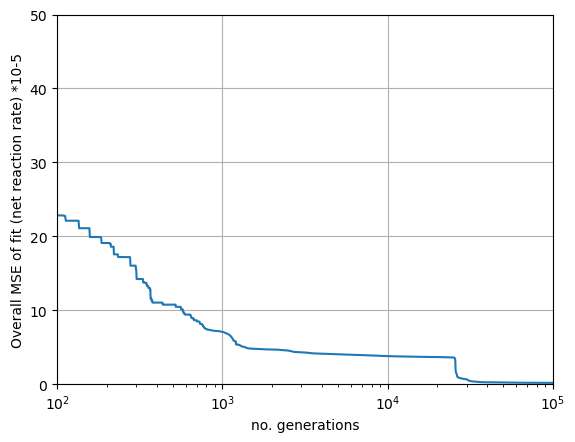

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.45531764732254
1.512833958386686
0.82243301895058
-4.270774846149909
0.4946331556477148
0.00020353242868714685
0.396381857120514
-7.783559401692227
0.6889406108765511
7.057355560731173
5.575628873579964
5.58000122324711
0.8277596966966886
0.021852046734444124
3.0704741446919246
4.579704616619272e-06
0.11042238230725065
-11.789710177795012
1.8616514094176995
1.55620518746386
-10.70801621057026
1.09819781298931
3.688762995365805
0.03320525547147944
3.805657822697445
4.630338825263913
1.8060338089684493
9.961785671659984
-10.258599132907928
2.8507229503279796
1.7211605533421817
3.6518497921312045
-4.177456657783953
0.5319470473261253
1.0085606975208217
-1.3010297135000748


In [37]:
res.X

array([-1.14553176e+01,  1.51283396e+00,  8.22433019e-01, -4.27077485e+00,
        4.94633156e-01,  2.03532429e-04,  3.96381857e-01, -7.78355940e+00,
        6.88940611e-01,  7.05735556e+00,  5.57562887e+00,  5.58000122e+00,
        8.27759697e-01,  2.18520467e-02,  3.07047414e+00,  4.57970462e-06,
        1.10422382e-01, -1.17897102e+01,  1.86165141e+00,  1.55620519e+00,
       -1.07080162e+01,  1.09819781e+00,  3.68876300e+00,  3.32052555e-02,
        3.80565782e+00,  4.63033883e+00,  1.80603381e+00,  9.96178567e+00,
       -1.02585991e+01,  2.85072295e+00,  1.72116055e+00,  3.65184979e+00,
       -4.17745666e+00,  5.31947047e-01,  1.00856070e+00, -1.30102971e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.45531764732254
1.6: 1.512833958386686
0.9: 0.82243301895058
-4.3: -4.270774846149909
0.5: 0.4946331556477148
0.003: 0.00020353242868714685
0.4: 0.396381857120514
-7.9: -7.783559401692227
0.7: 0.6889406108765511
7.2: 7.057355560731173
5.7: 5.575628873579964
5.7: 5.58000122324711
0.8: 0.8277596966966886
0.03: 0.021852046734444124
3.1: 3.0704741446919246
6.000000000000001e-09: 4.579704616619272e-06
0.1: 0.11042238230725065
-12.0: -11.789710177795012
1.9: 1.8616514094176995
1.6: 1.55620518746386
-11.6: -10.70801621057026
1.2: 1.09819781298931
4.0: 3.688762995365805
0.01: 0.03320525547147944
4.2: 3.805657822697445
5.4: 4.630338825263913
2.2: 1.8060338089684493
11.8: 9.961785671659984
-12.0: -10.258599132907928
3.3: 2.8507229503279796
1.8: 1.7211605533421817
4.2: 3.6518497921312045
-4.0: -4.177456657783953
0.5: 0.5319470473261253
1.0: 1.0085606975208217
coeff fit: 0.9911804040382618
r: 0.995580435745029
